<a href="https://colab.research.google.com/github/samagra14/machine-learning-projects/blob/master/SimplePolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
! git clone https://github.com/jakevdp/JSAnimation

fatal: destination path 'JSAnimation' already exists and is not an empty directory.


In [2]:
%cd JSAnimation

/content/JSAnimation


In [3]:
! python setup.py install

running install
running build
running build_py
running install_lib
running install_egg_info
Removing /usr/local/lib/python3.6/dist-packages/JSAnimation-0.1.egg-info
Writing /usr/local/lib/python3.6/dist-packages/JSAnimation-0.1.egg-info


In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


In [5]:
from pyvirtualdisplay import Display
displayOne = Display(visible=0, size=(400, 300))
displayOne.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>


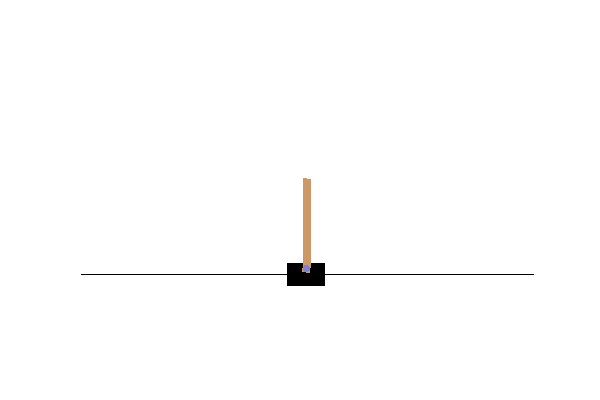
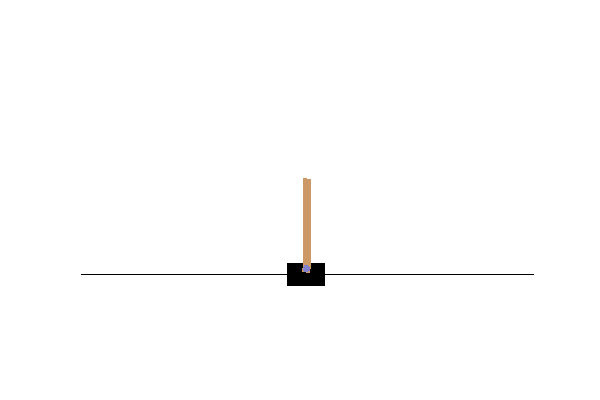
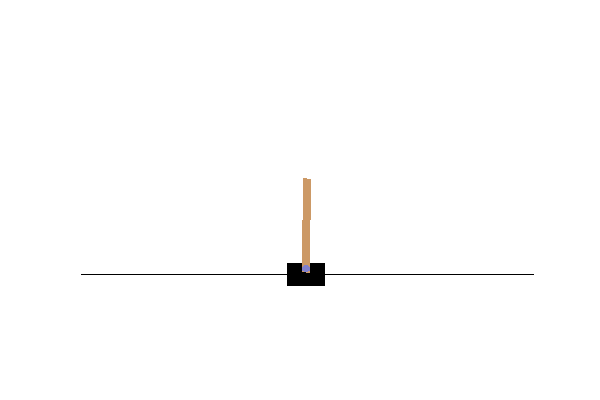
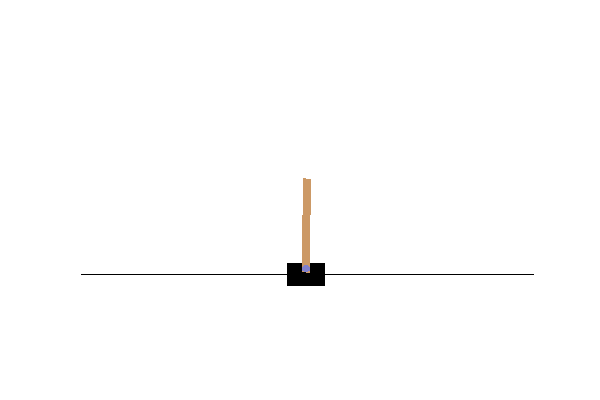
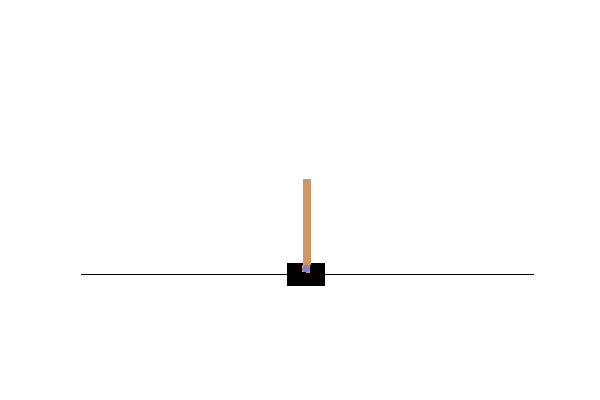
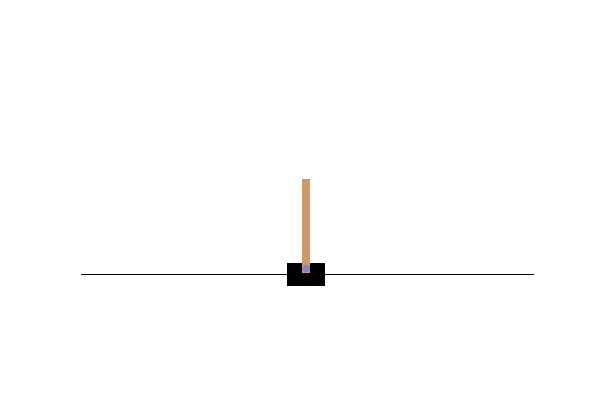
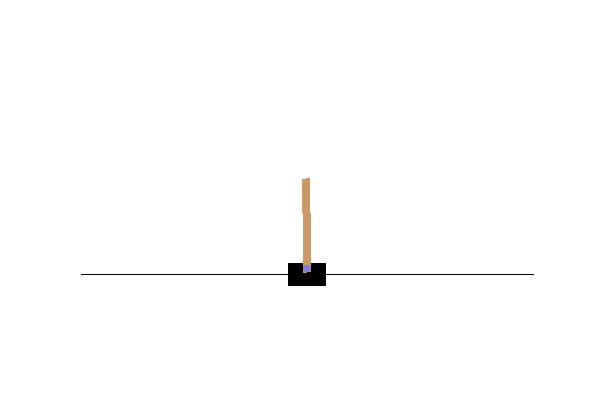
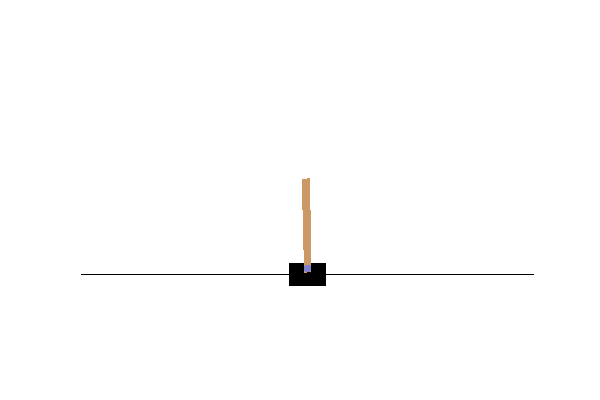
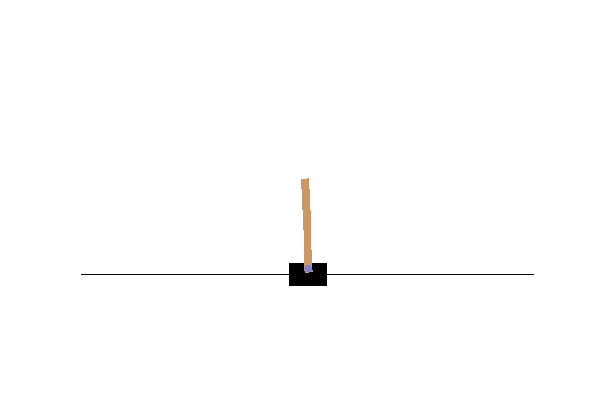
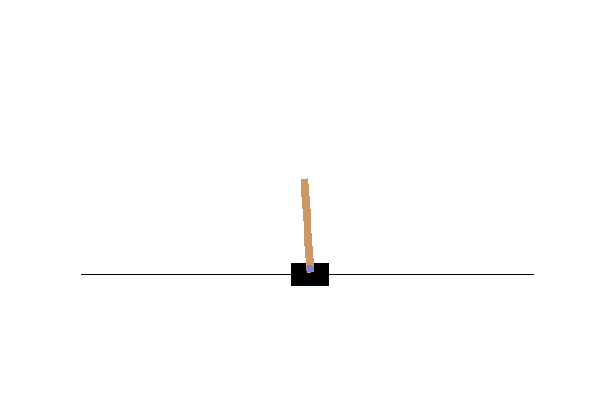
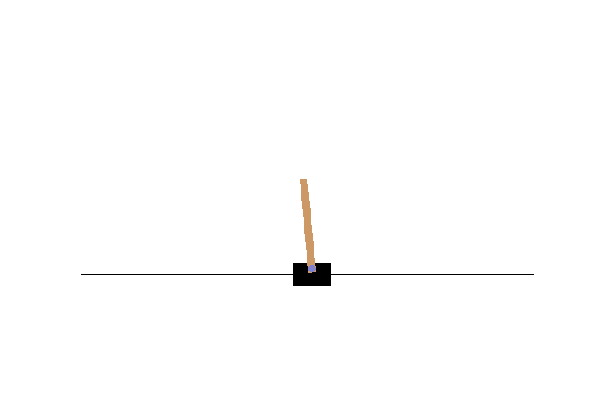
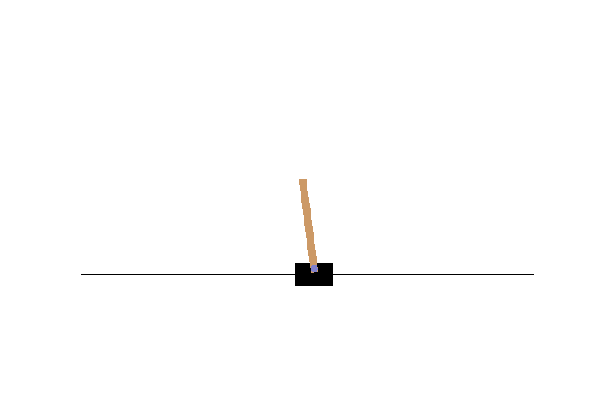
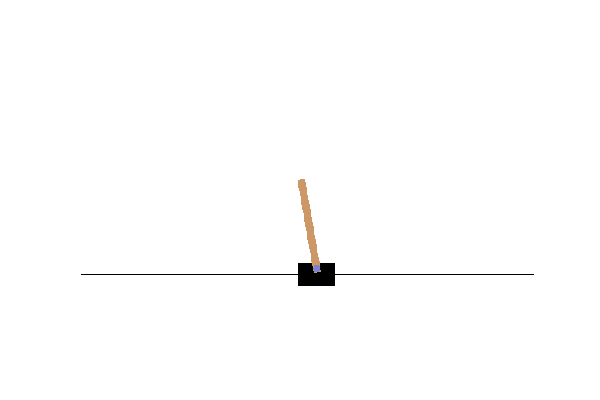
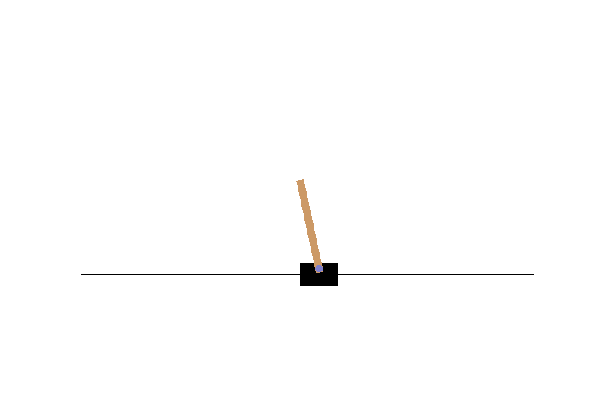
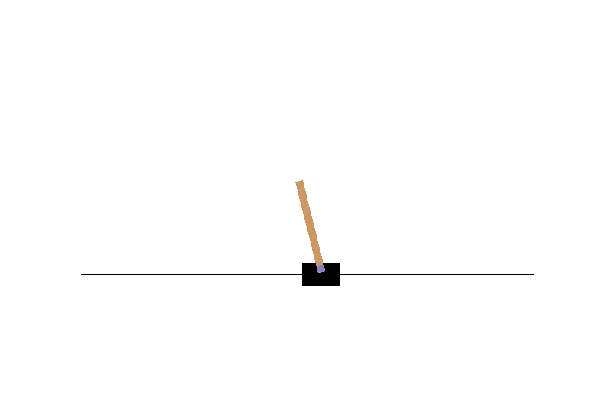
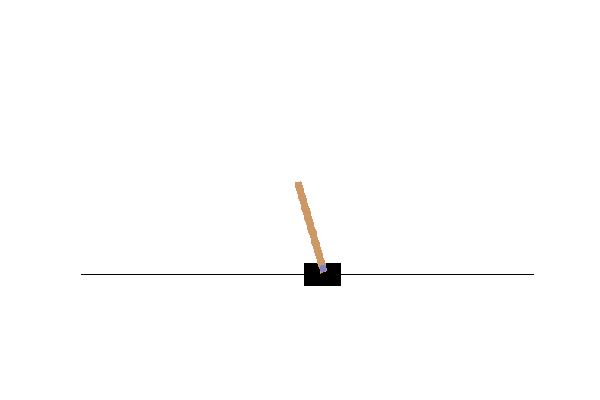
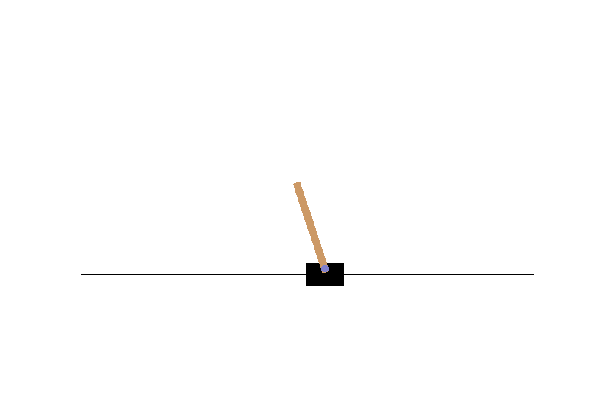
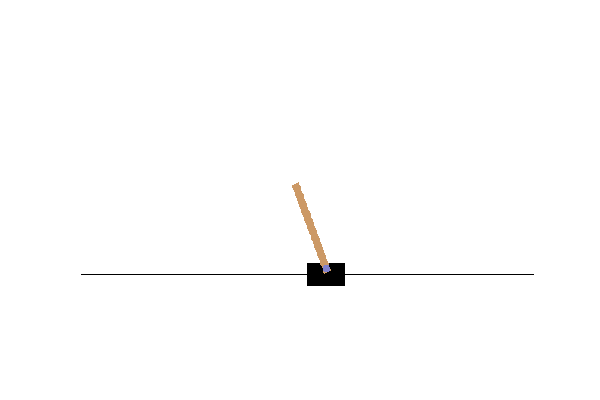
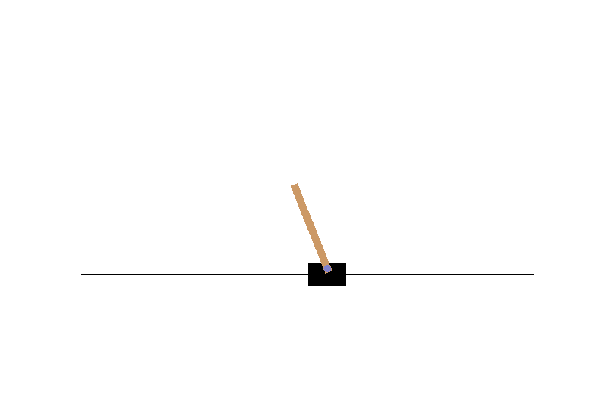
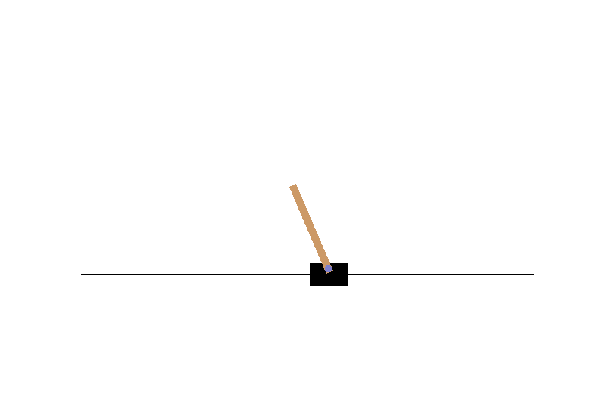
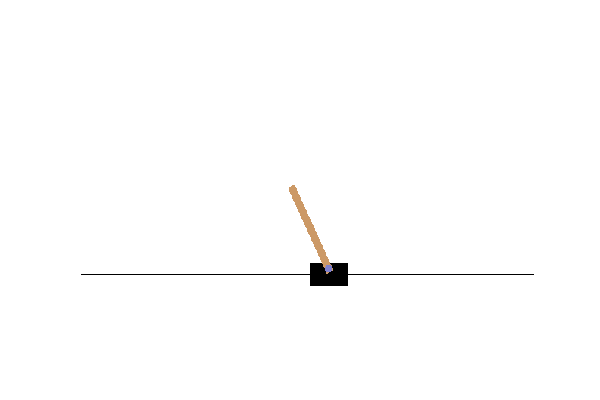
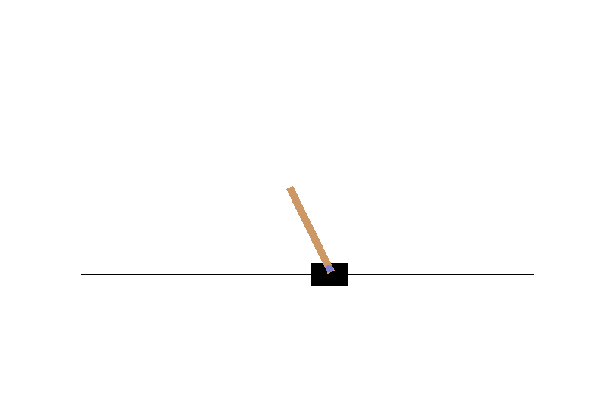
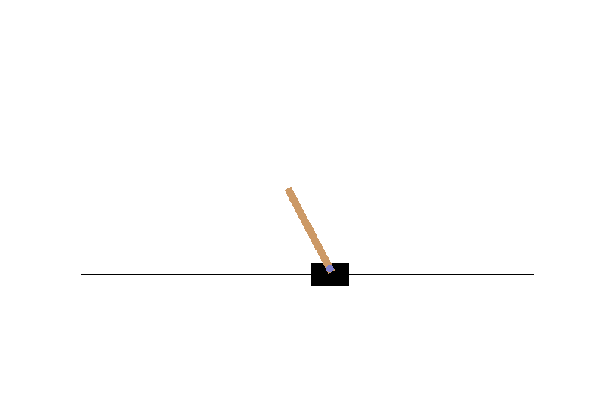
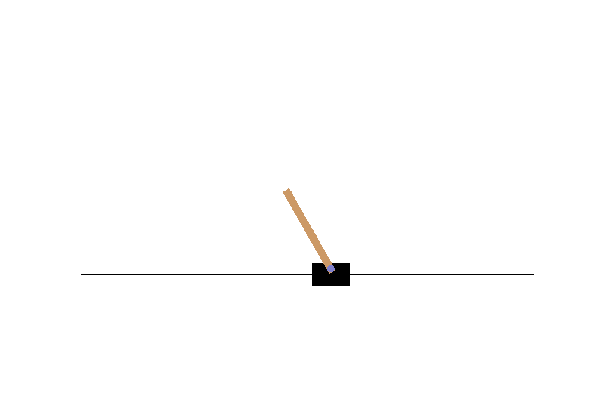
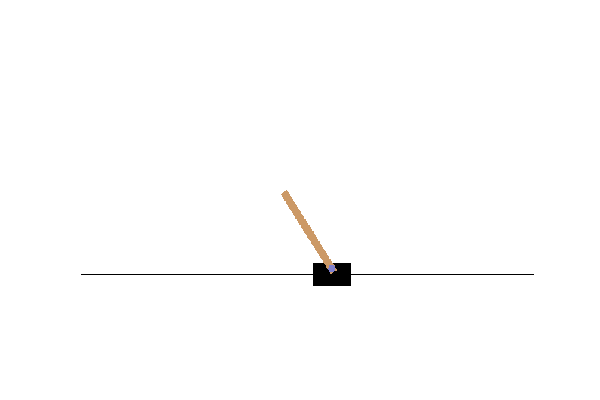
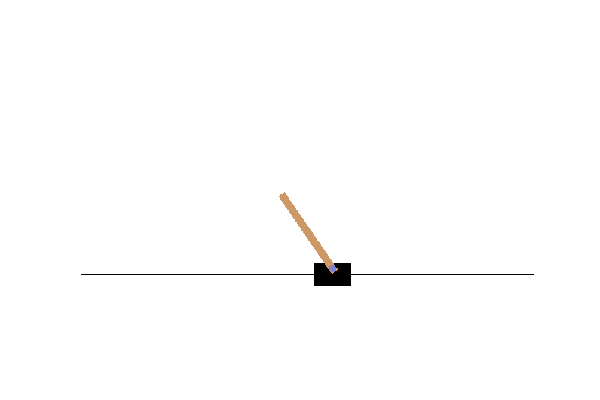
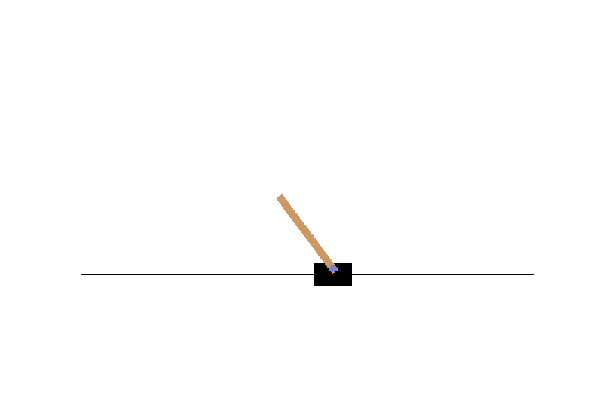
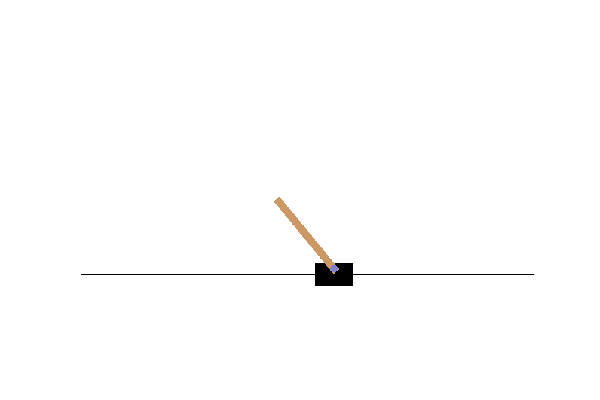
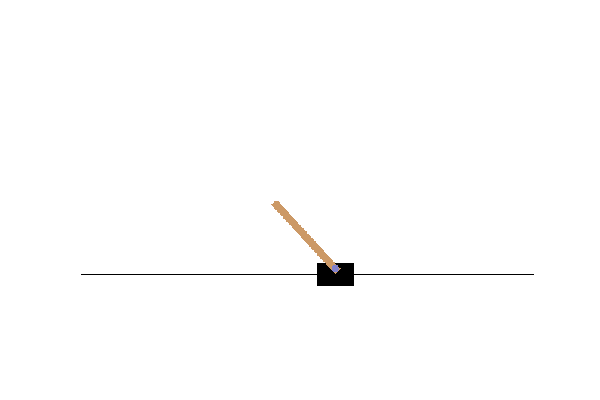
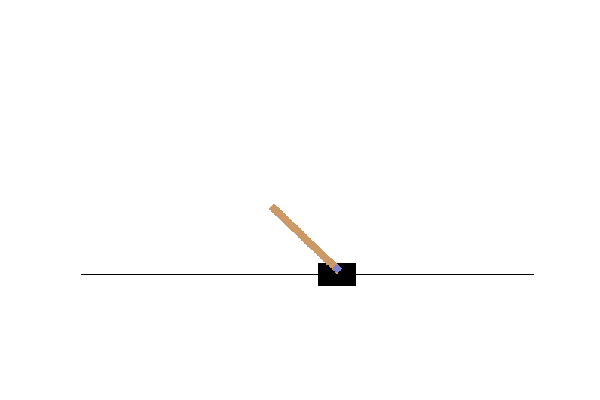
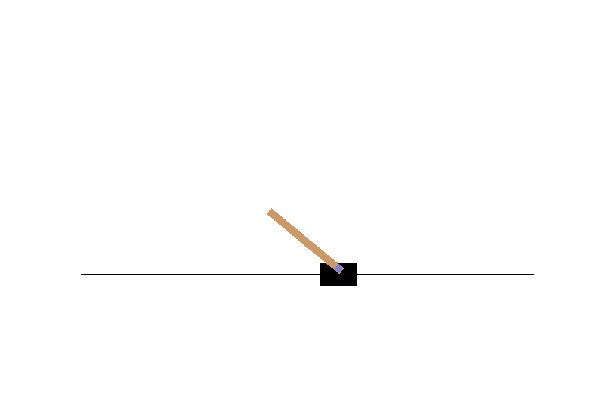
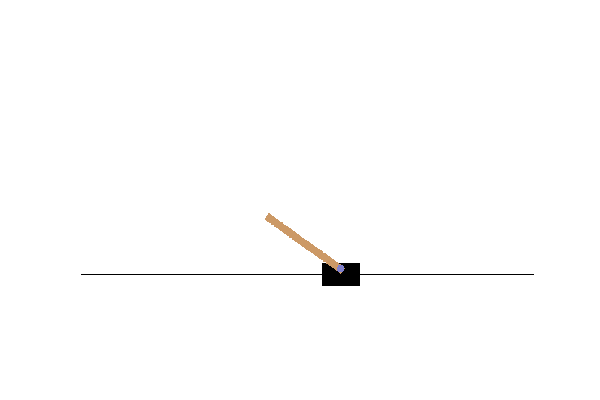
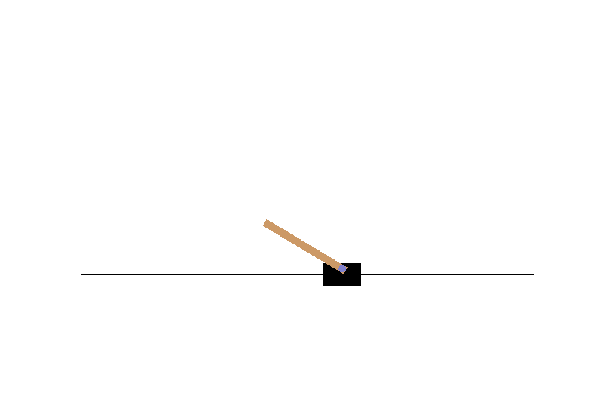
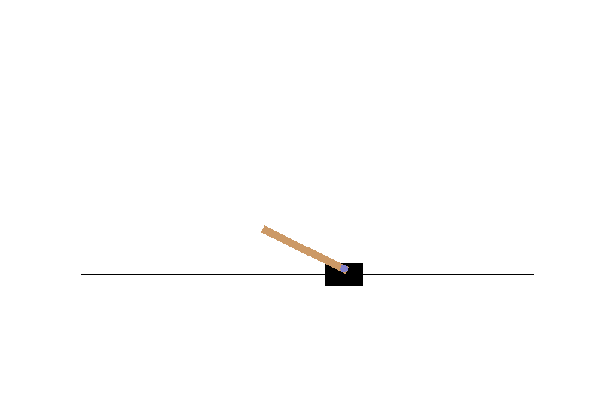
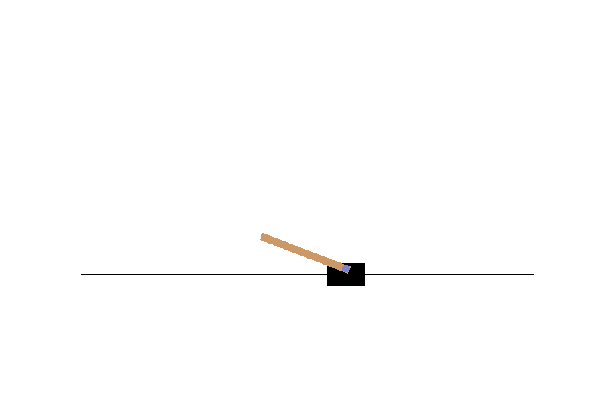
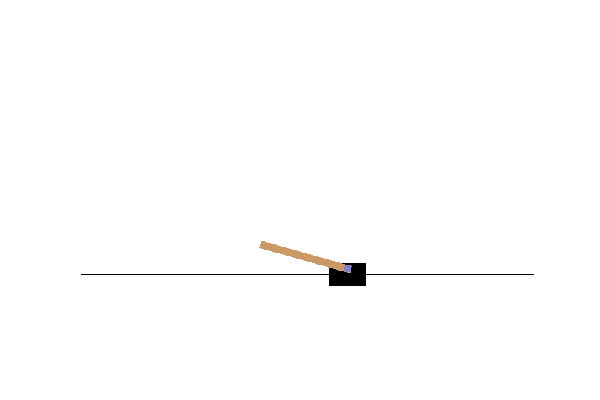
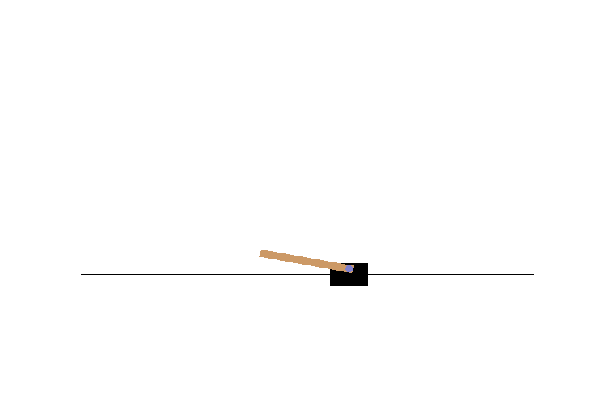
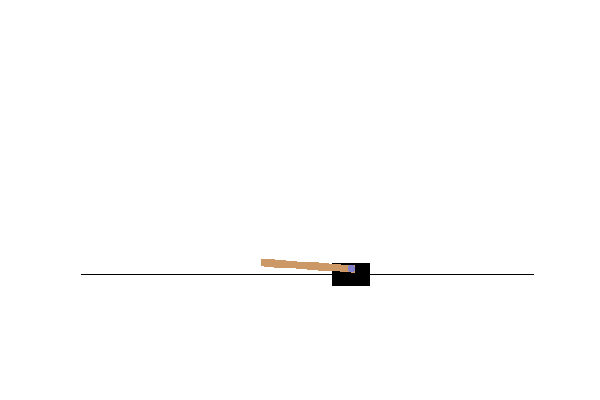
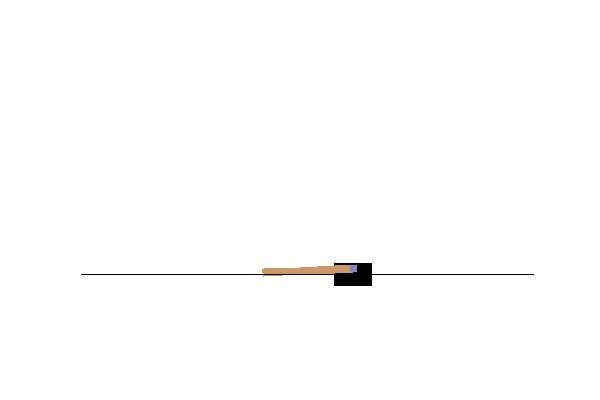
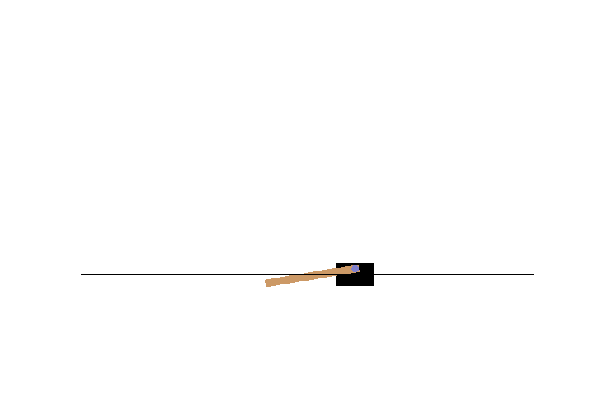
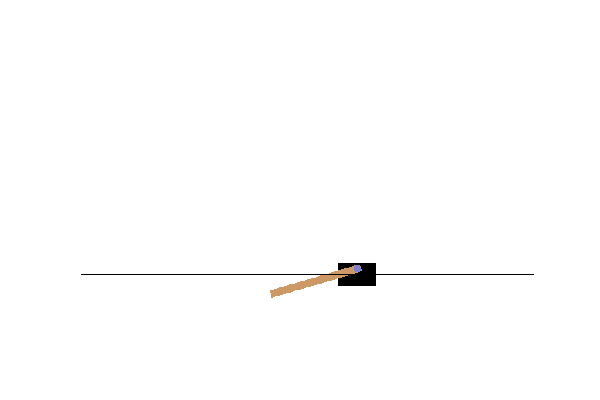
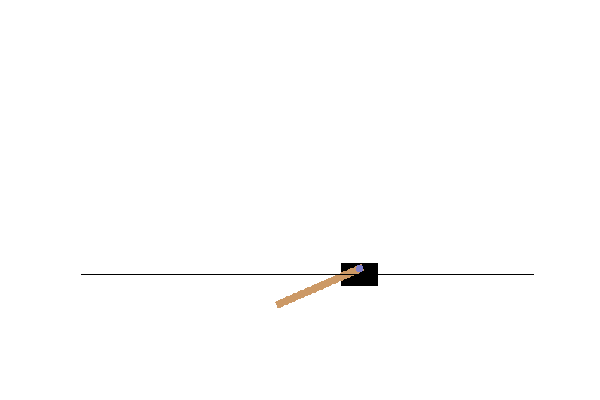
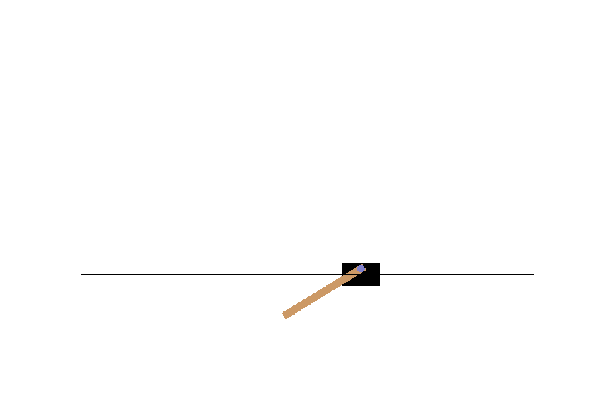
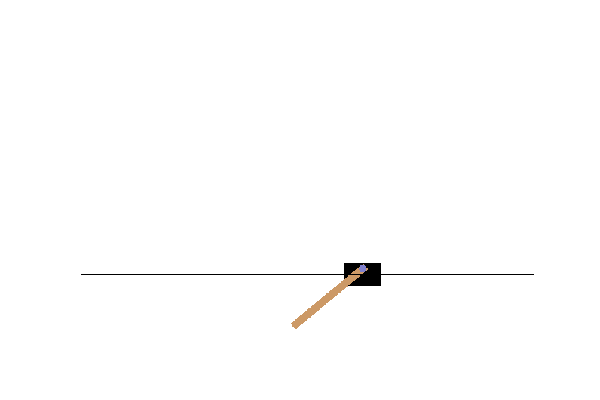
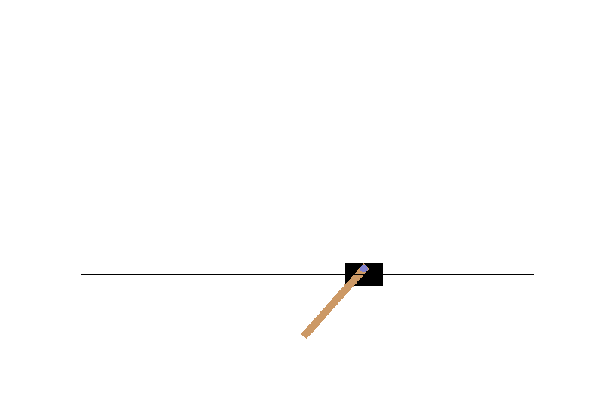
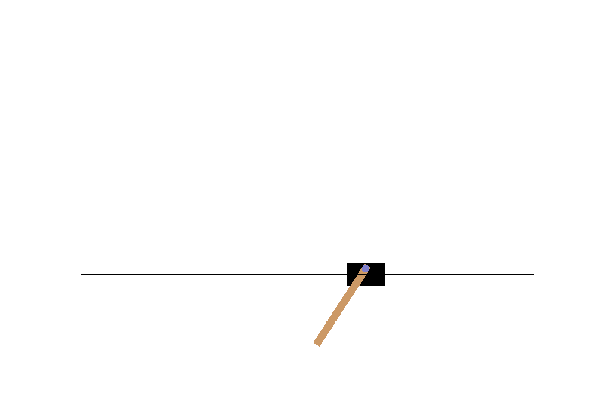
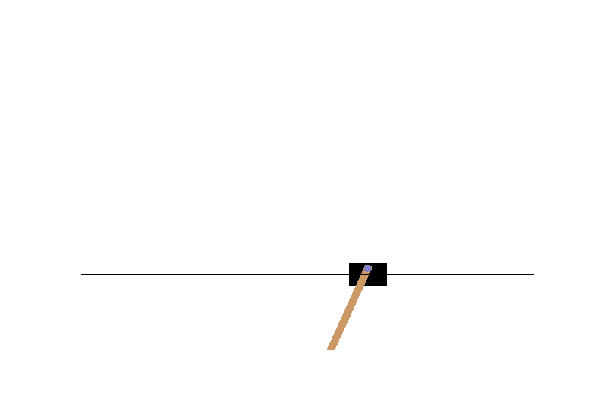
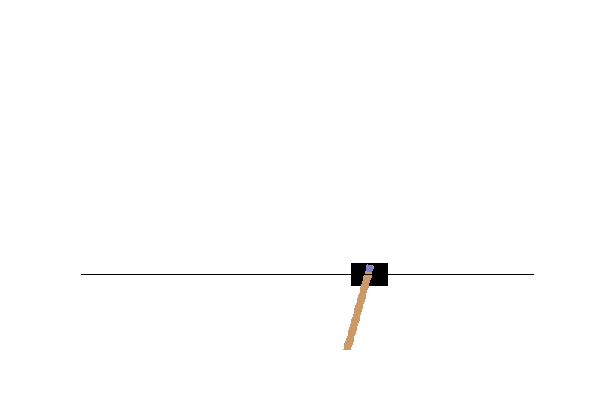
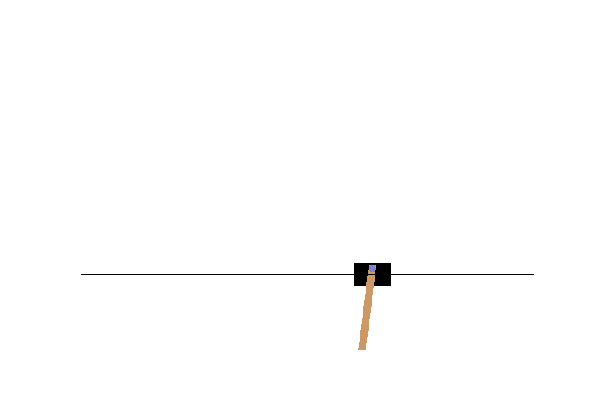
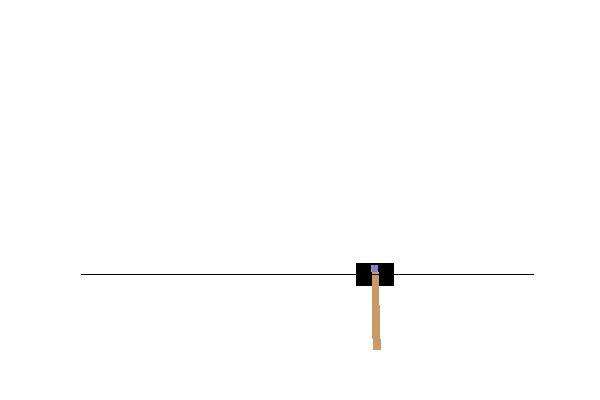
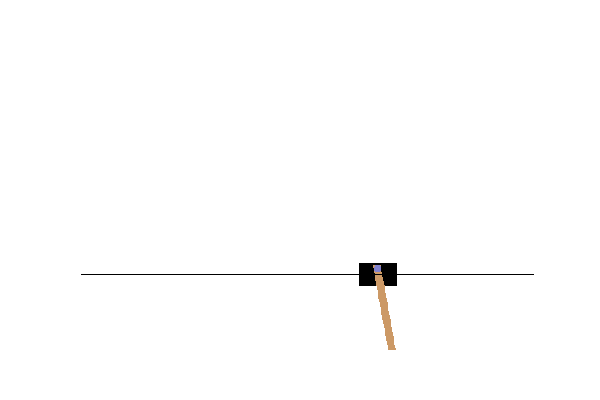
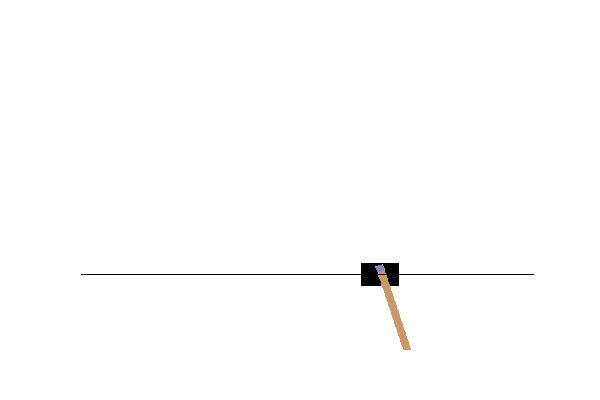
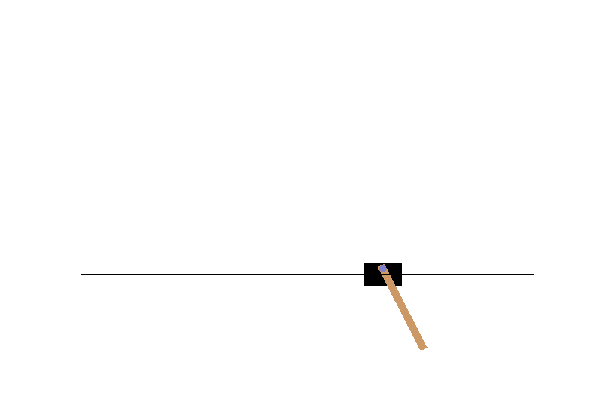
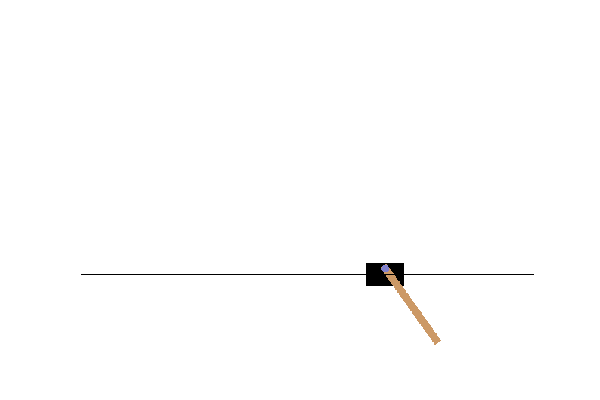
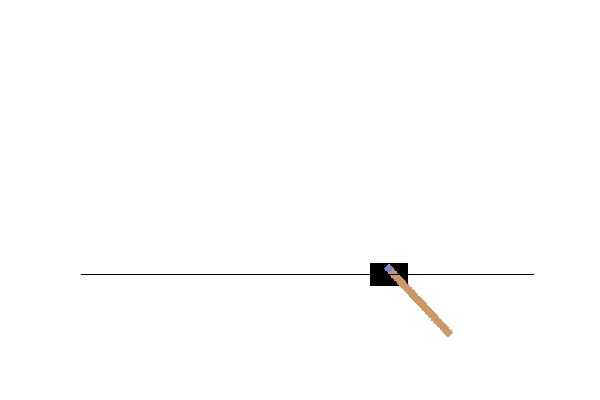
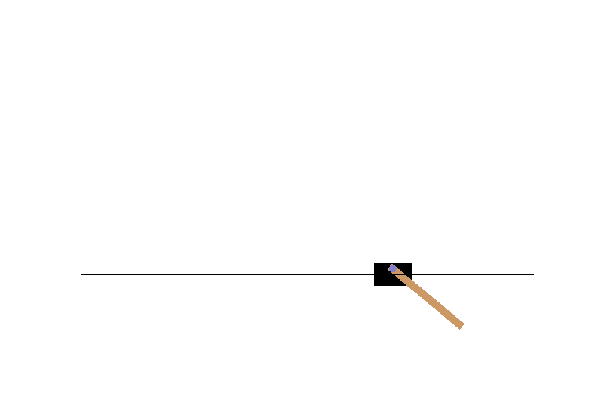
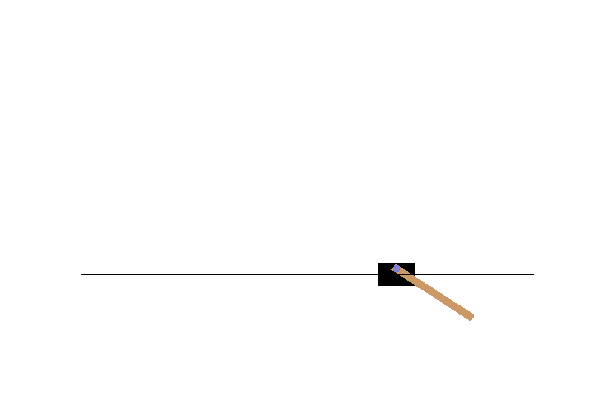
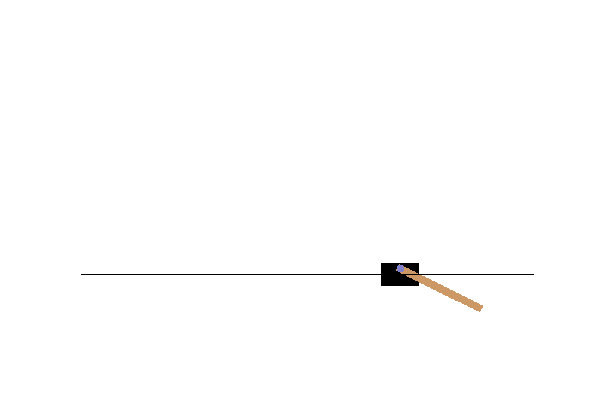
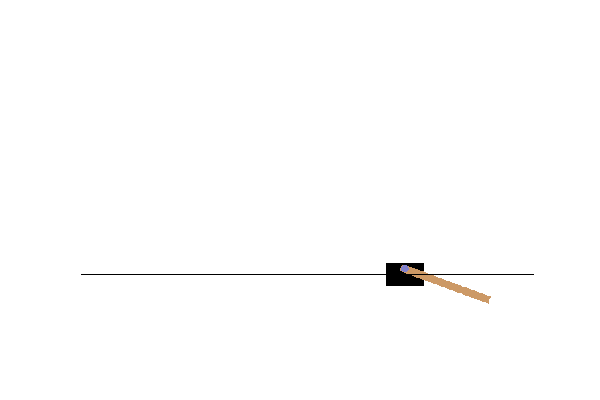
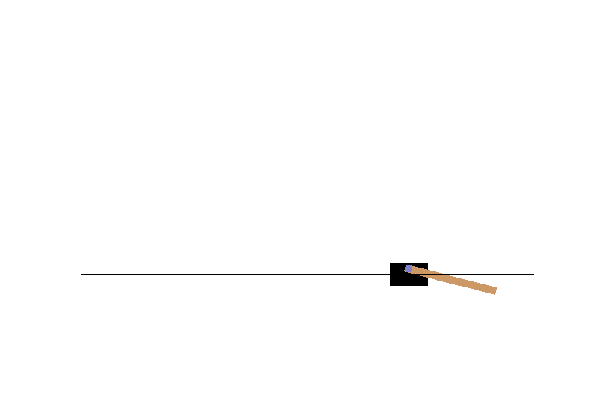
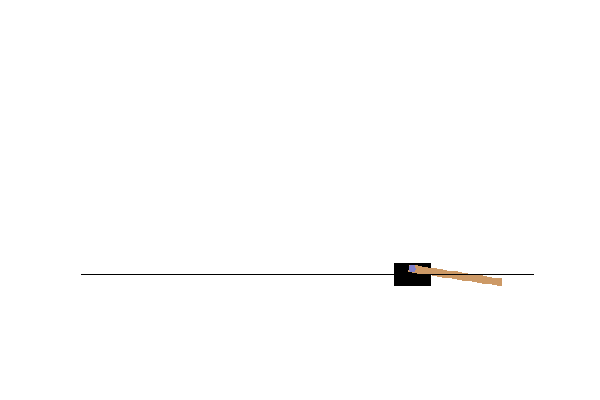
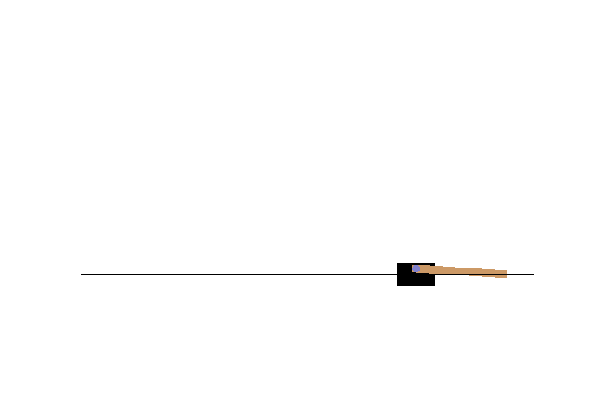
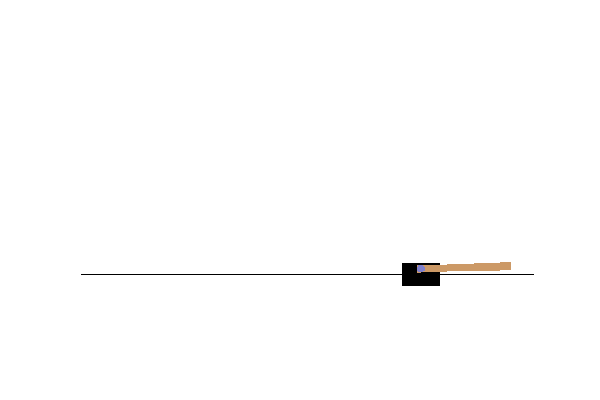
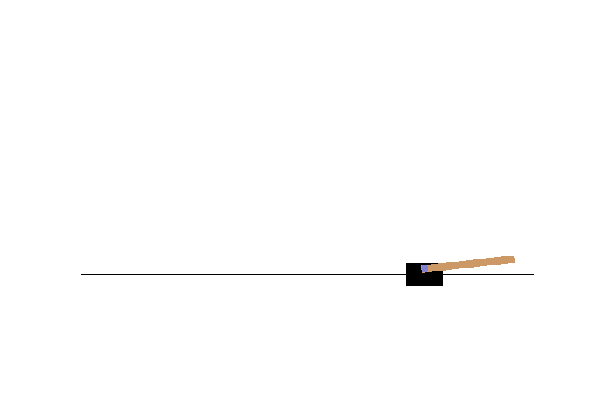
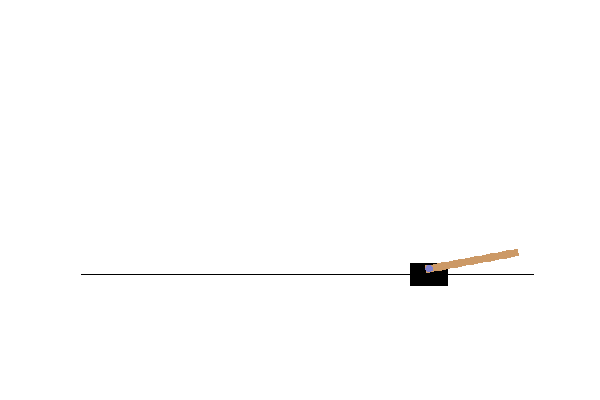
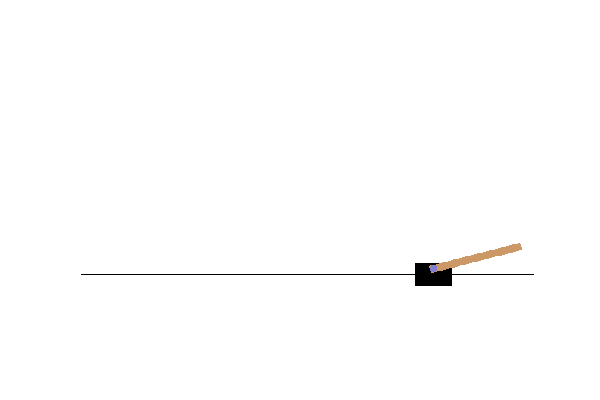
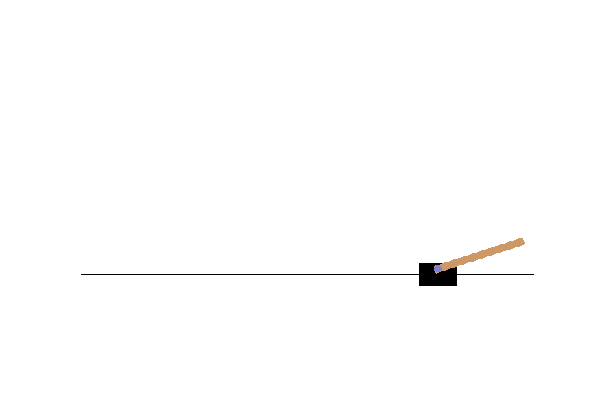
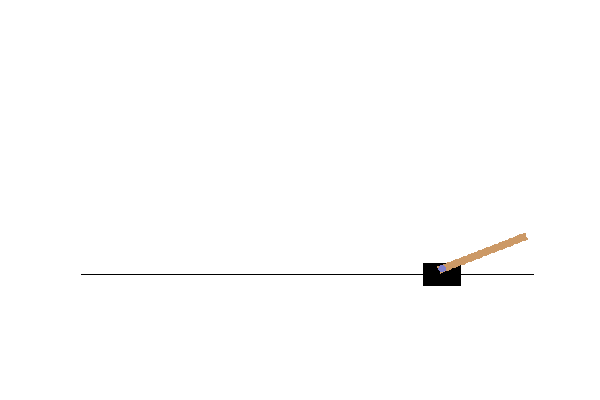
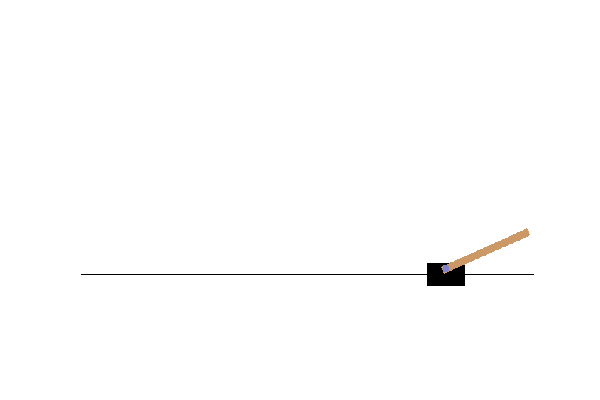
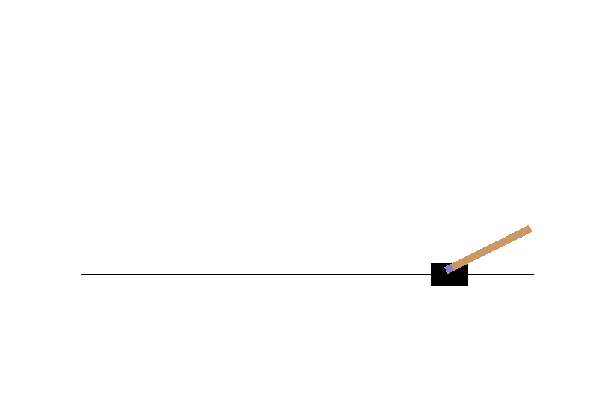
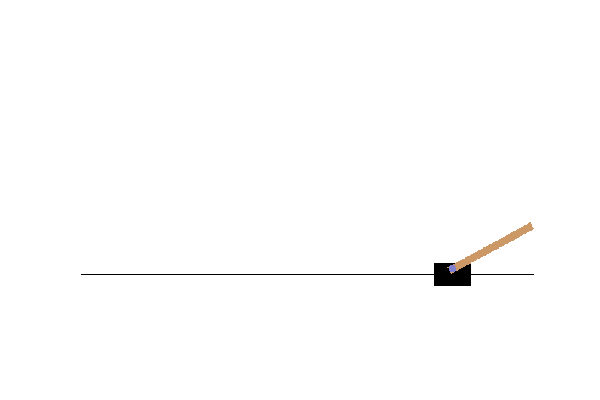
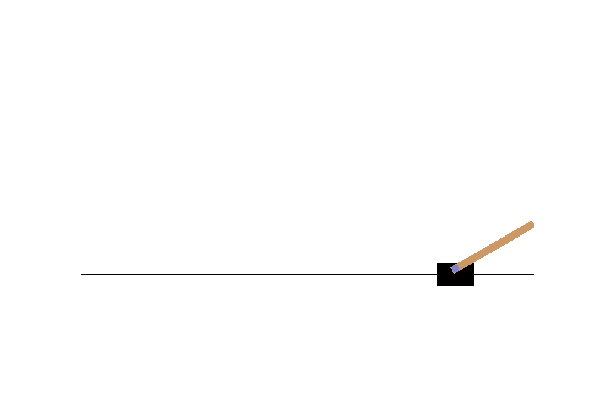
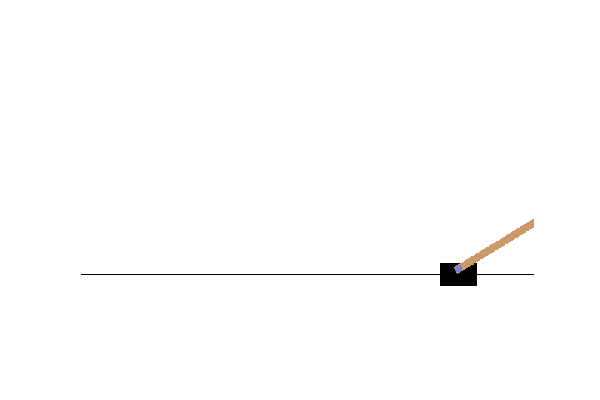
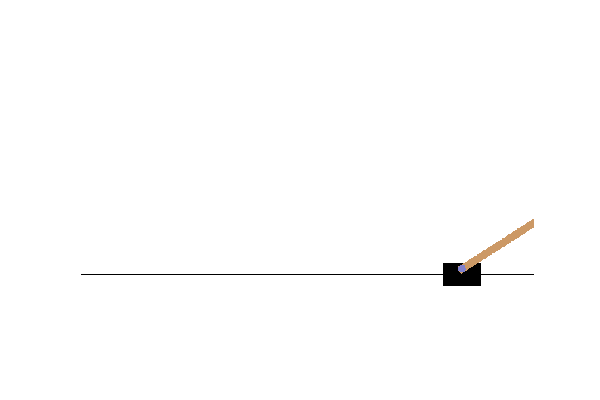
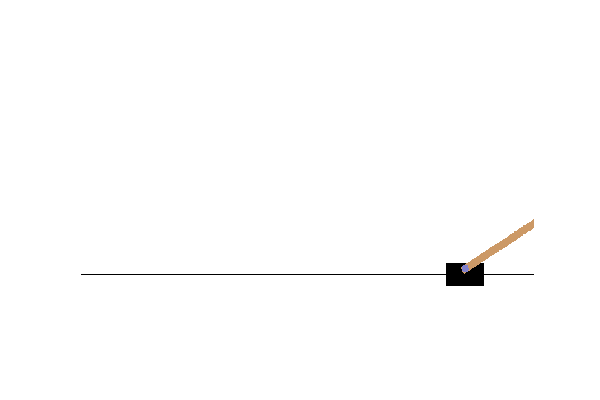
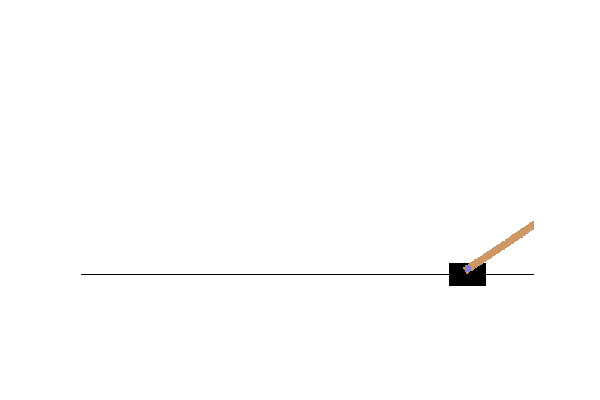
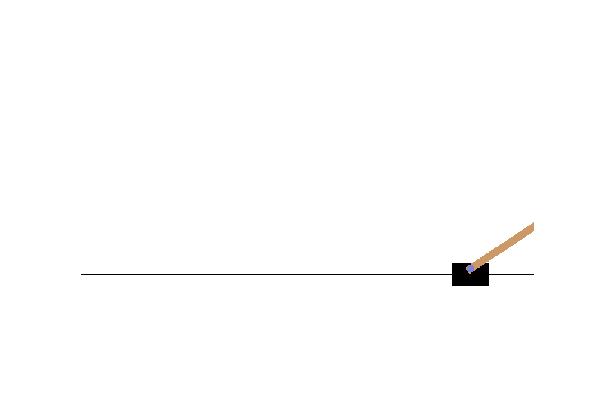
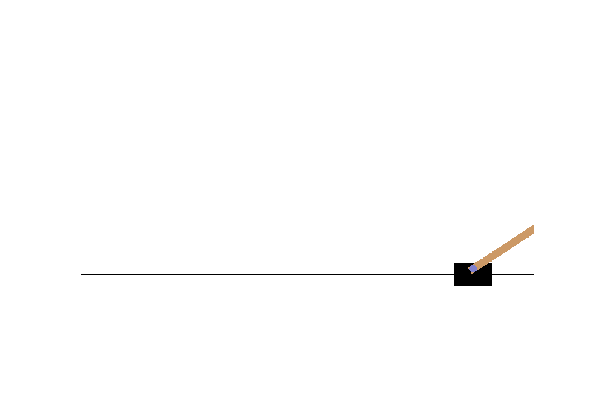
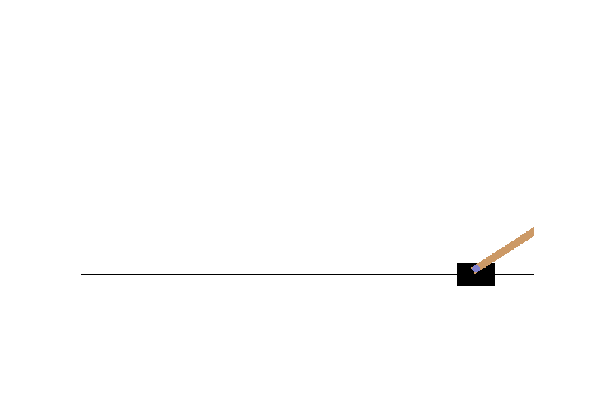
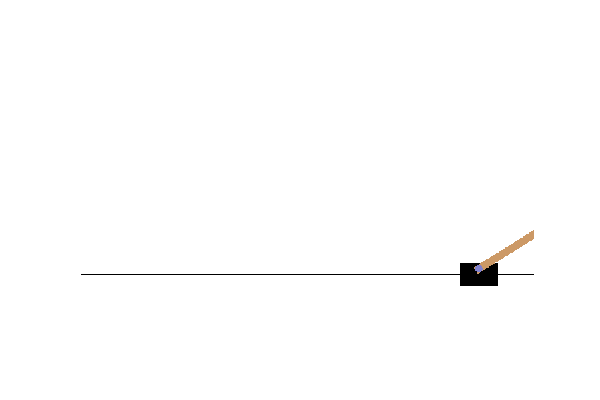
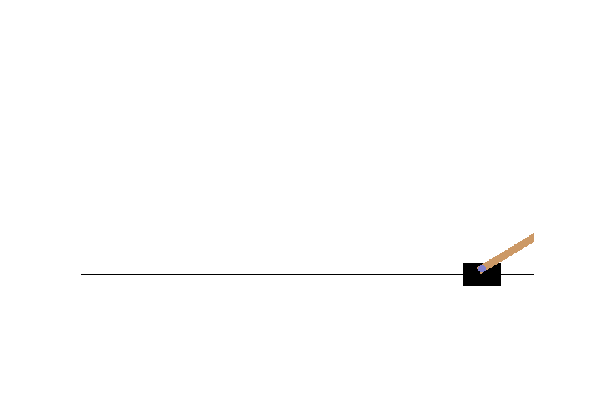
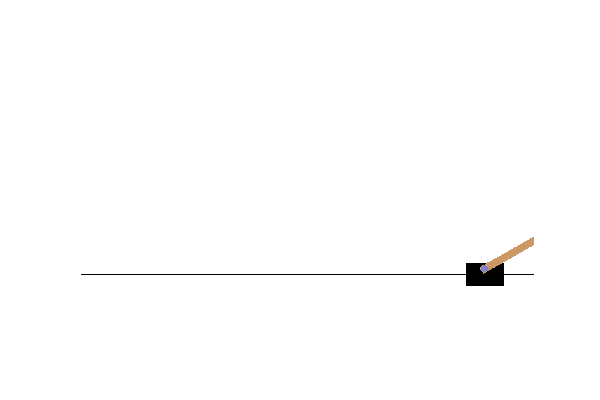
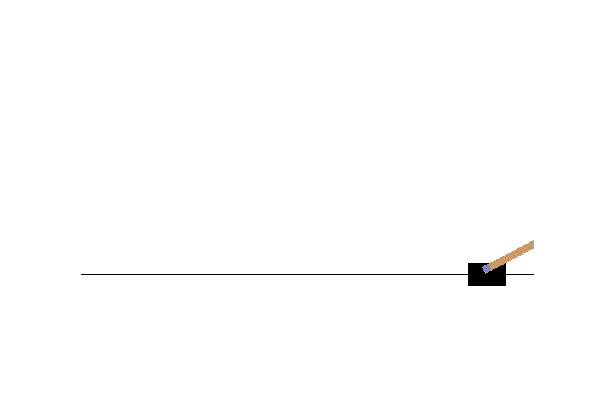
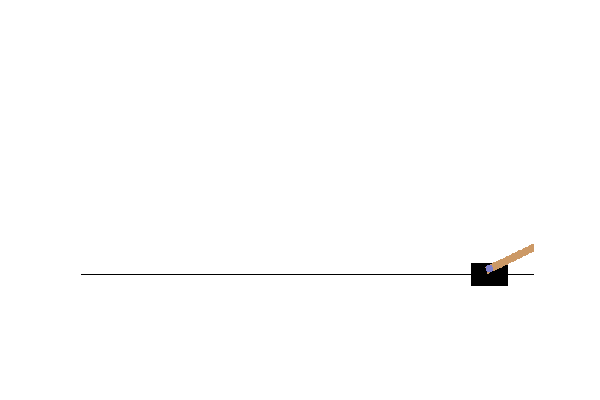
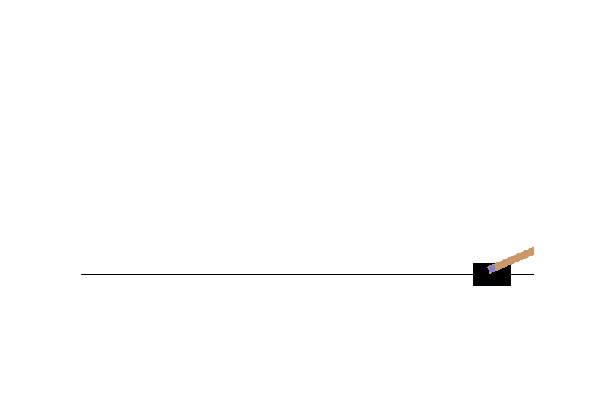
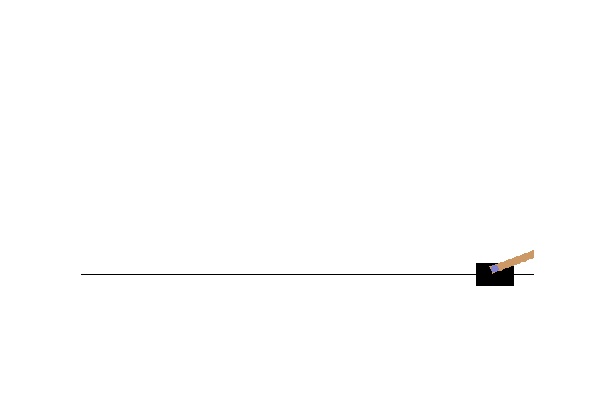
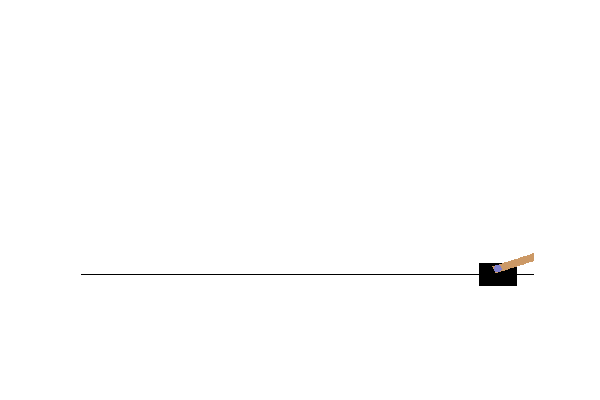
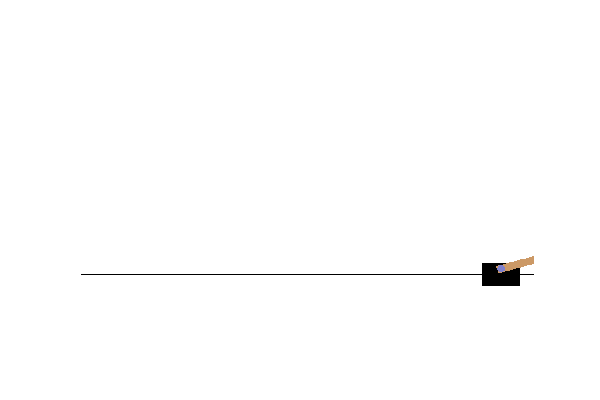
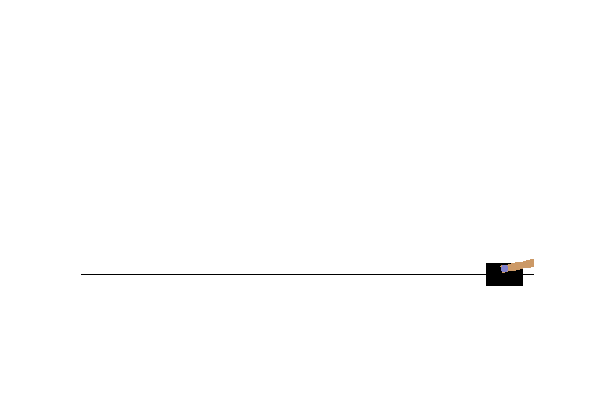
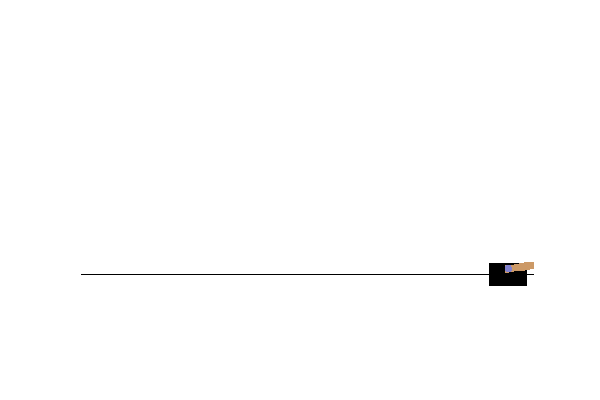
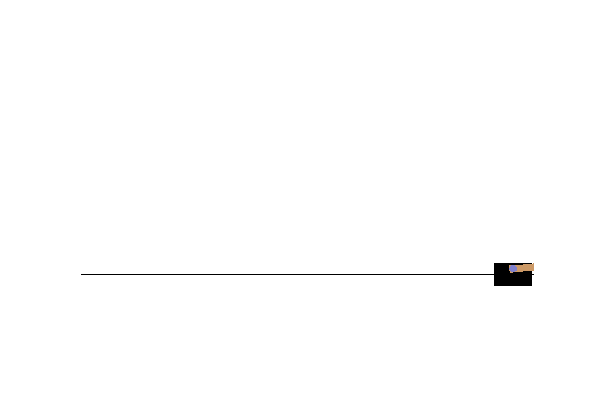
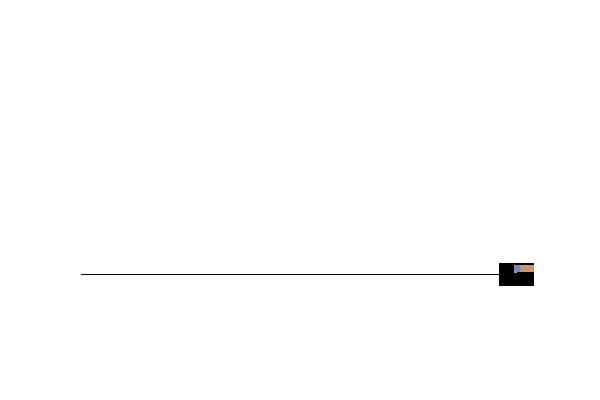
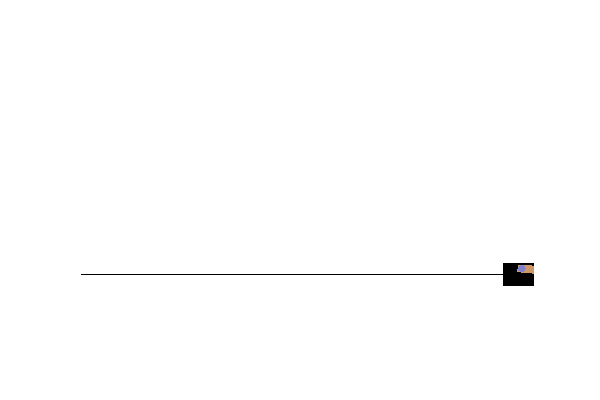
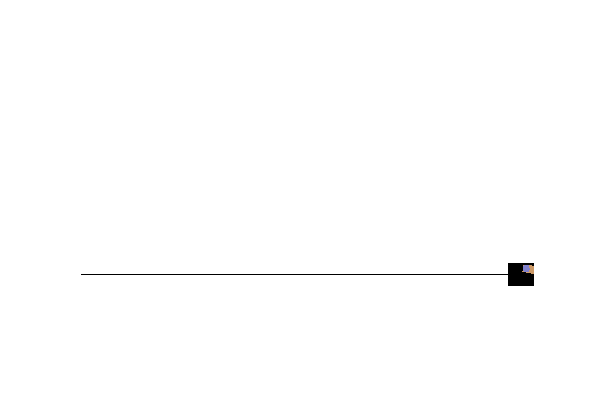
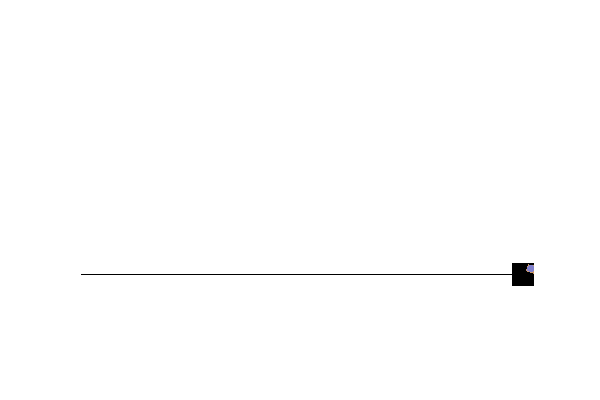
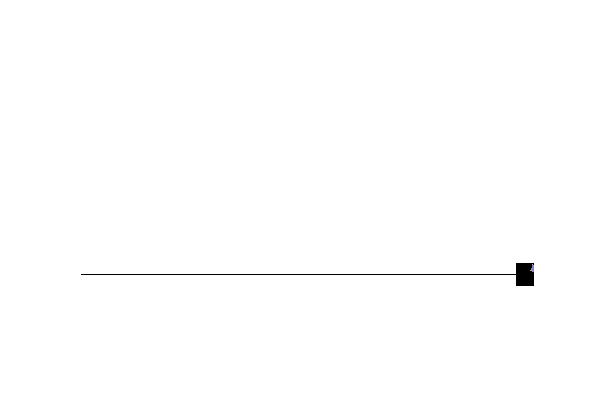
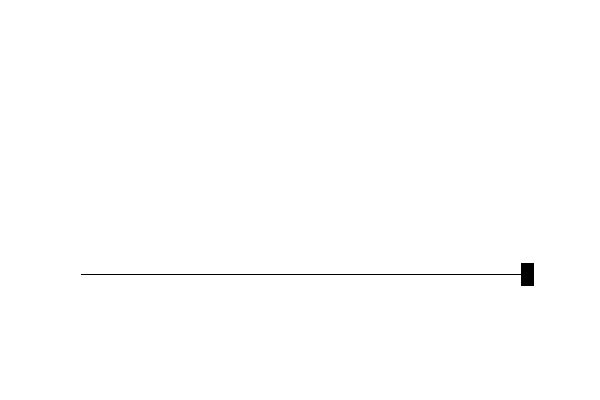
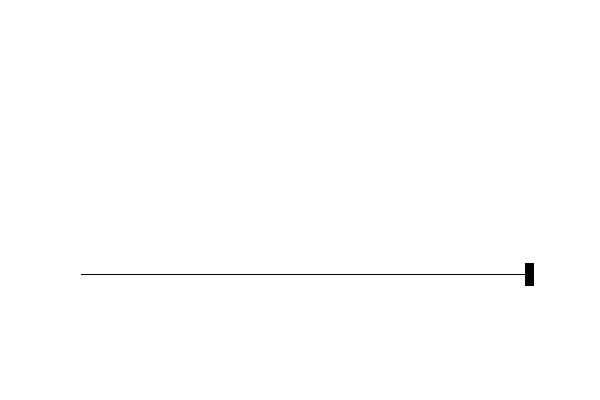
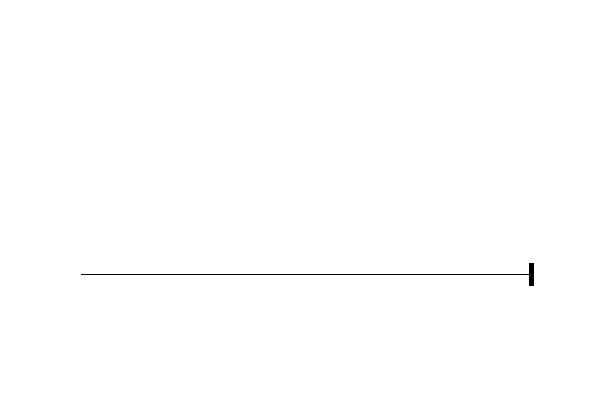
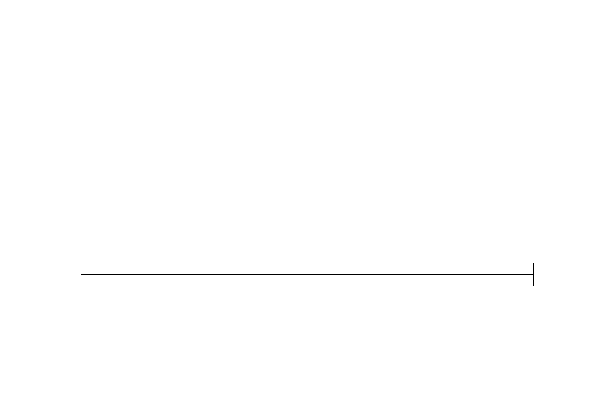

In [6]:
env = gym.make("CartPole-v0")
env.reset()
frames =[]

for i in range(100):
  screen = env.render(mode='rgb_array')
  frames.append(screen)
  env.step(env.action_space.sample())
    
print(len(frames))
ipythondisplay.clear_output(wait=True)
env.close()
display_frames_as_gif(frames)


In [0]:
import tensorflow as tf
def mlp(x, sizes, activation=tf.tanh, output_activation=None):
  #build the mlp graph
  for size in sizes[:-1]:
    x=tf.layers.dense(x,units = size,activation=activation)
  return tf.layers.dense(x,sizes[-1],activation = output_activation)

In [0]:


frames = []

import tensorflow as tf
import numpy as np
import gym
from gym.spaces import Discrete, Box

def train(env_name = 'CartPole-v0',hidden_sizes = [32],lr = 1e-2,epochs=50,batch_size = 5000,render = False):  
  # make environment, check observation and action dimensions
  env = gym.make(env_name)
  print(1)
  obs_dim = env.observation_space.shape[0]
  n_acts = env.action_space.n
  print(2)
  #make core of policy network
  obs_ph = tf.placeholder(dtype = tf.float32,shape=(None,obs_dim))
  logits = mlp(obs_ph,hidden_sizes+[n_acts])
  print(3)
  # select actions operations
  actions = tf.squeeze(tf.multinomial(logits = logits,num_samples=1),axis = 1)
  
  # make loss function whose gradient is policy function
  weights_ph = tf.placeholder(shape=(None,), dtype=tf.float32)
  act_ph = tf.placeholder(shape = (None,),dtype = tf.int32)
  action_masks = tf.one_hot(act_ph,n_acts)
  log_probs = tf.reduce_sum(action_masks*tf.nn.log_softmax(logits),axis = 1)
  loss = -tf.reduce_mean(weights_ph*log_probs)
  
  #the training operation
  train_op = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
  sess = tf.InteractiveSession()
  sess.run(tf.global_variables_initializer())
  # for training policy
  
  def train_one_epoch():
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_acts = []         # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_rets = []         # for measuring episode returns
    batch_lens = []         # for measuring episode lengths
    
    
    #reset episode specific variables
    obs = env.reset()
    done = False
    ep_rews = []
    
    #render first episode of each epoch
    finished_rendering_this_epoch = False
    
    # collect experience by acting in the environment with a given policy
    
    while True:
      # rendering
      if(not finished_rendering_this_epoch) and render:
        frames.append(env.render(mode = 'rgb_array'))
       
        
      #save obs
      
      batch_obs.append(obs.copy())
      
      #act in the environment
      
      act = sess.run(actions,{obs_ph: obs.reshape(1,-1)})[0]
      obs,rew,done,_= env.step(act)
      
      
      #save action reward
      batch_acts.append(act)
      ep_rews.append(rew)
      if done:
        #if episode is over, record info about episode
        ep_ret,ep_len = sum(ep_rews),len(ep_rews)
        batch_rets.append(ep_ret)
        batch_lens.append(ep_len)
        batch_weights += [ep_ret] * ep_len
        
        # reset episode-specific variables
        obs, done, ep_rews = env.reset(), False, []
        
        # won't render again this epoch
        finished_rendering_this_epoch = True
        
        if len(batch_obs)>batch_size:
          break
        
        
    batch_loss,_ = sess.run([loss, train_op],
                                 feed_dict={
                                    obs_ph: np.array(batch_obs),
                                    act_ph: np.array(batch_acts),
                                    weights_ph: np.array(batch_weights)
                                 })
    return batch_loss, batch_rets, batch_lens
  print(epochs)
  for i in range(epochs):
    batch_loss, batch_rets, batch_lens = train_one_epoch()
    print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))


In [9]:
train(render = True)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


1
2
3
50
epoch:   0 	 loss: 23.199 	 return: 25.979 	 ep_len: 25.979
epoch:   1 	 loss: 31.040 	 return: 35.525 	 ep_len: 35.525
epoch:   2 	 loss: 35.409 	 return: 39.248 	 ep_len: 39.248
epoch:   3 	 loss: 35.474 	 return: 42.458 	 ep_len: 42.458
epoch:   4 	 loss: 33.143 	 return: 41.868 	 ep_len: 41.868
epoch:   5 	 loss: 41.498 	 return: 52.375 	 ep_len: 52.375
epoch:   6 	 loss: 41.041 	 return: 53.305 	 ep_len: 53.305
epoch:   7 	 loss: 38.933 	 return: 51.794 	 ep_len: 51.794
epoch:   8 	 loss: 41.856 	 return: 55.911 	 ep_len: 55.911
epoch:   9 	 loss: 47.153 	 return: 65.333 	 ep_len: 65.333
epoch:  10 	 loss: 46.729 	 return: 68.877 	 ep_len: 68.877
epoch:  11 	 loss: 52.221 	 return: 73.912 	 ep_len: 73.912
epoch:  12 	 loss: 54.984 	 return: 75.149 	 ep_len: 75.149
epoch:  13 	 loss: 51.303 	 return: 74.806 	 ep_len: 74.806
epoch:  14 	 loss: 55.257 	 return: 78.750 	 ep_len: 78.750
epoch:  15 	 loss: 55.874 	 return: 82.410 	 ep_len: 82.410
epoch:  16 	 loss: 53.597 	 ret


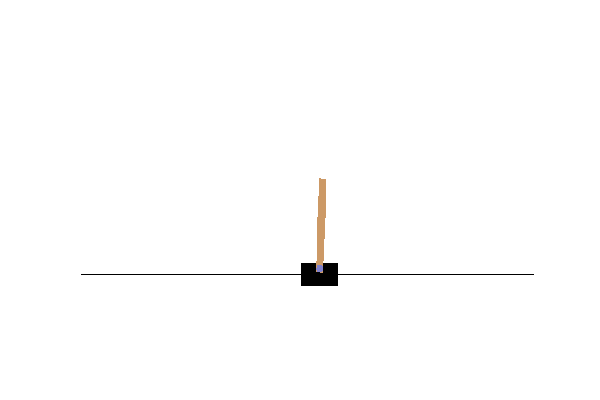
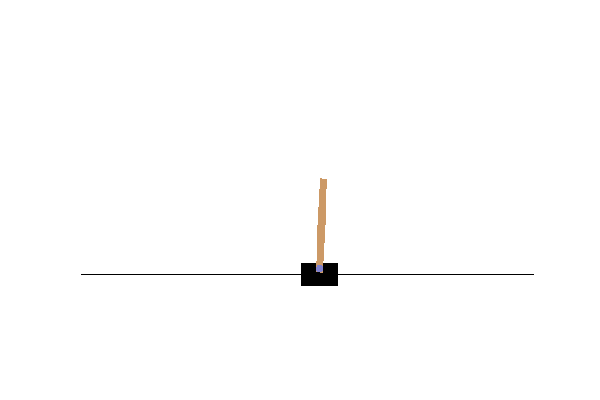
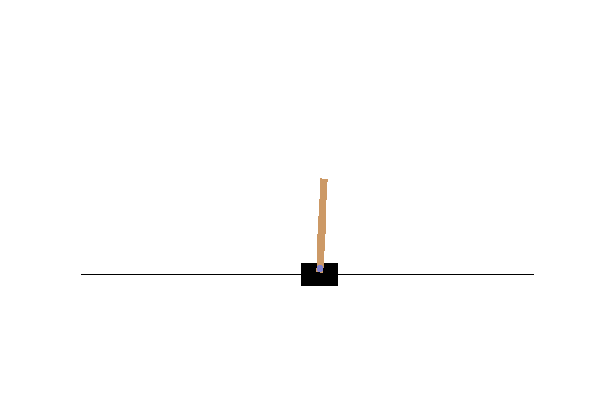
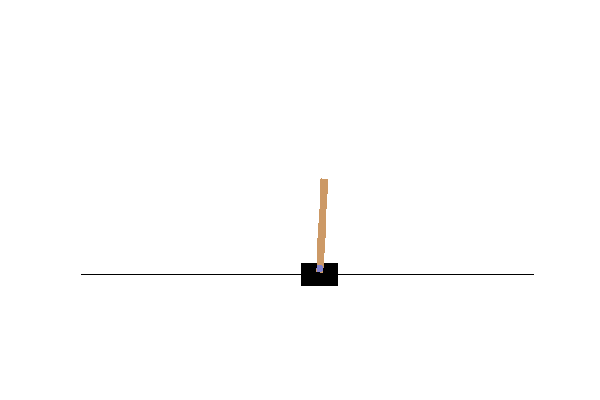
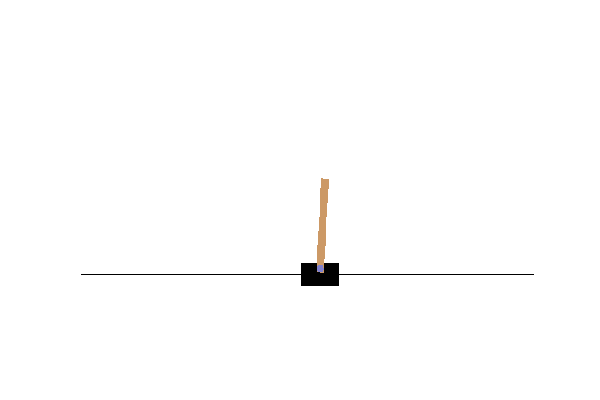
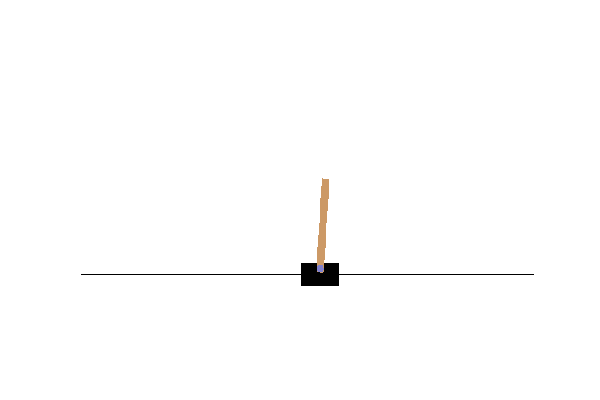
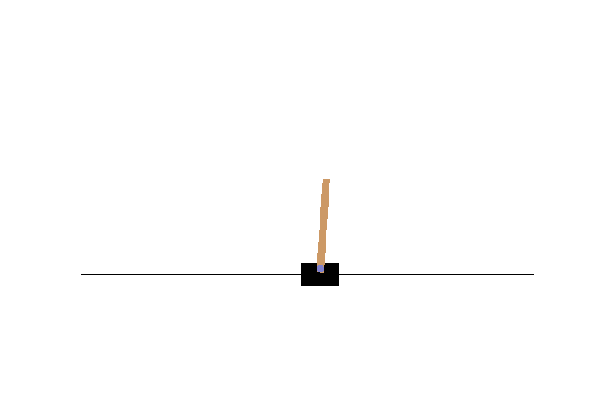
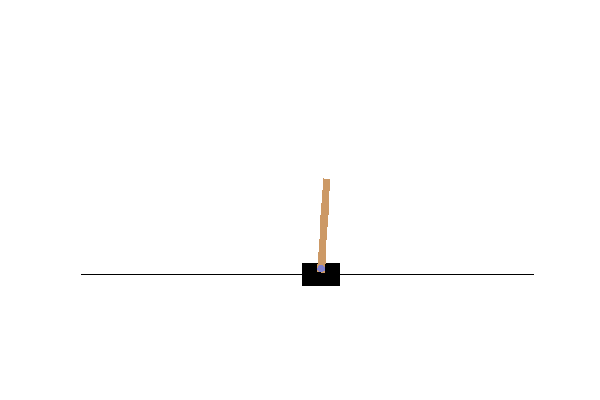
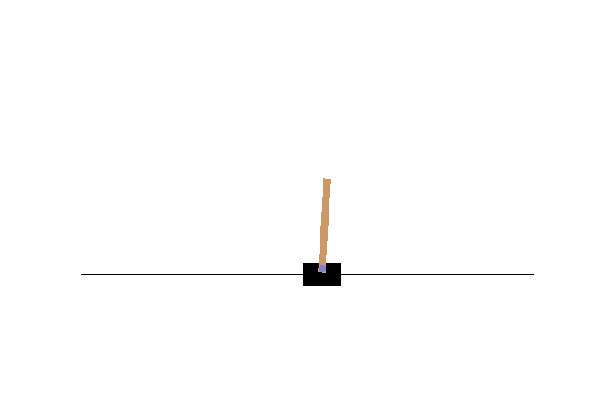
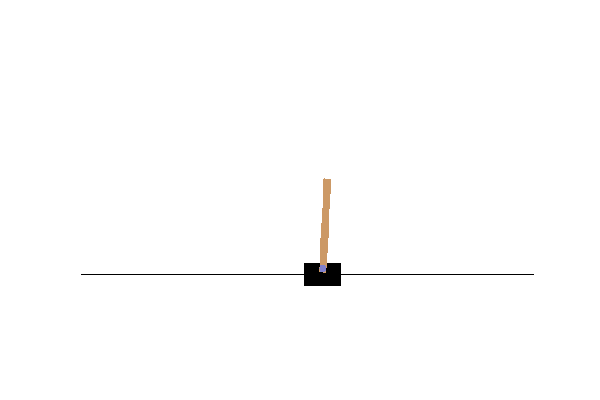
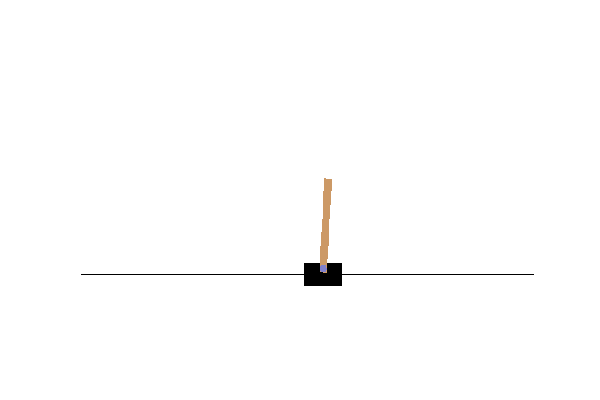
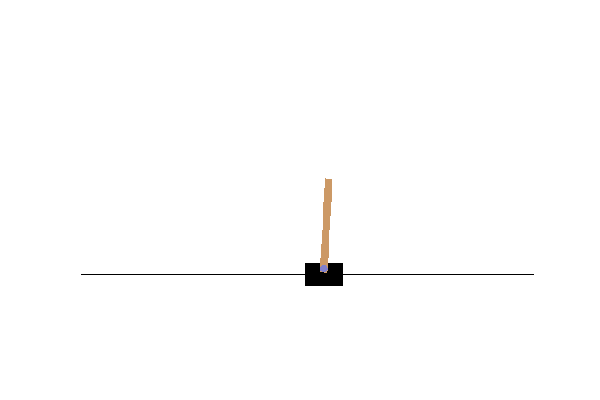
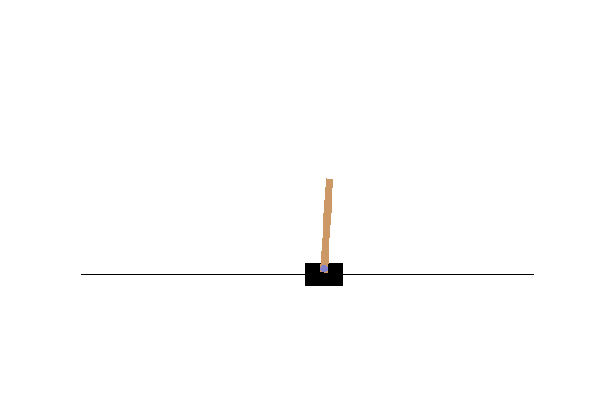
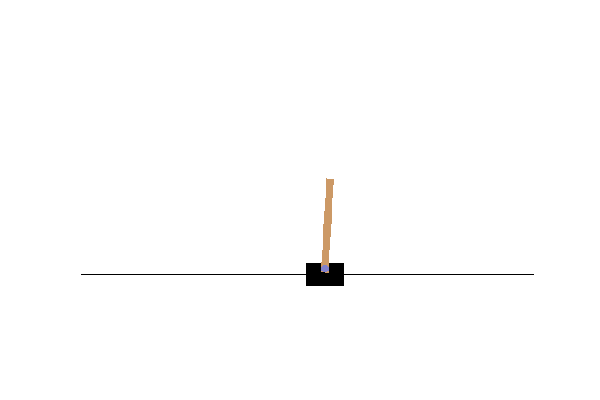
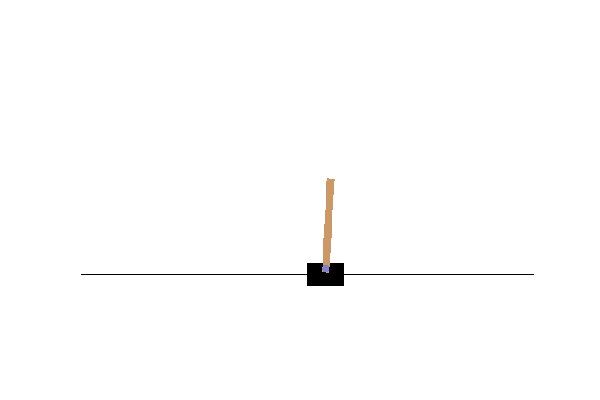
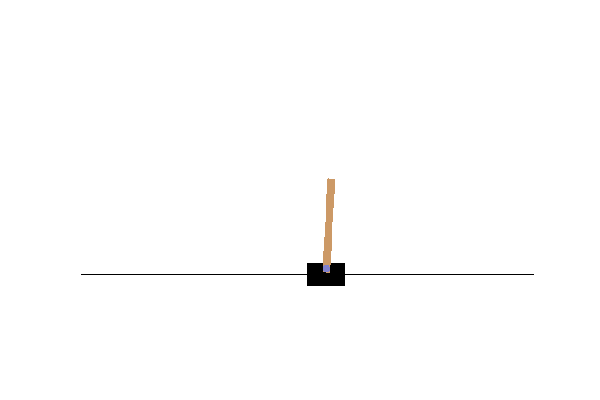
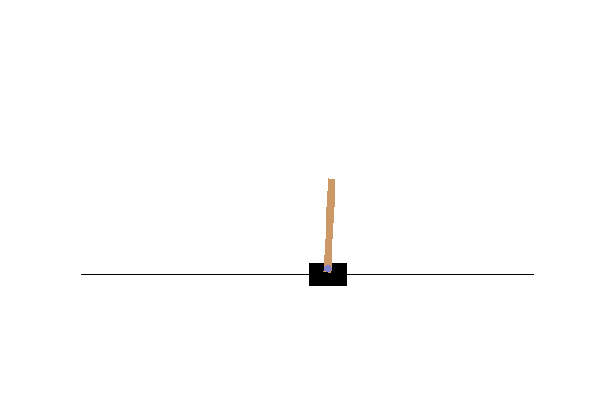
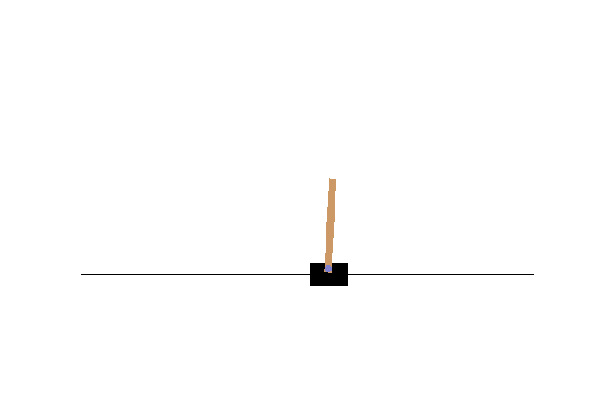
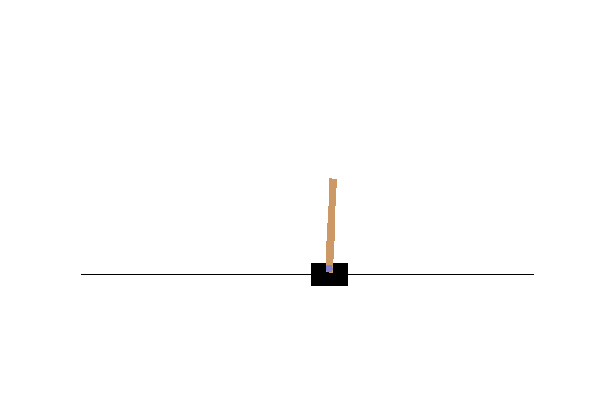
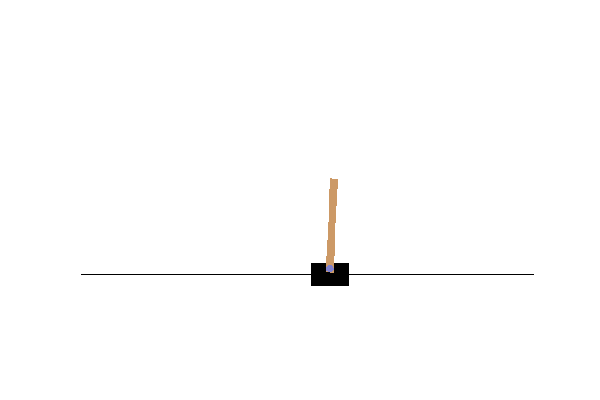
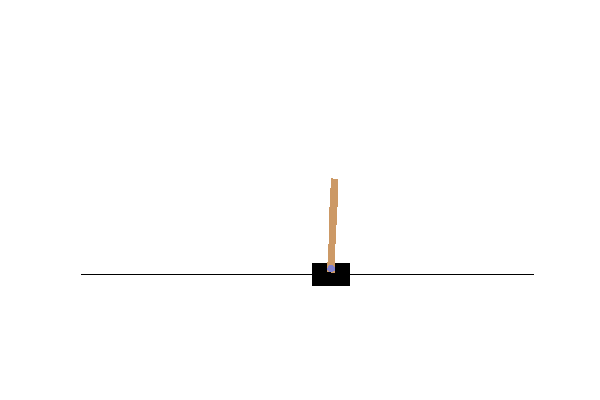
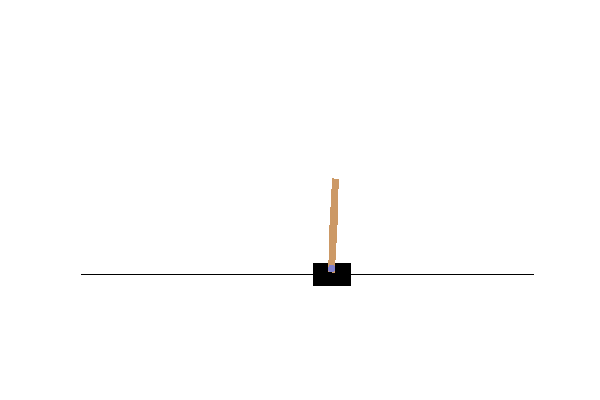
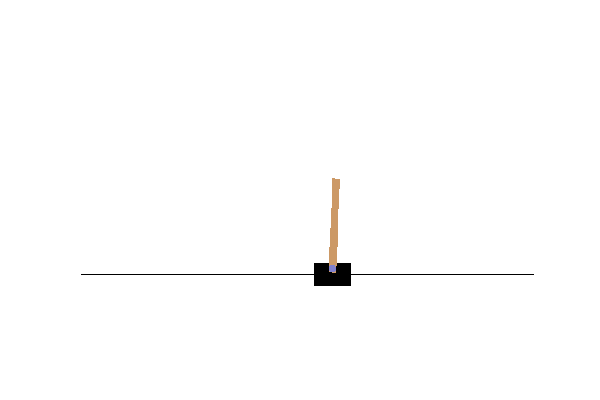
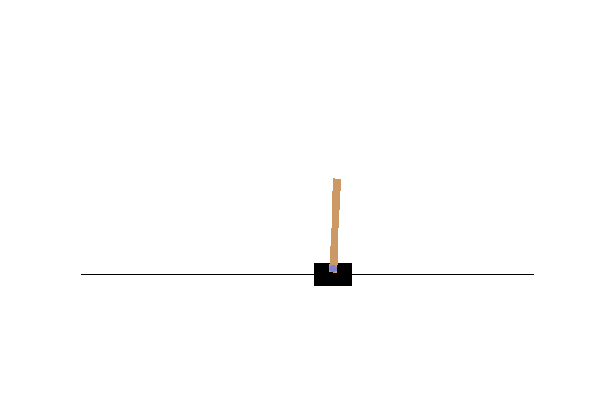
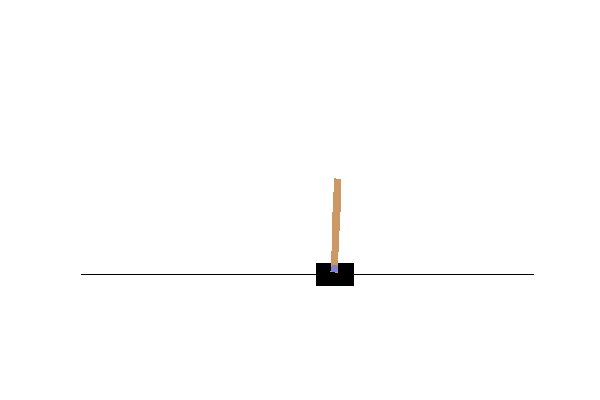
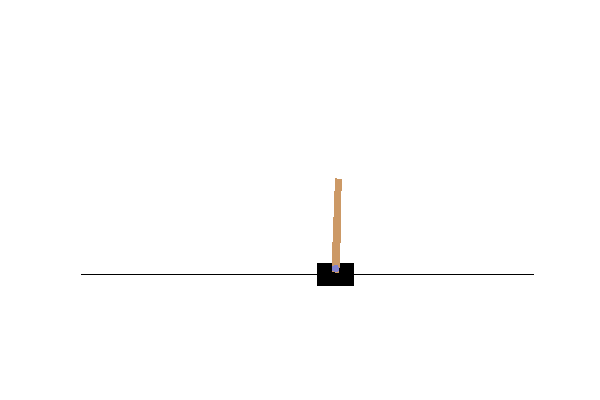
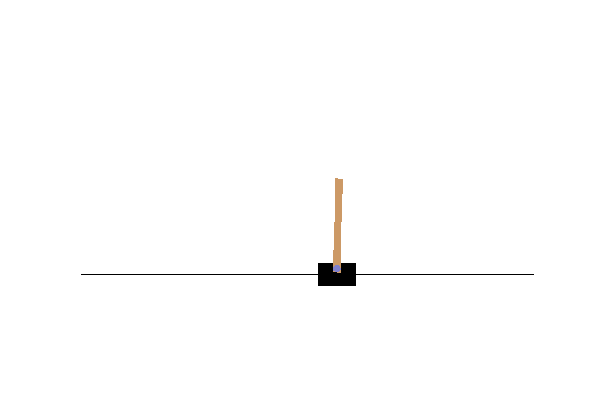
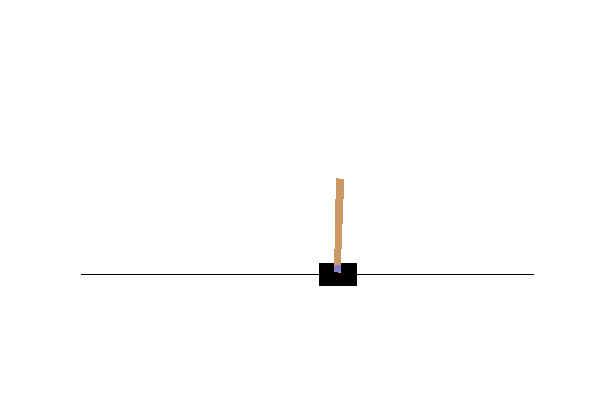
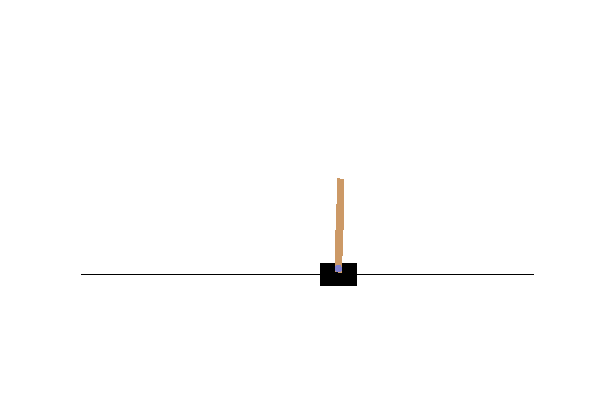
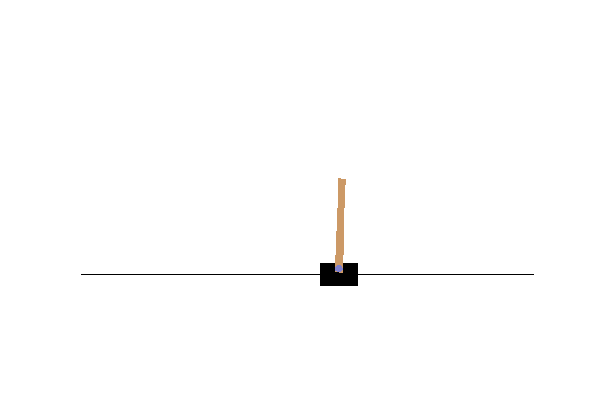
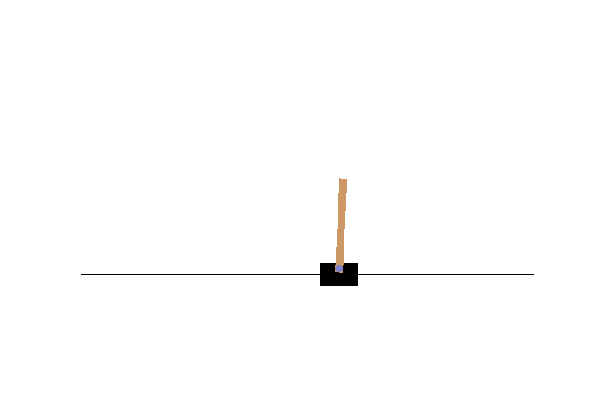
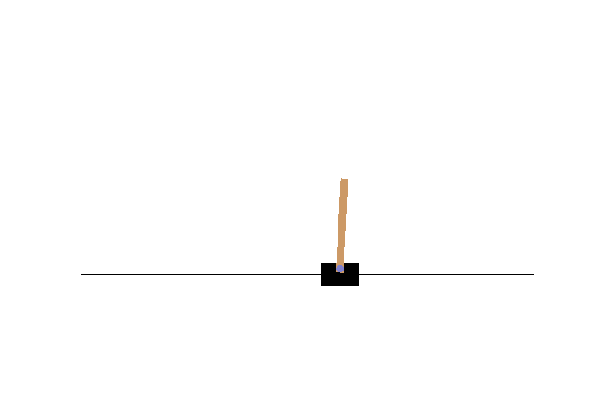
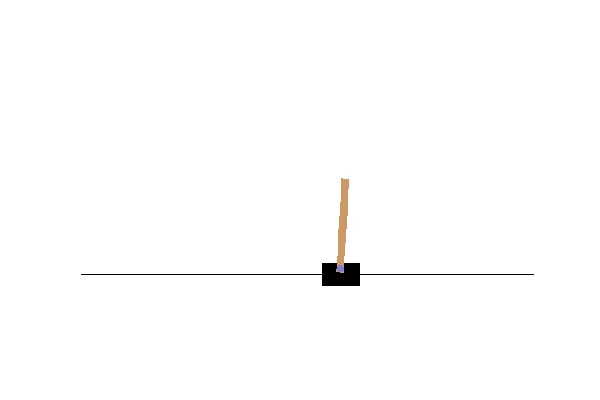
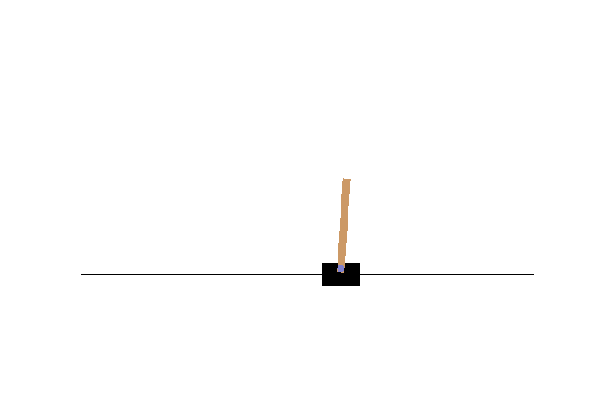
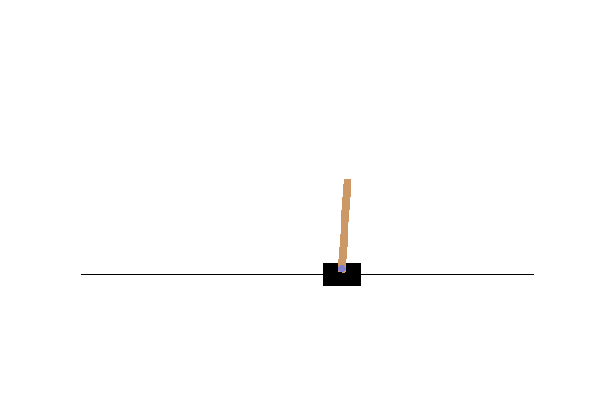
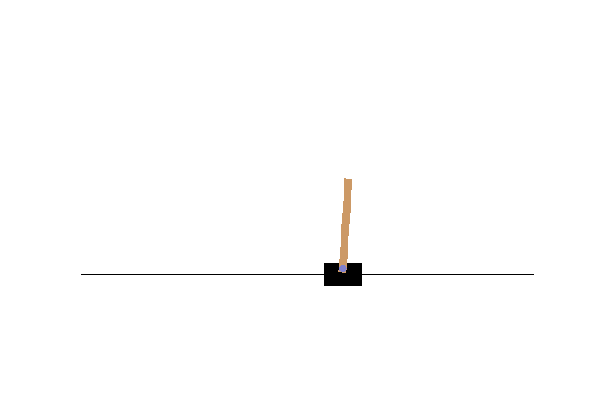
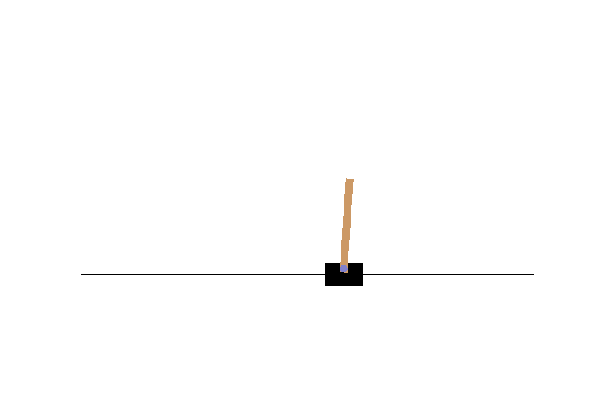
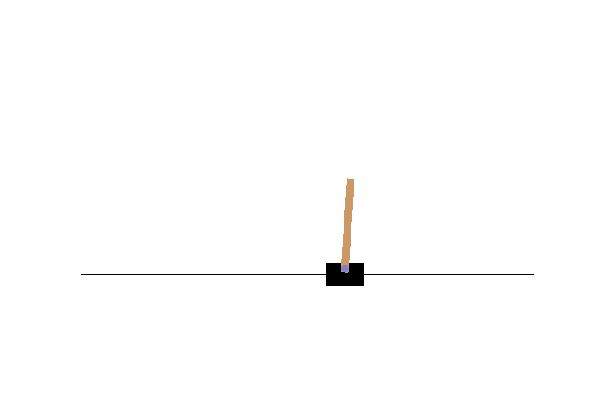
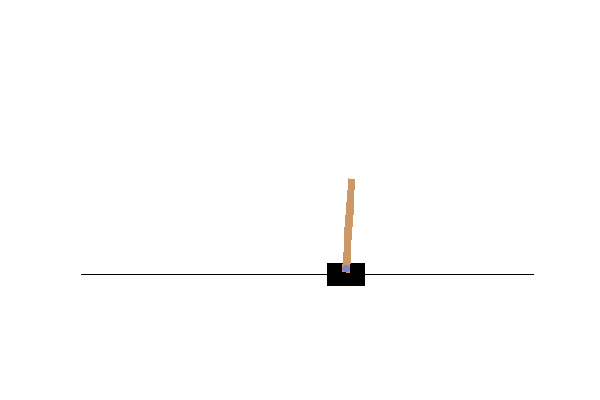
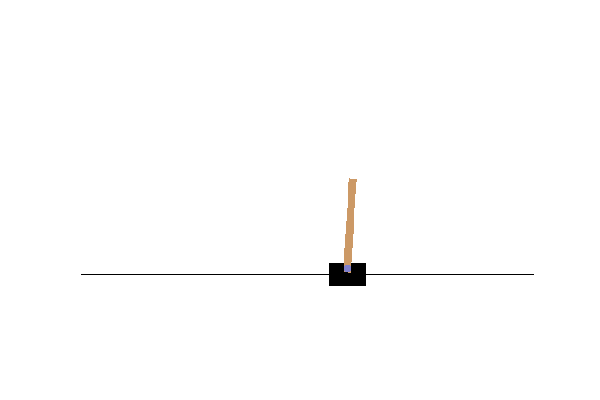
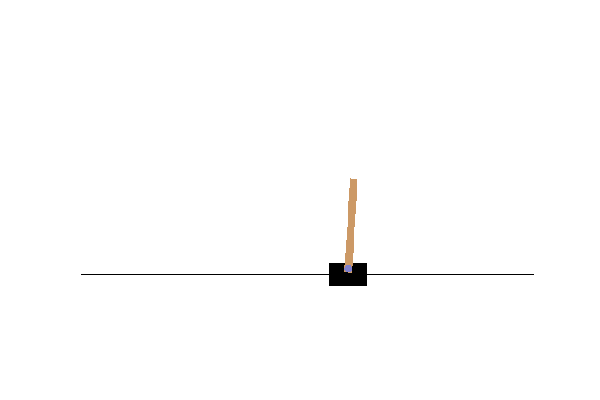
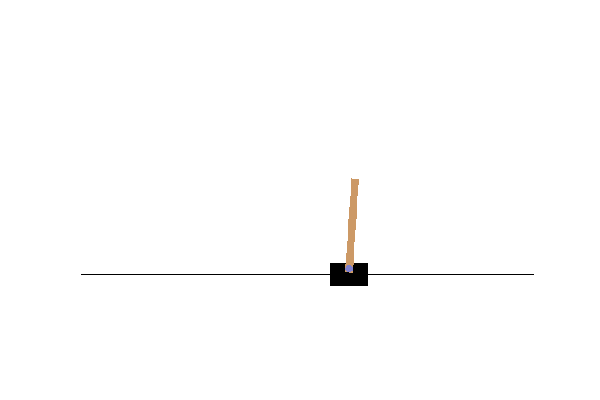
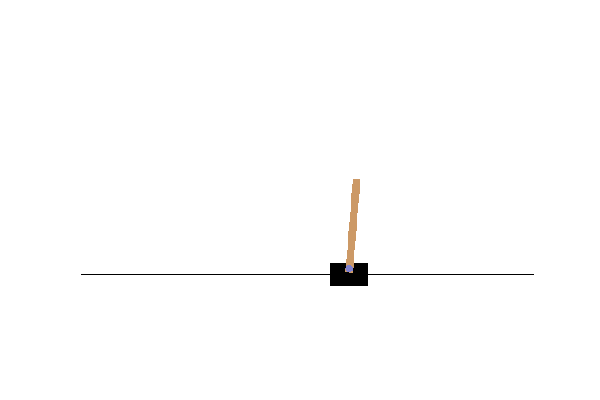
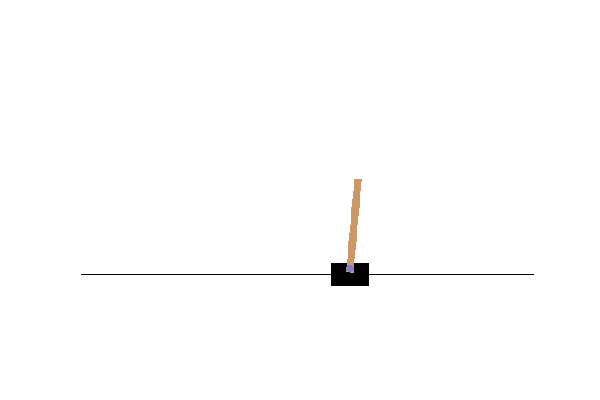
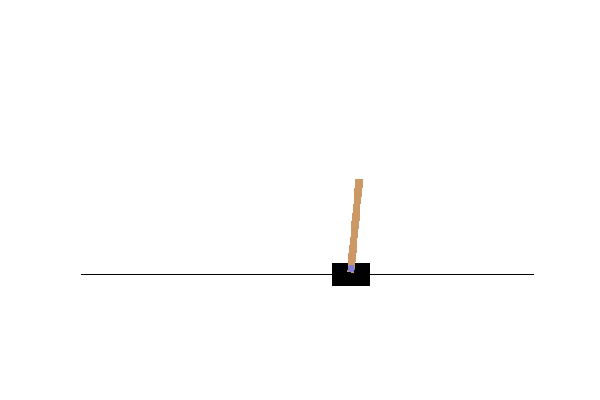
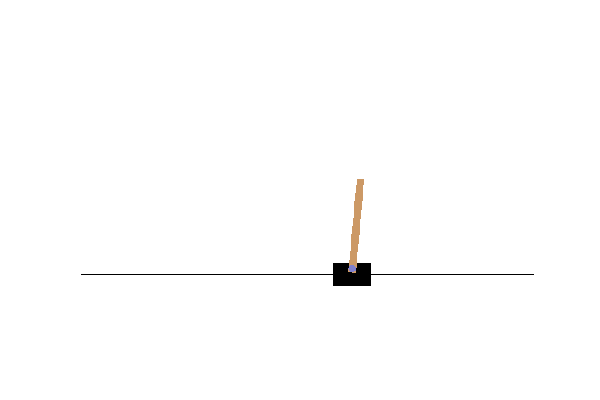
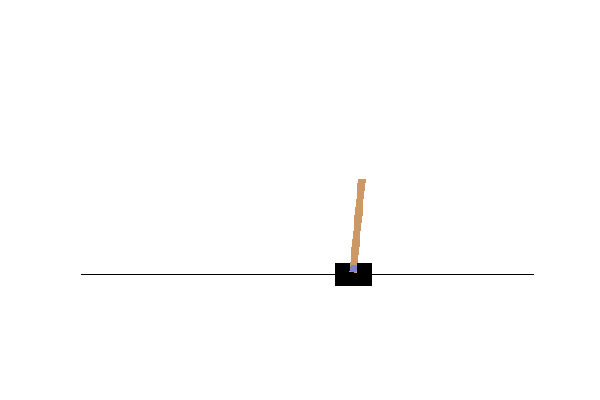
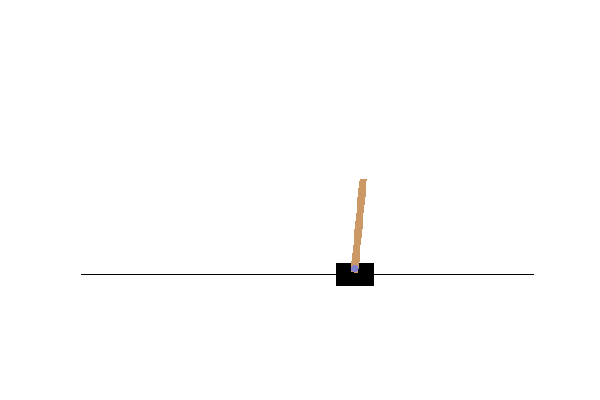
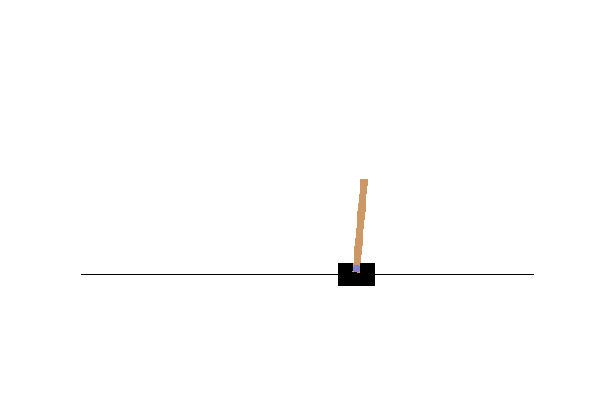
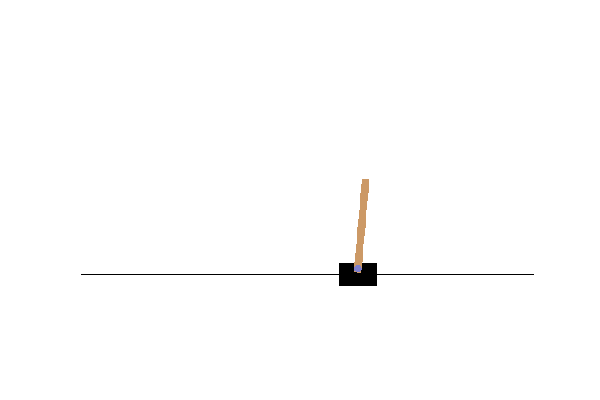
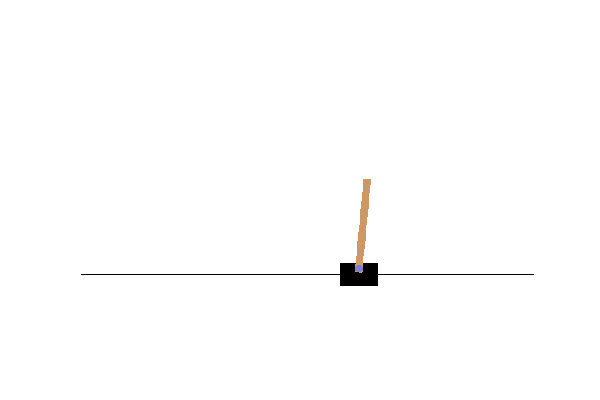
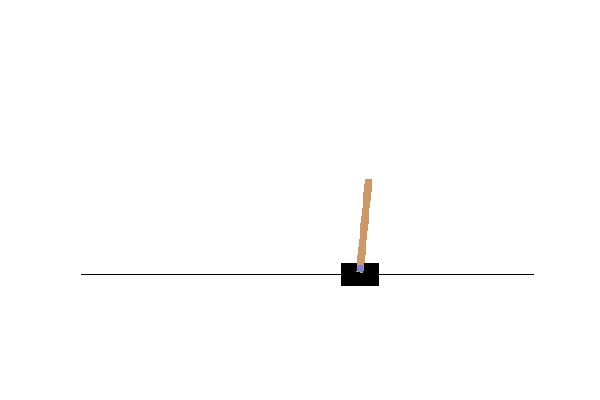
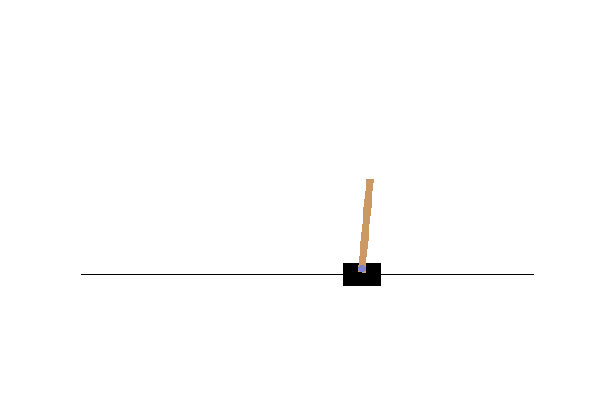
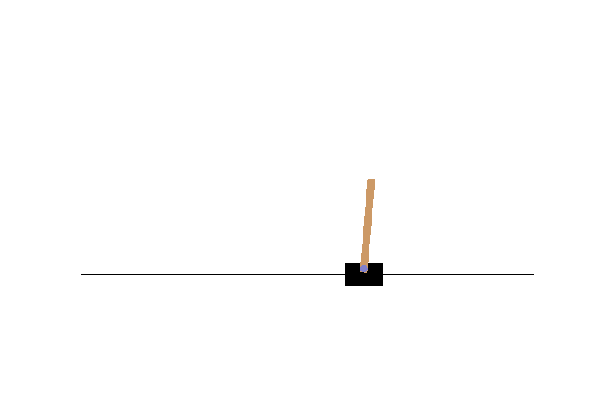
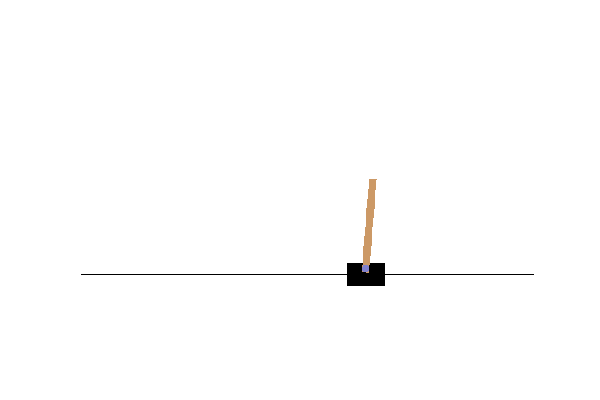
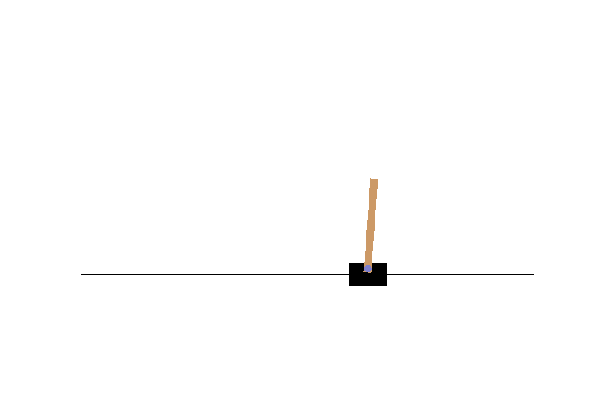
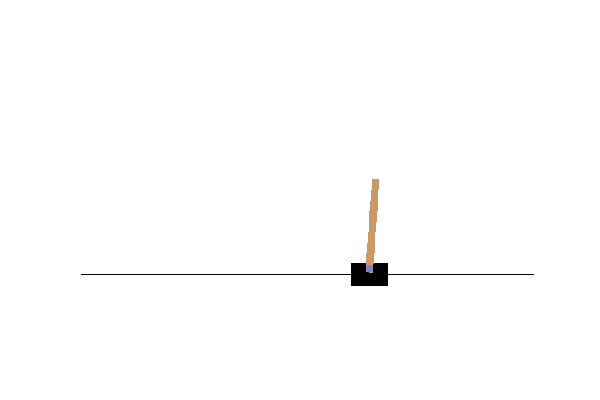
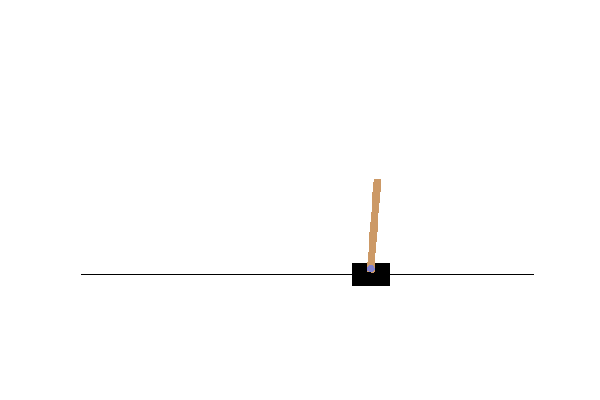
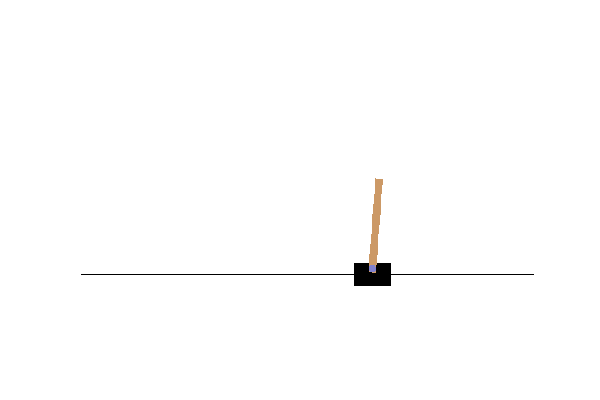
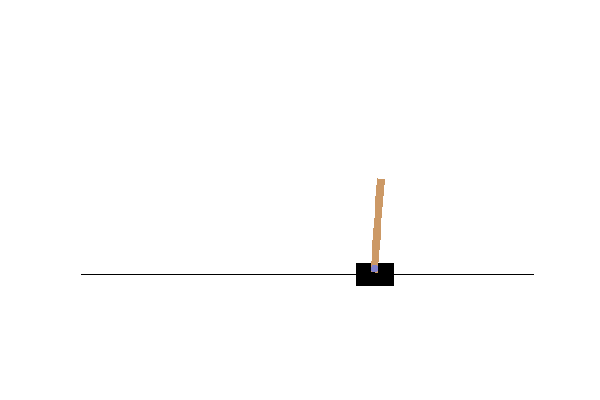
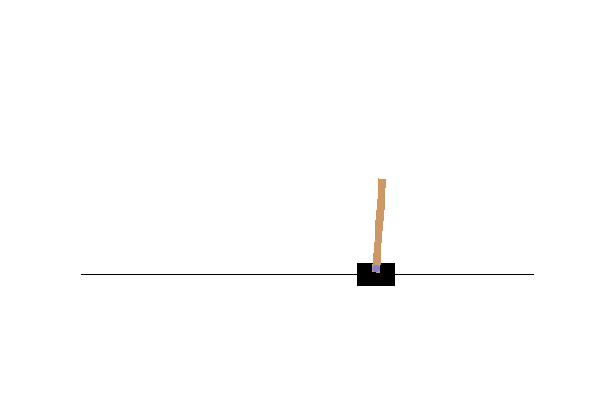
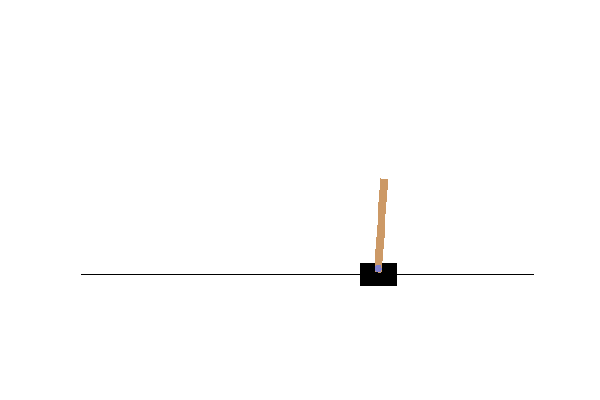
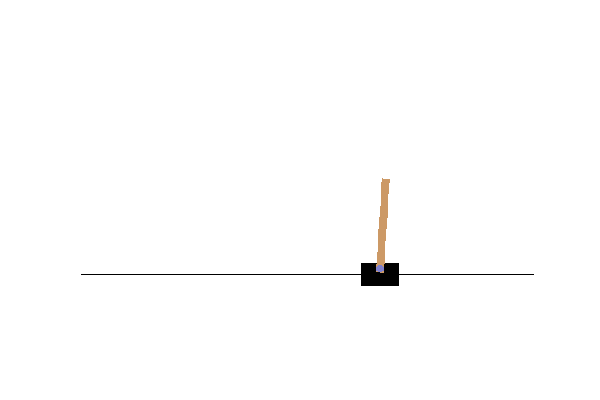
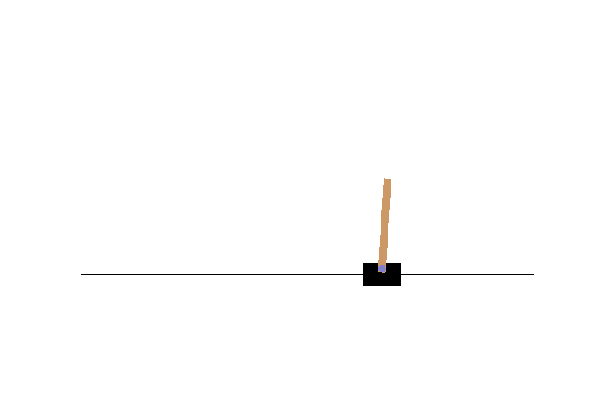
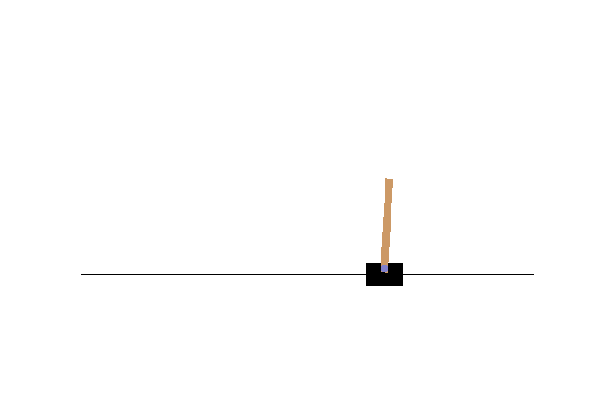
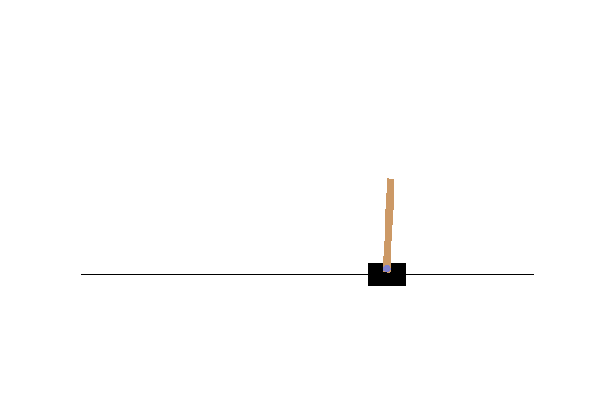
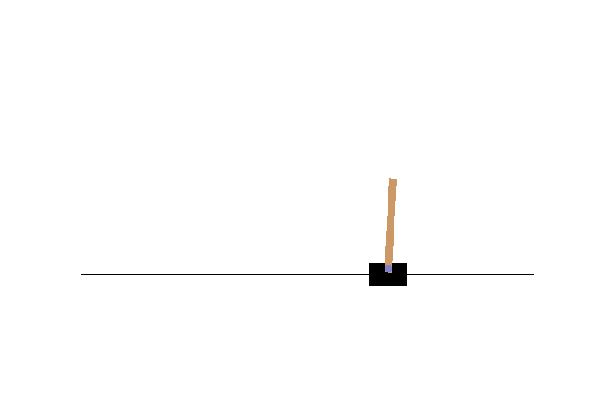
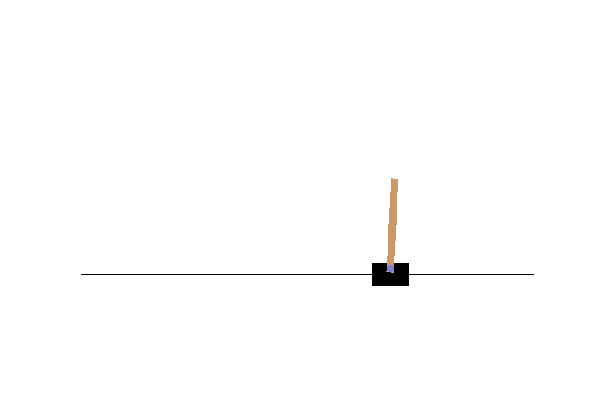
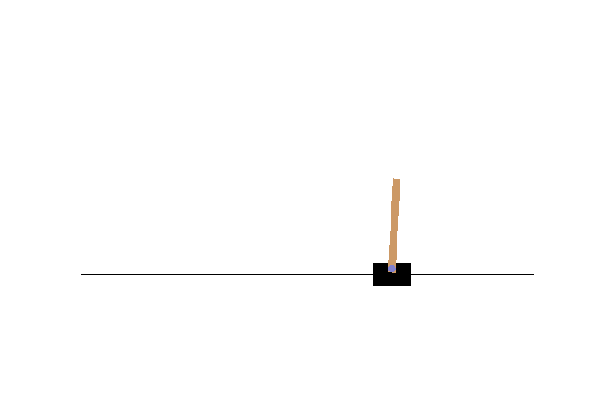
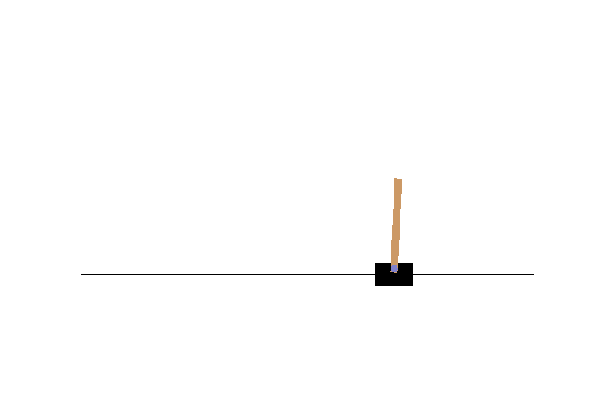
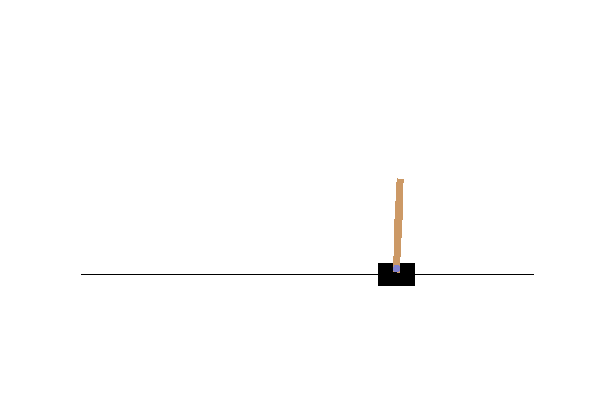
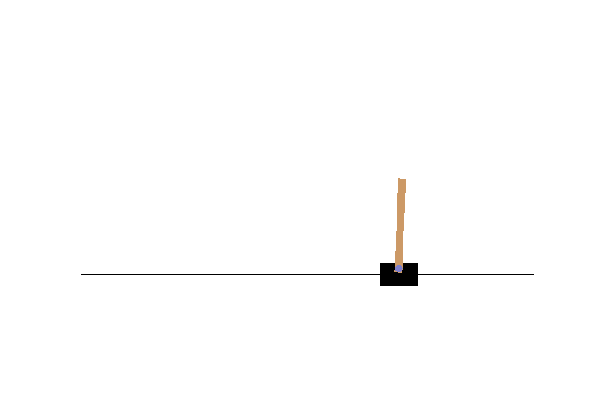
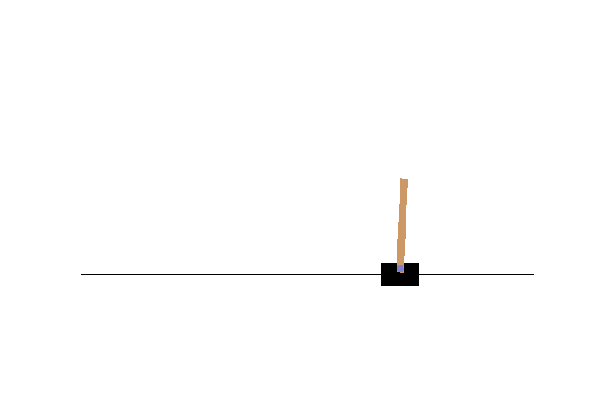
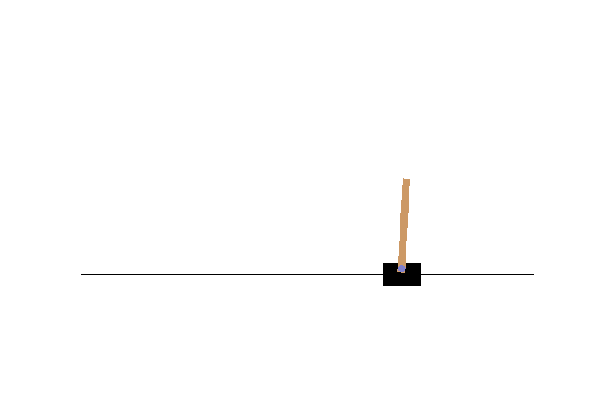
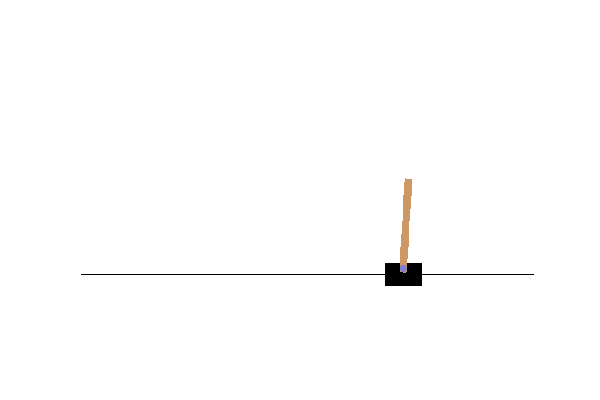
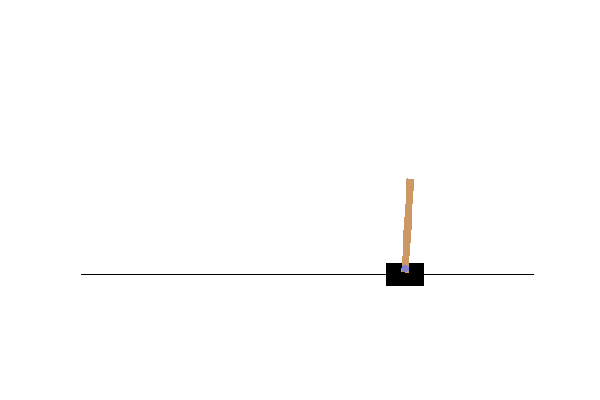
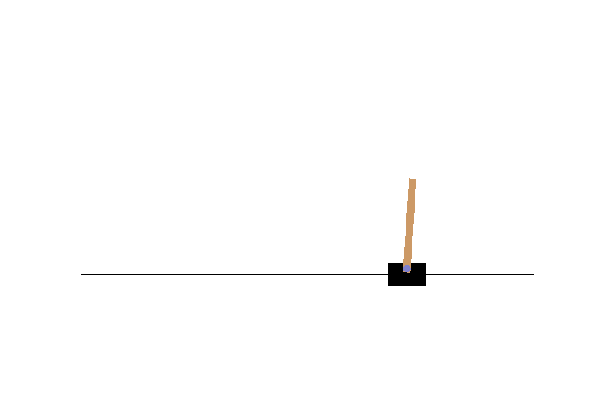
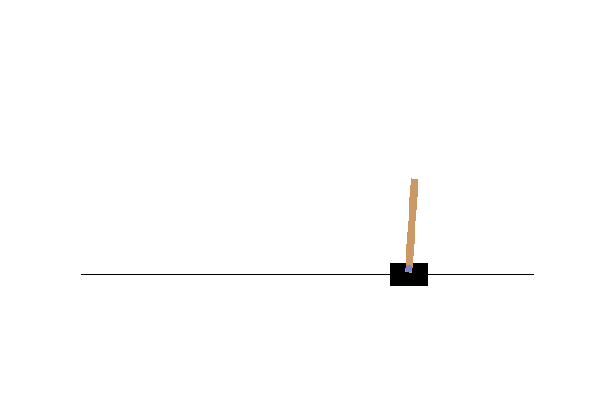
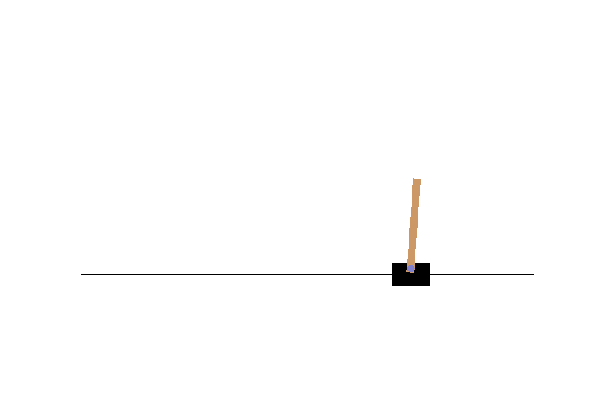
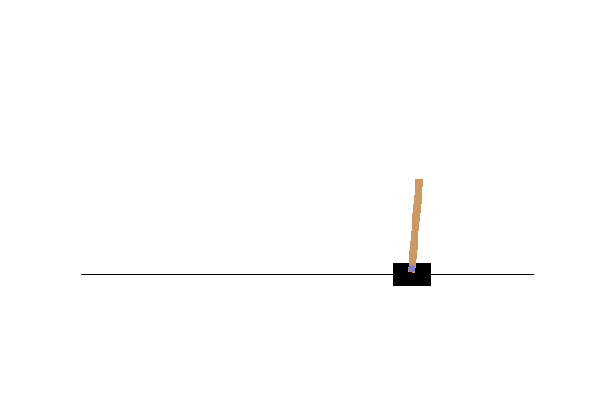
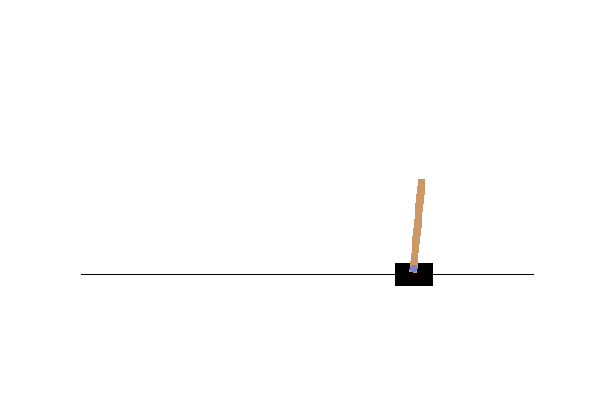
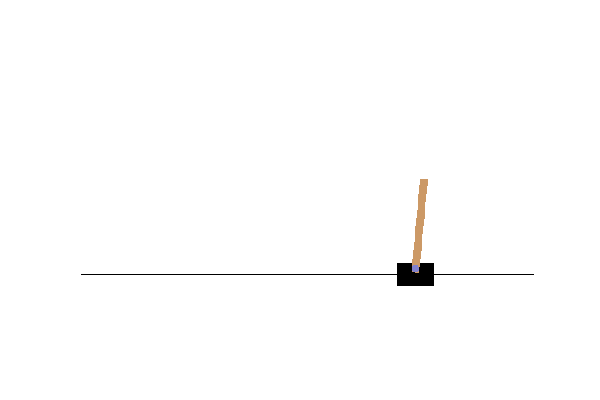
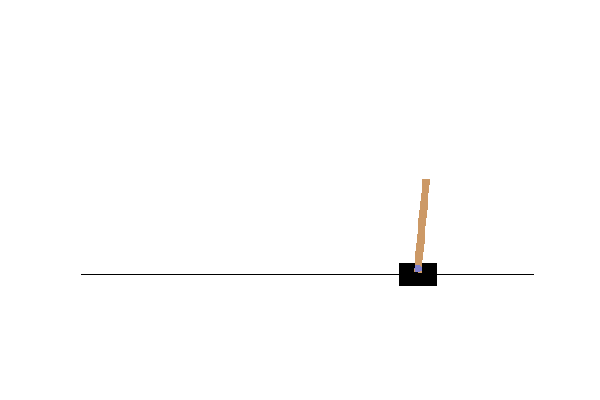
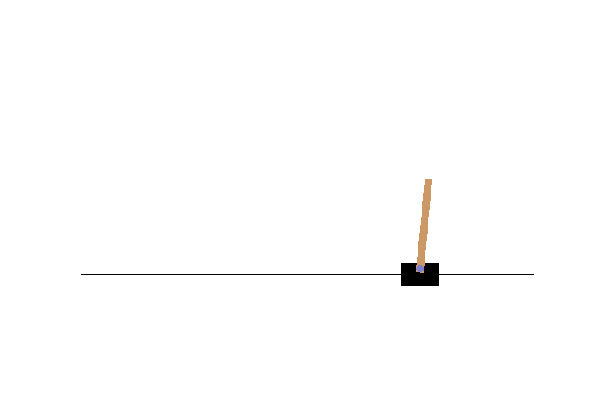
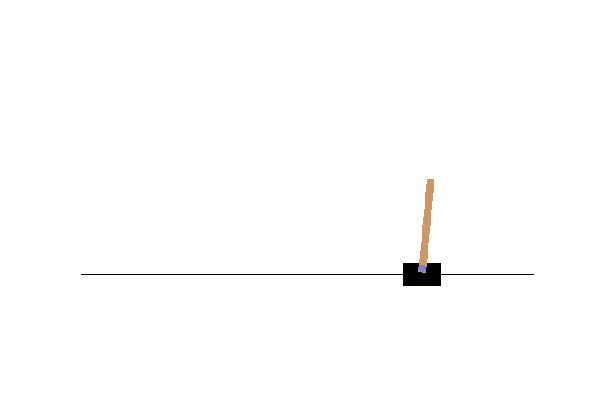
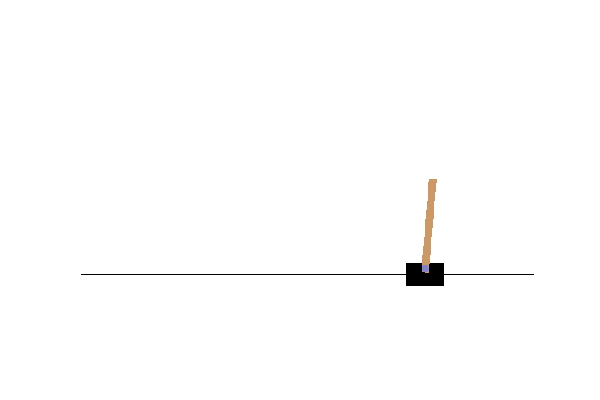
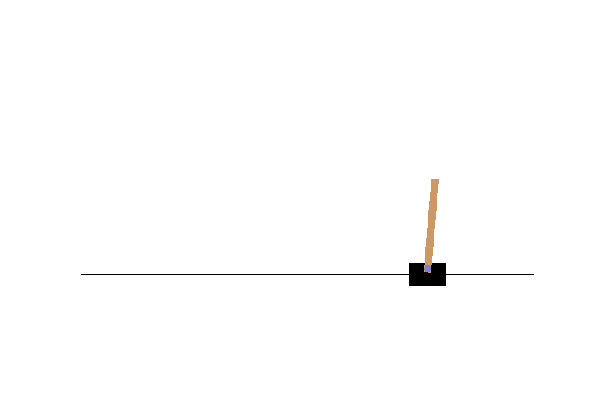
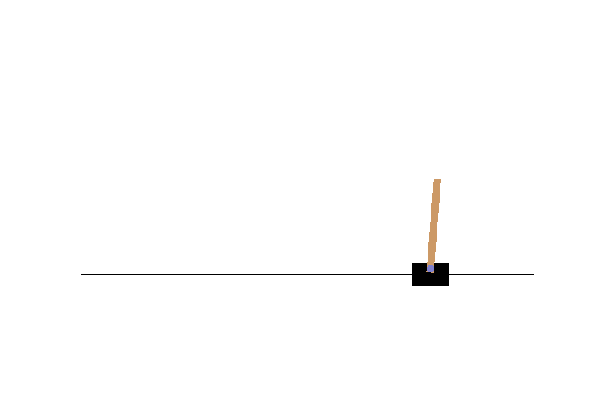
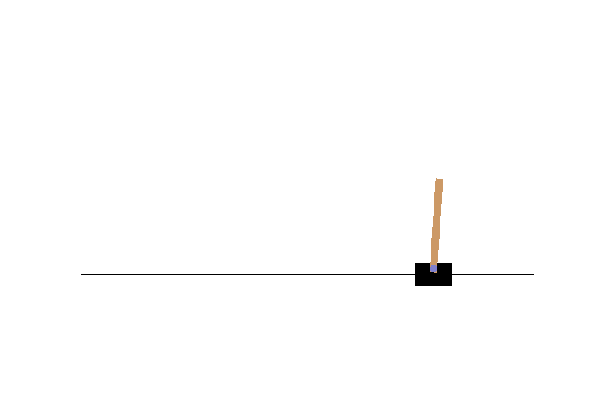
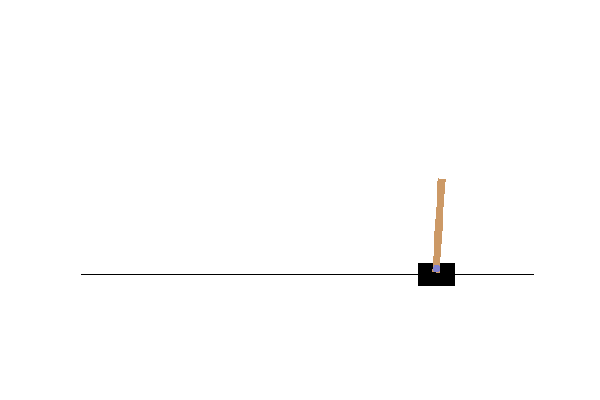
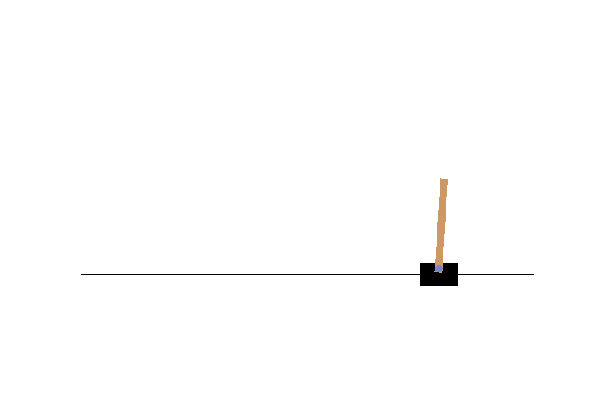
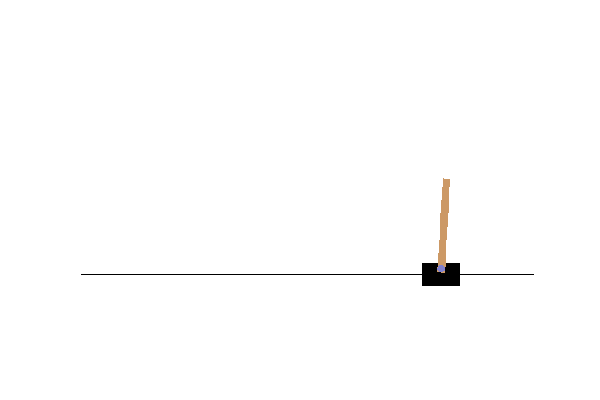
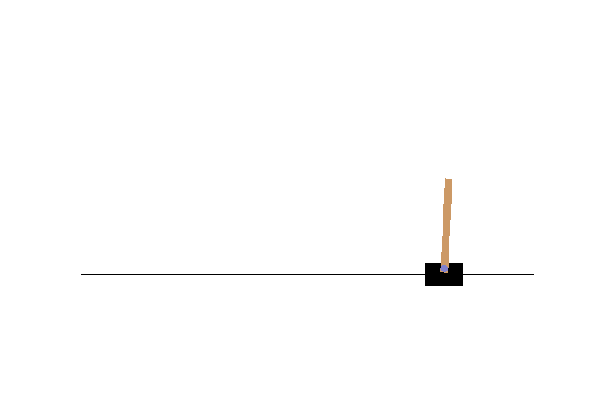
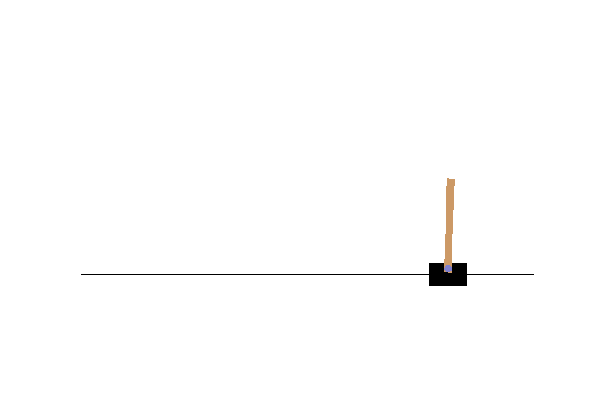
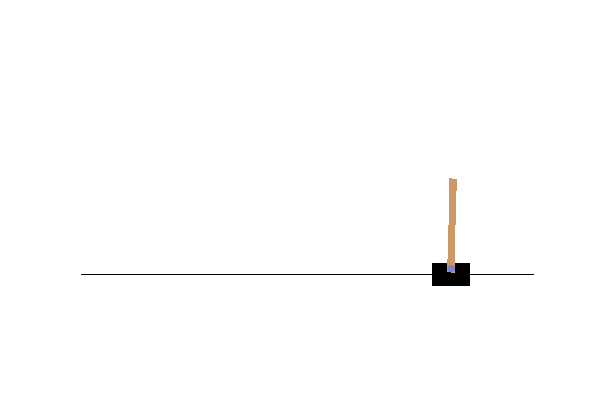
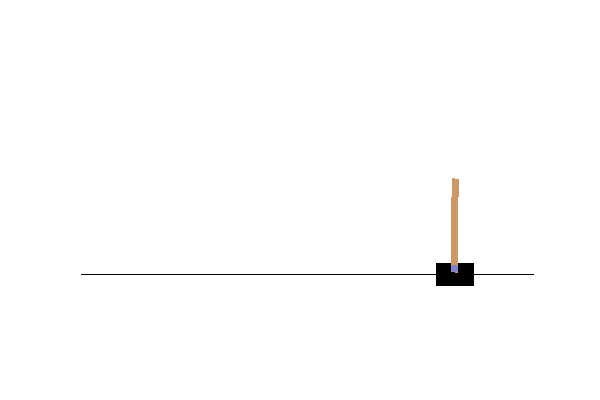
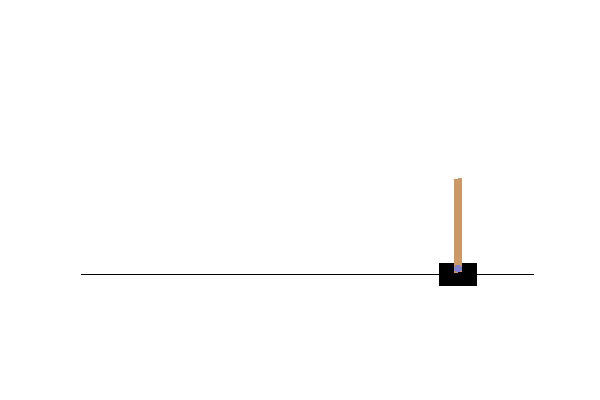
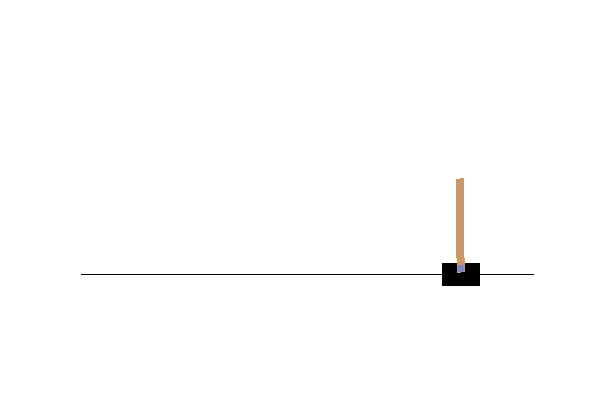
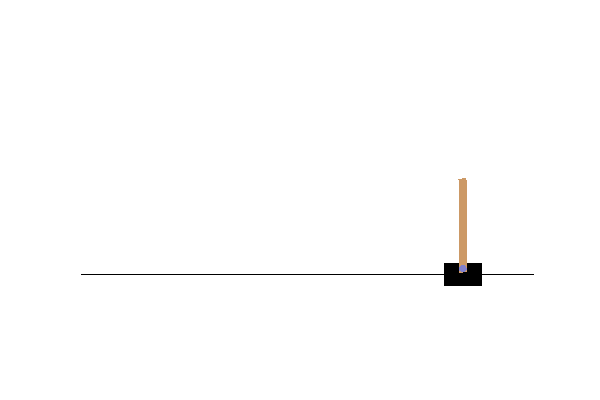
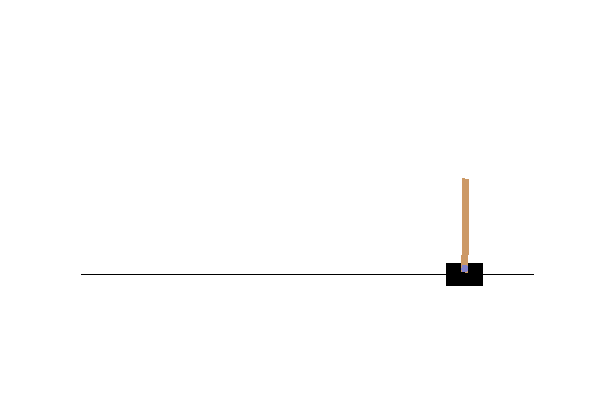
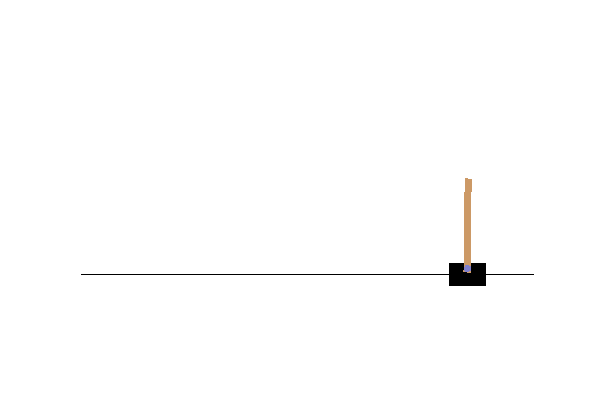
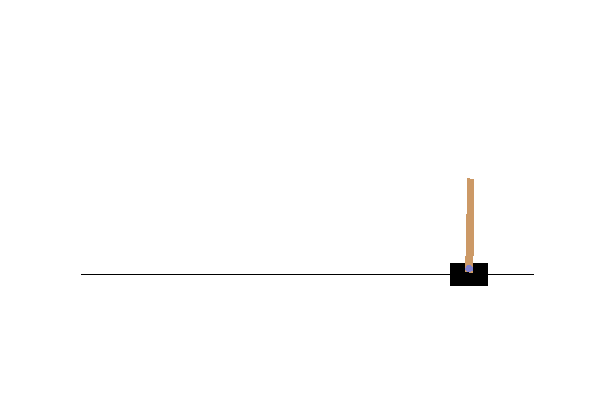
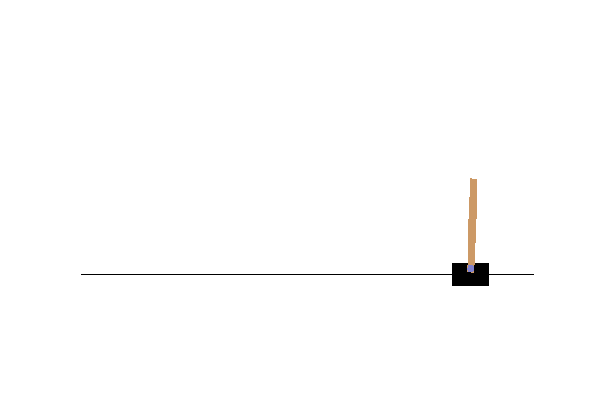
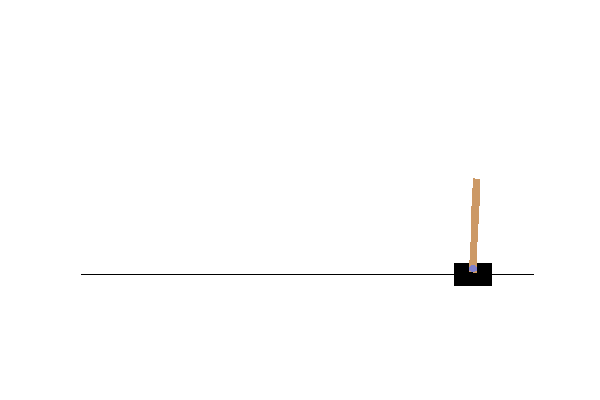
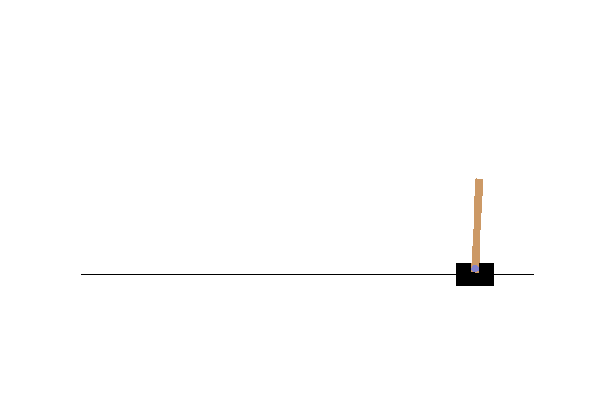
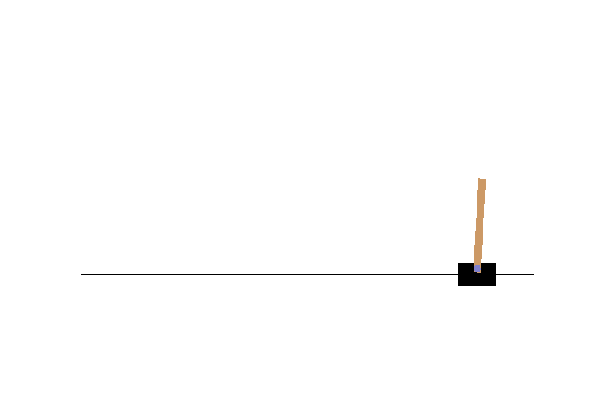
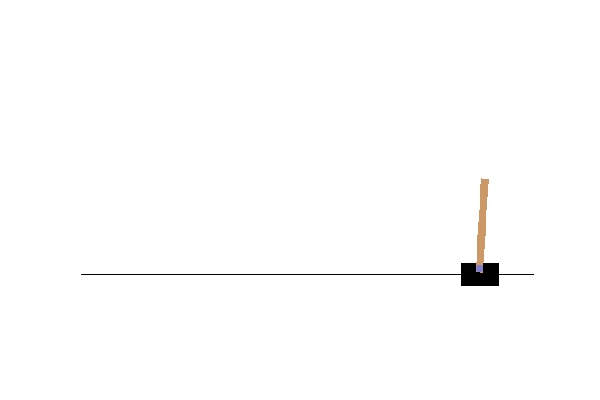
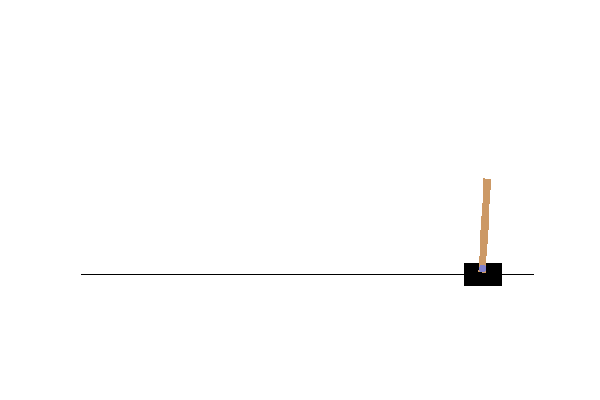
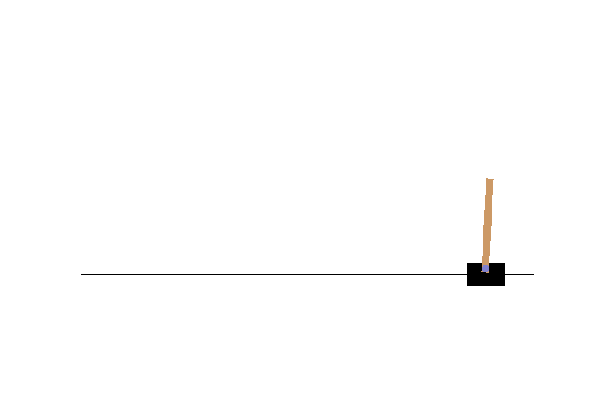
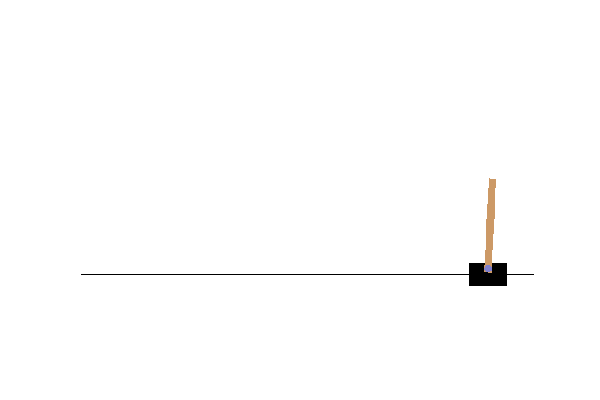
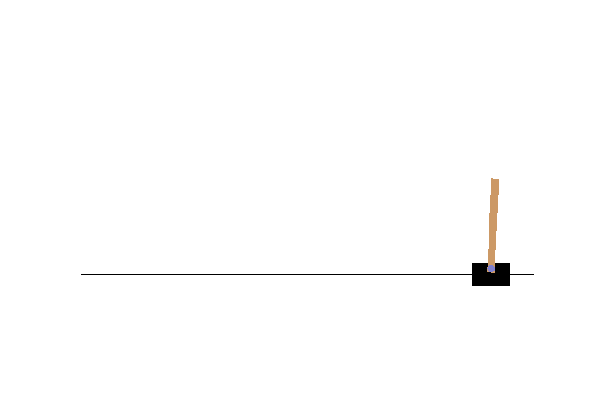
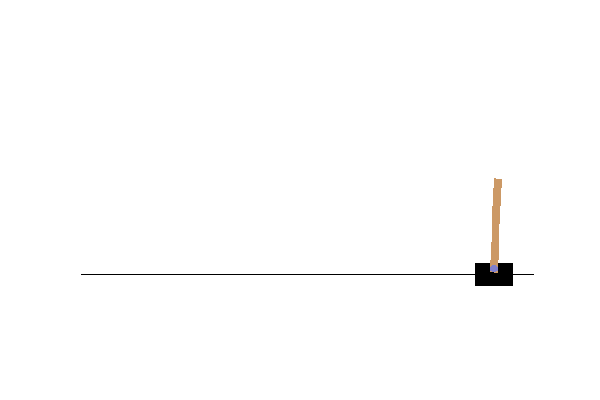
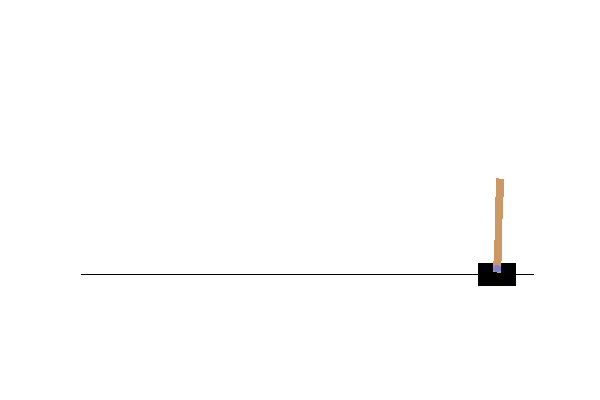
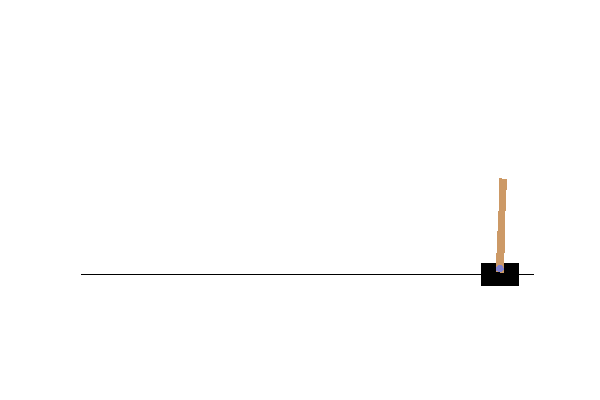
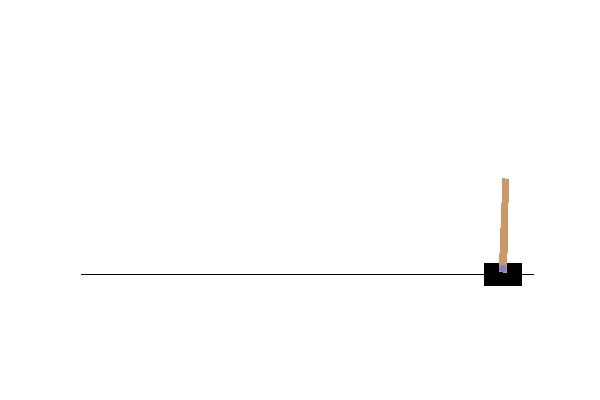
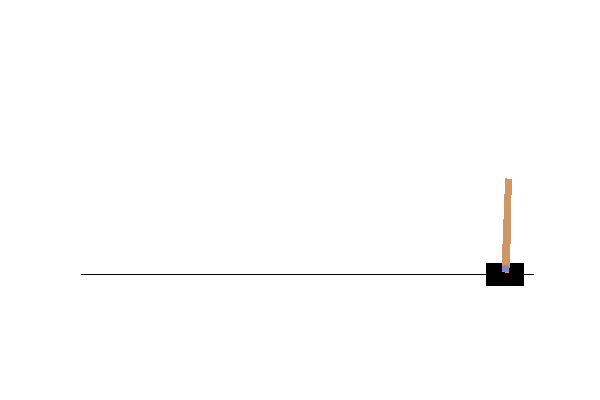
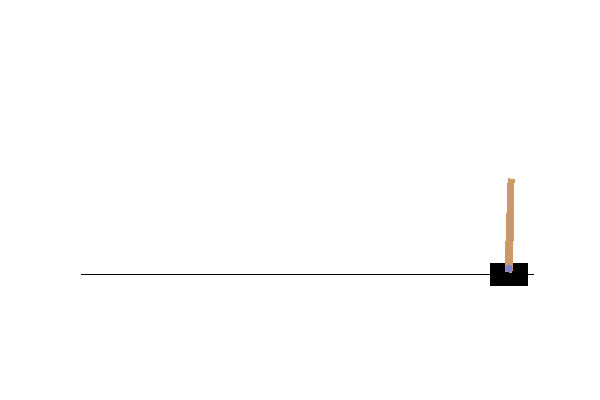
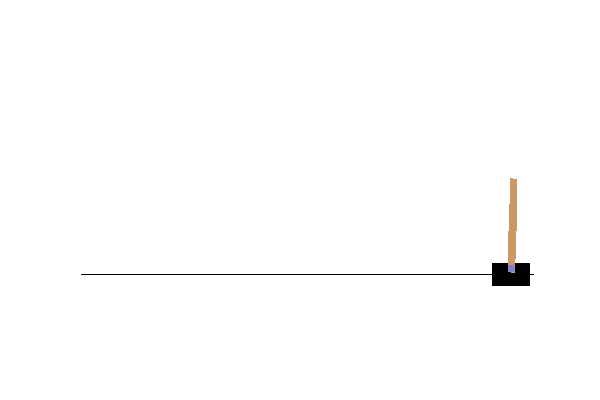
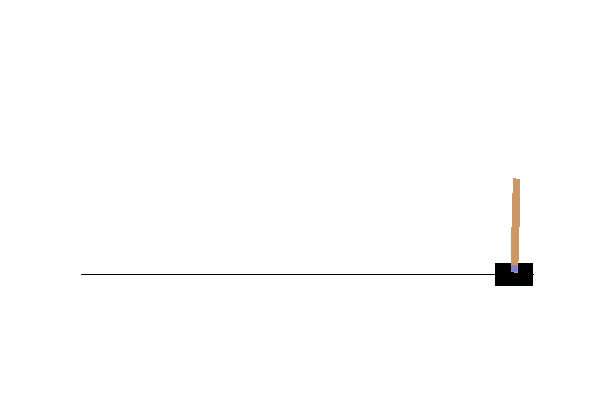
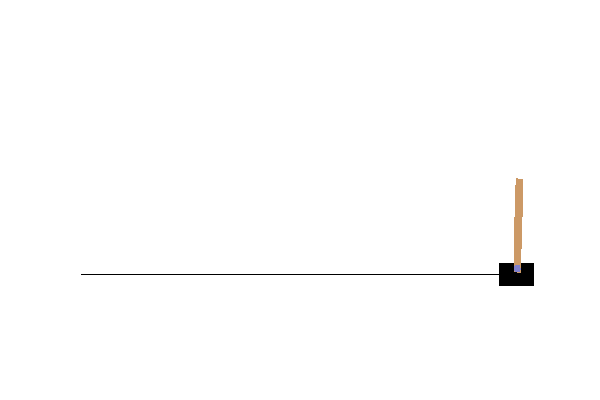
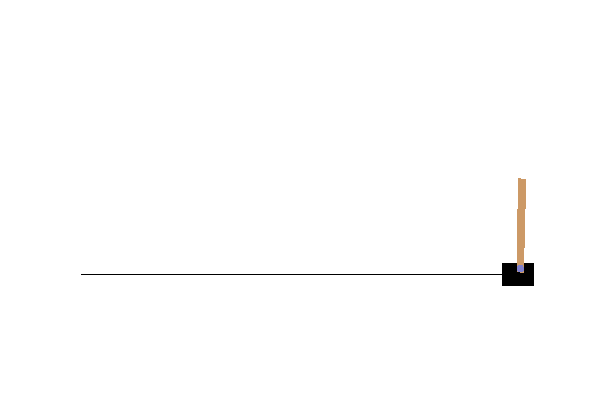
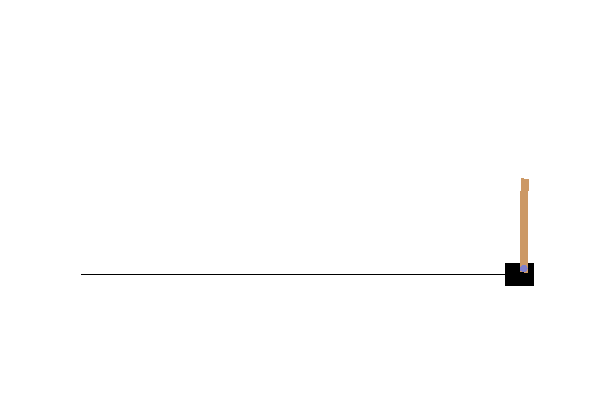
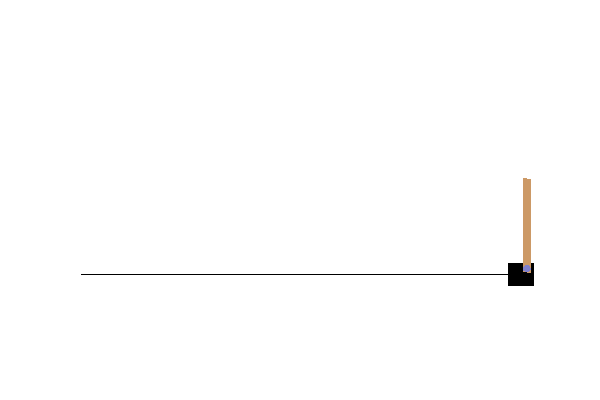
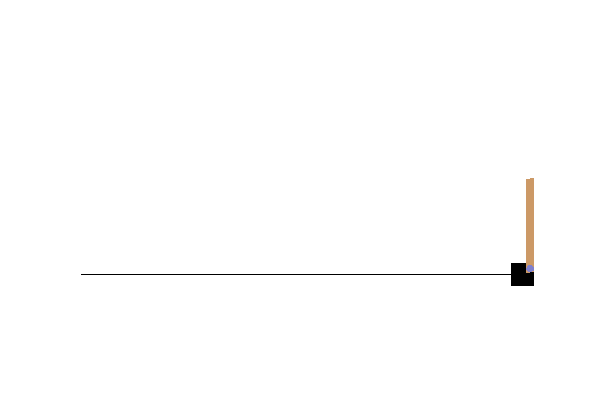
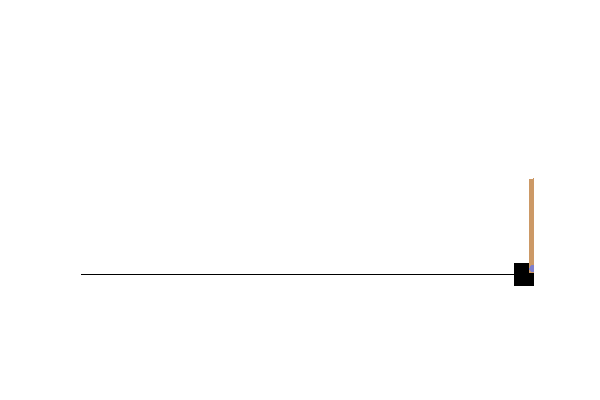
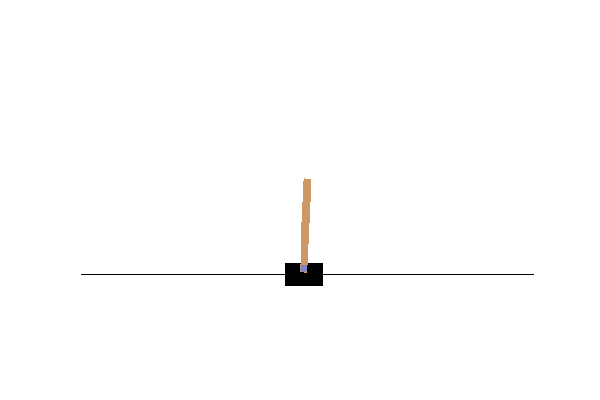
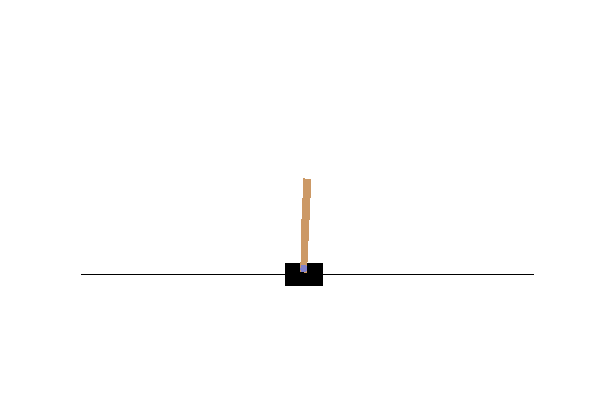
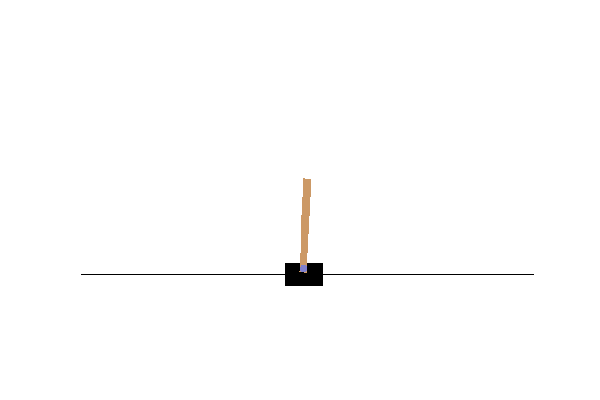
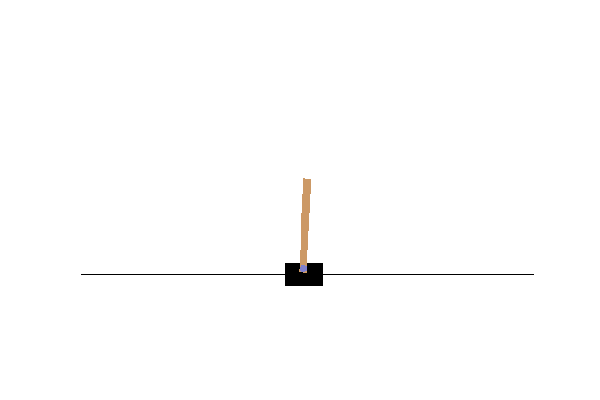
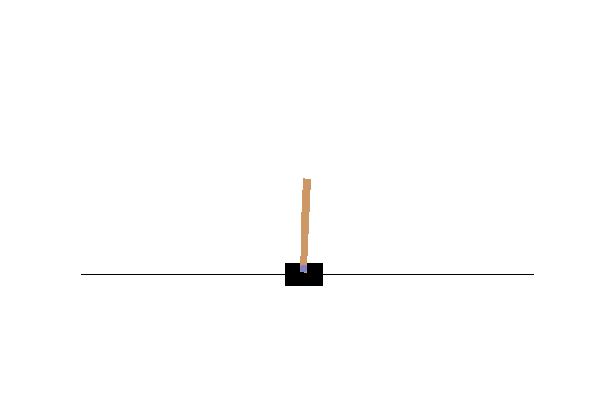
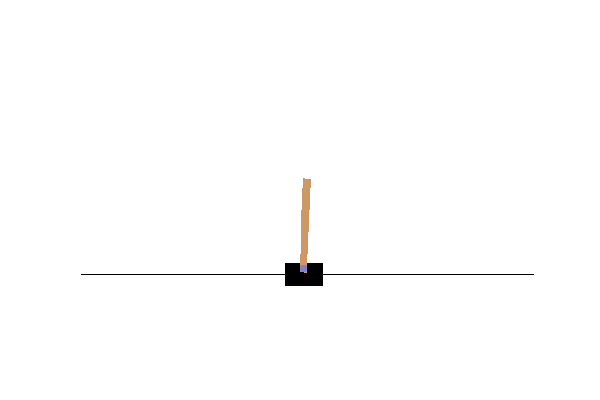
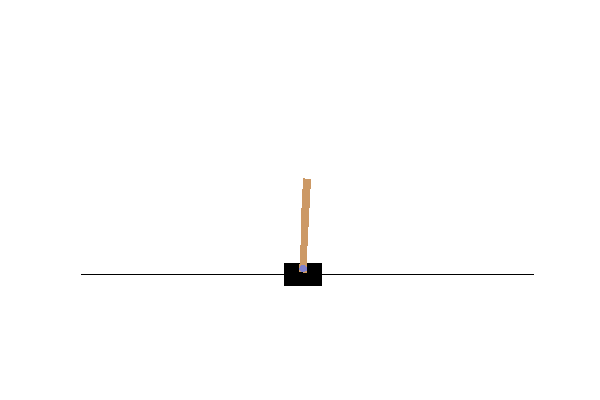
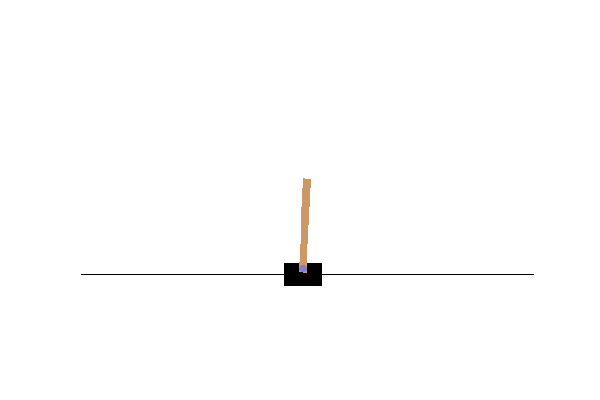
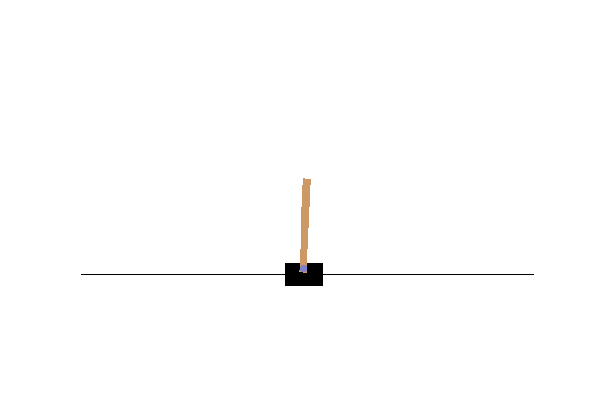
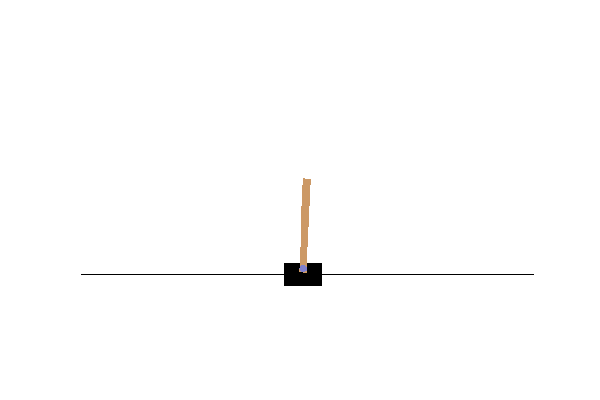
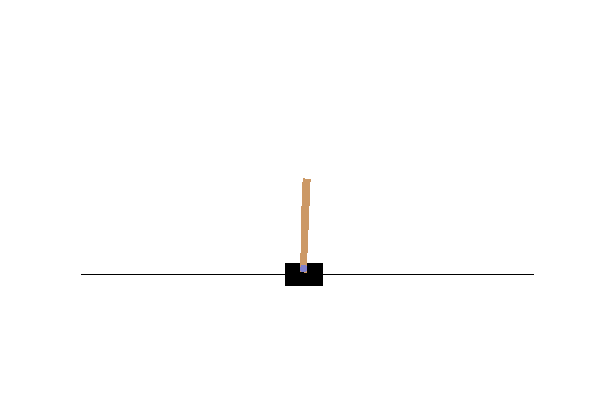
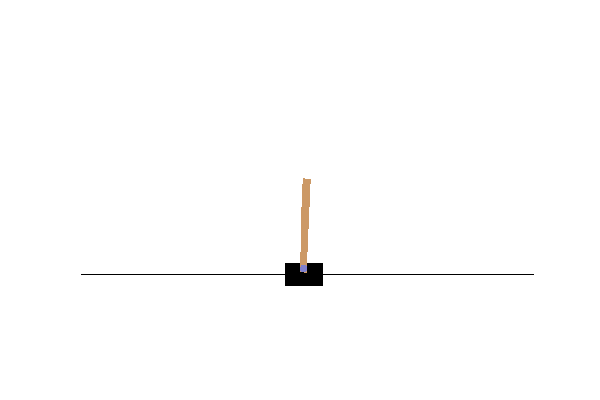
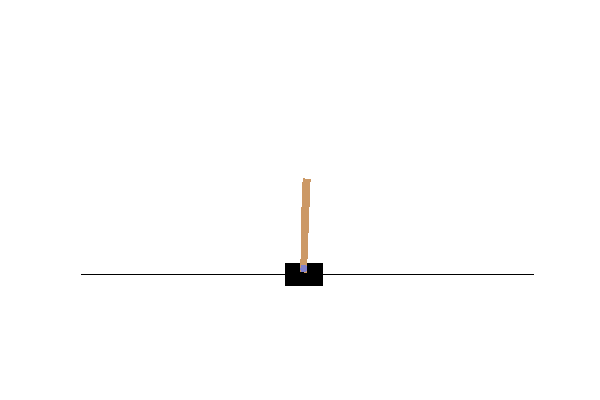
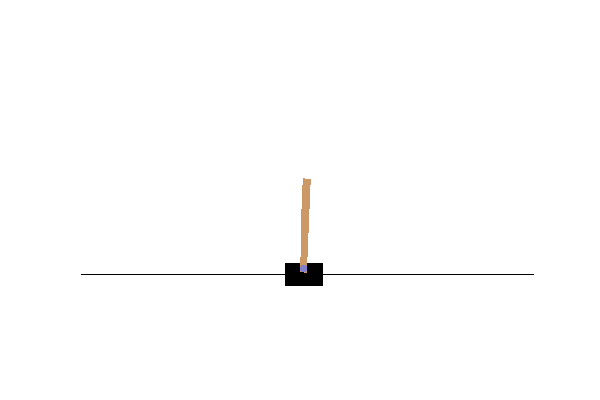
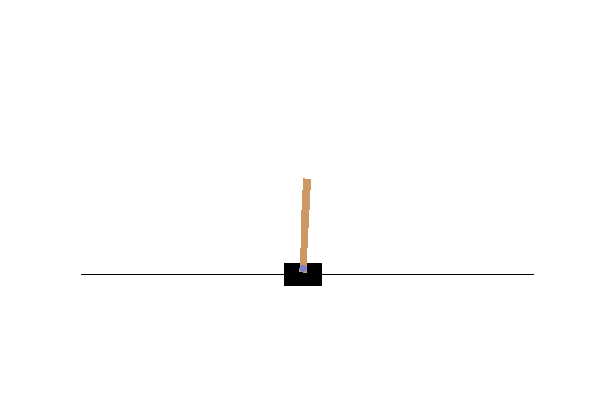
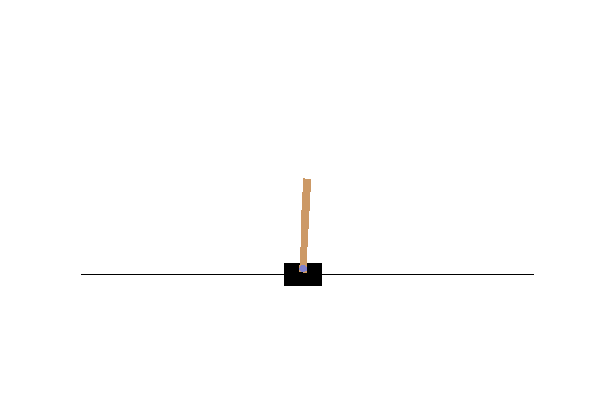
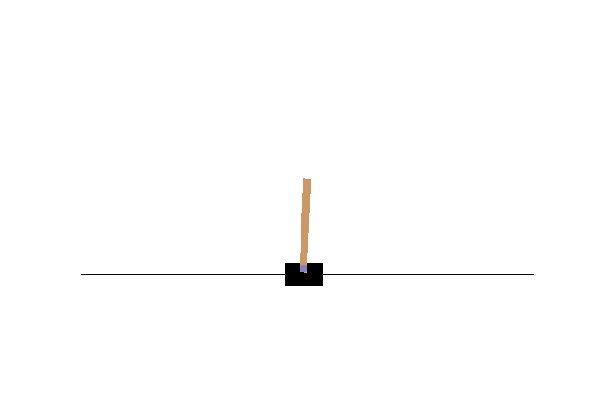
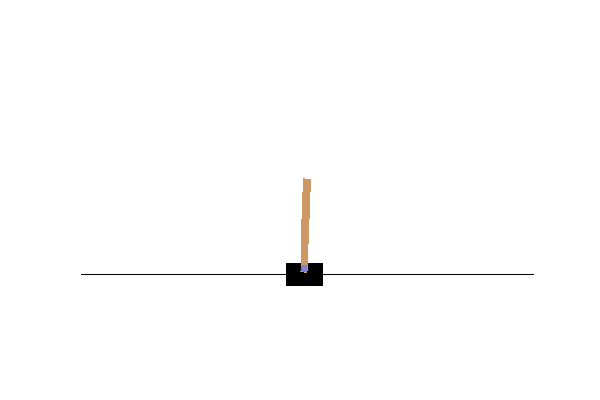
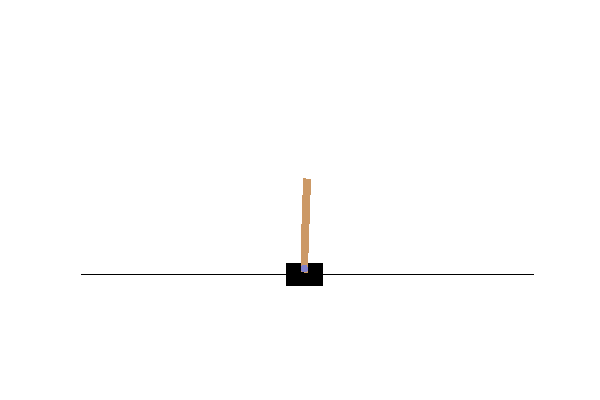
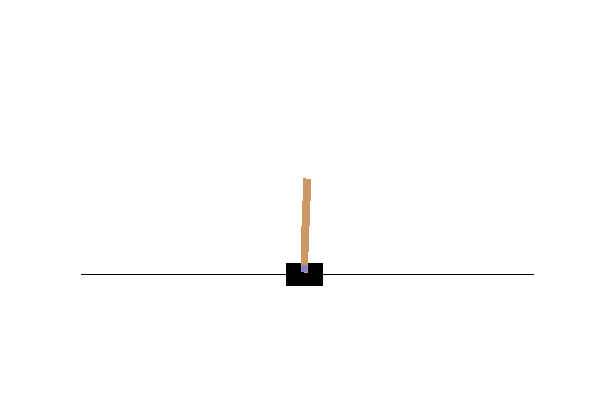
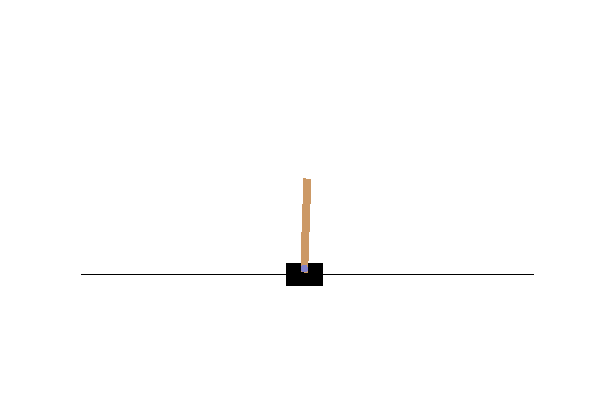
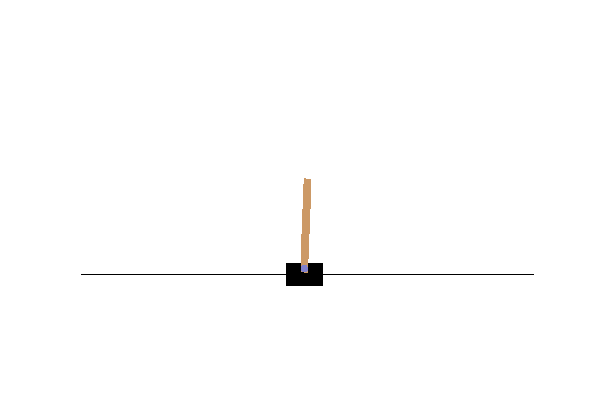
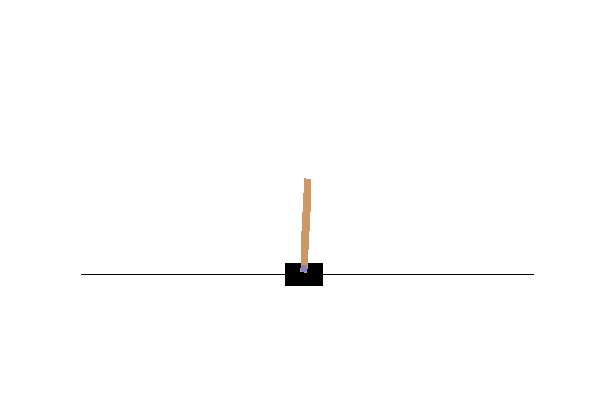
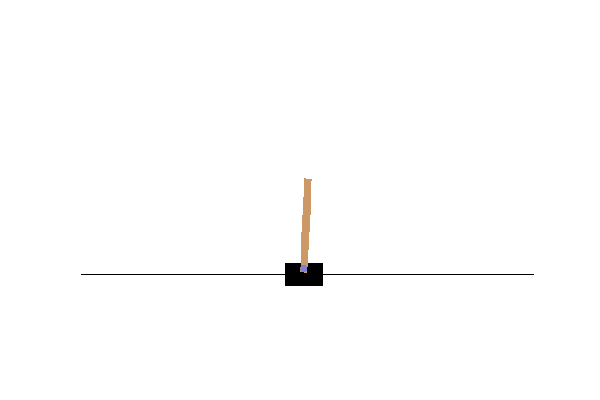
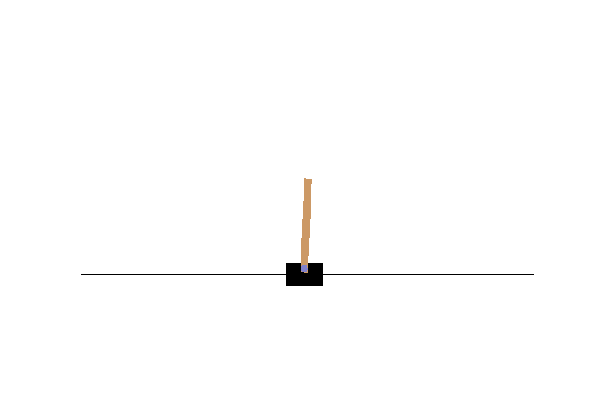
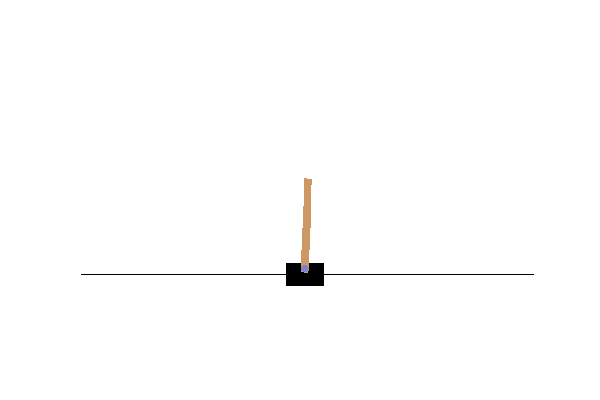
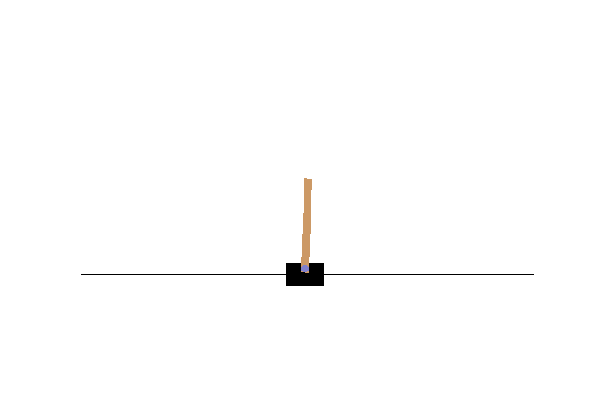
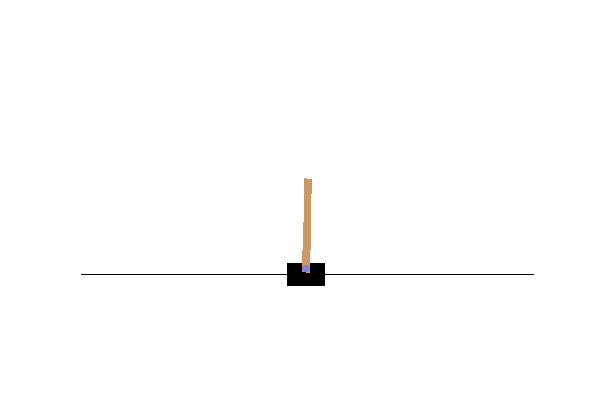
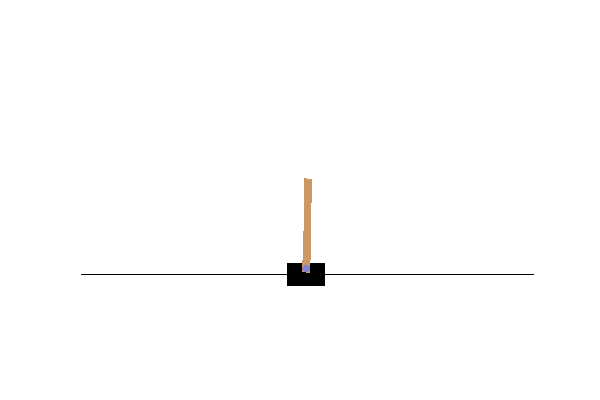
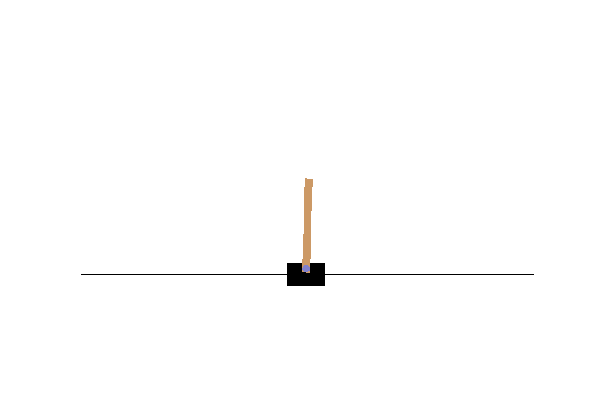
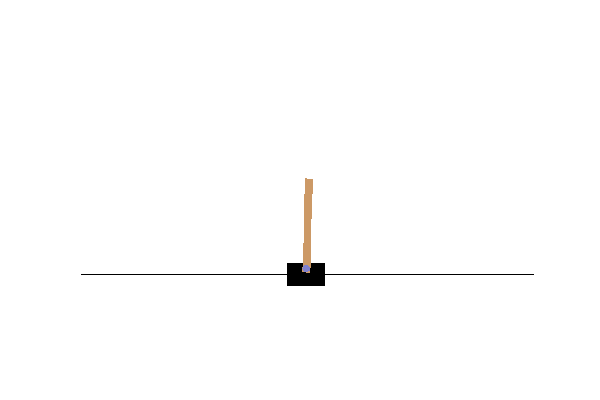
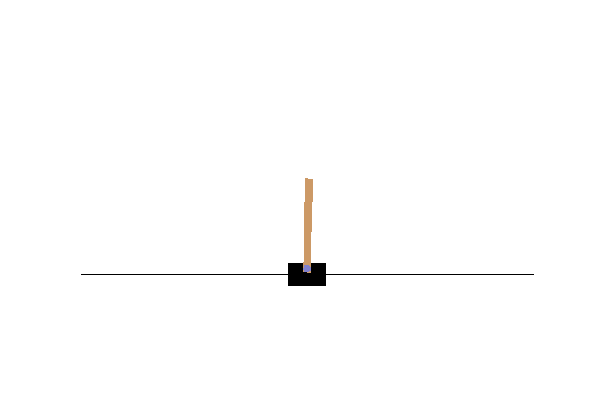
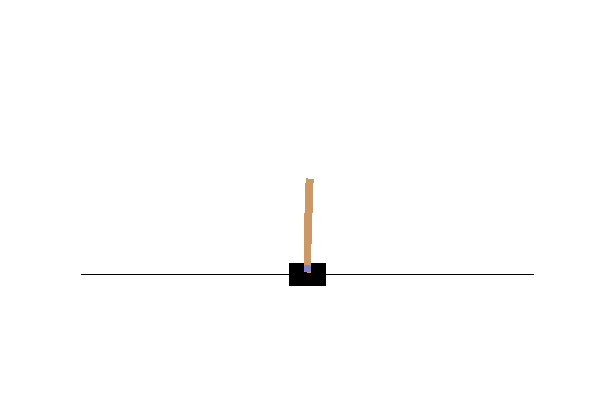
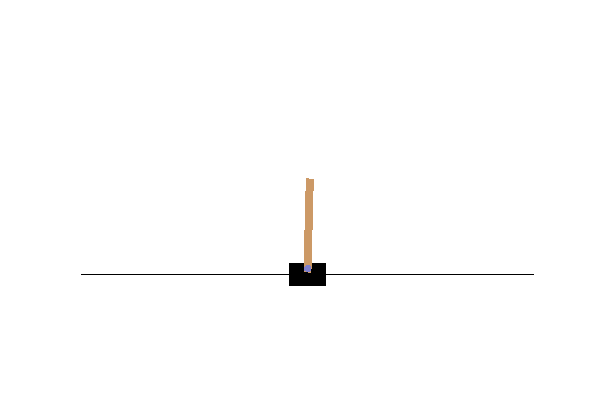
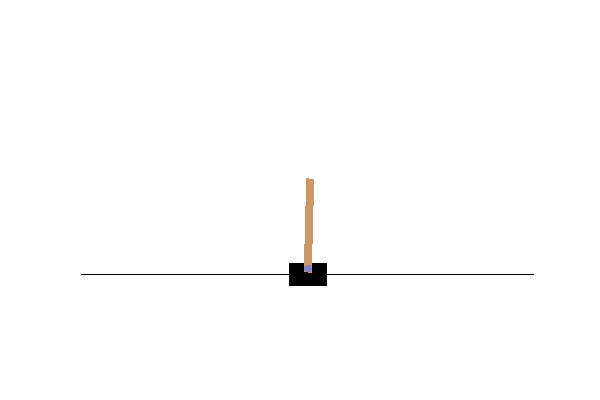
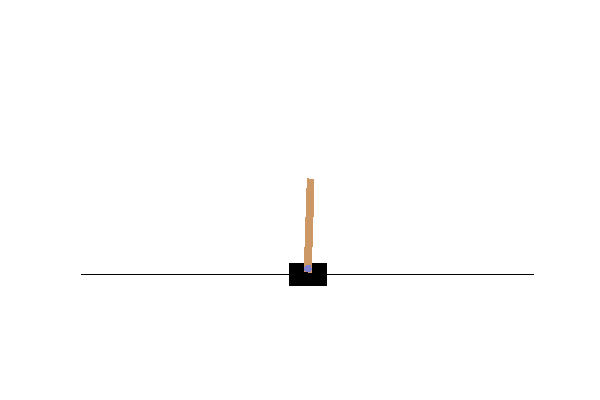
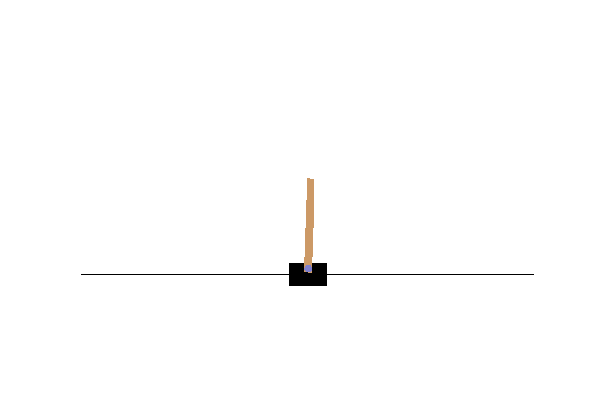
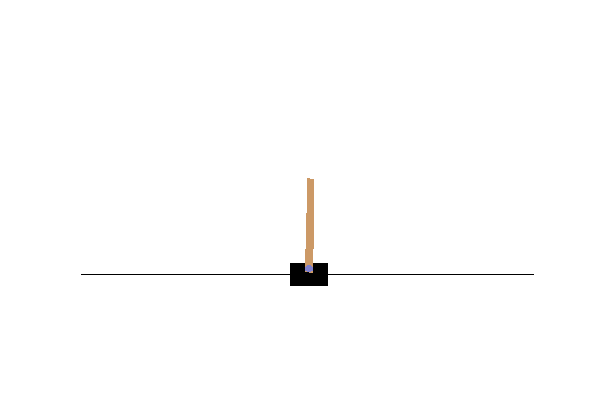
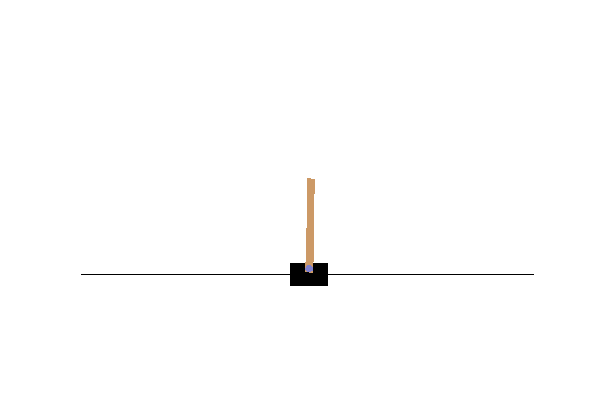
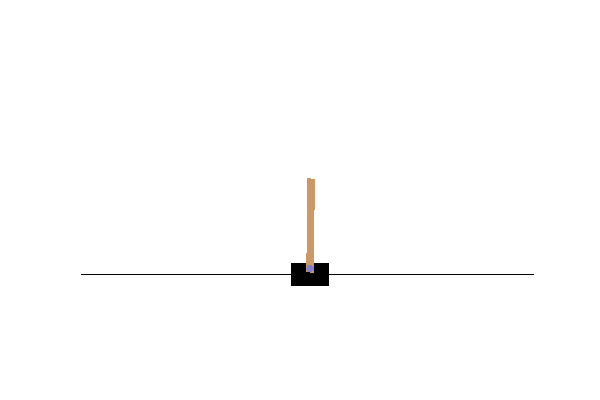
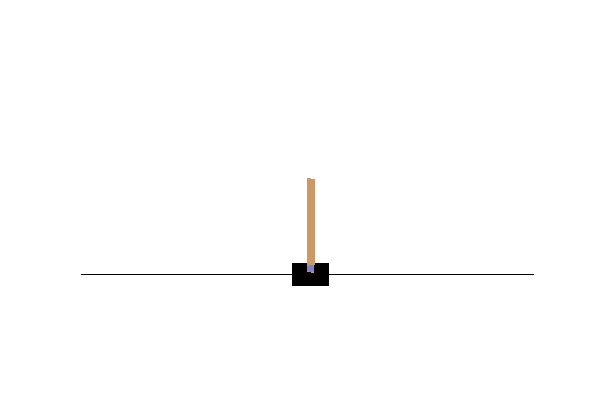
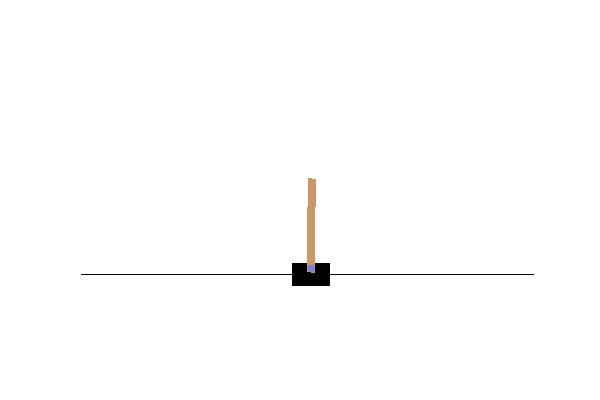
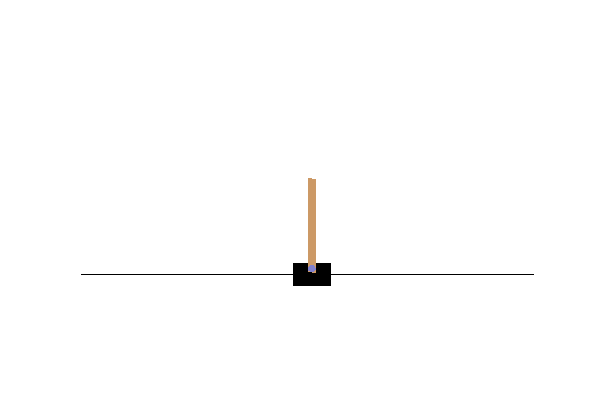
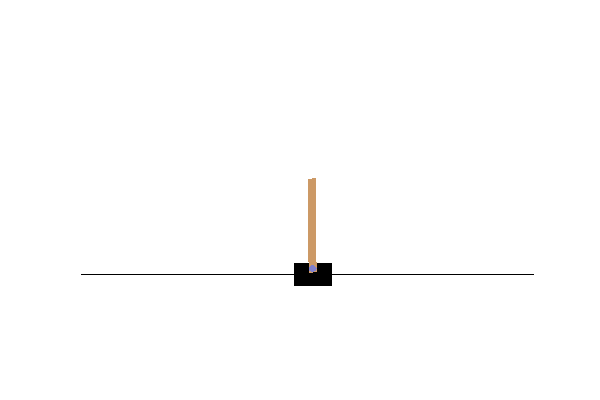
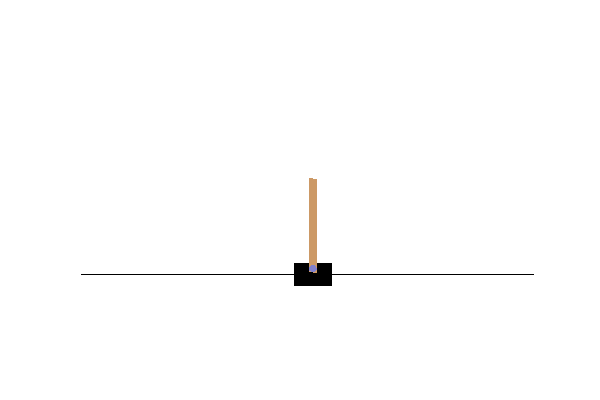
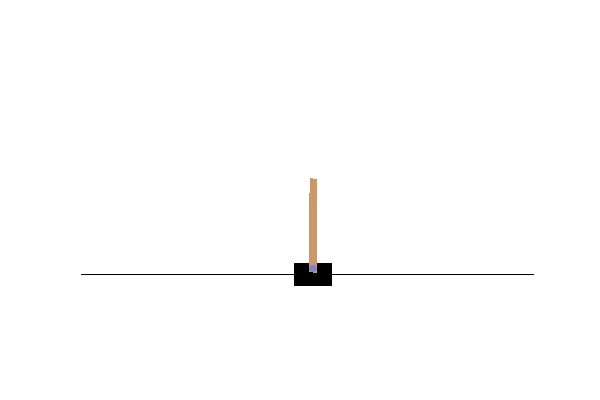
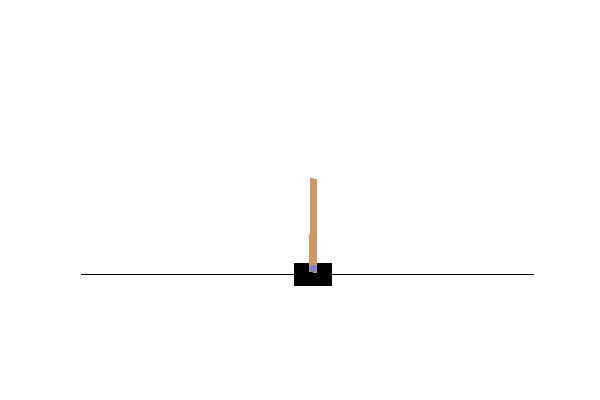
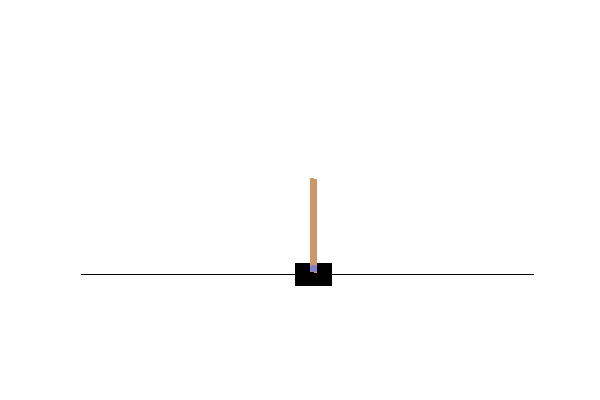
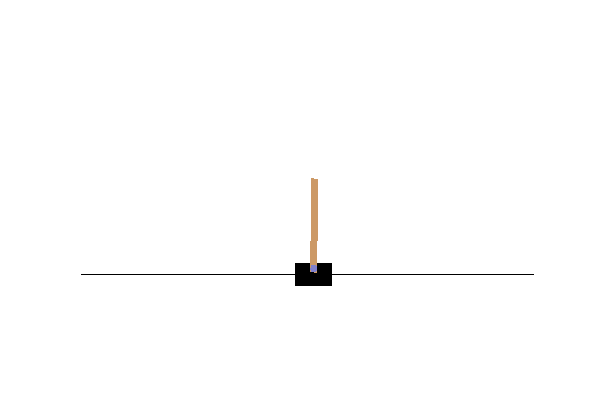
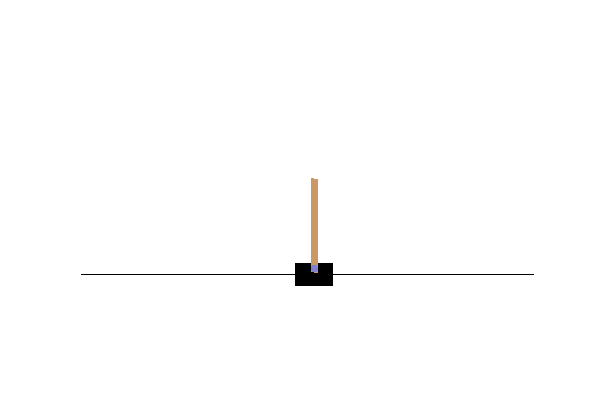
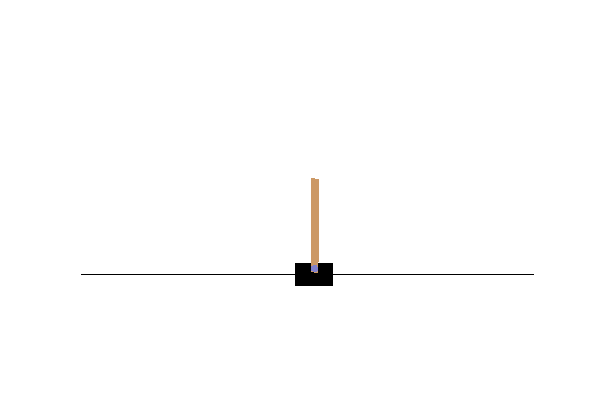
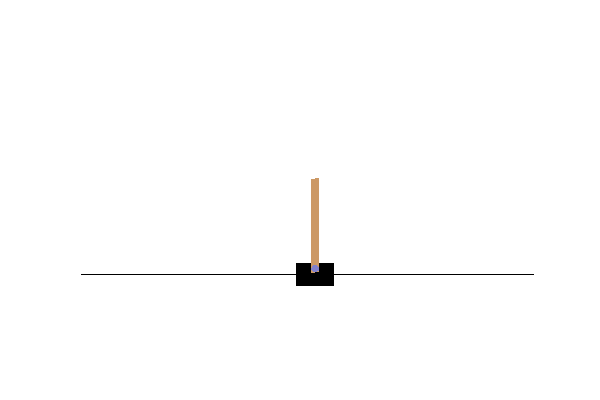
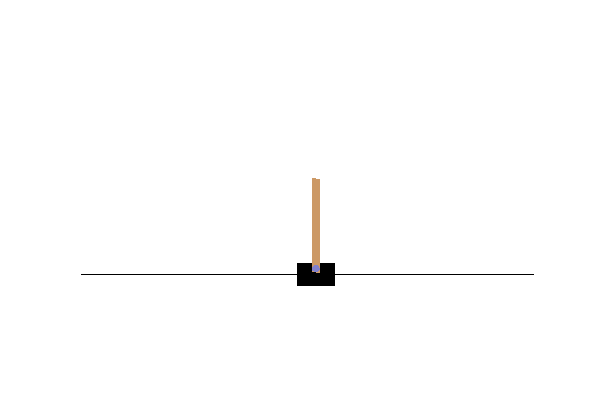
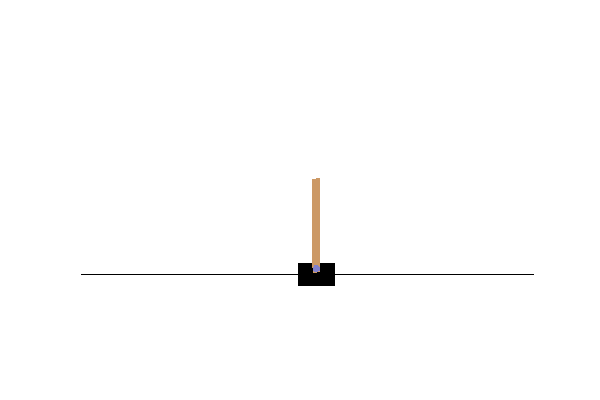
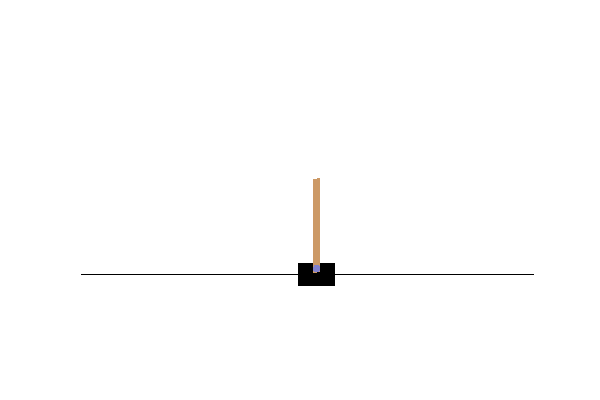
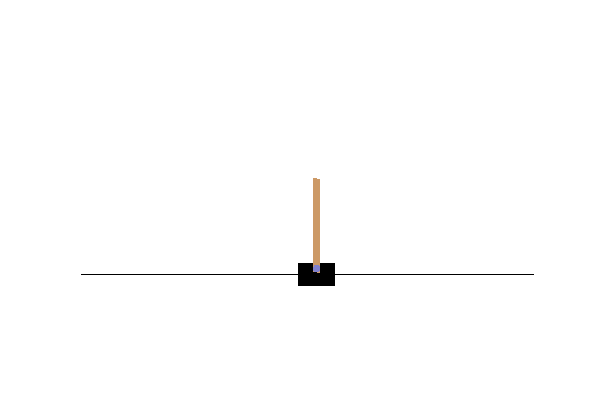
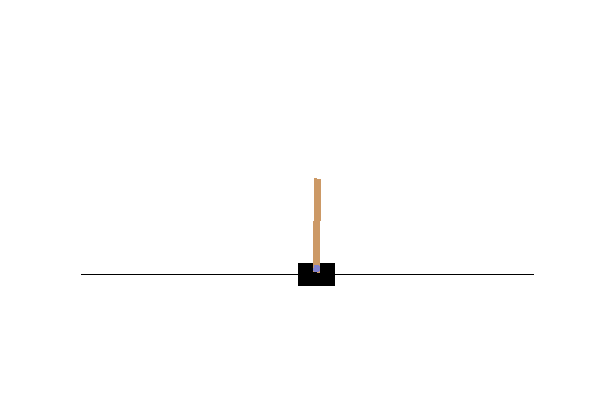
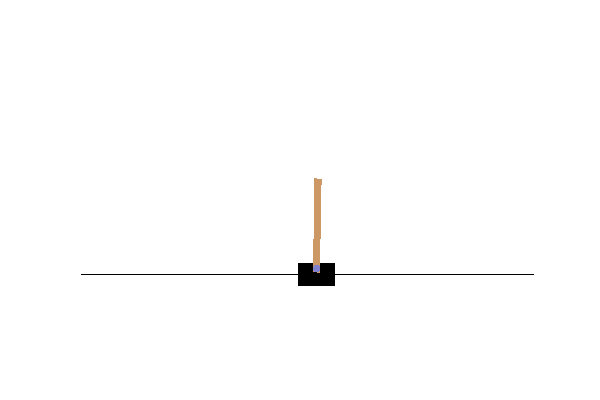
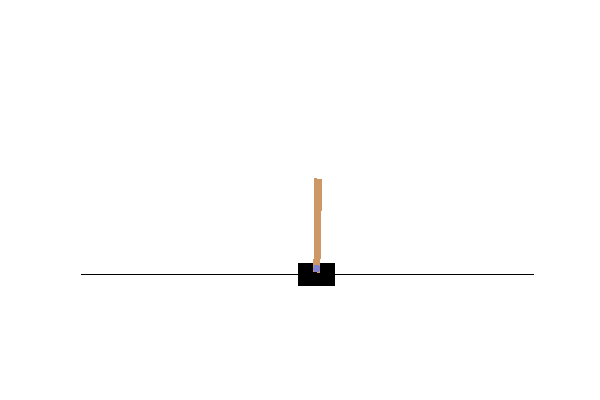
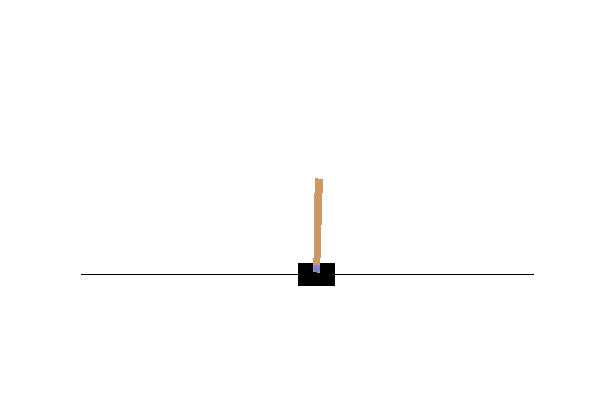
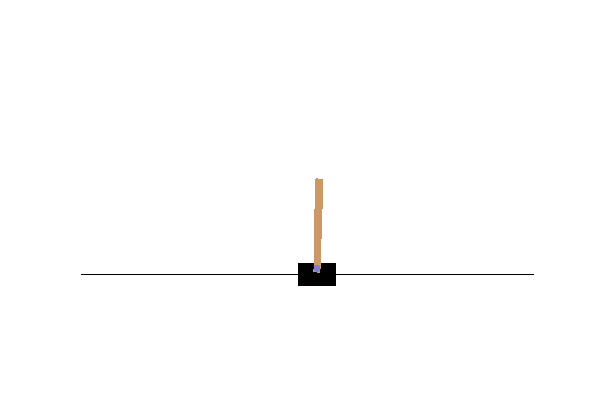
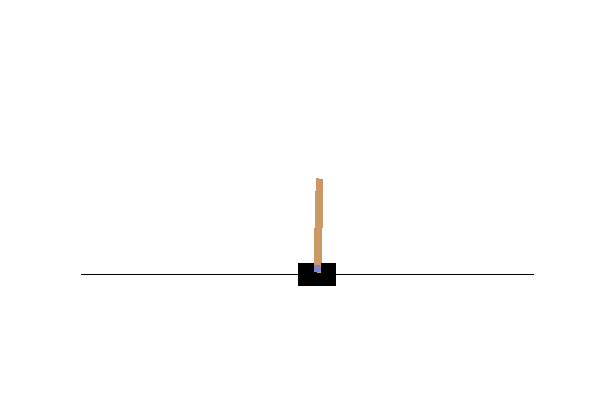
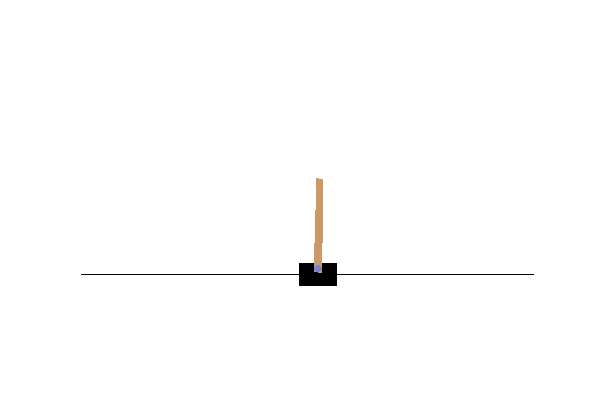
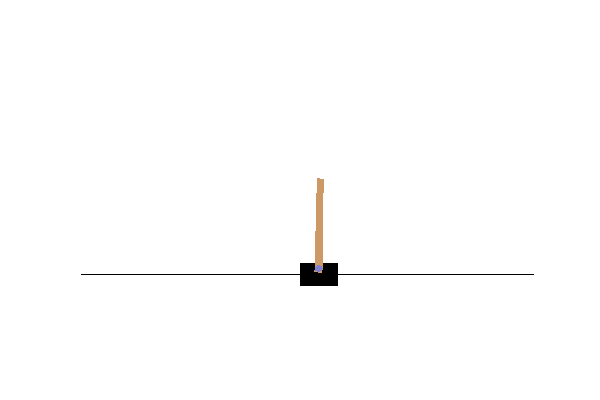
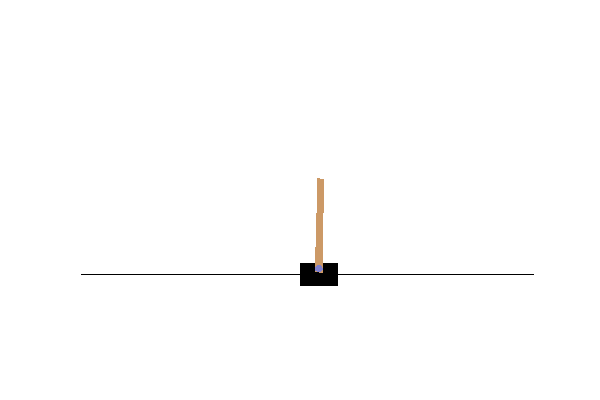
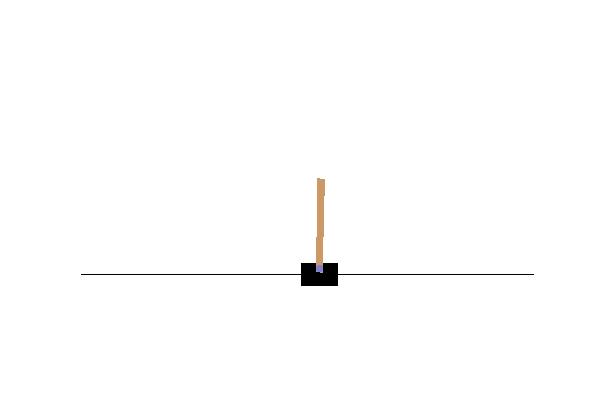
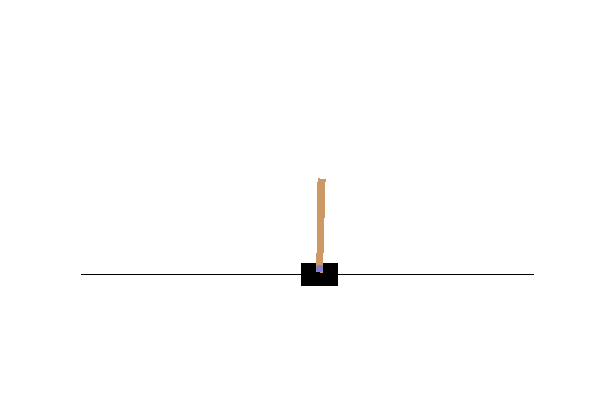
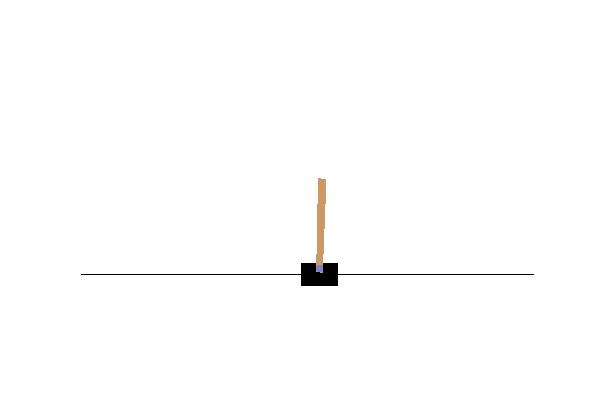
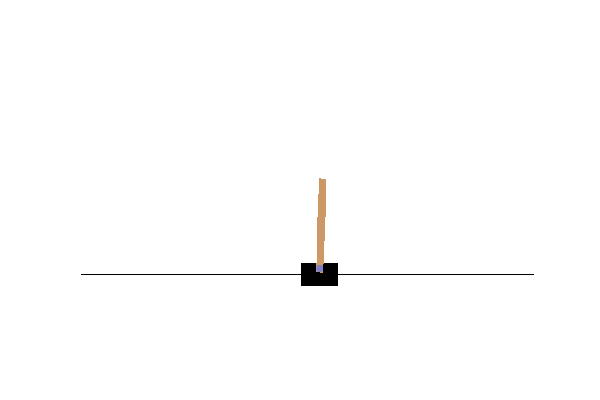
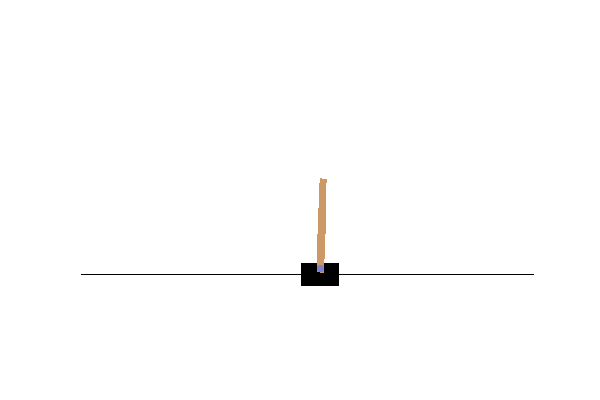
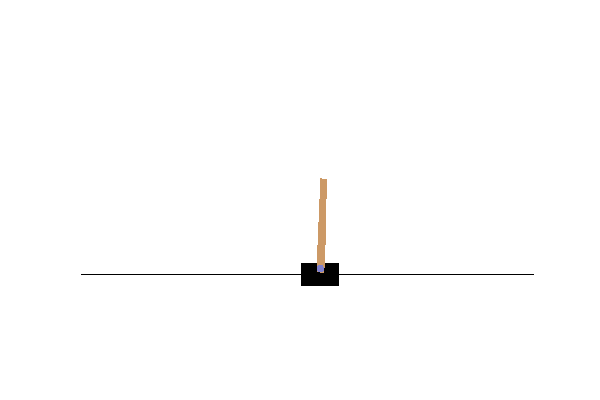
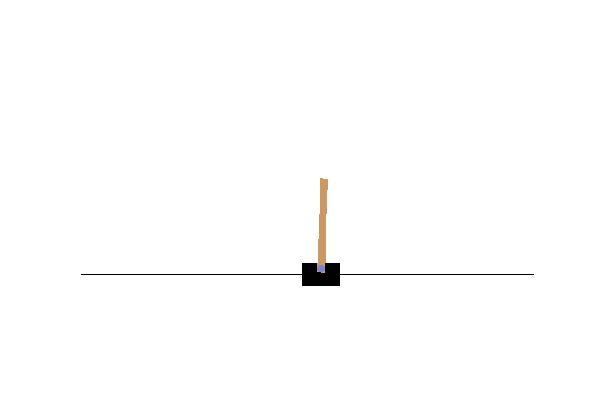
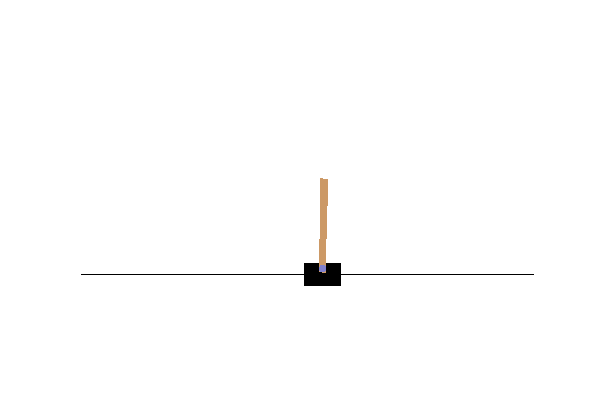
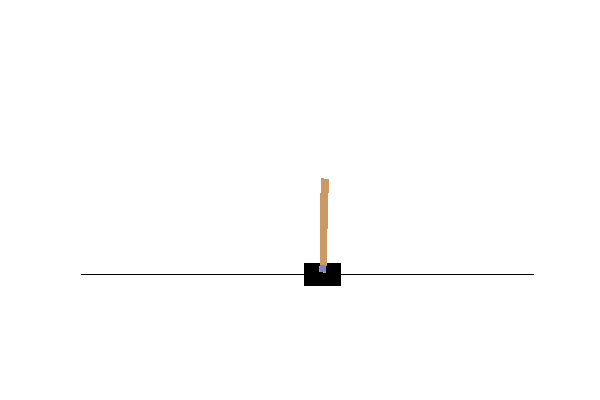
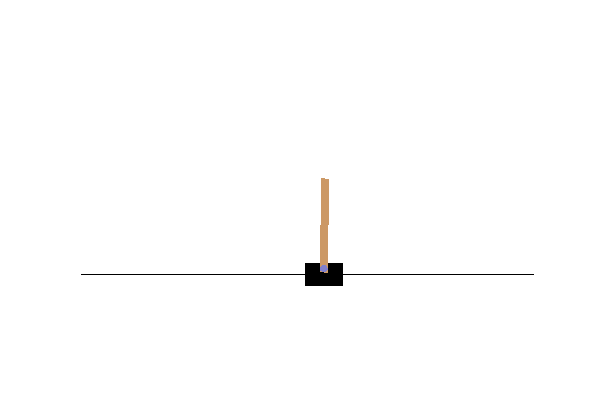
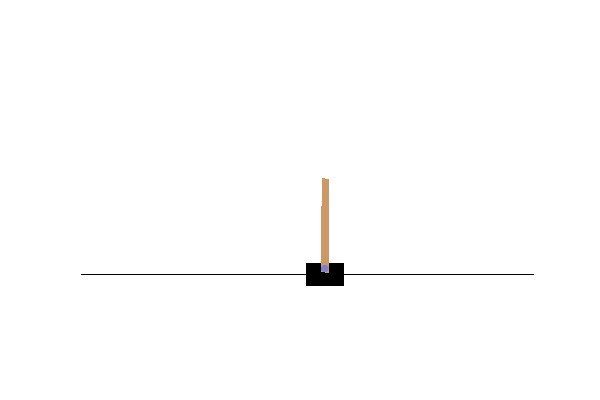
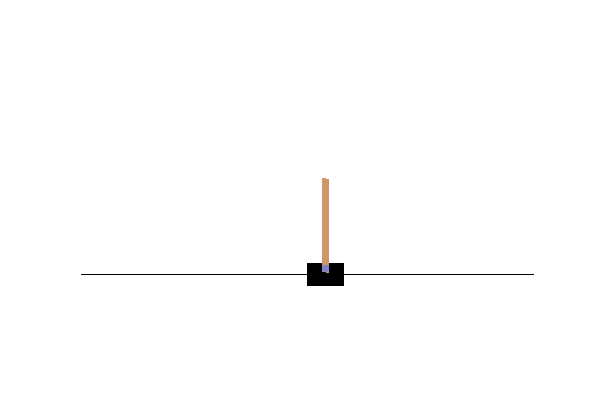
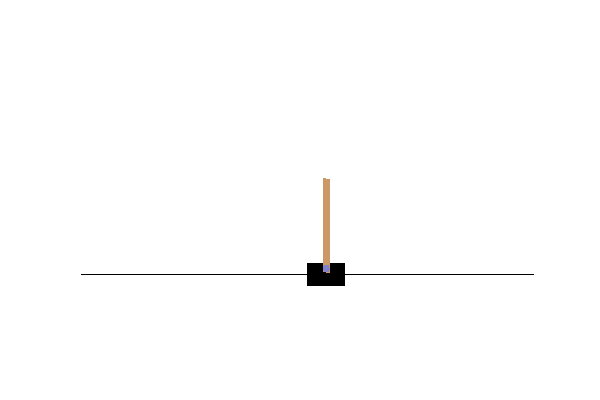
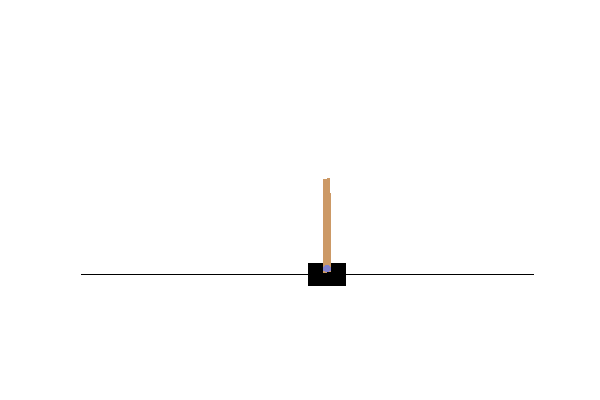
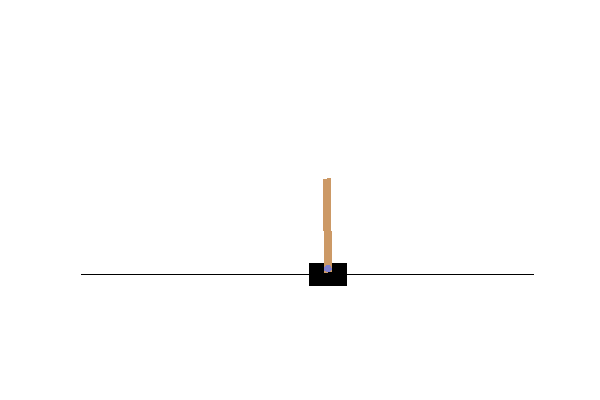
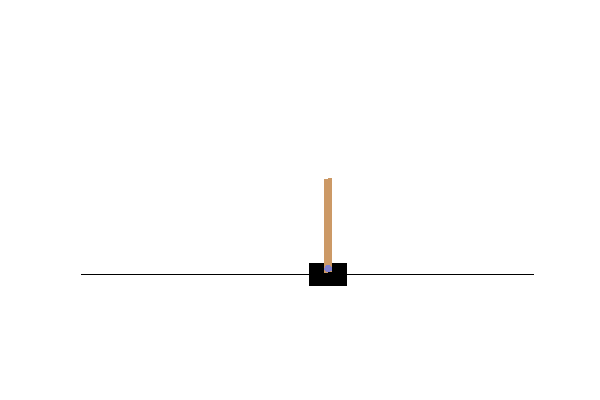
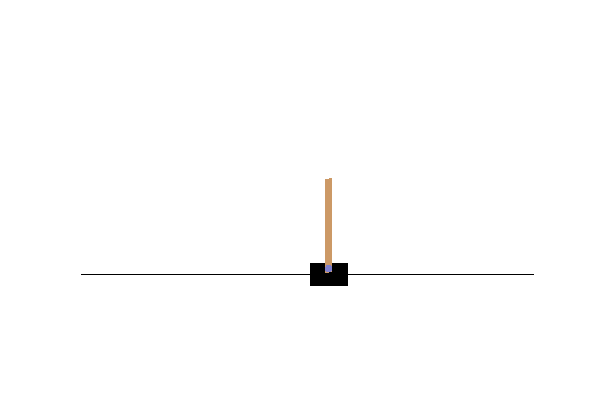
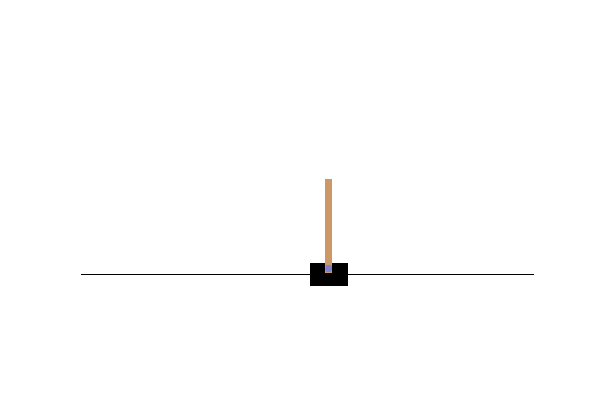
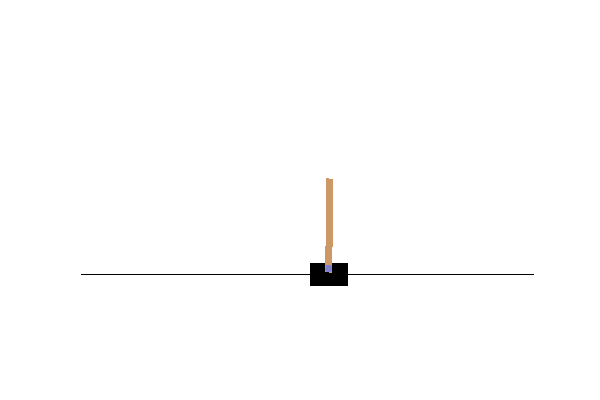
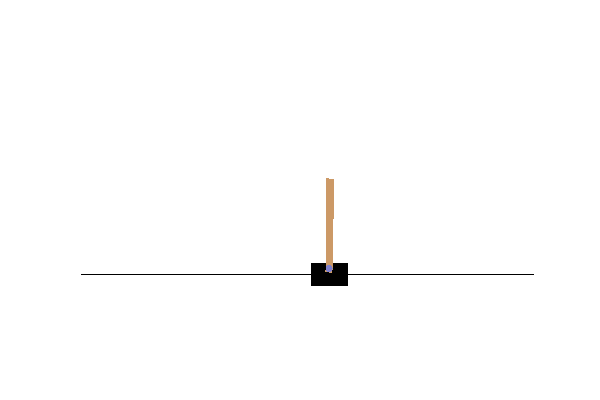
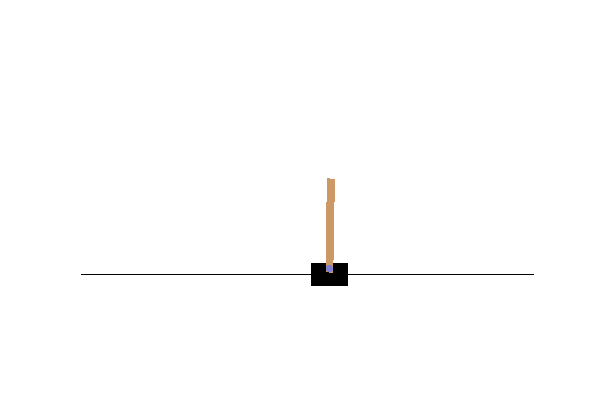
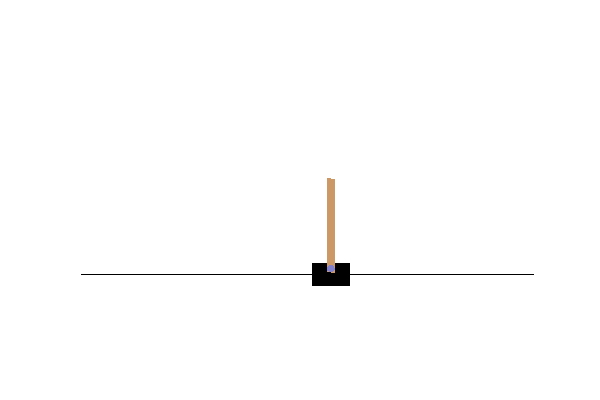
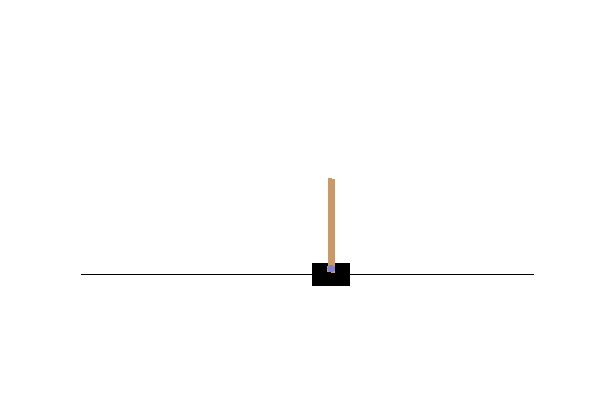
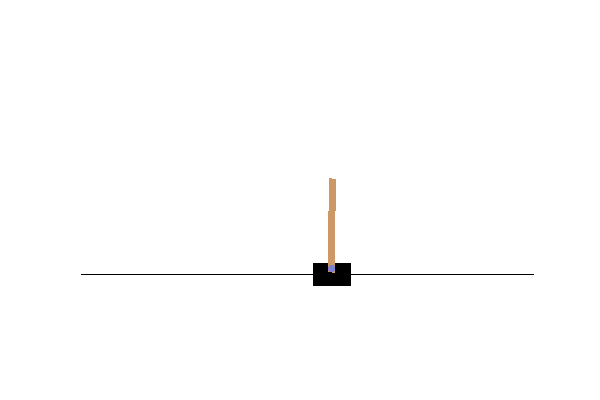
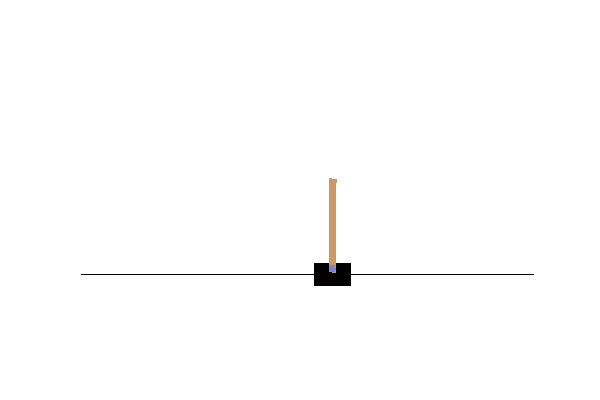
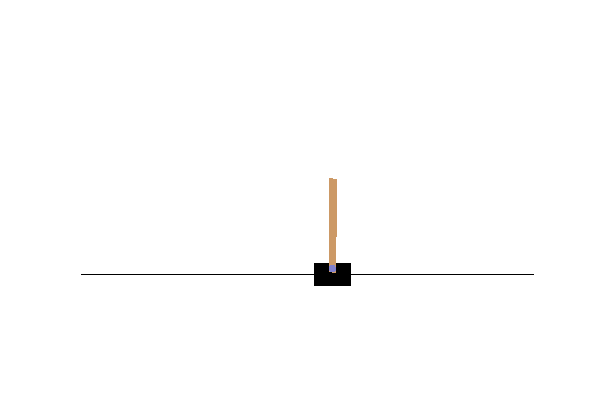
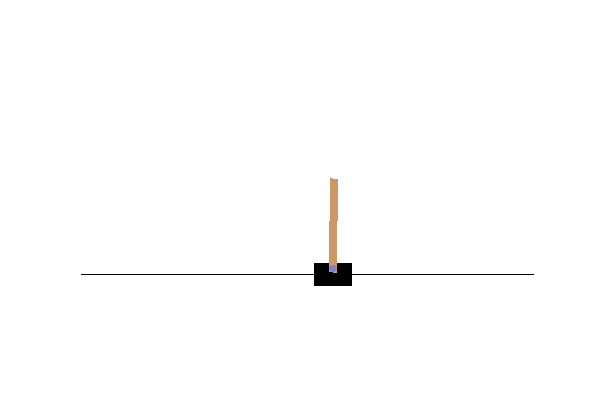
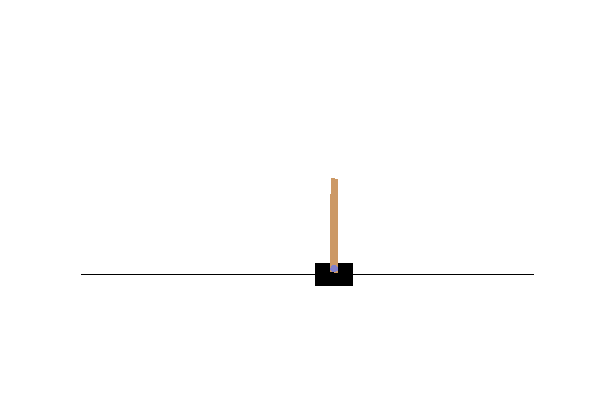
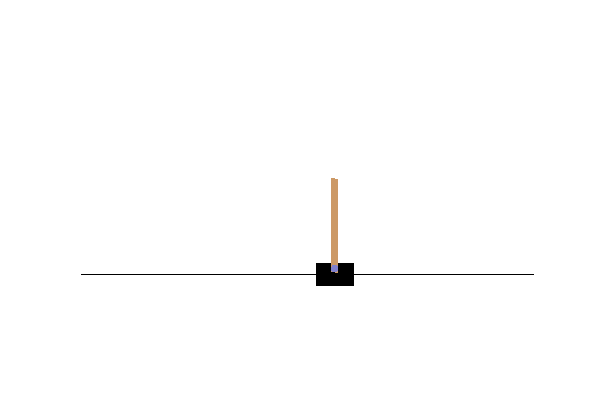
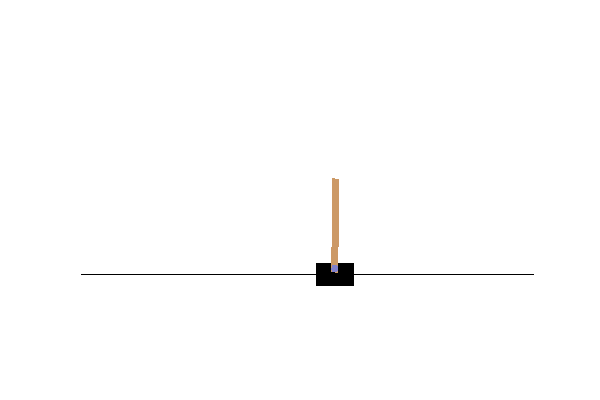
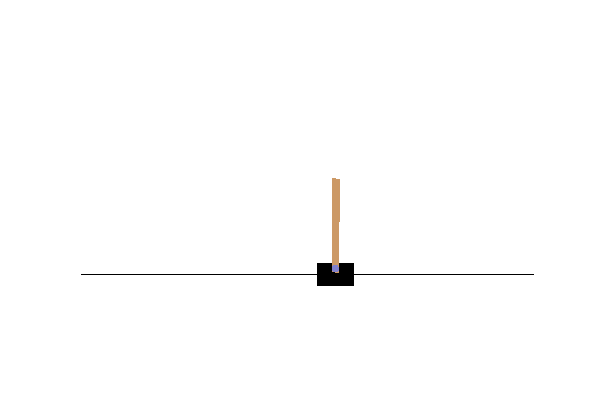
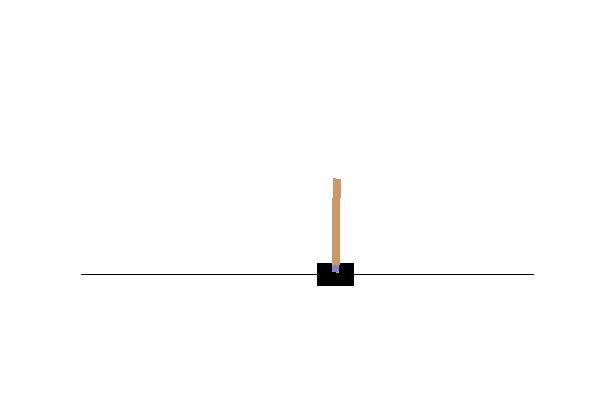
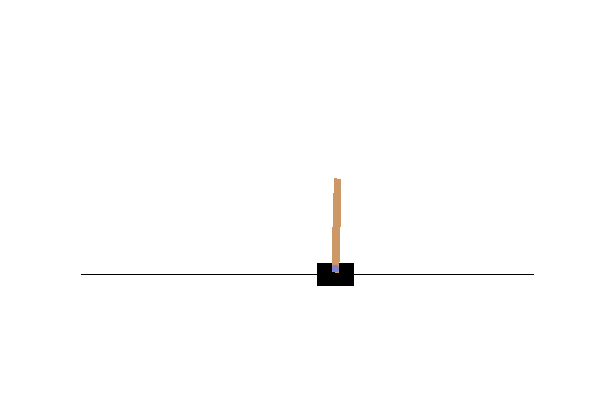
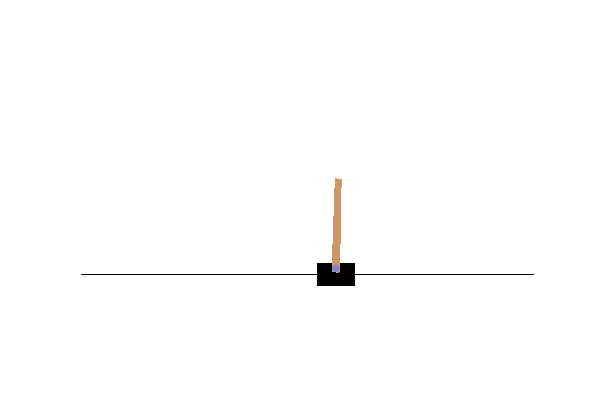
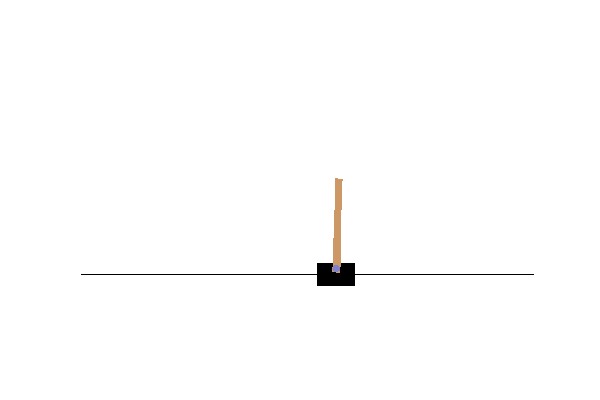
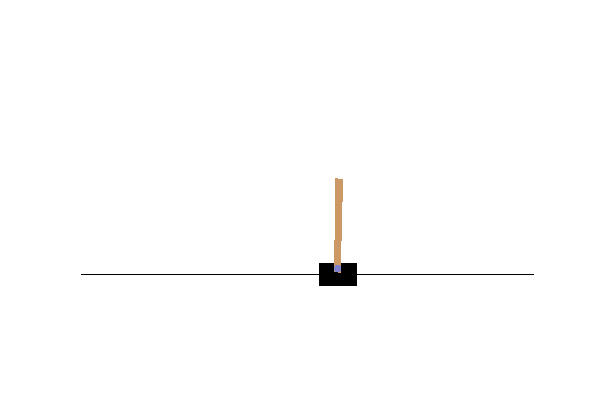
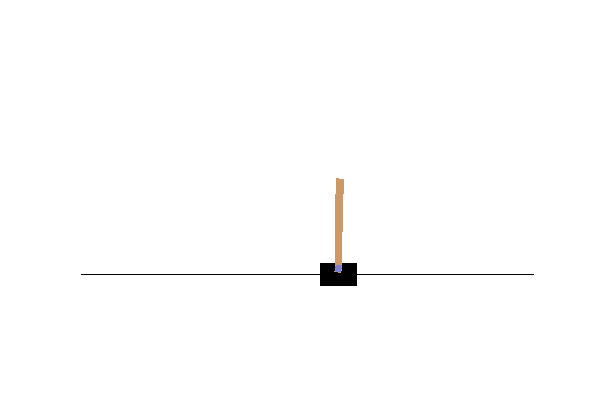
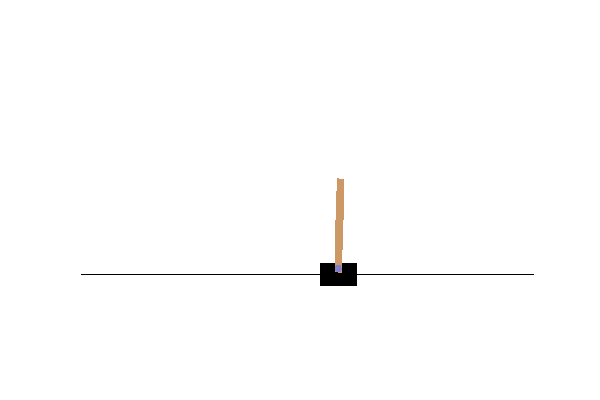
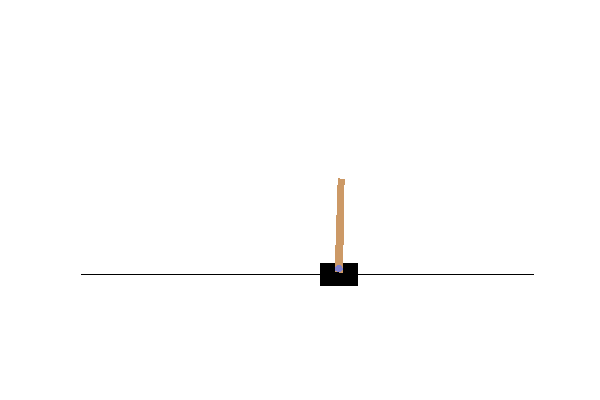
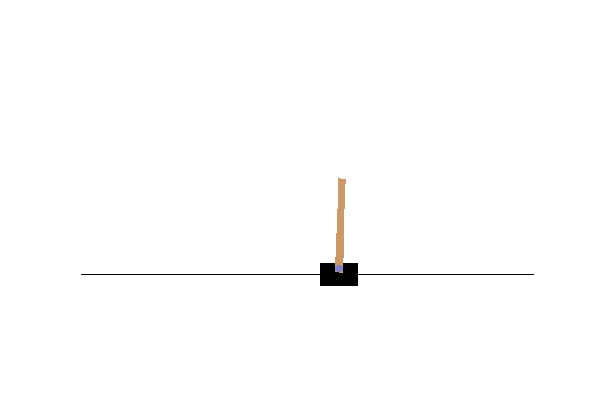
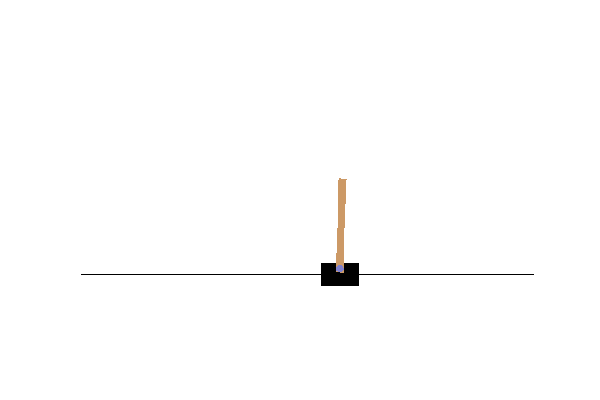
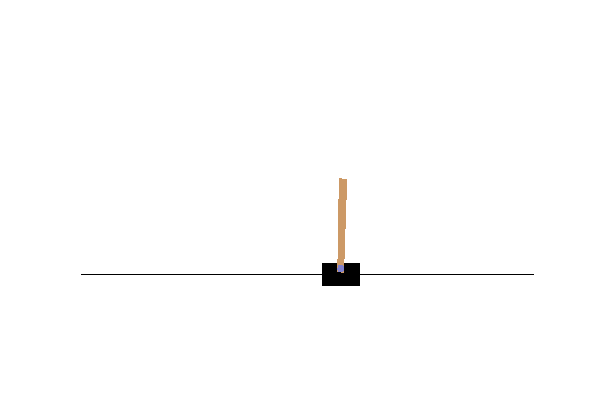
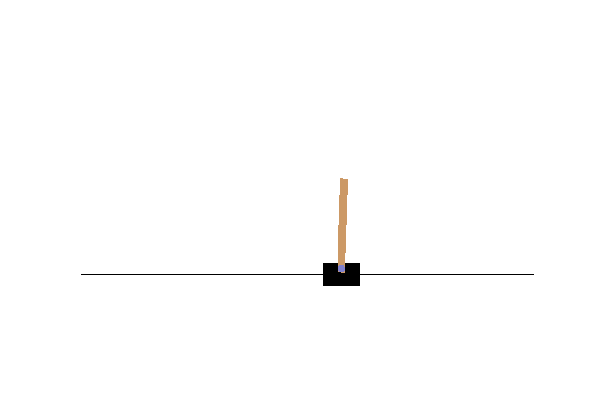
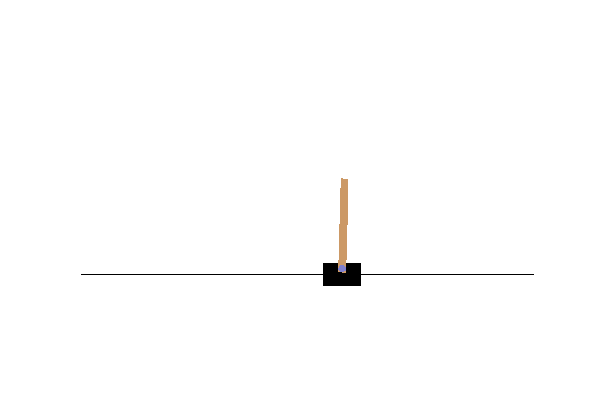
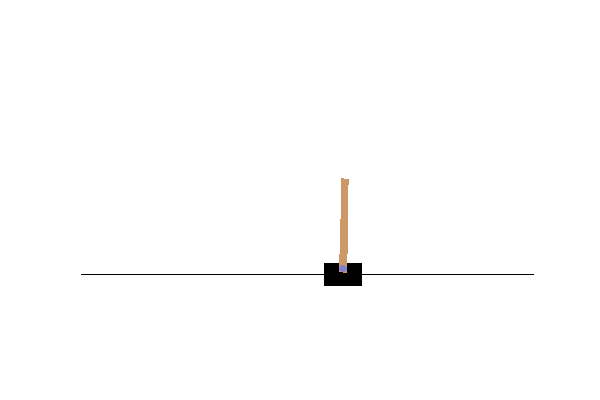
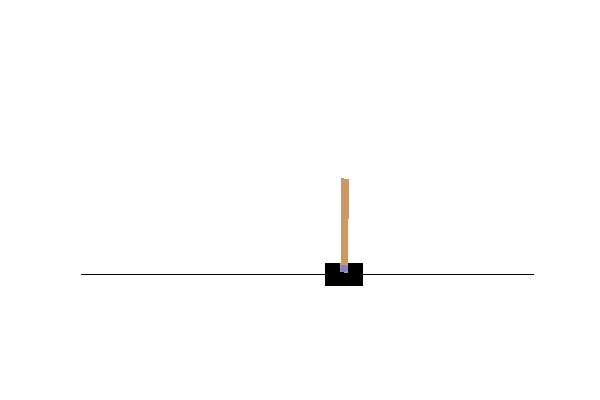
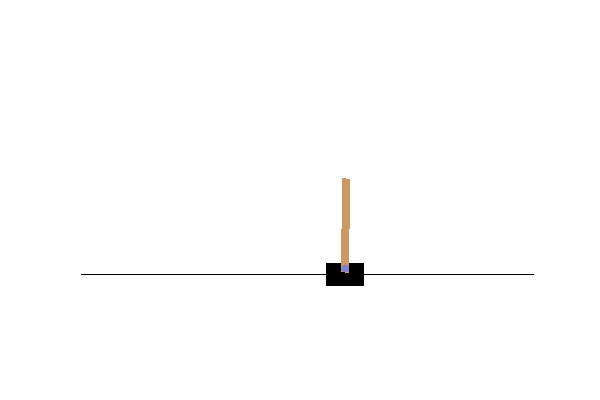
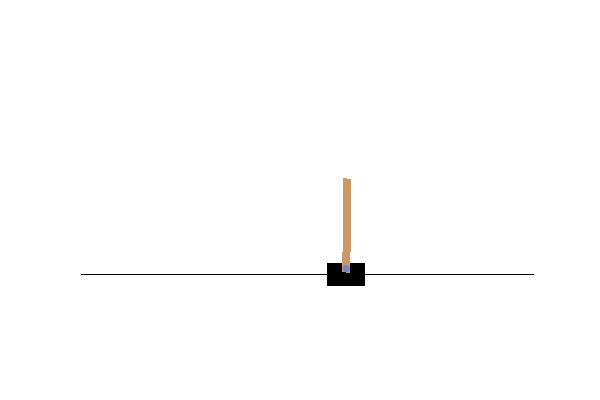
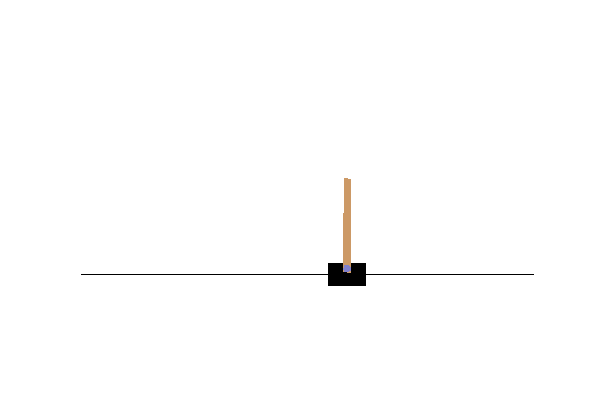
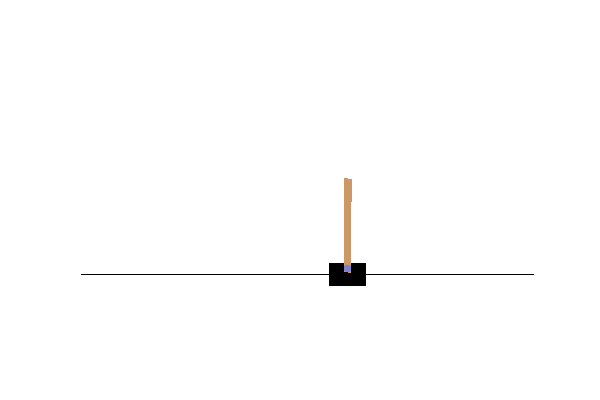
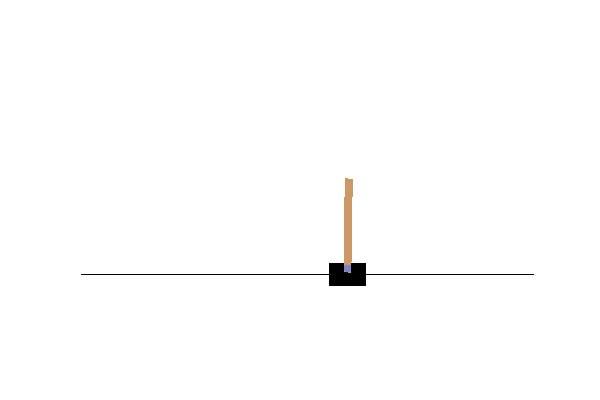
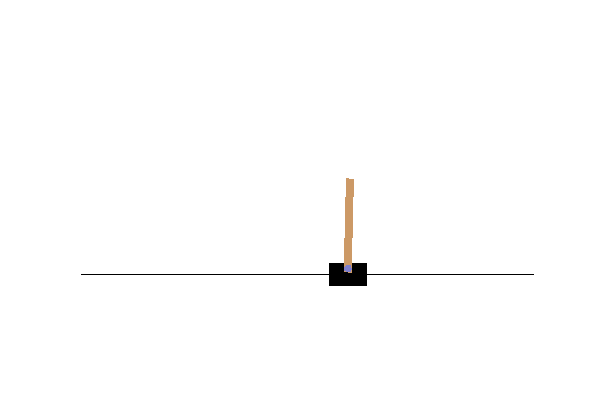
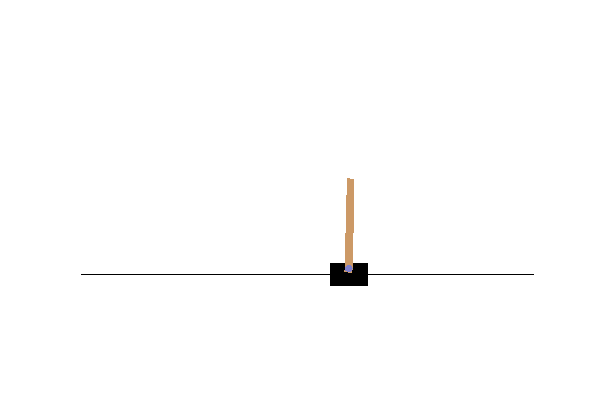
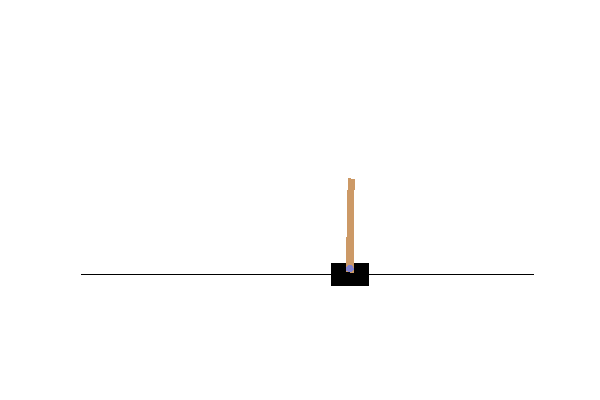
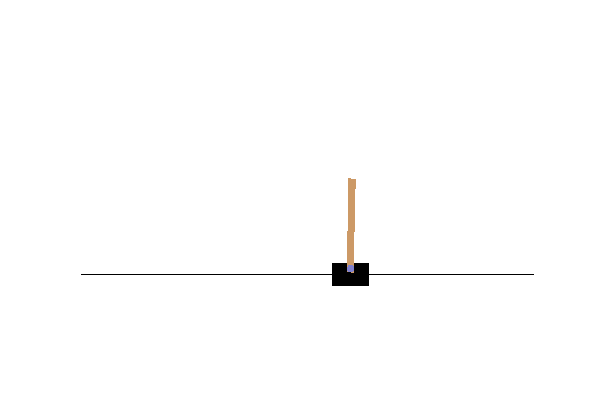
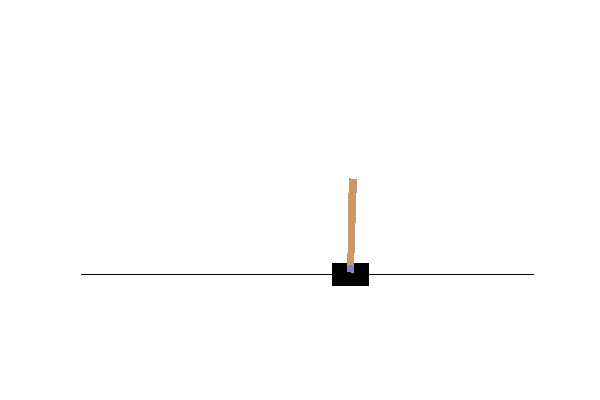
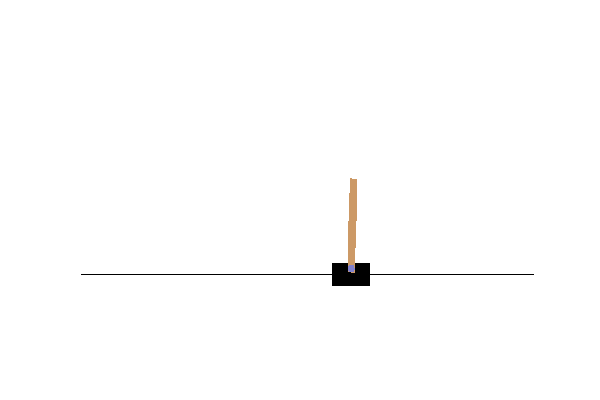
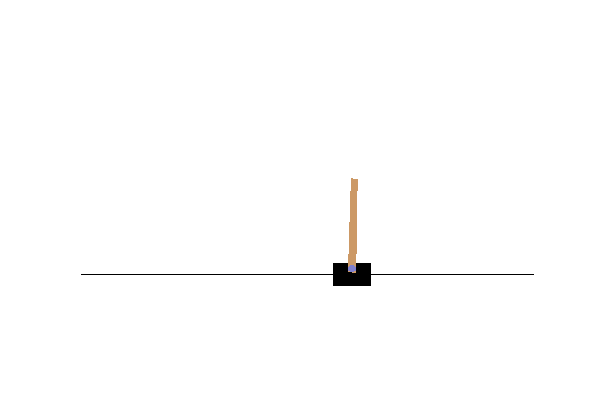
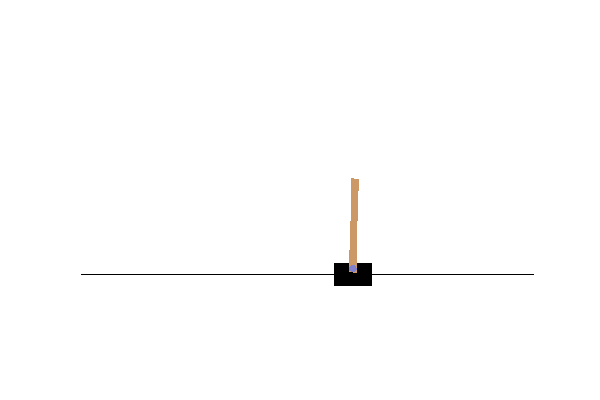
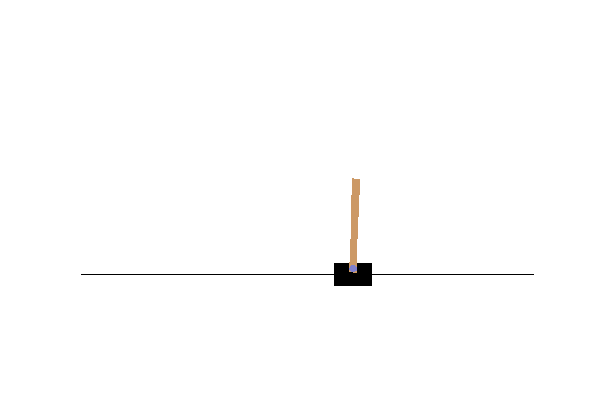
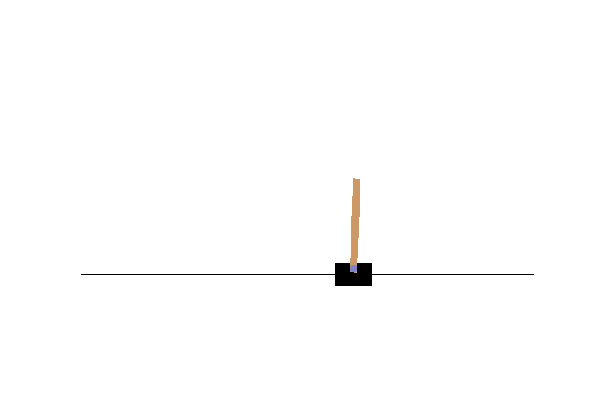
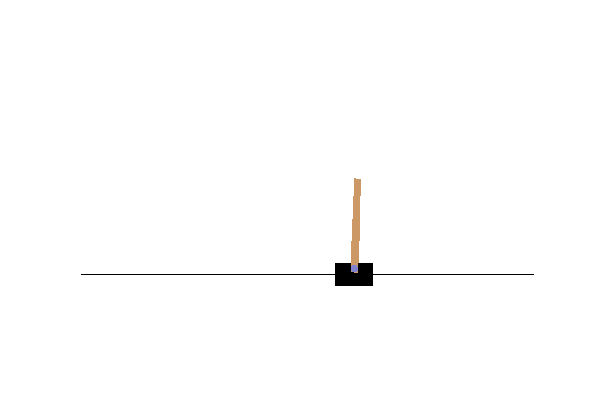
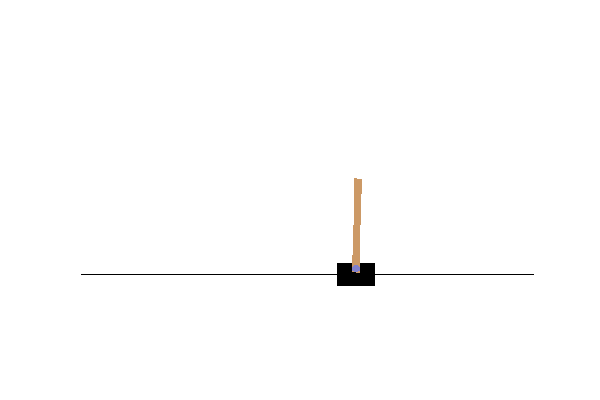
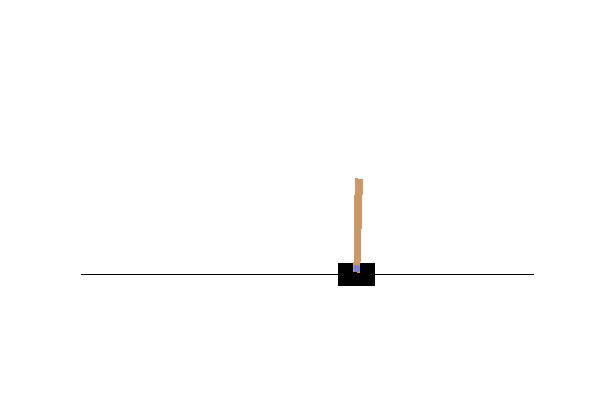
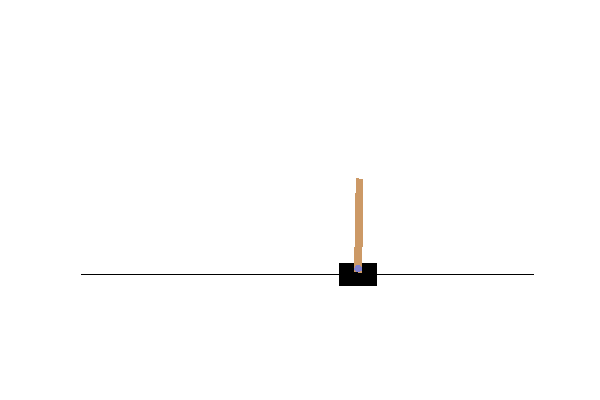
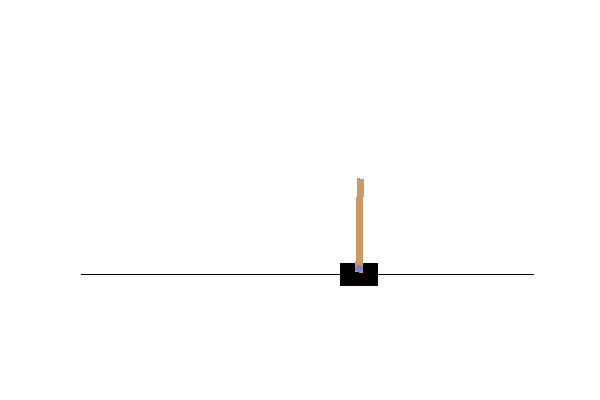
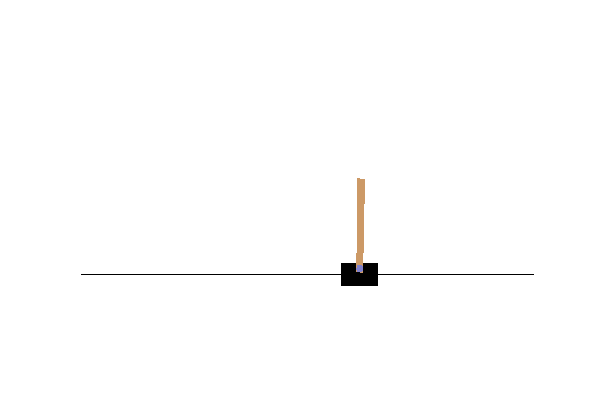
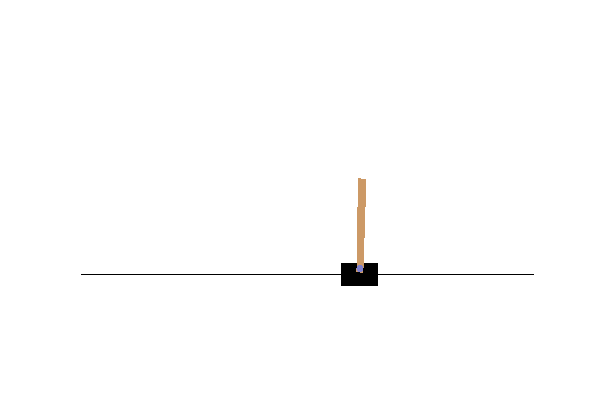
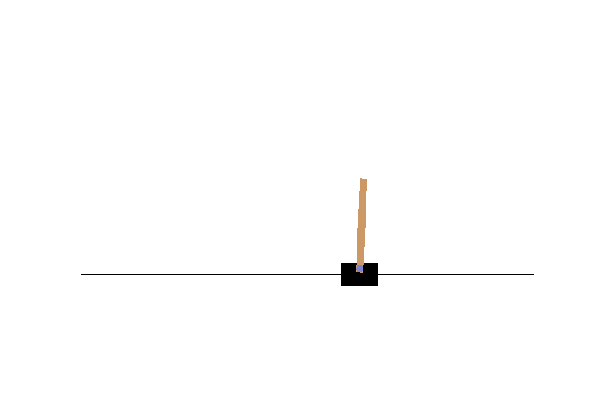
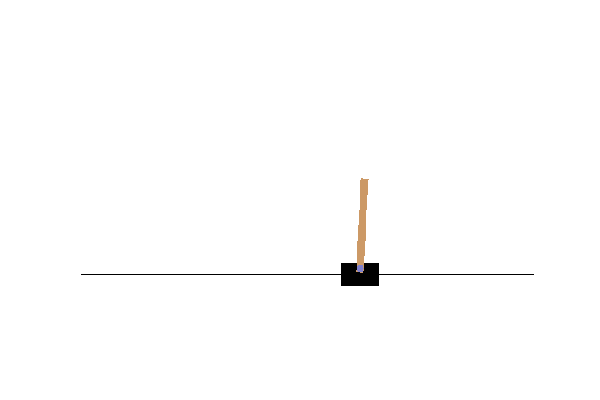
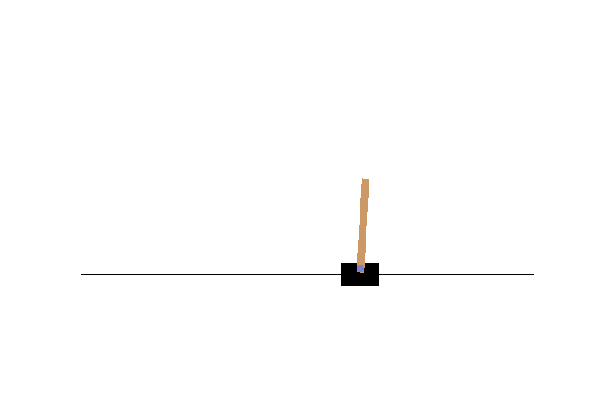
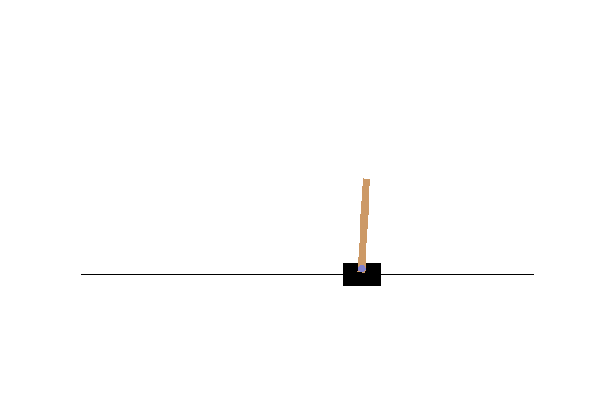
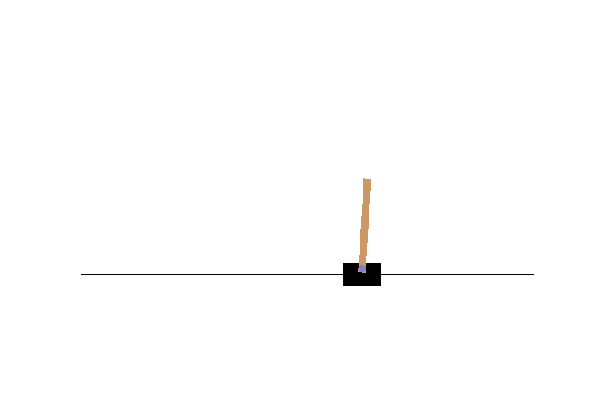
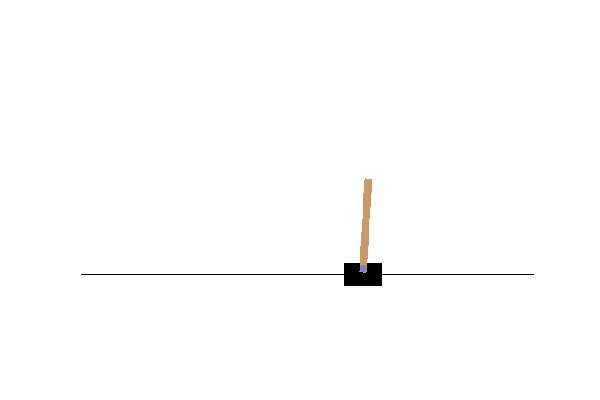
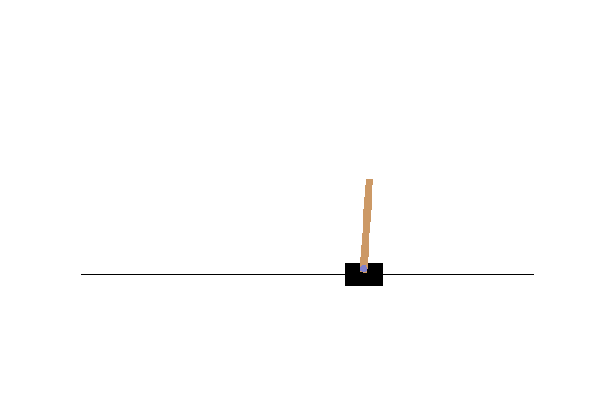
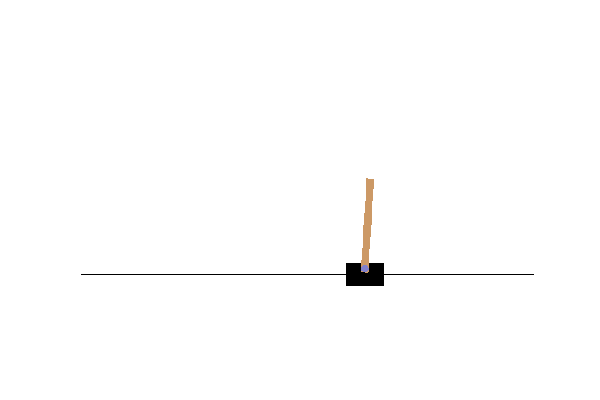
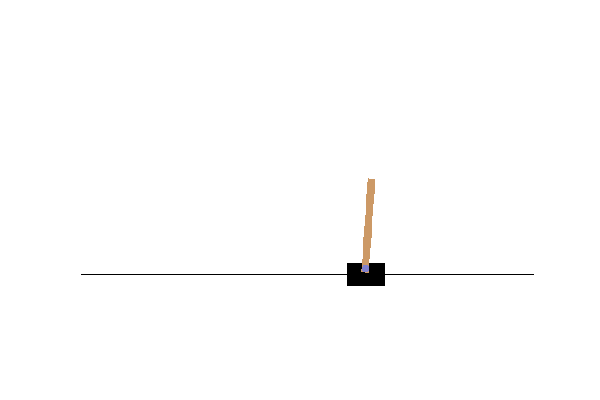
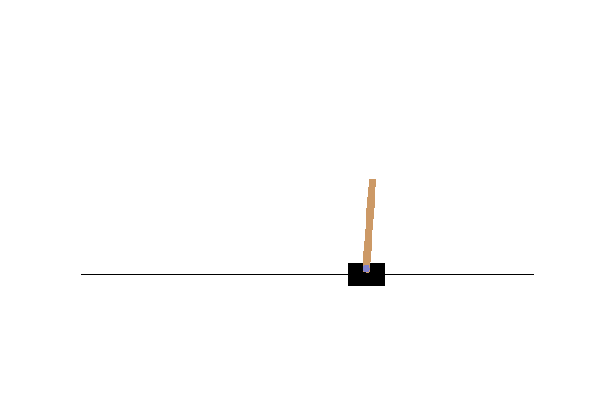
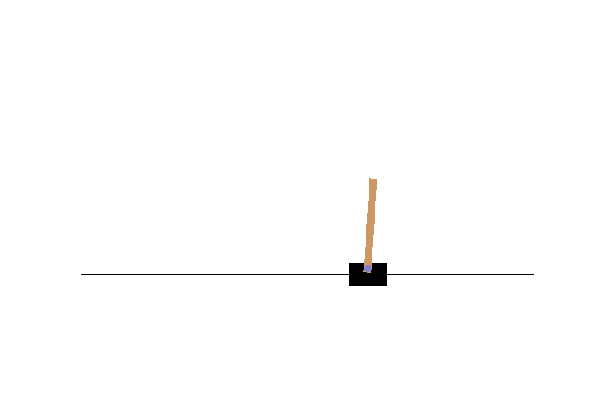
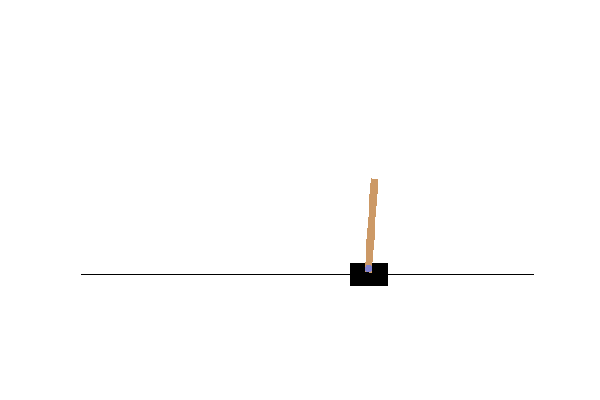
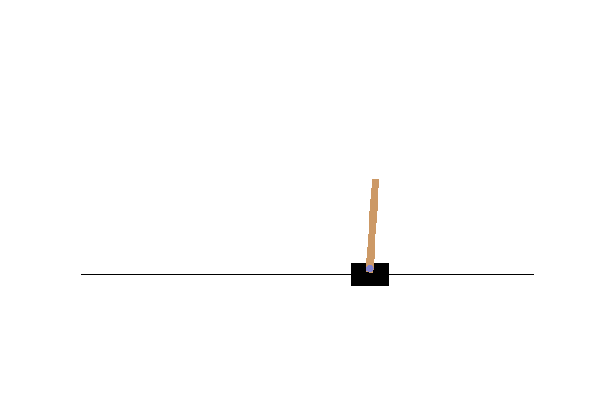
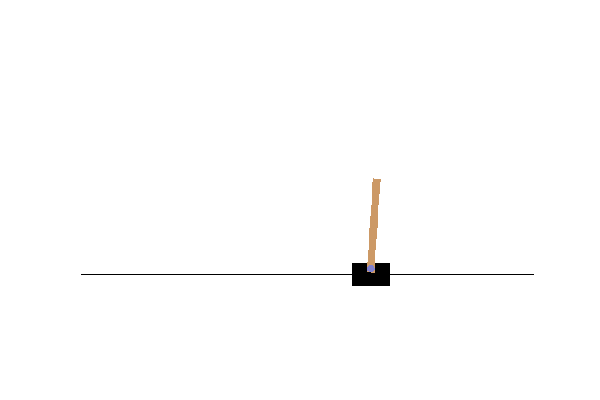
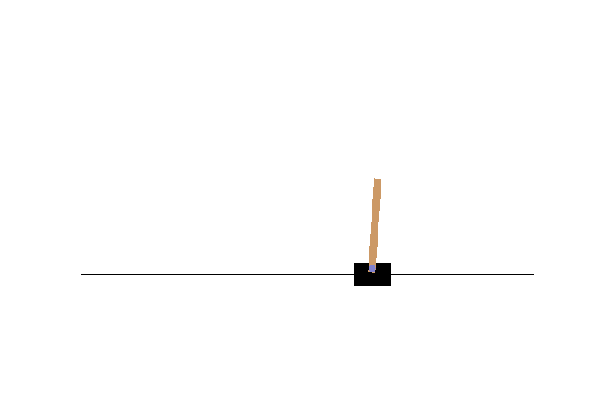
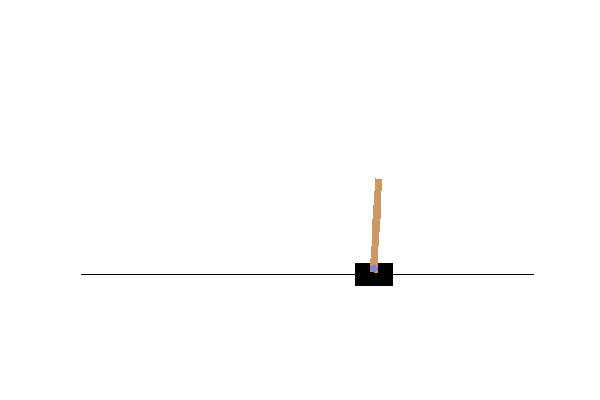
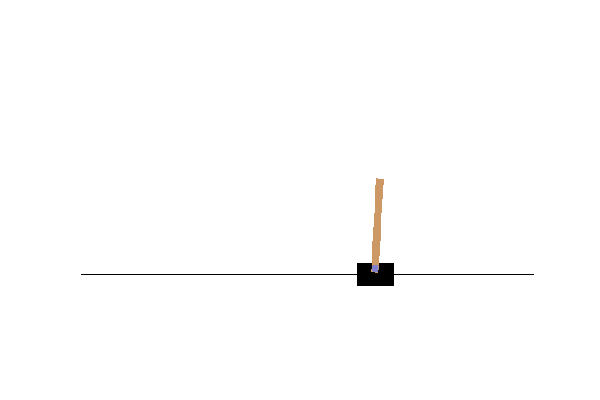
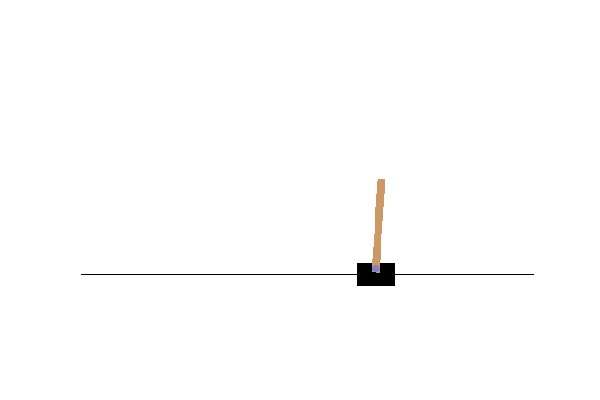
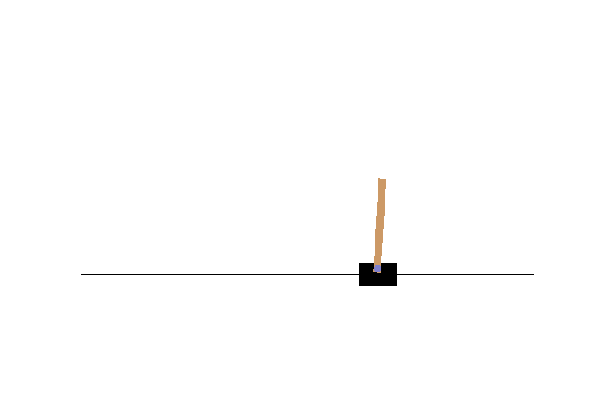
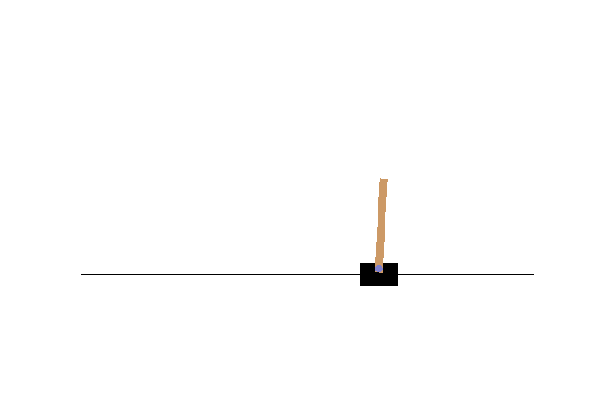
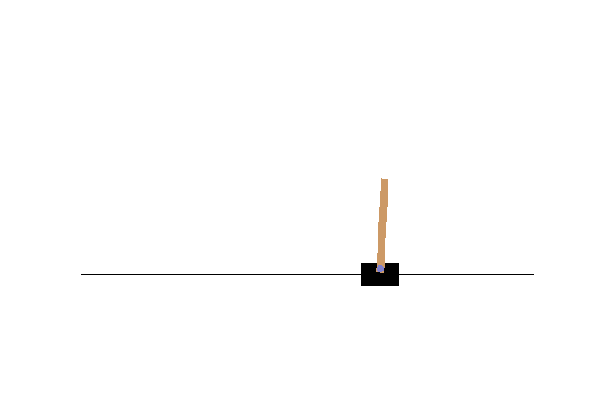
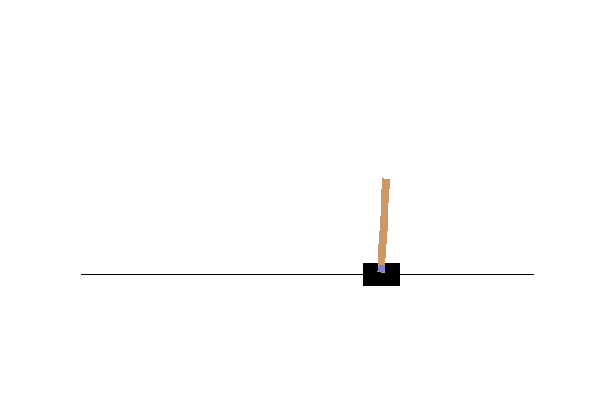
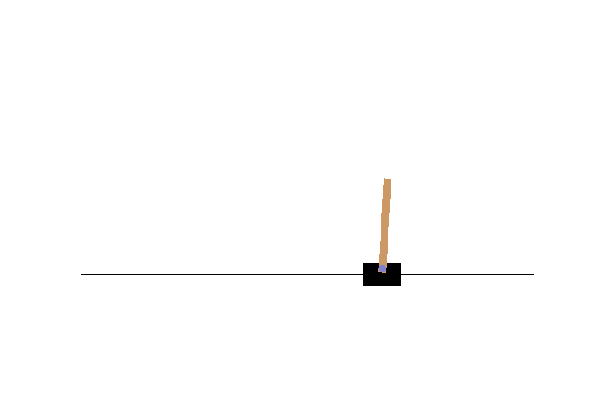
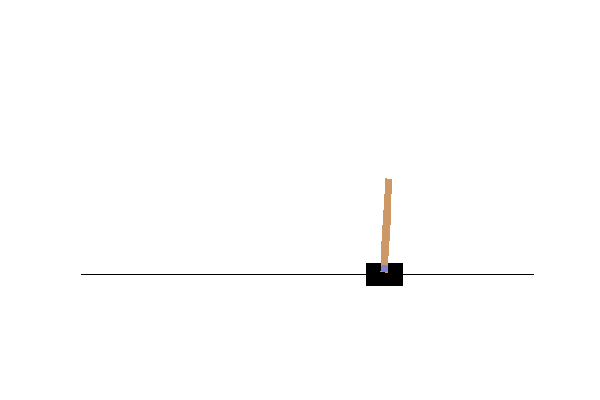
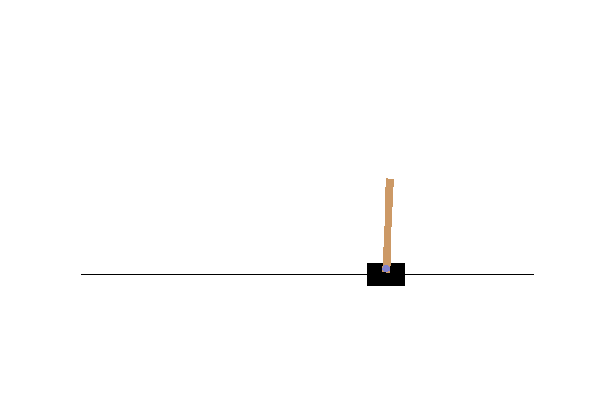
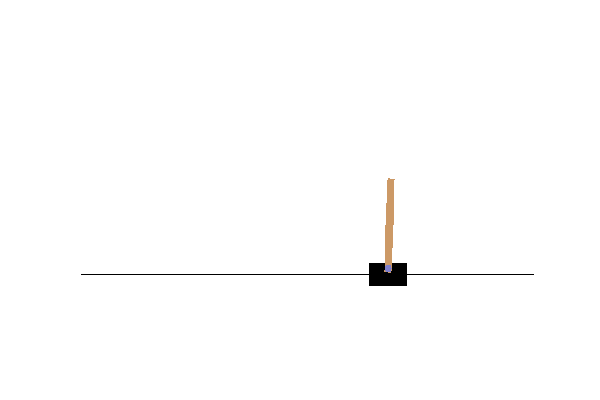
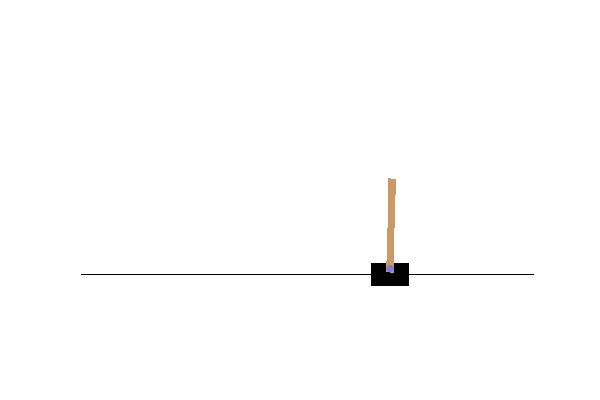
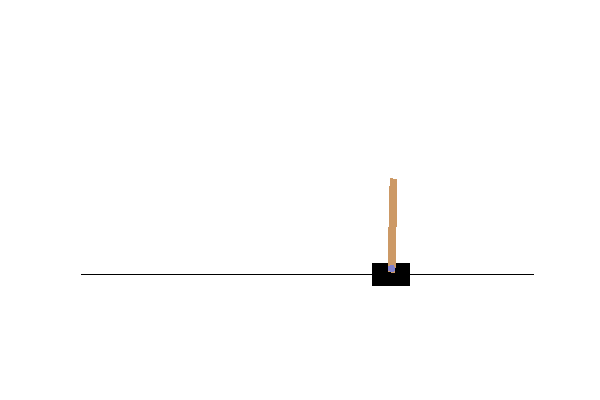
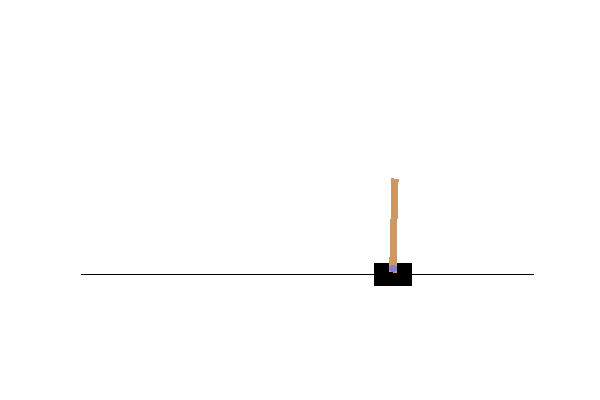
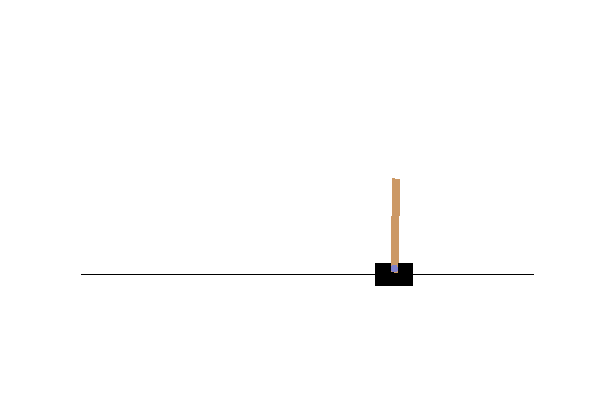
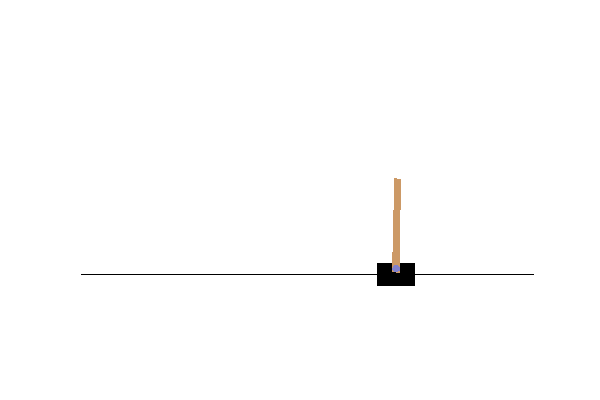
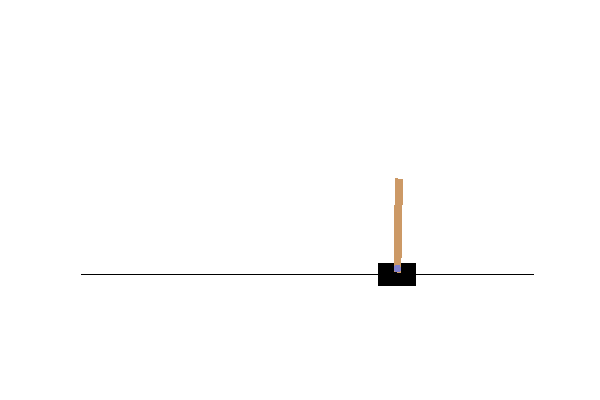
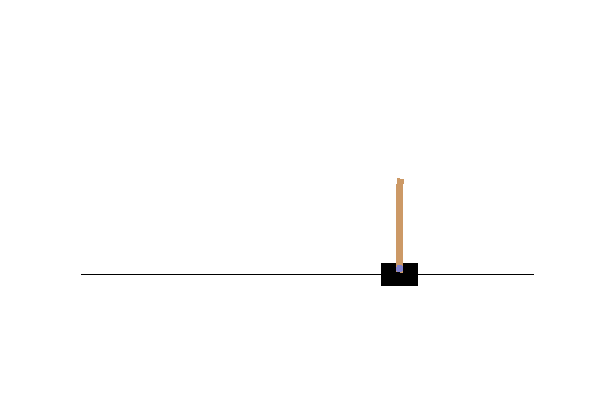
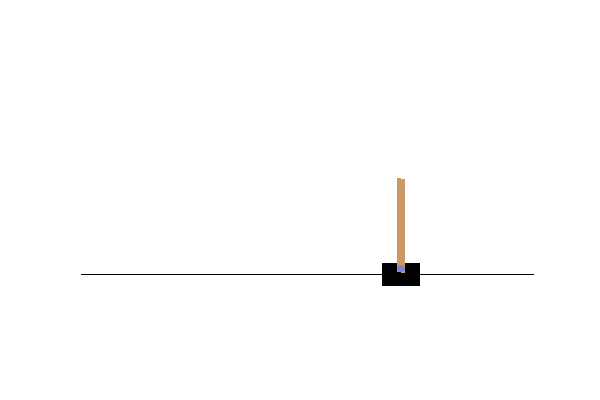
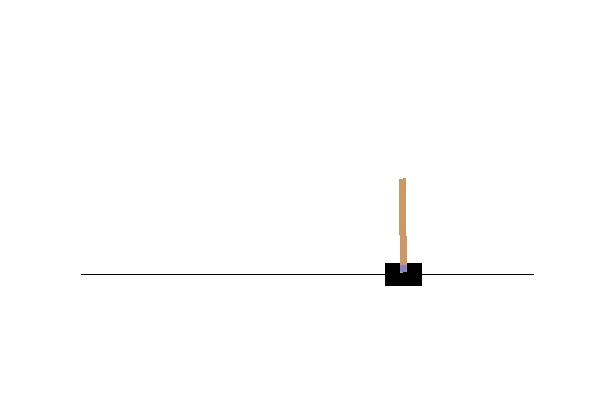
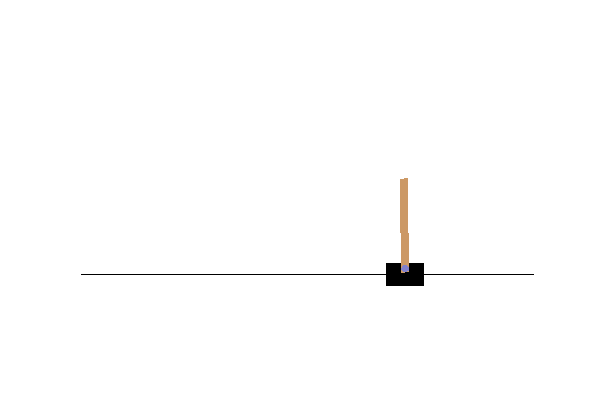
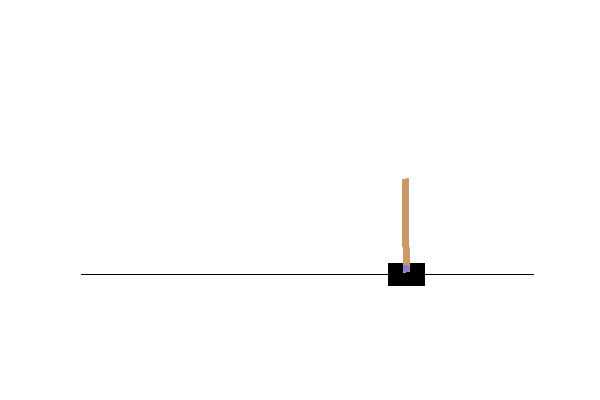
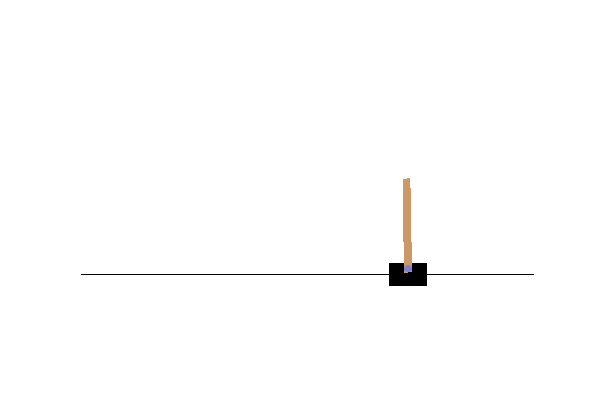
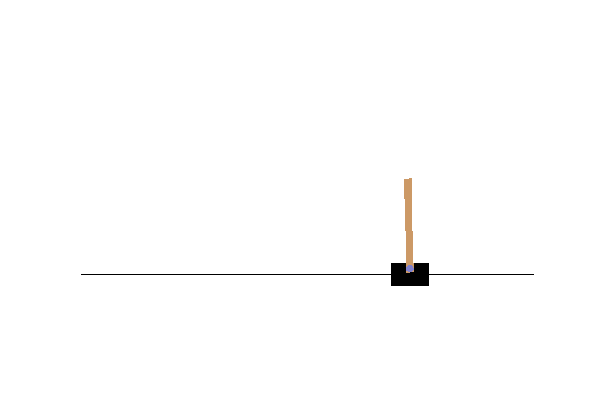
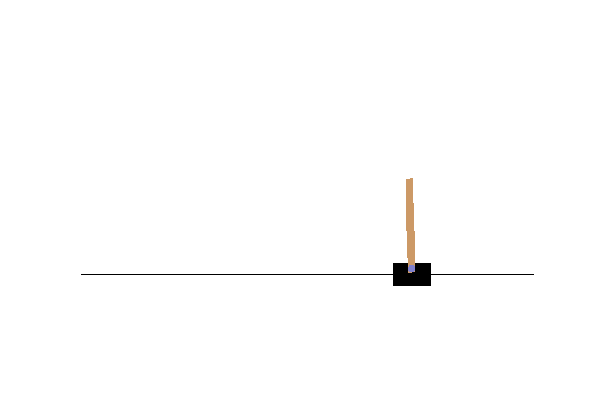
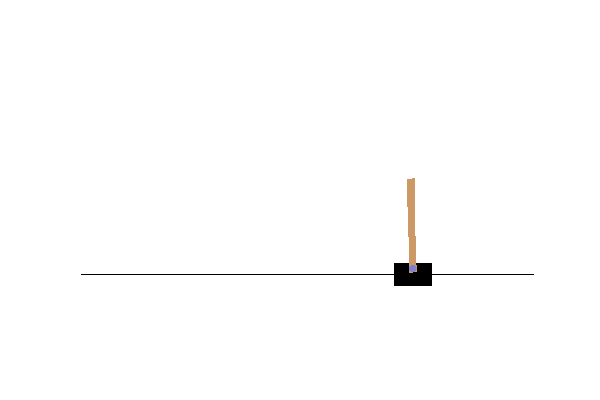
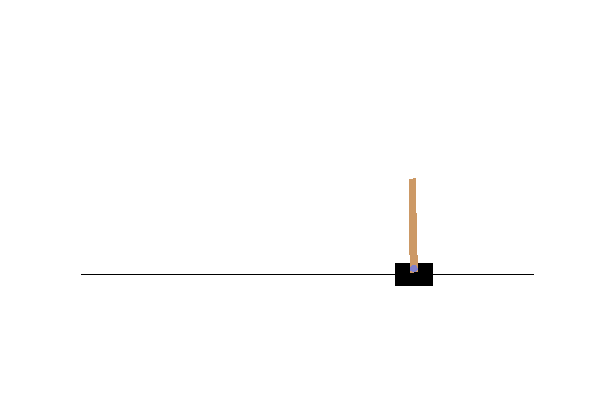
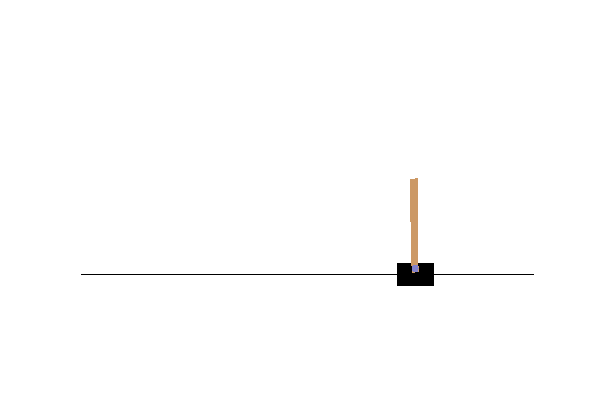
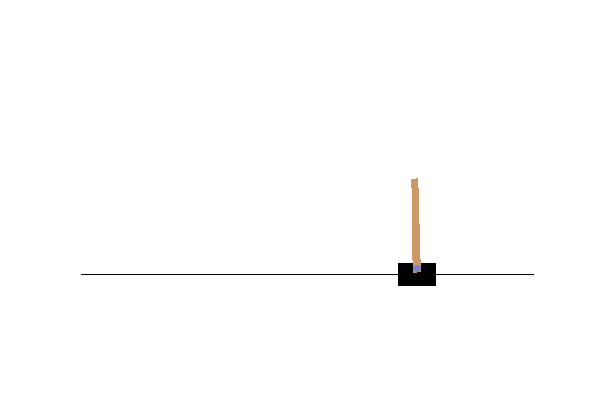
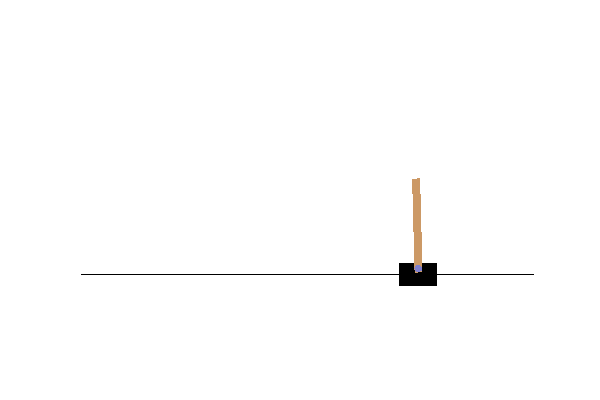
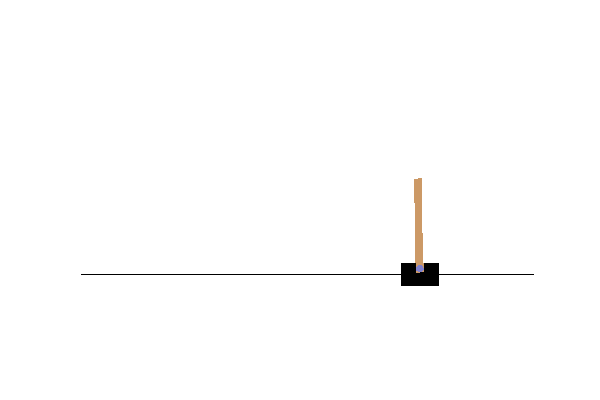
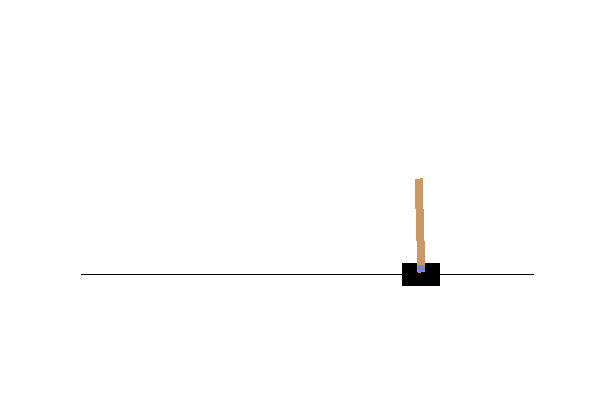
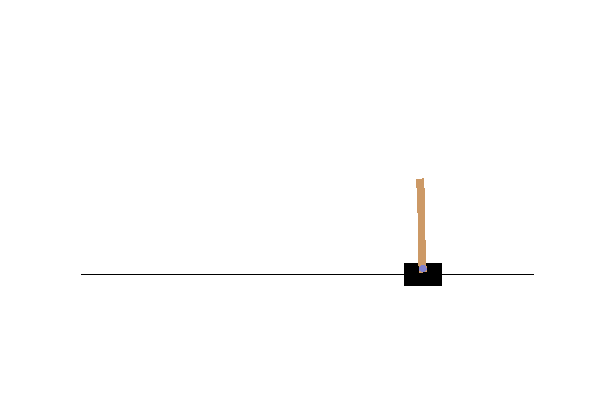
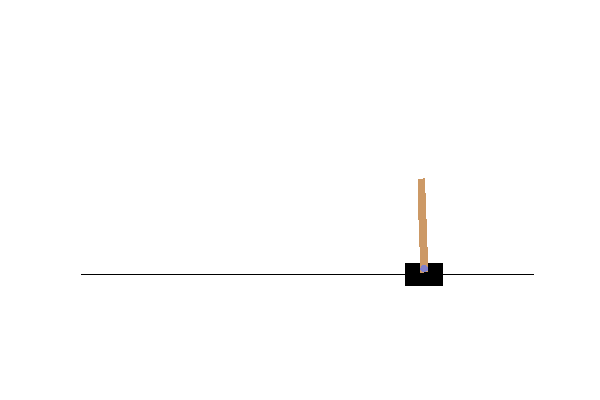
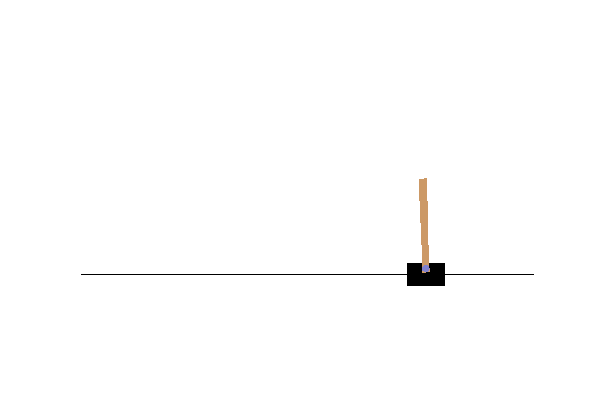
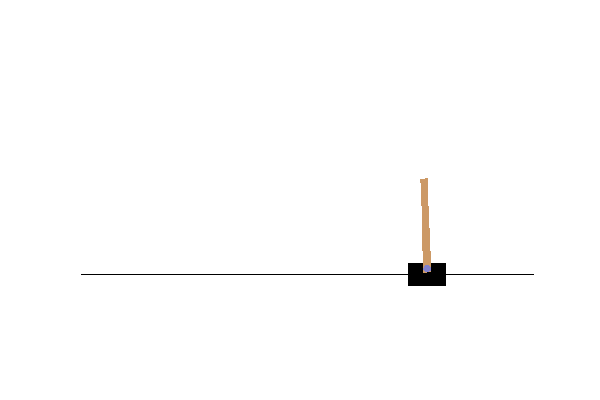
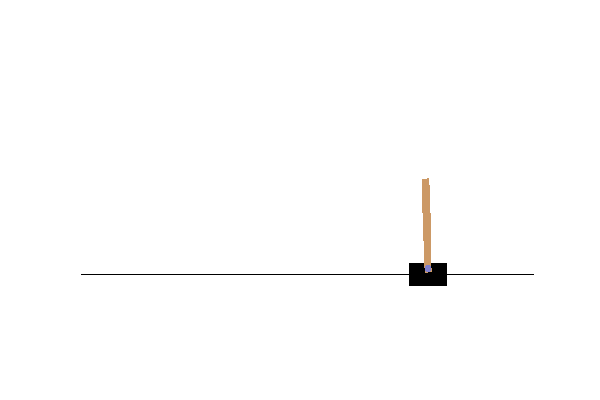
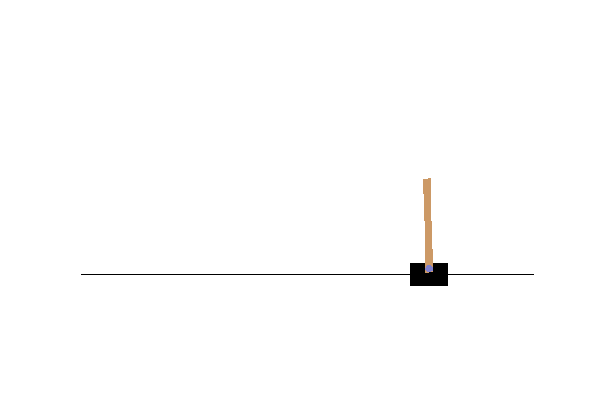
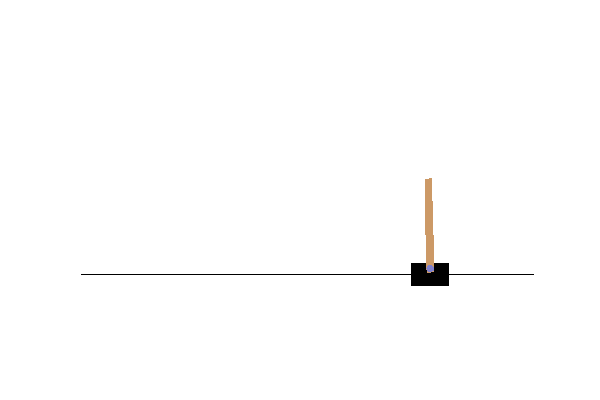
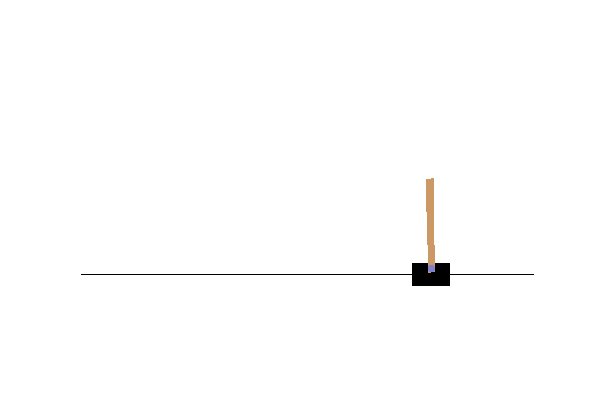
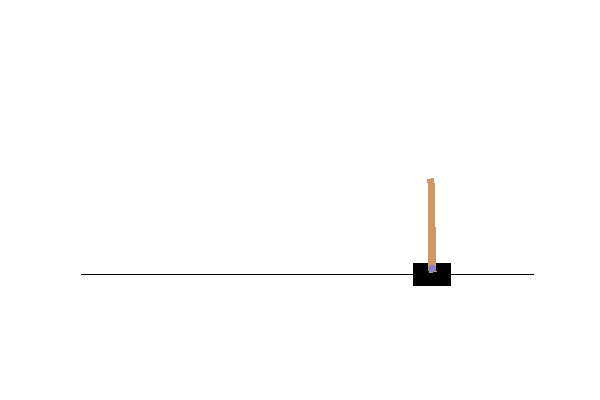
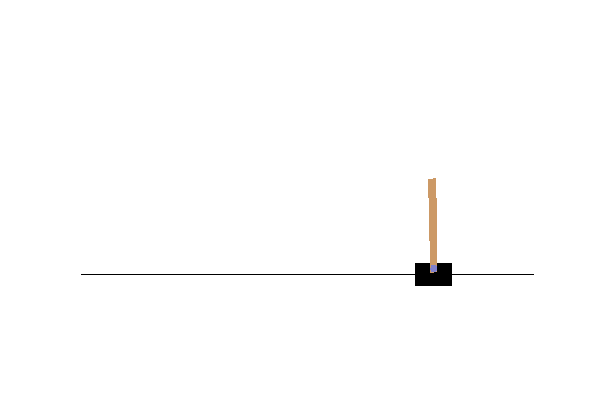
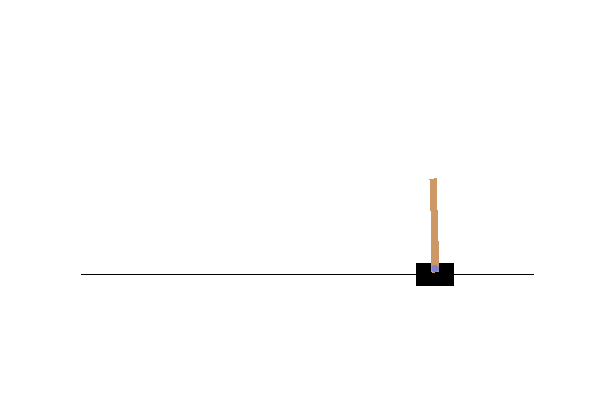
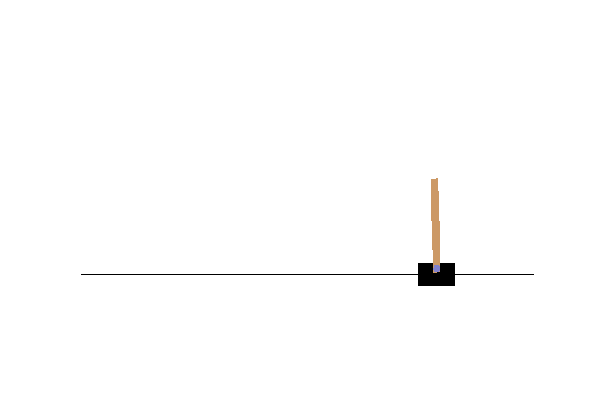
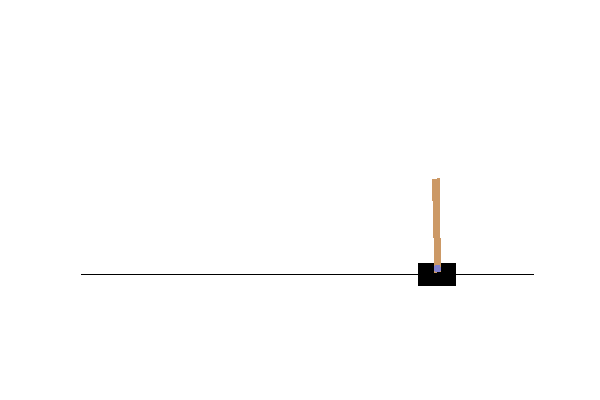
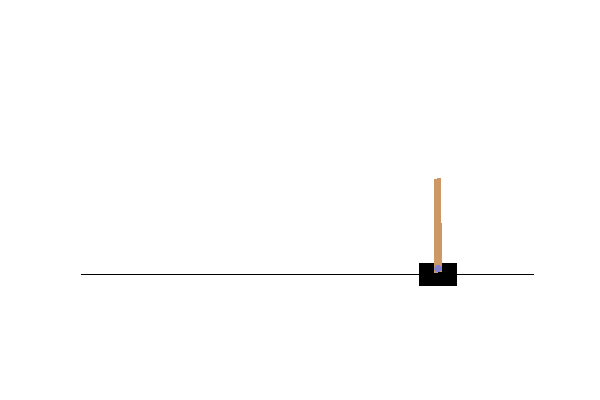
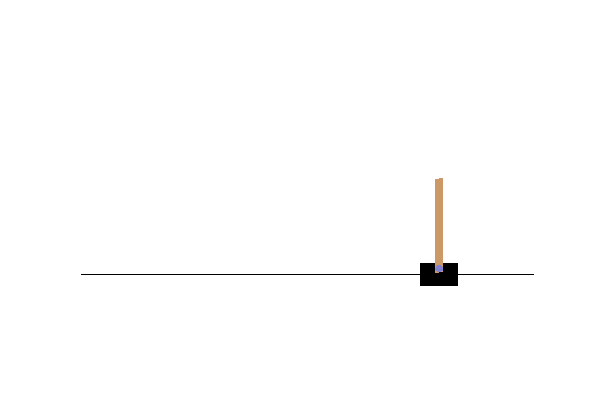
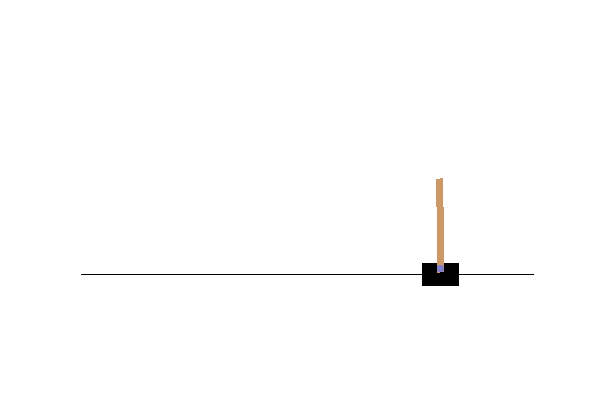
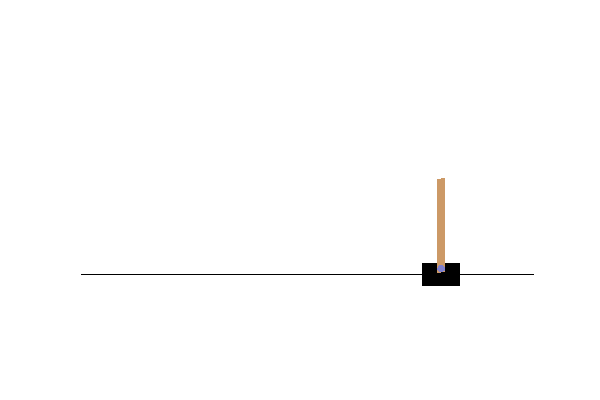
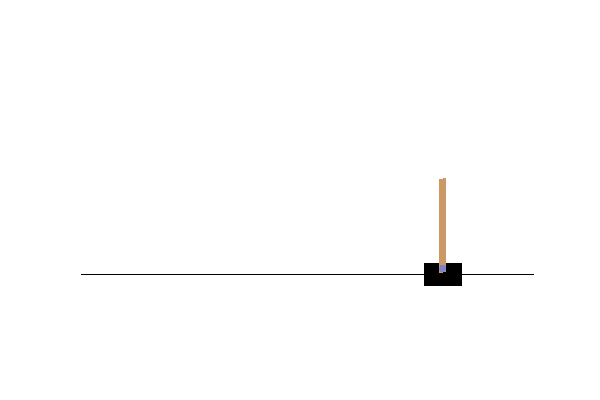
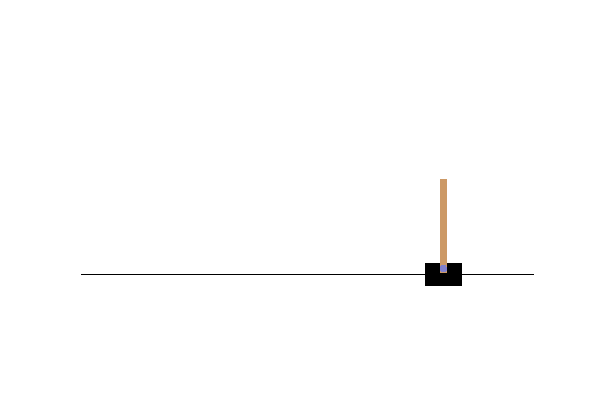
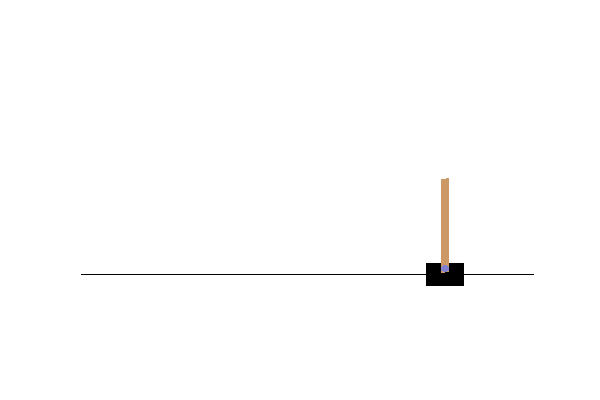
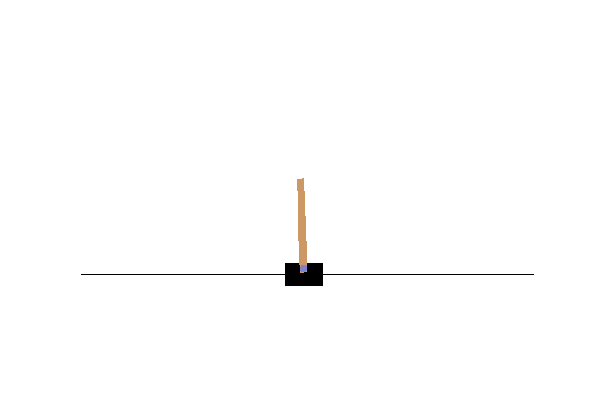
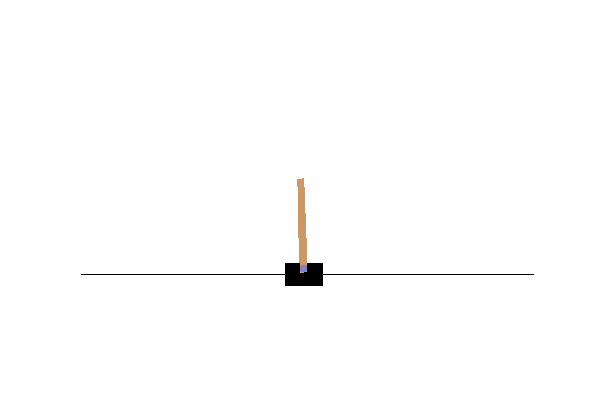
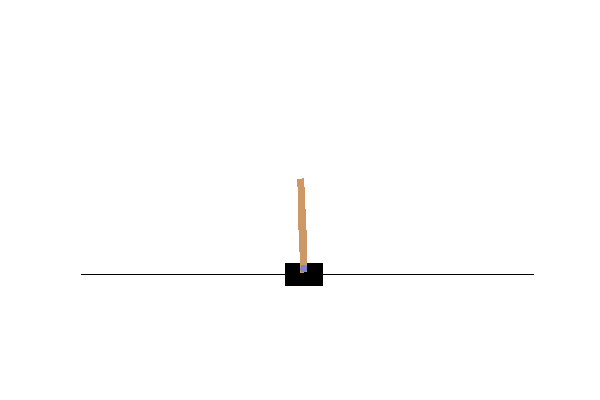
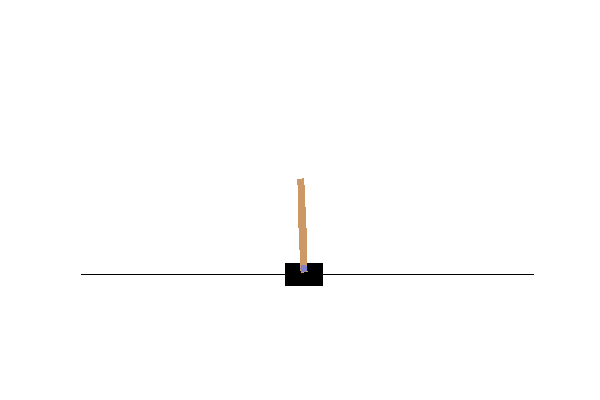
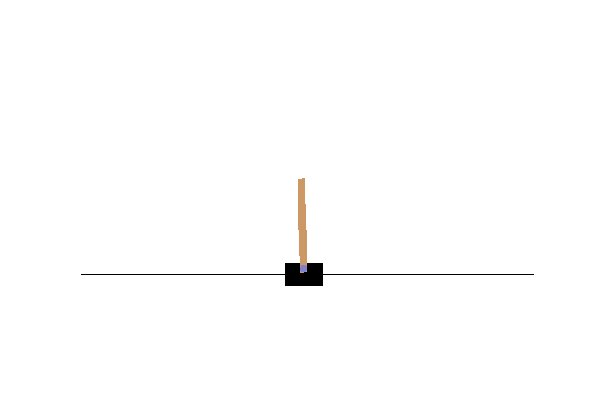
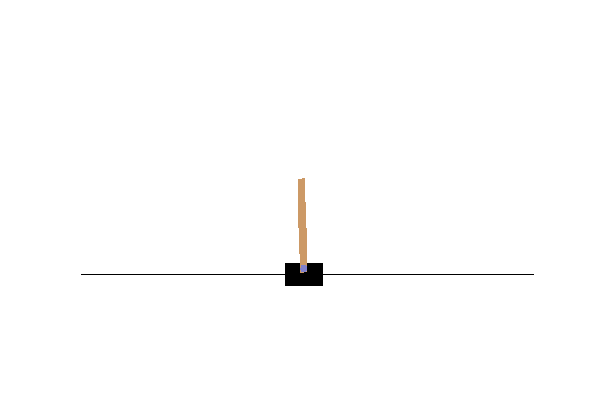
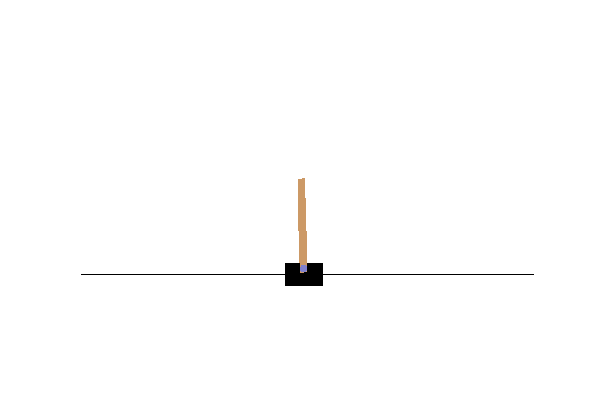
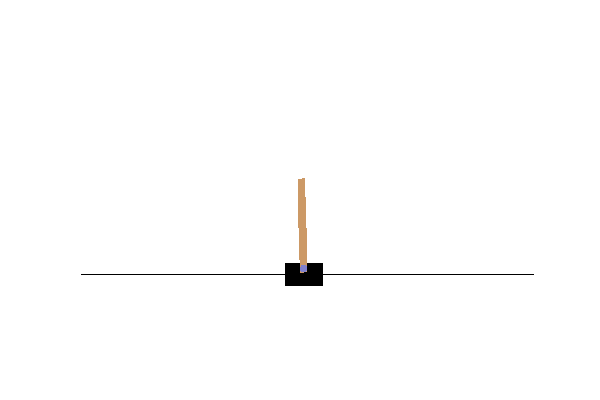
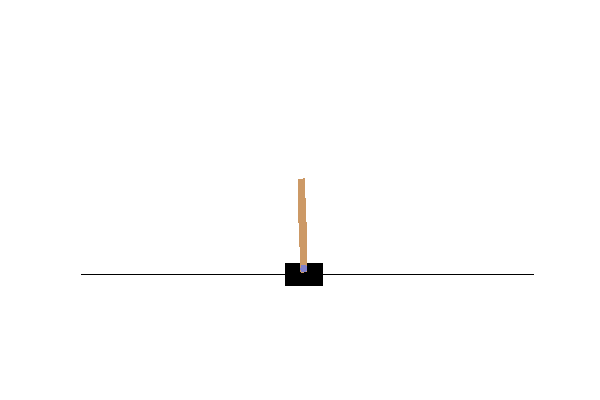
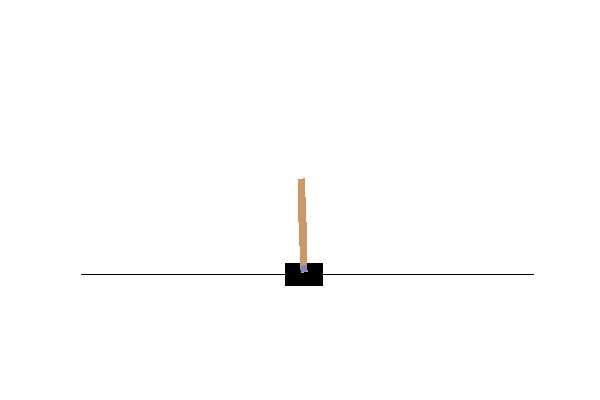
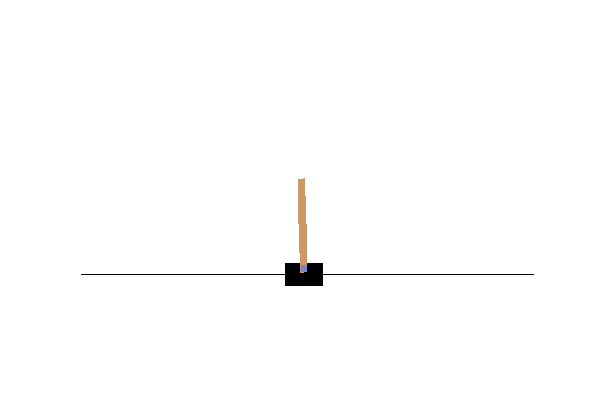
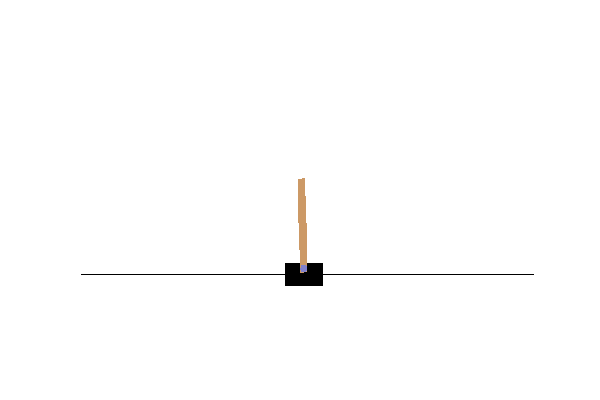
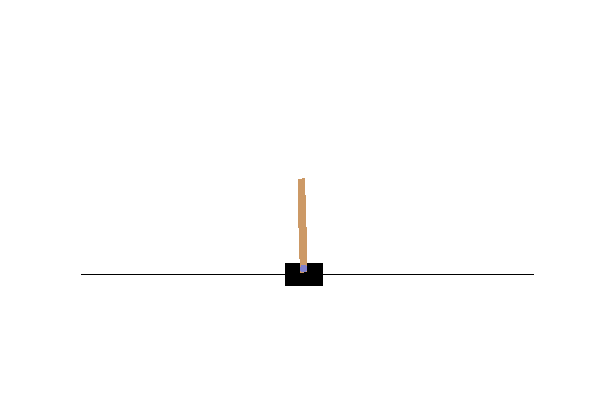
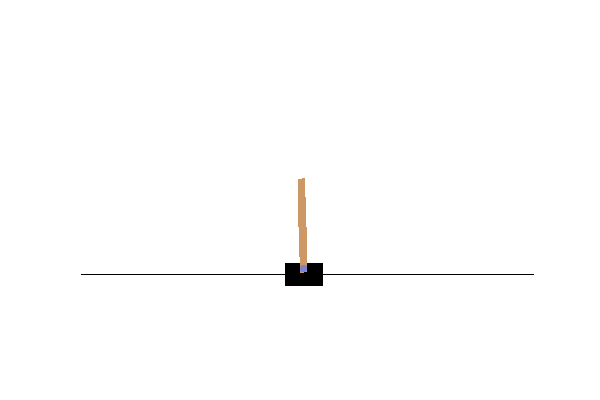
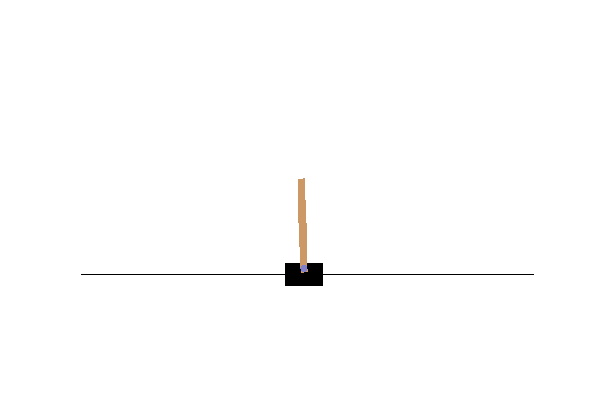
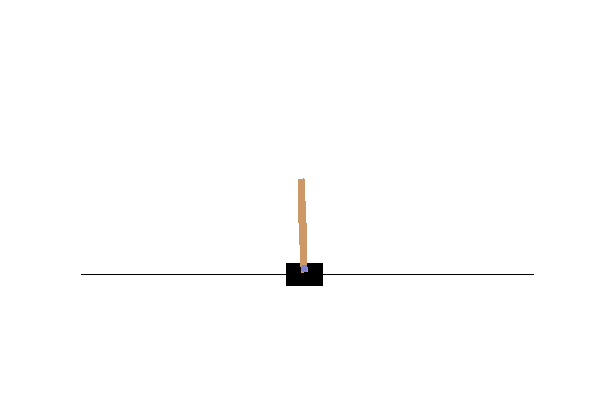
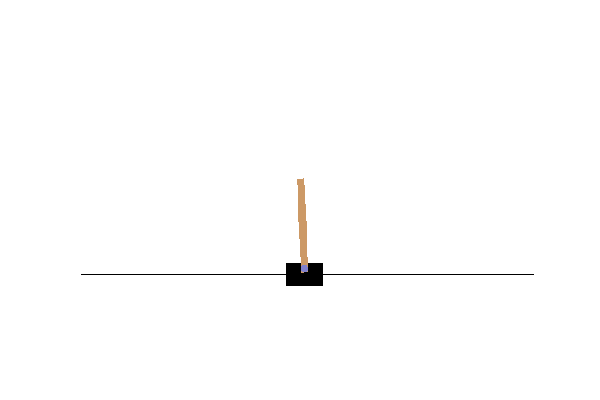
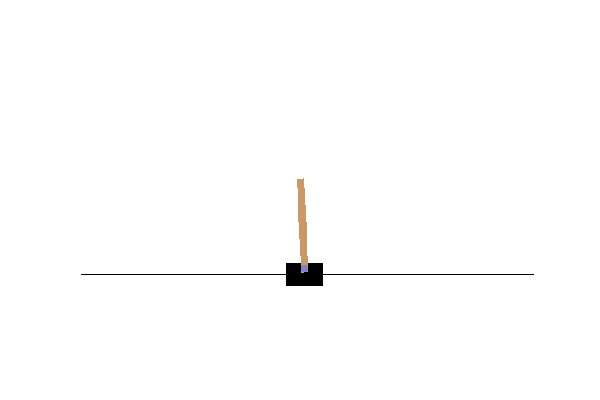
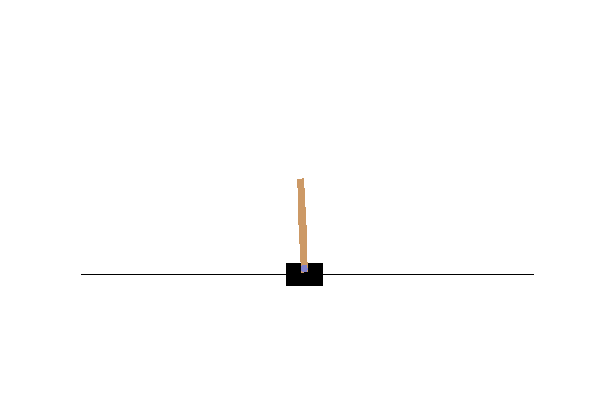
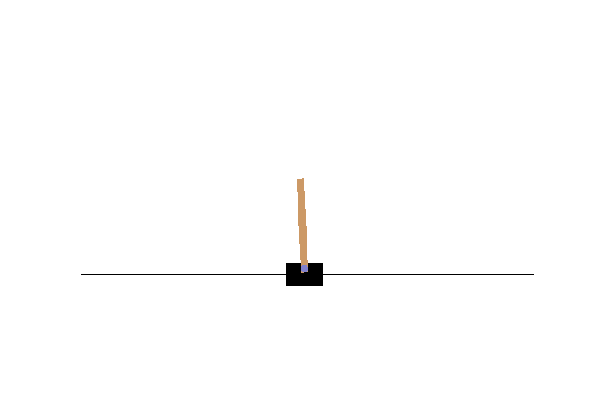
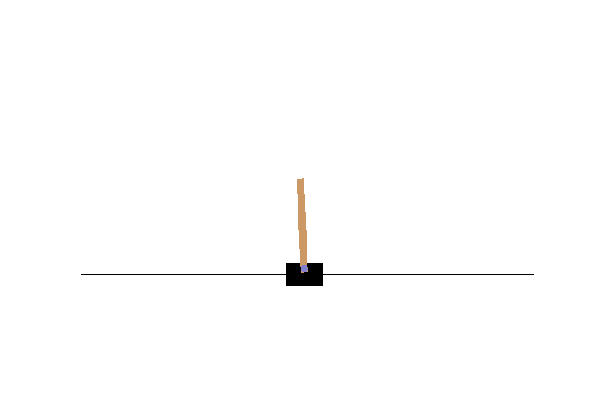
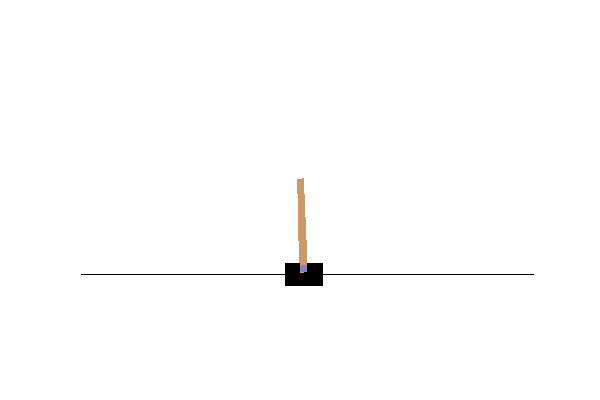
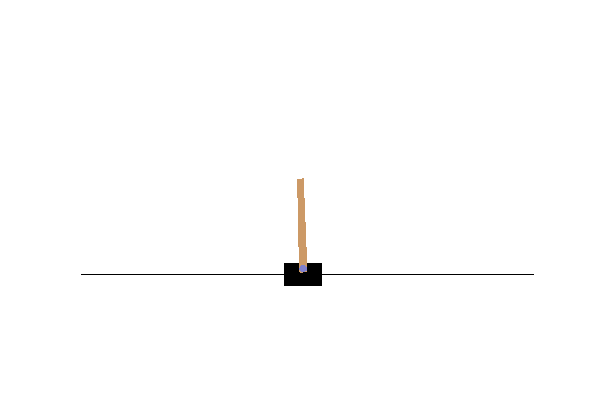
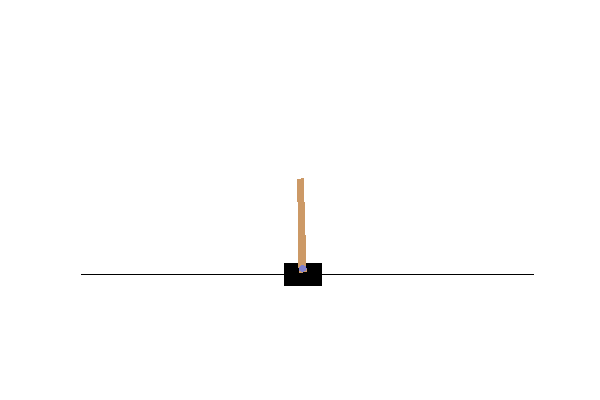
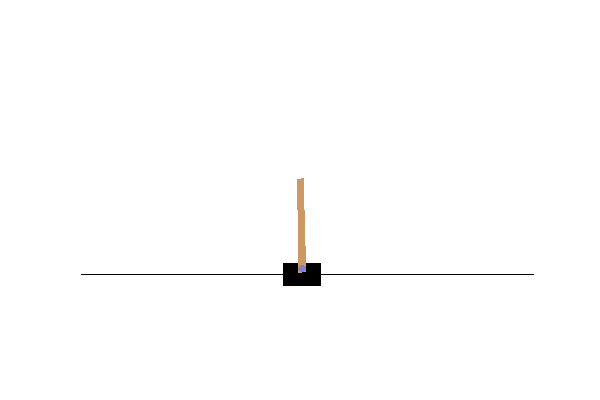
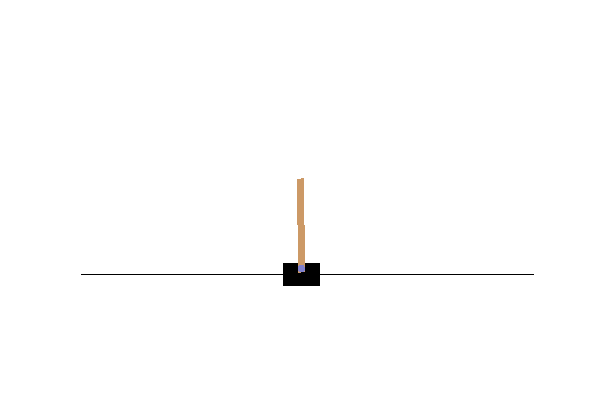
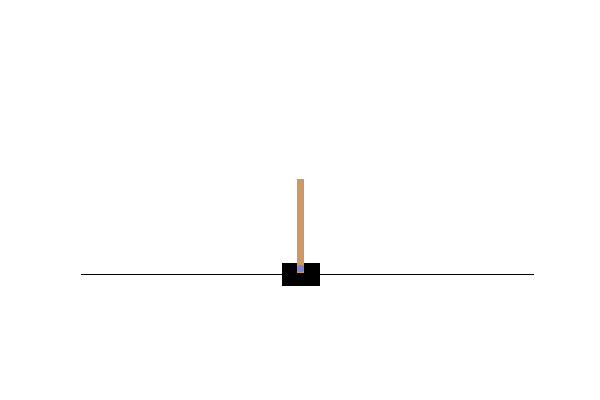
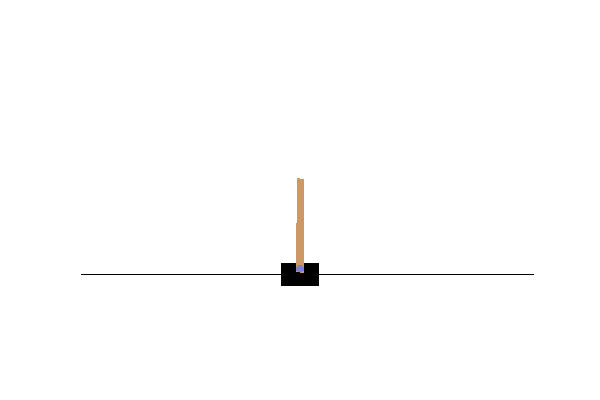
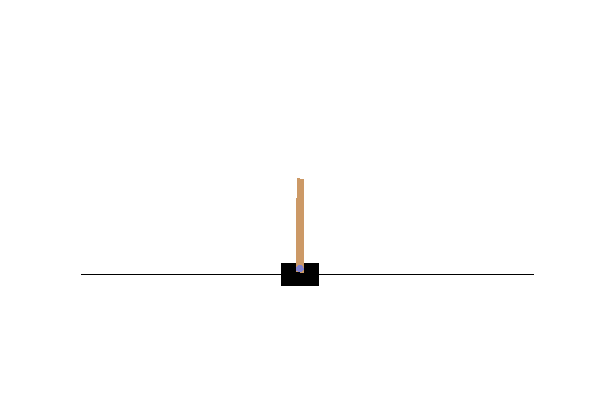
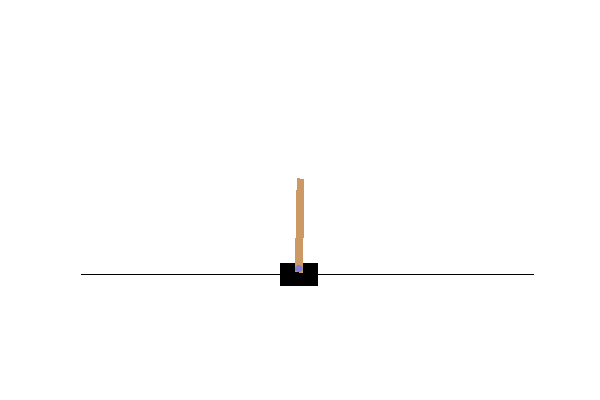
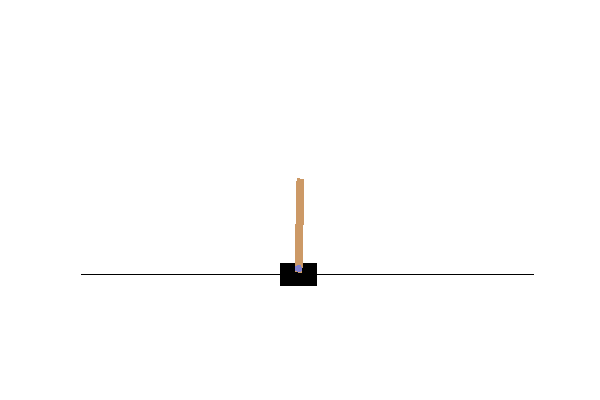
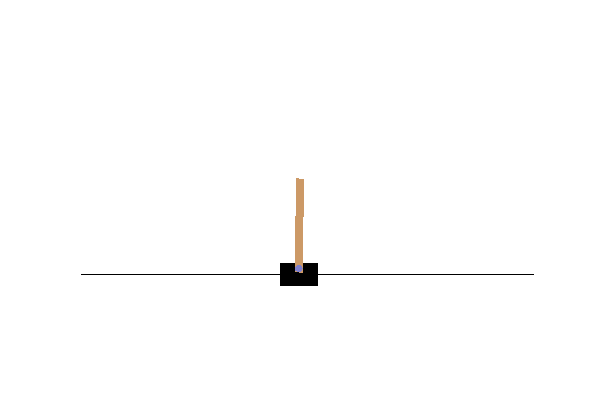
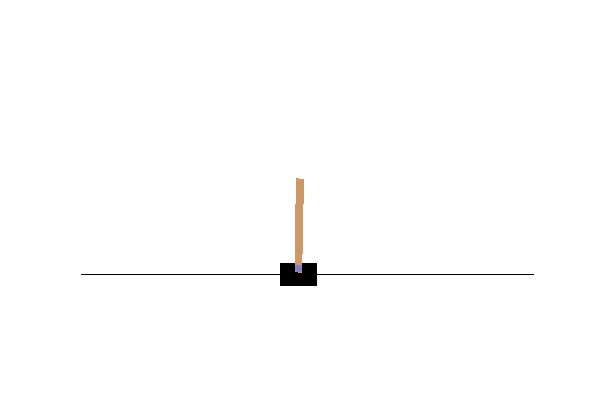
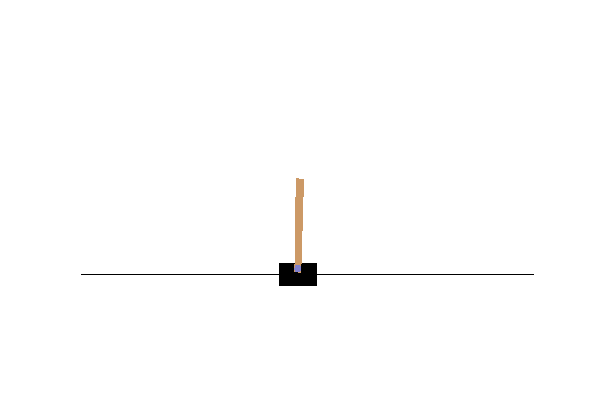
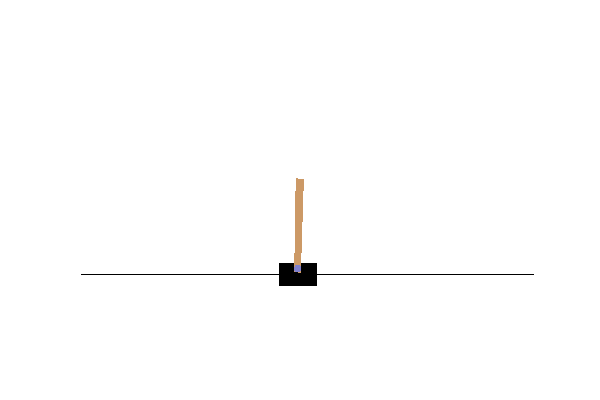
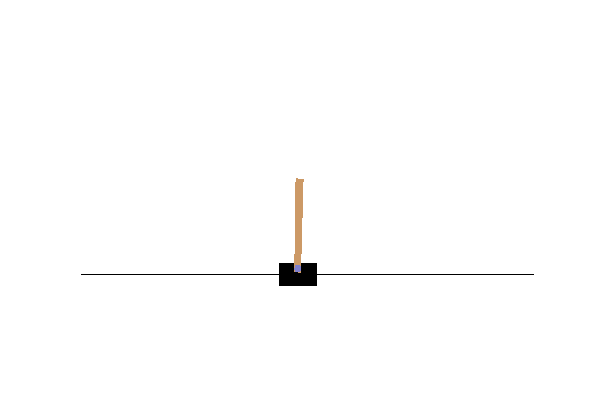
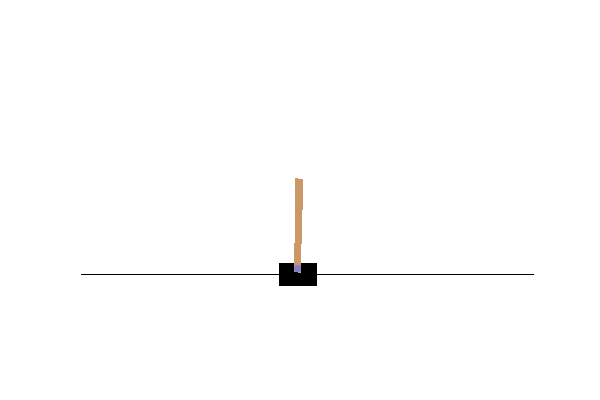
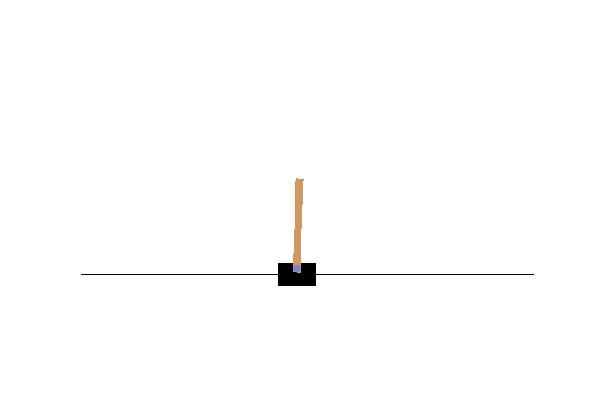
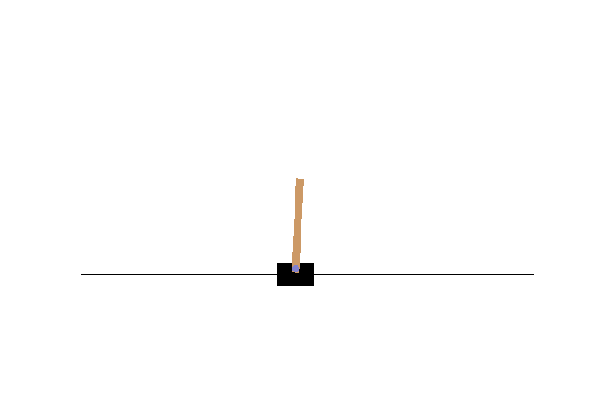
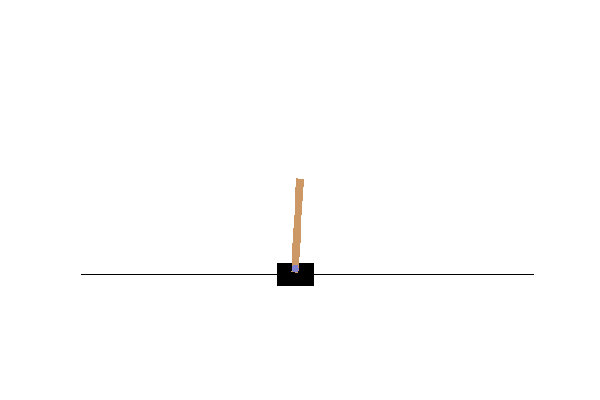
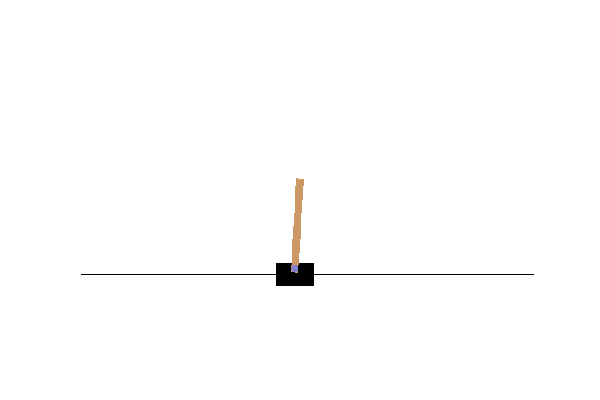
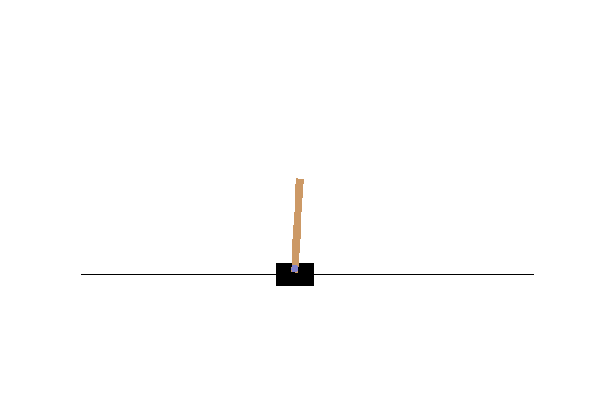
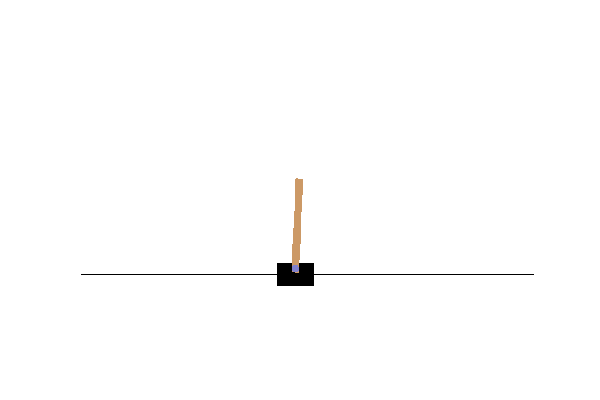
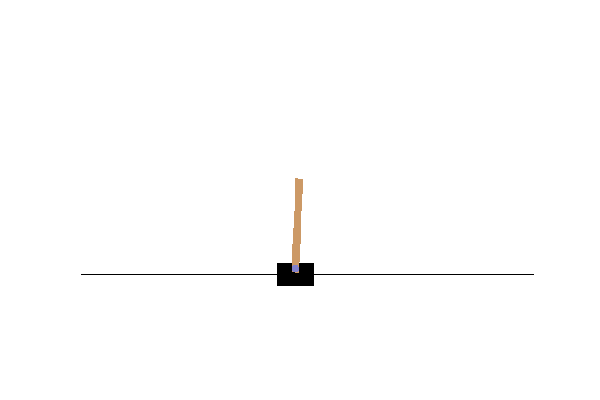
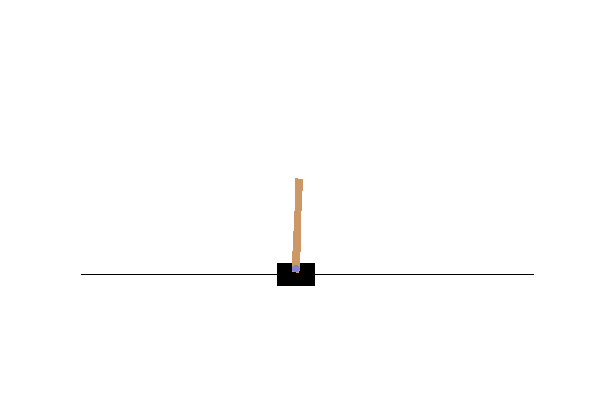
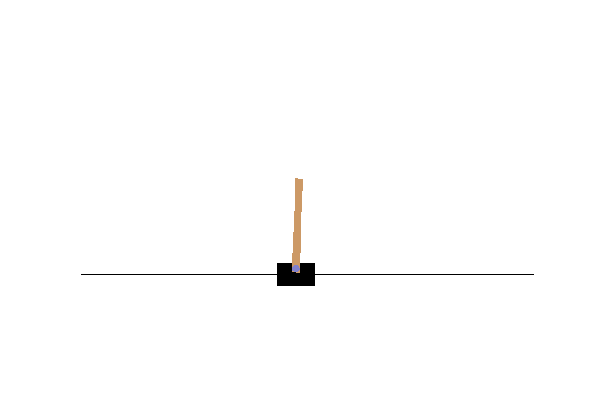
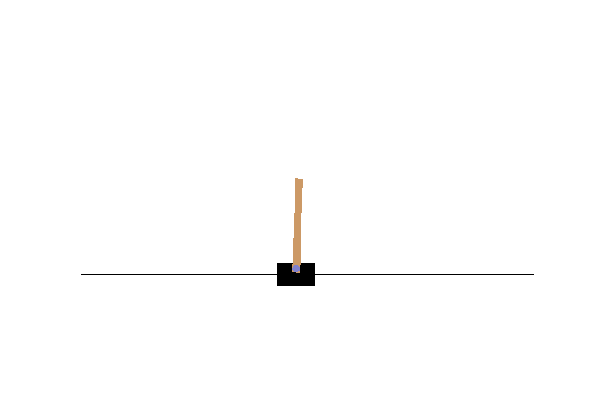
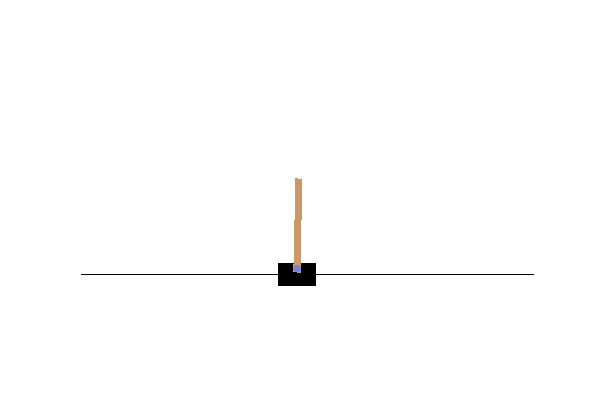
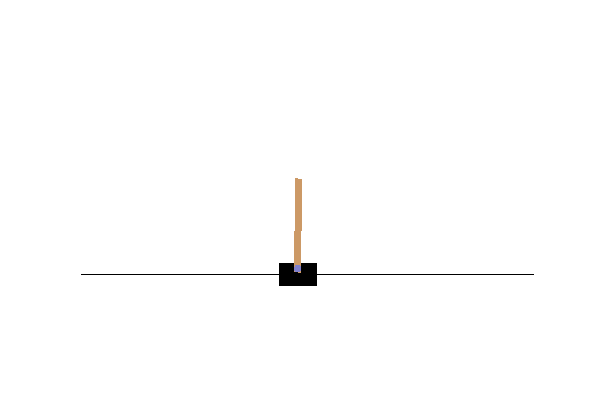
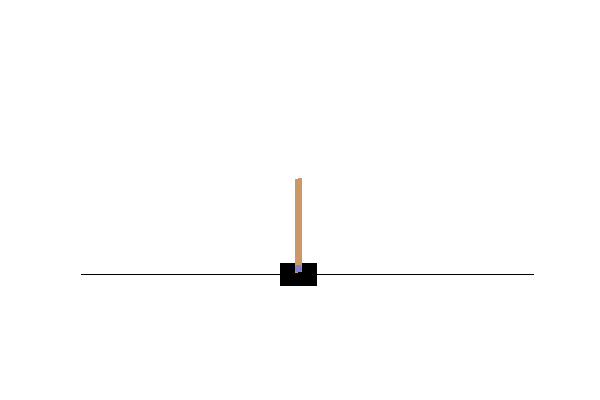
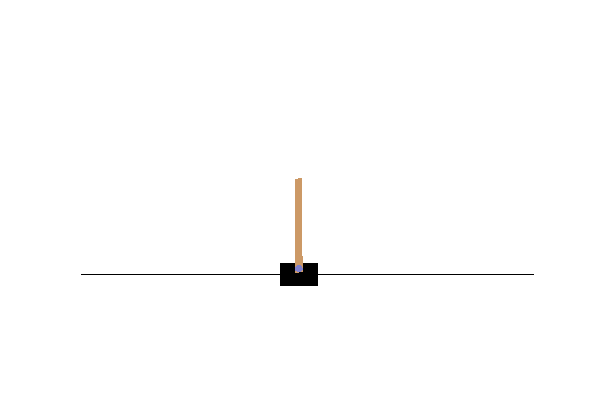
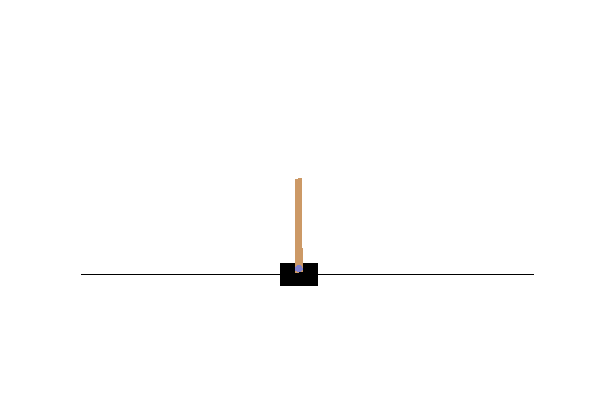
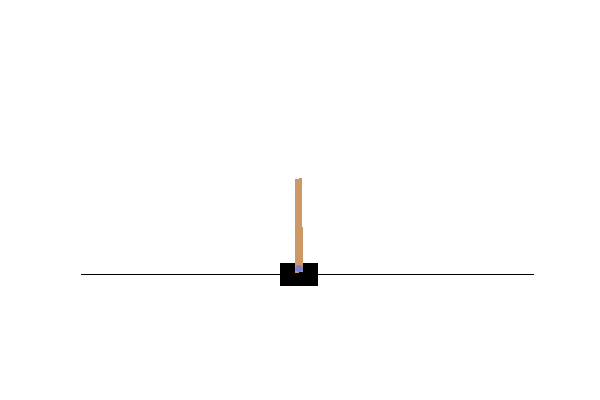
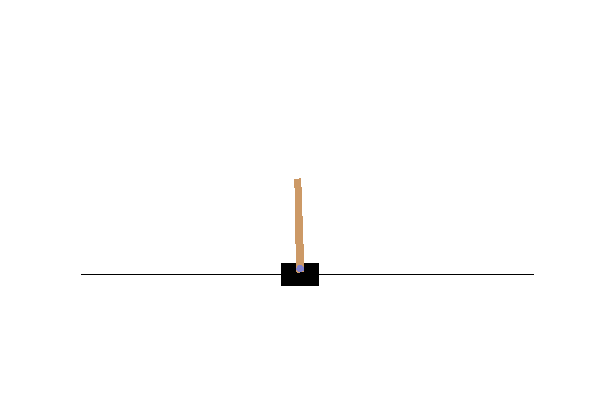
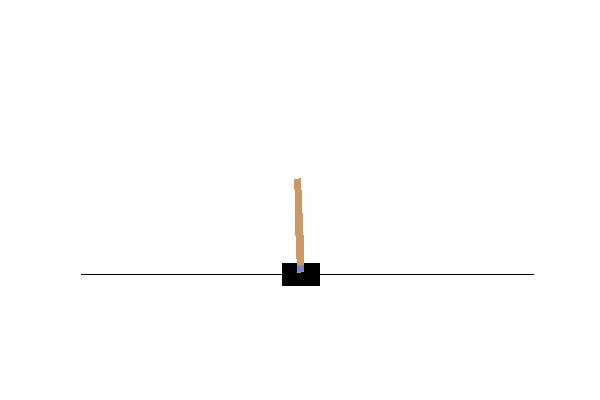
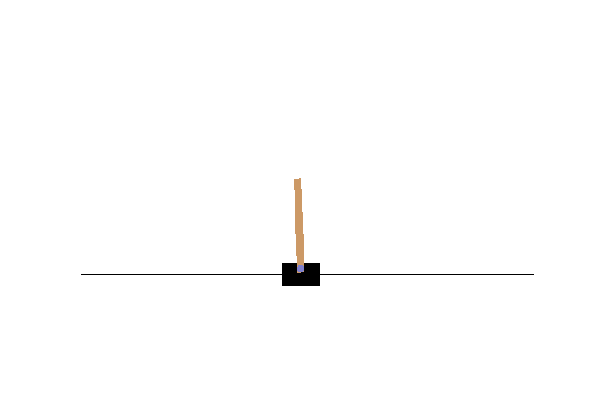
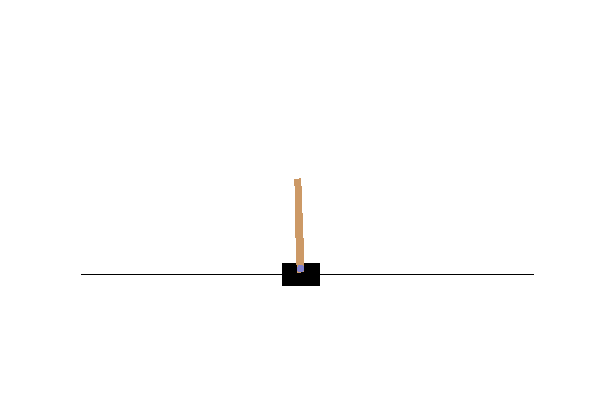
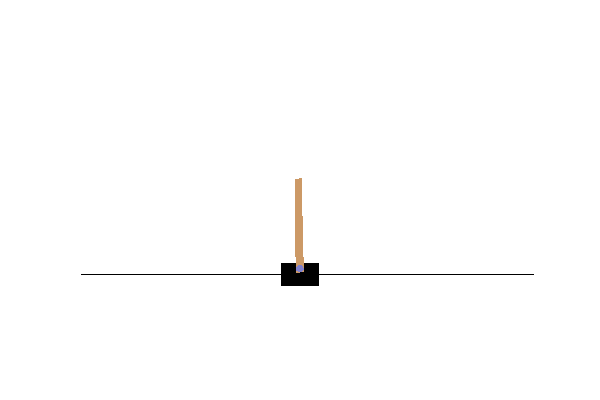
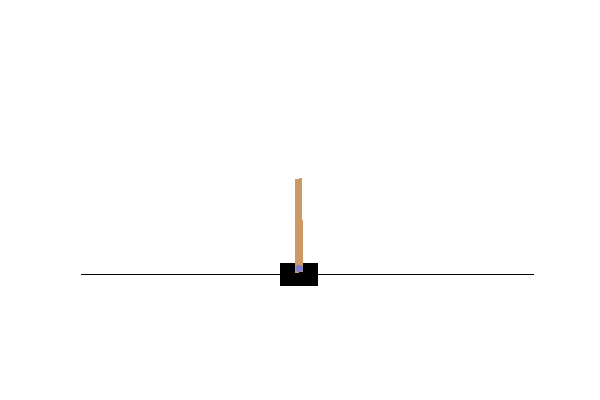
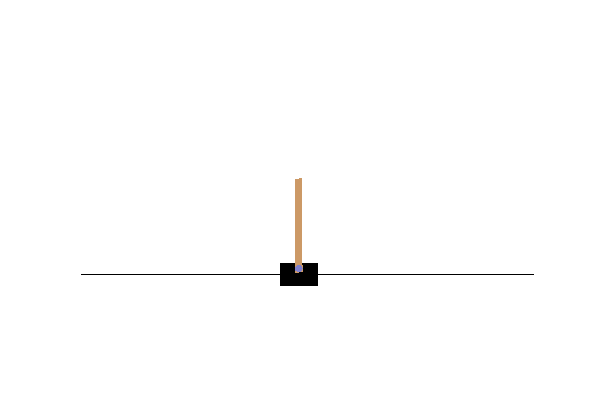
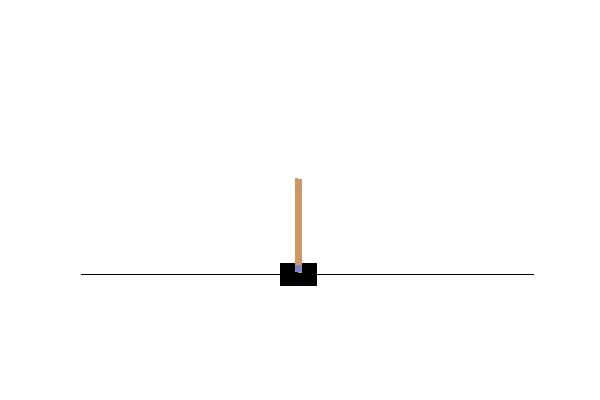
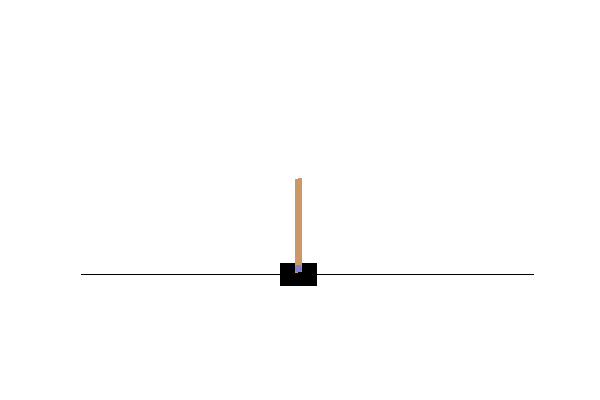
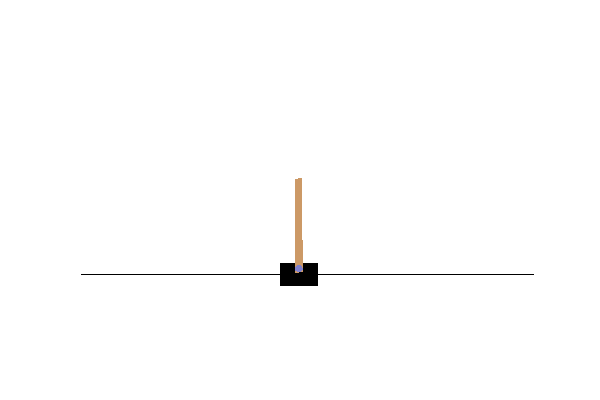
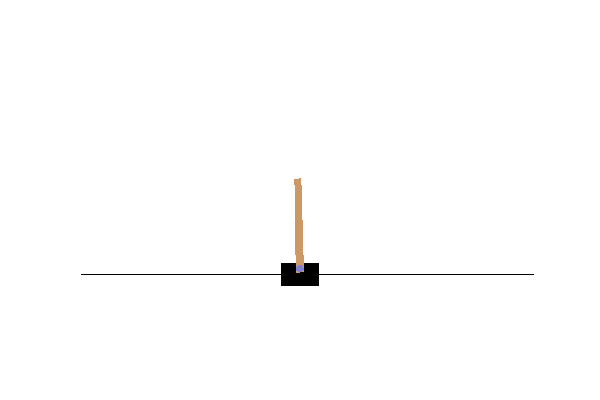
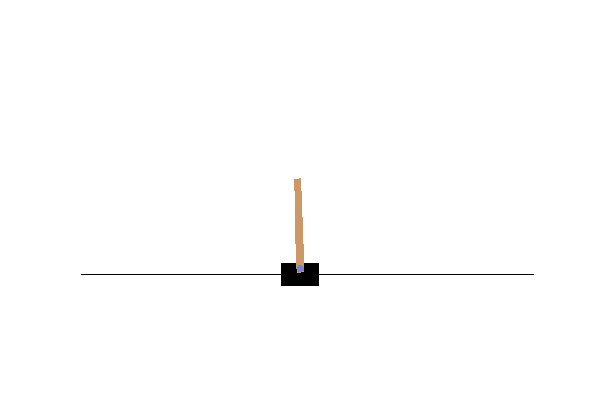
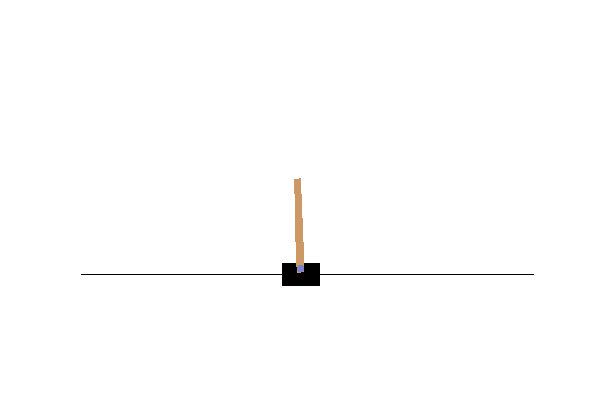
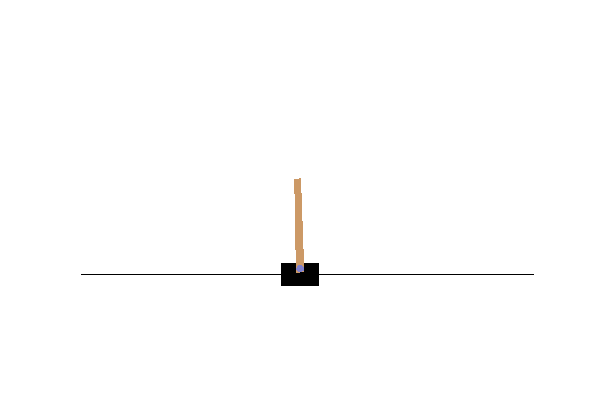
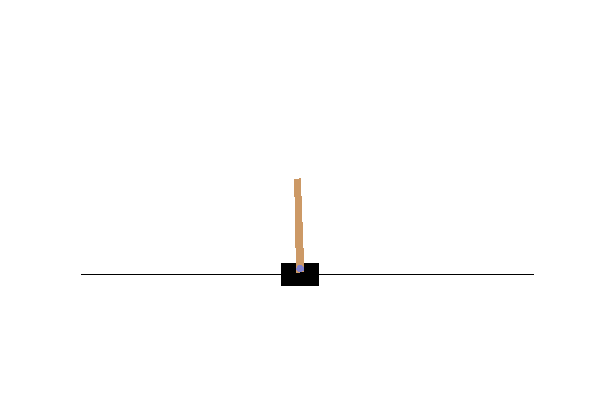
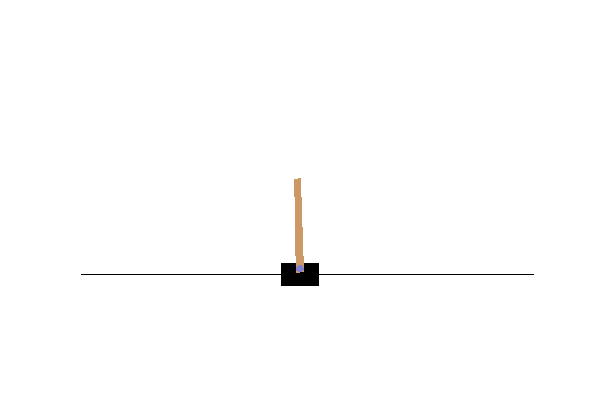
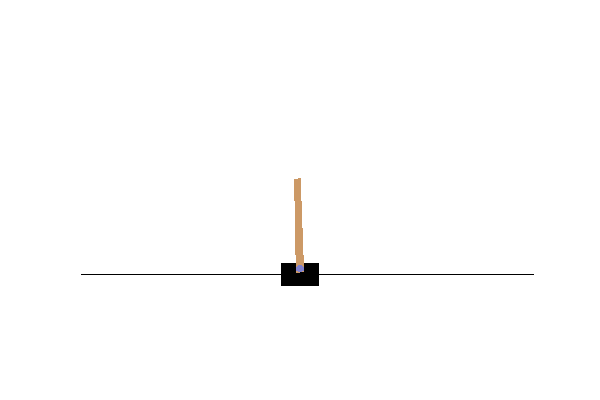
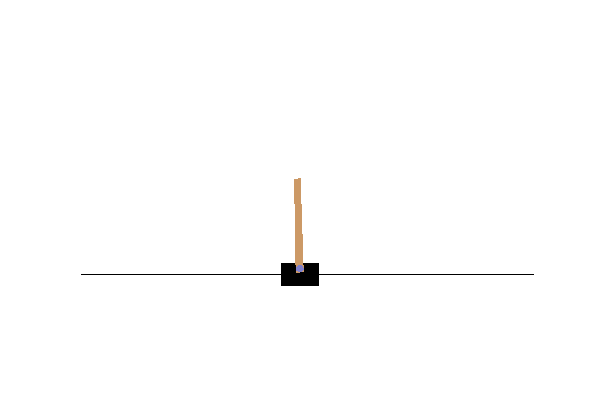
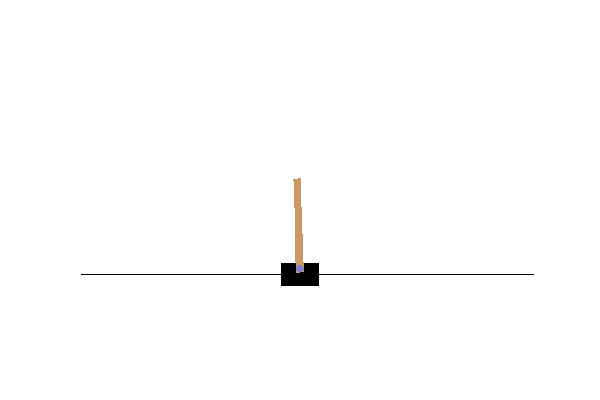
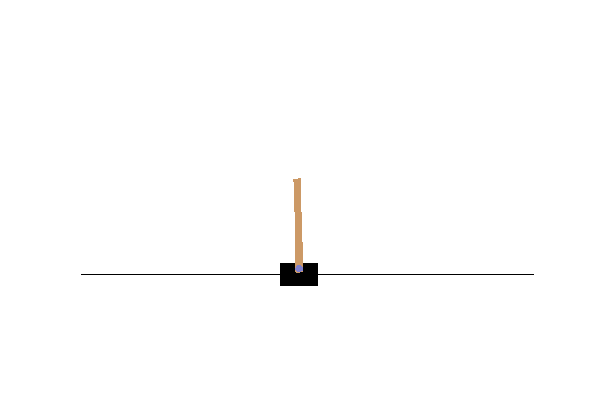
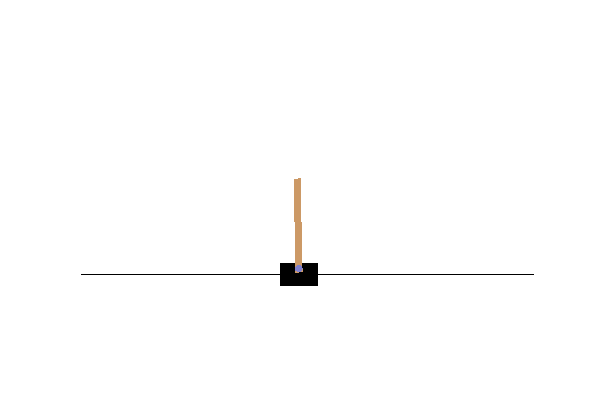
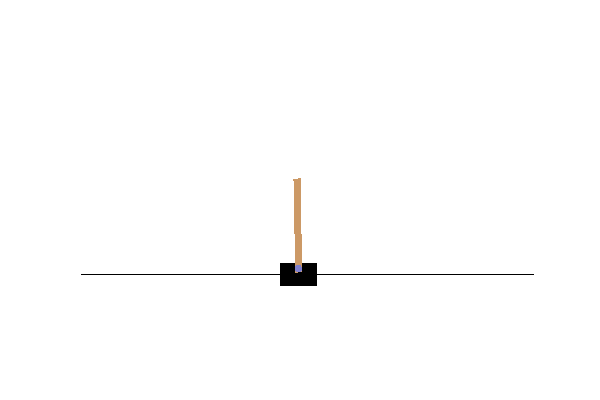
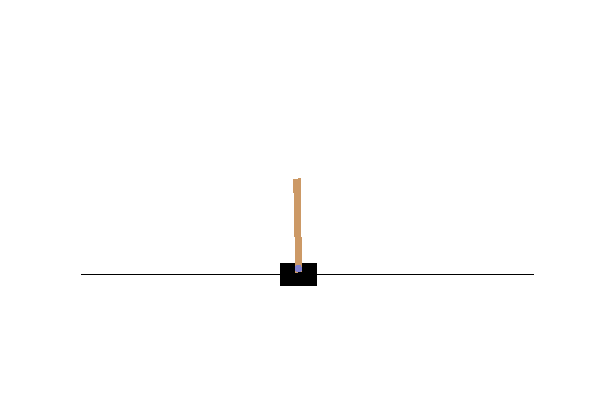
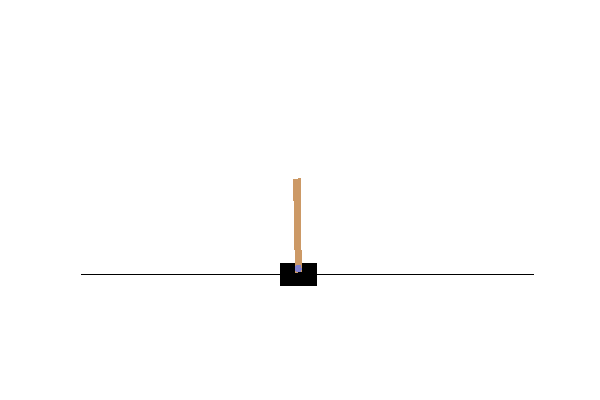
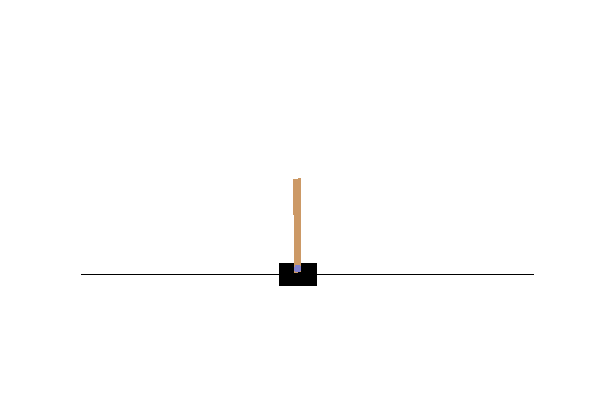
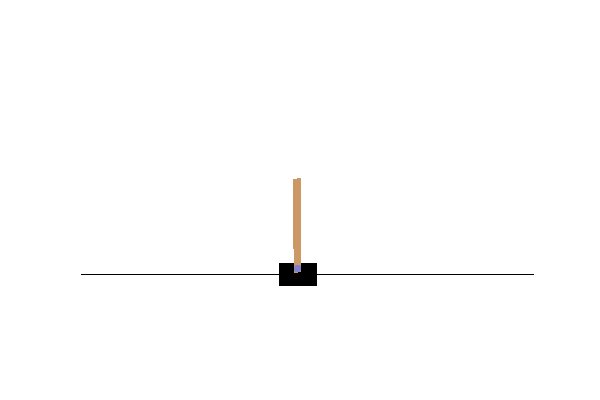
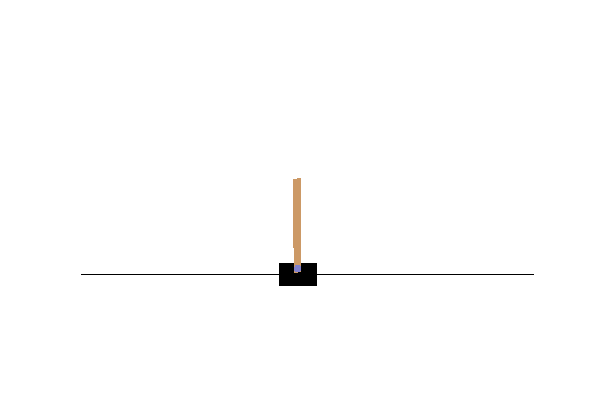
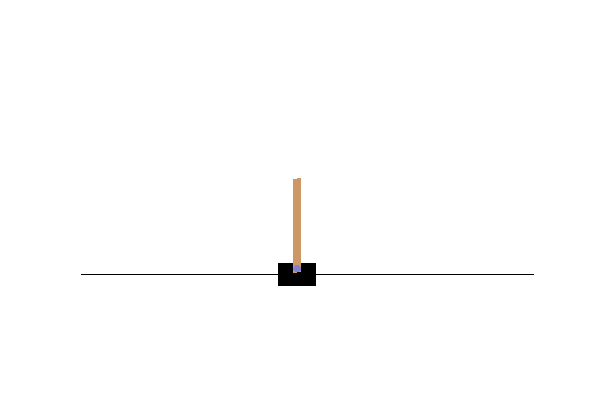
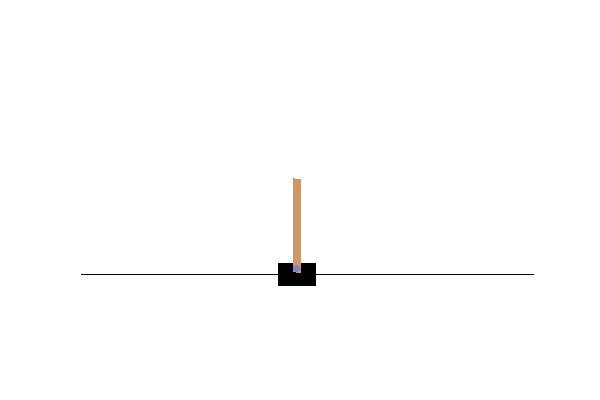
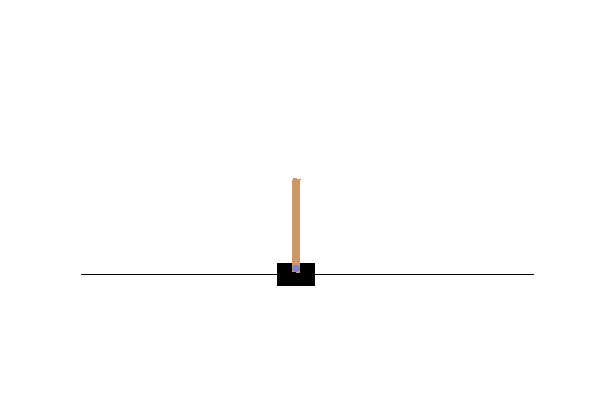
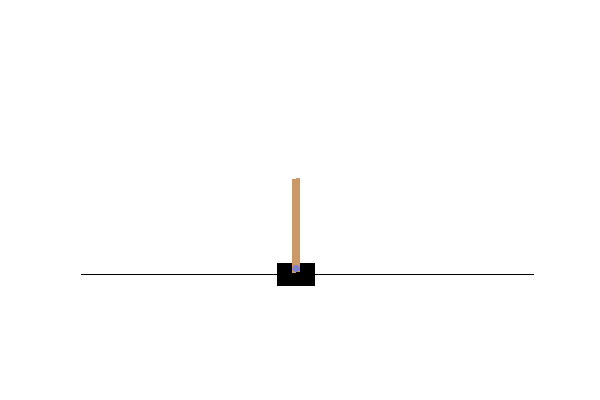
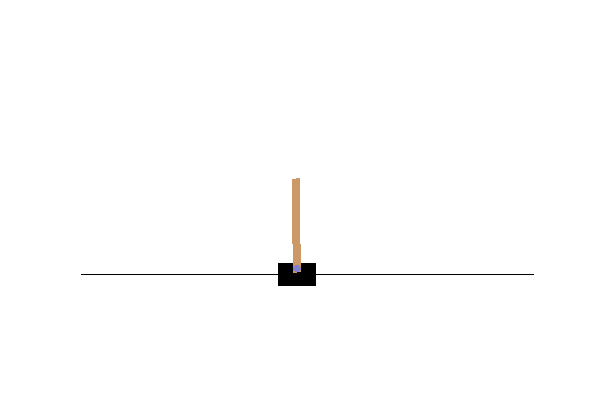
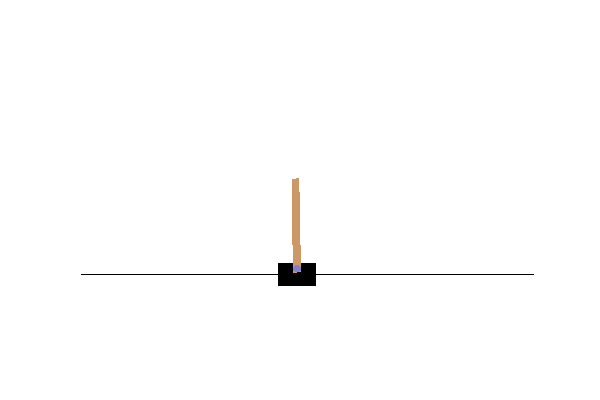
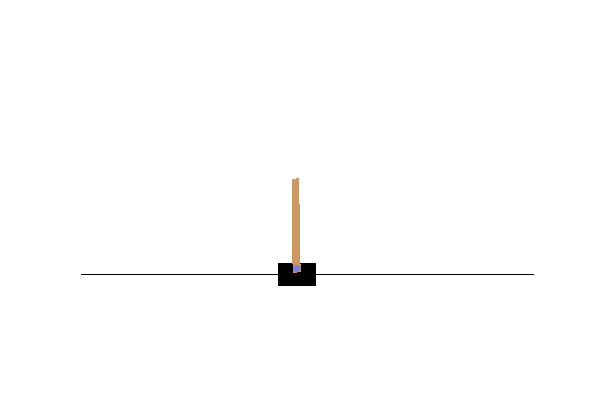
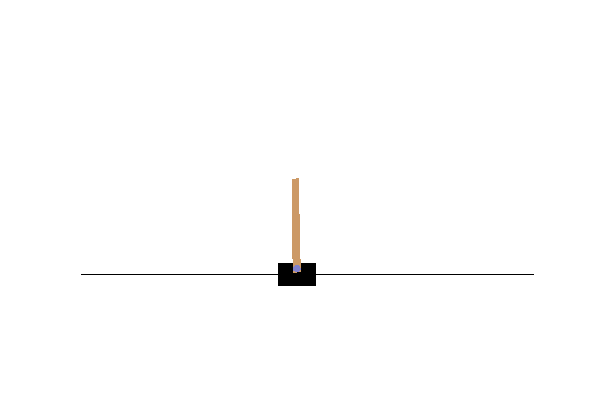
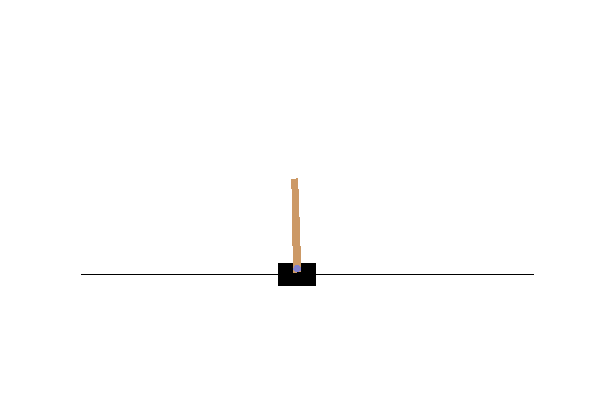
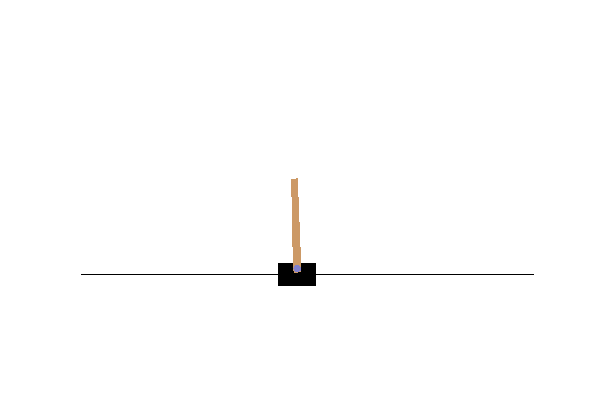
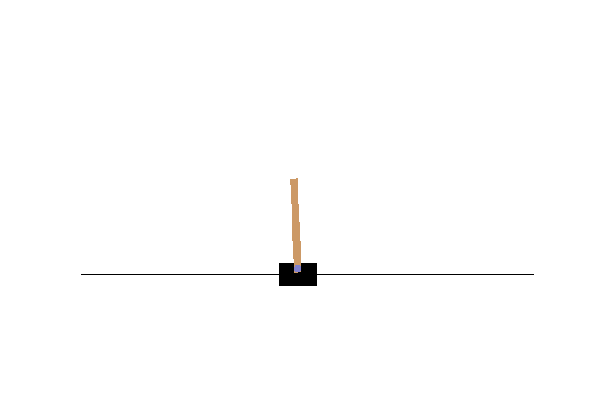
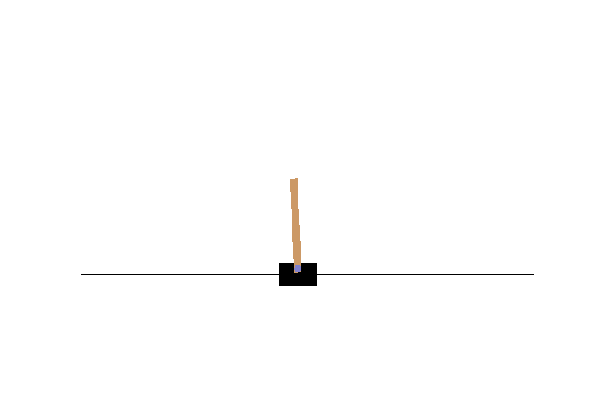
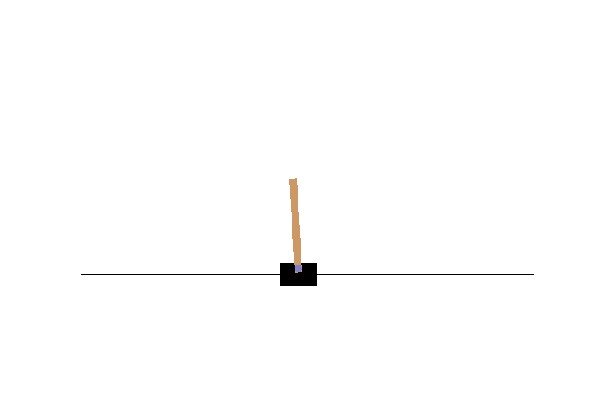
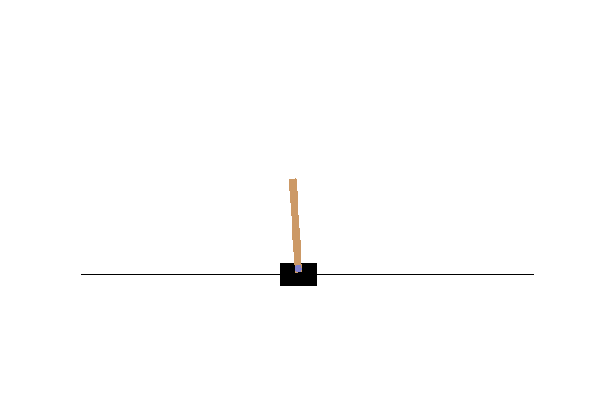
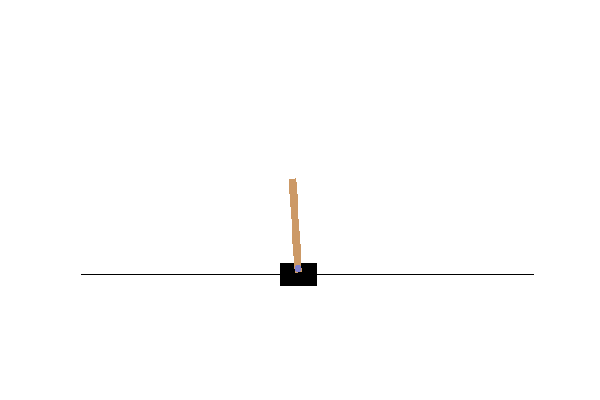
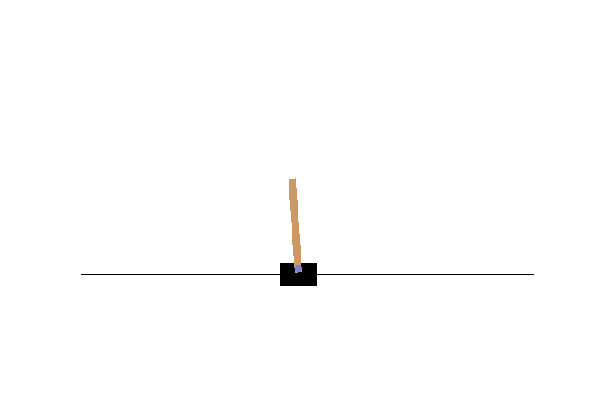
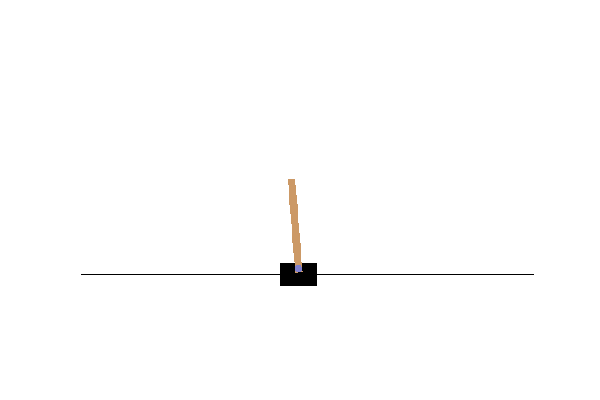
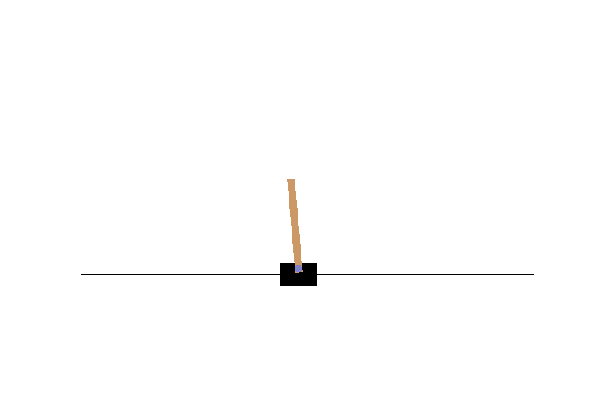
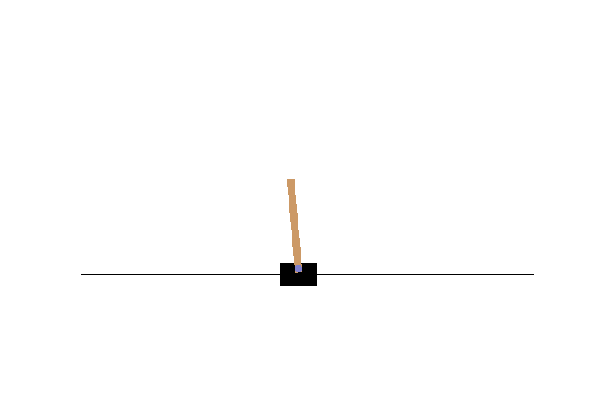
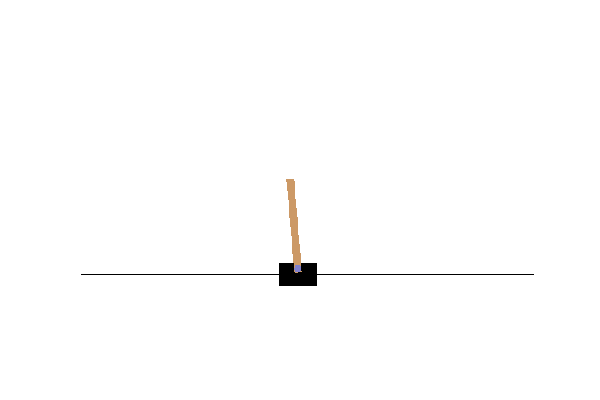
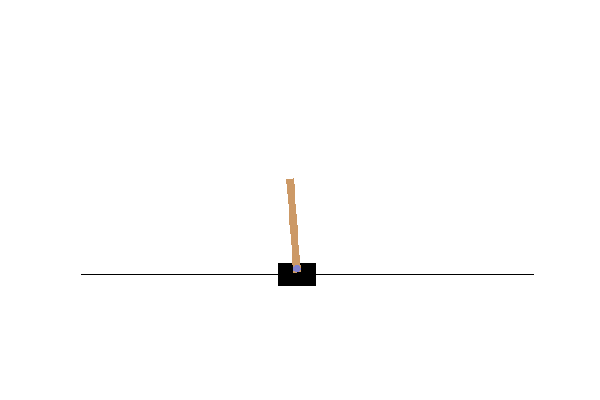
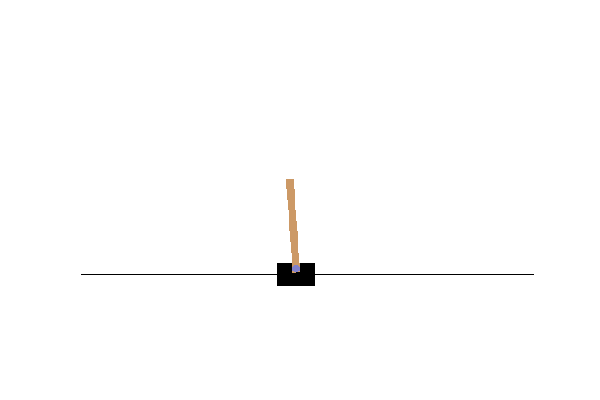
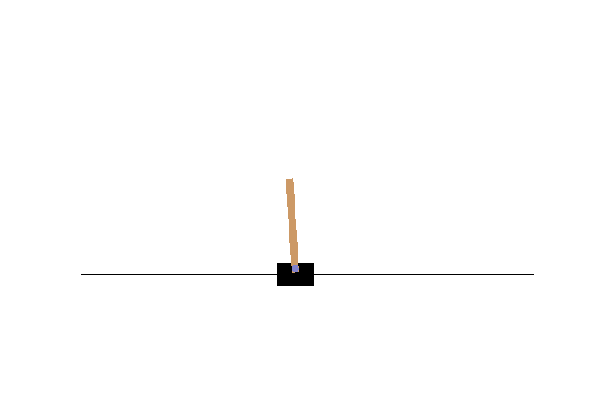
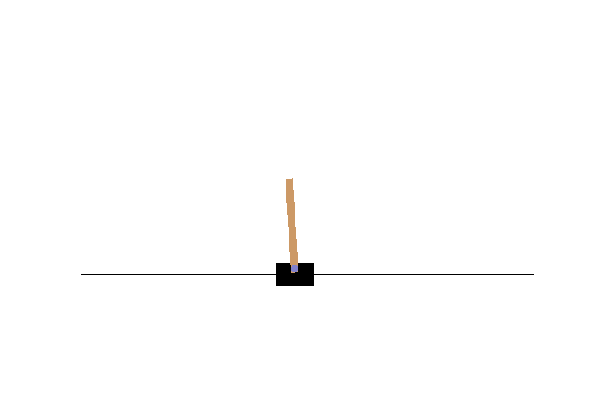
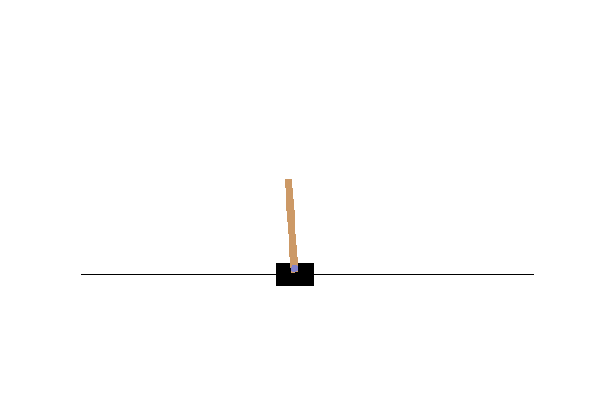
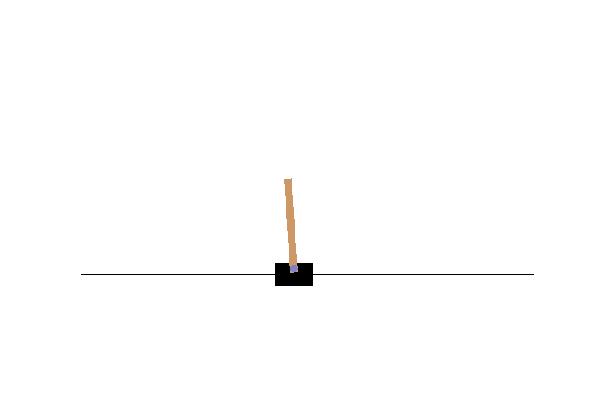
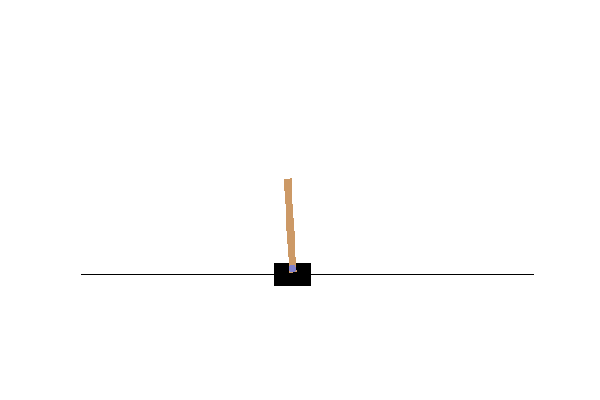
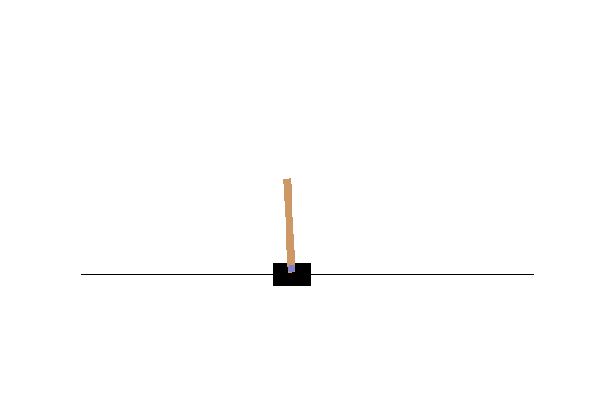
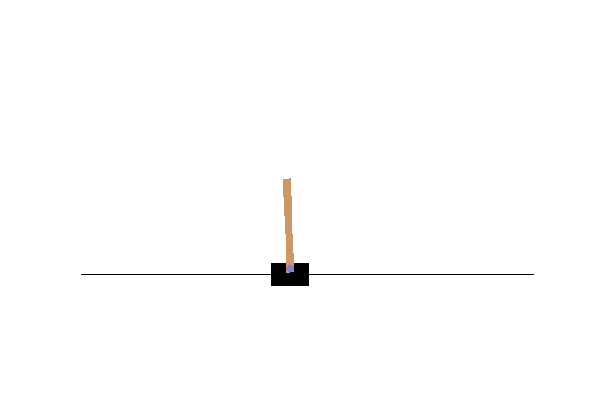
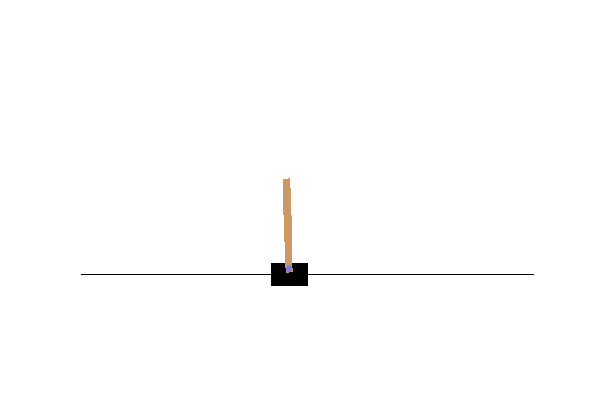
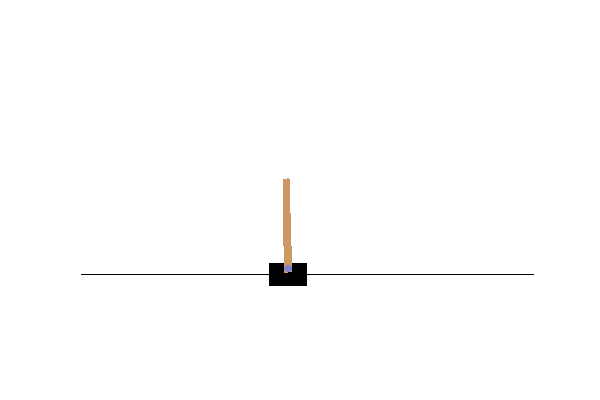
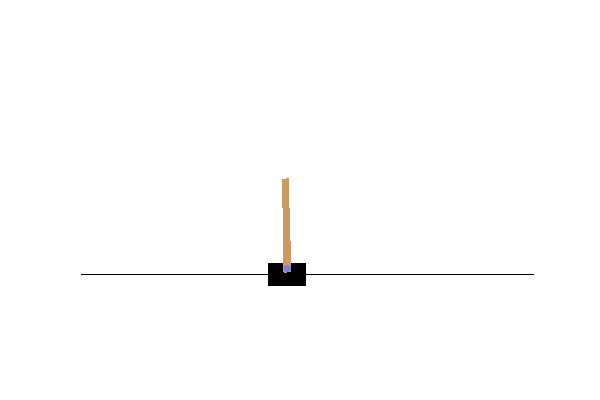
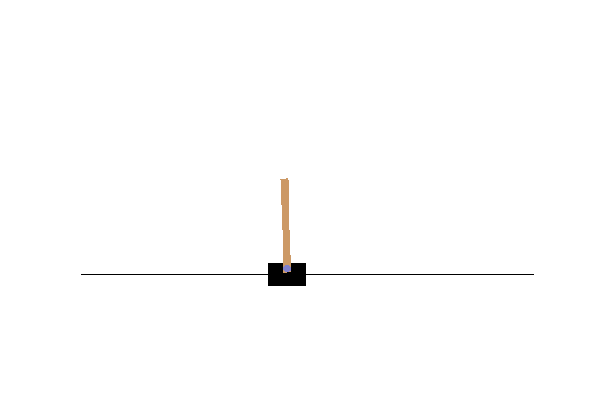
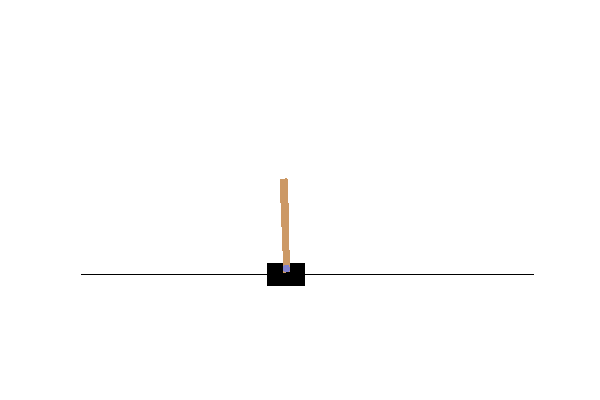
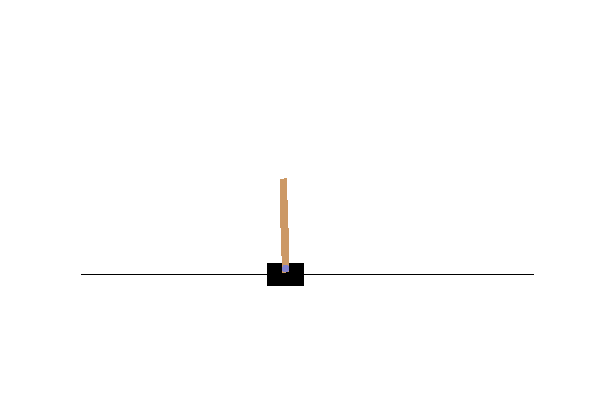
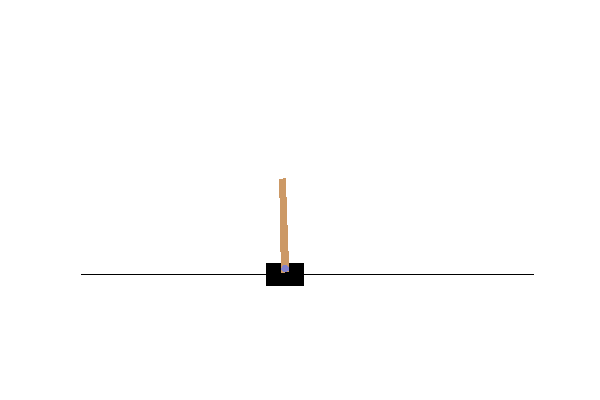
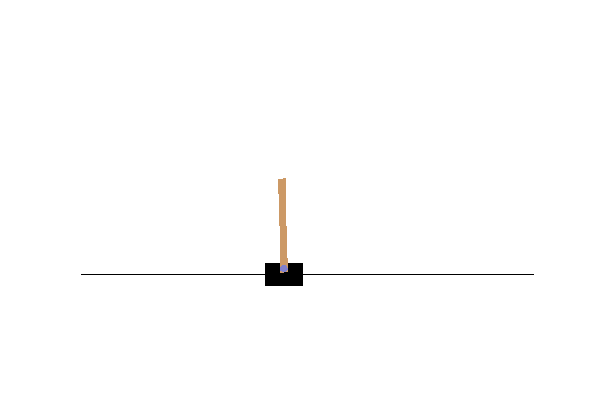
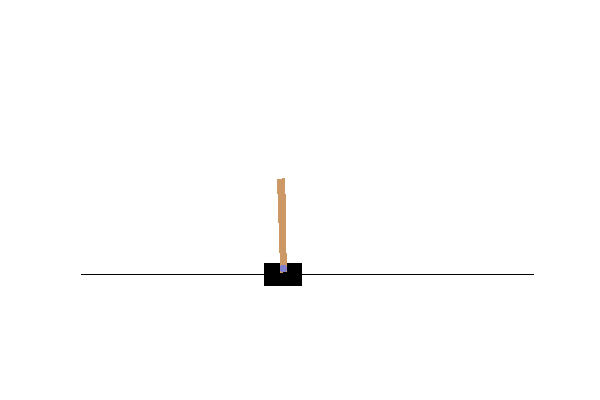
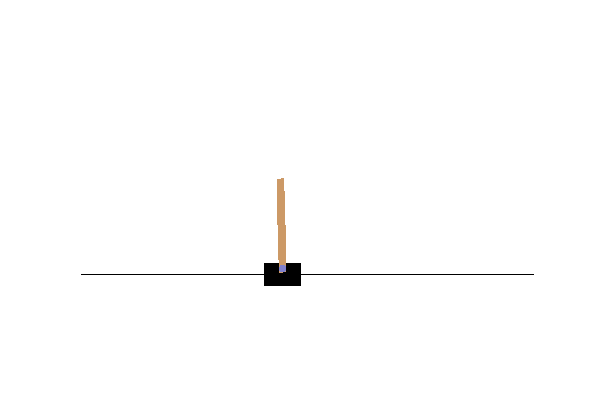
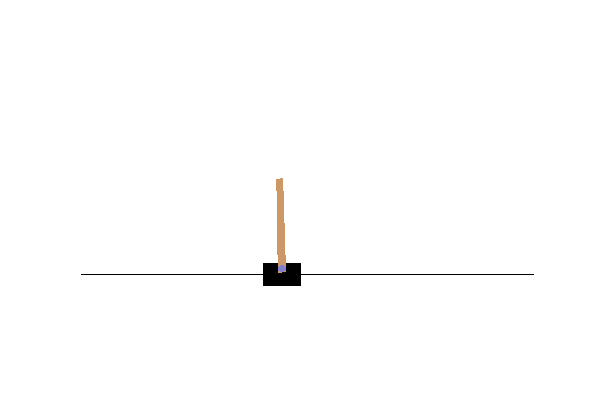
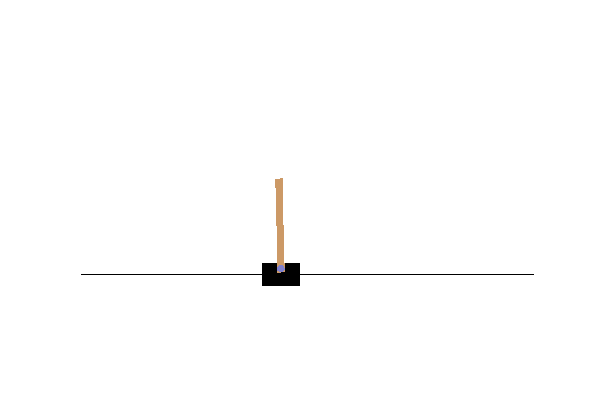
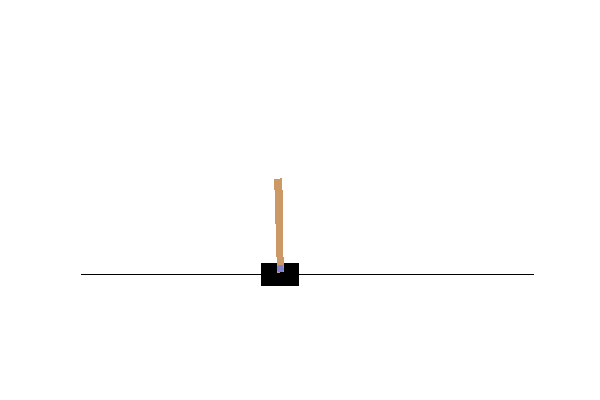
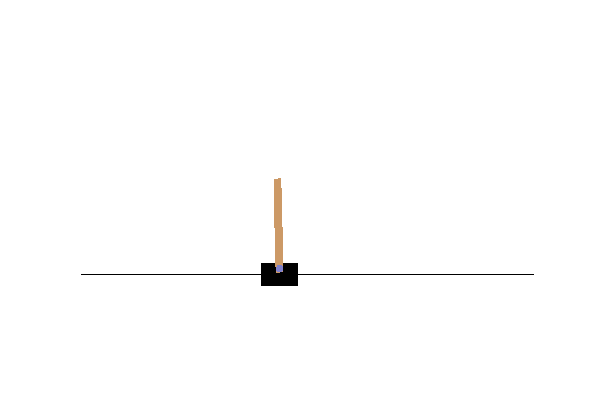
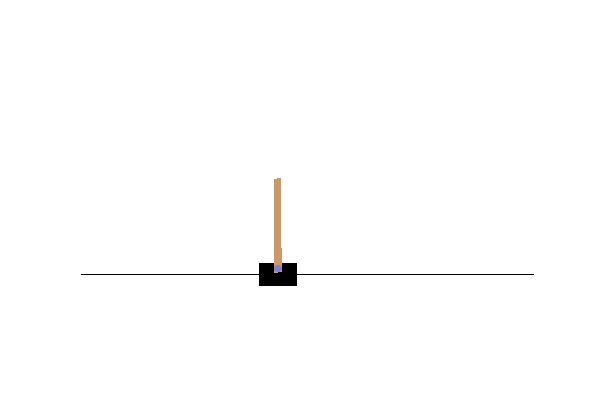
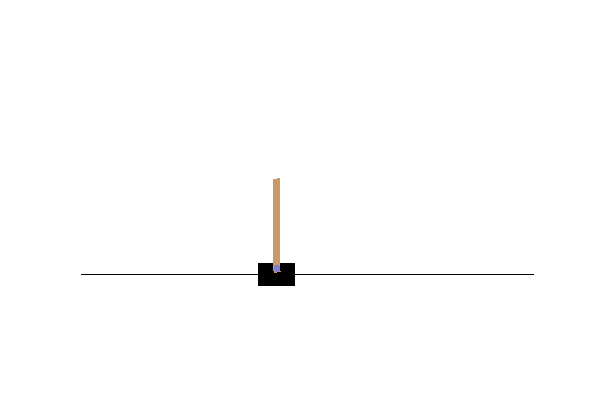
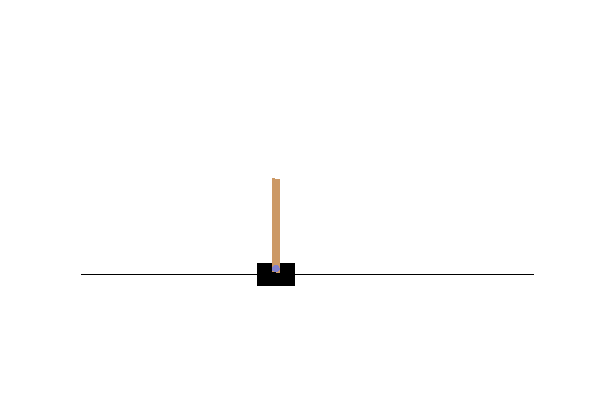
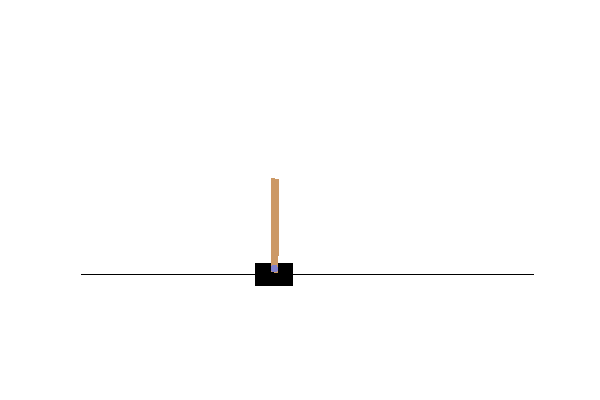
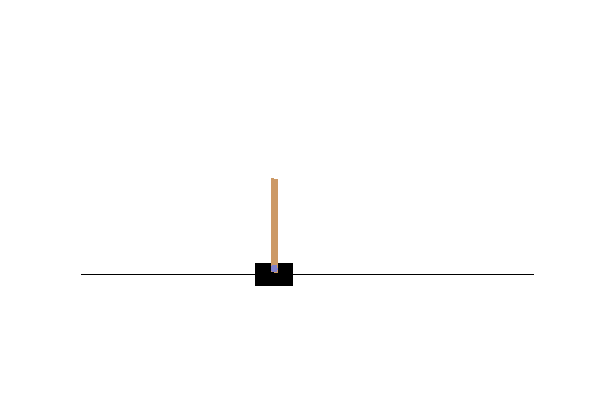
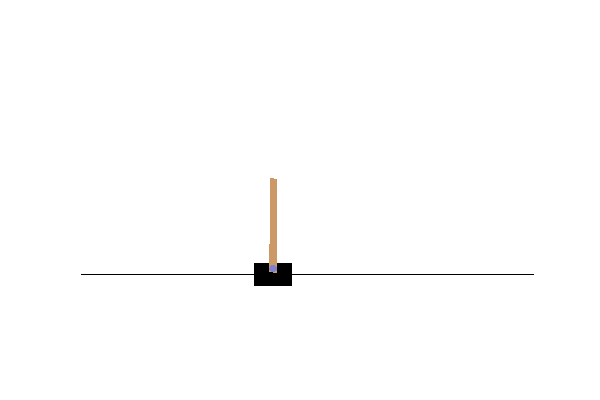
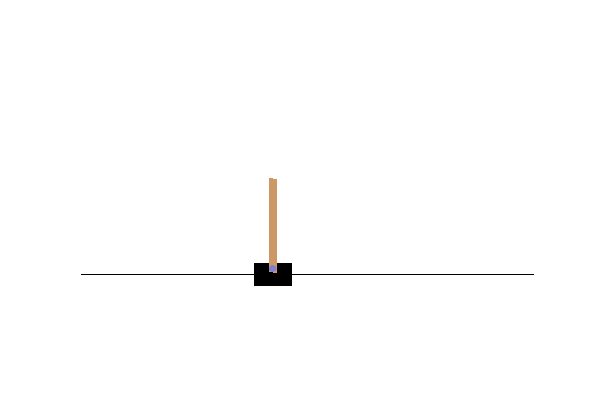
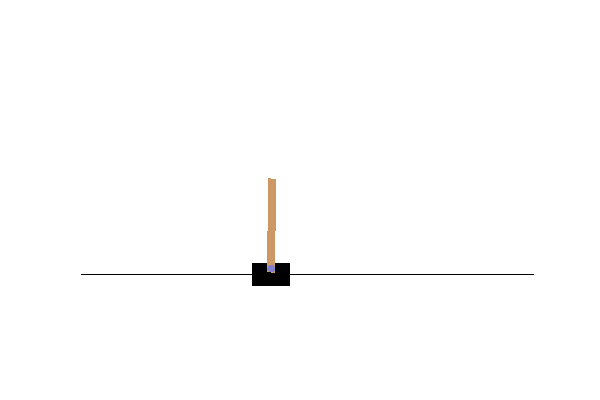
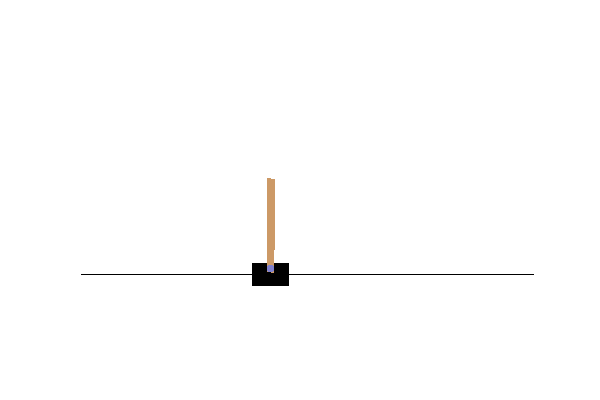
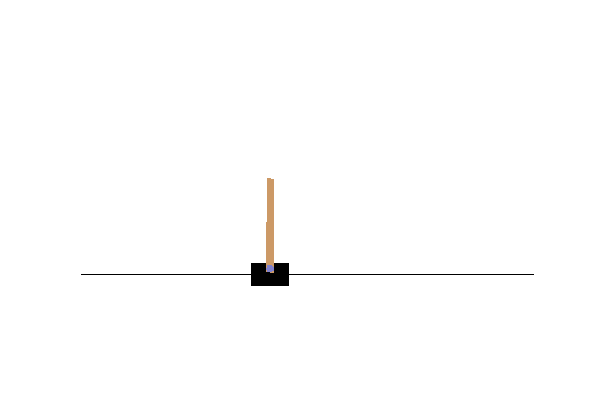
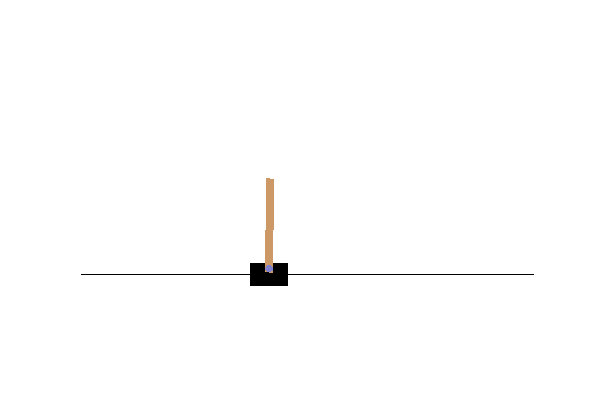
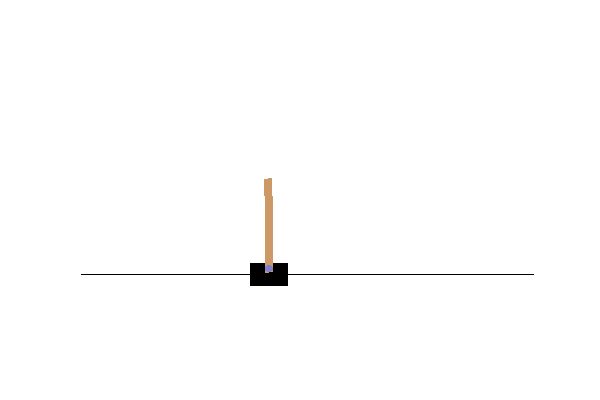
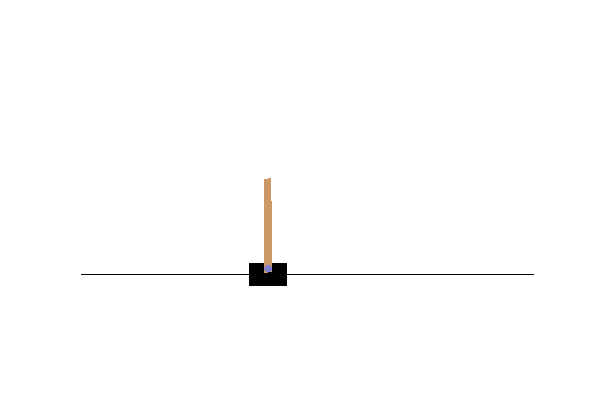
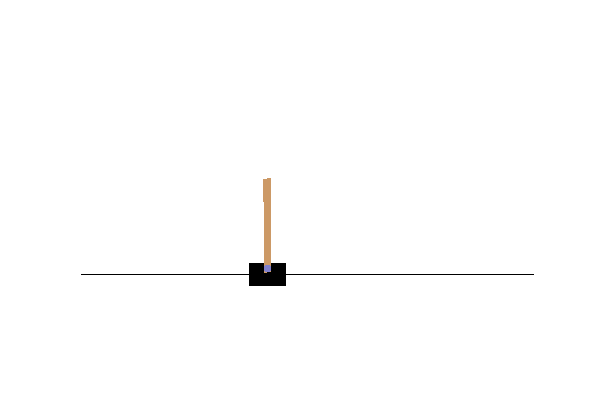
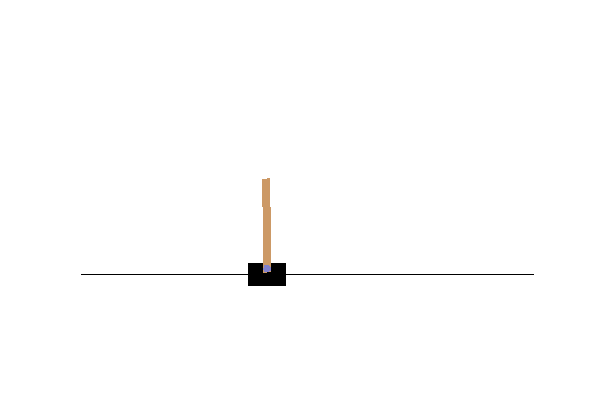
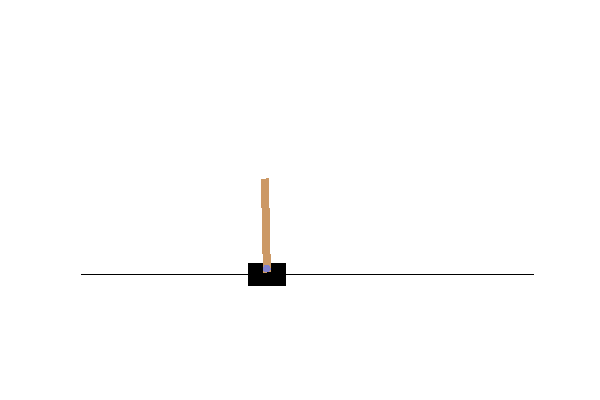
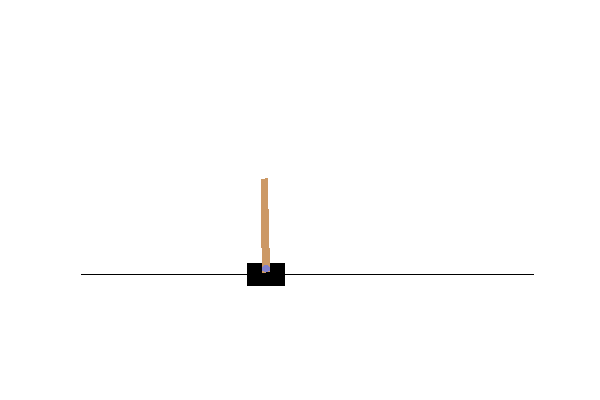
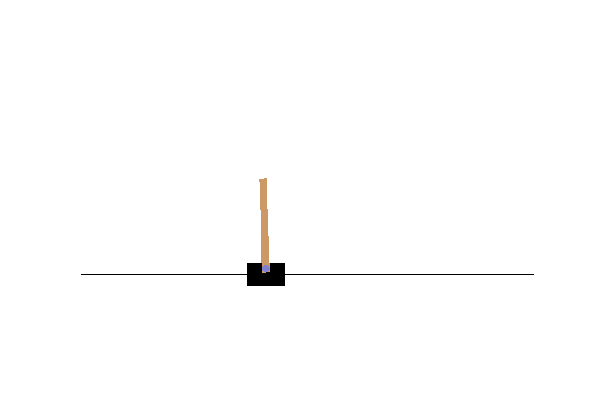
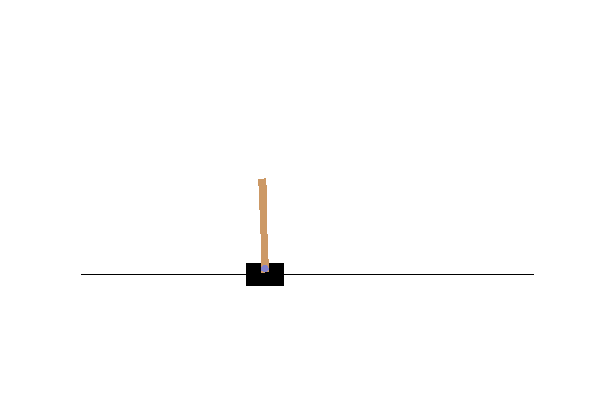
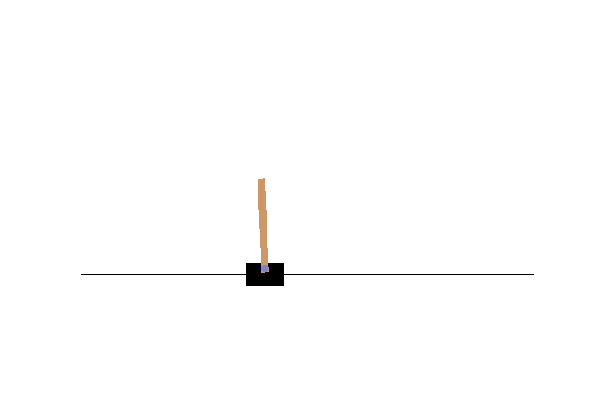
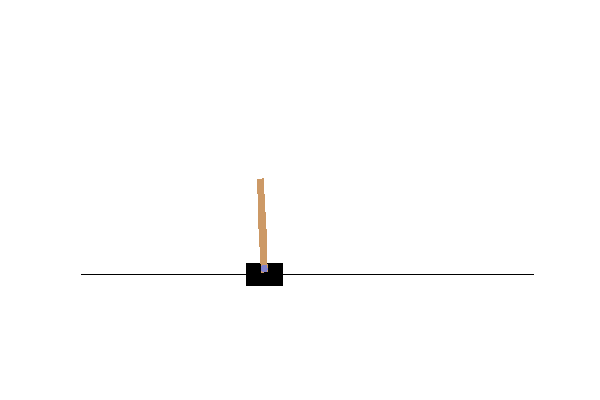
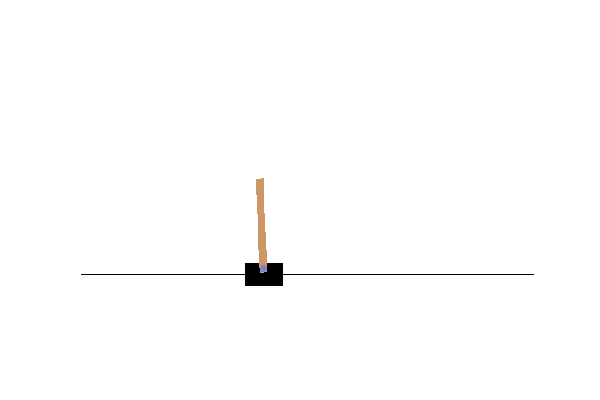
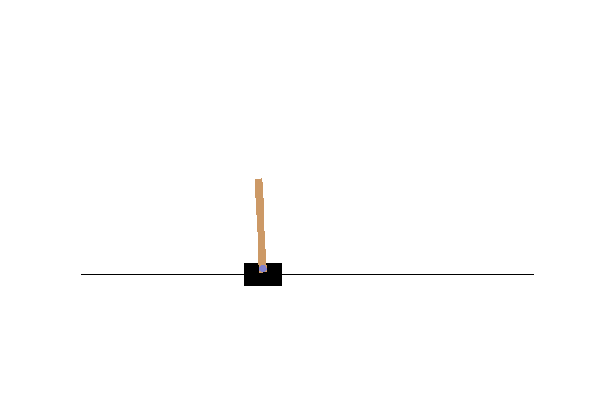
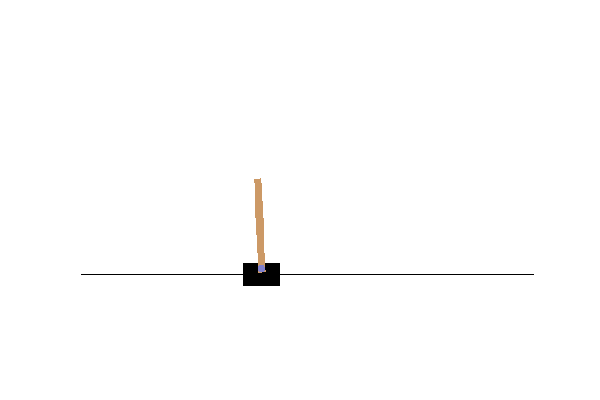
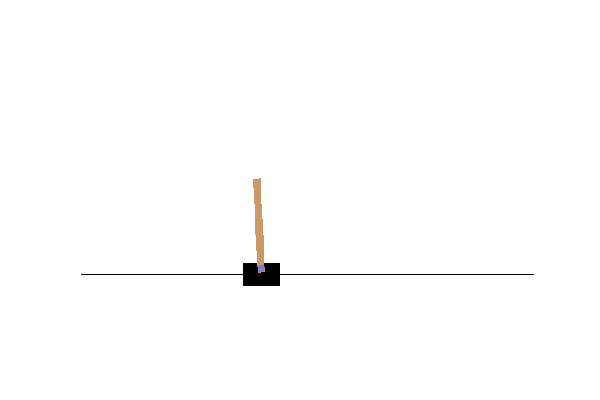
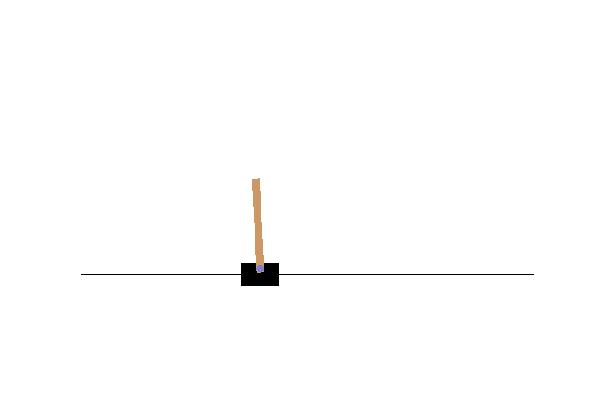
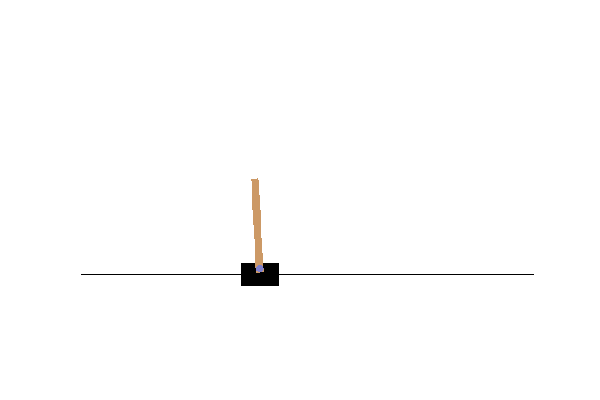
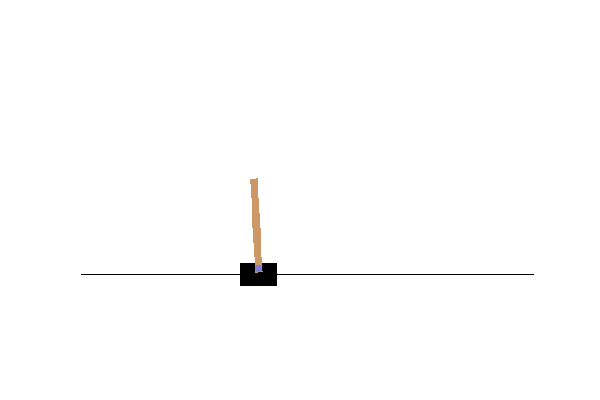
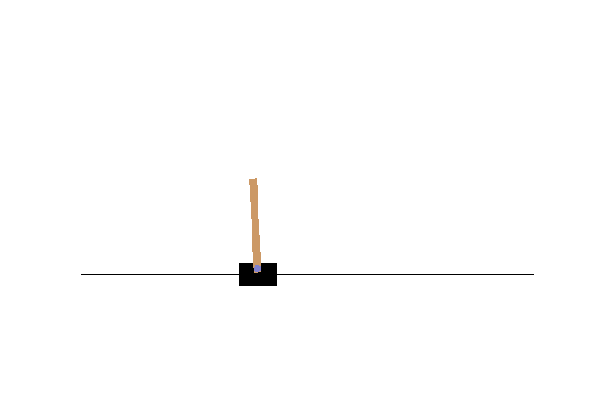
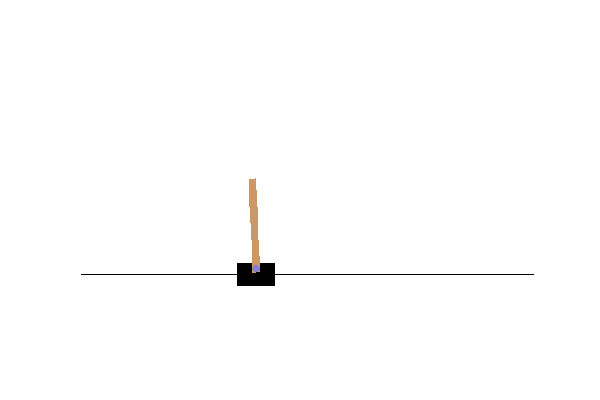
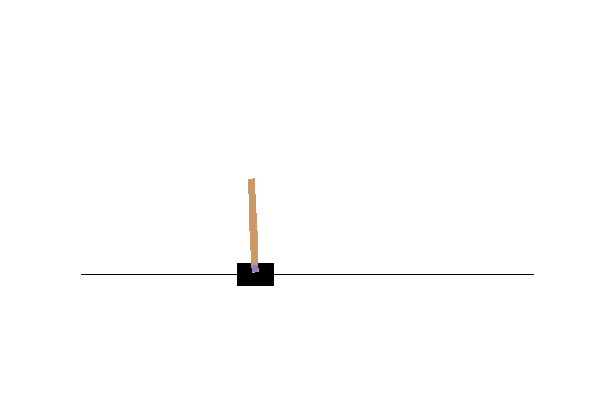
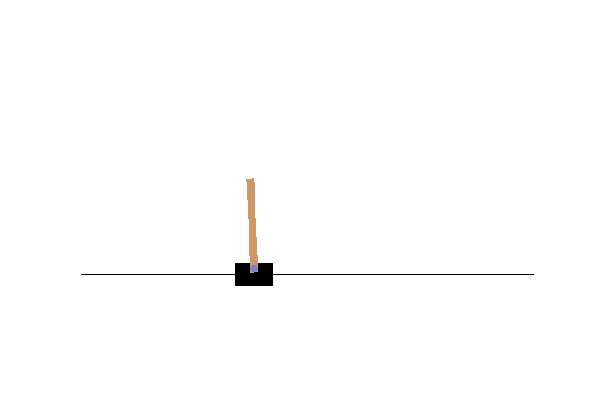
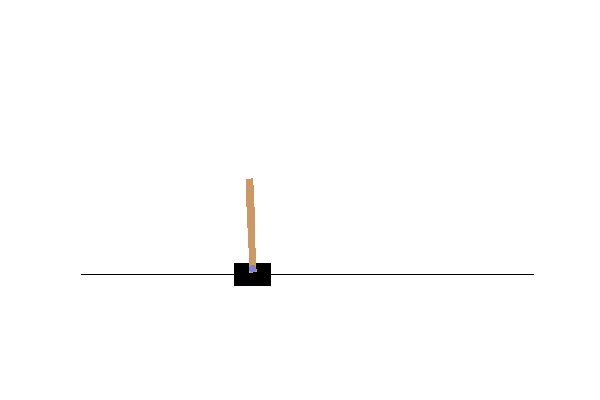
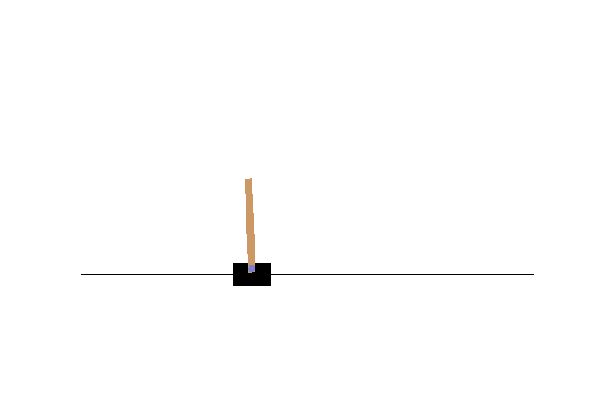
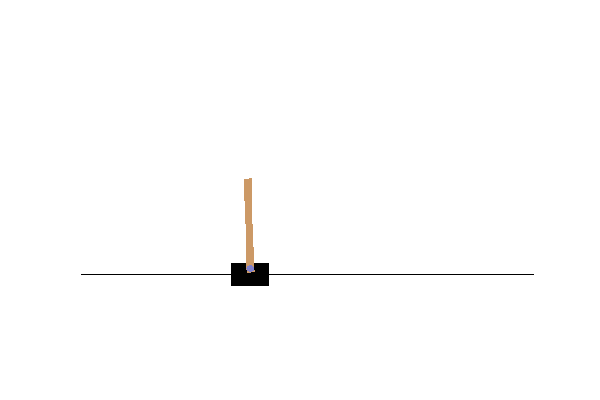
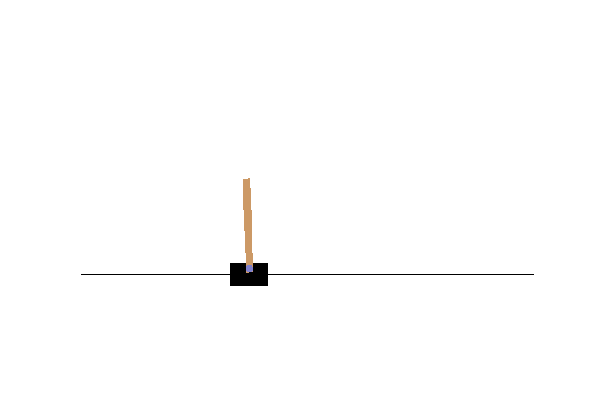
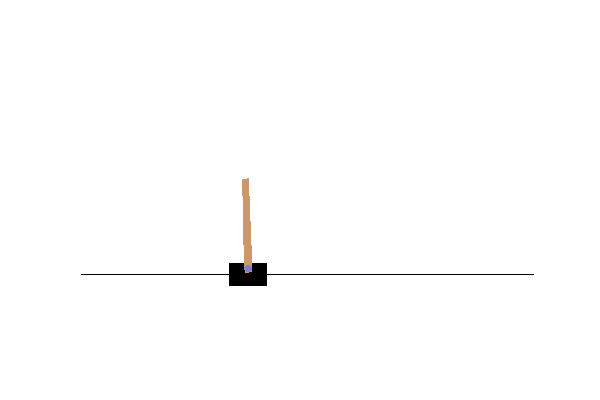
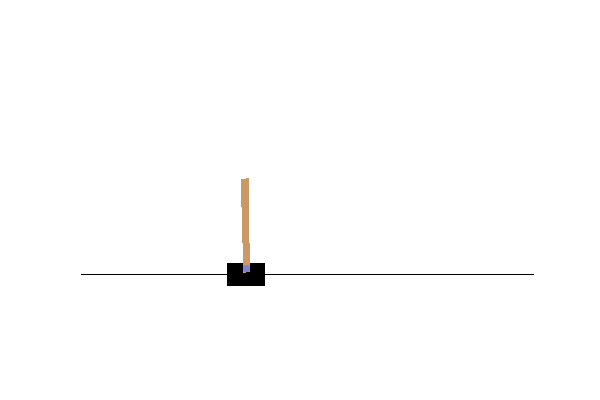
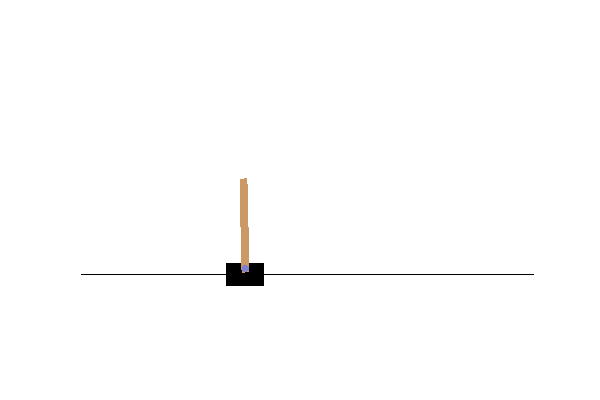
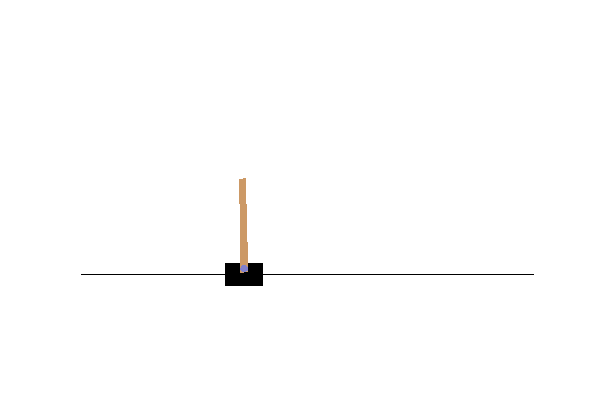
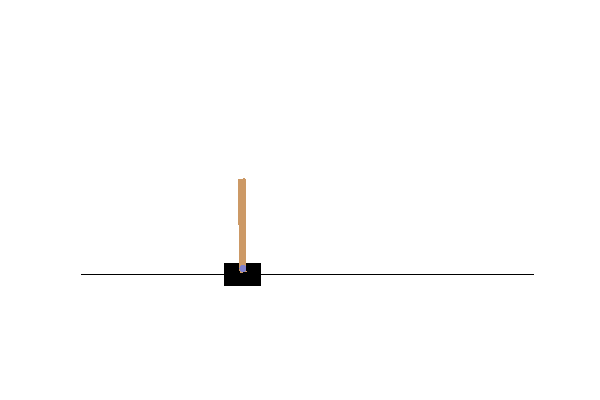
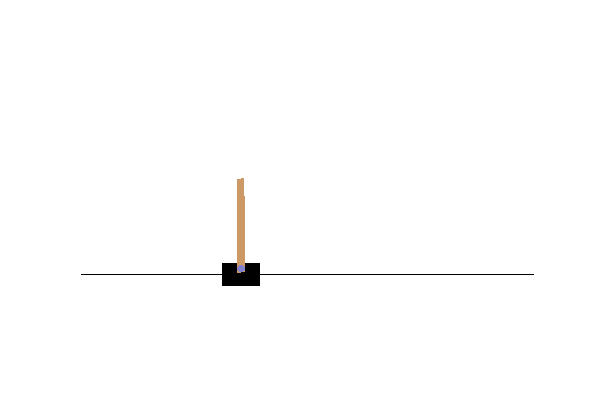
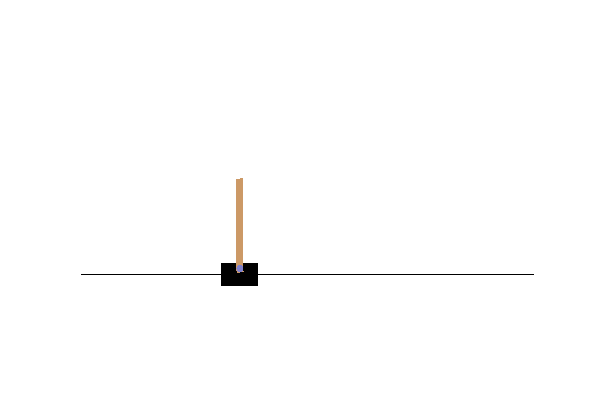
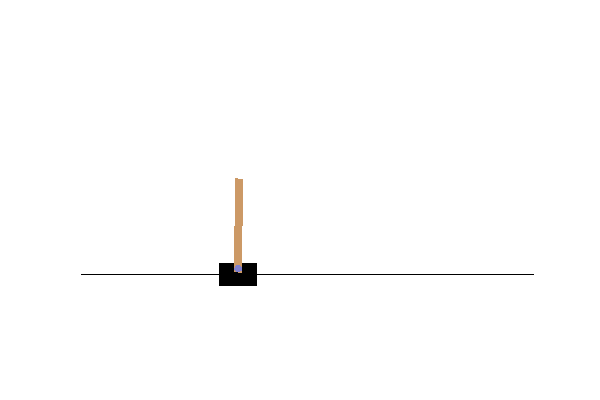
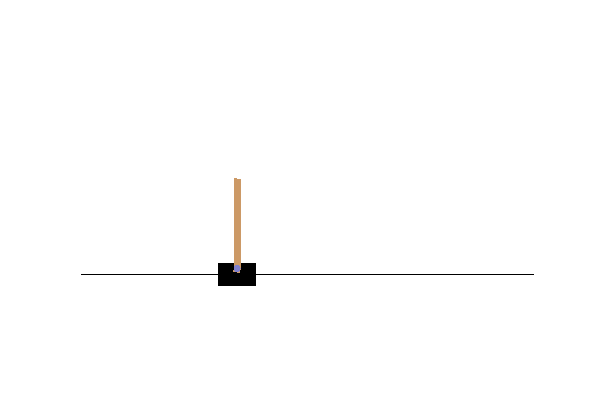
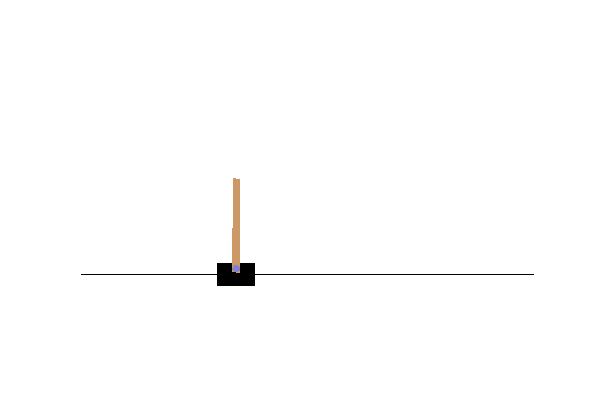
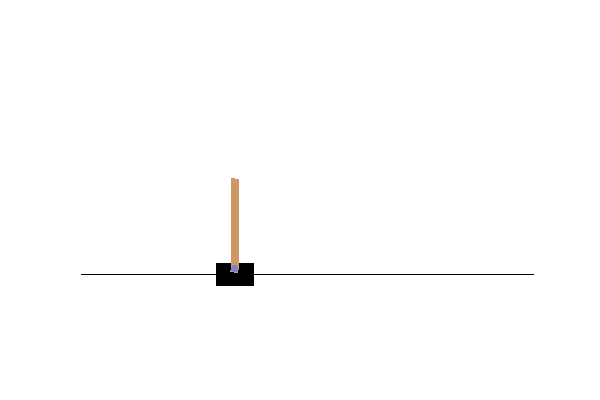
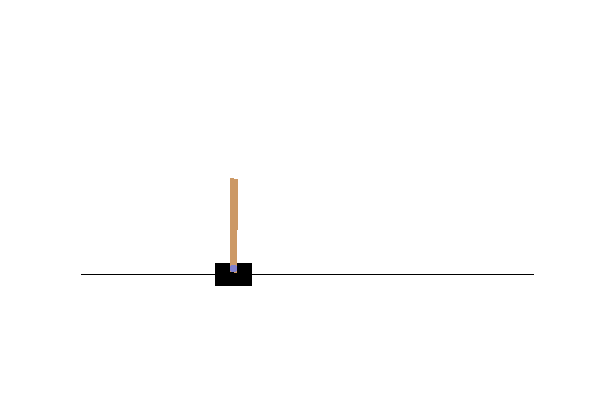
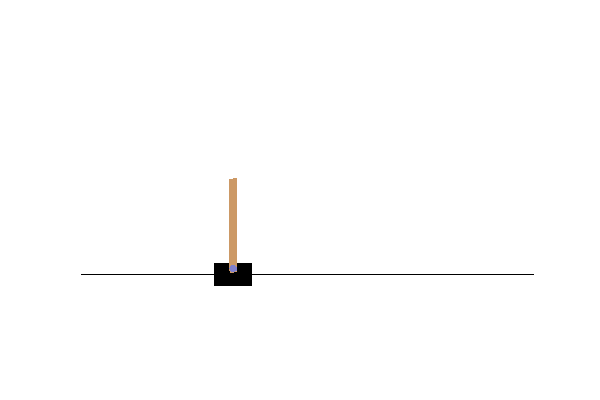
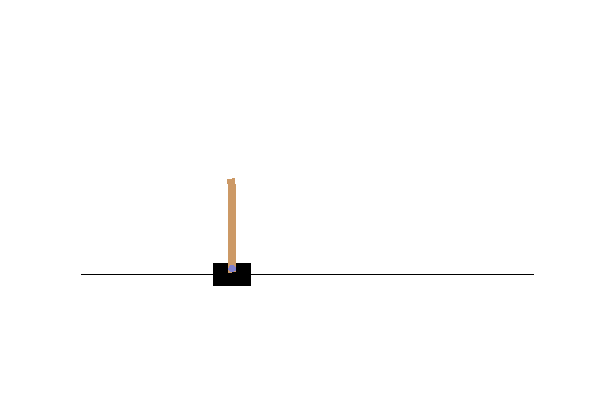
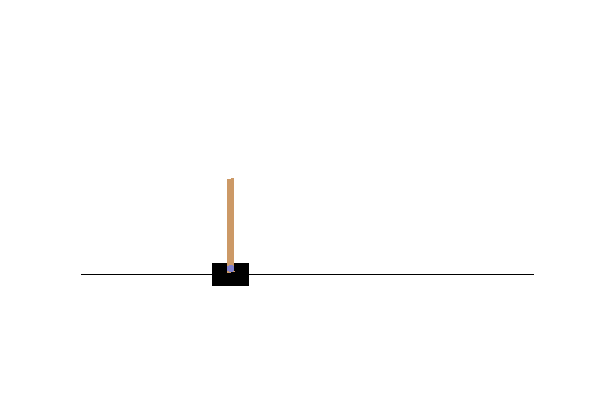
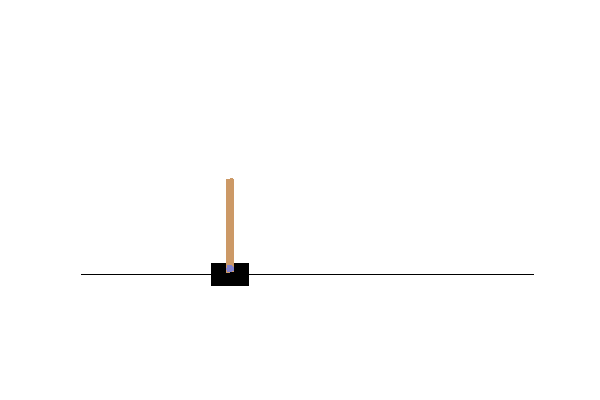
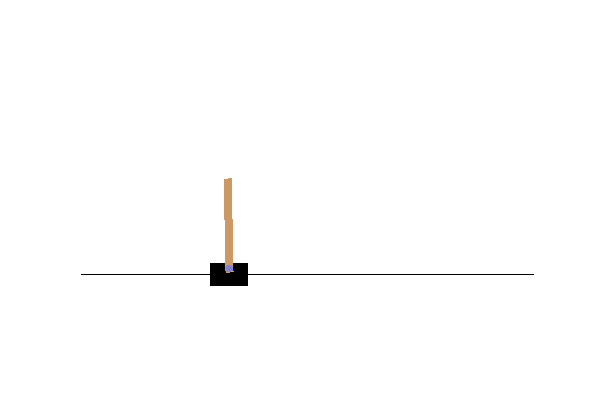
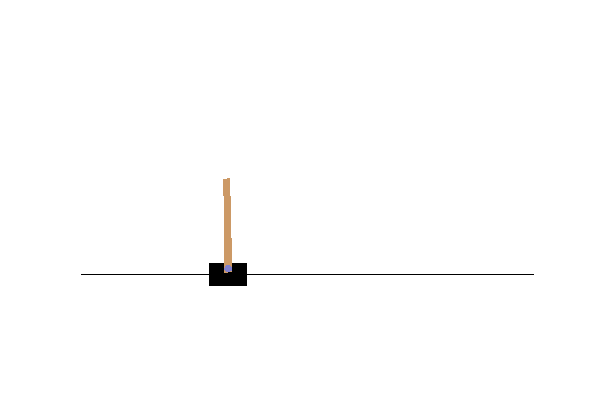
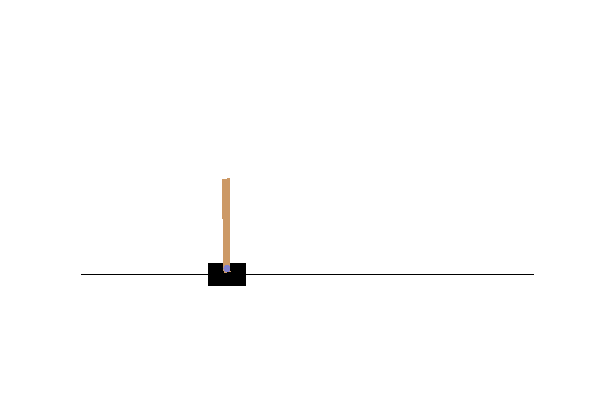
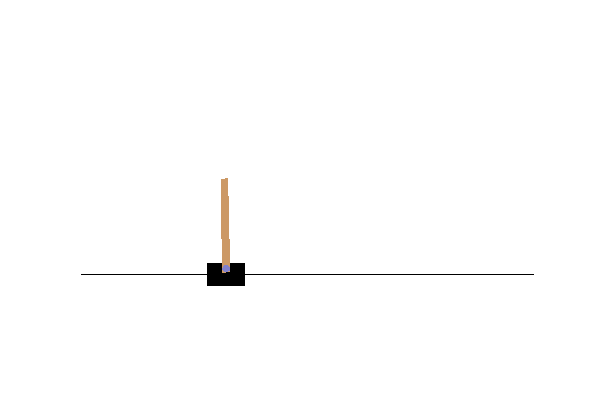
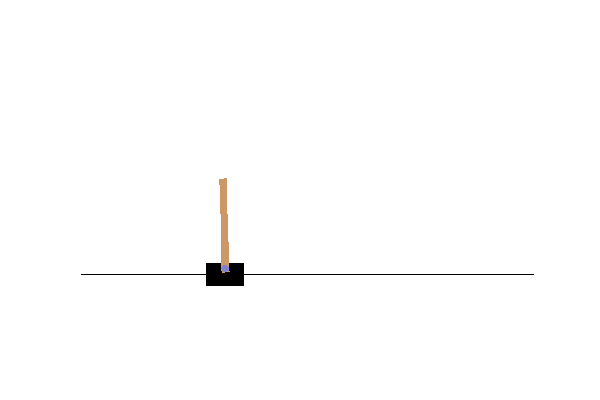
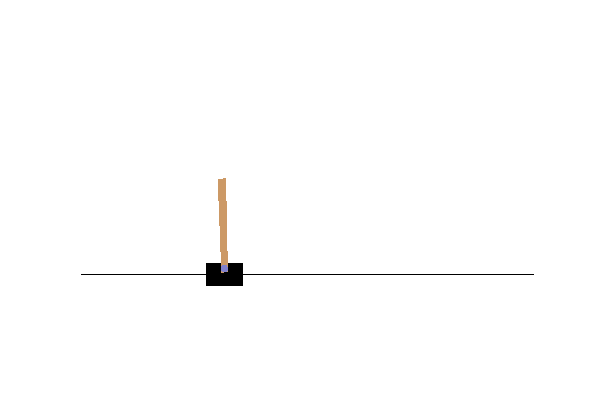
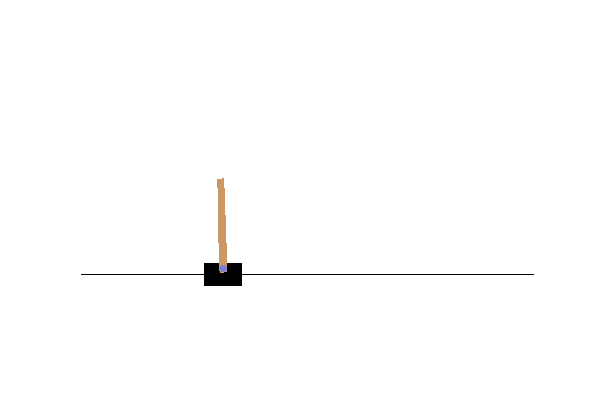
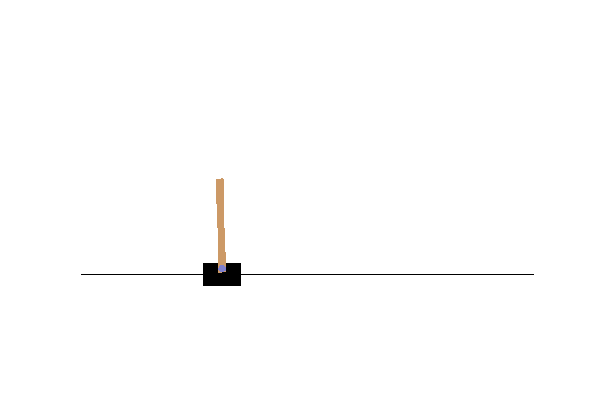
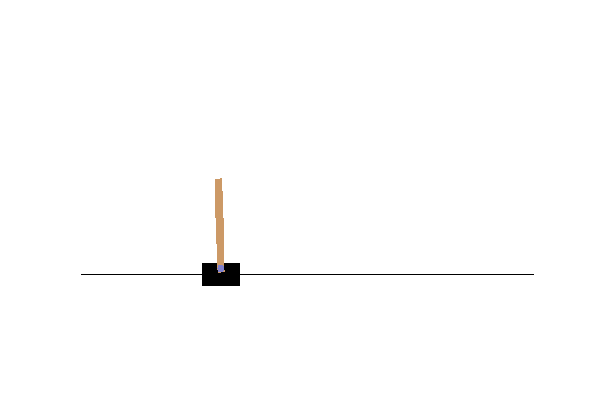
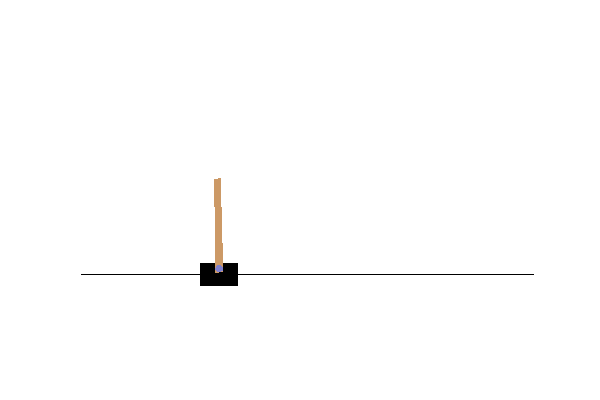
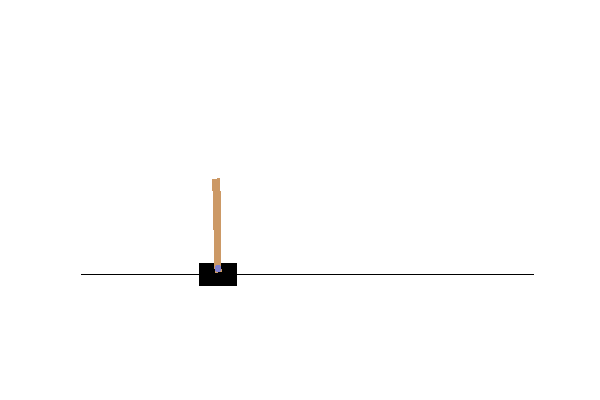
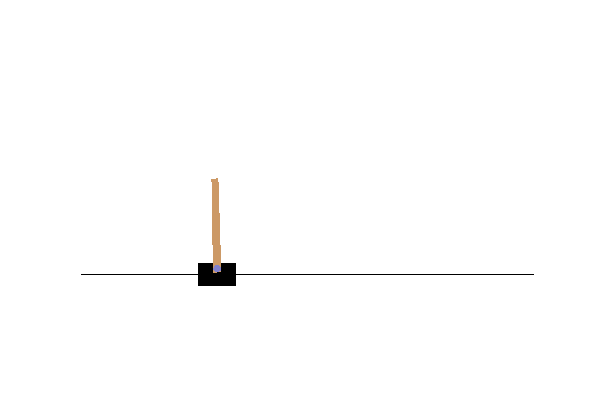
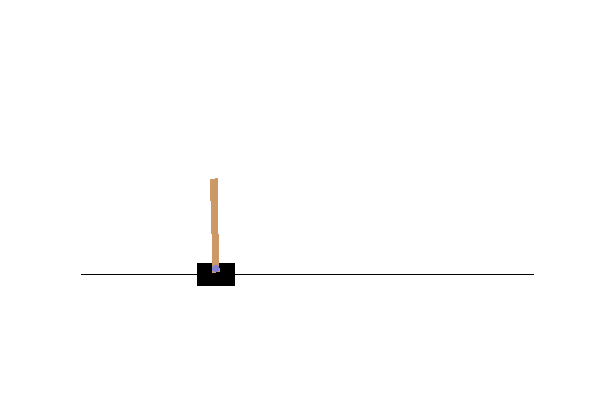
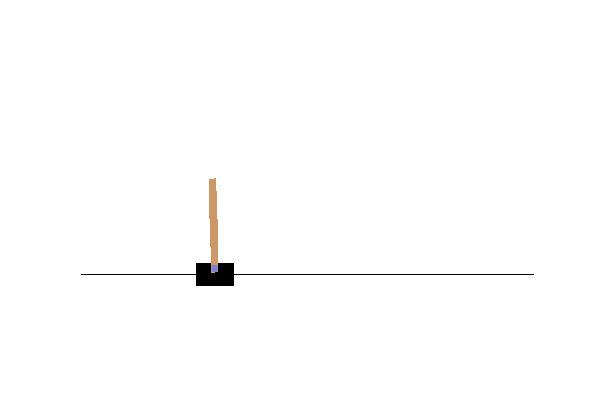
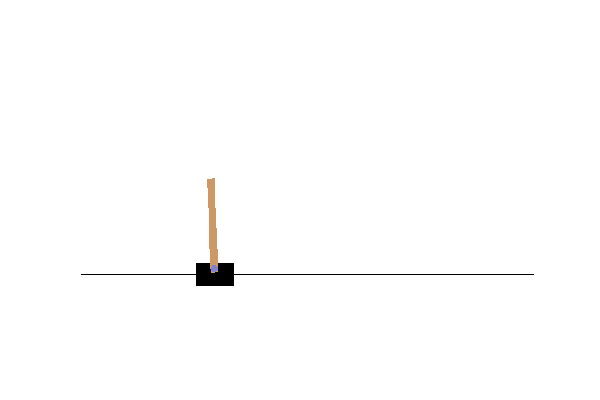
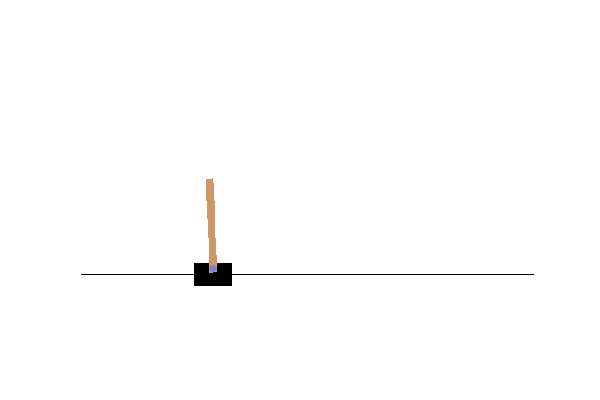
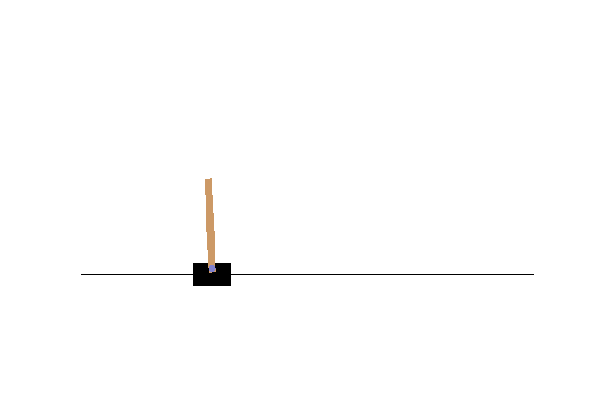
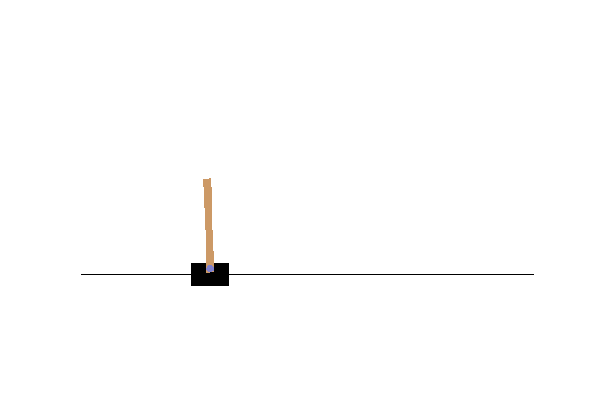
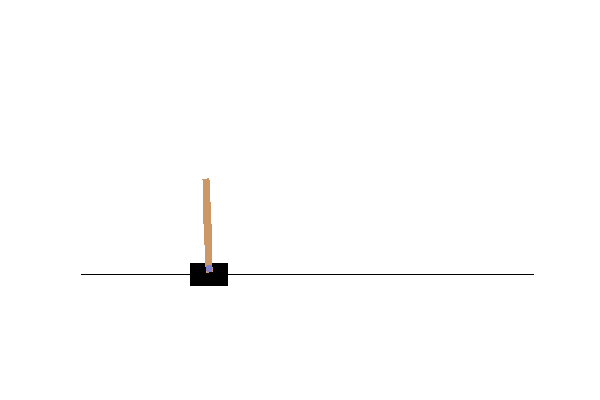
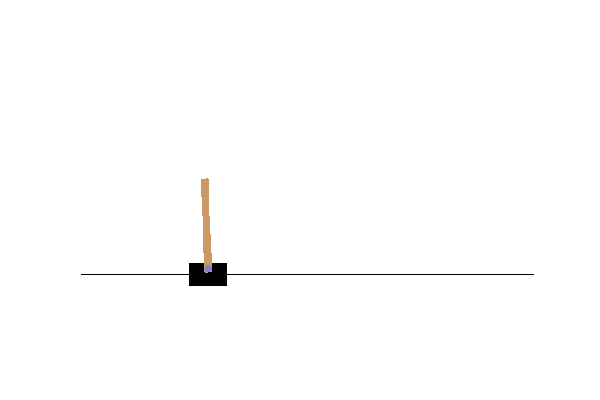
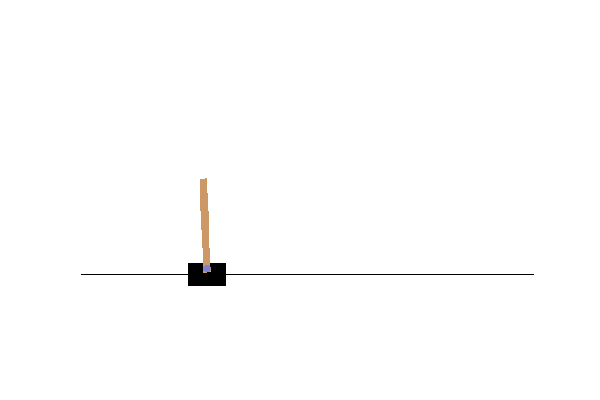
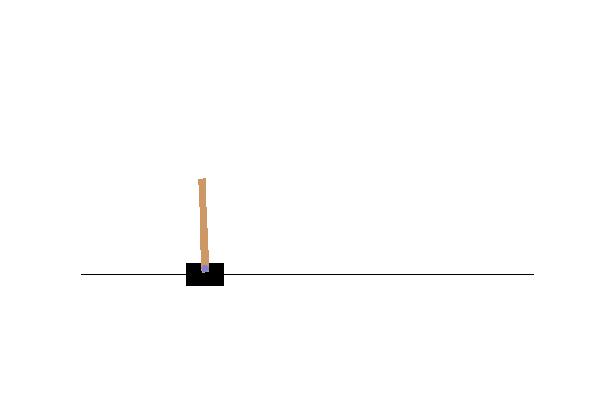
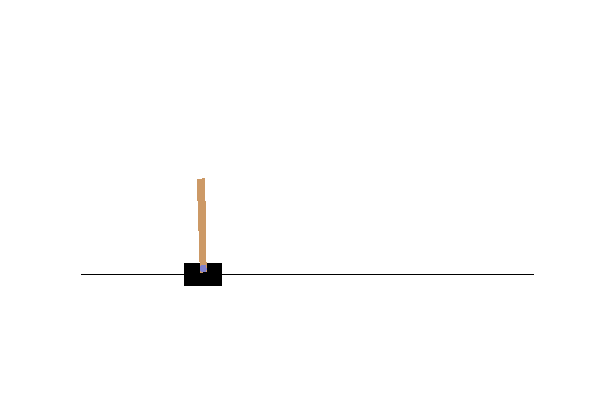
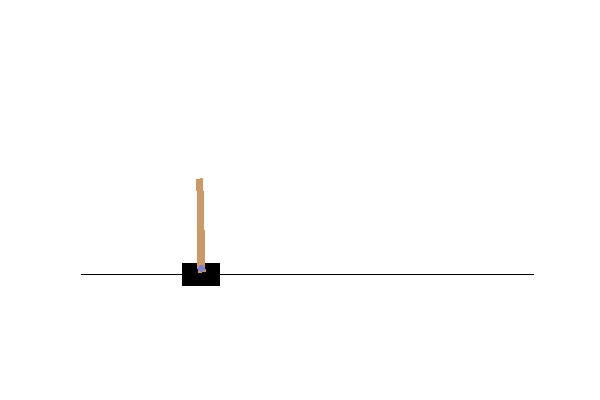
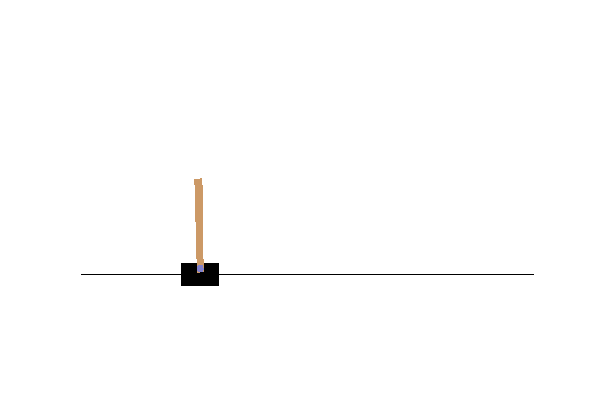
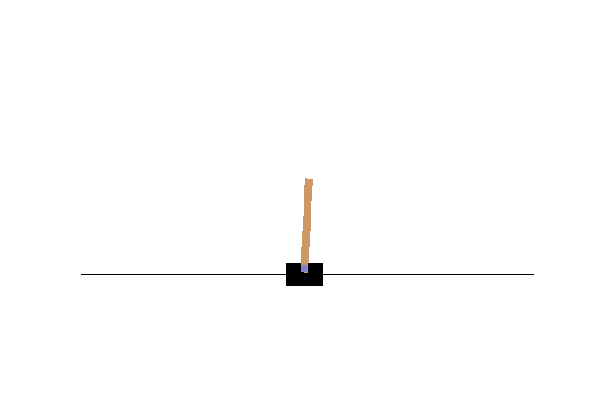
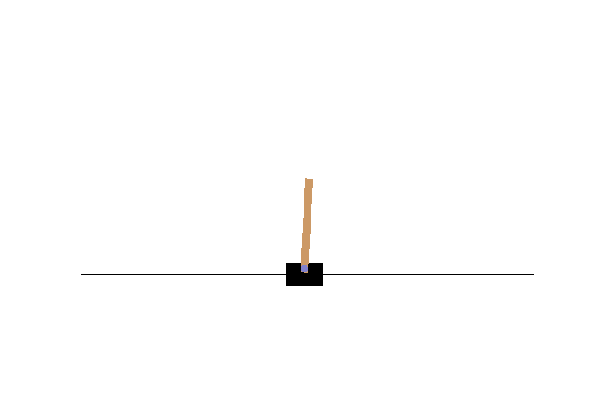
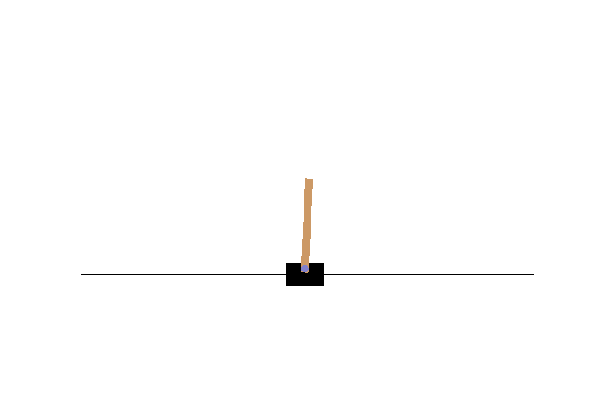
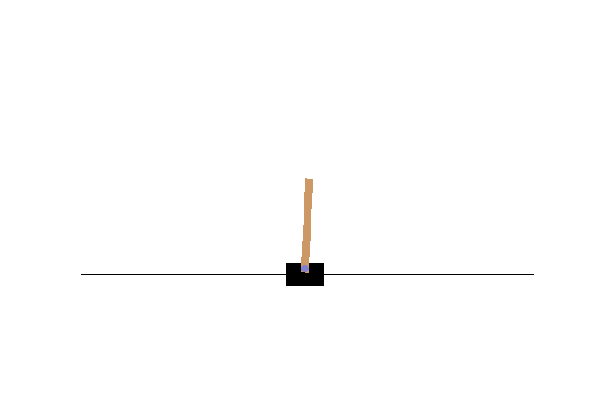
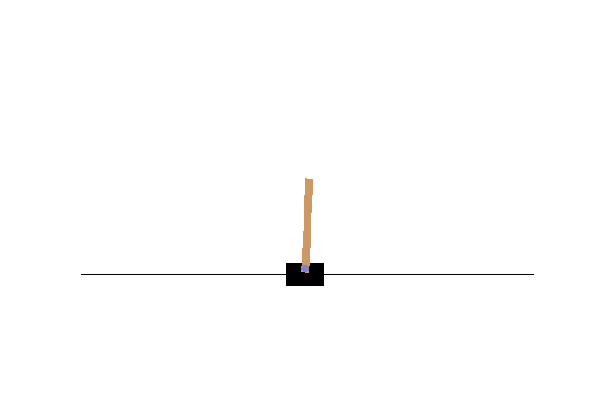
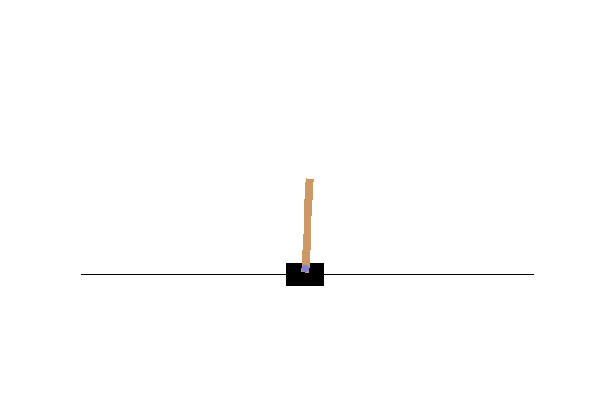
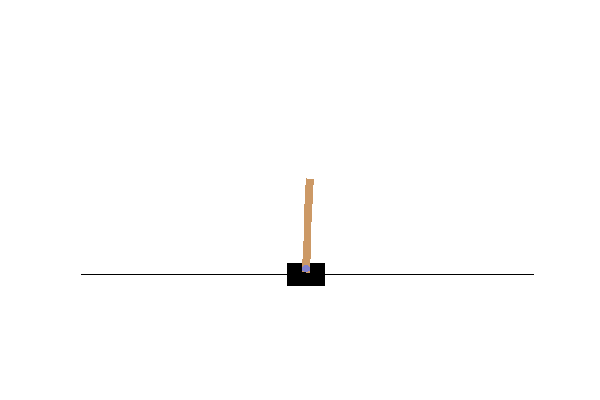
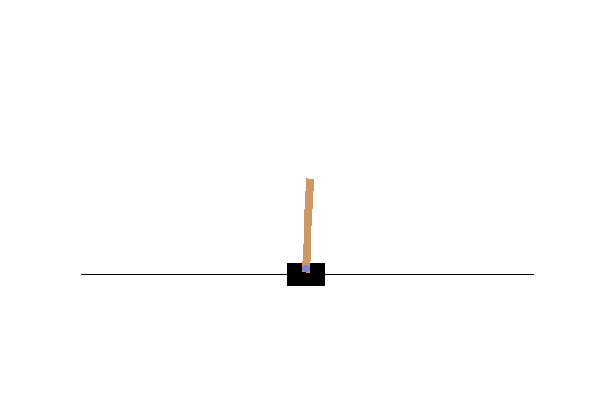
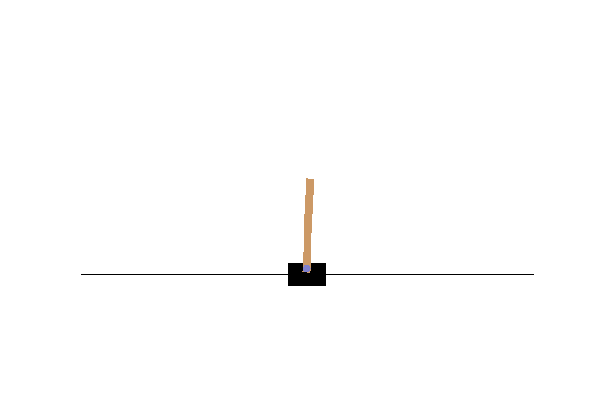
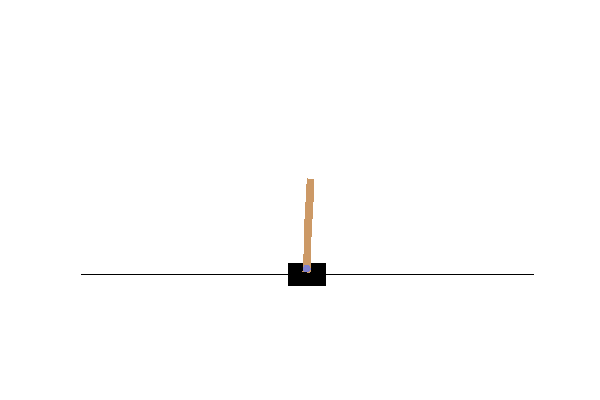
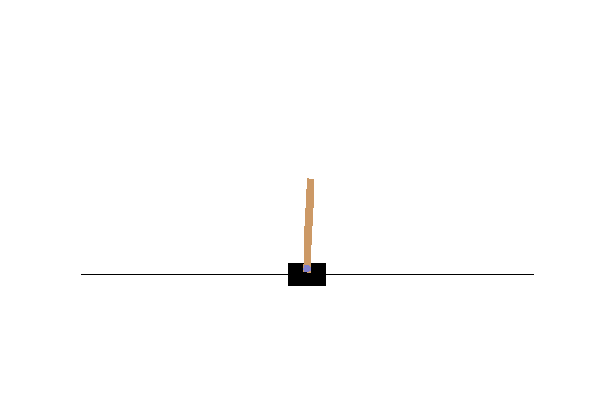
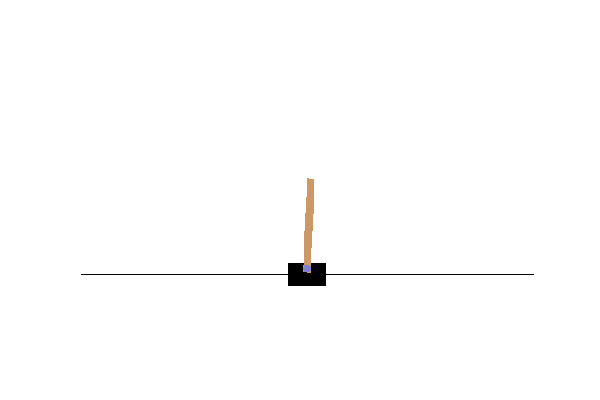
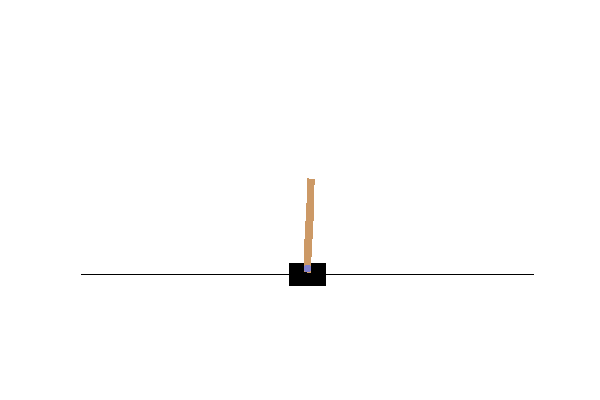
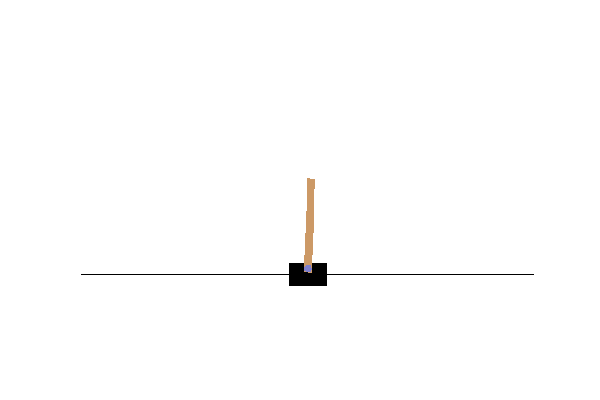
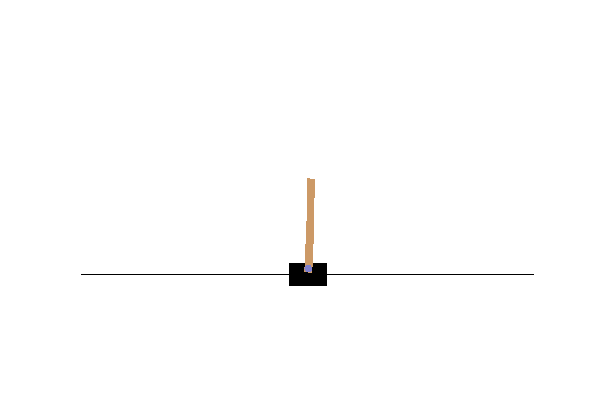
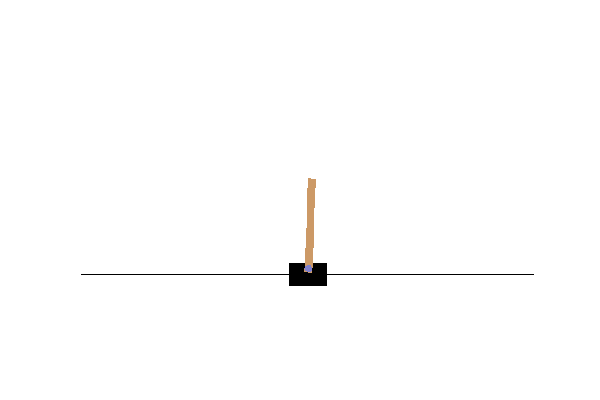
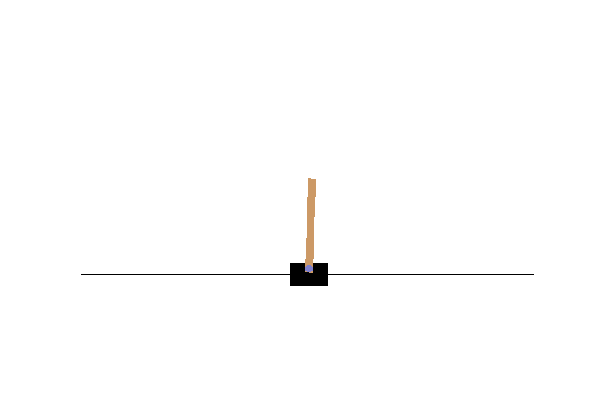
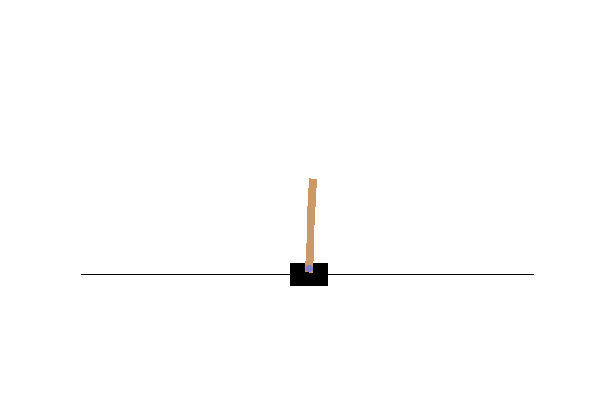
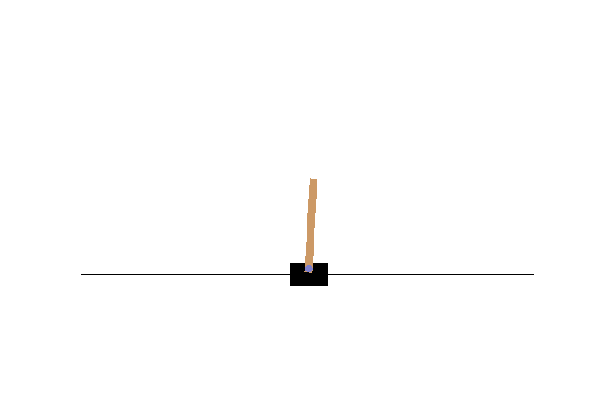
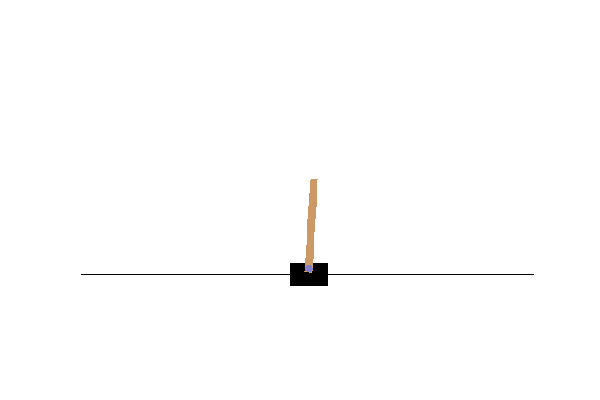
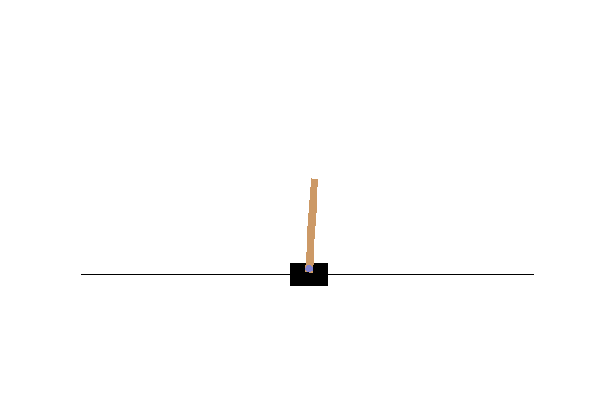
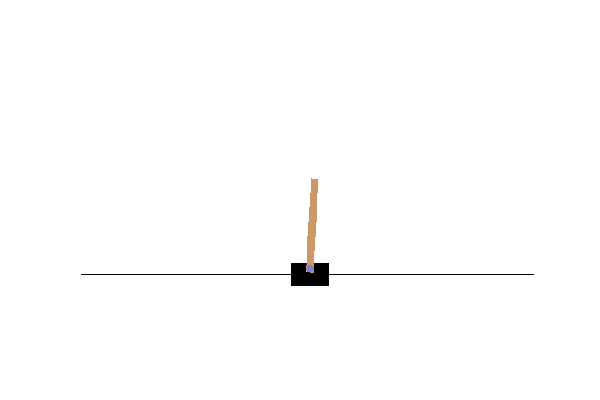
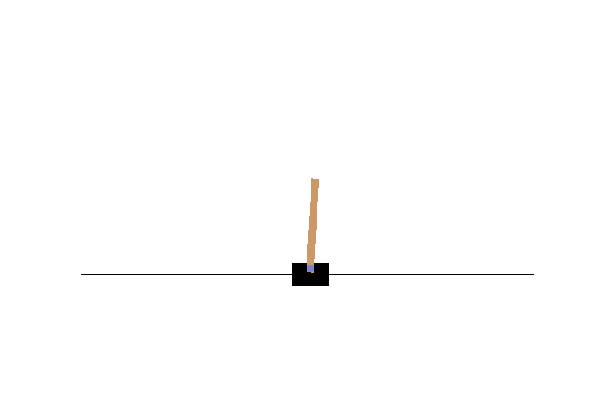
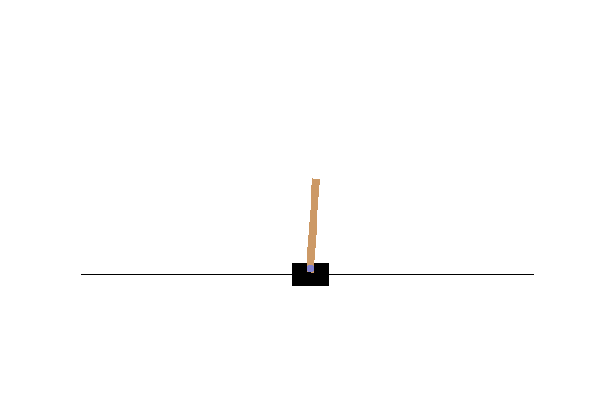
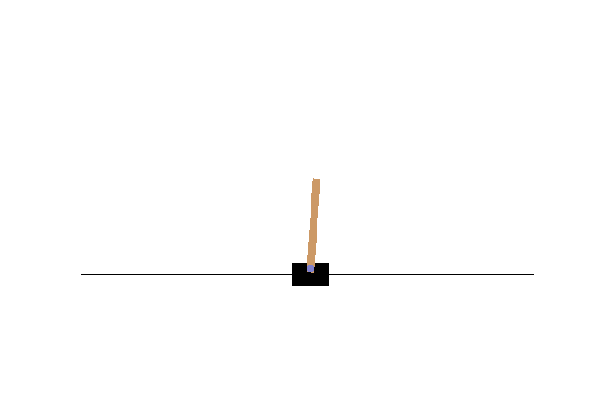
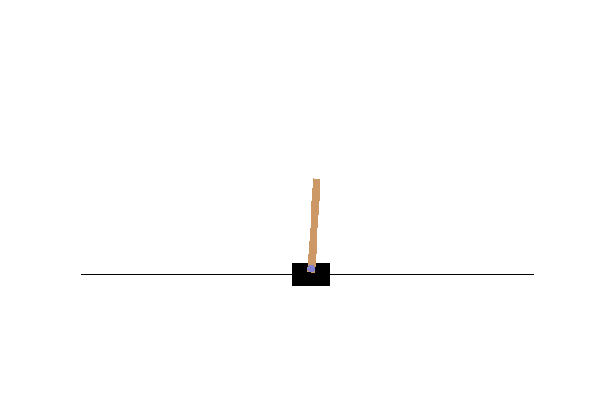
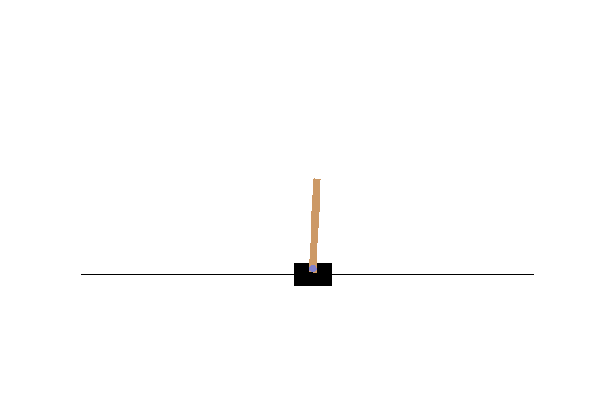
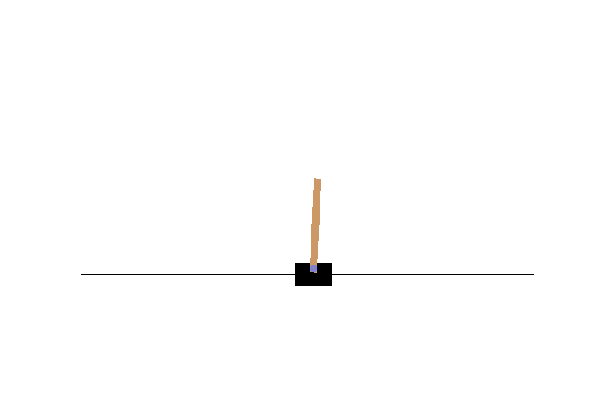
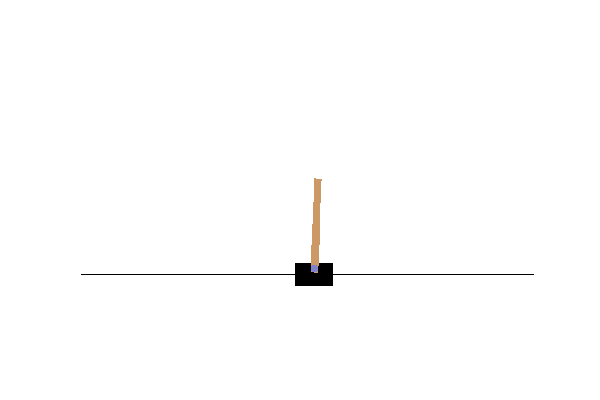
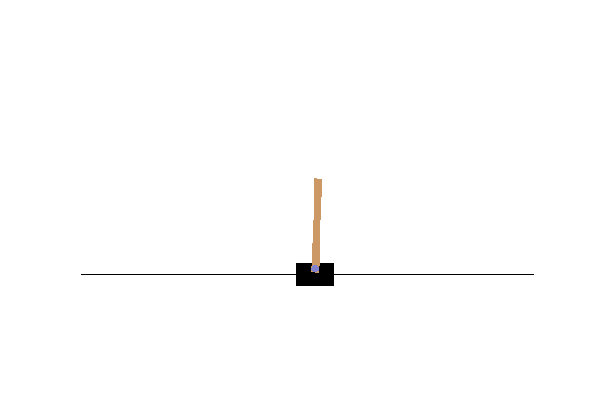
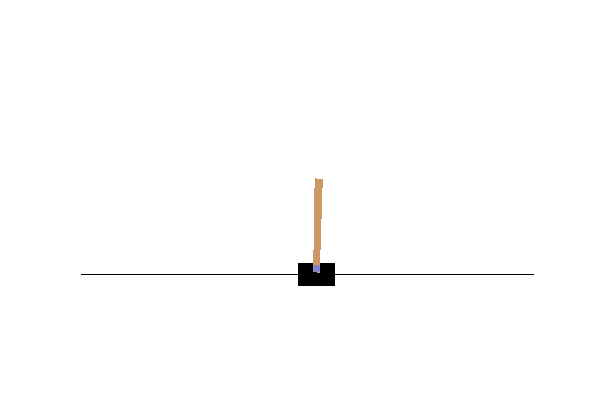
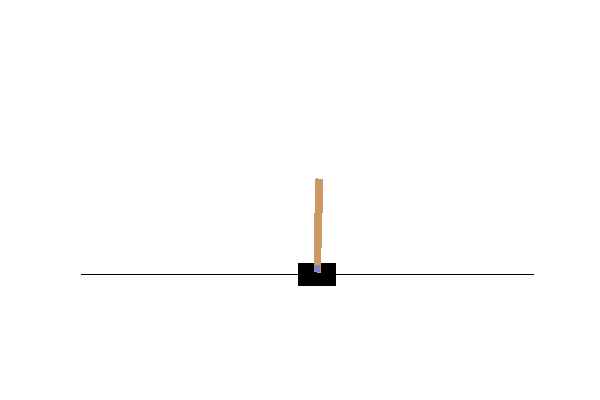
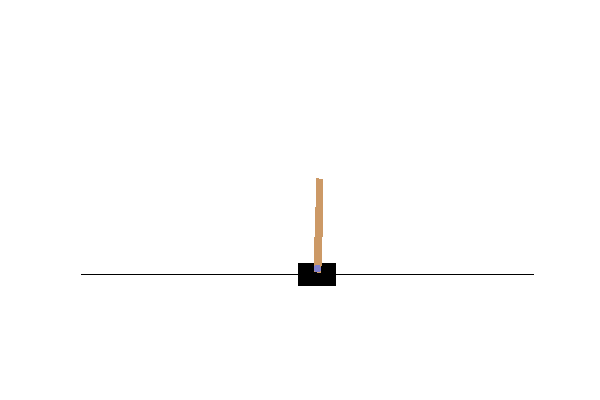
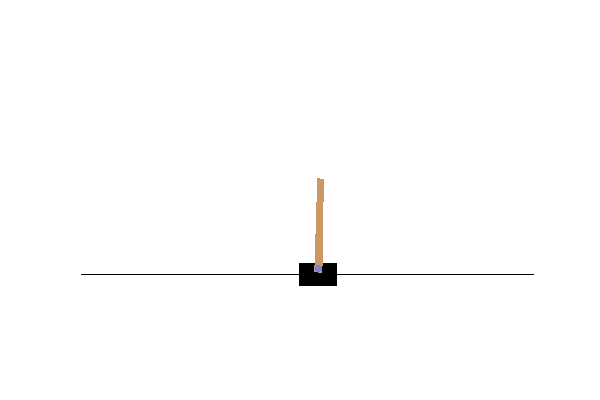
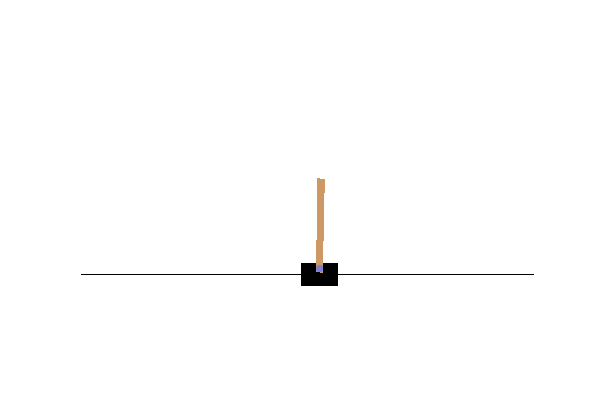
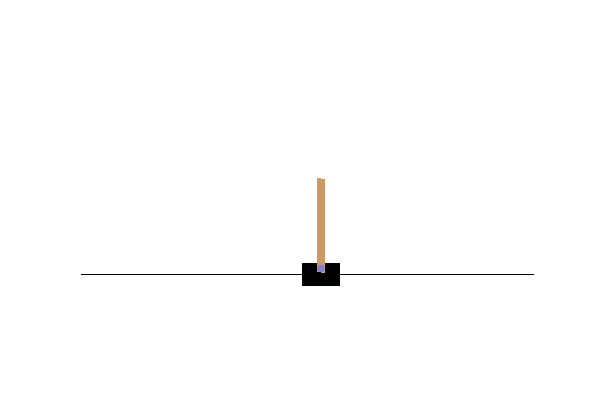
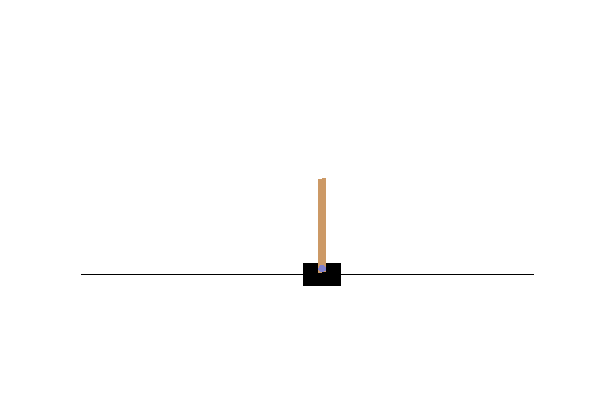
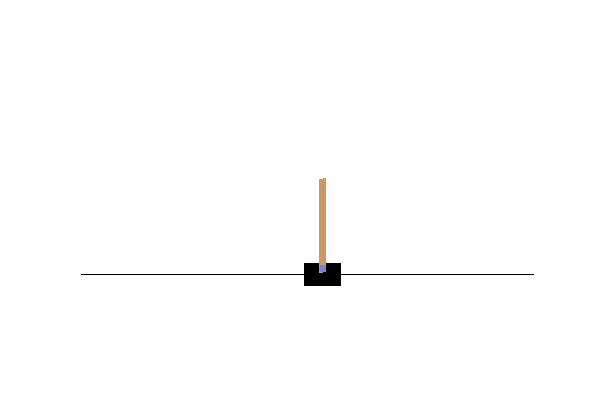
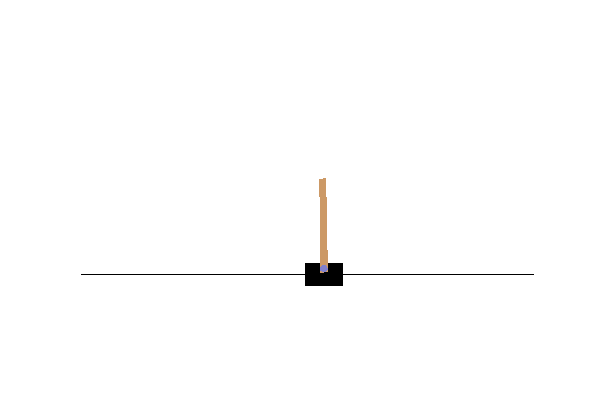
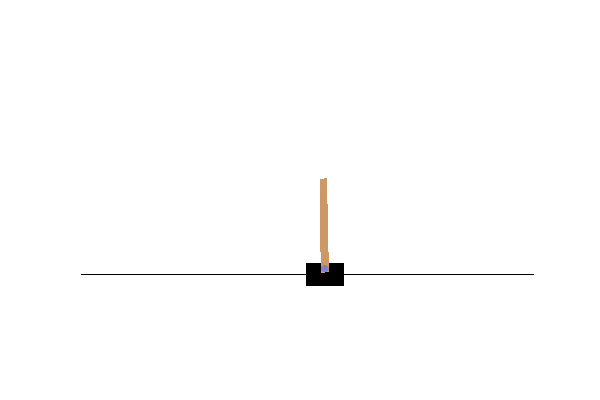
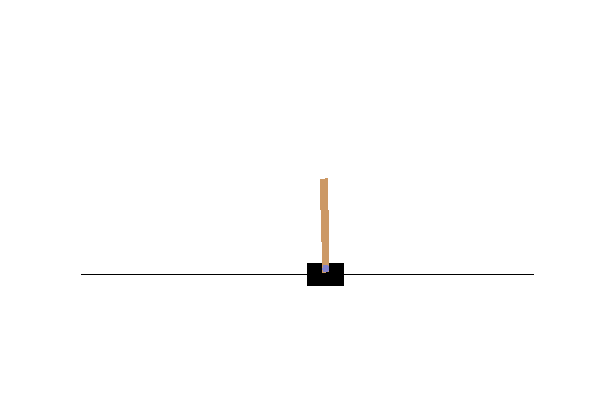
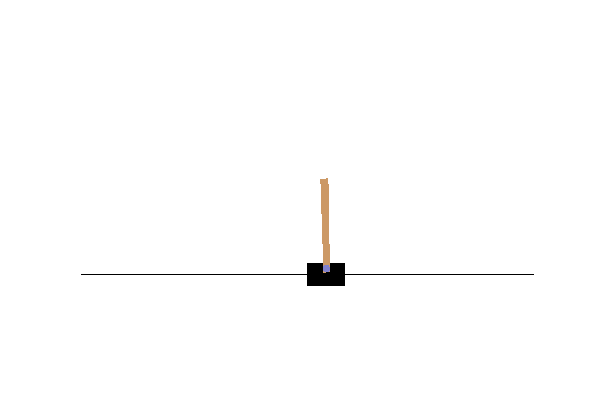
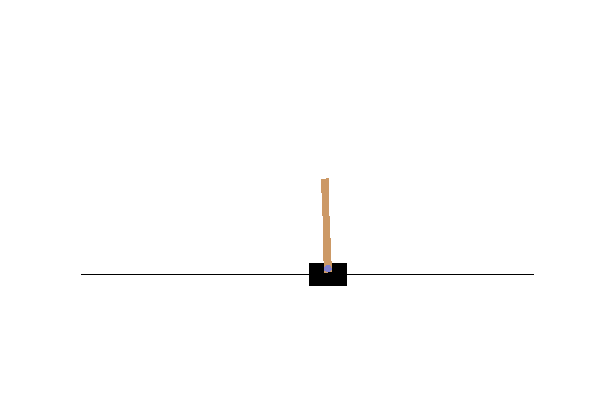
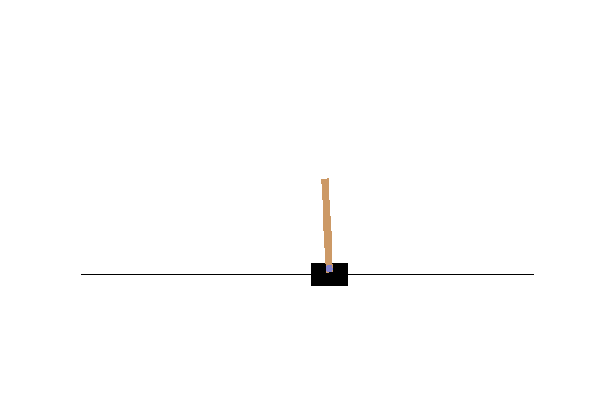
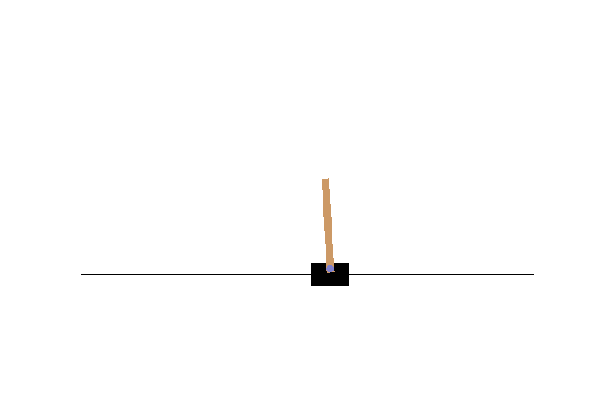
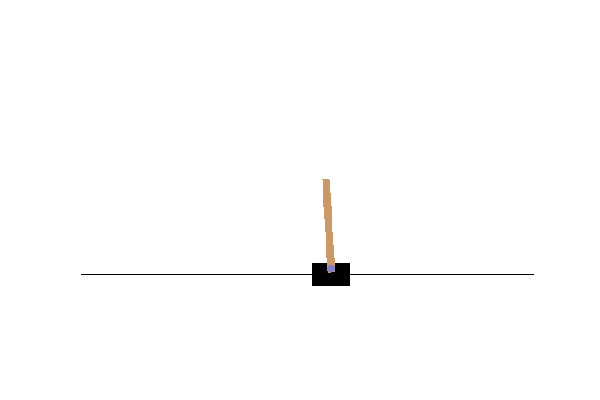
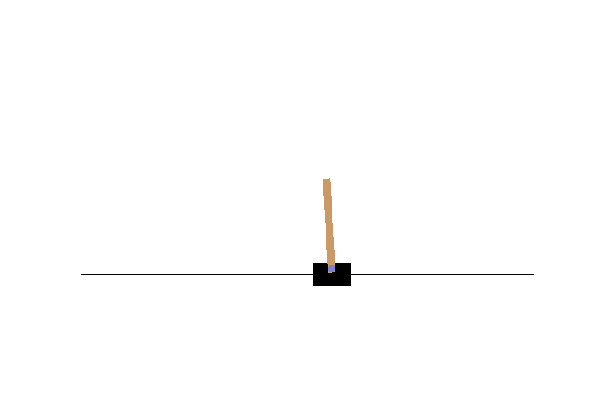
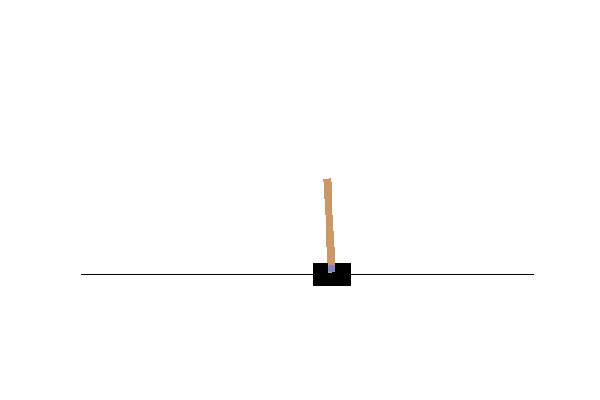
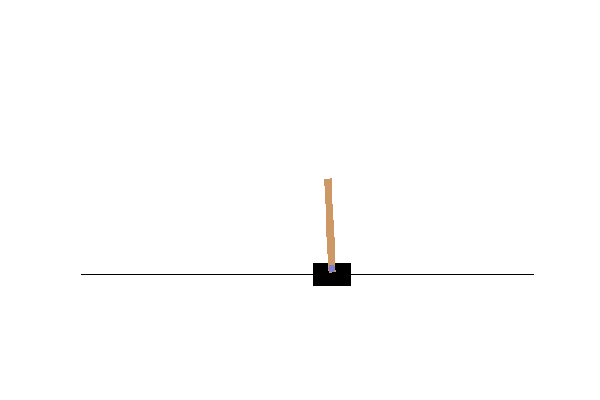
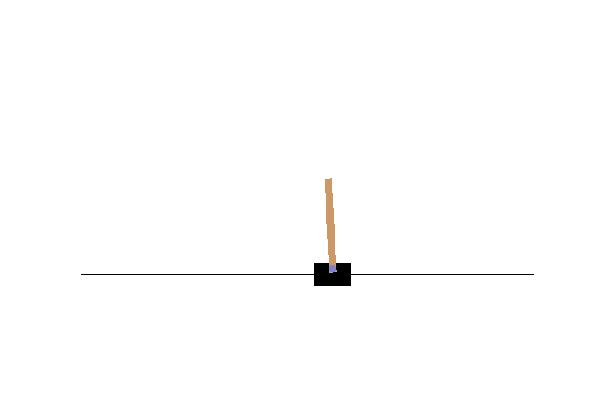
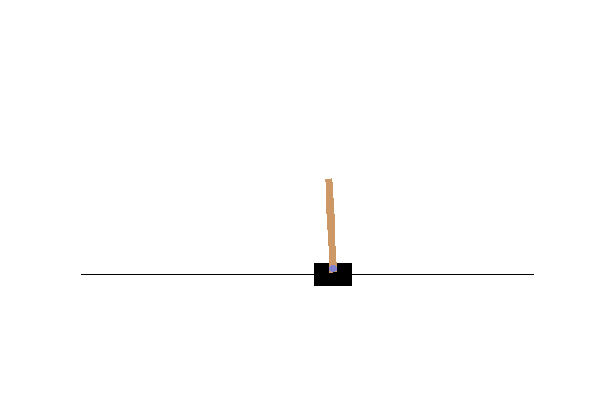
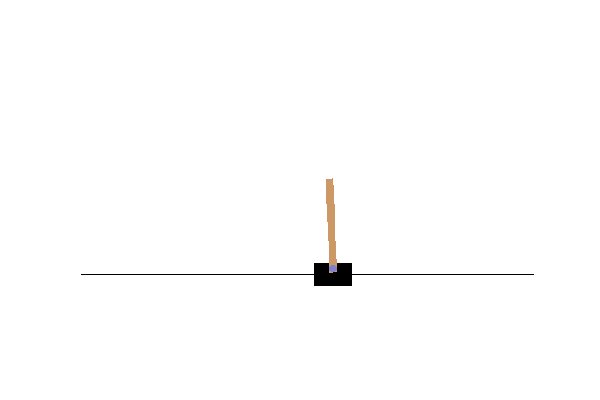
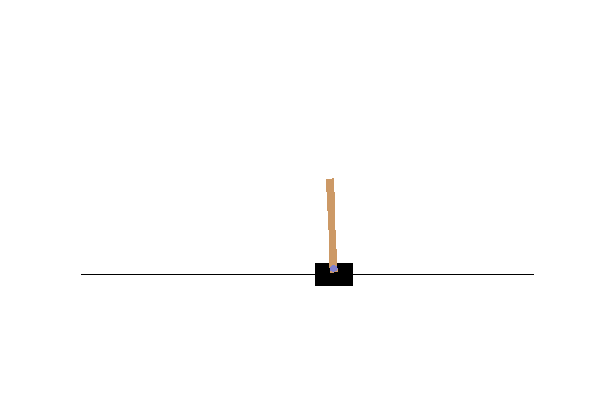
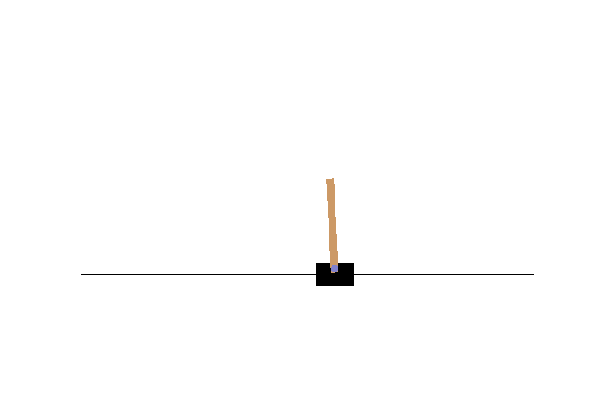
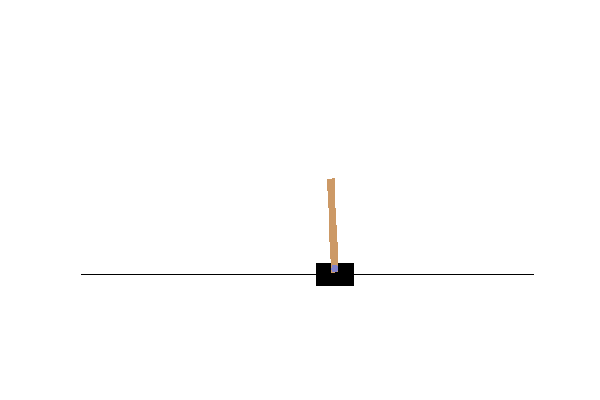
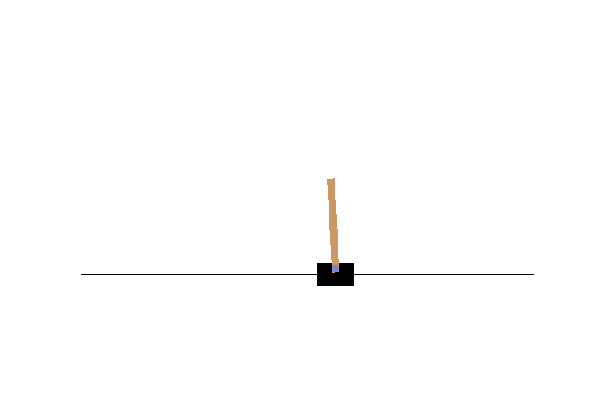
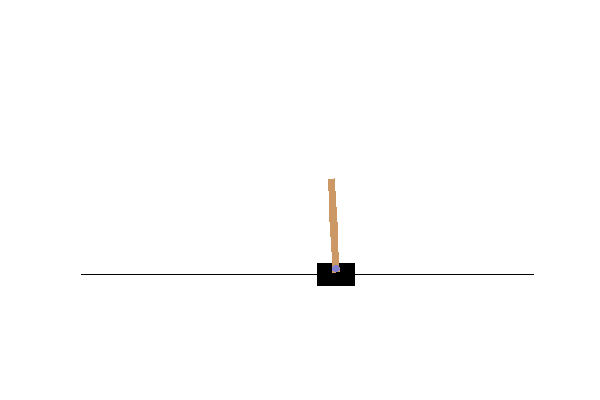
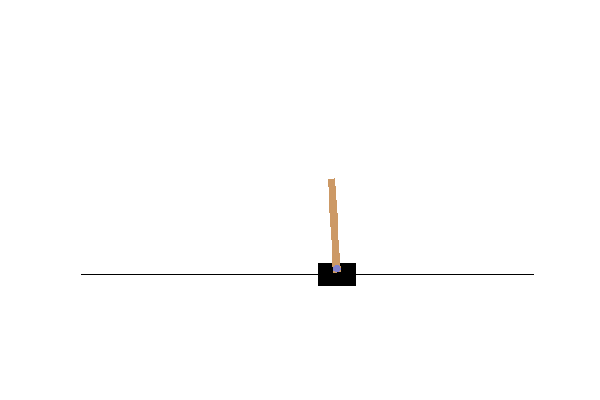
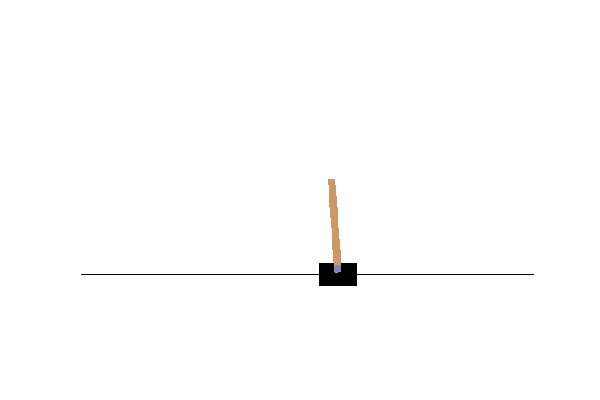
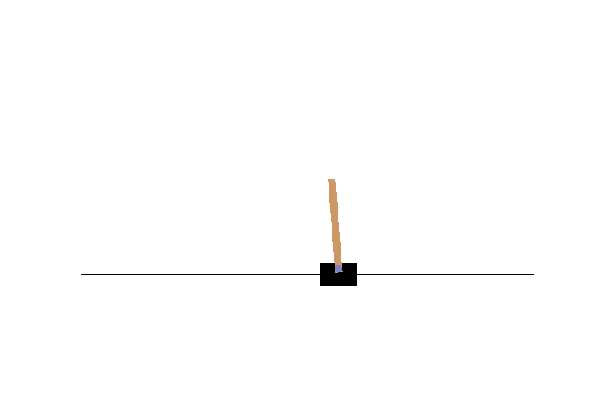
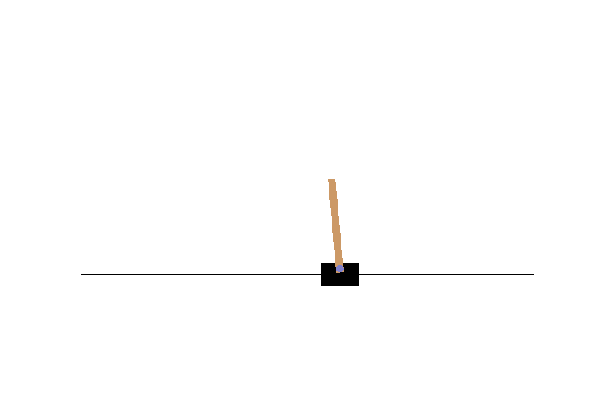
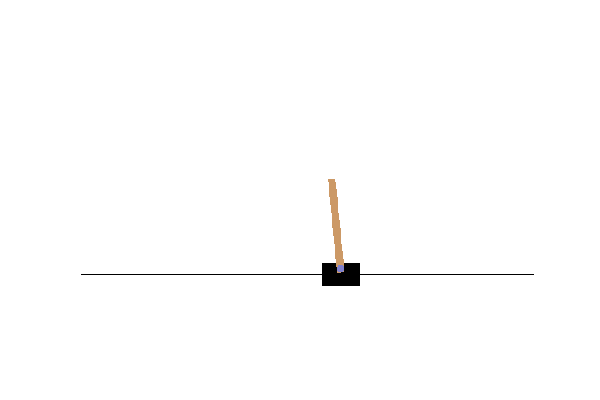
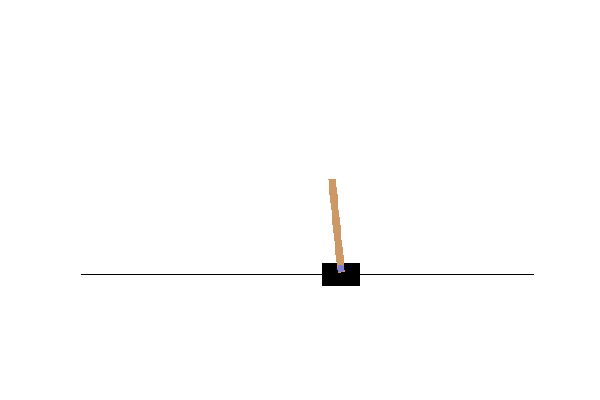
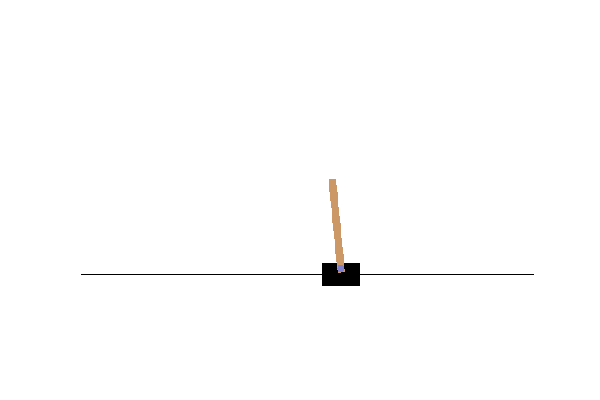
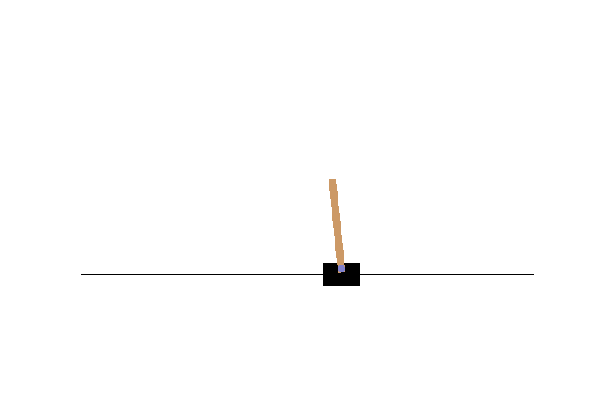
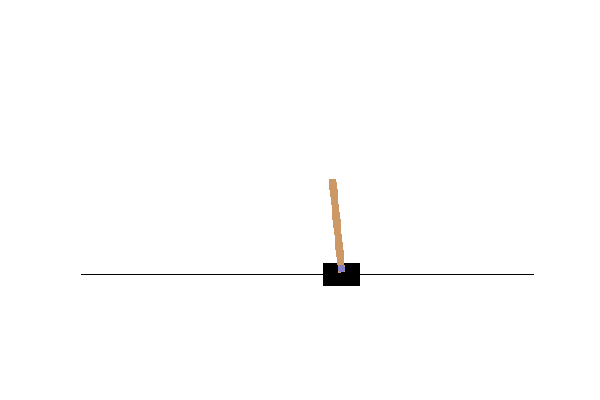
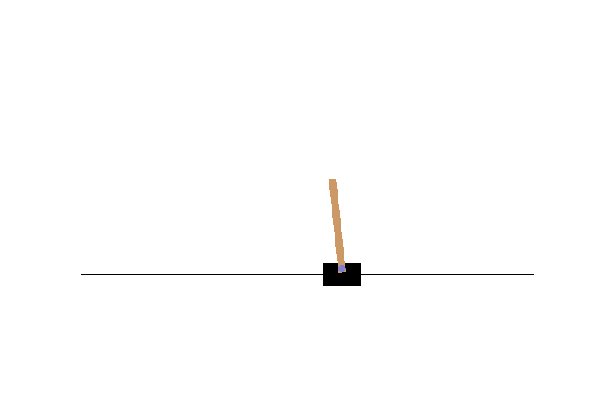
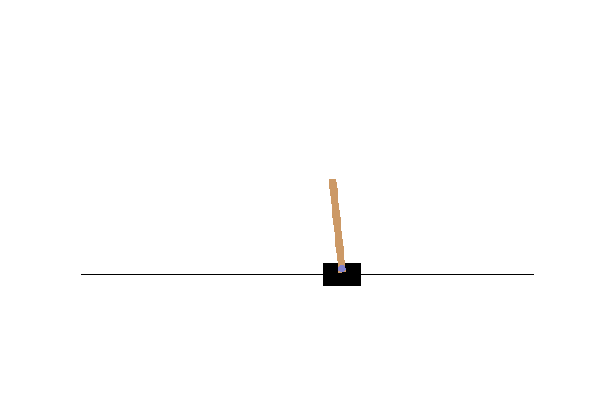
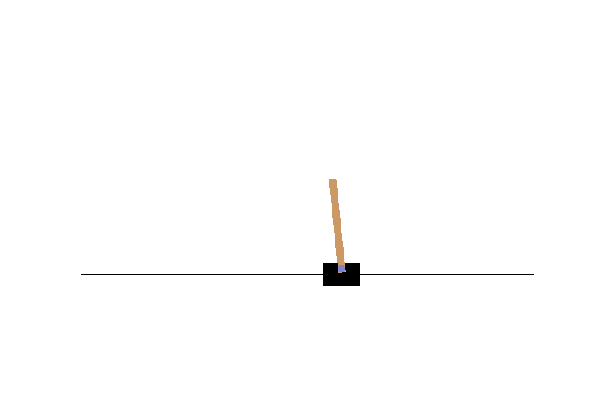
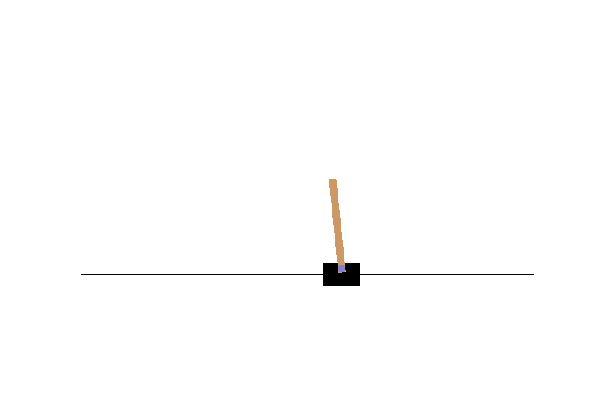
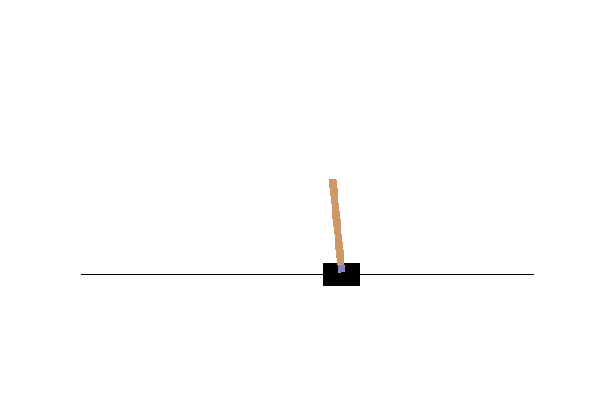
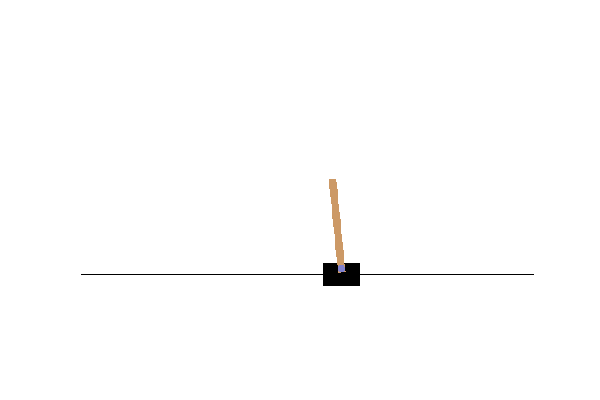
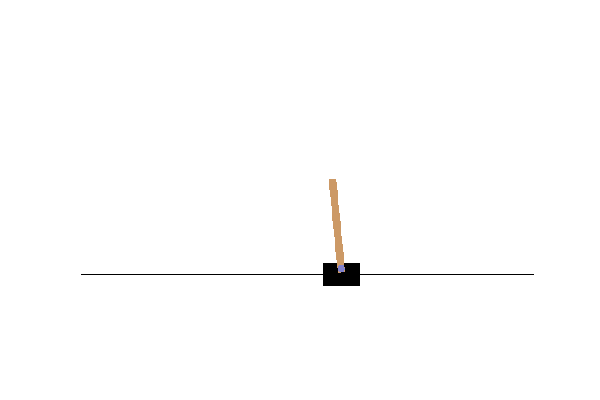
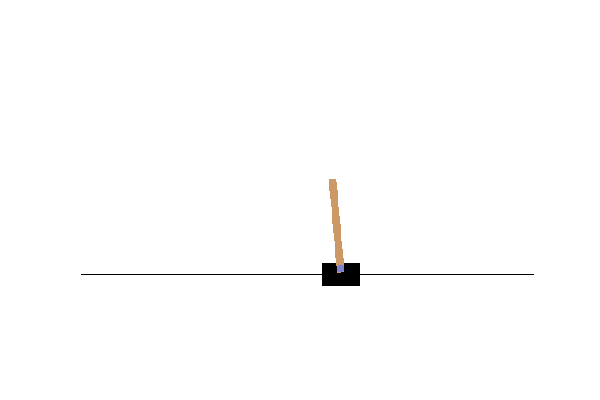
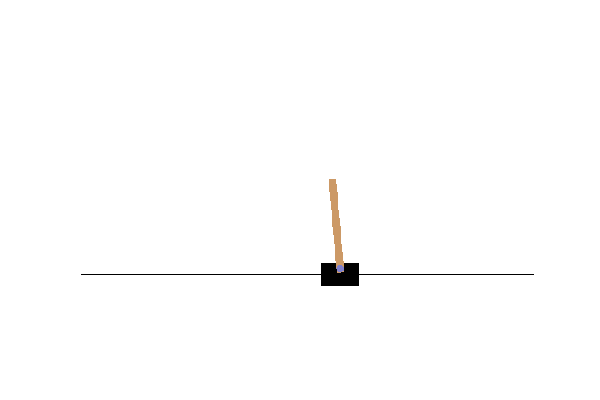
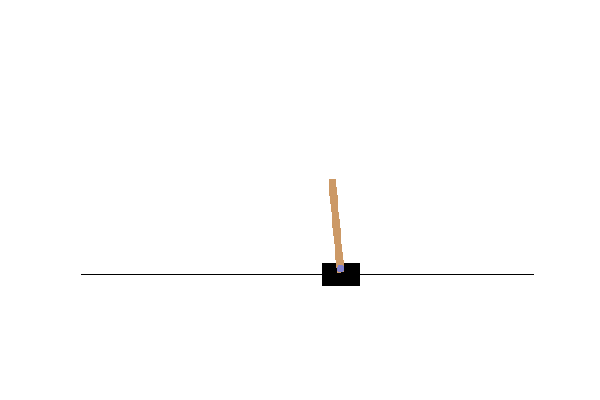
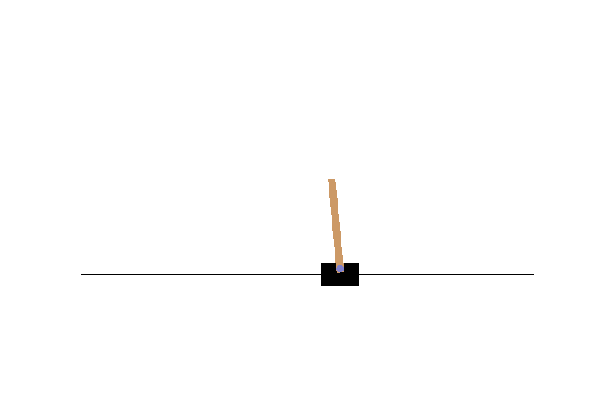
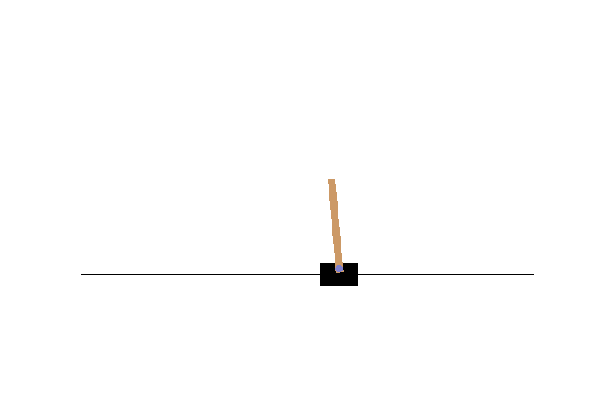
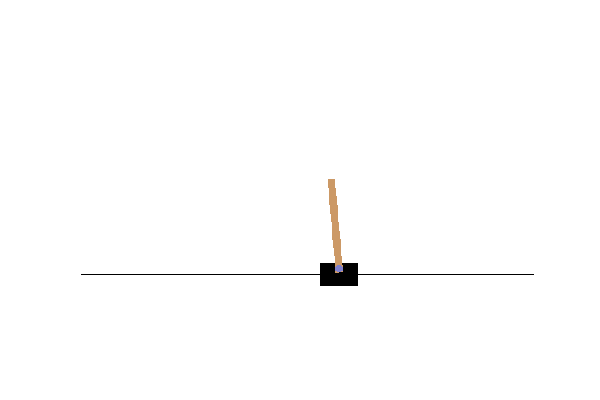
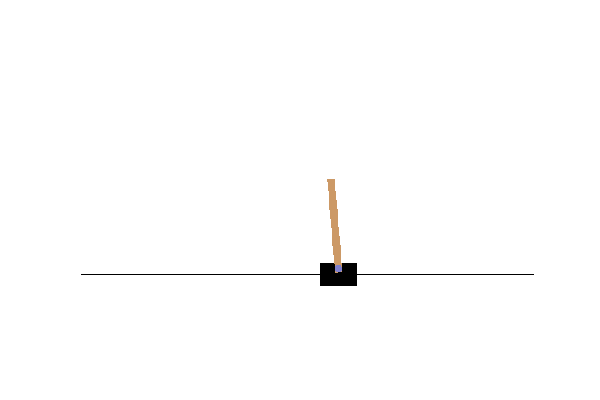
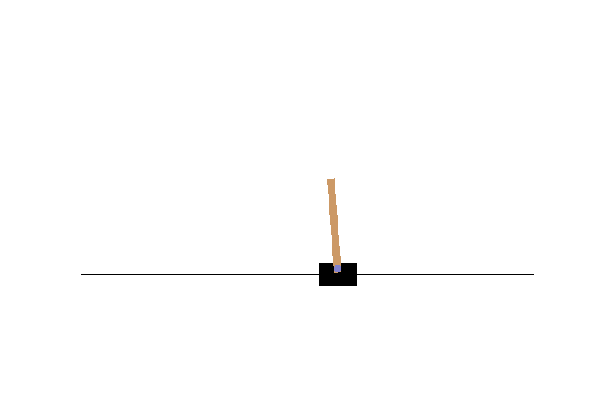
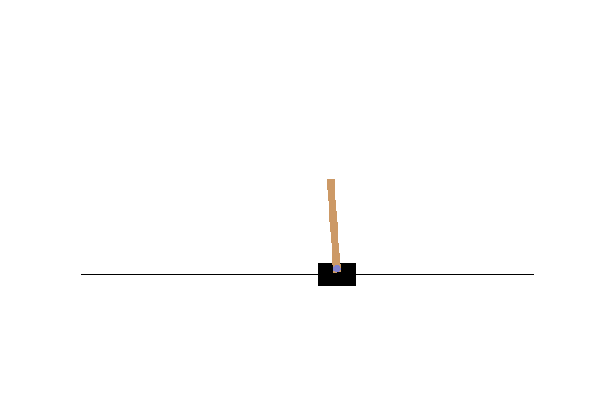
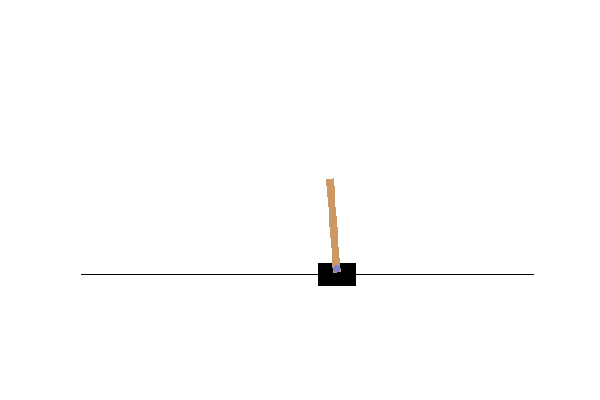
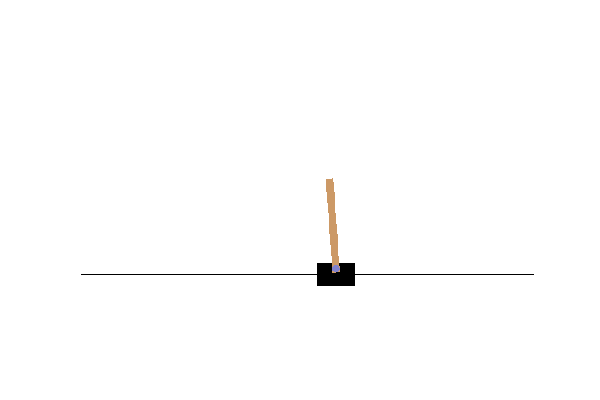
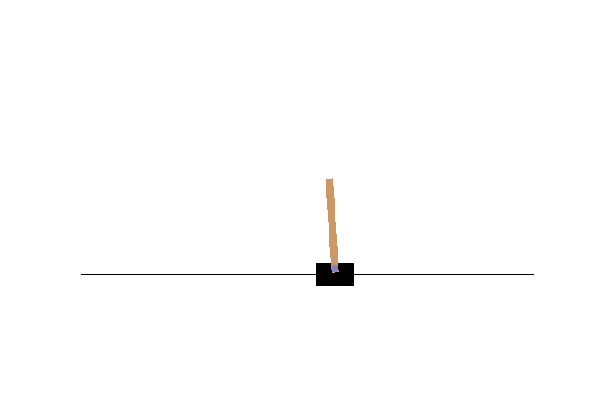
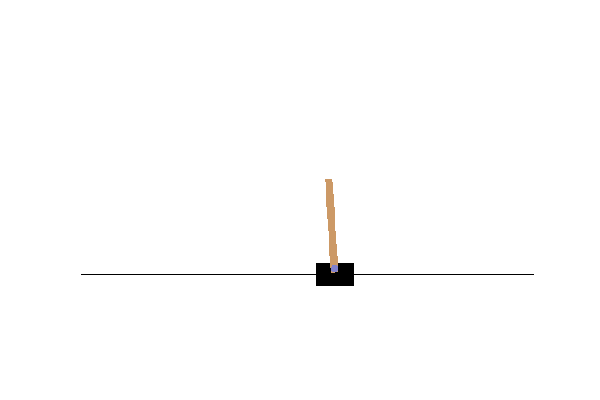
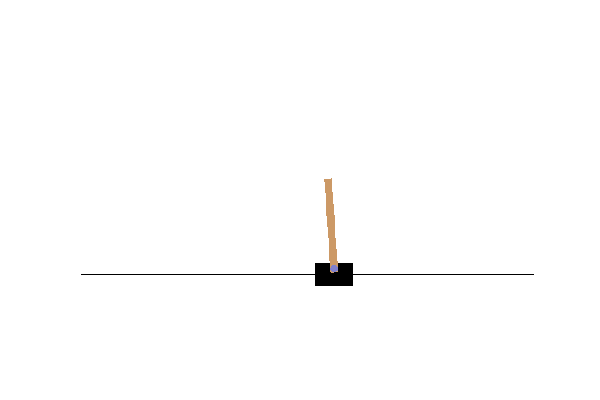
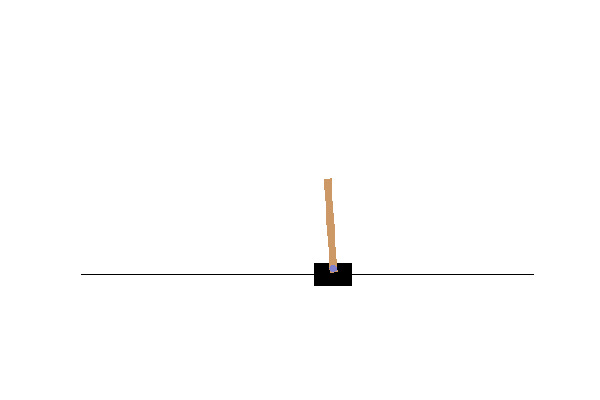
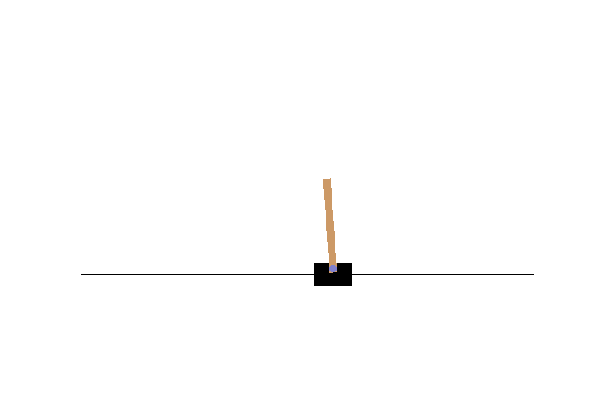
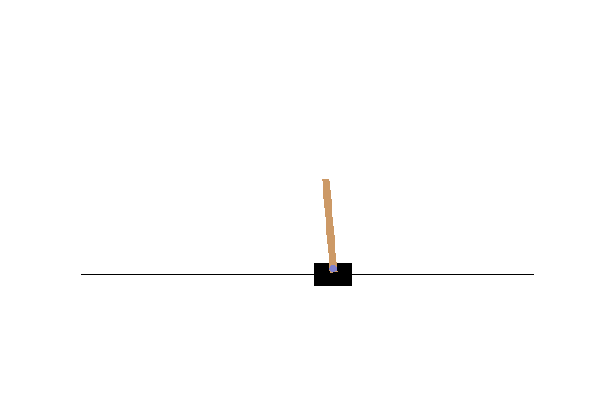
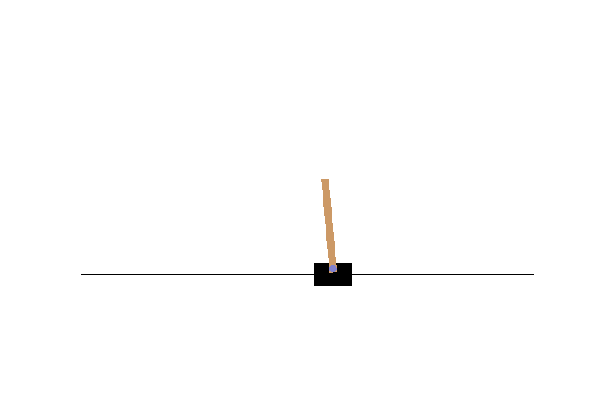
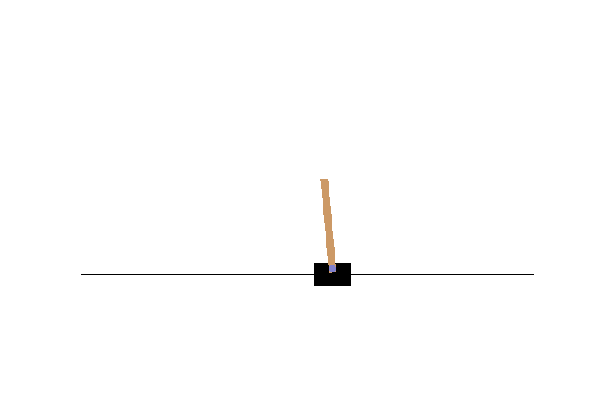
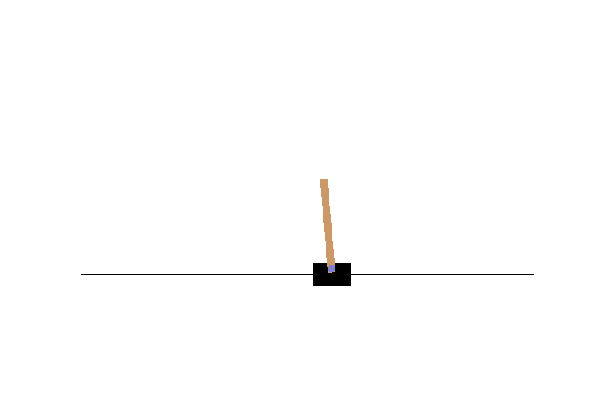
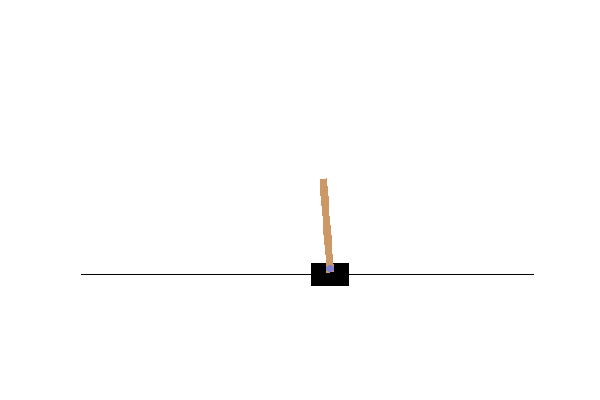
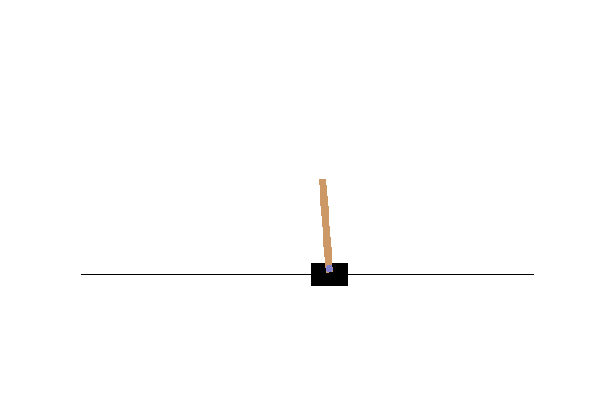
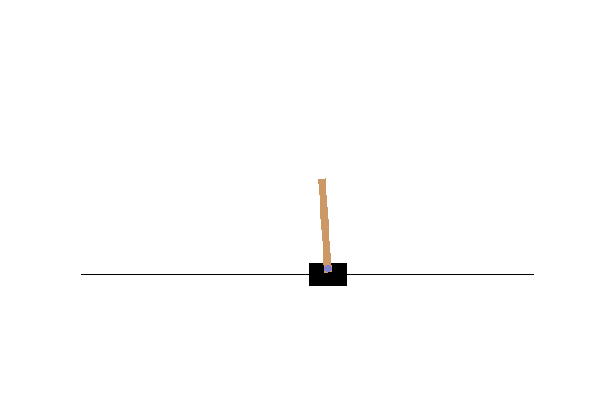
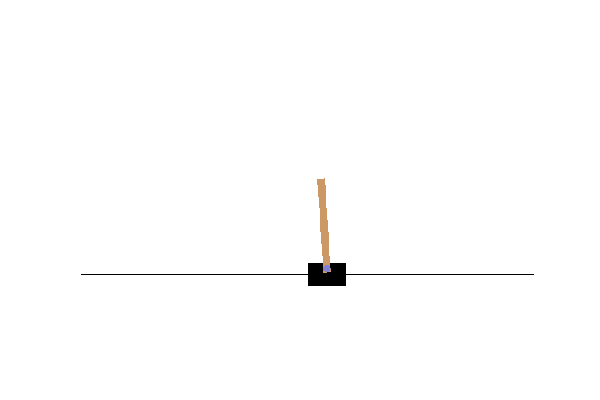
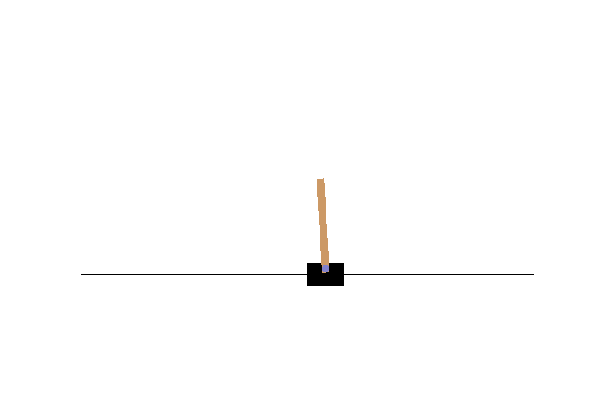
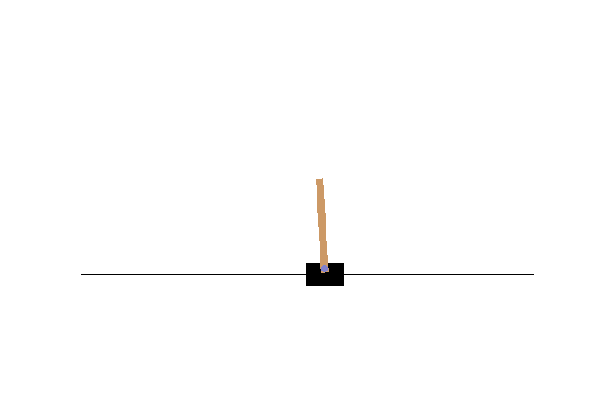
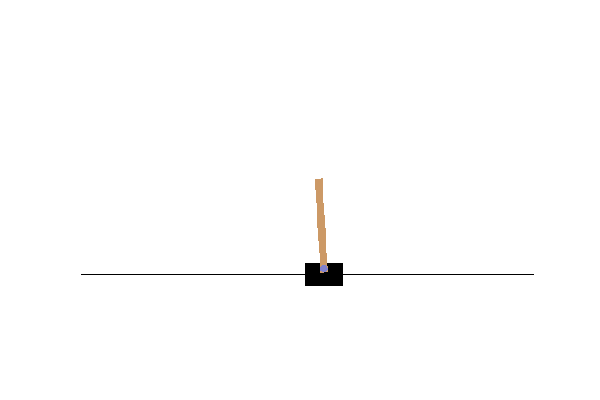
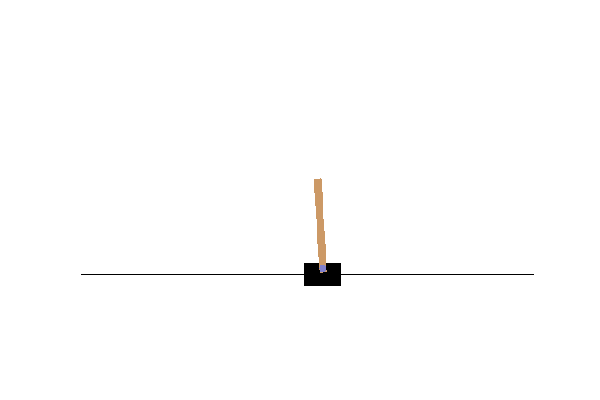
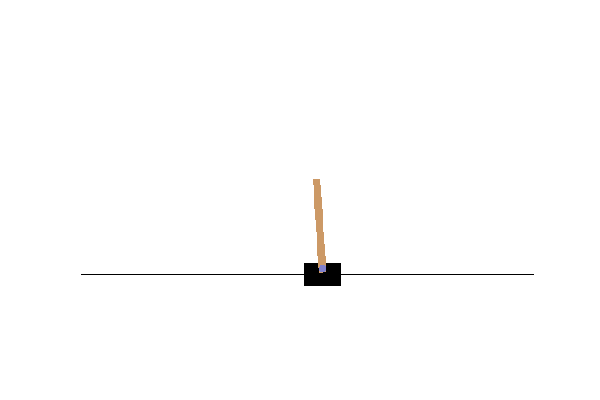
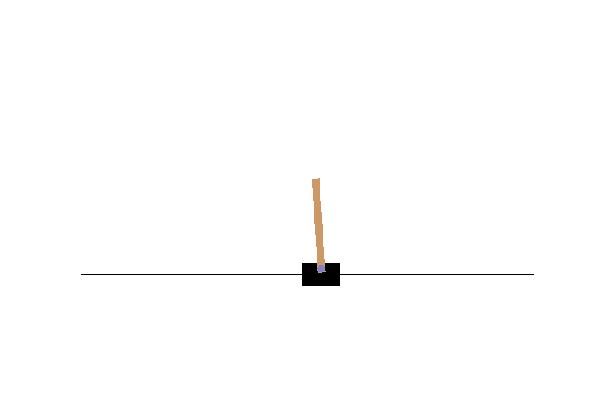
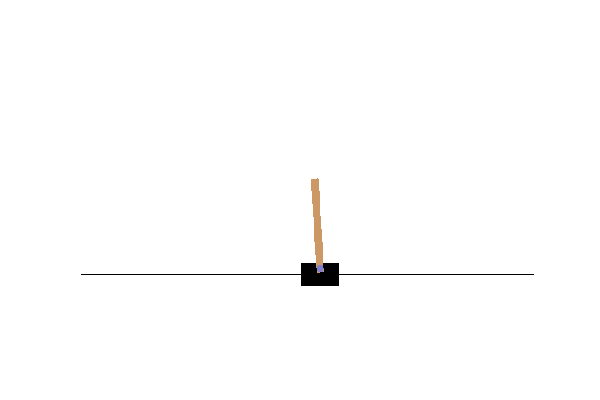
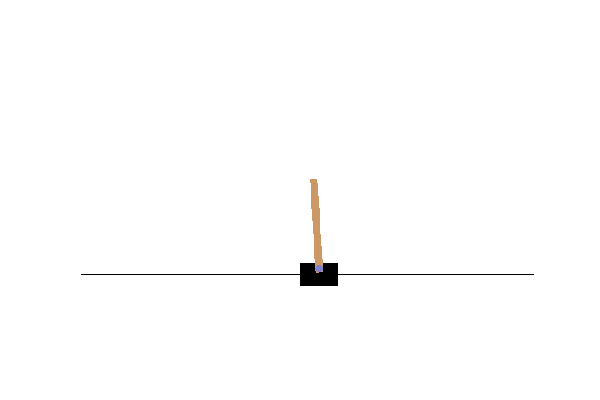
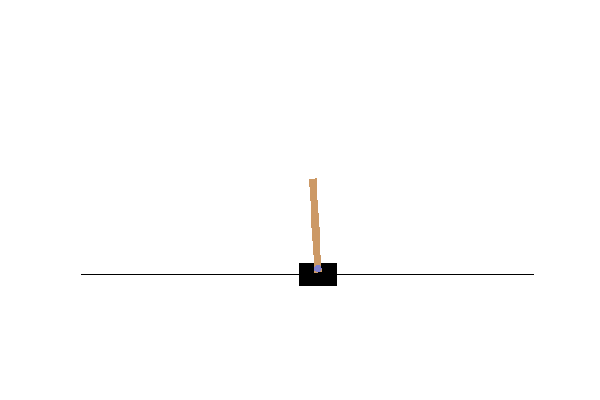
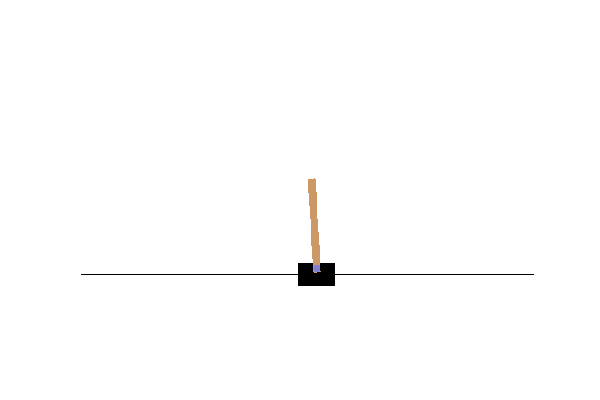
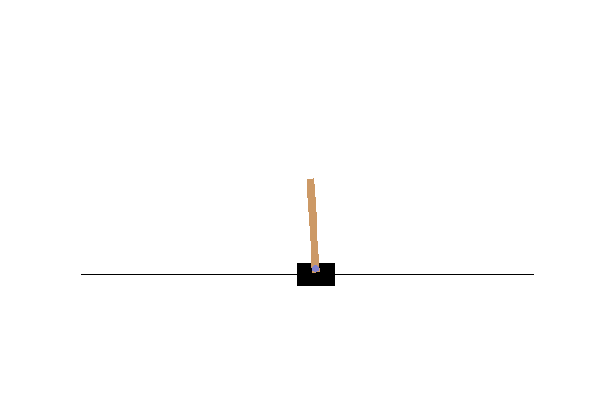
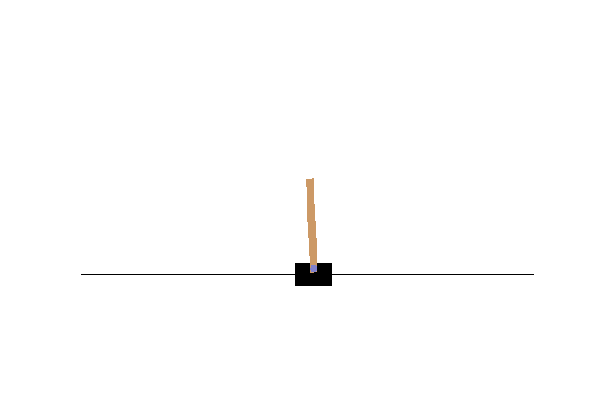
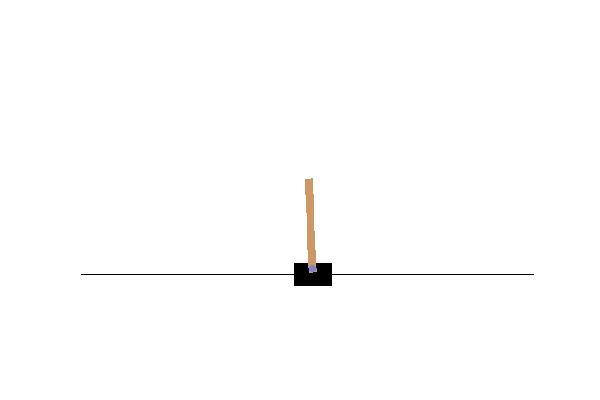
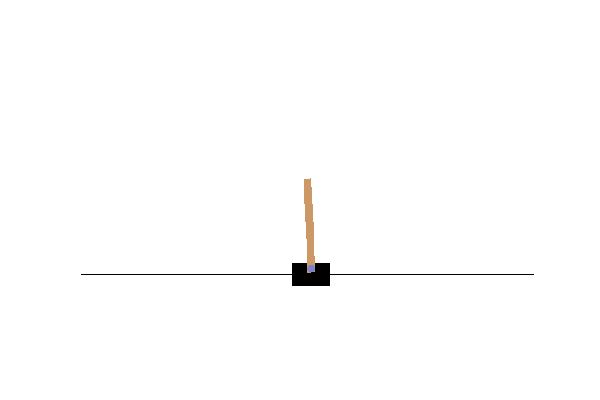
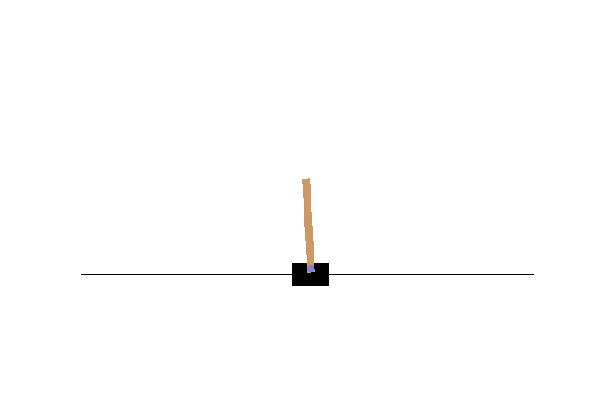
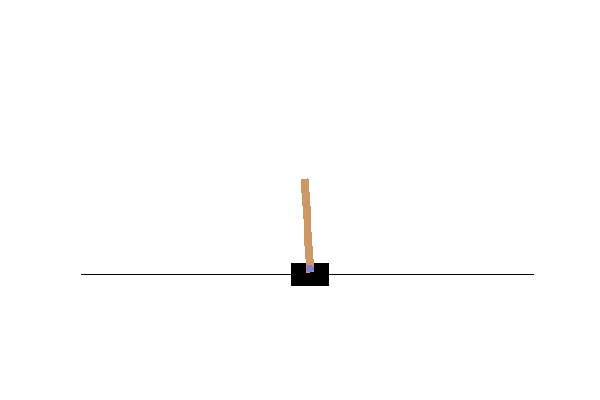
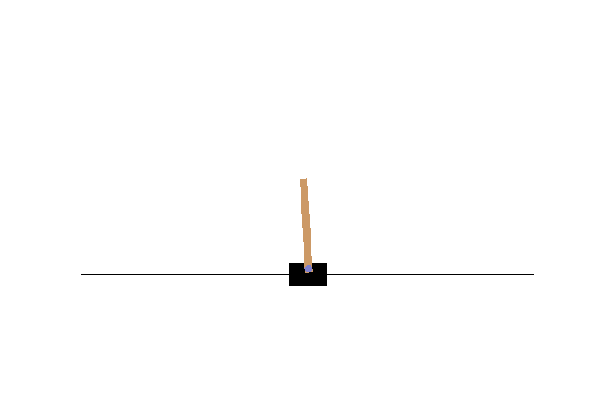
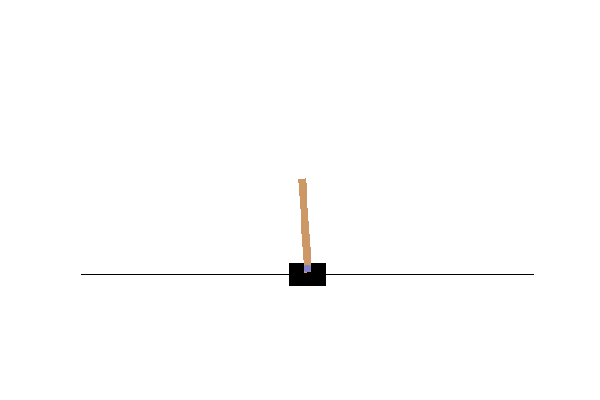
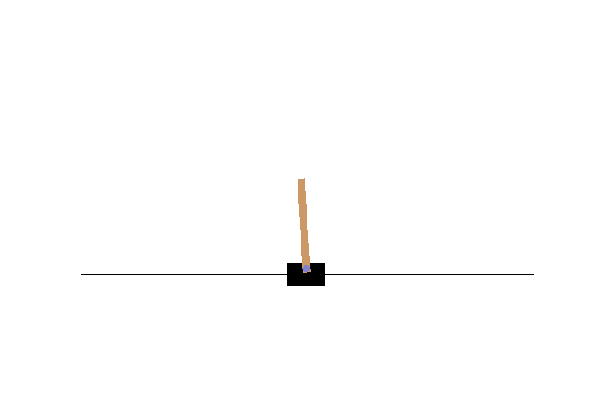
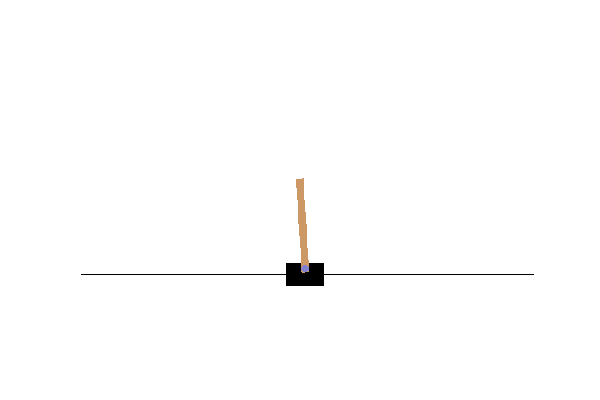
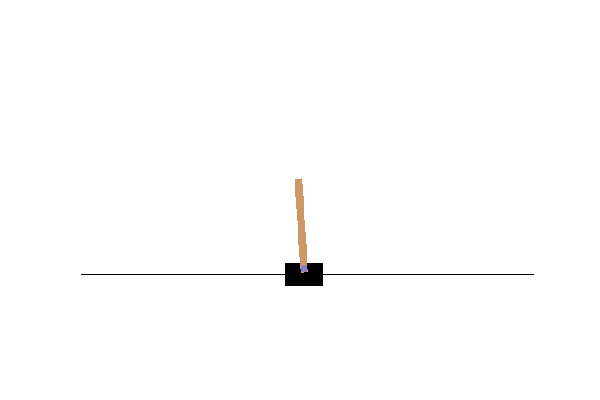
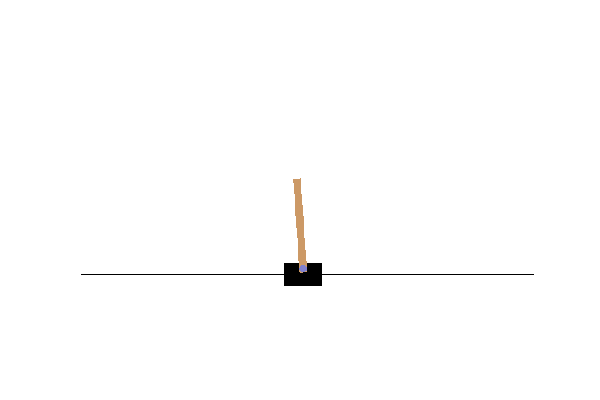
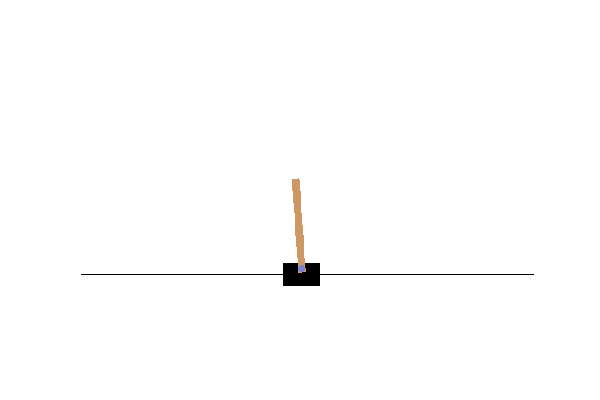
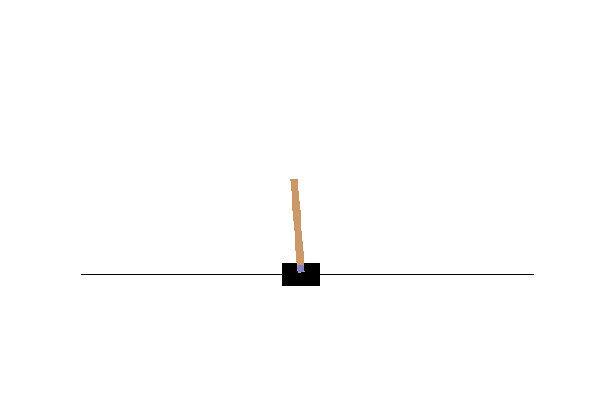
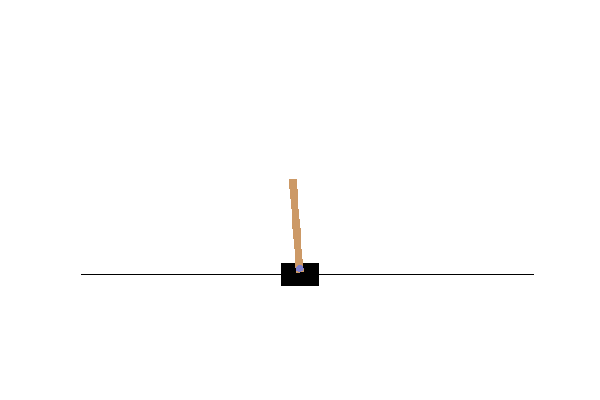
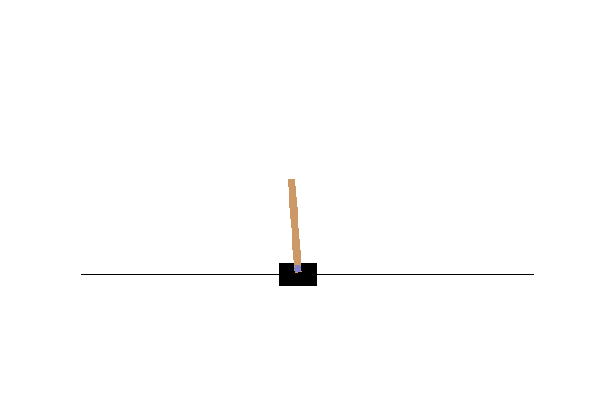
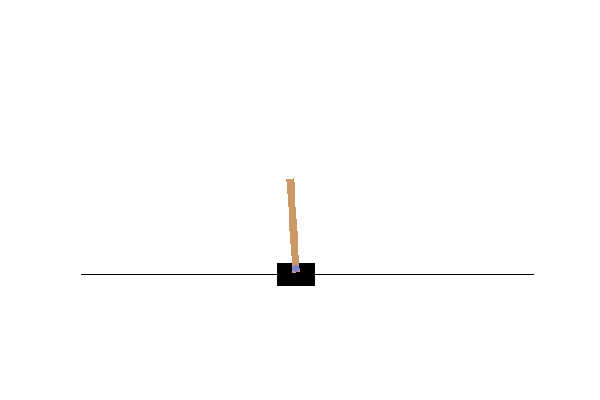
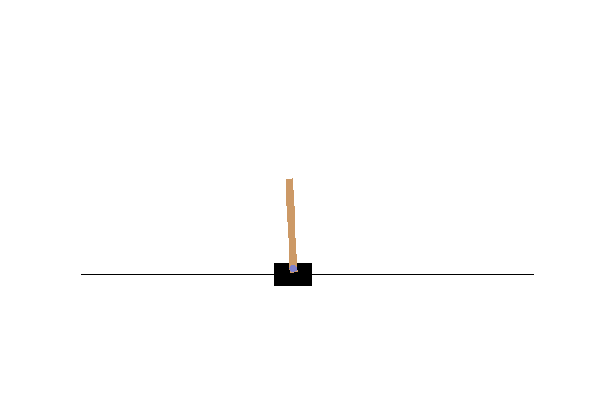
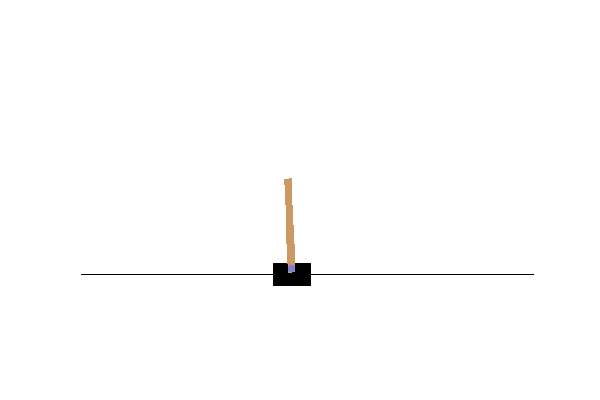
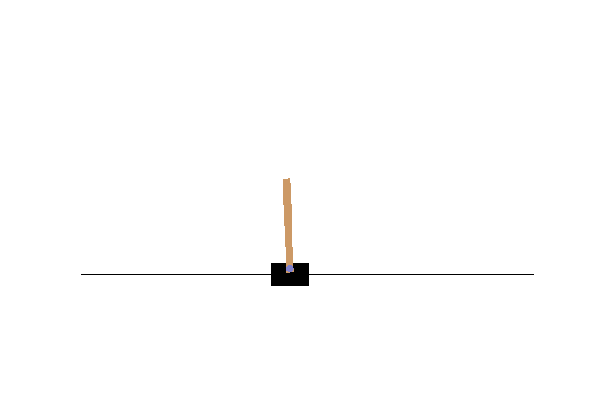
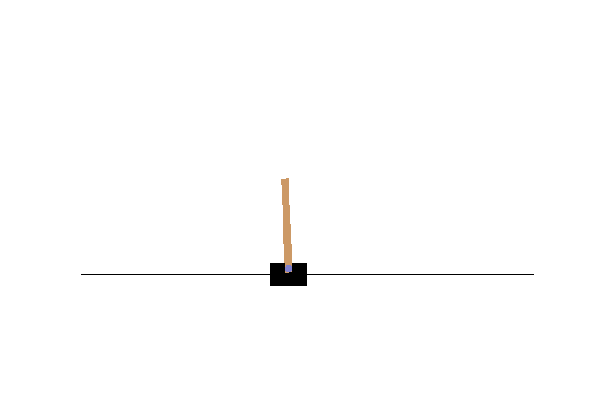
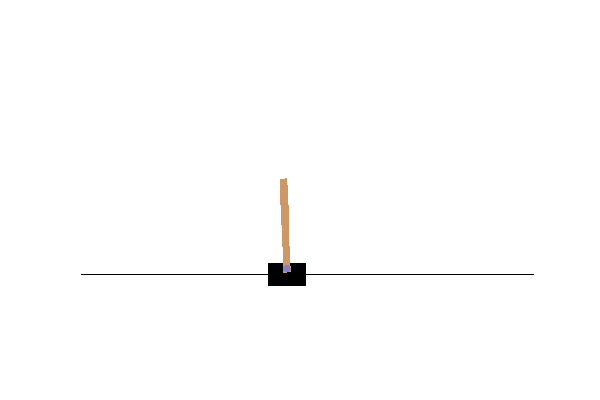
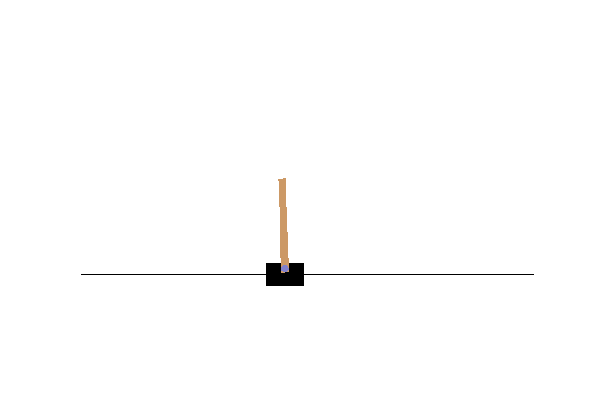
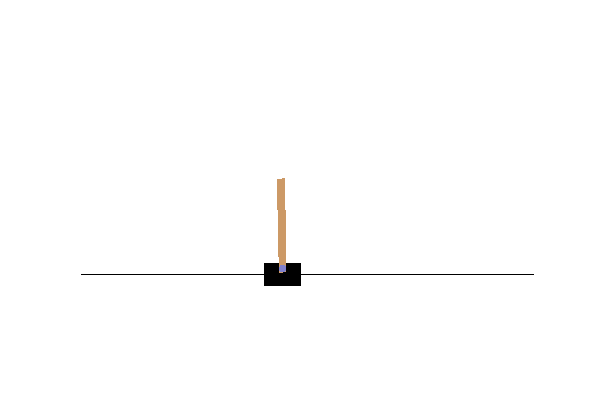
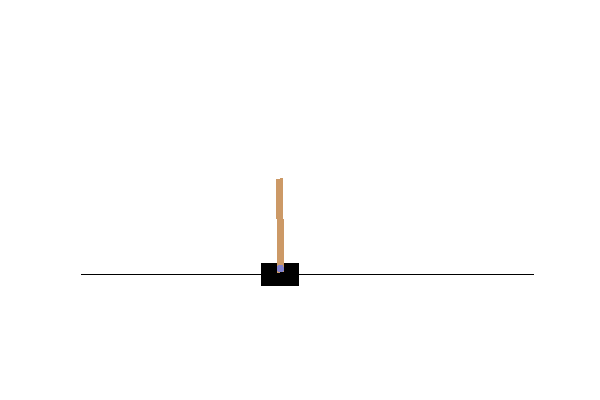
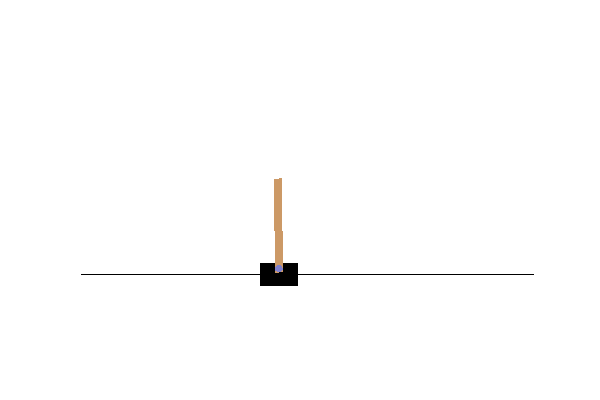
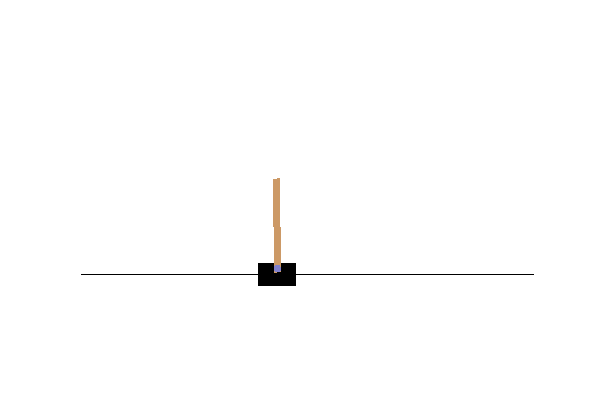
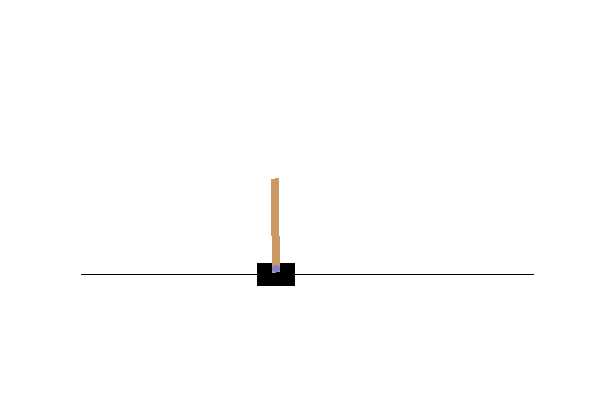
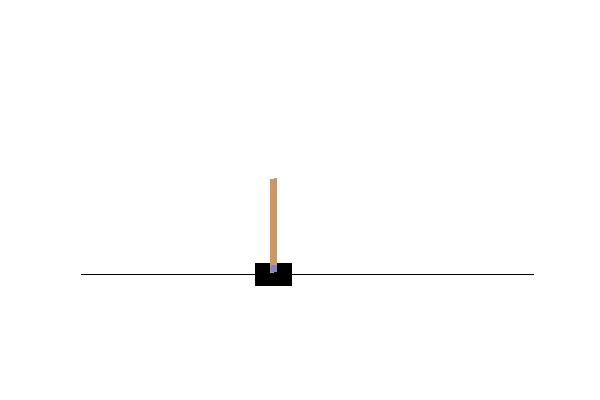
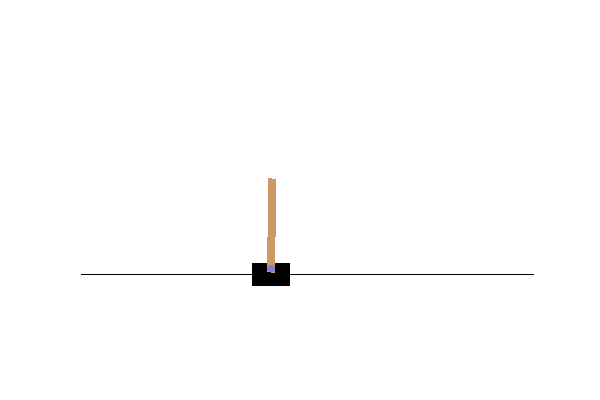
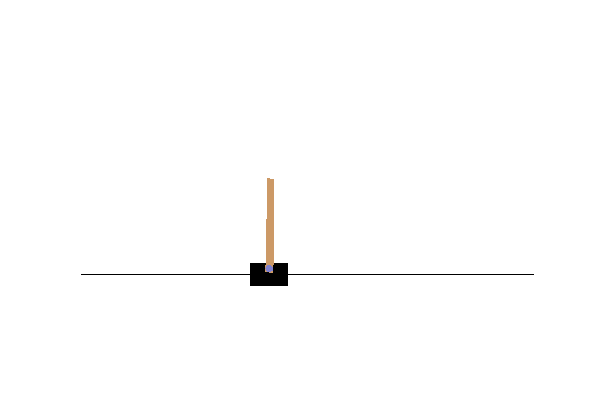
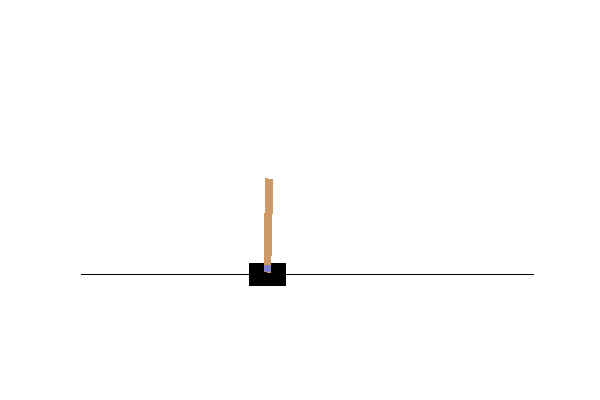
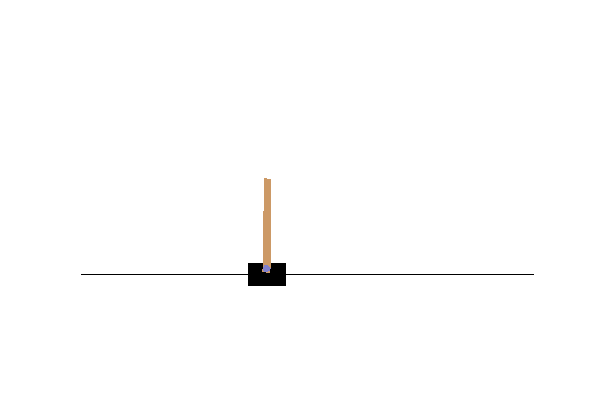
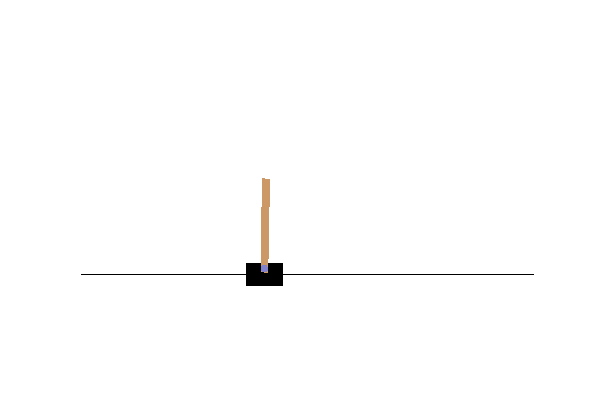
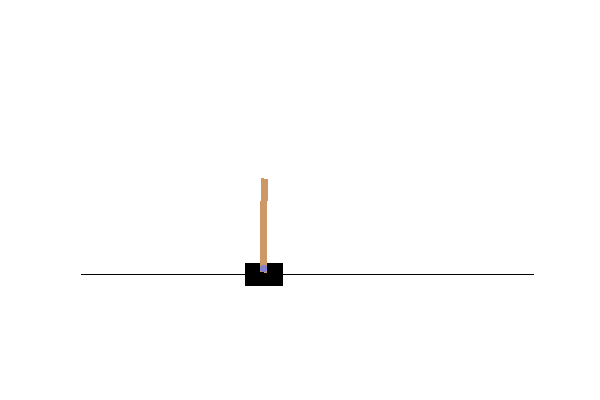
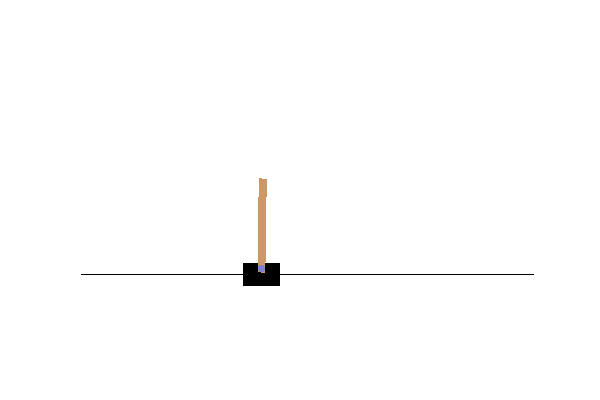
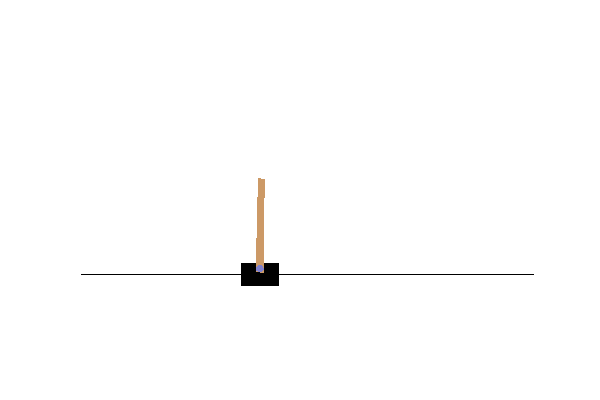
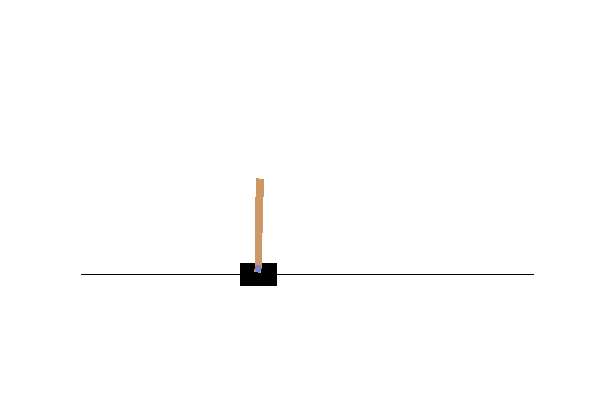
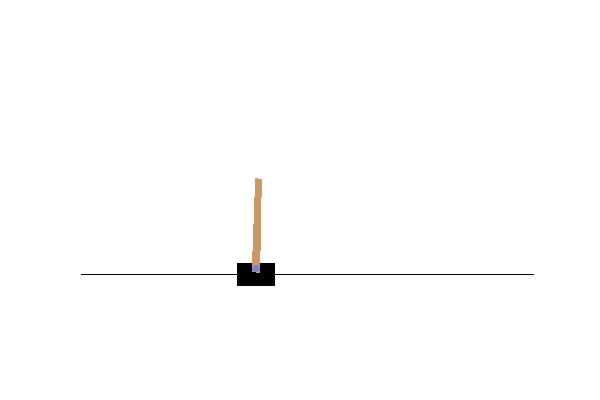
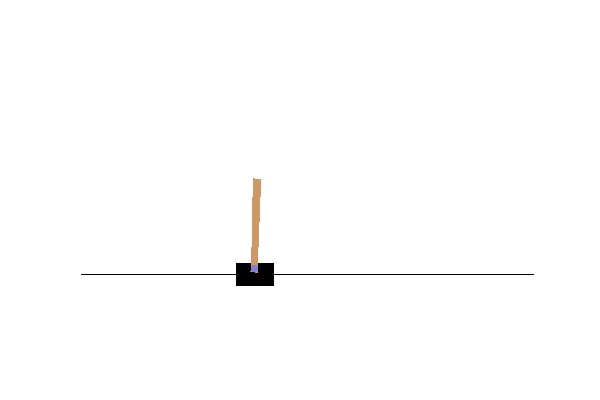
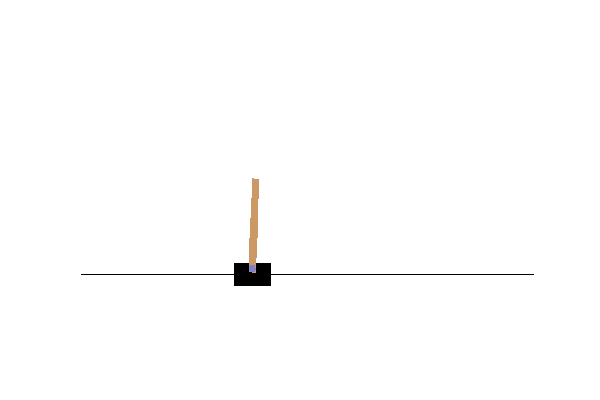
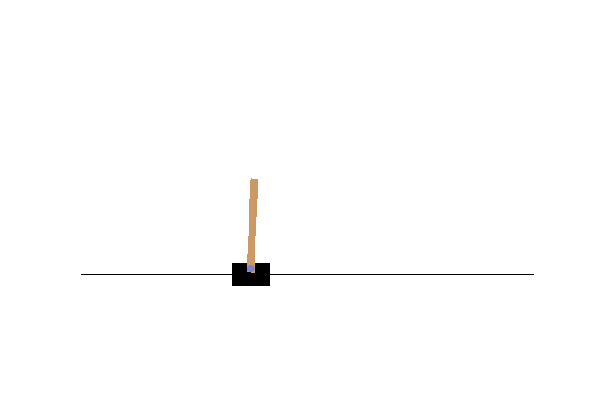
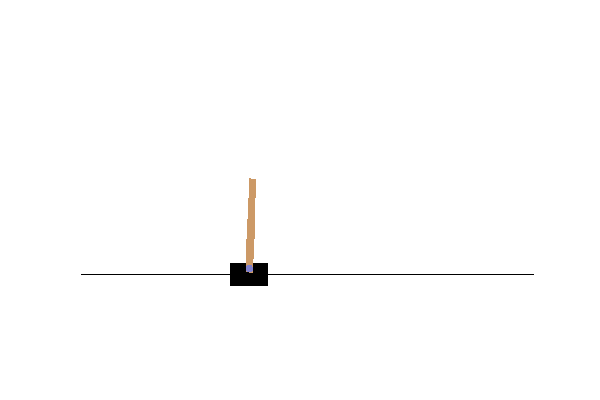
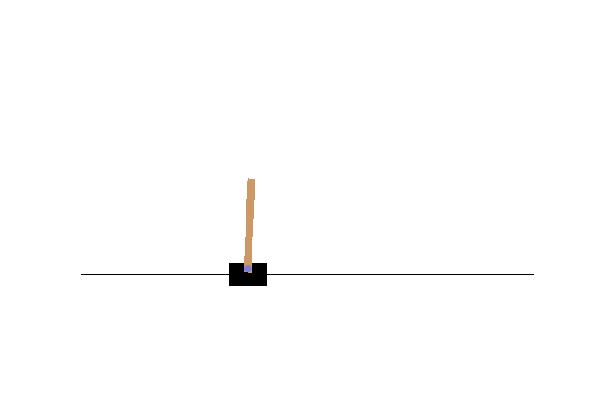
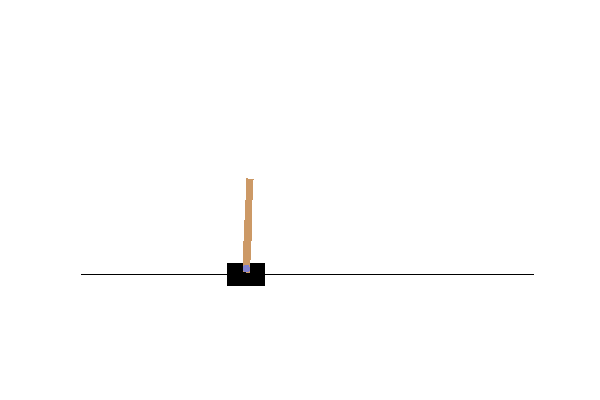
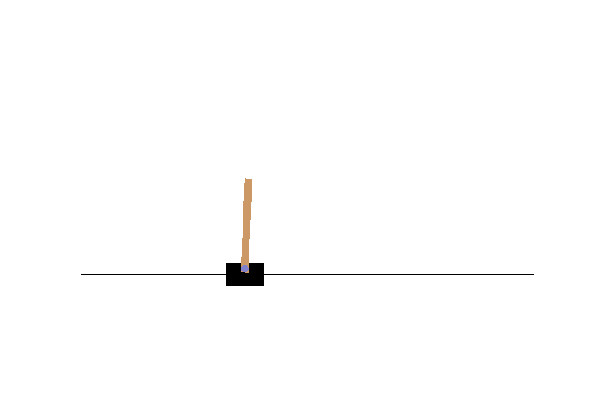
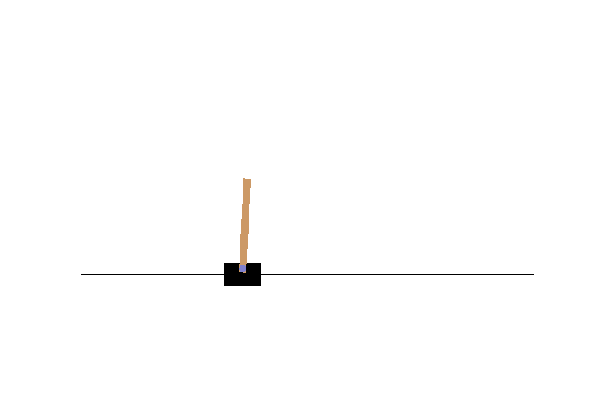
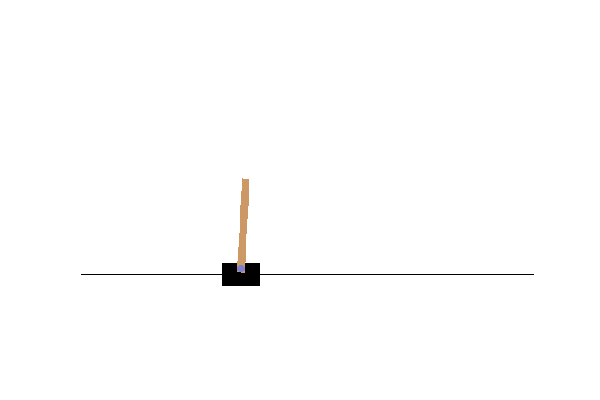
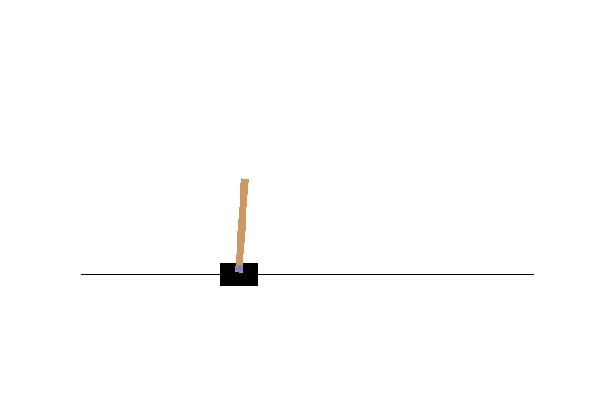
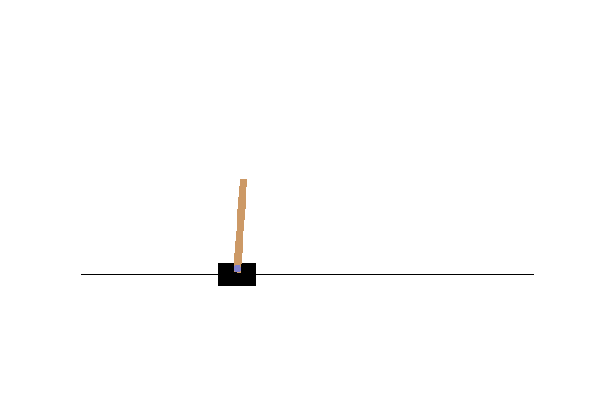
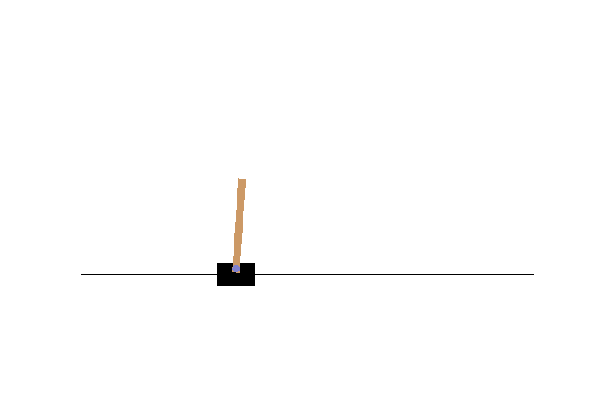
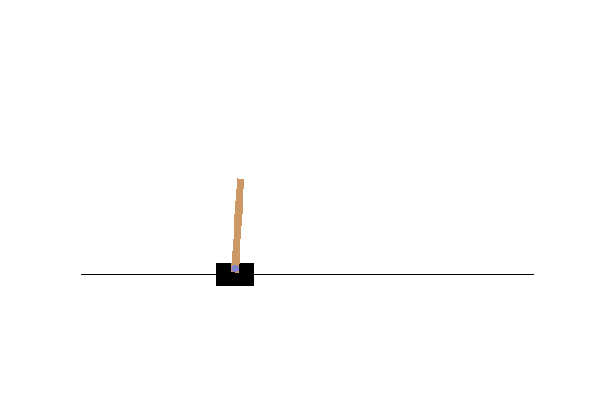
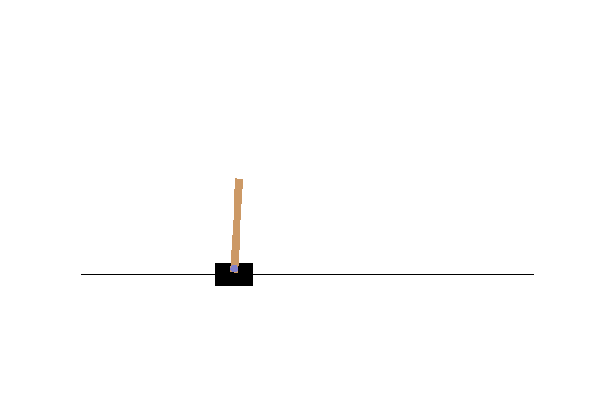
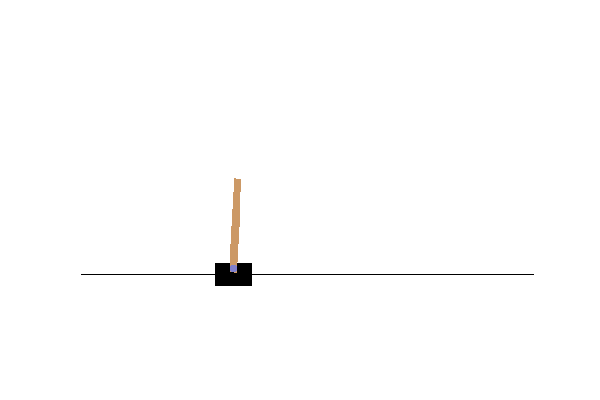
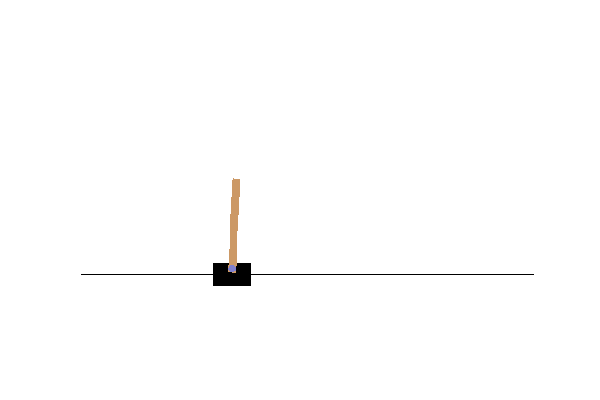
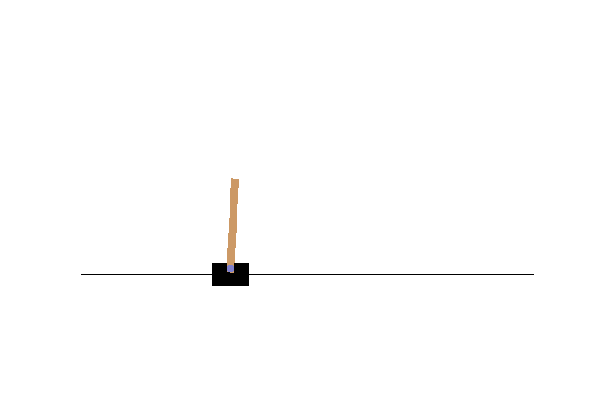
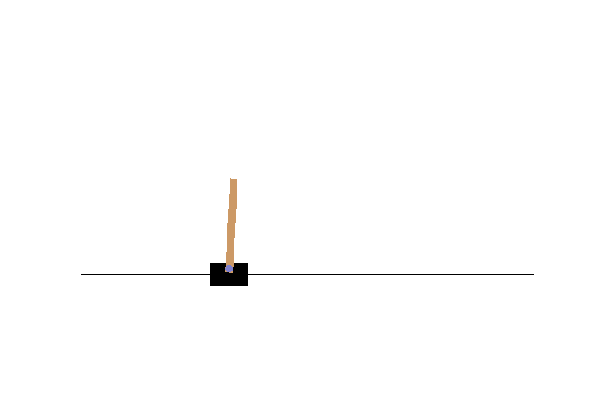
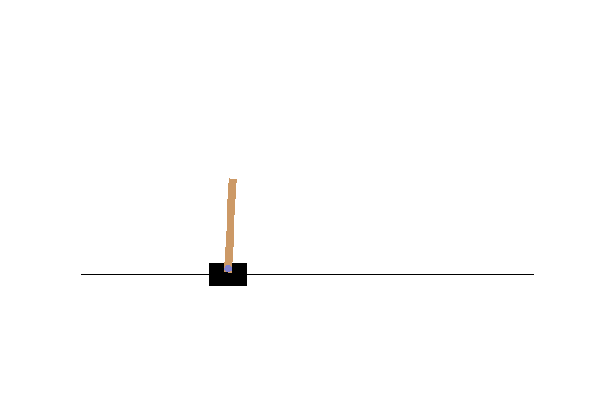
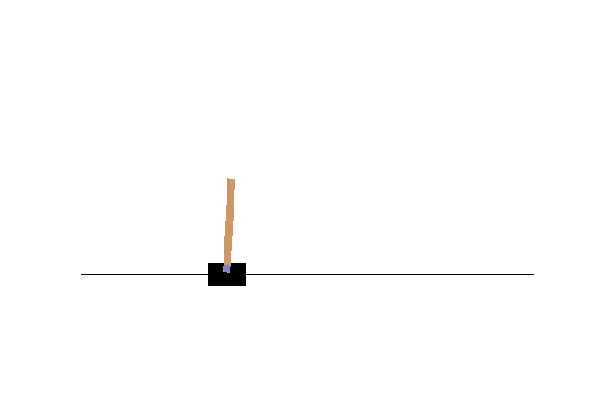
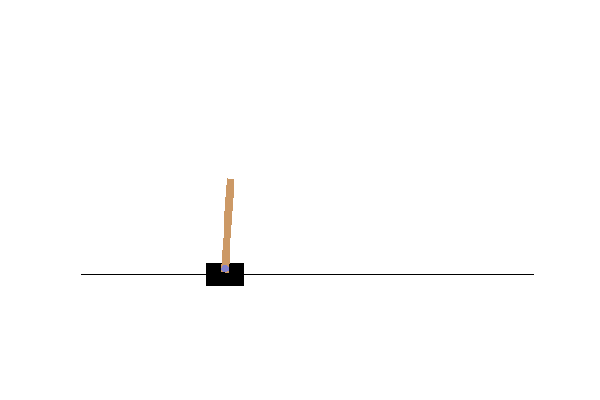
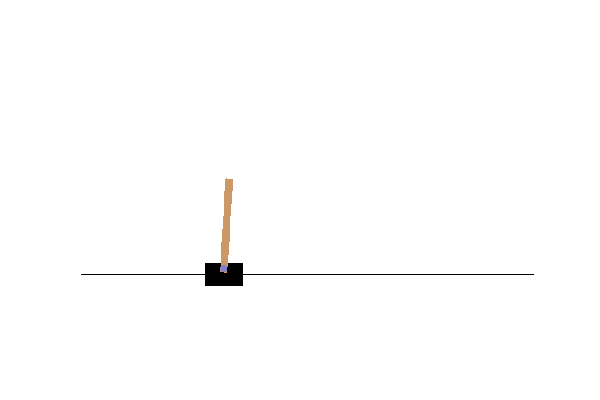
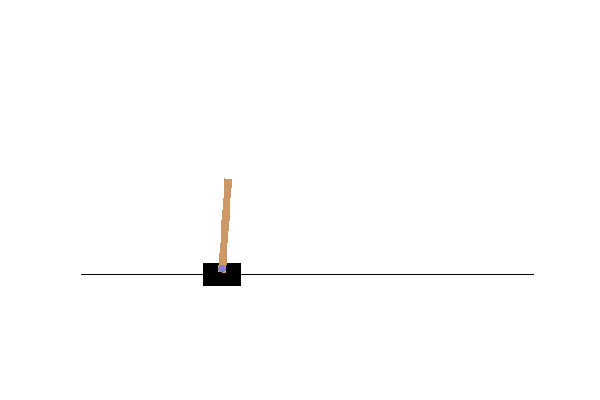
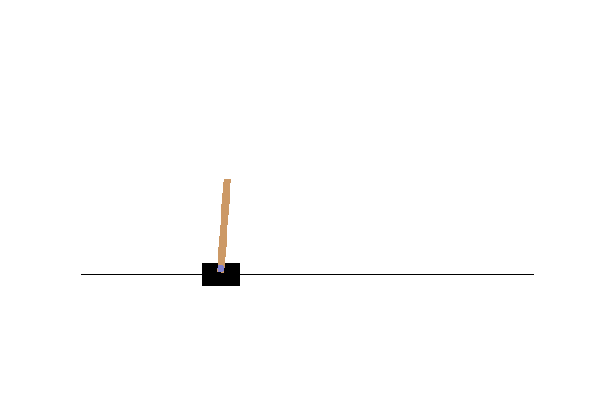
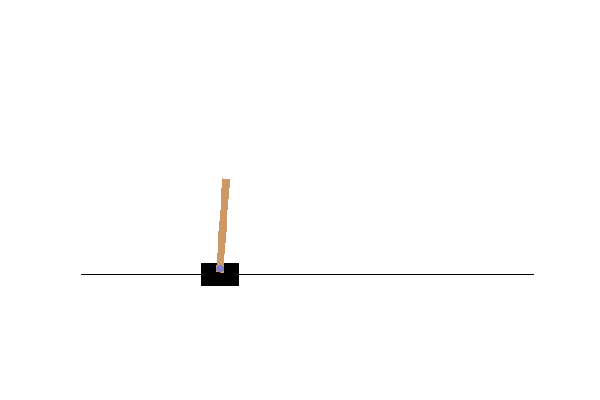
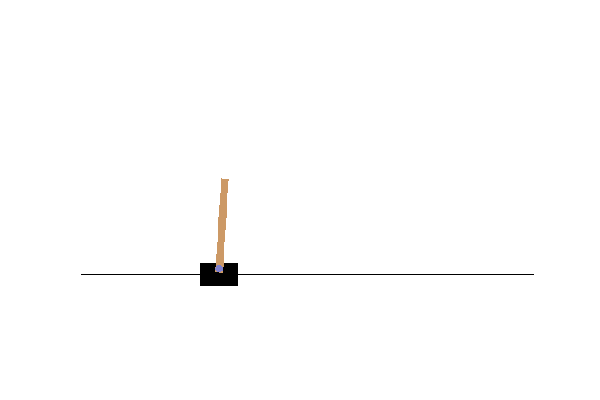
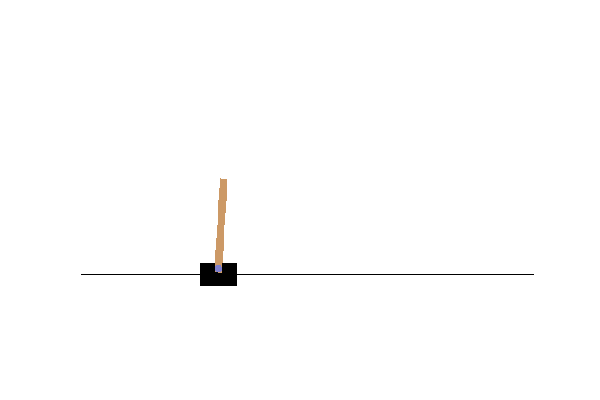
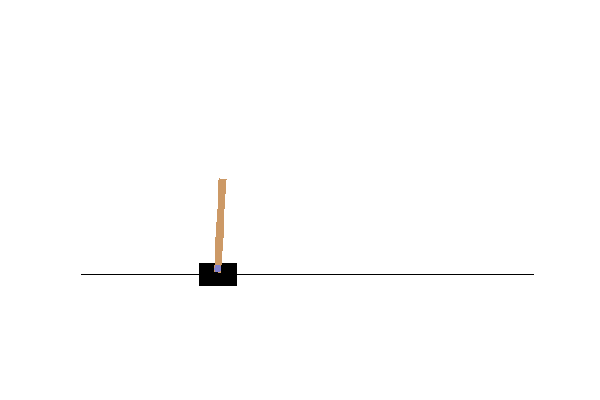
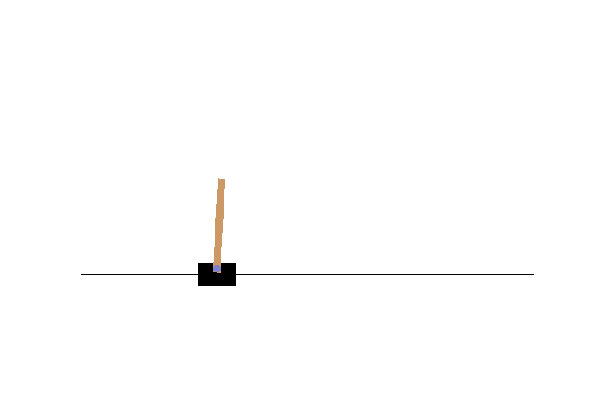
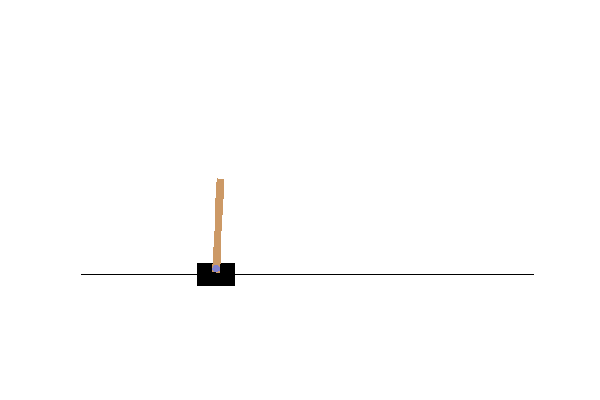
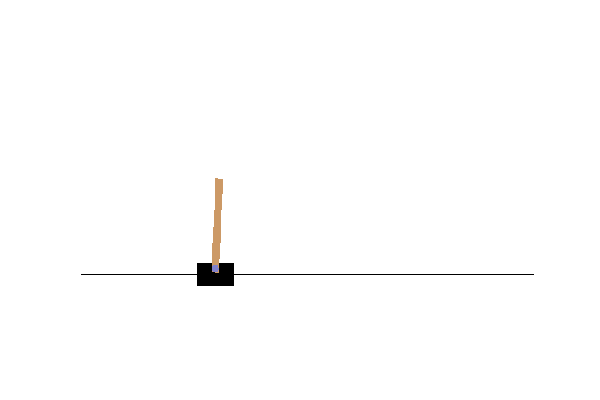
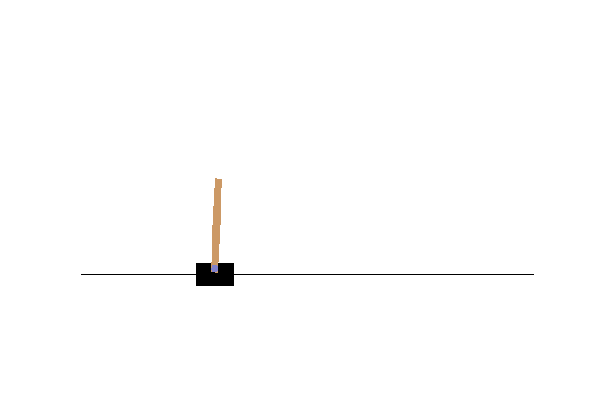
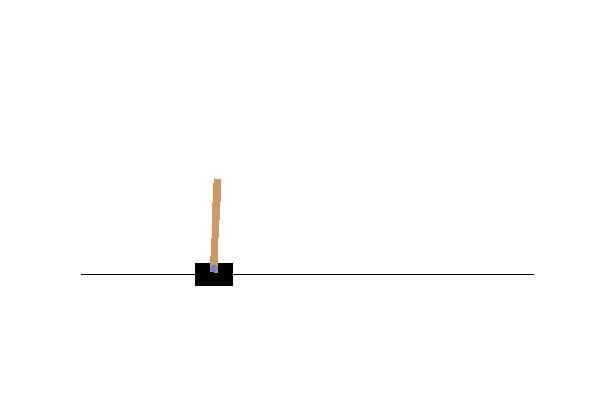
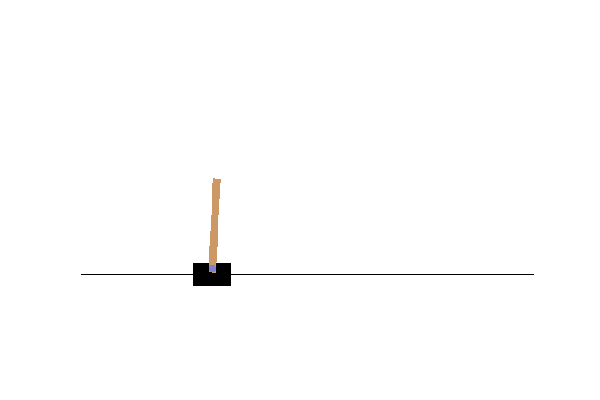
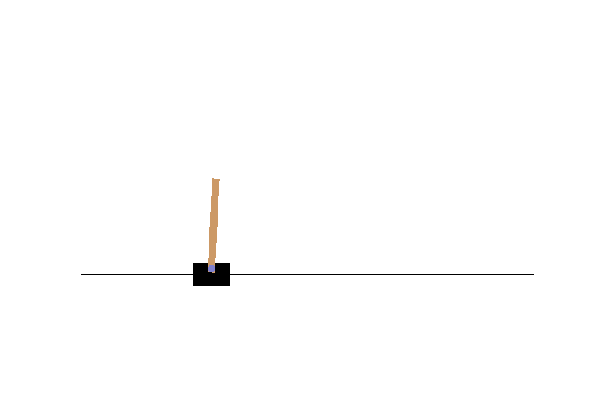
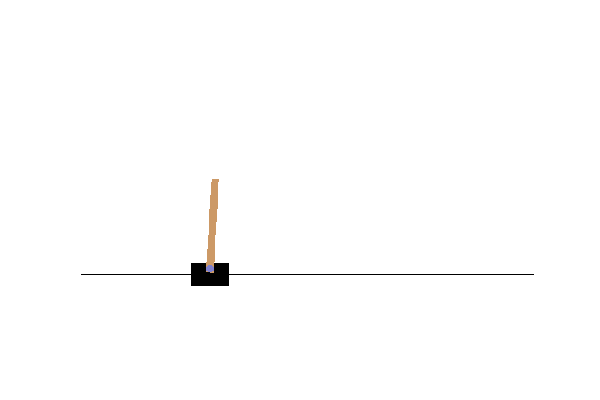
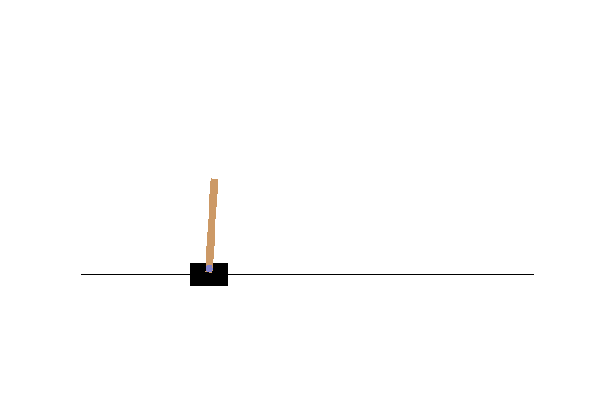
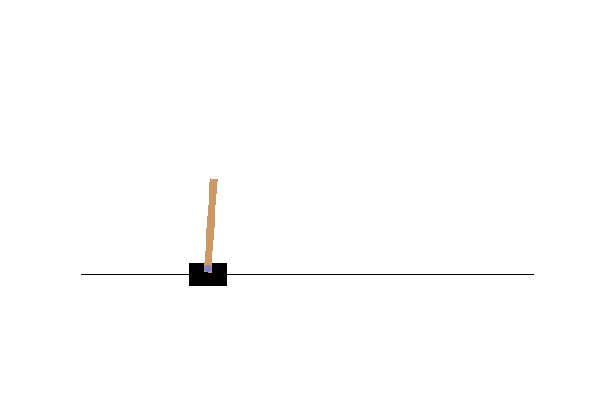
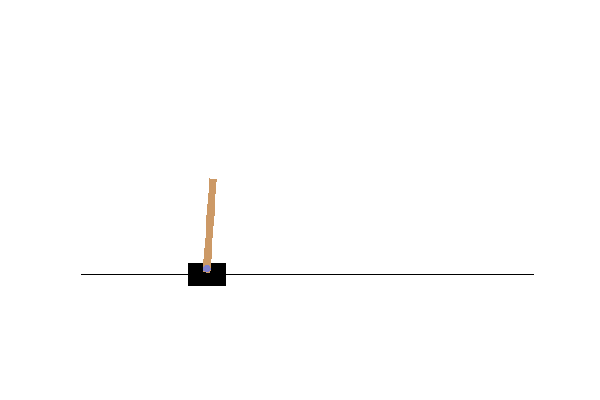
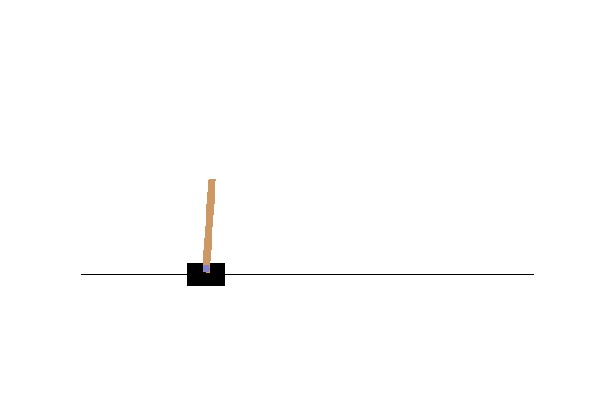
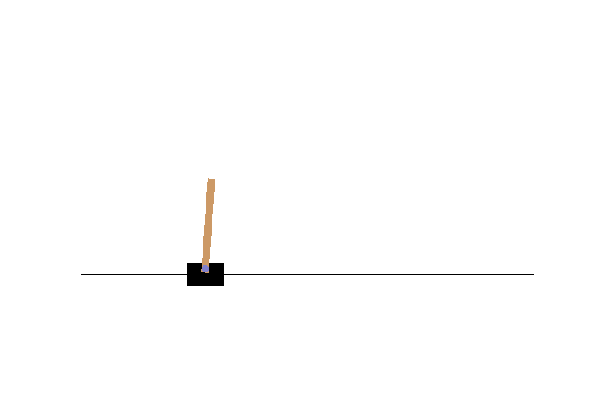
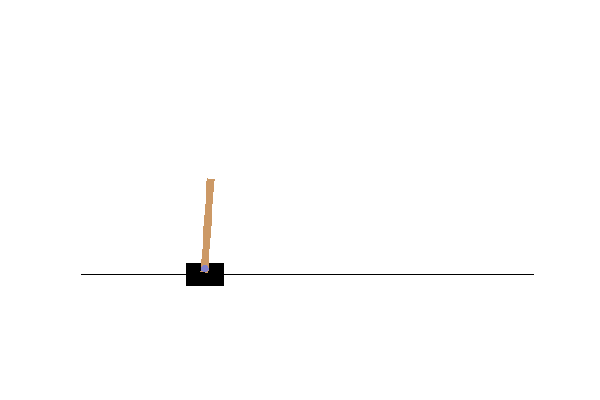
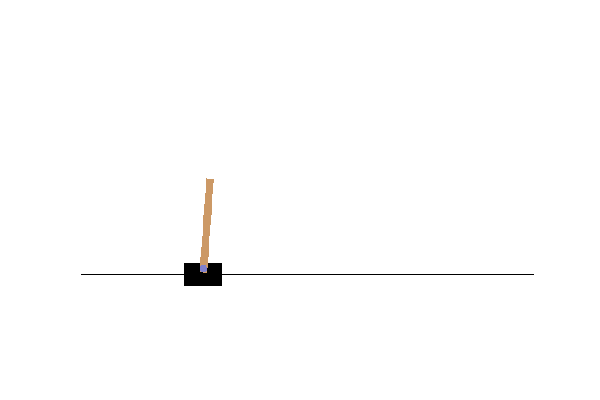
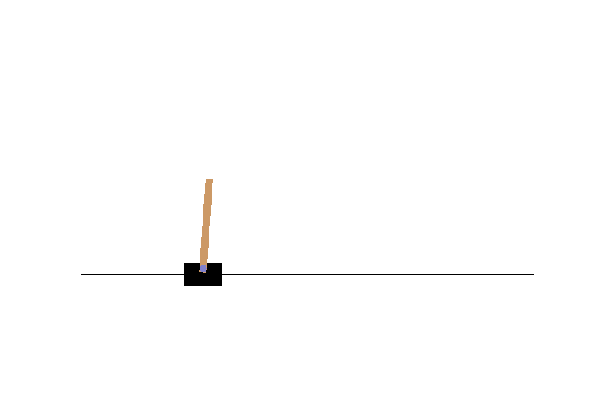
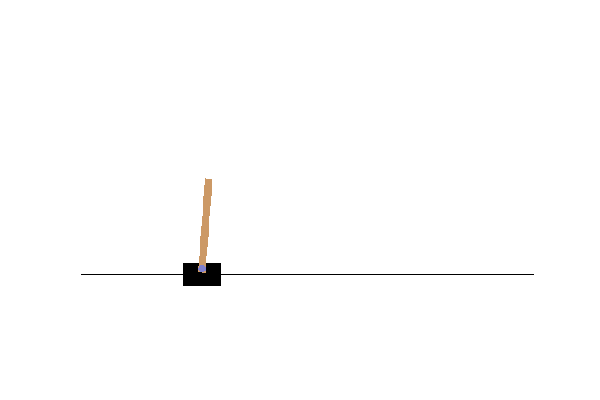
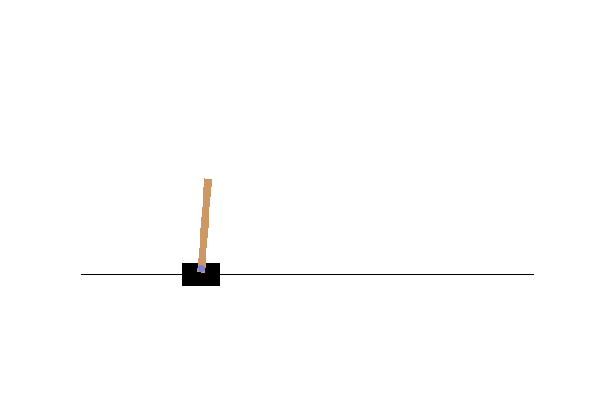
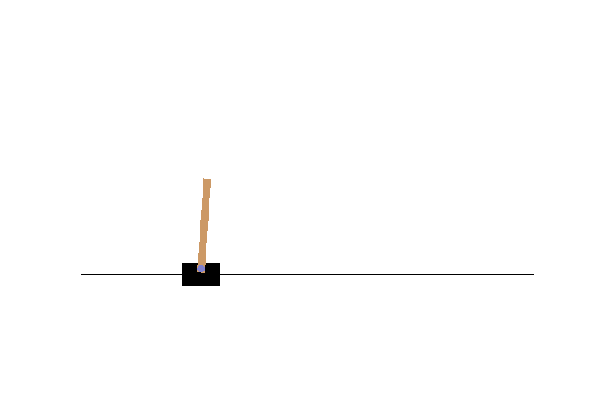
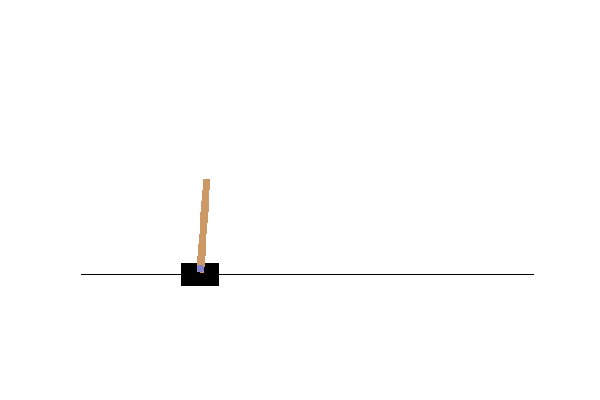
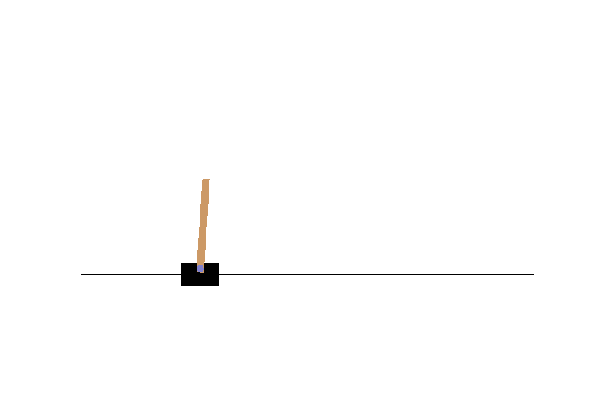
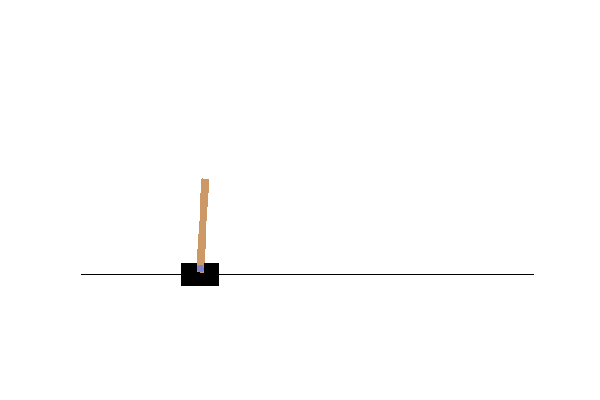
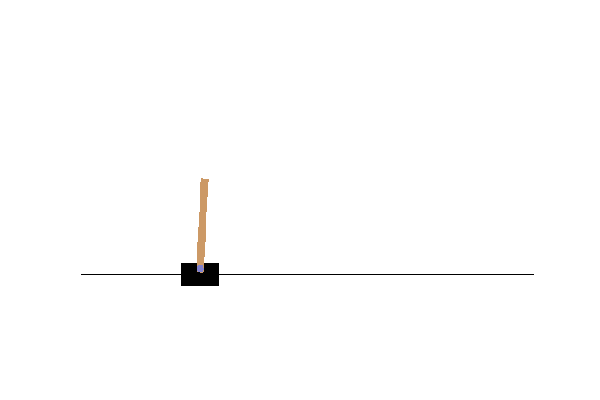
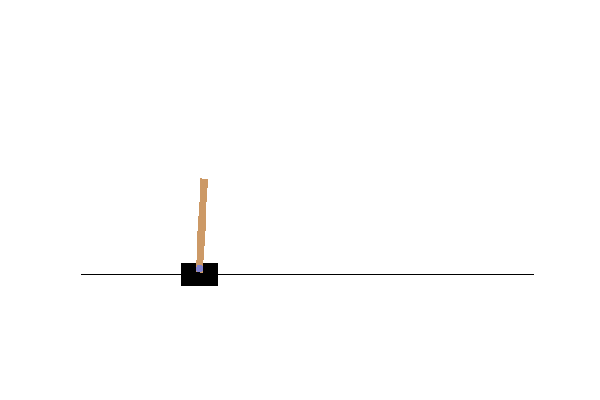
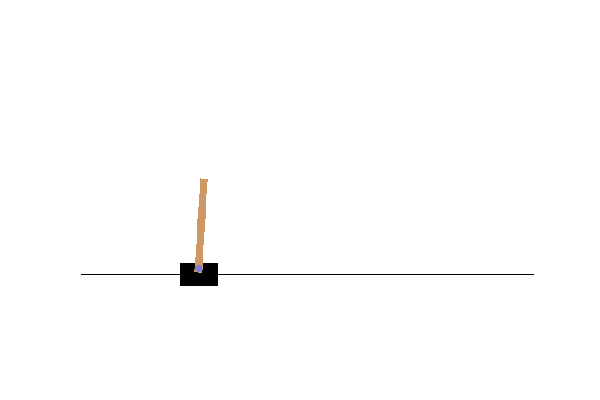
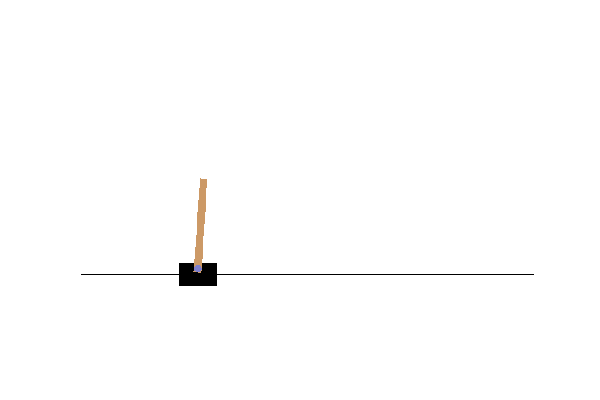
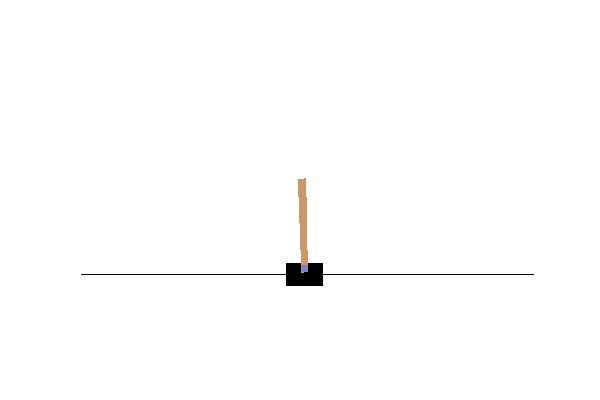
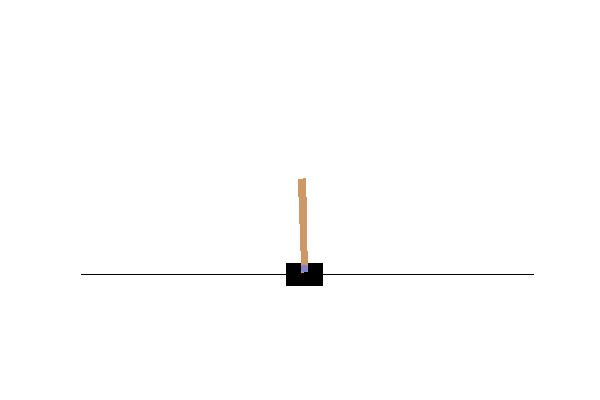
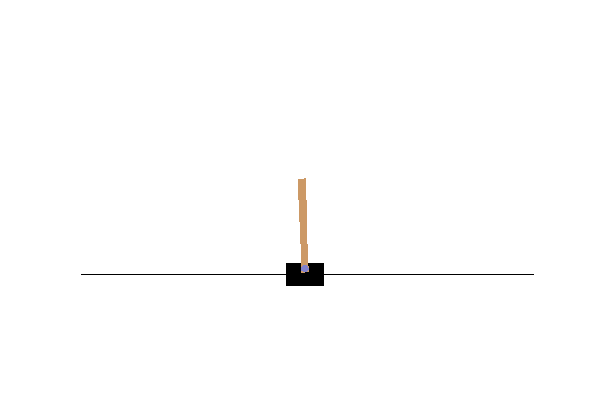
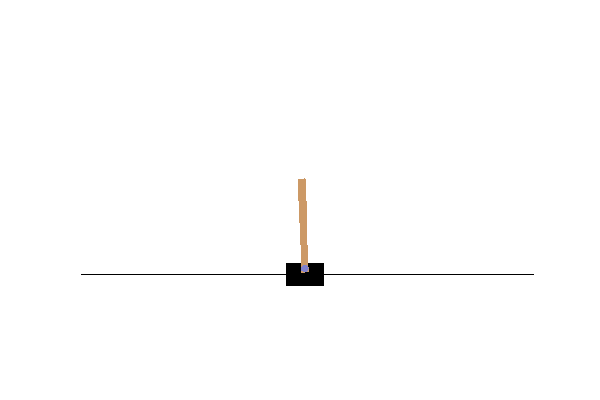
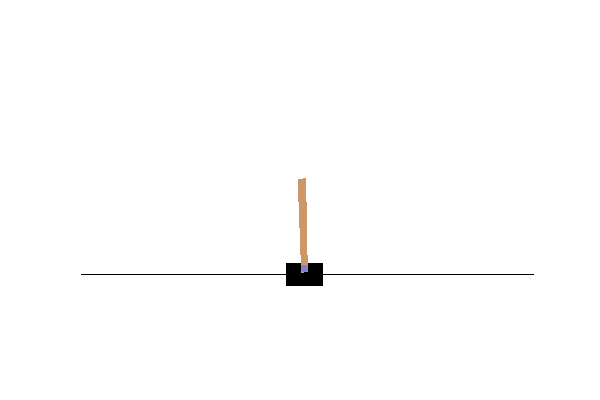
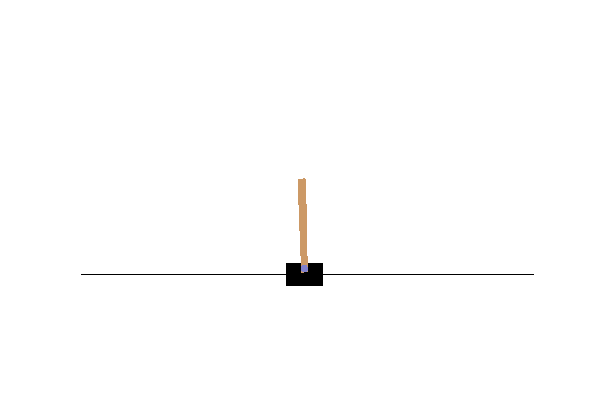
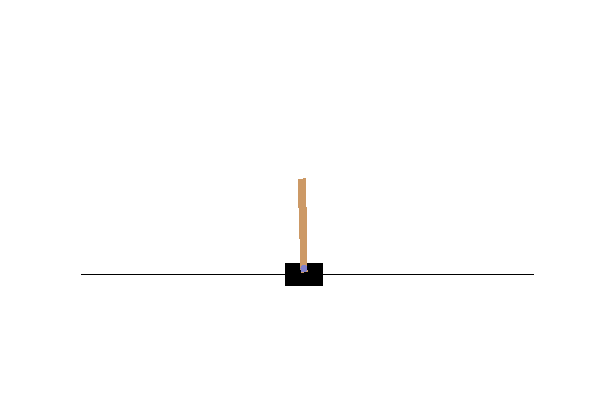
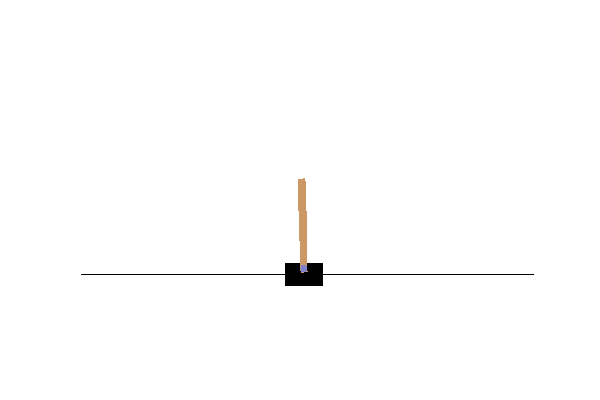
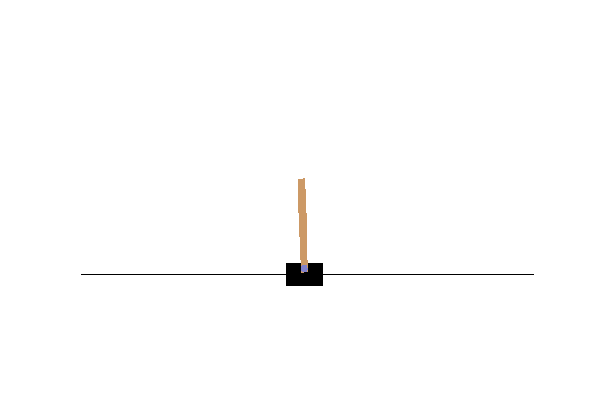
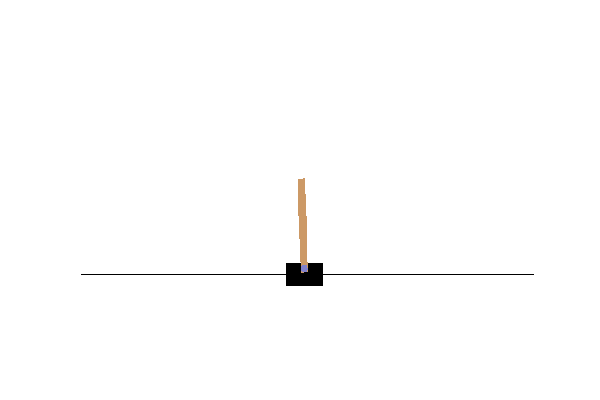
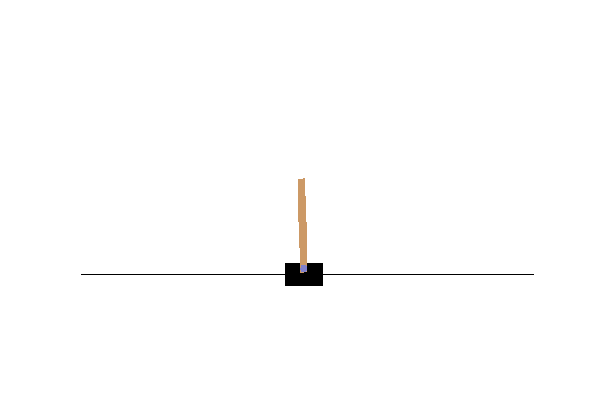
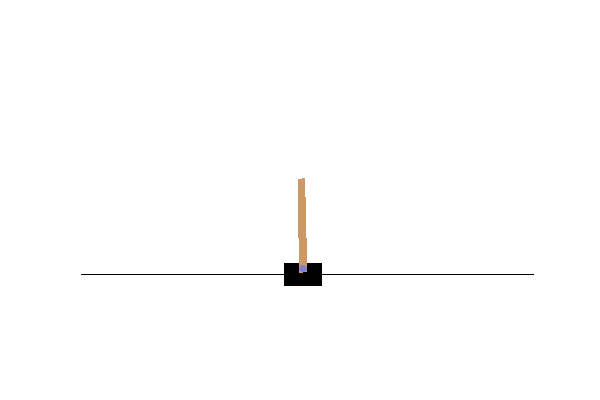
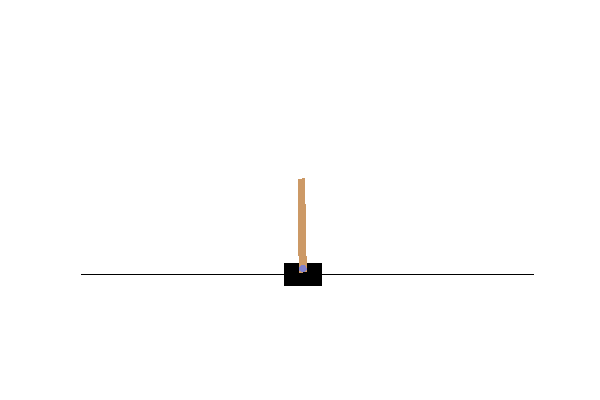
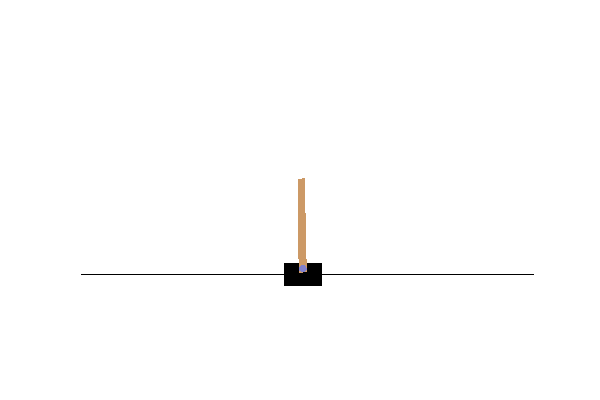
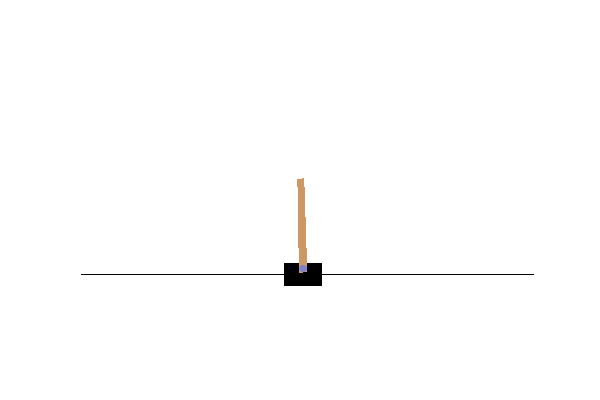
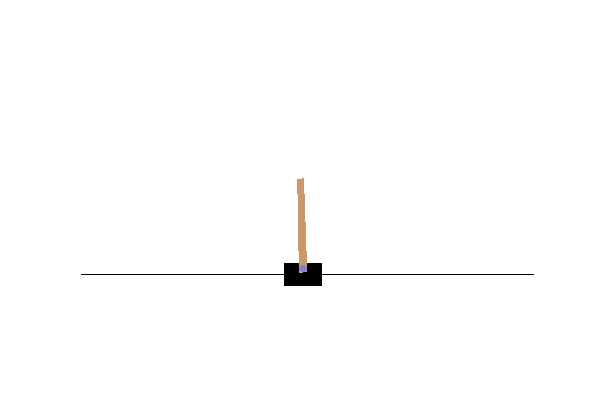
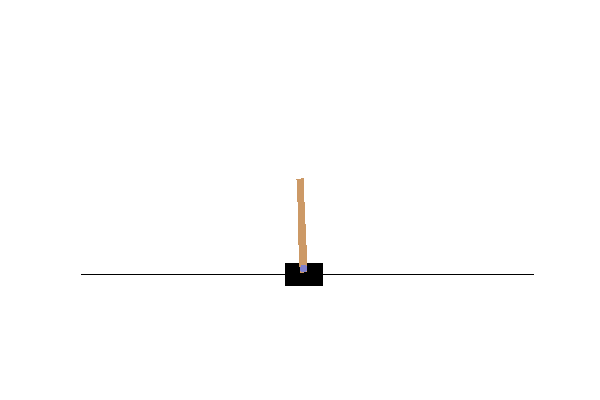
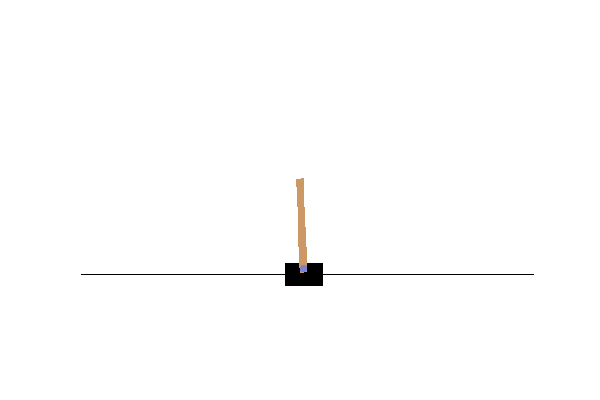
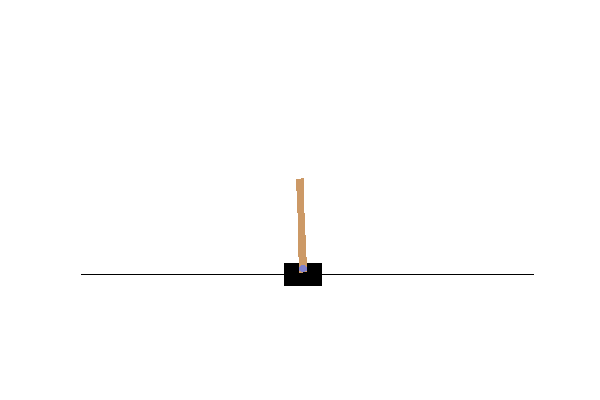
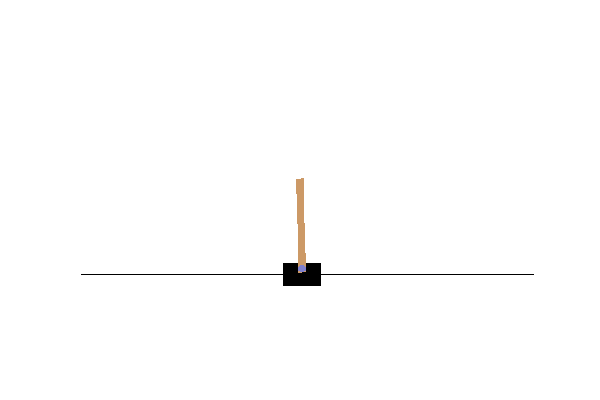
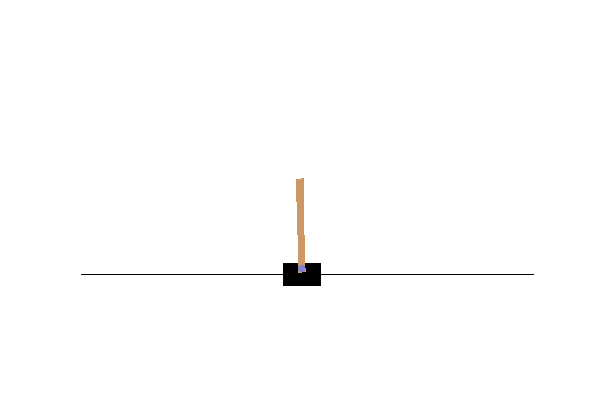
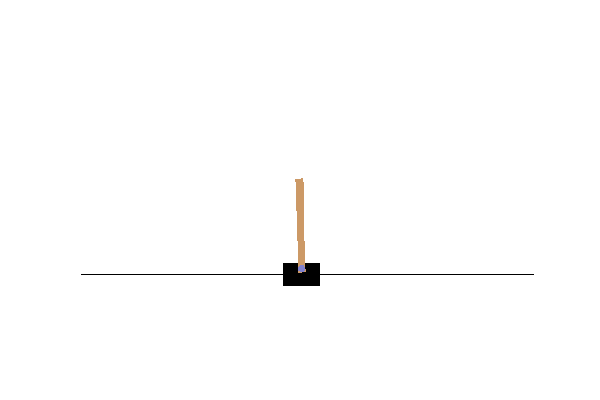
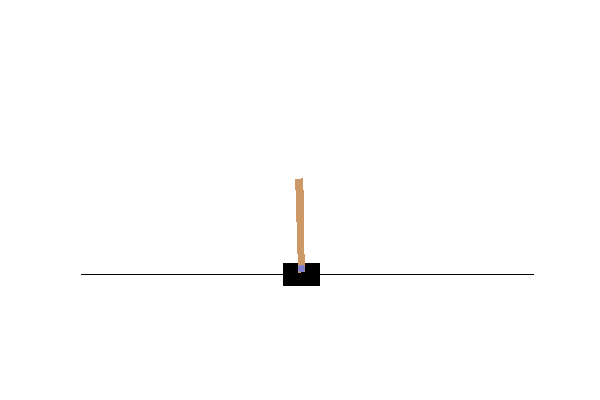
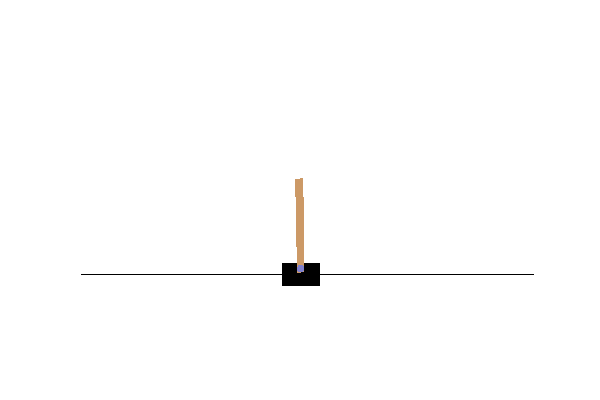
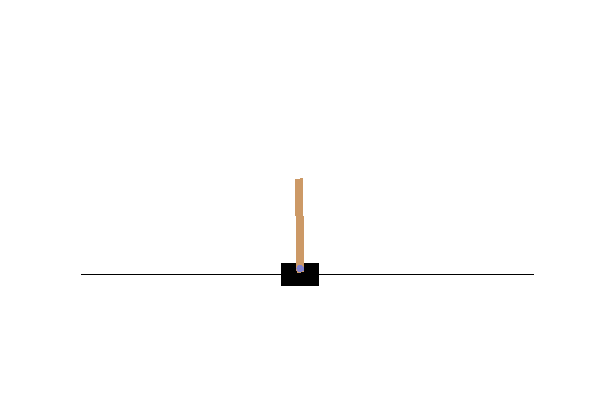
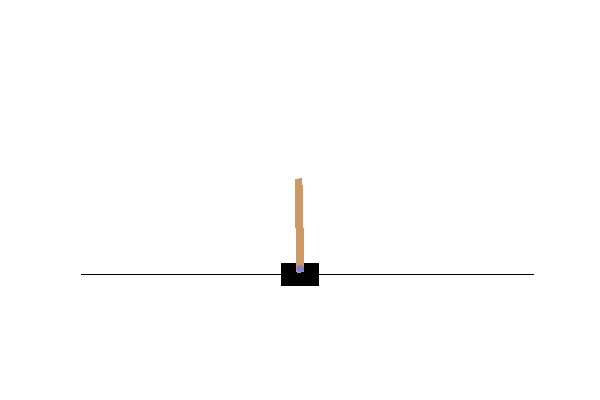
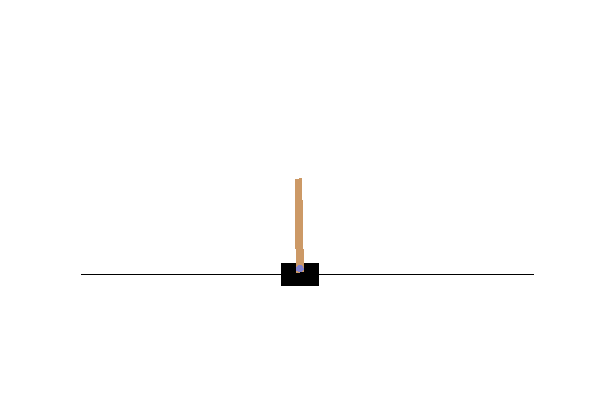
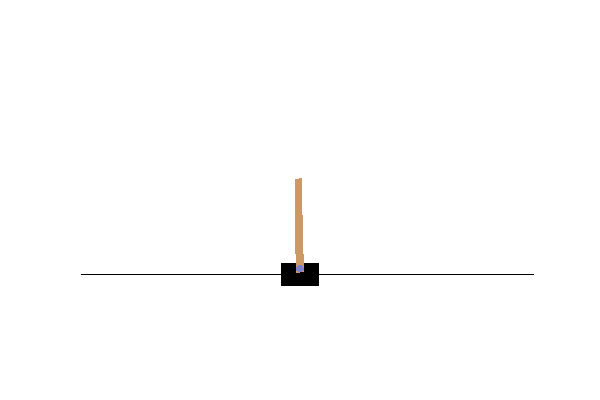
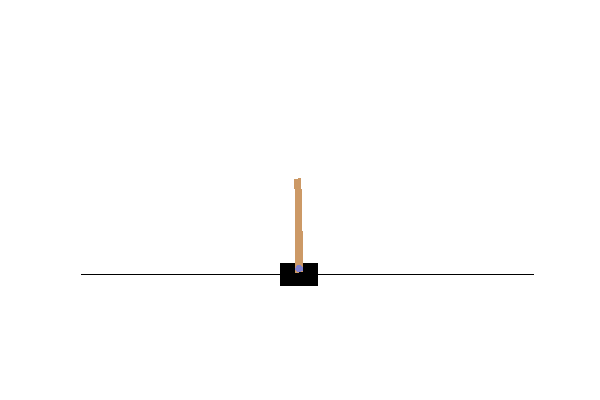
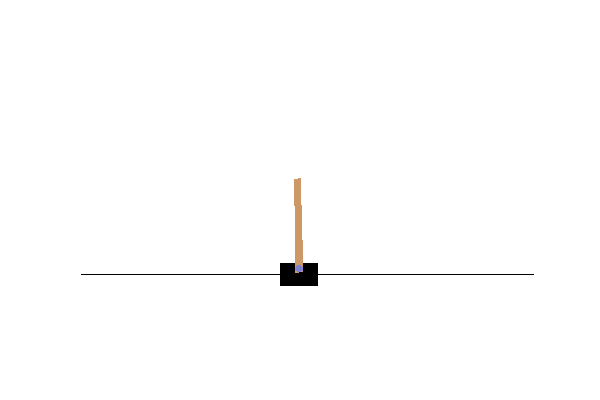
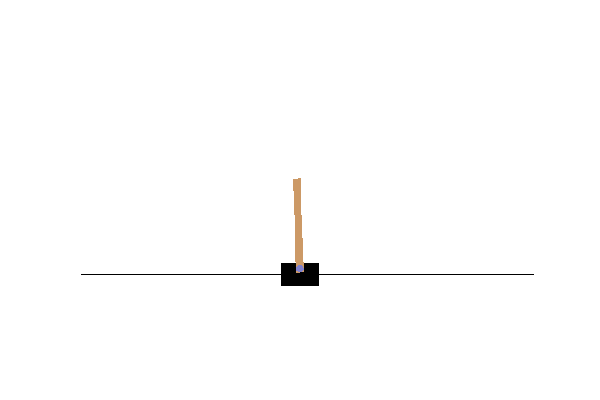
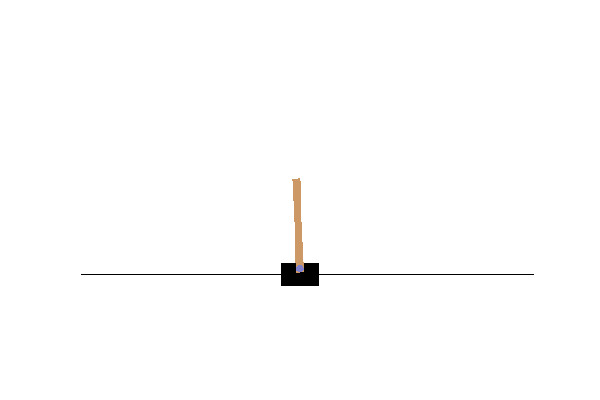
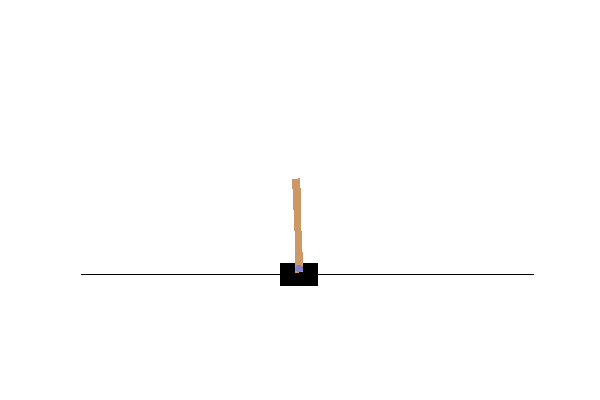
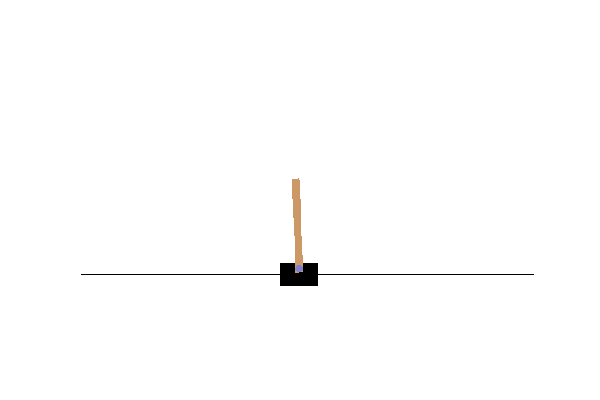
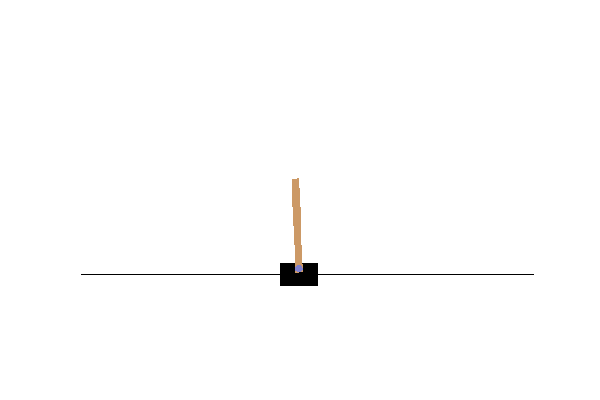
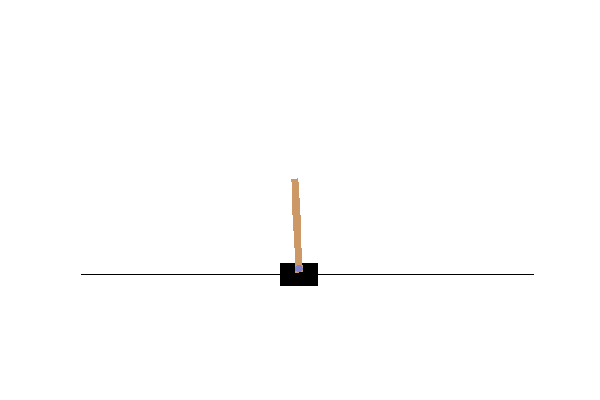
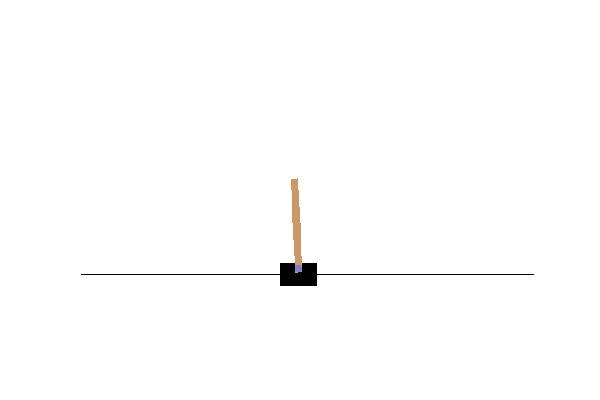
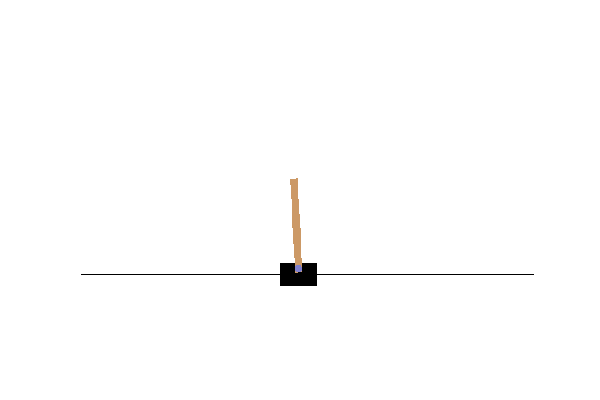
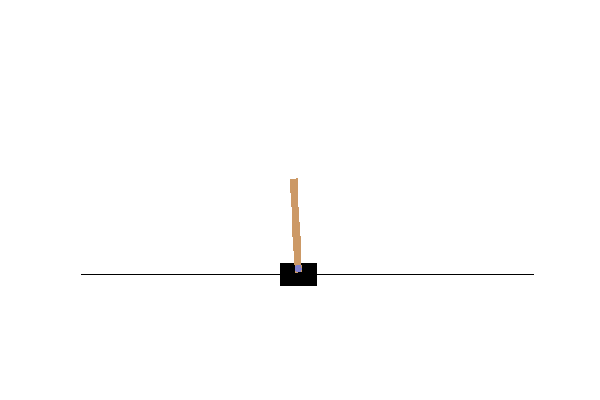
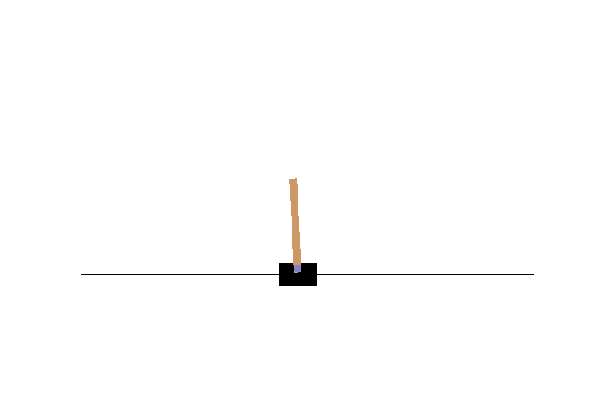
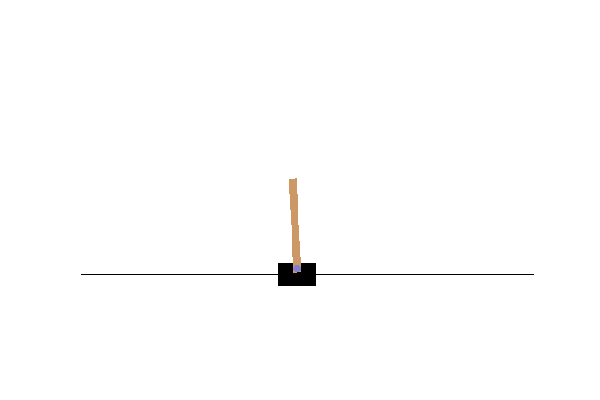
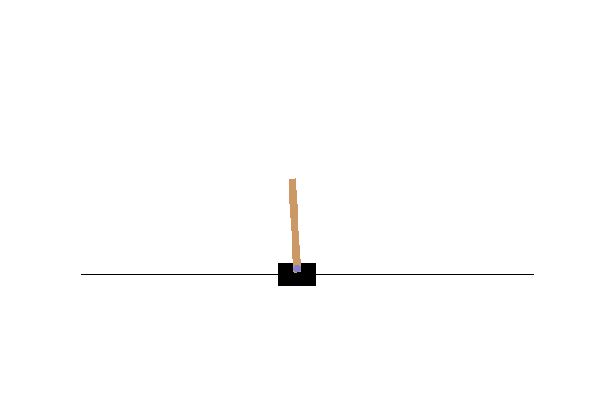
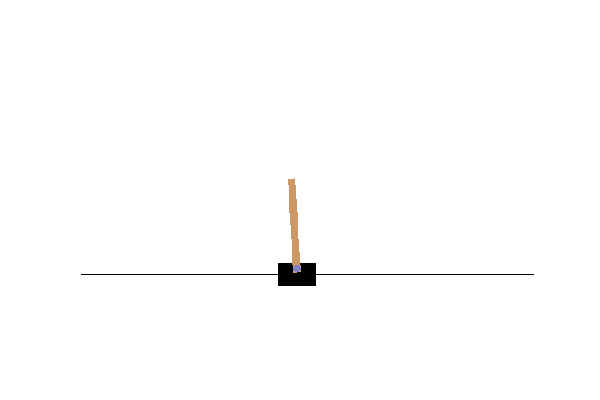
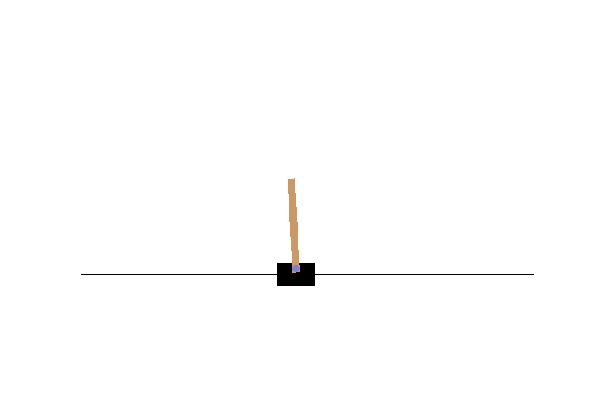
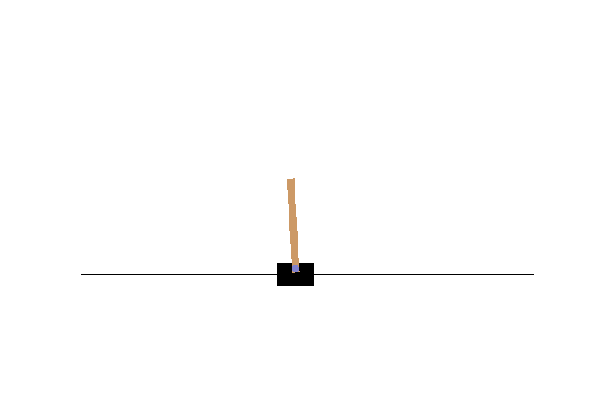
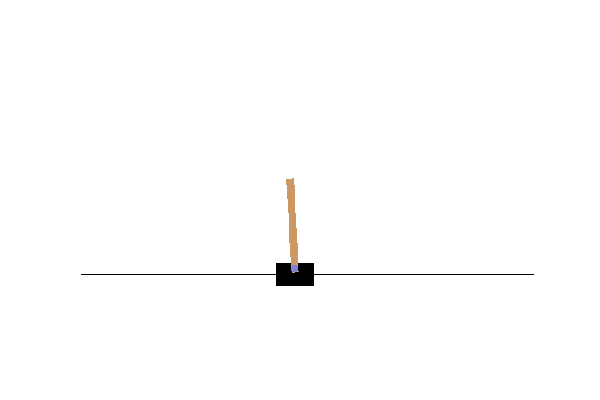
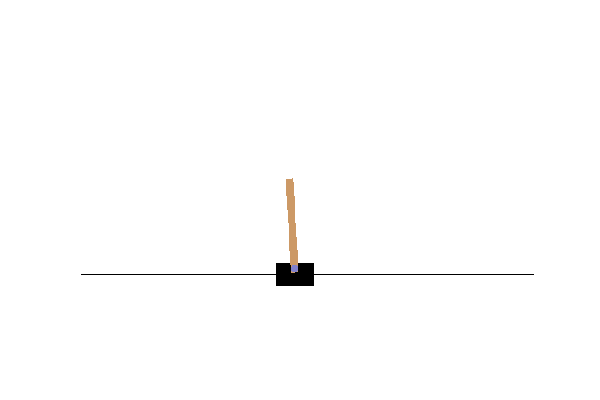
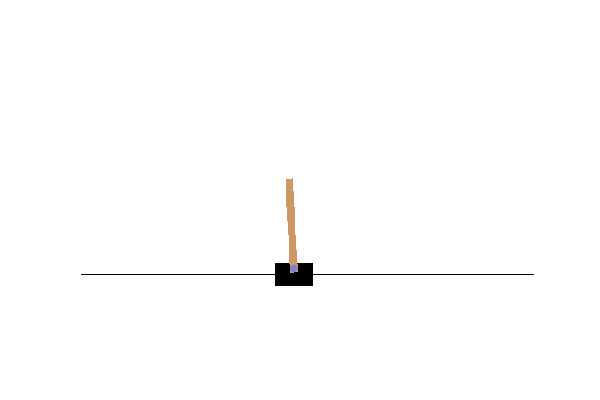
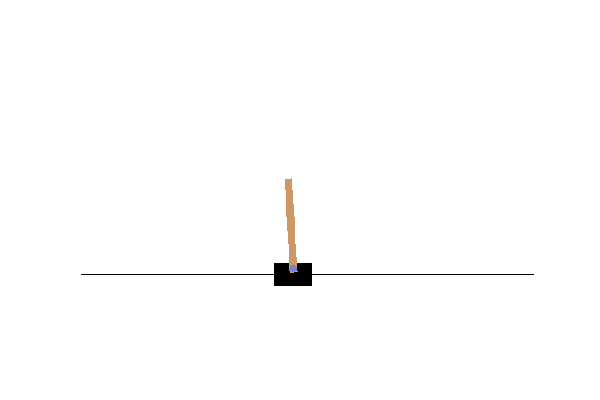
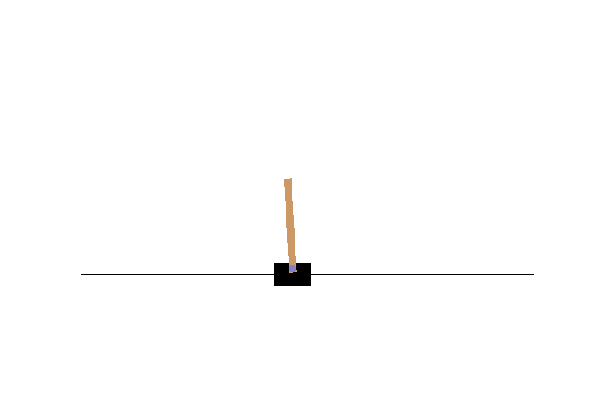
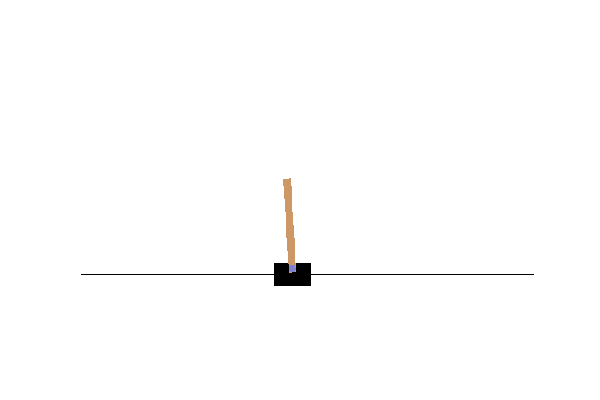
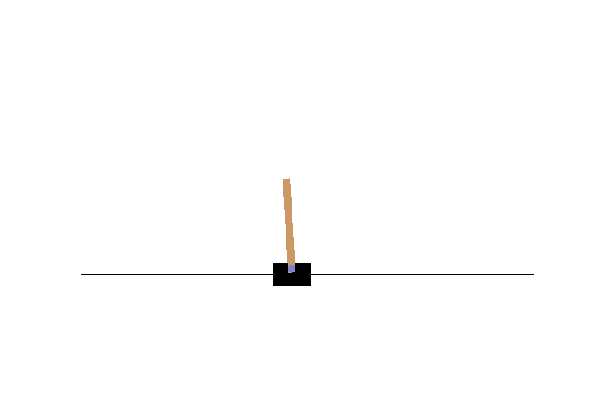
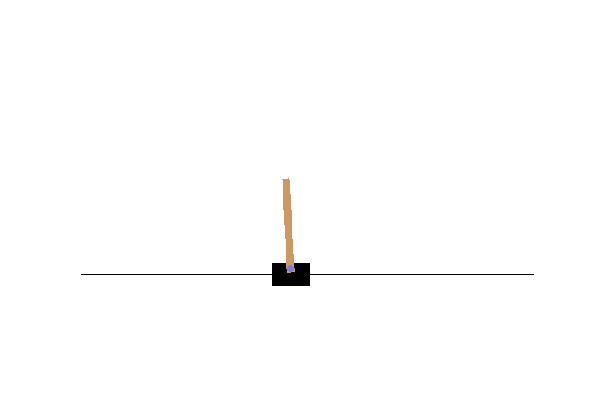
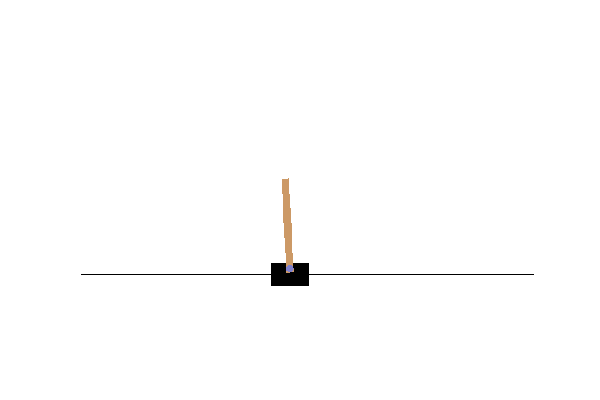
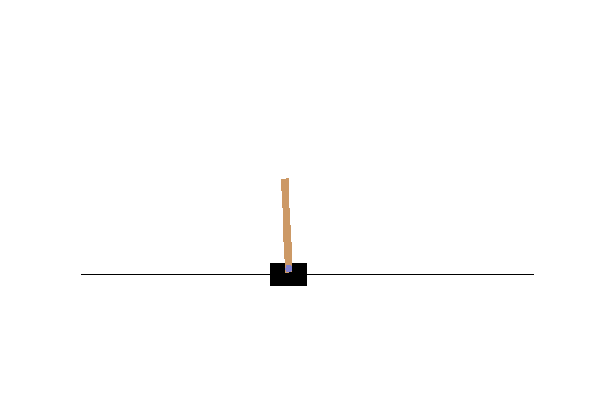
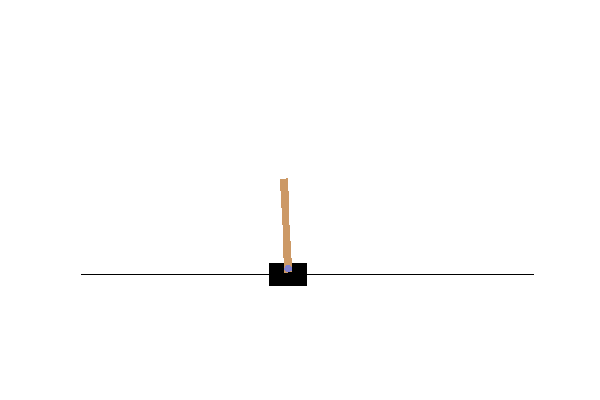
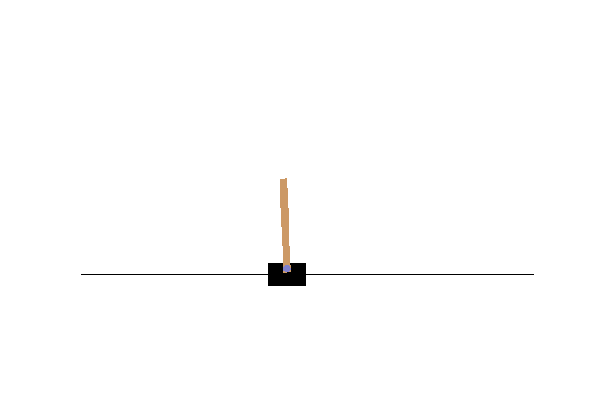
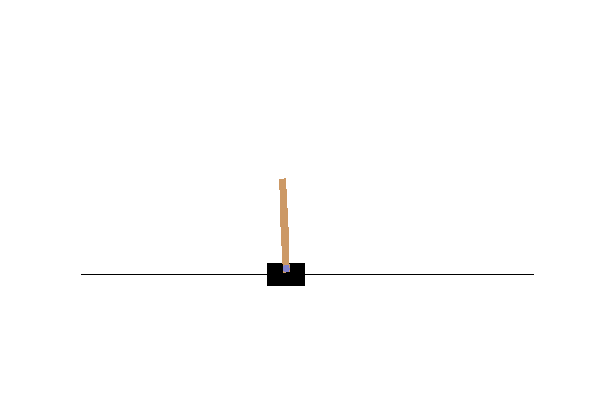
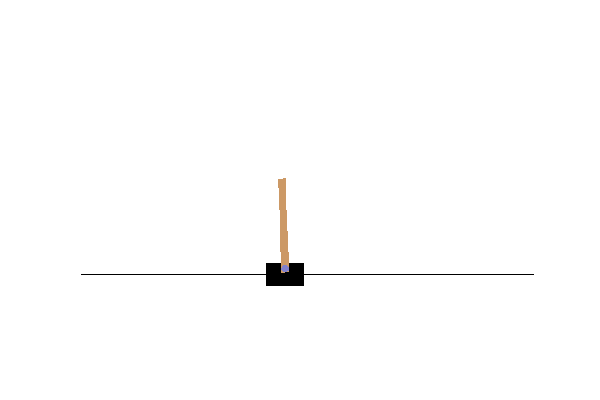
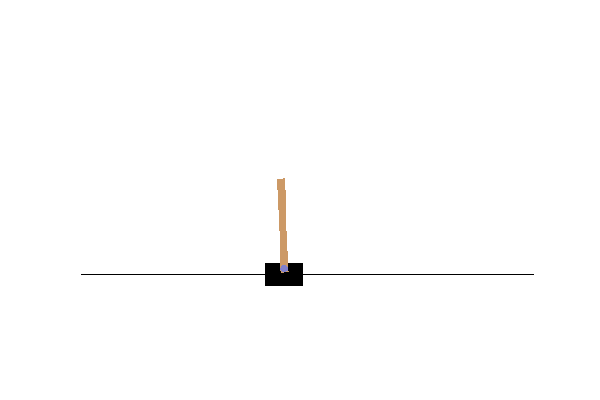
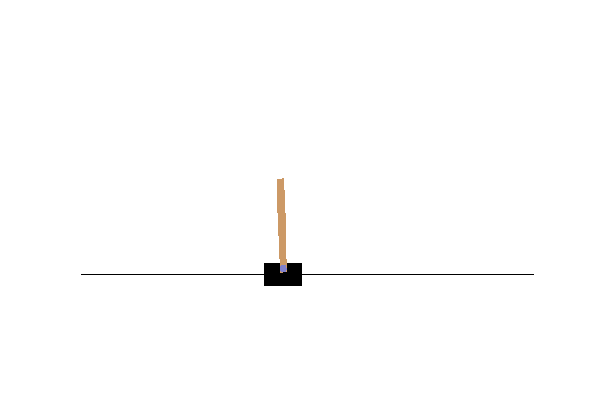
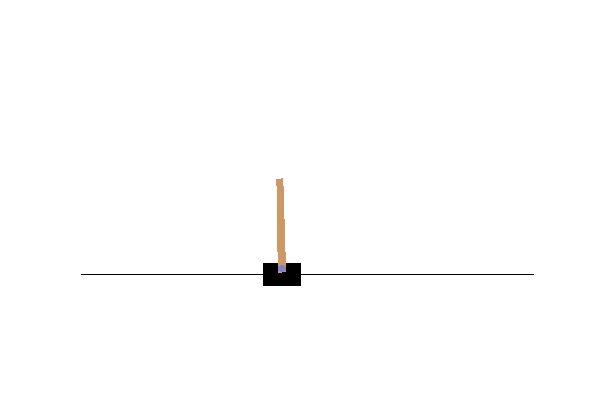
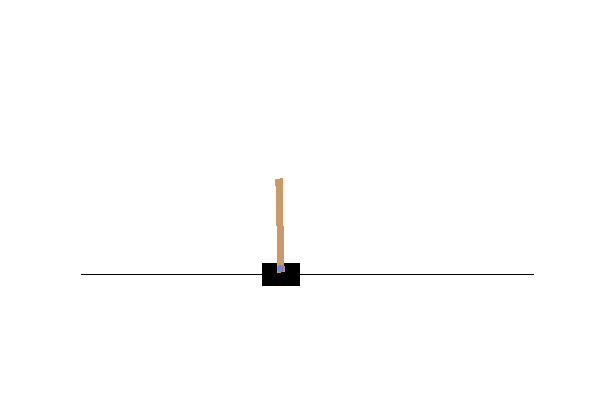
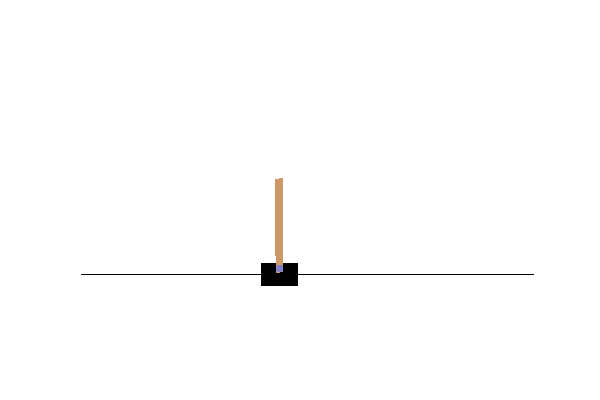
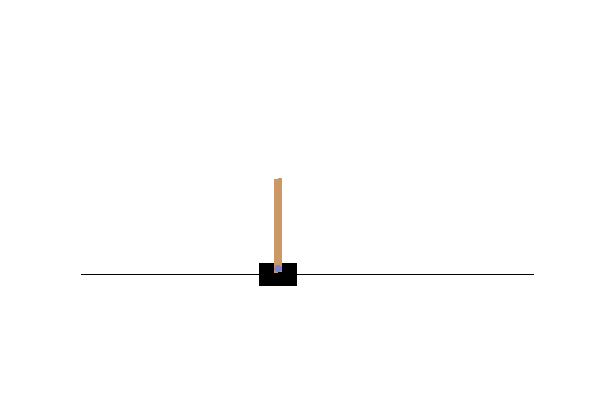
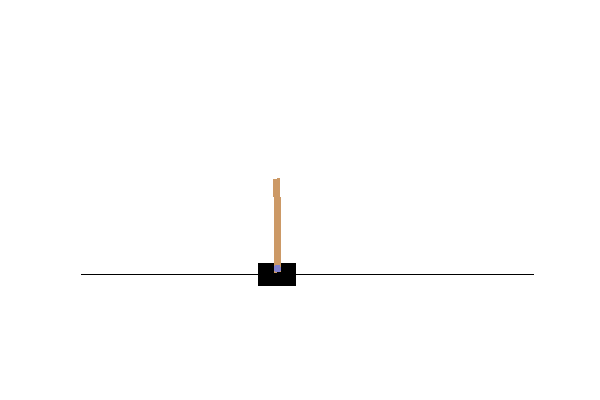
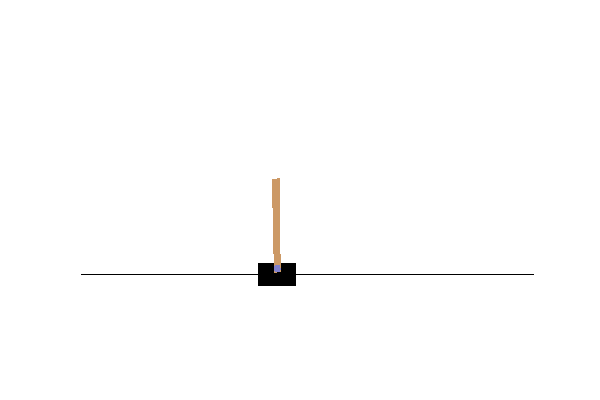
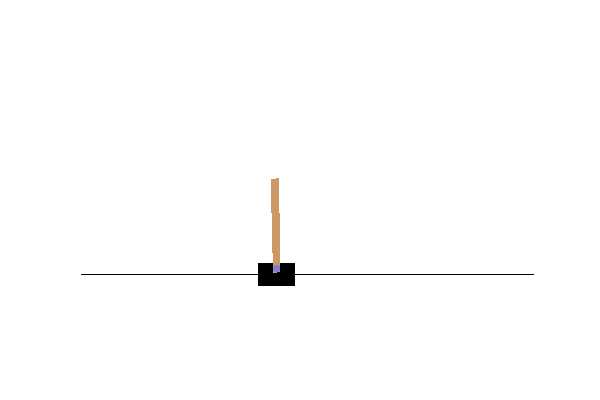
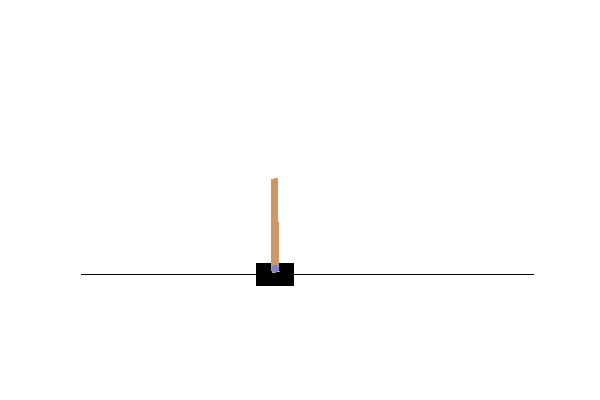
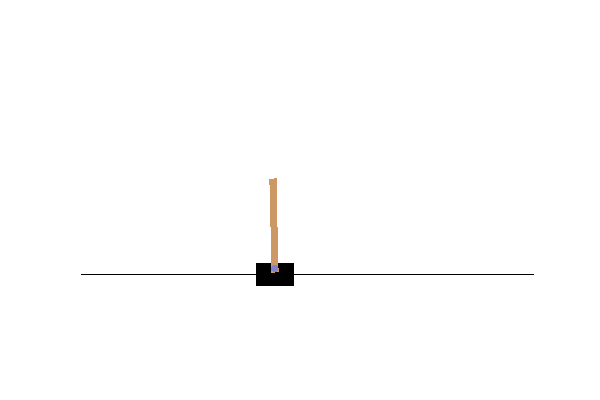
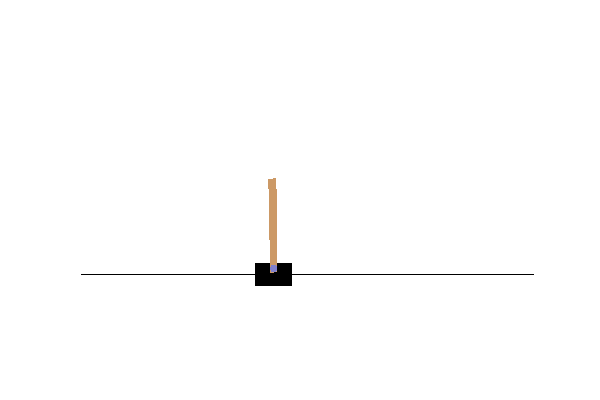
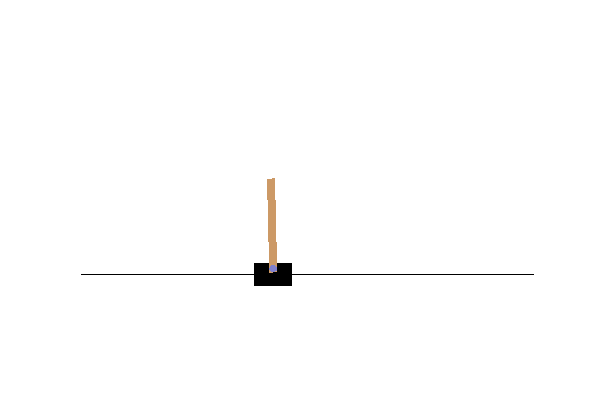
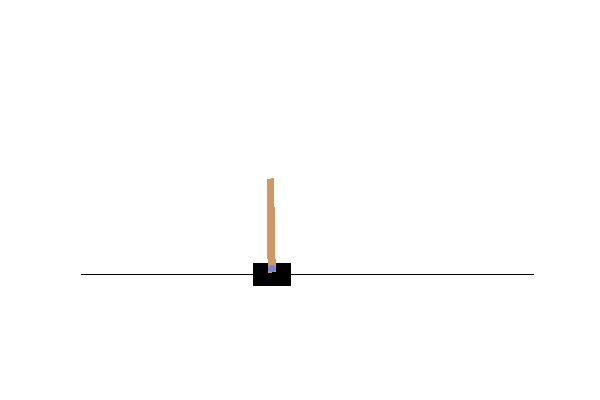
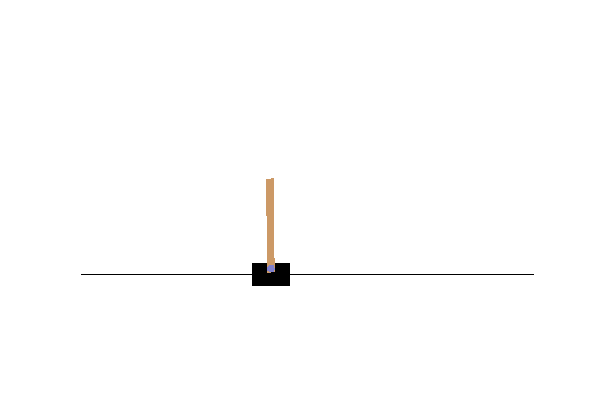
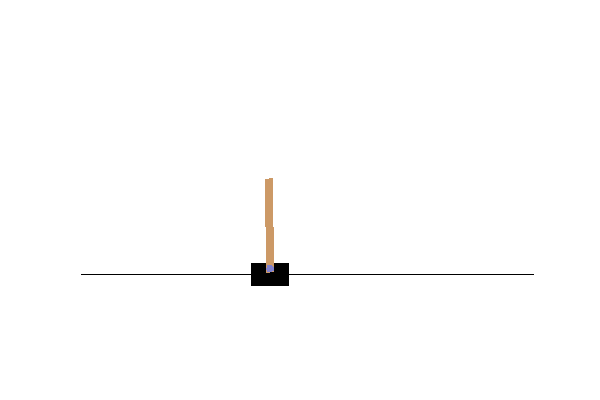
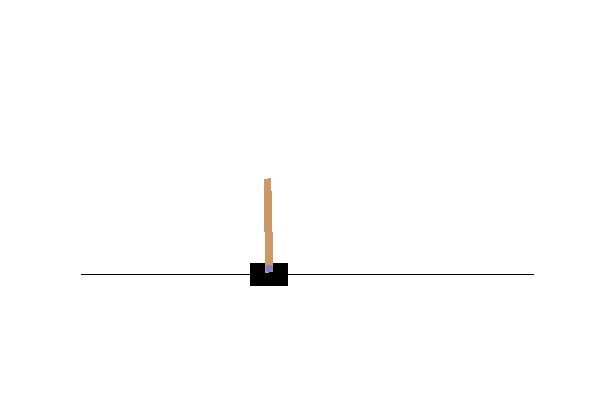
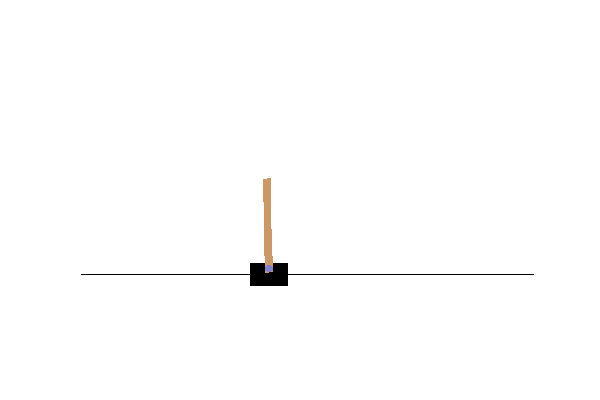
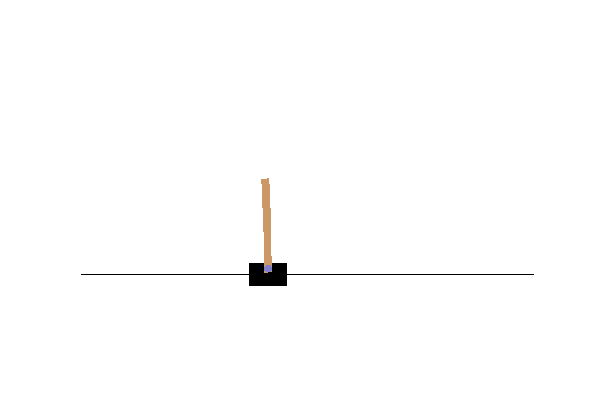
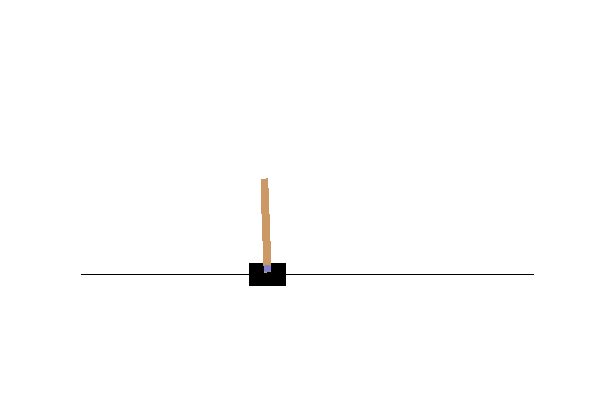
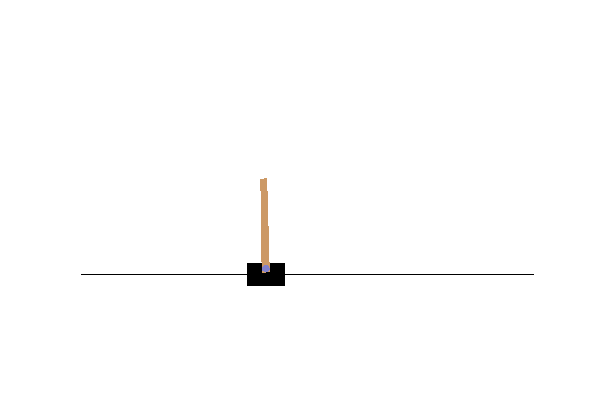
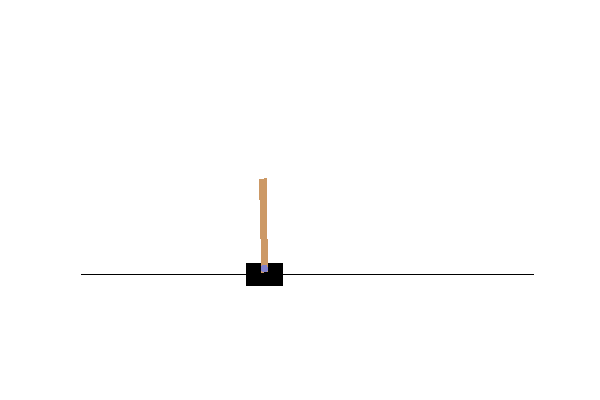
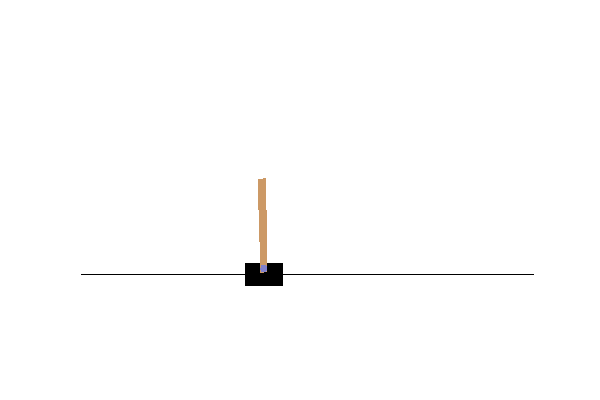
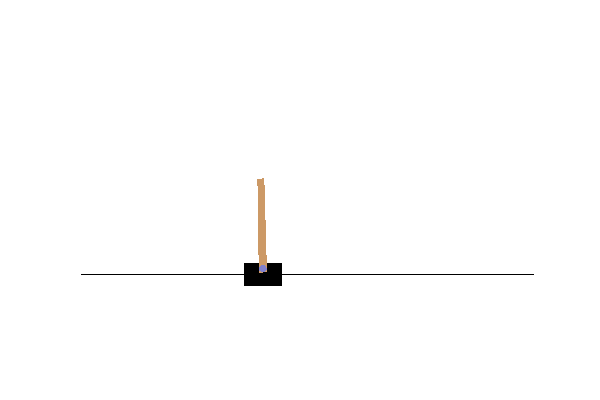
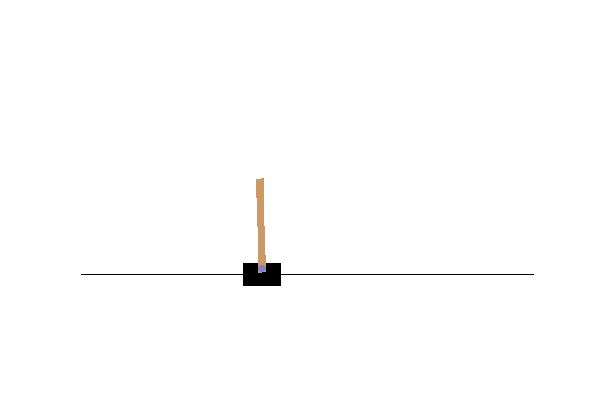
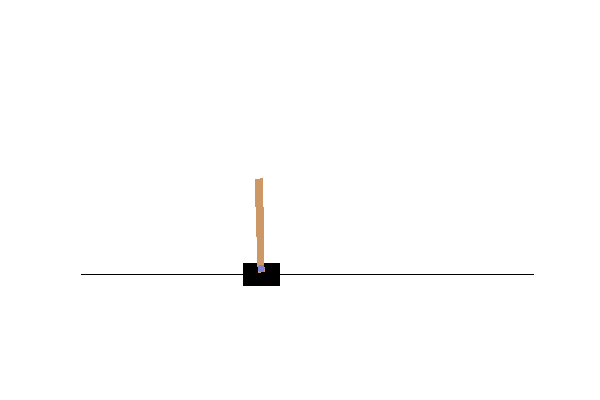
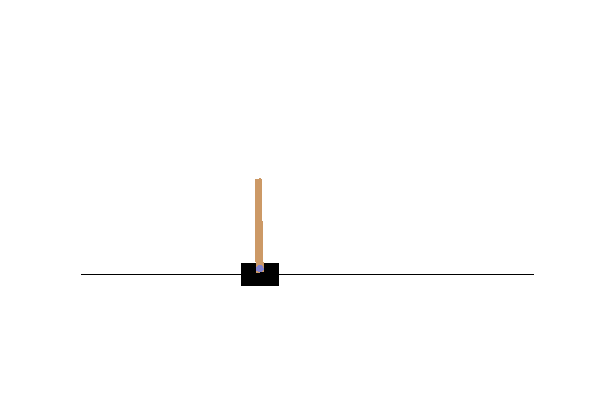
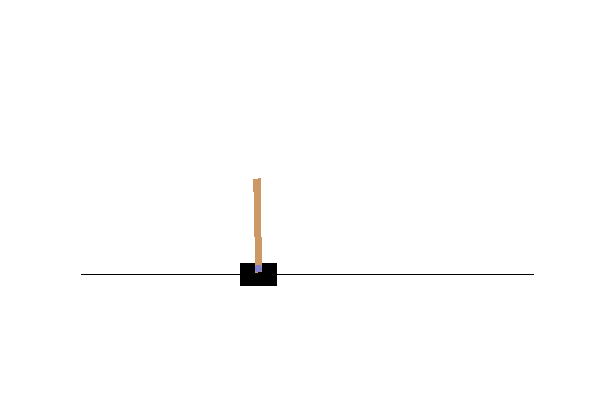
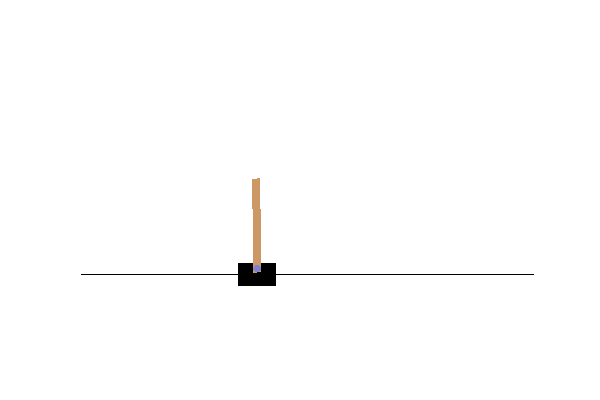
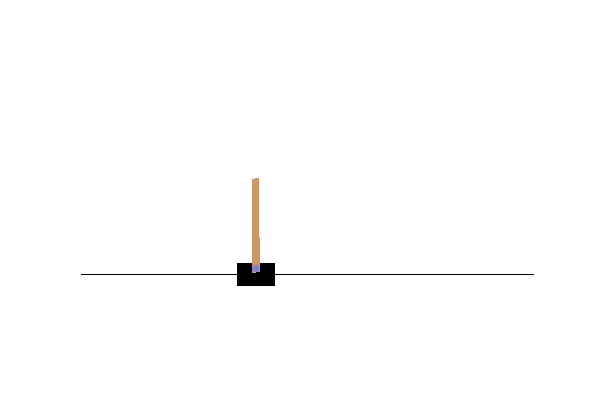
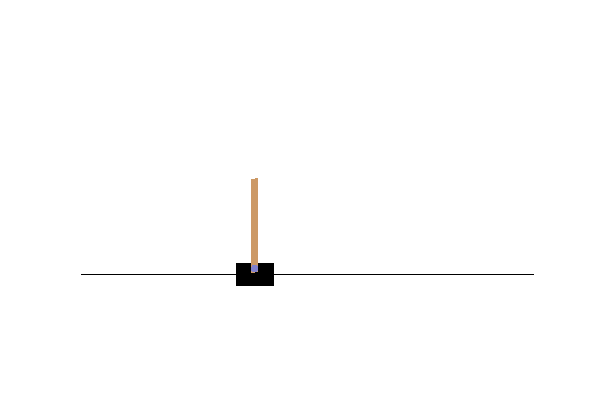
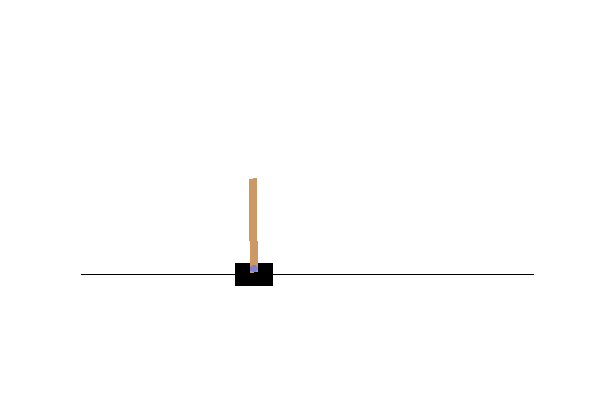
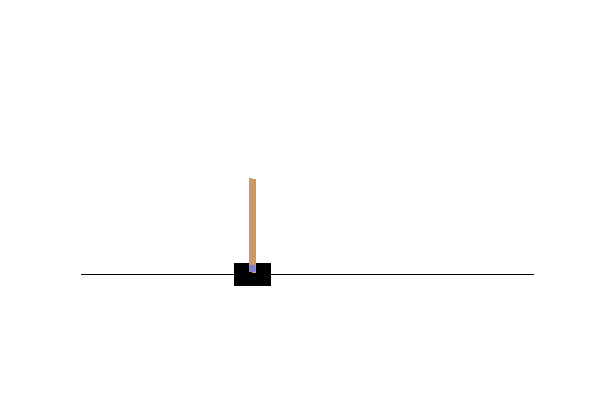
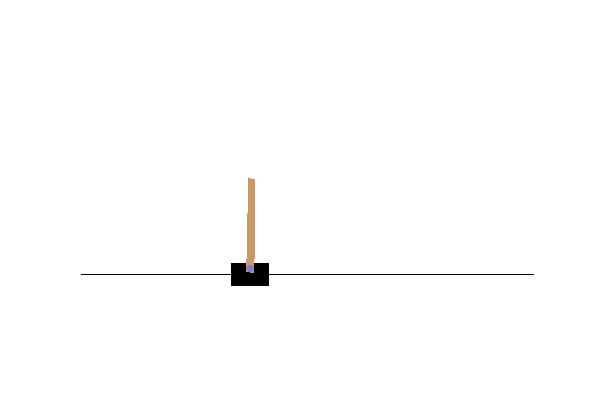
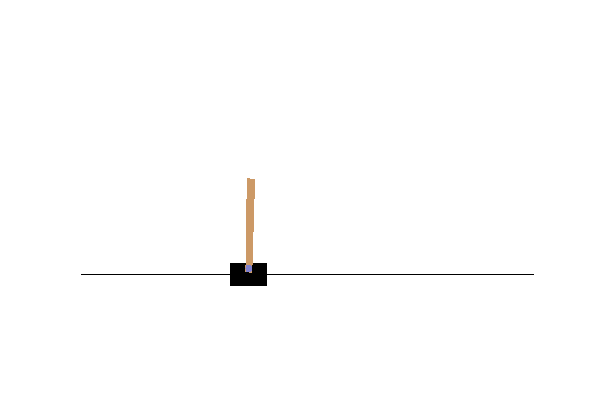
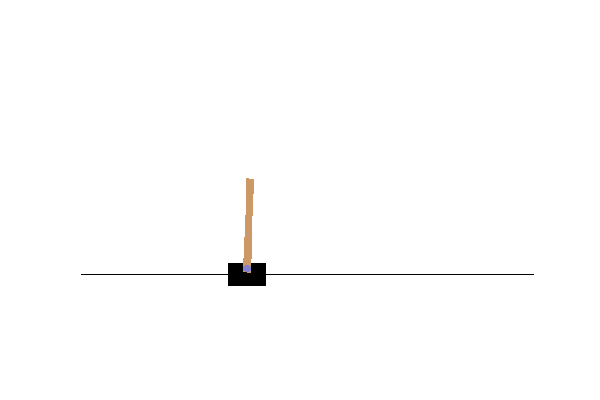
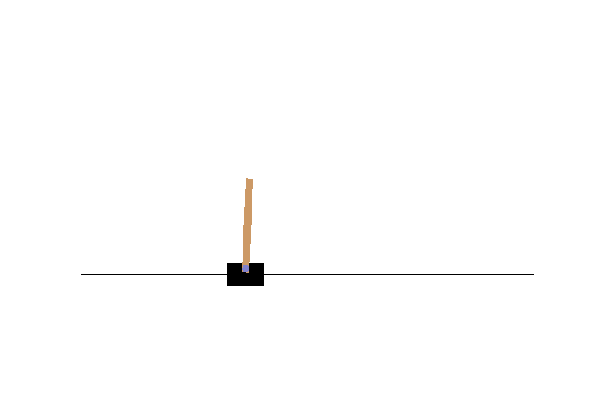
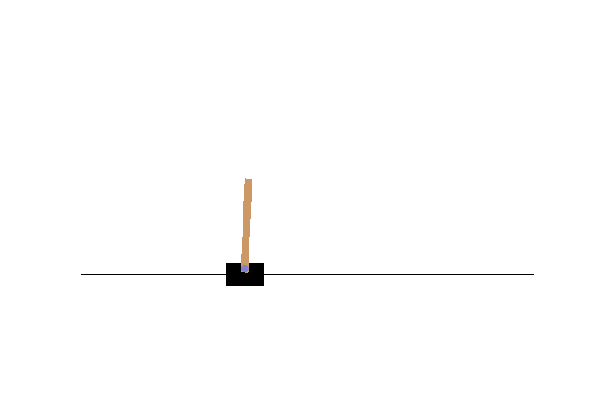
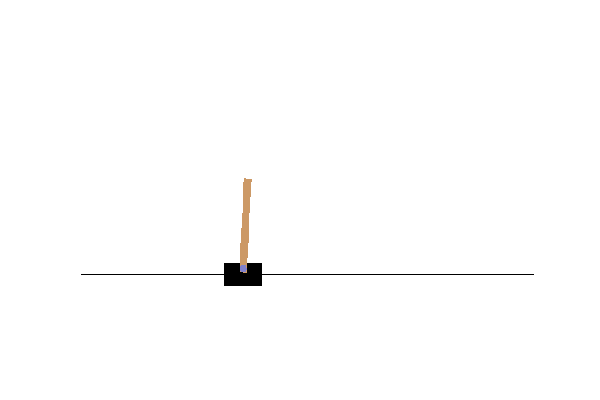
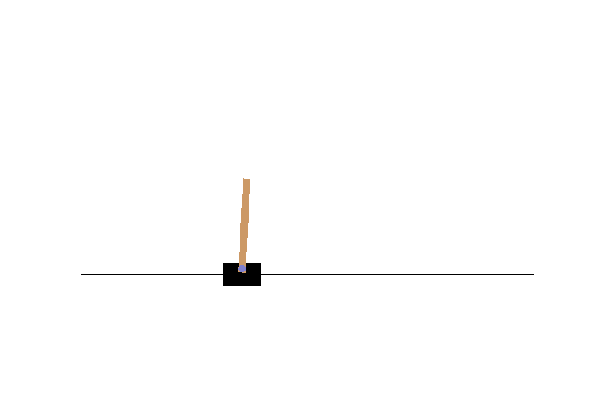
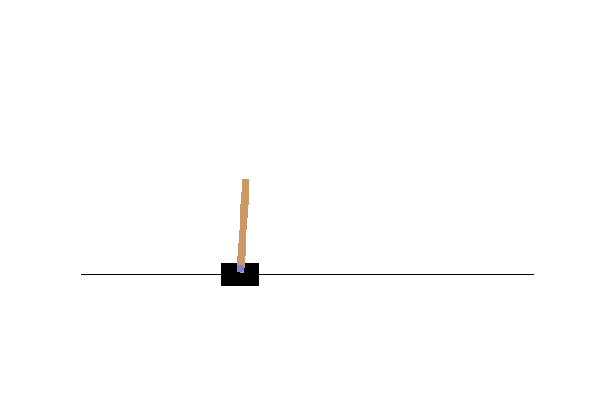
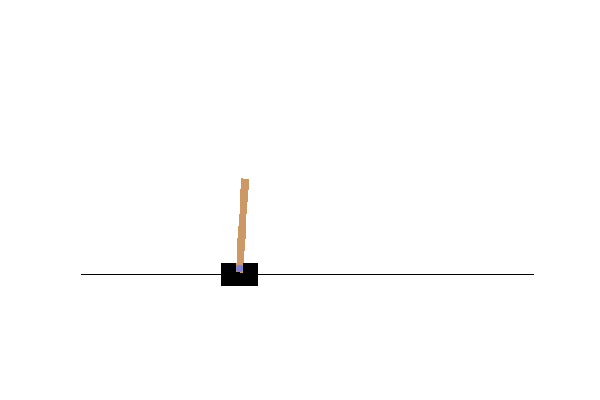
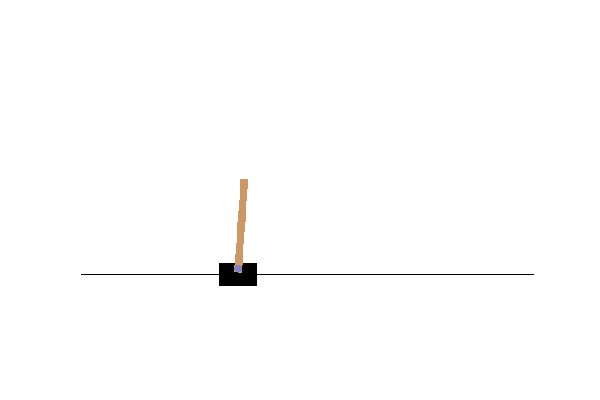
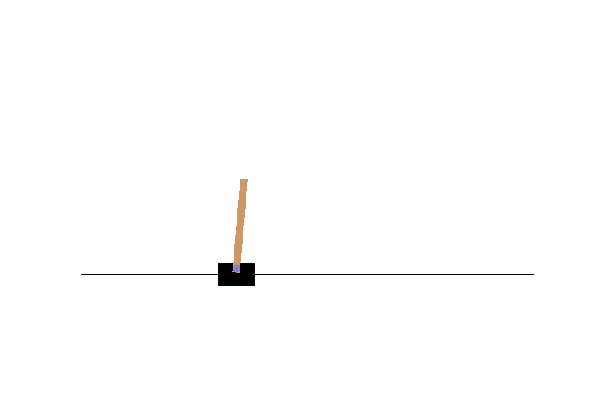
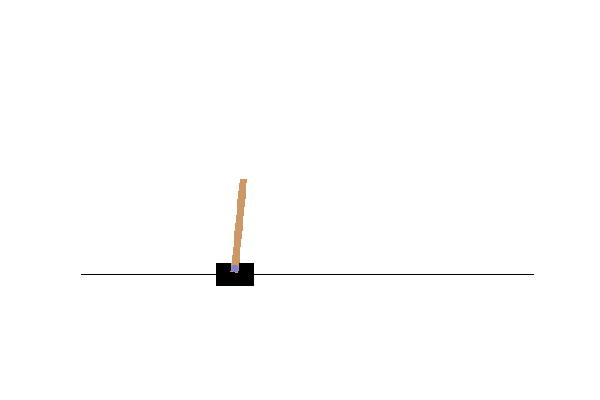
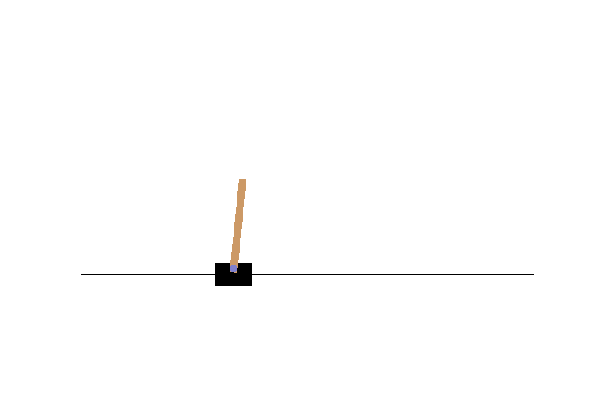
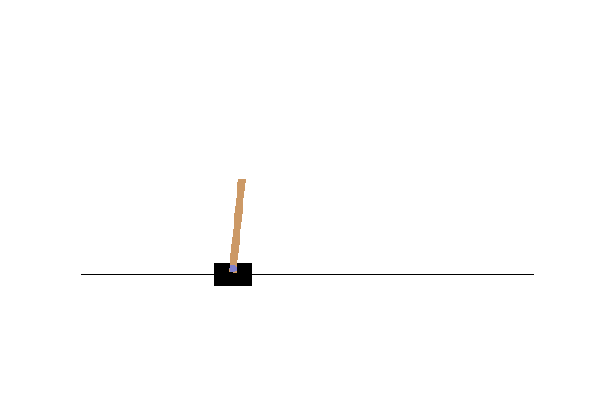
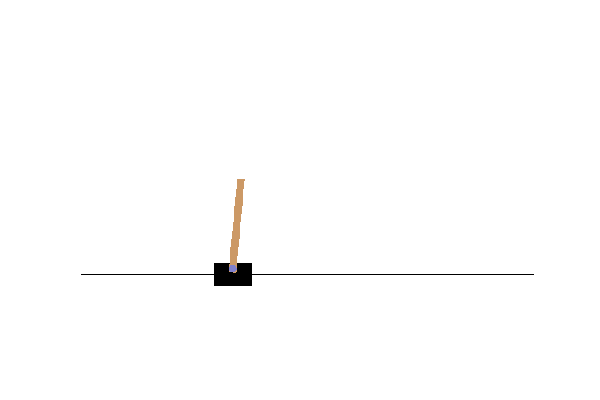
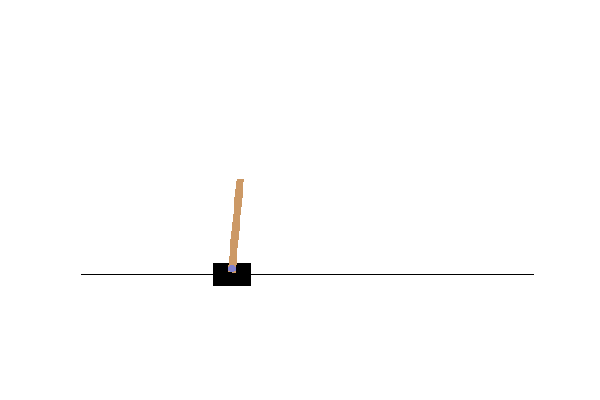
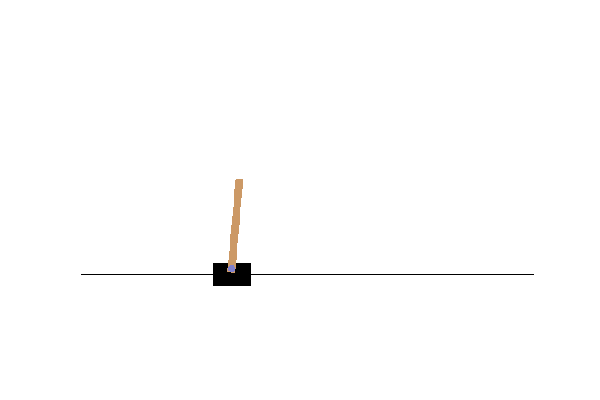
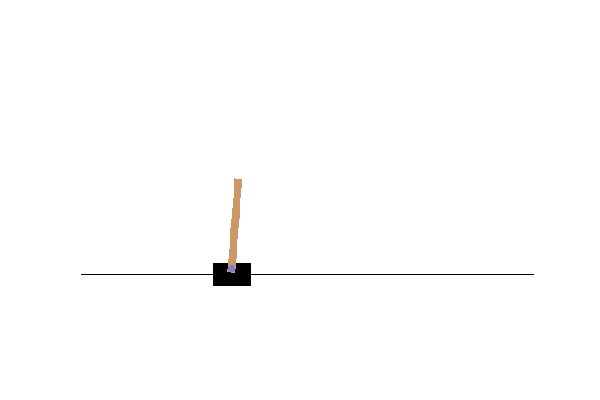
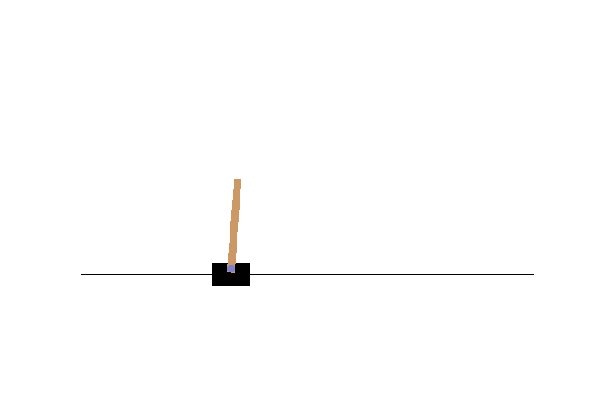
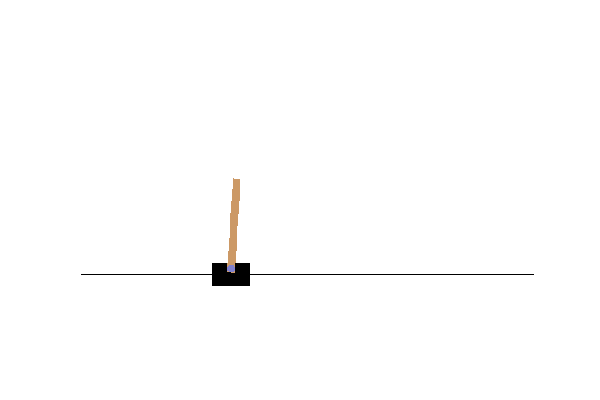
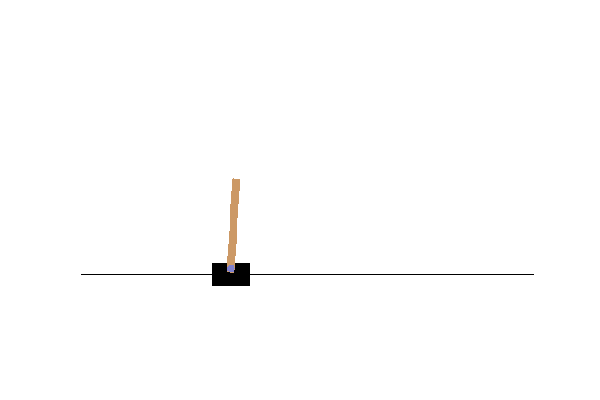
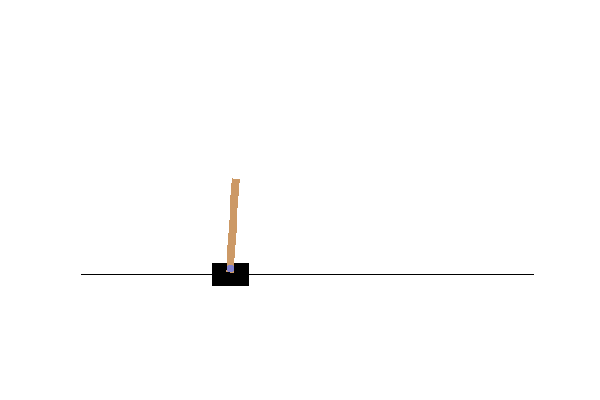
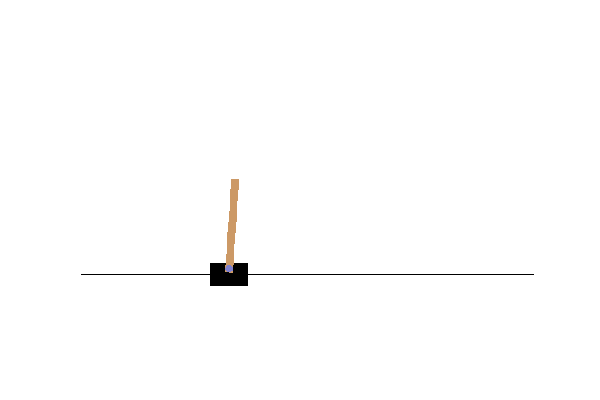
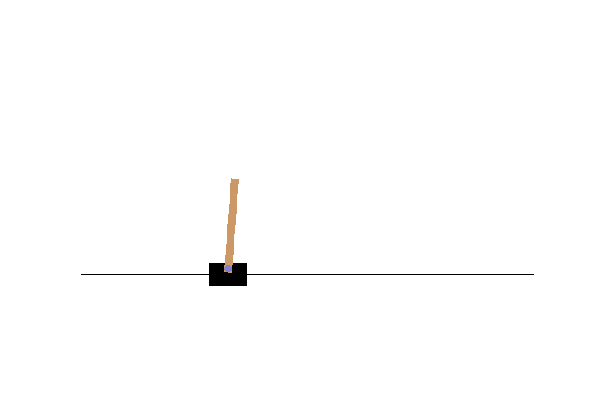
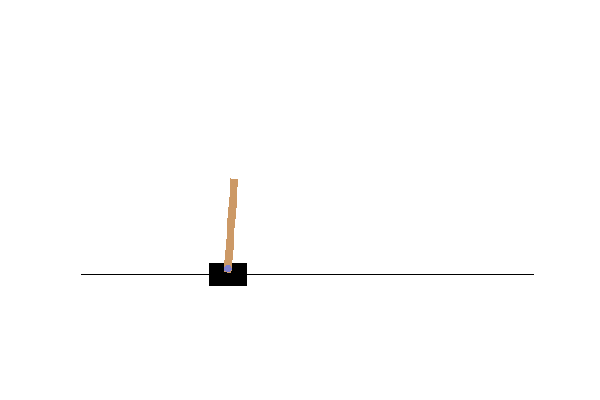
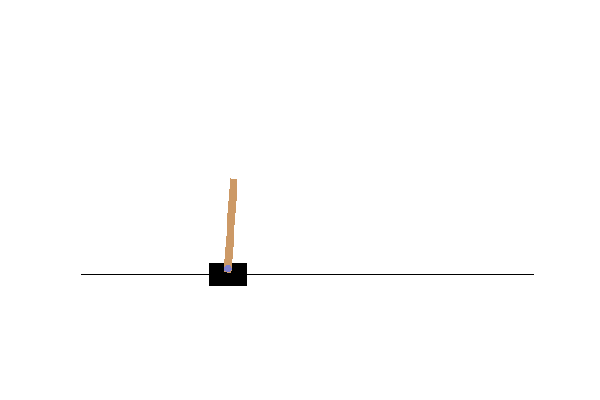
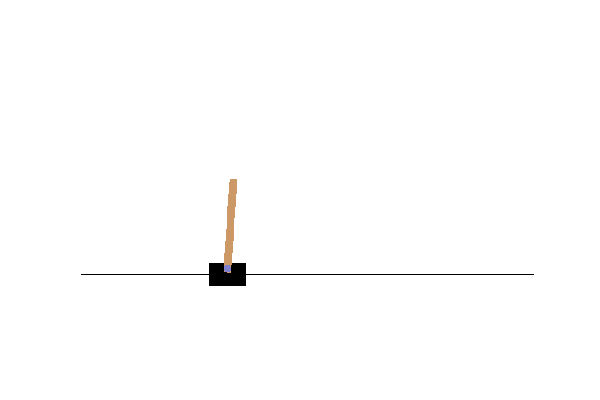
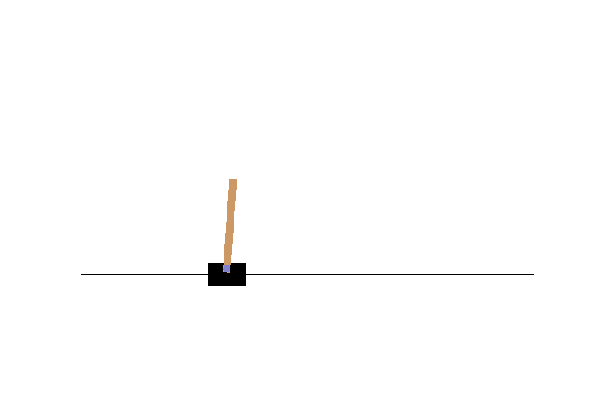
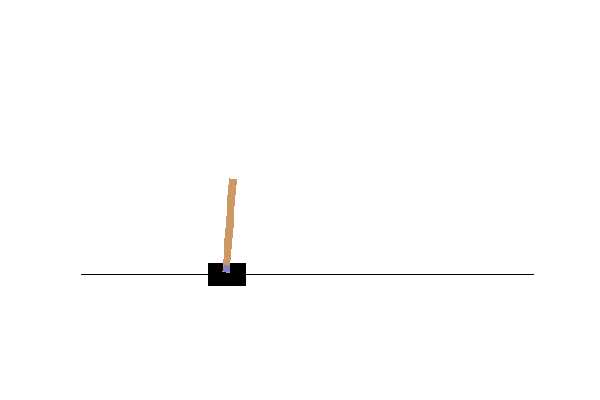
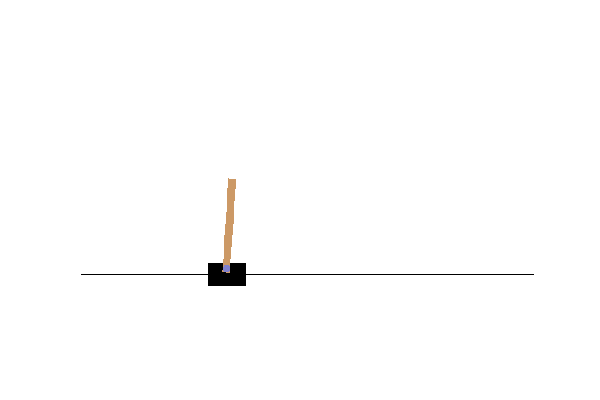
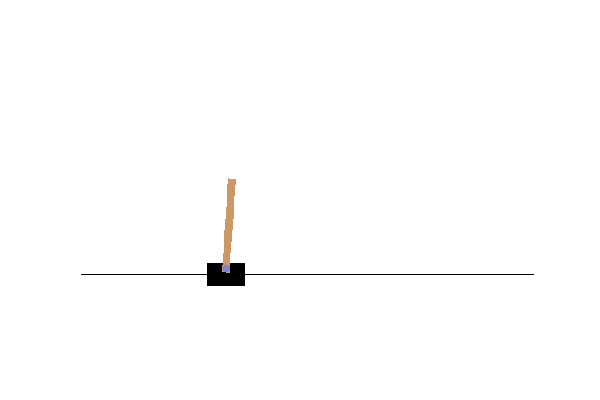
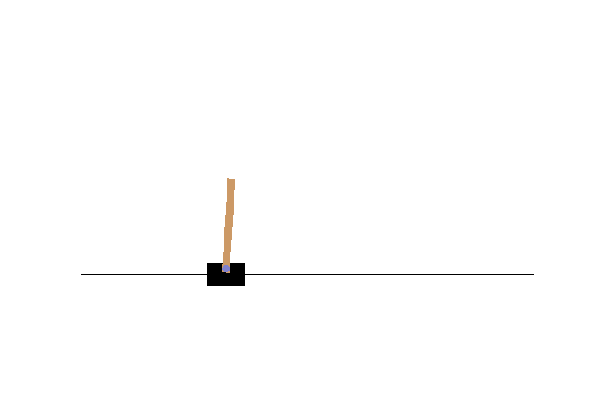
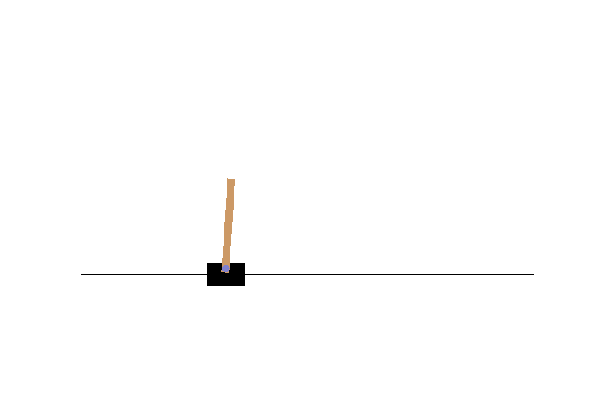
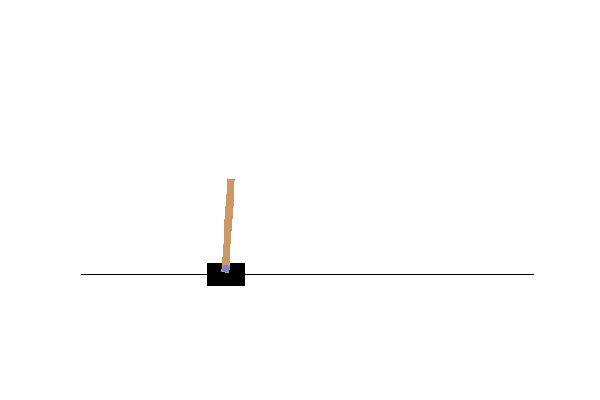
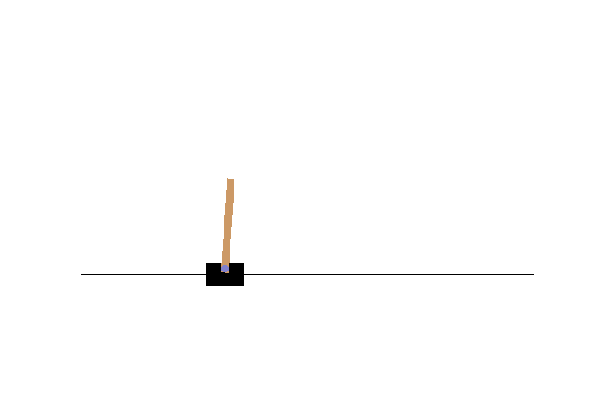
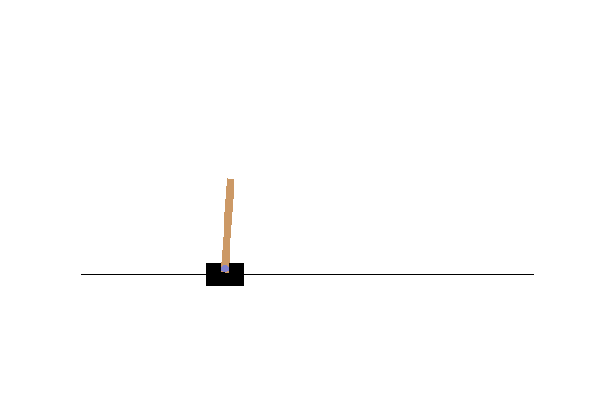
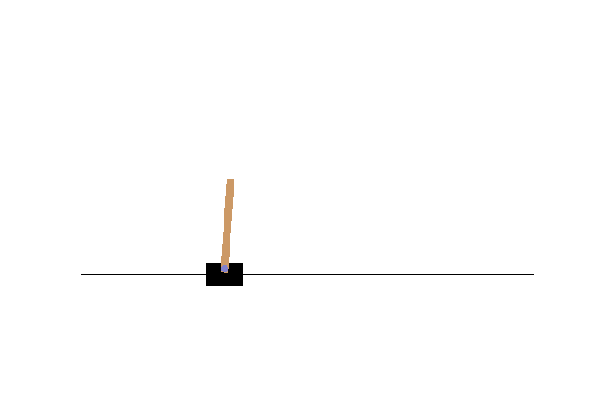
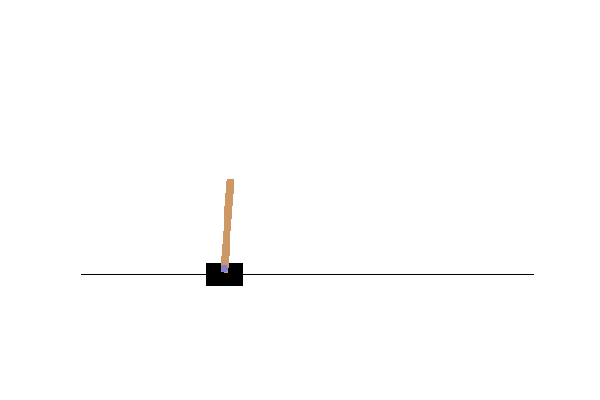
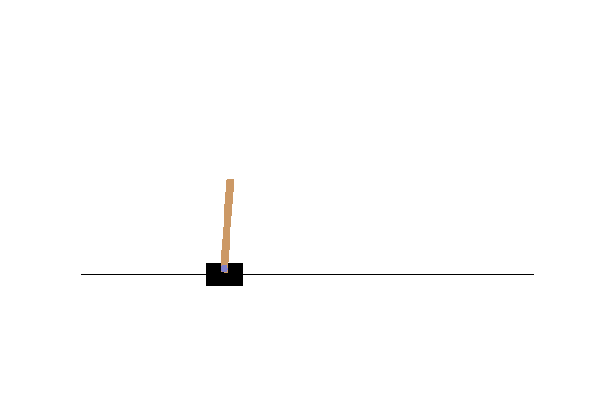
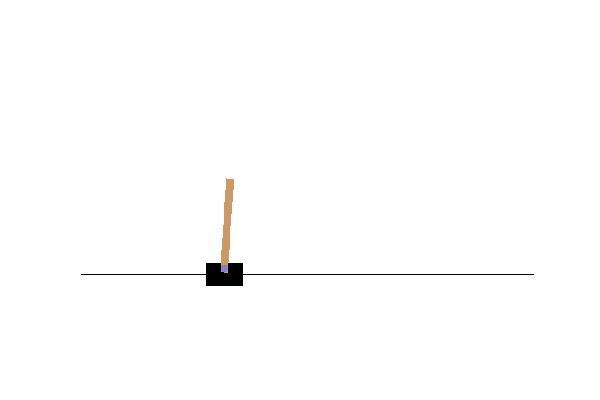
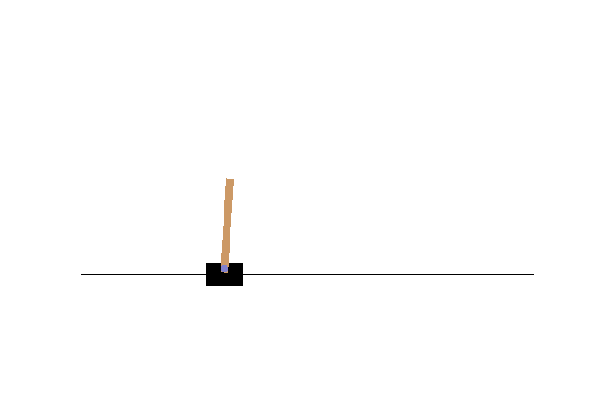
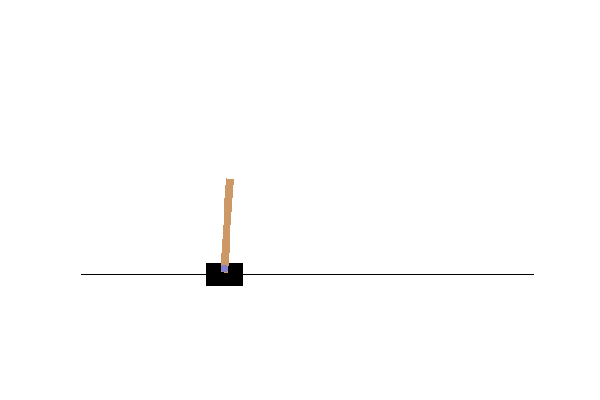
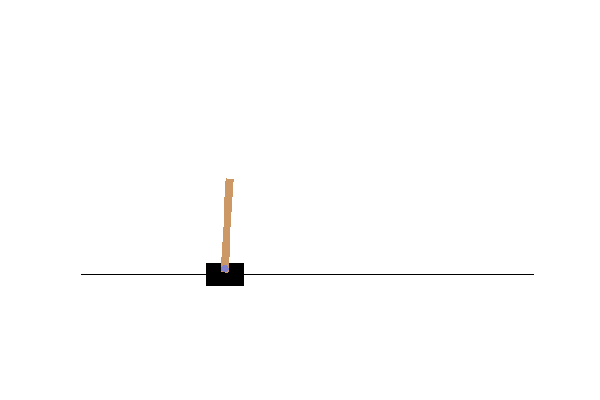
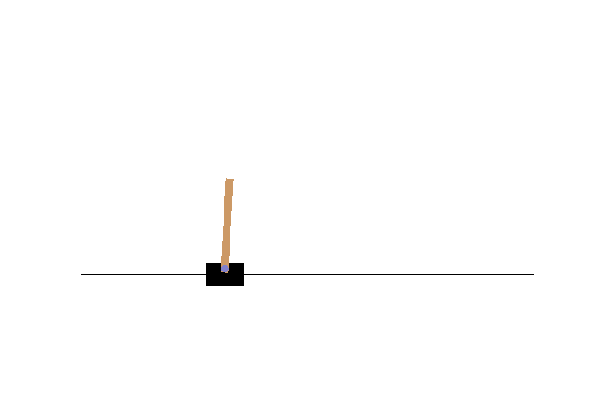
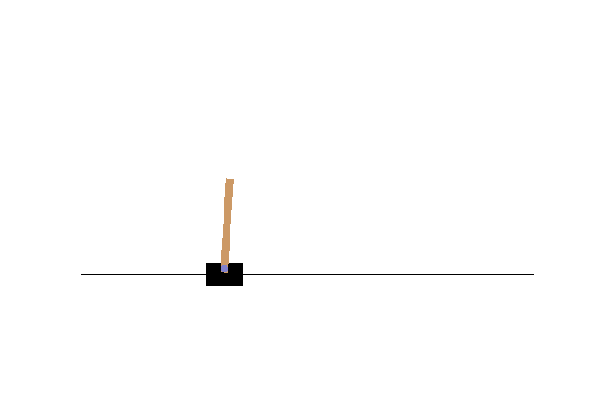
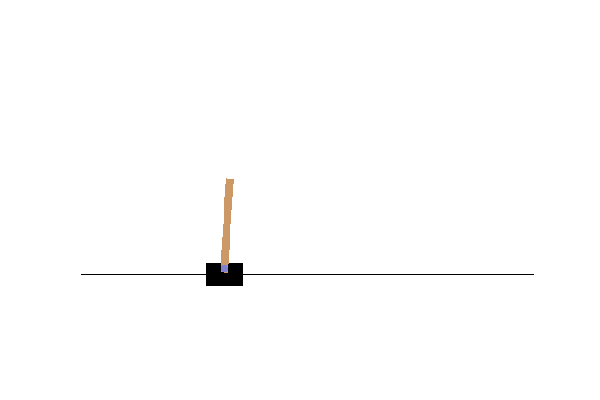
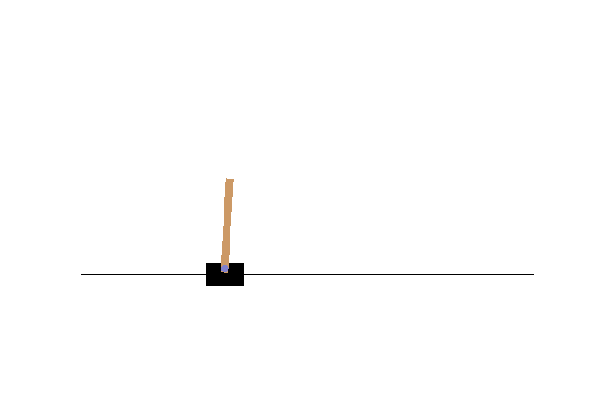
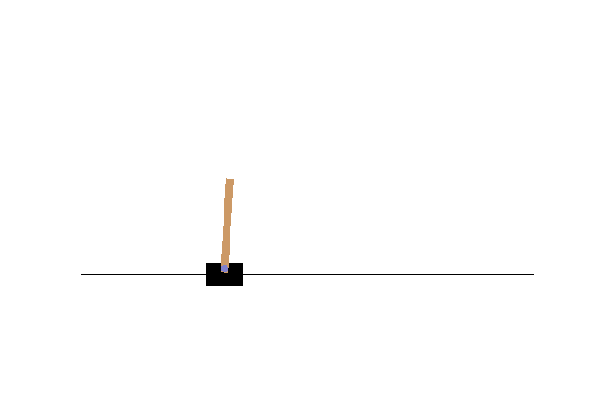
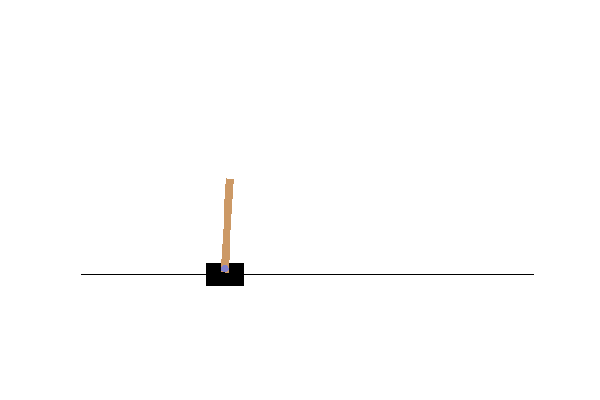
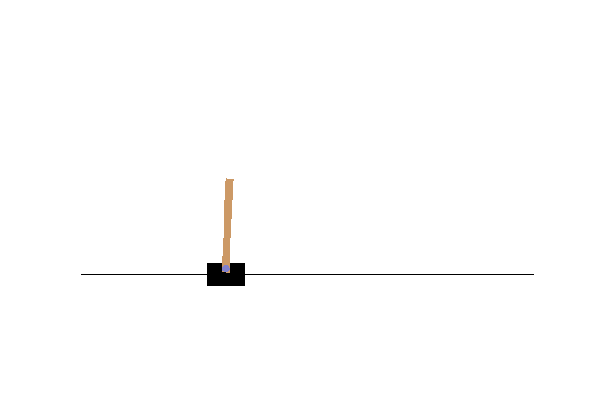
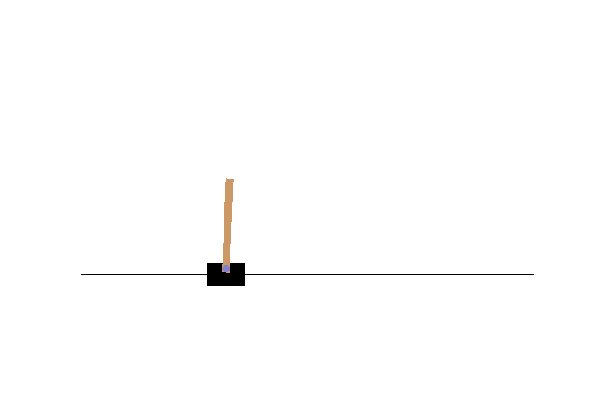
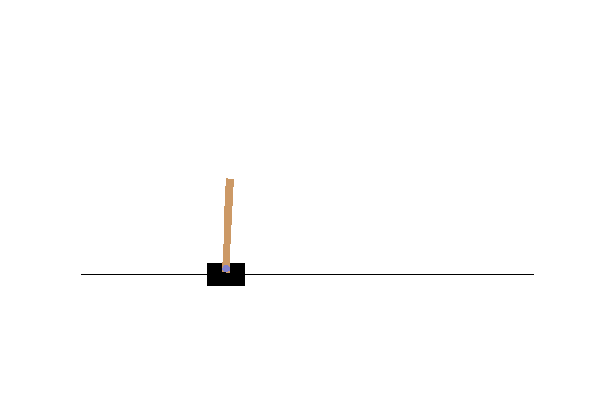
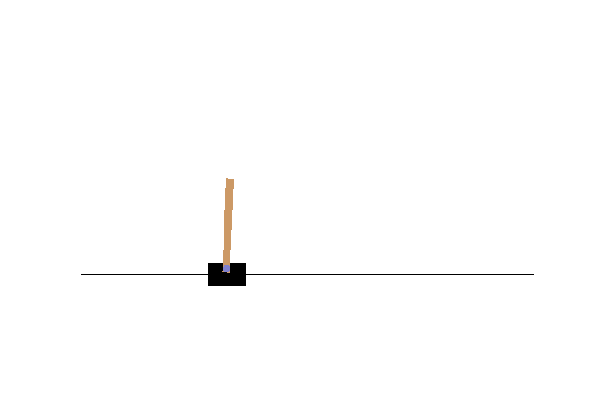
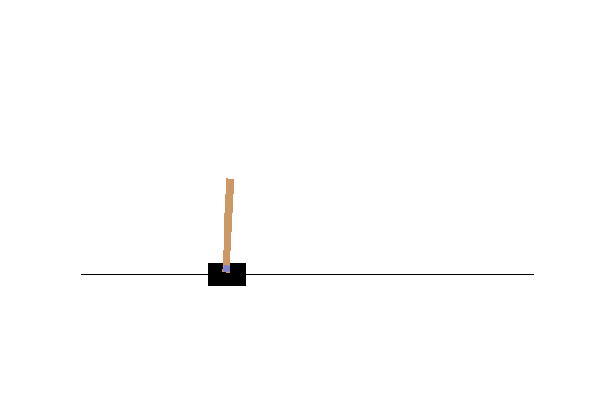
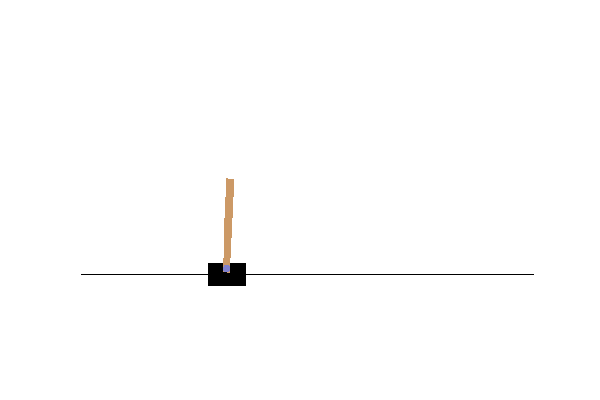
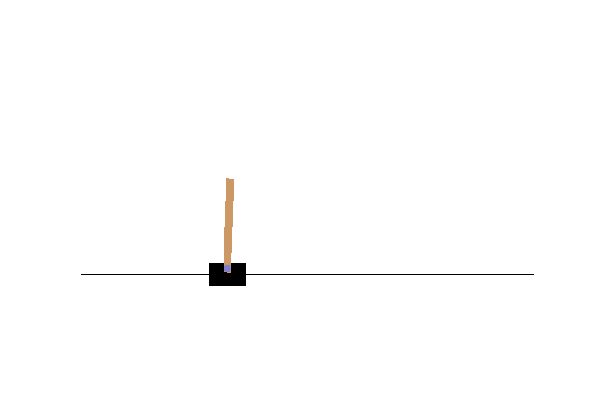
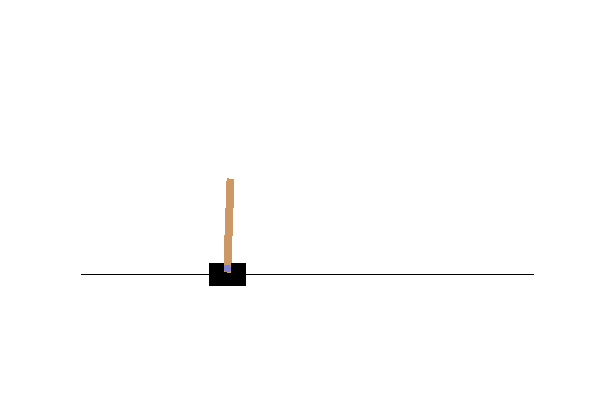
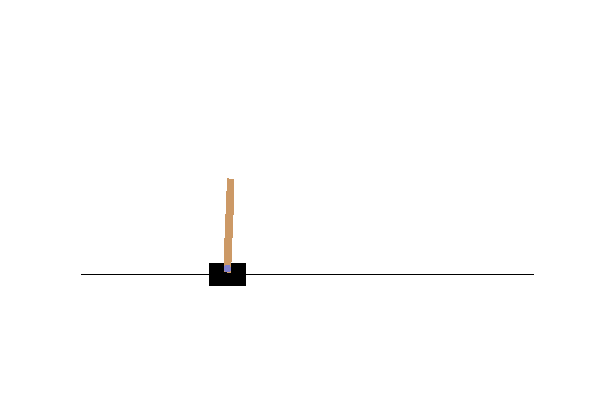
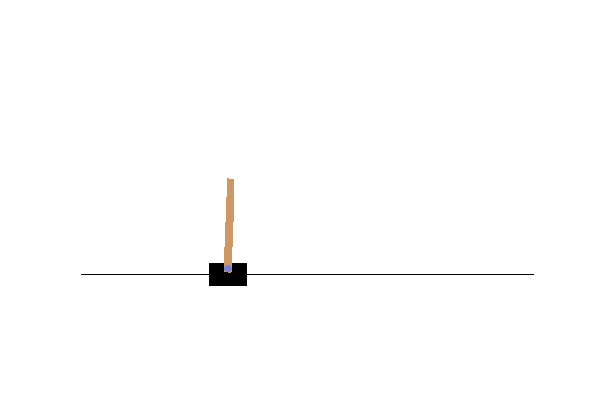
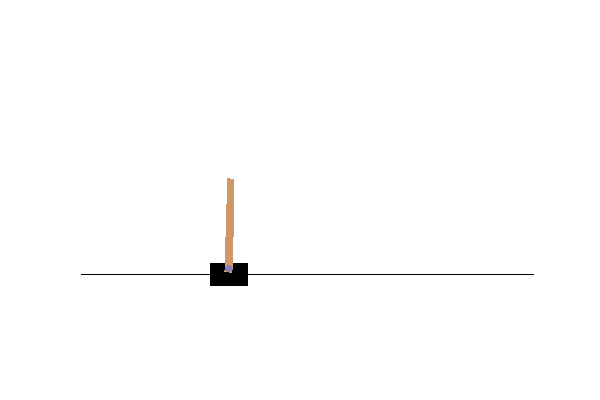
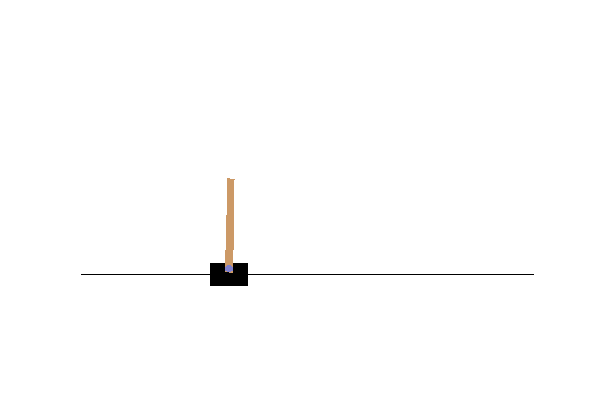
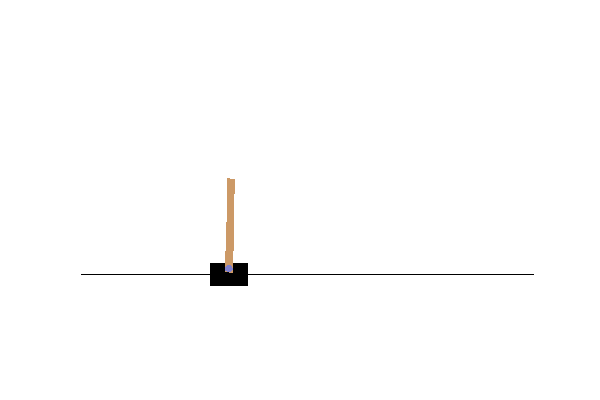
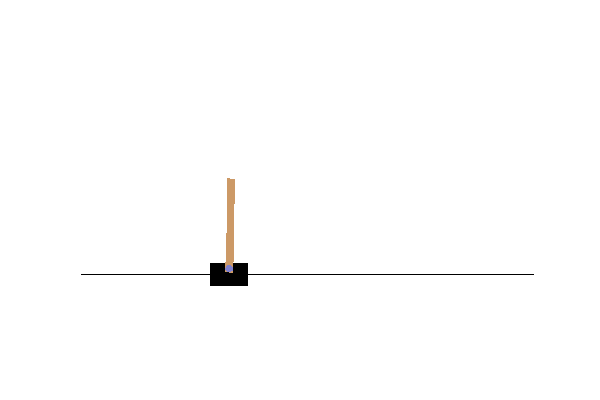
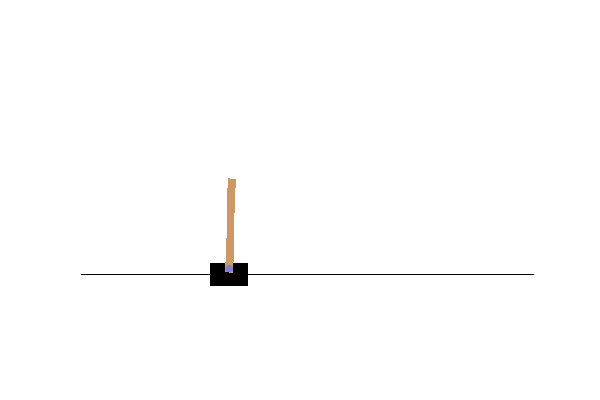
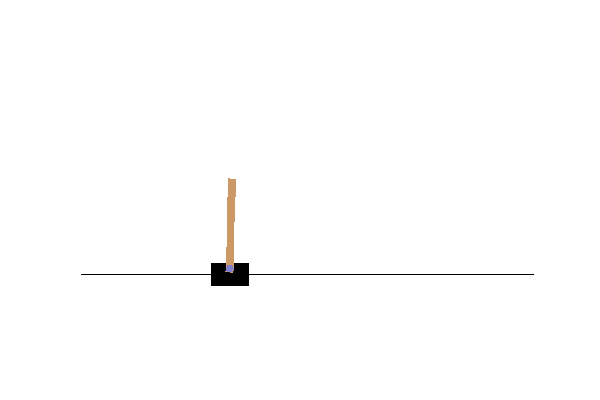
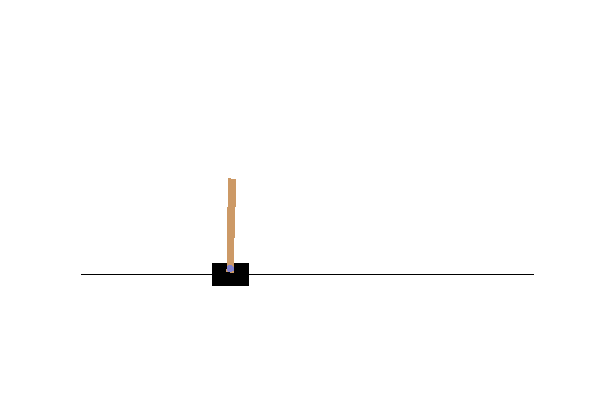
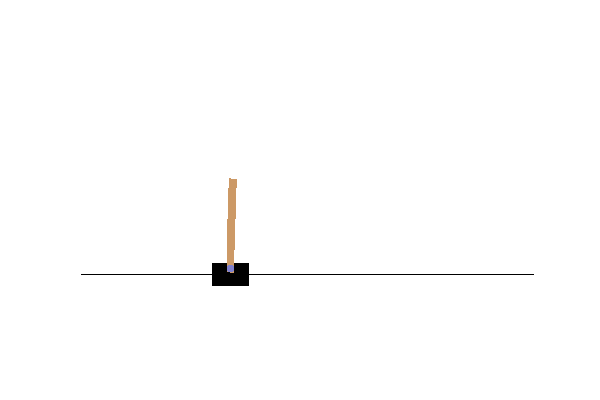
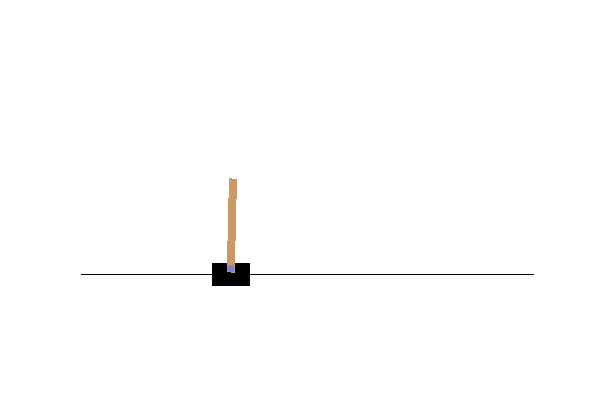
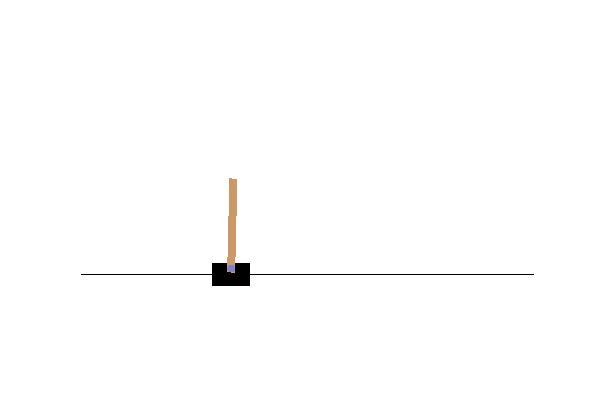
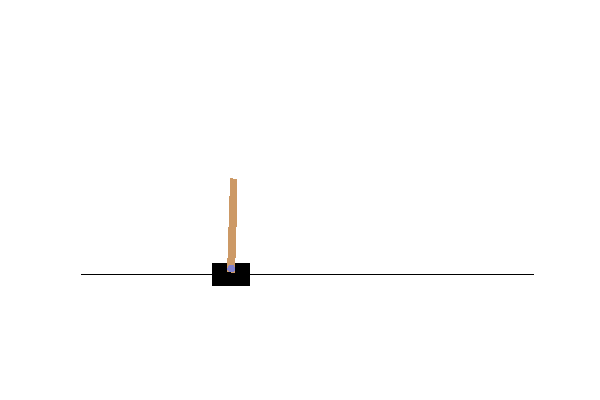
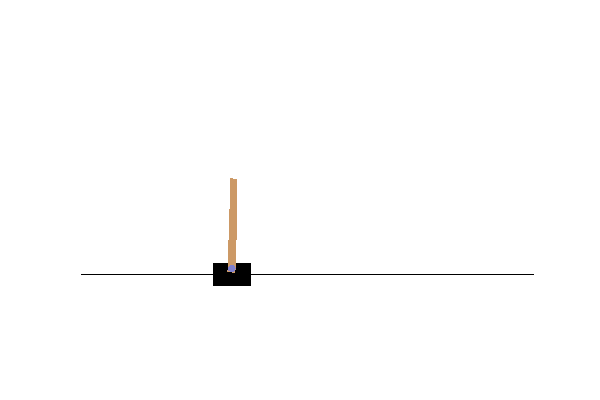
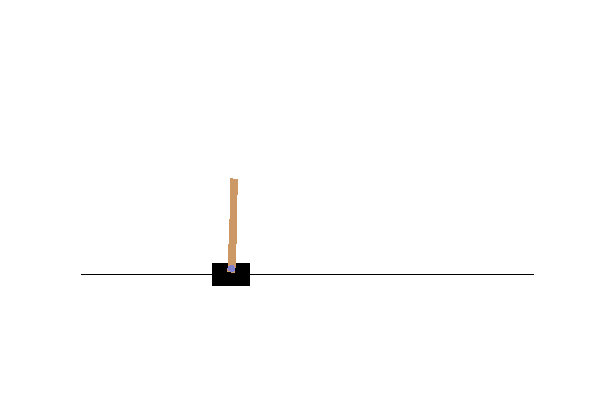
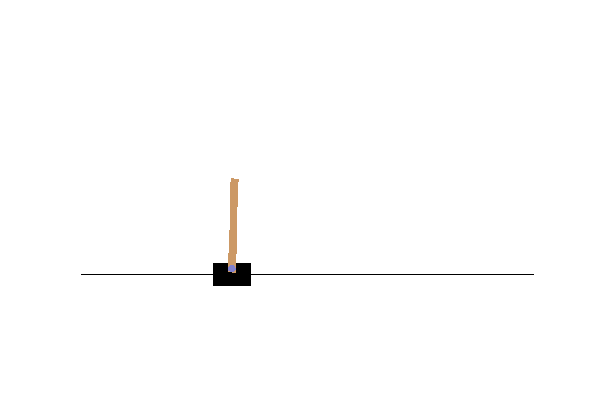
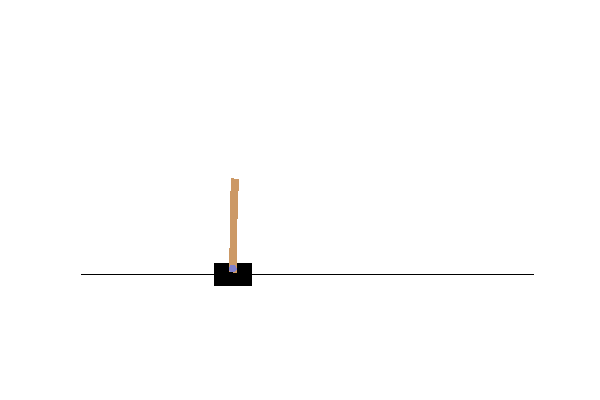
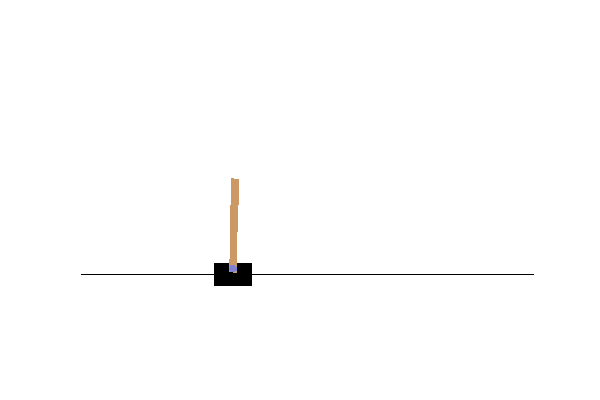
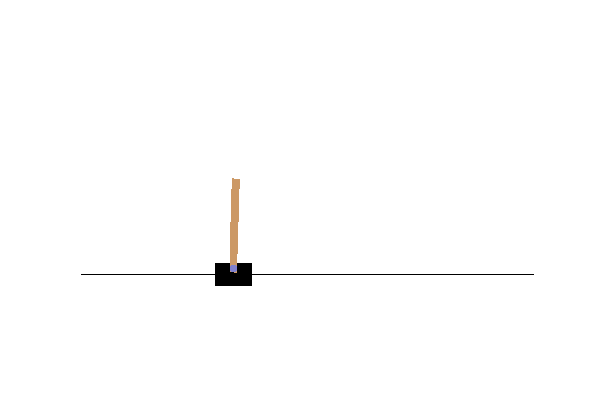
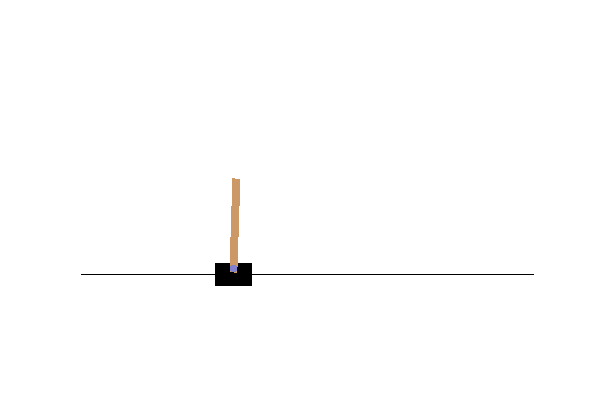
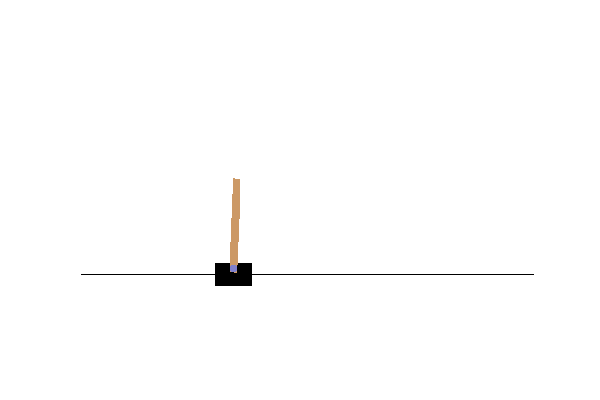
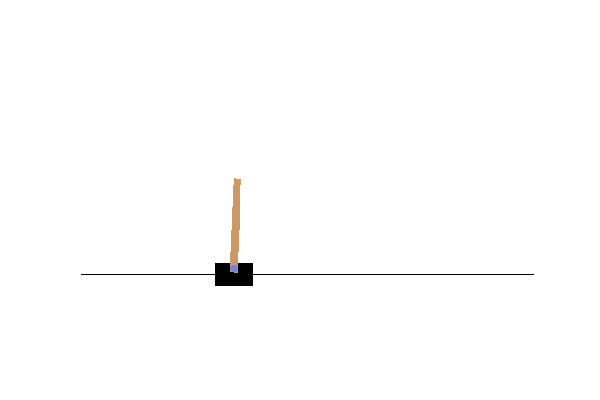
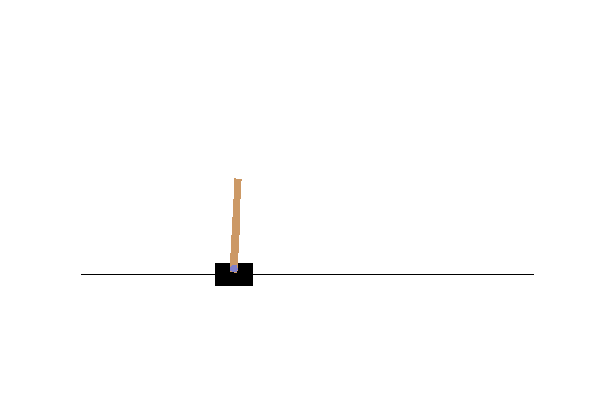
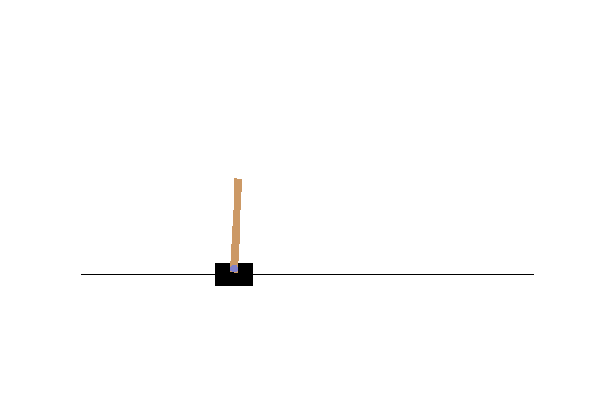
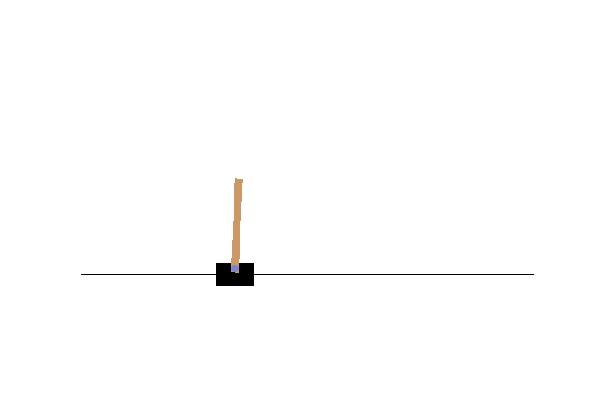
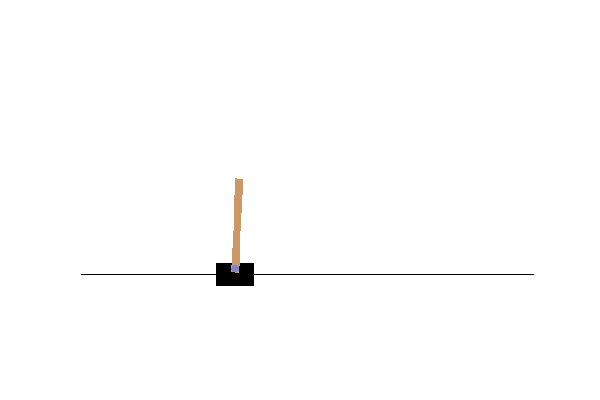
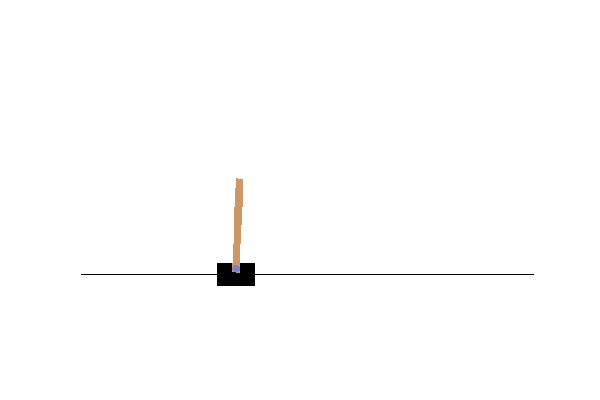
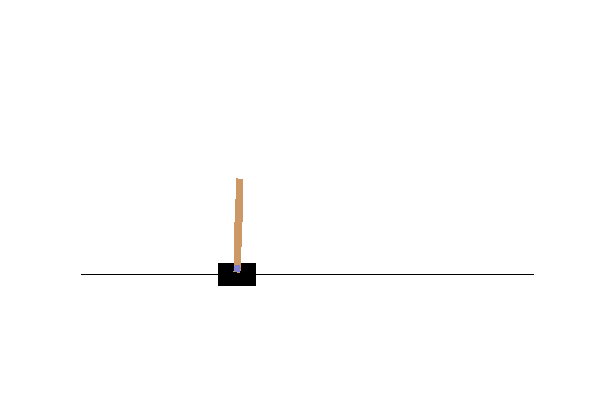
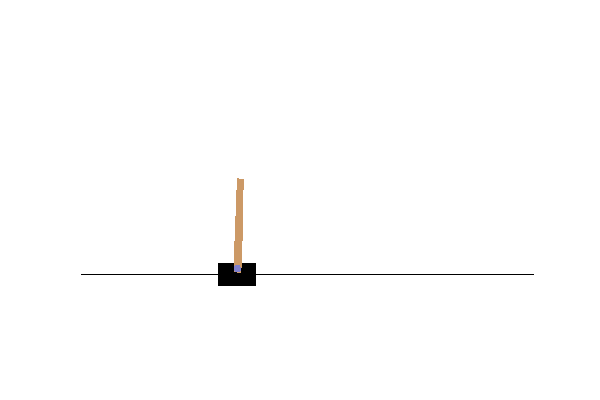
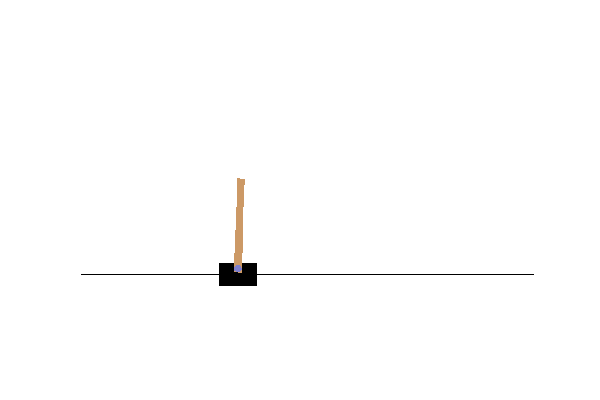
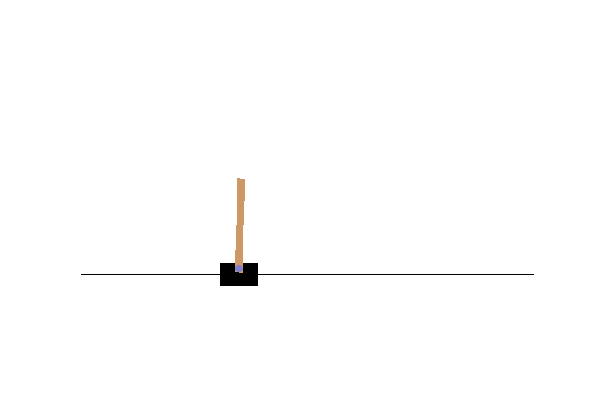
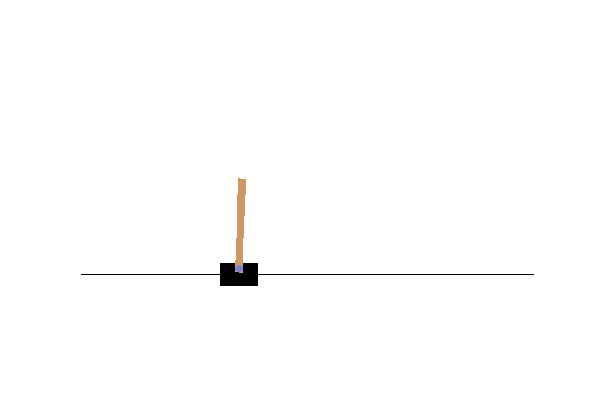
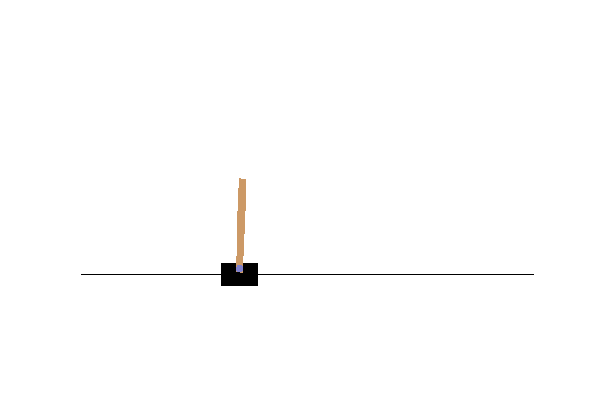
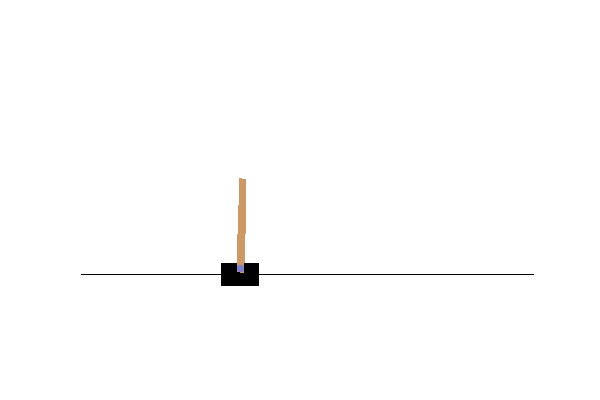
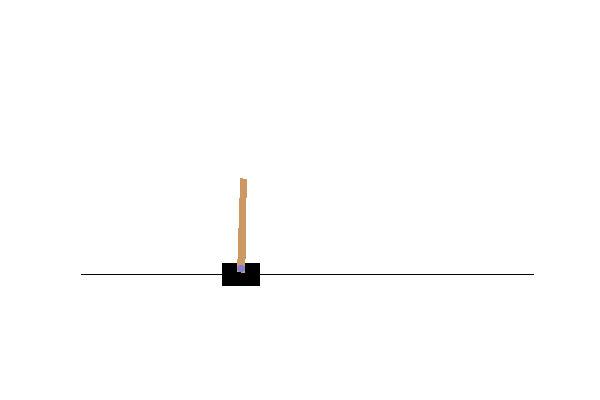
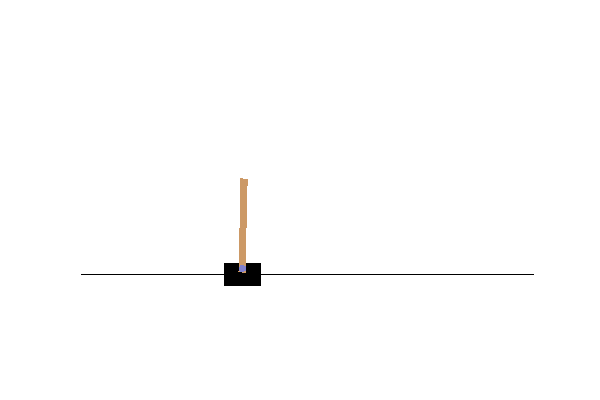
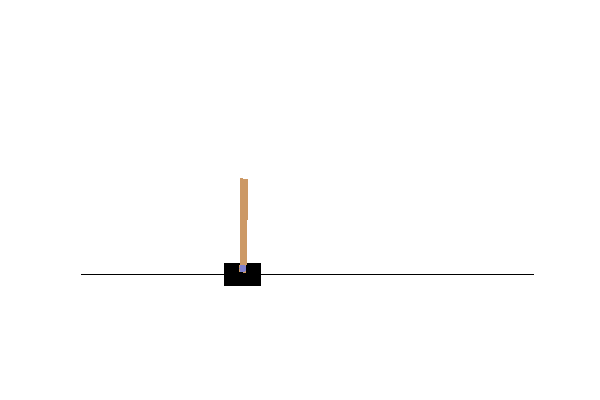
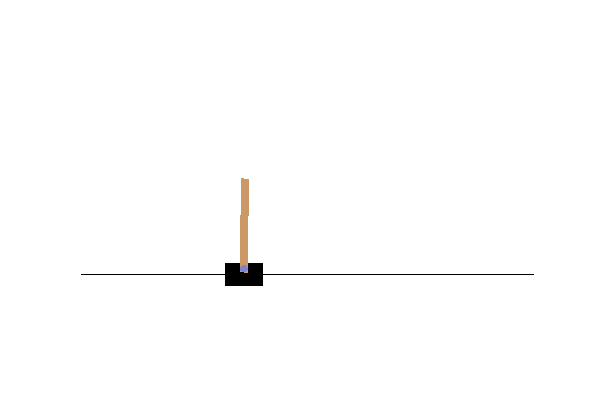
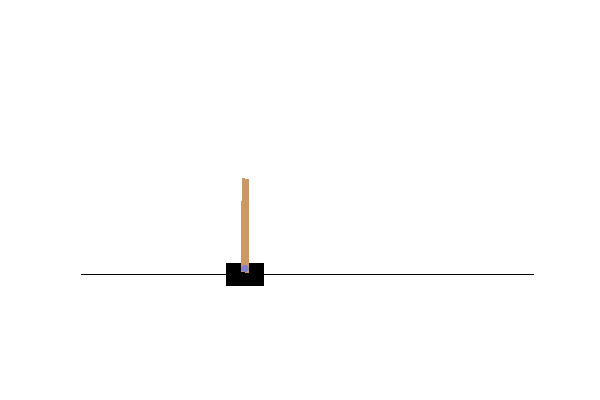
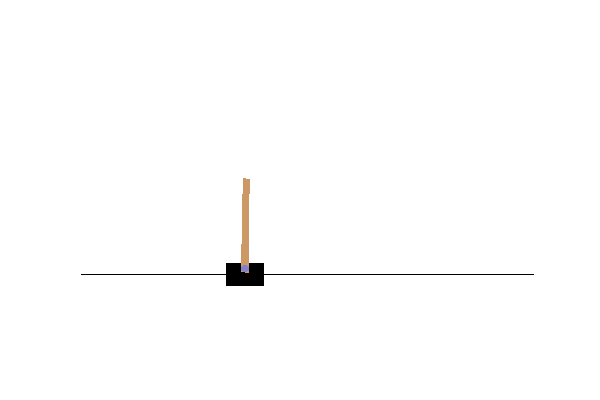
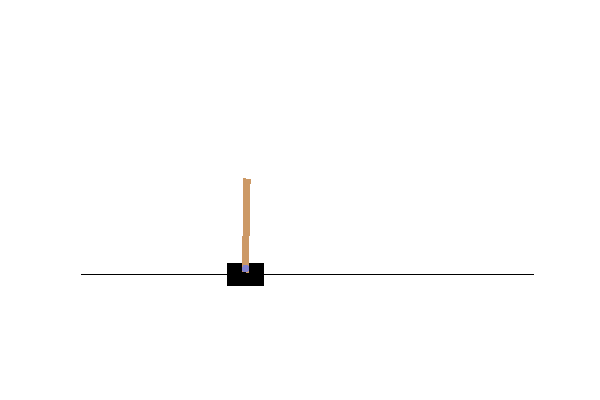
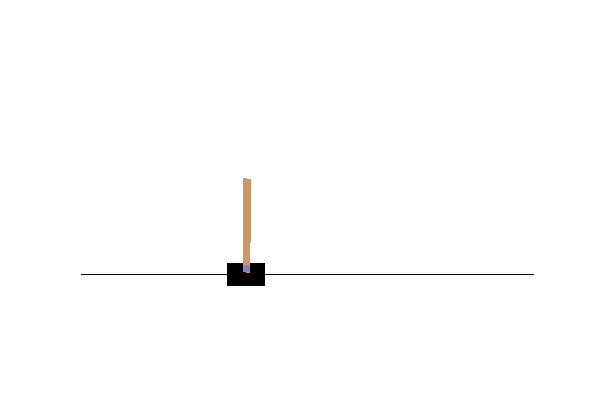
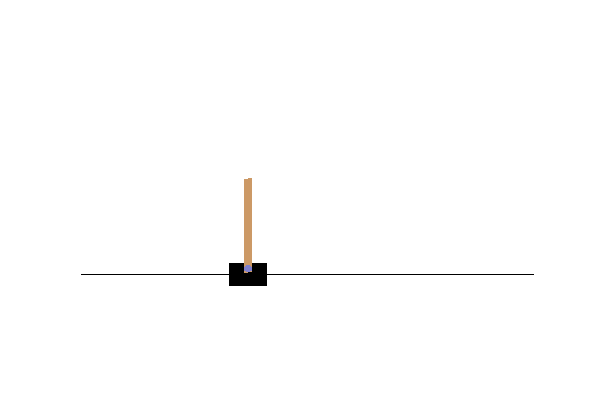
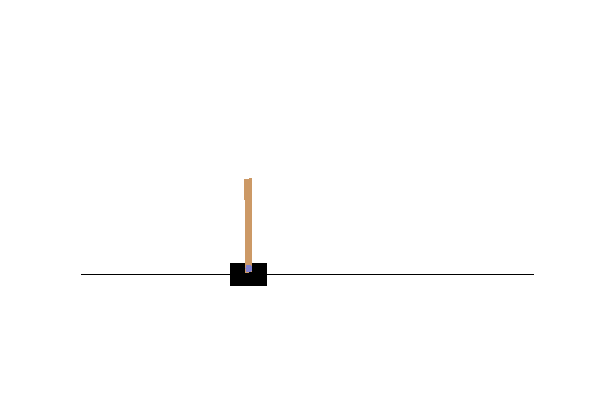
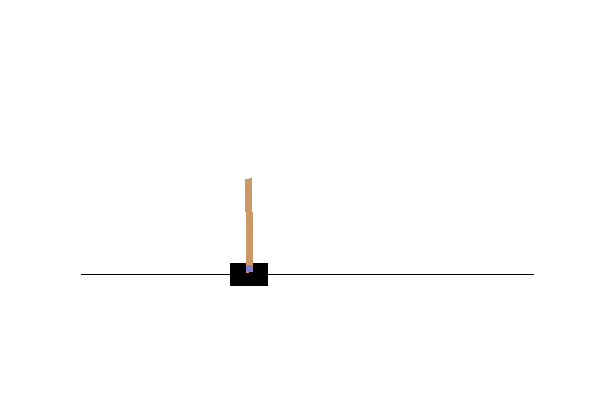
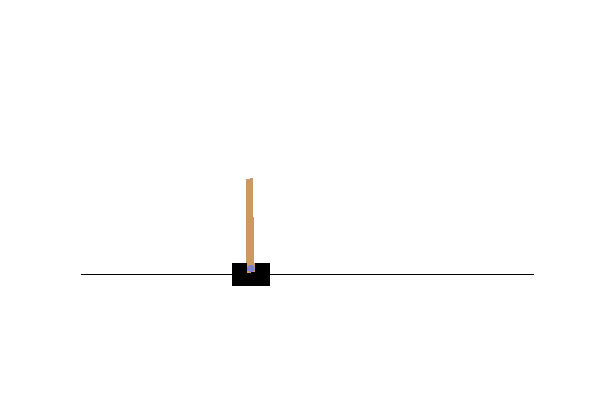
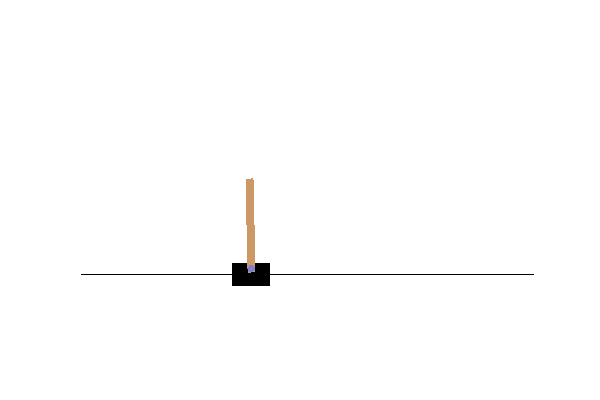
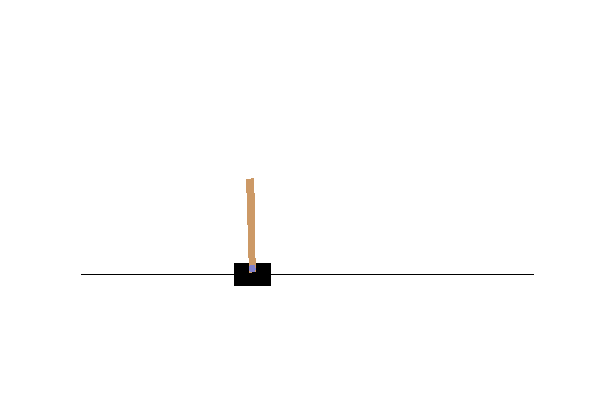
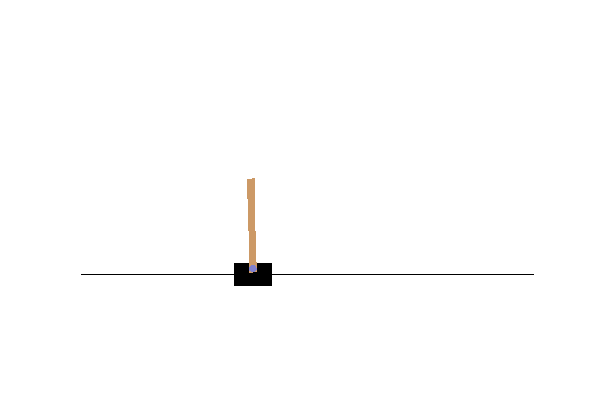
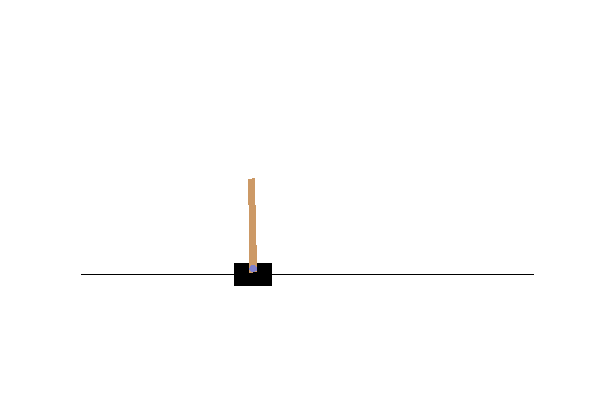
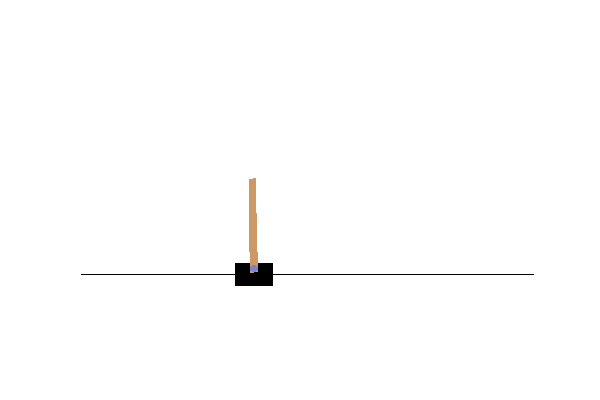
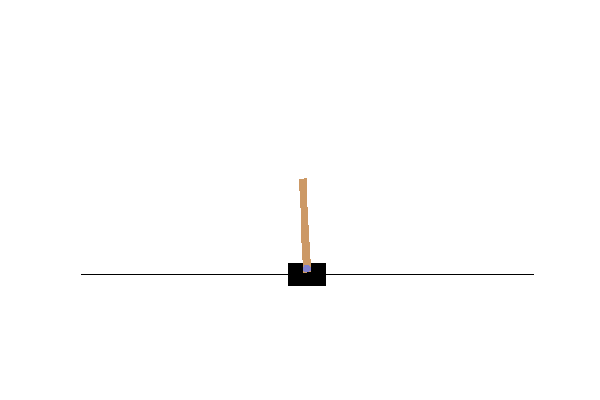
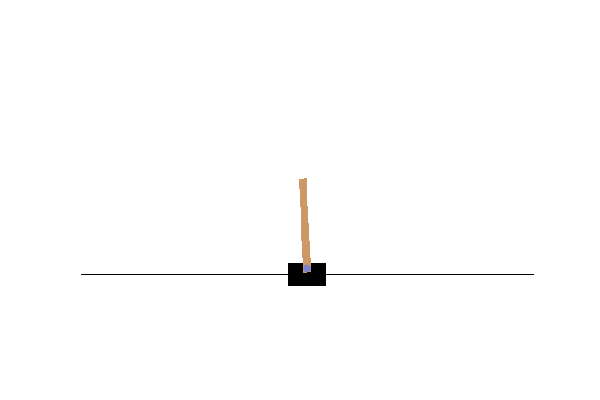
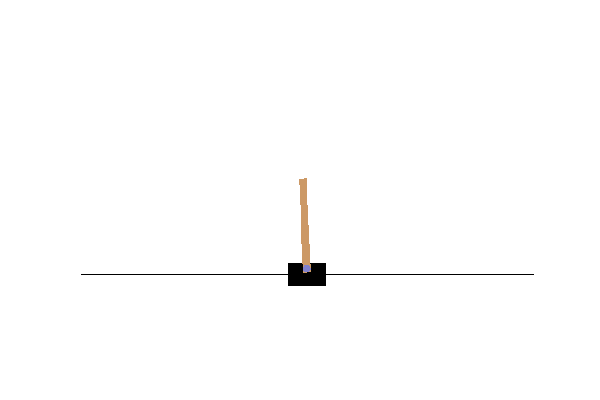
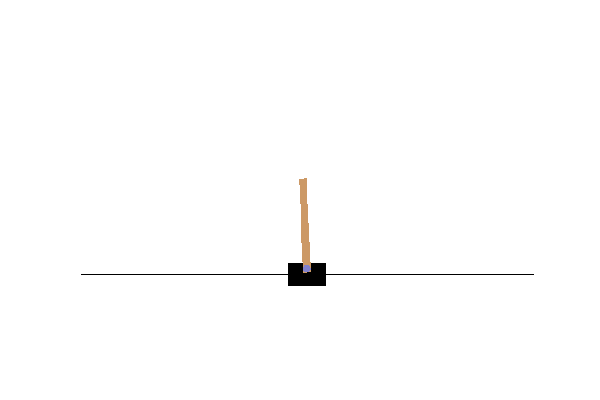
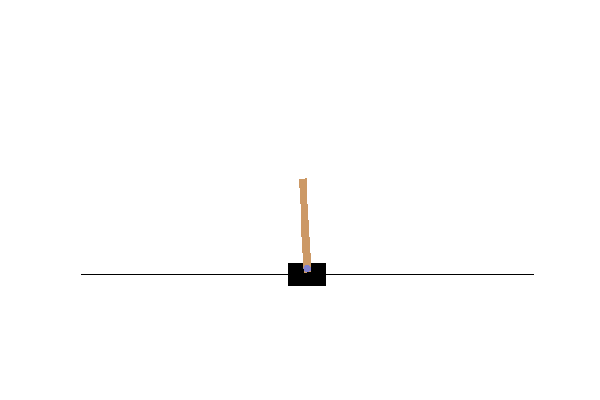
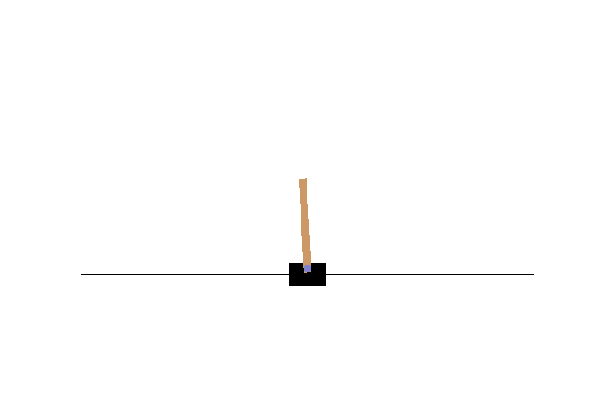
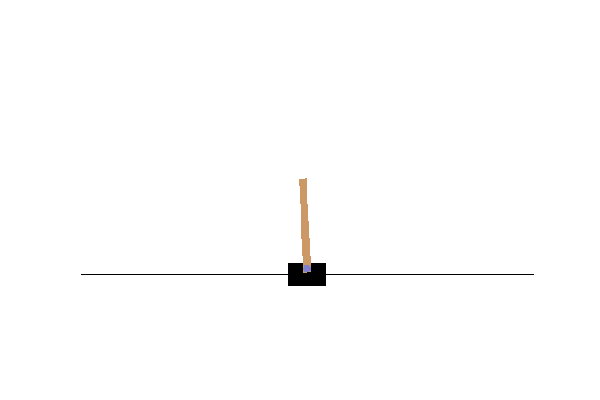
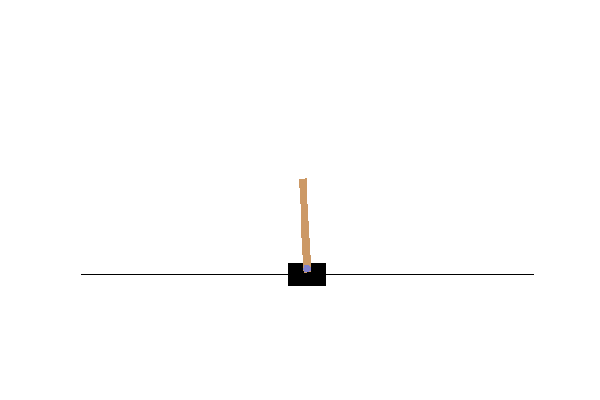
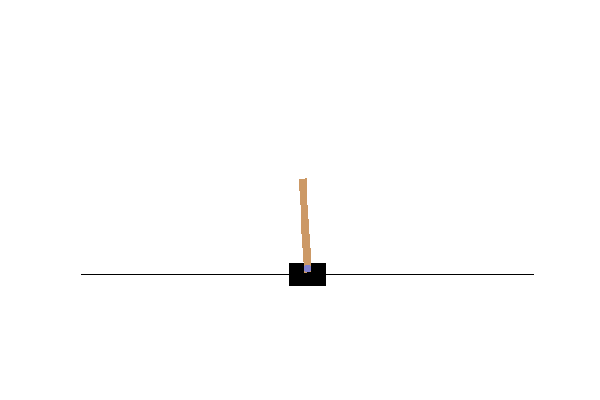
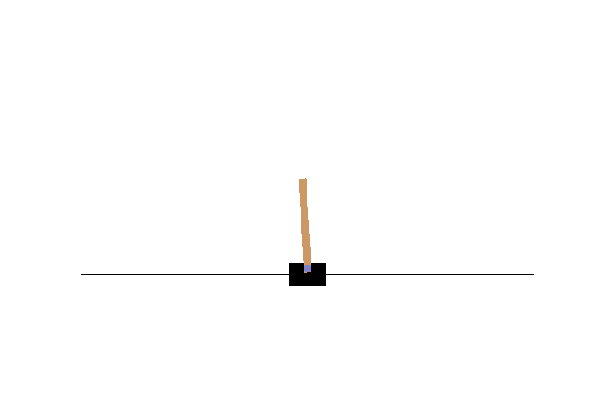
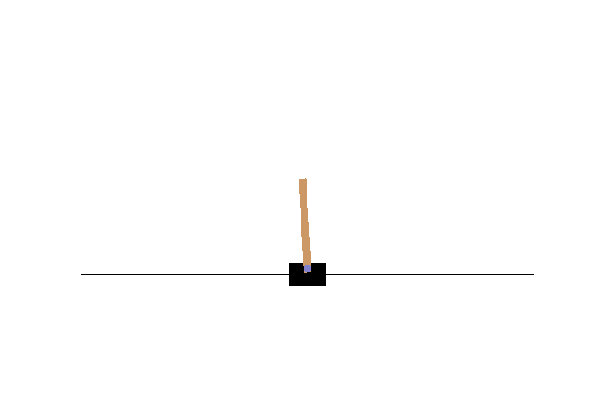
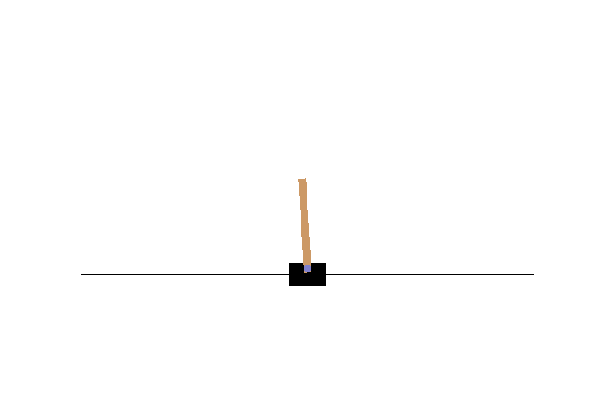
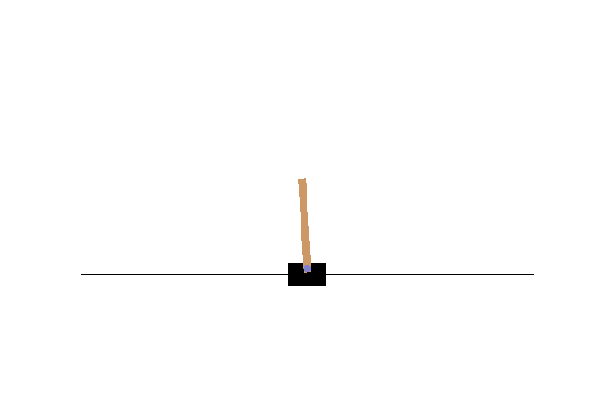
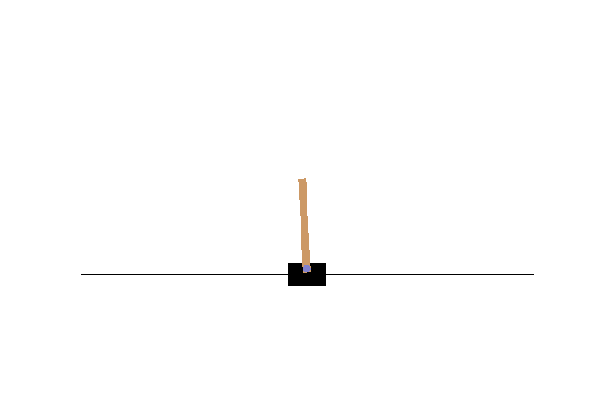
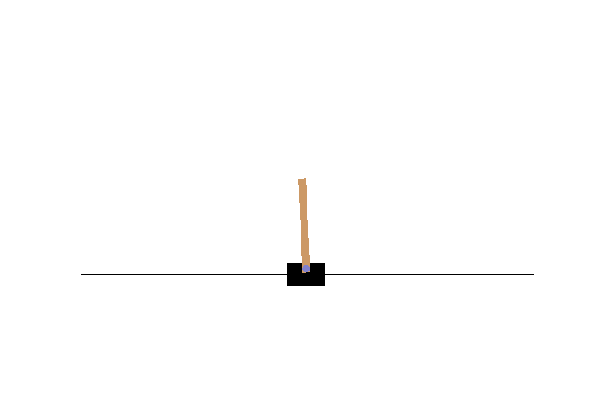
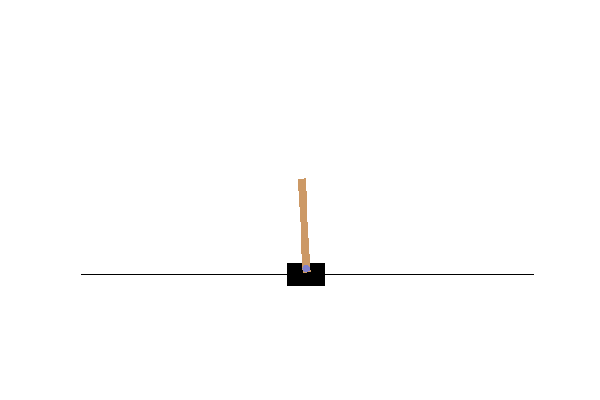
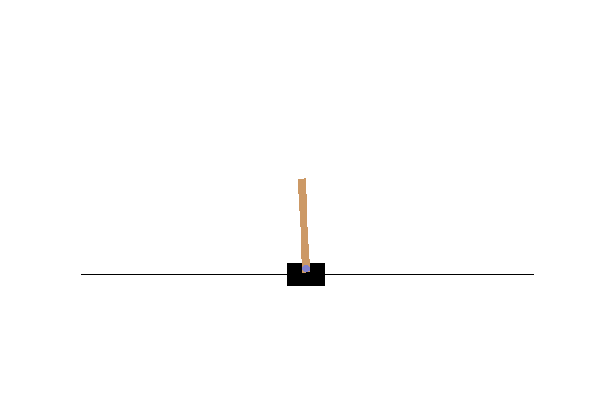
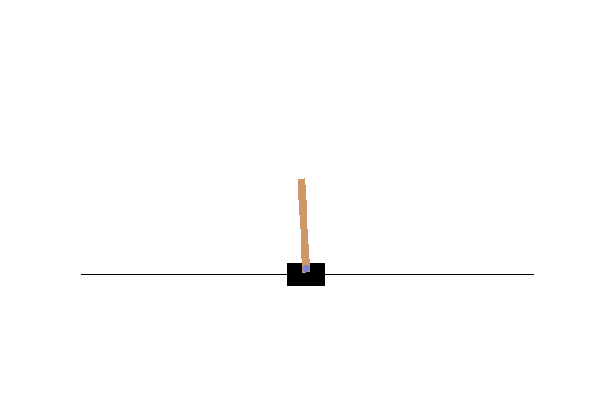
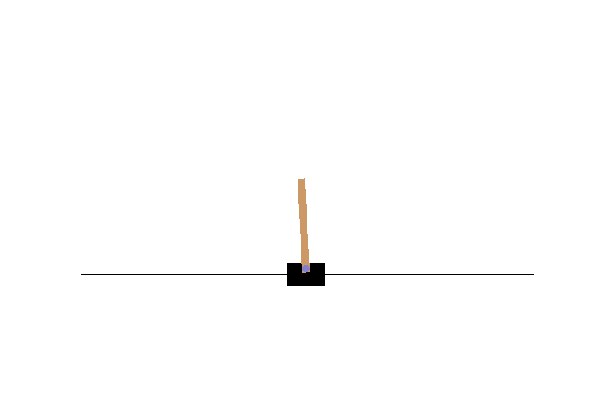
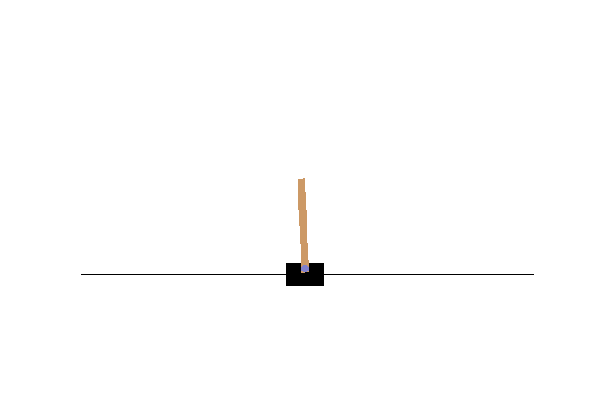
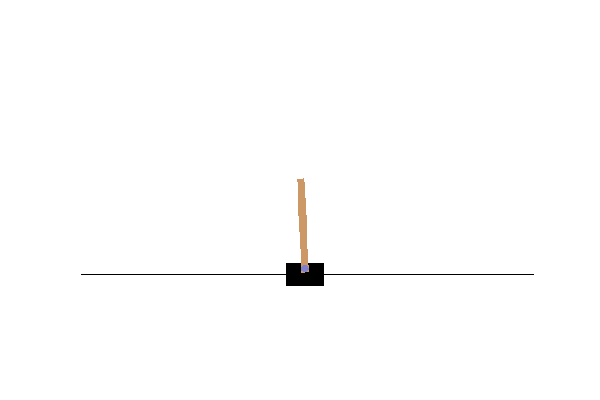
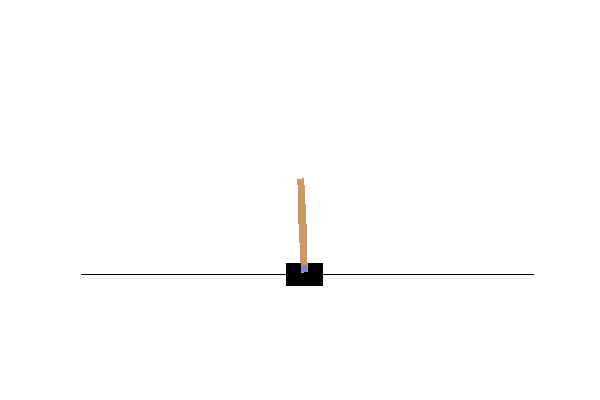
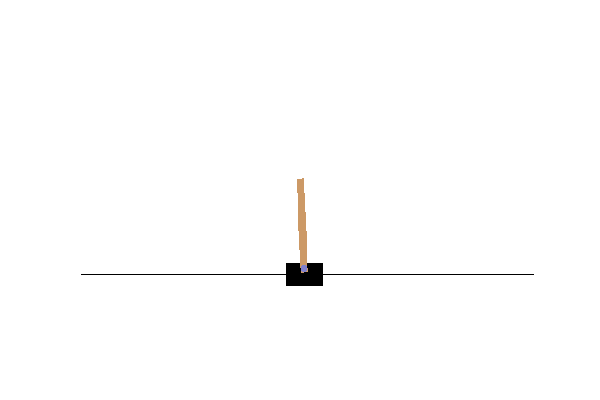
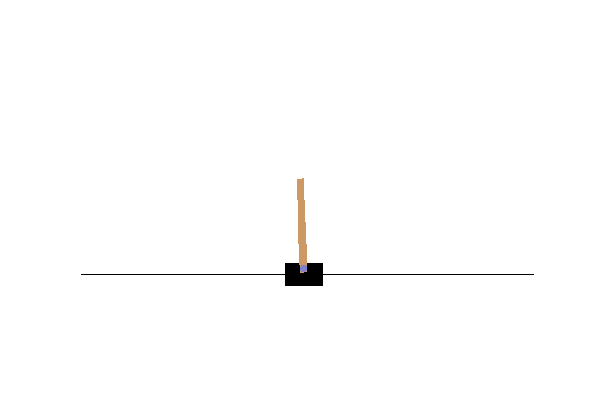
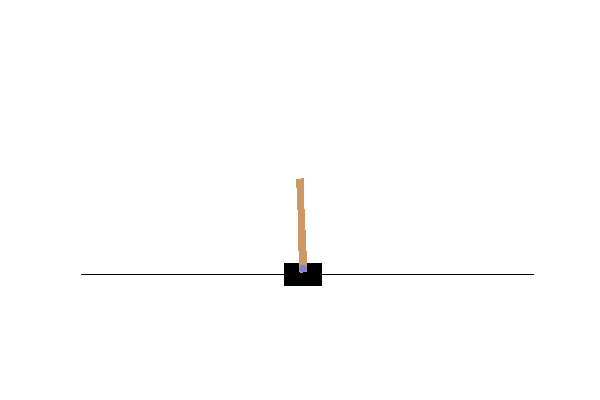
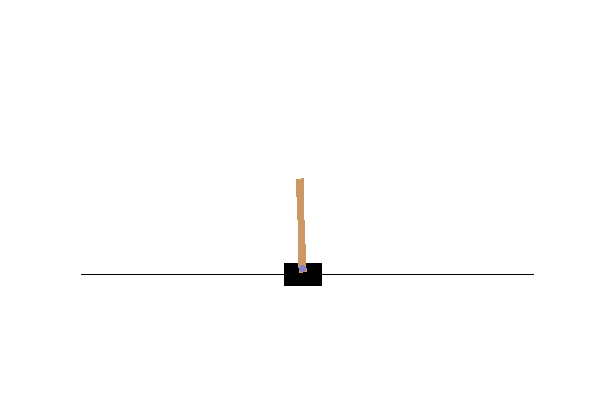
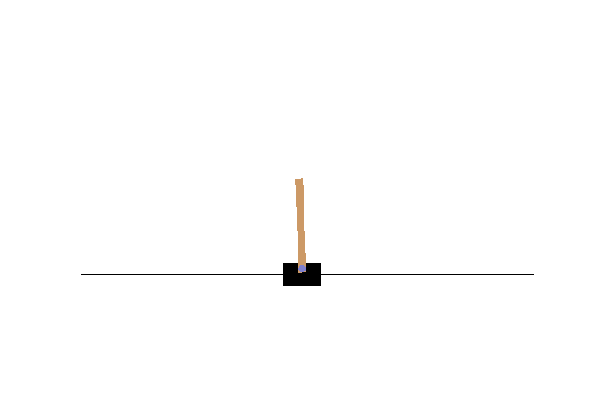
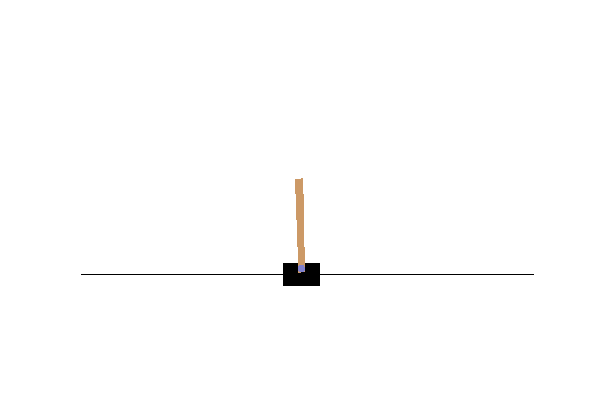
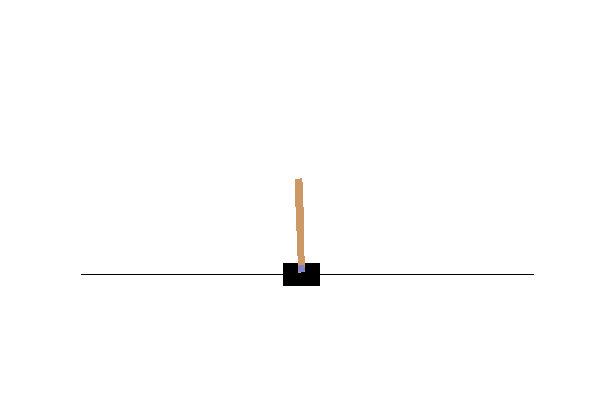
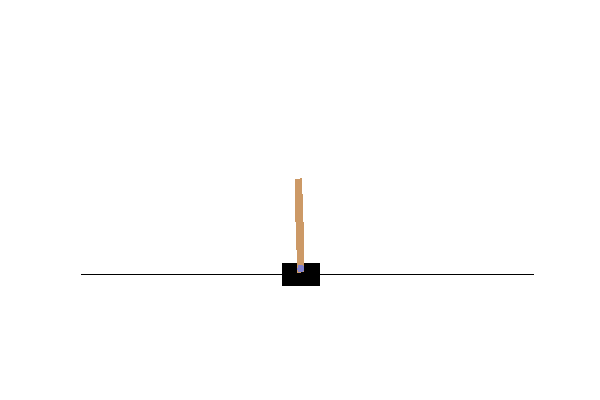
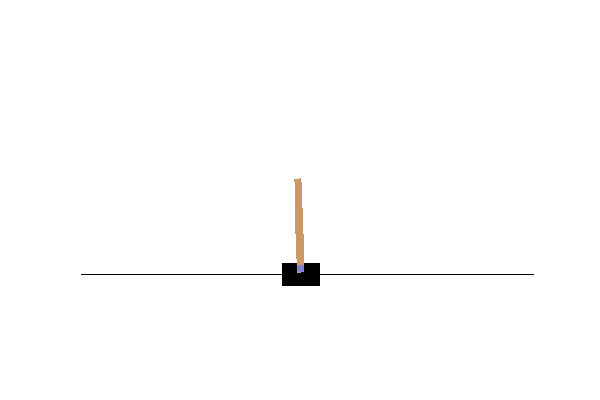
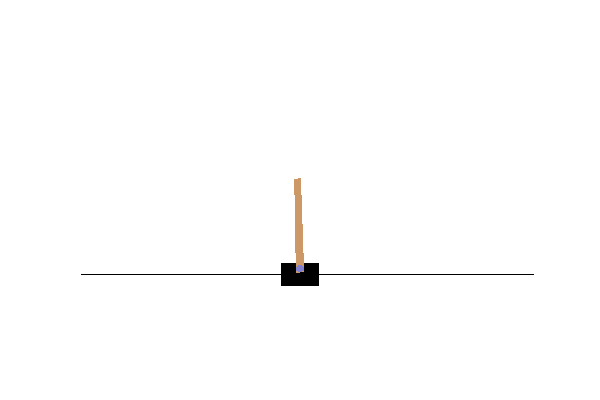
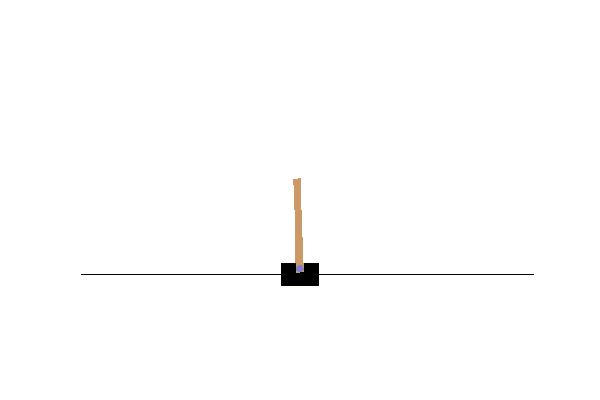
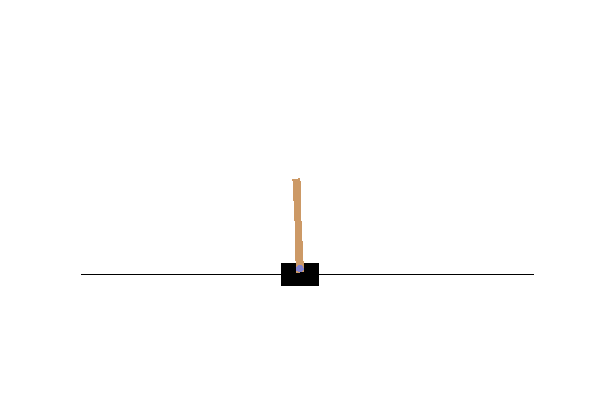
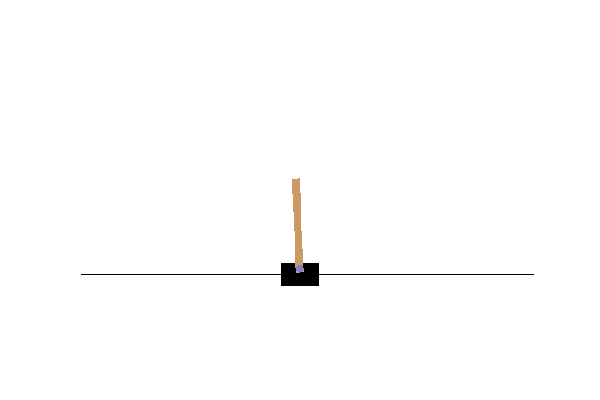
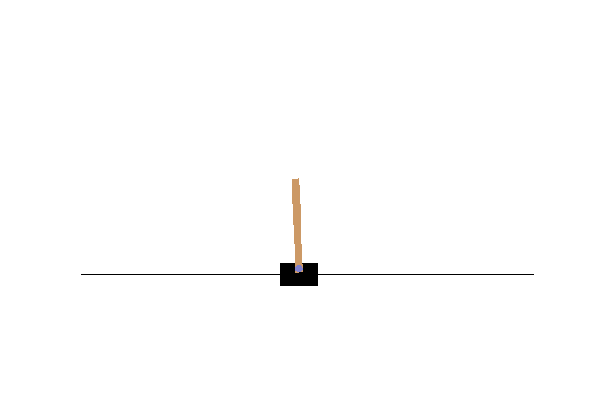
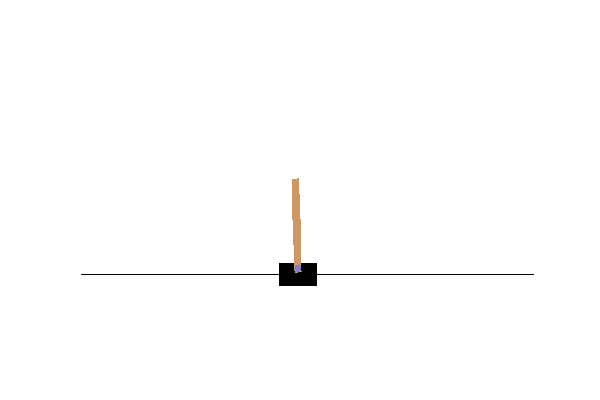
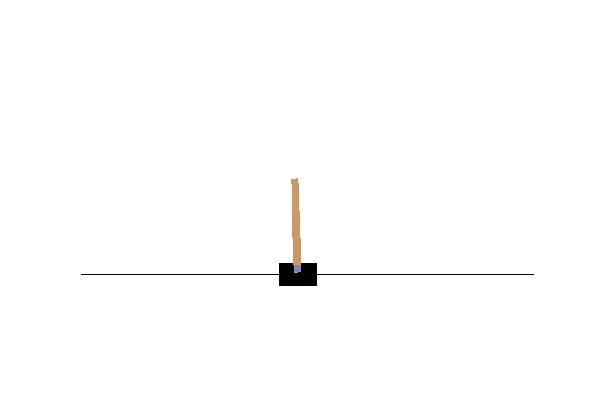
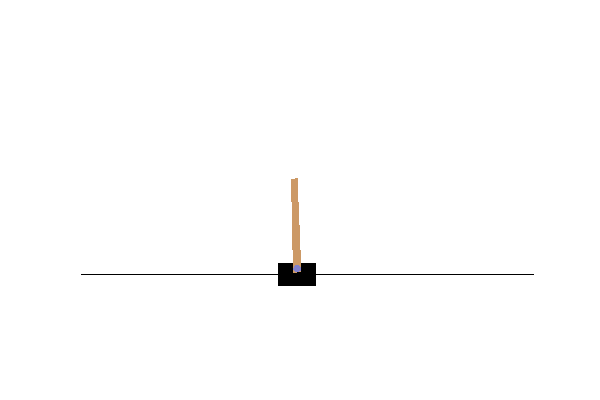
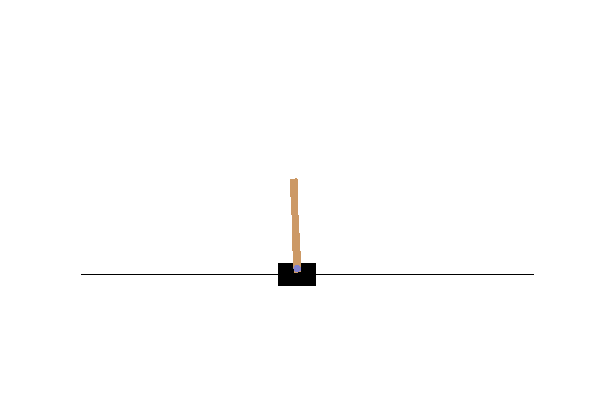
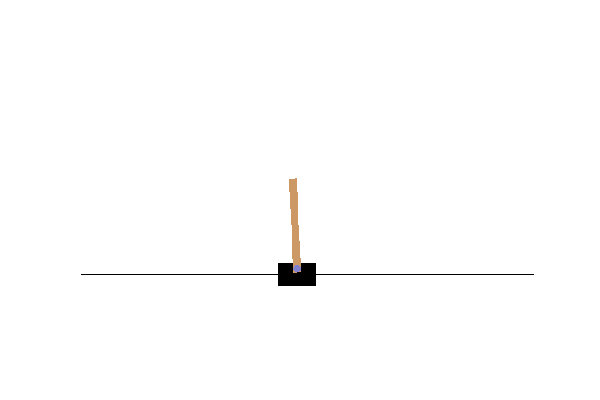
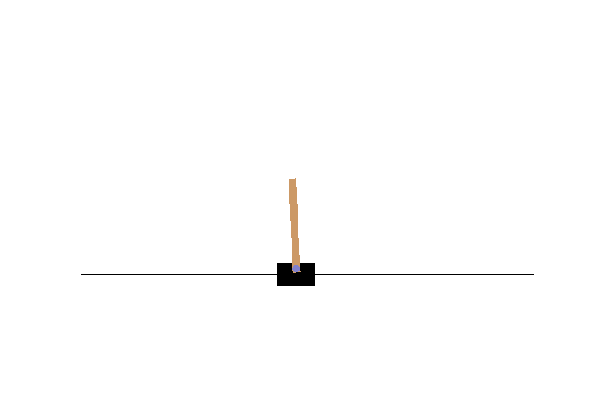
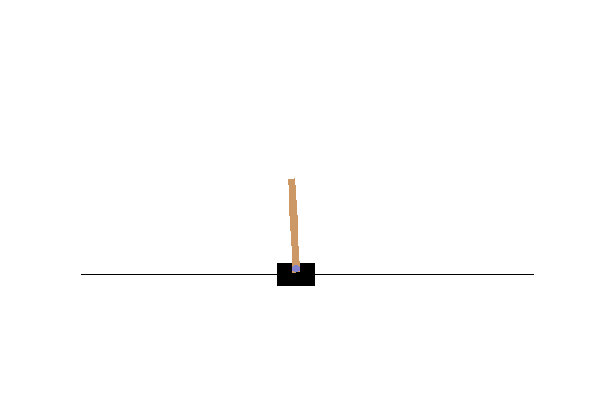
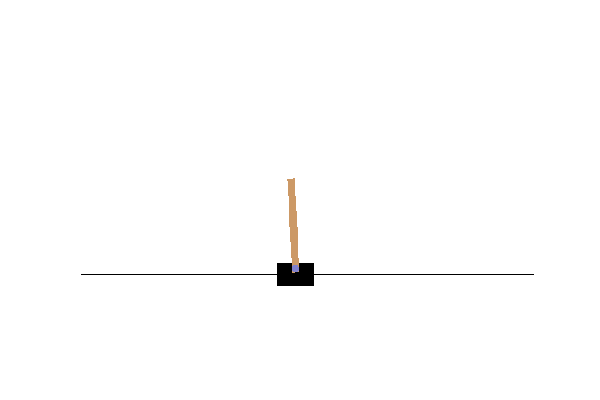
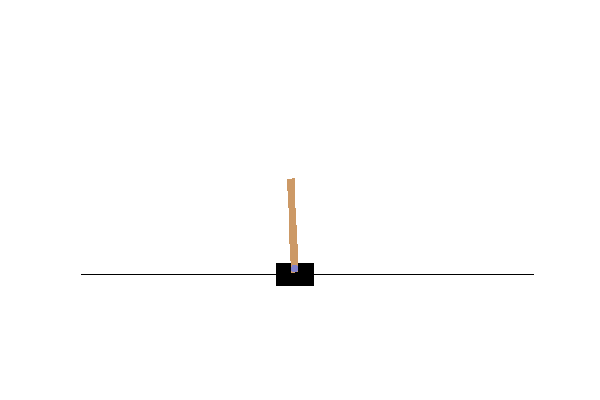
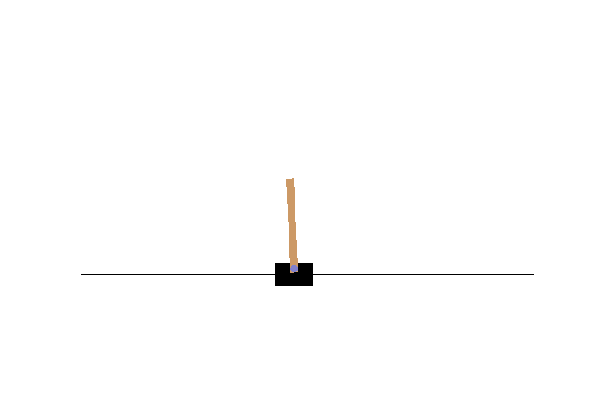
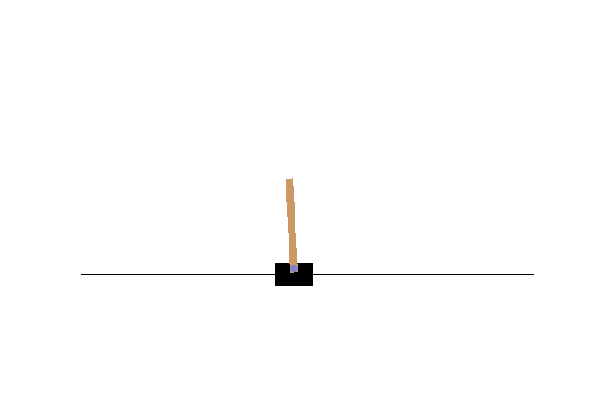
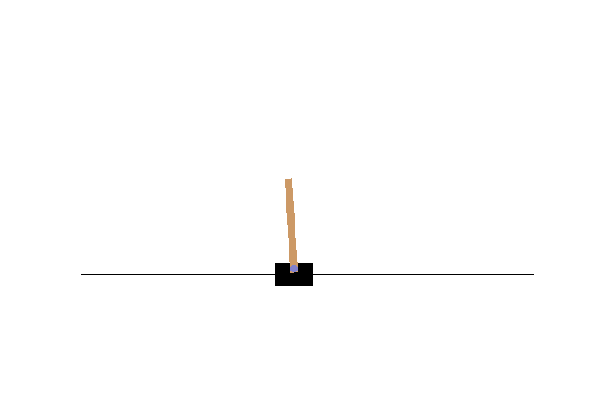
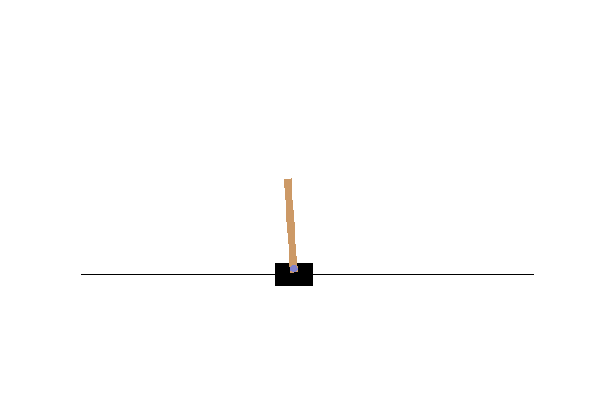
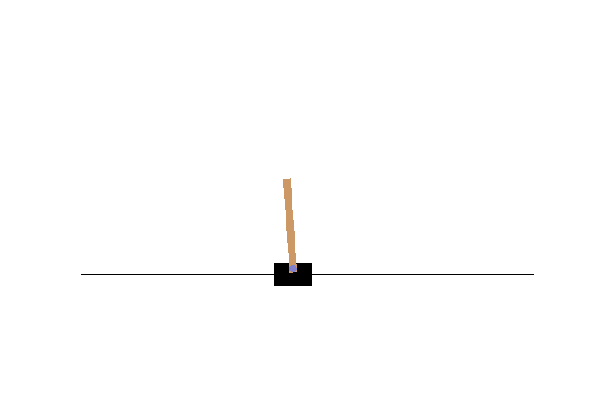
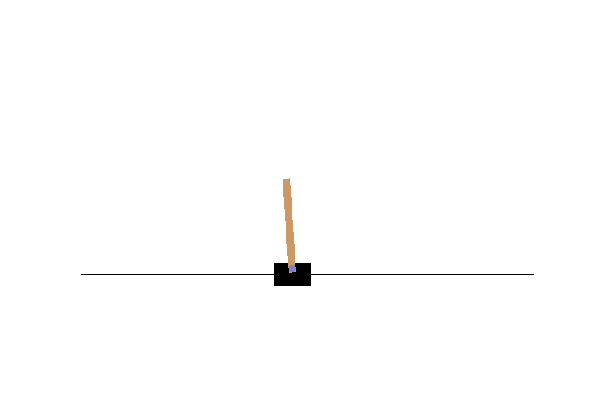
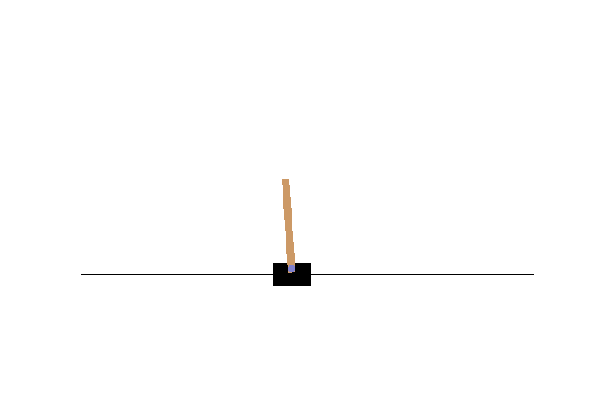
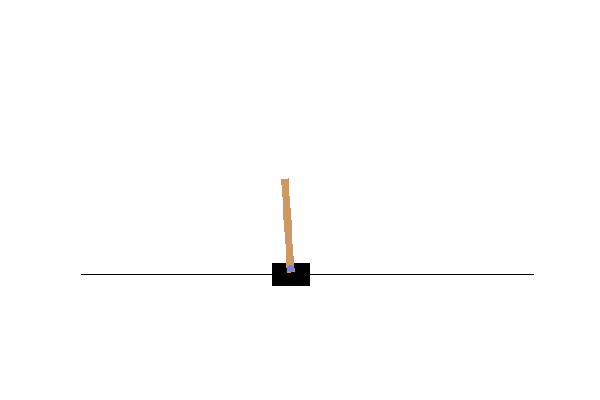
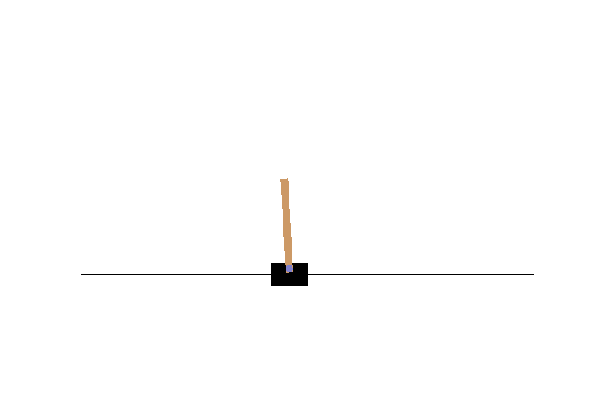
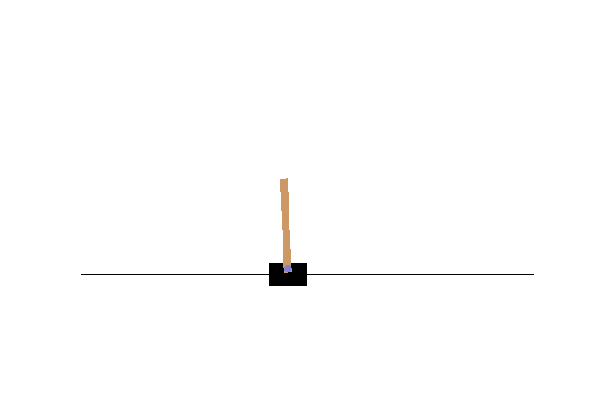
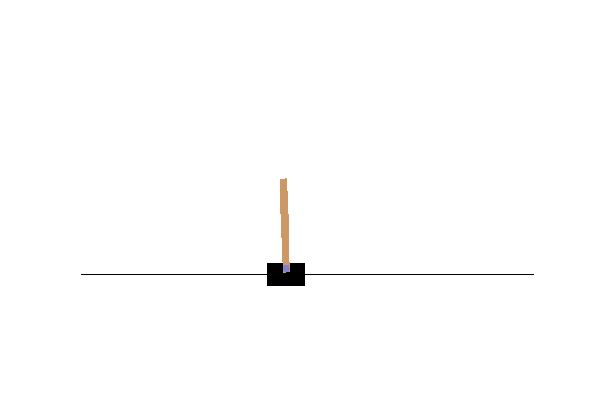
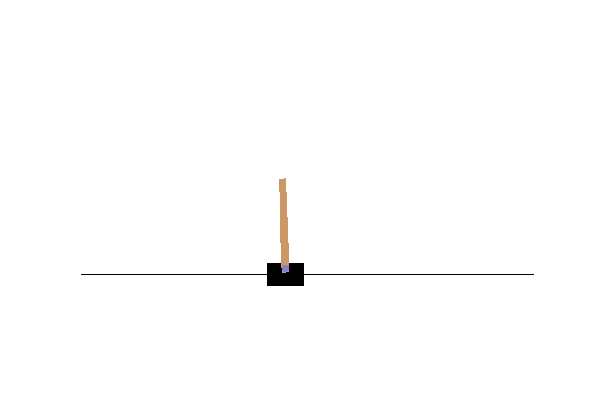
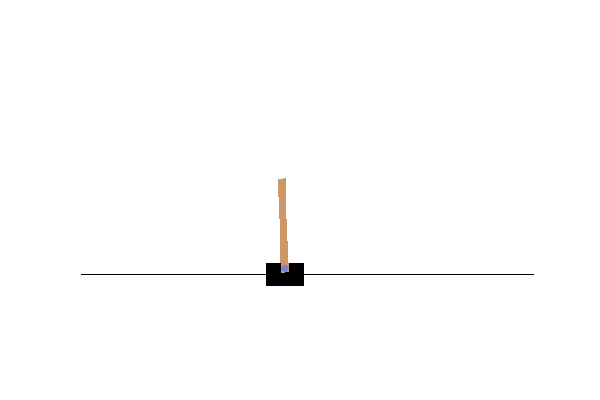
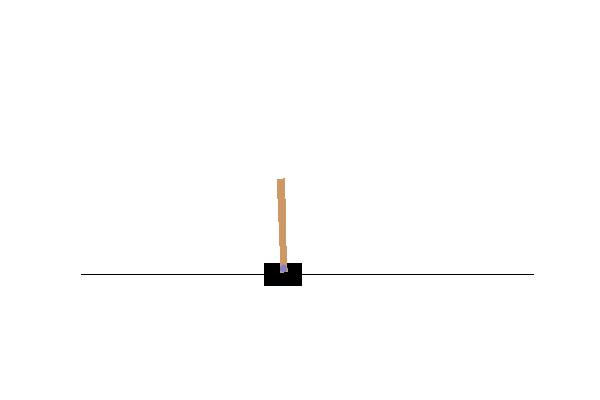
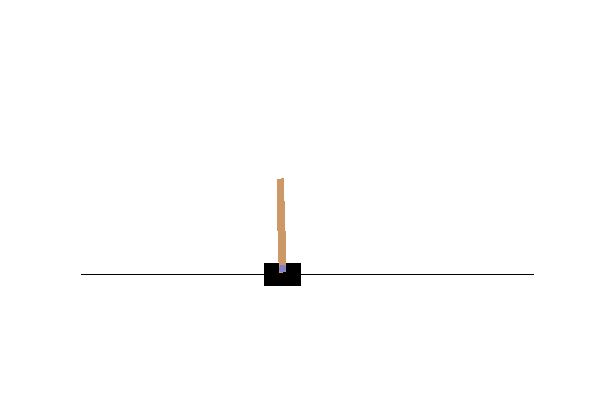
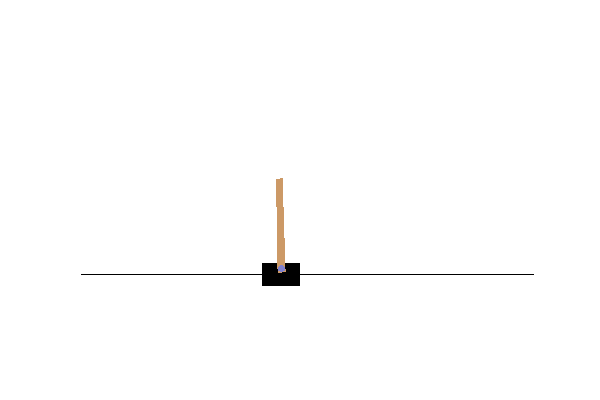
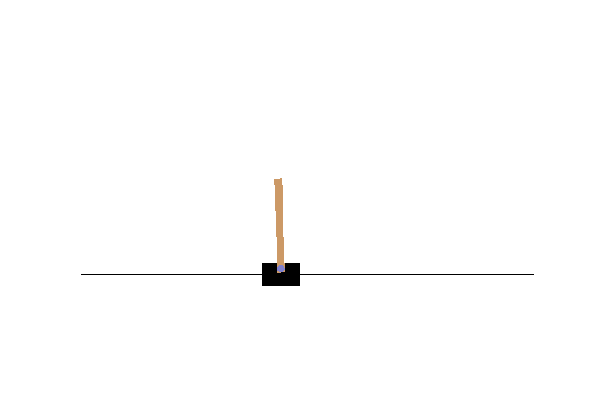
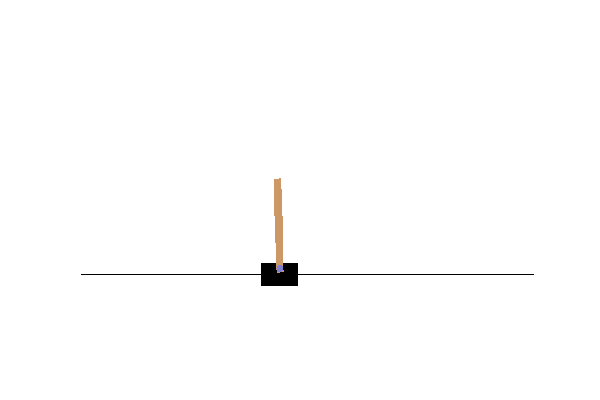
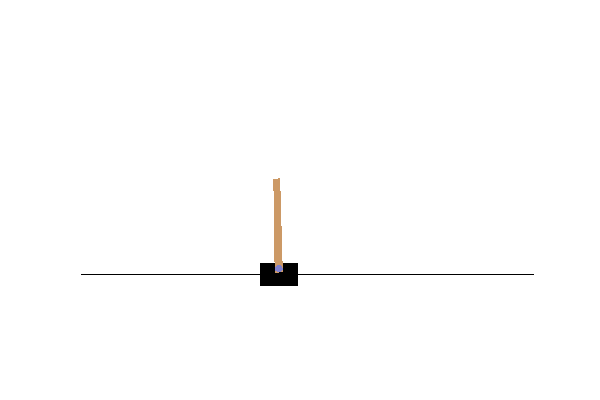
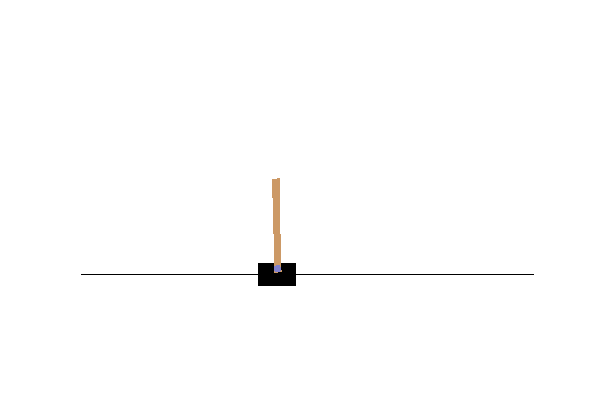
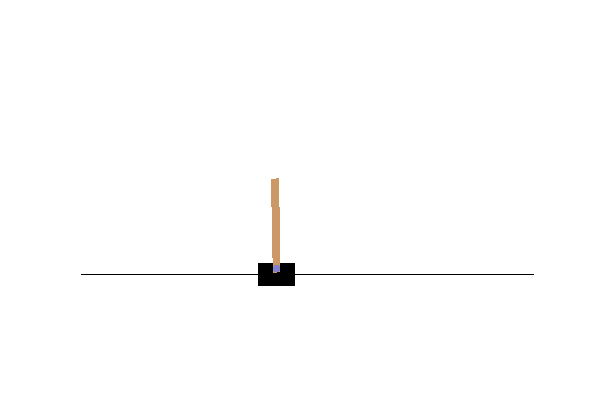
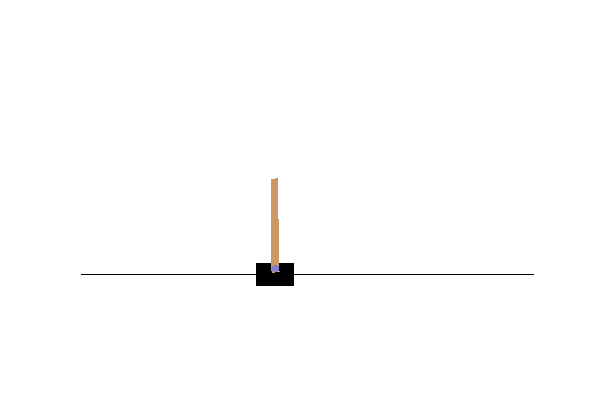
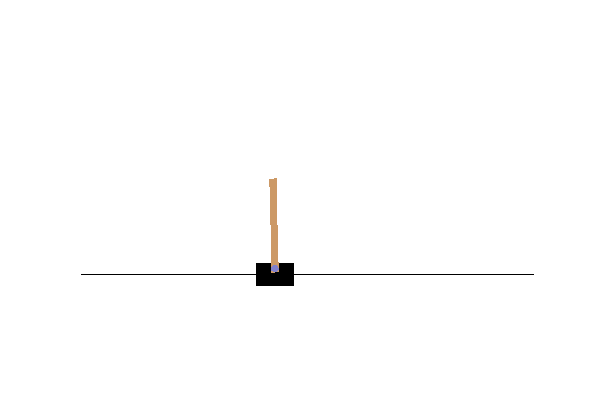
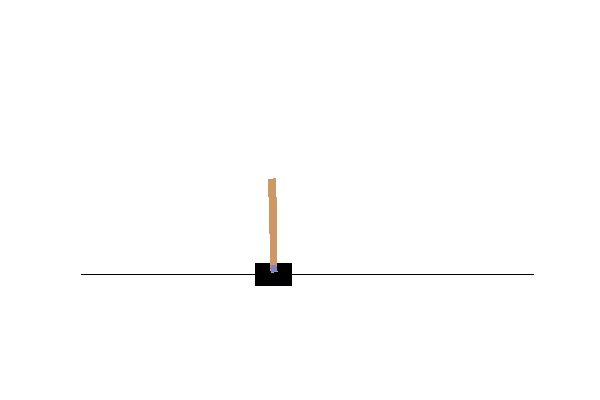
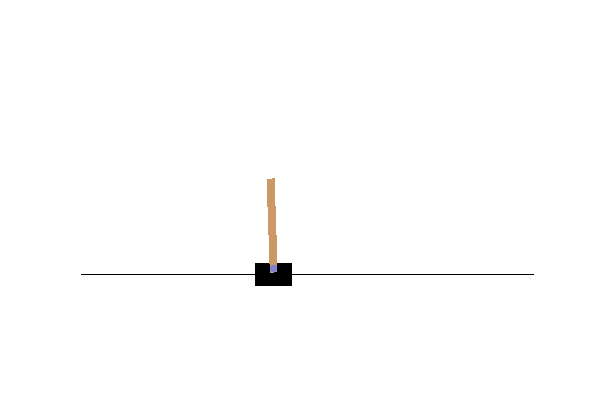
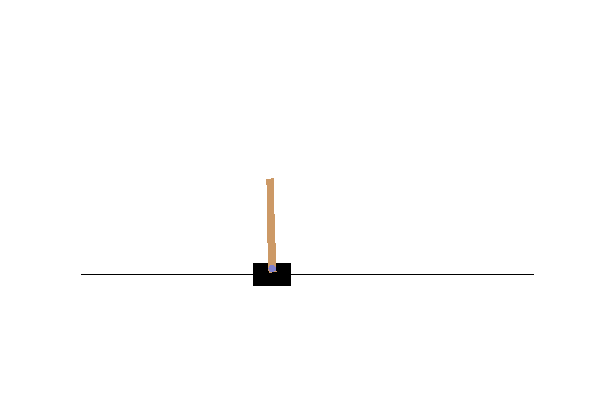
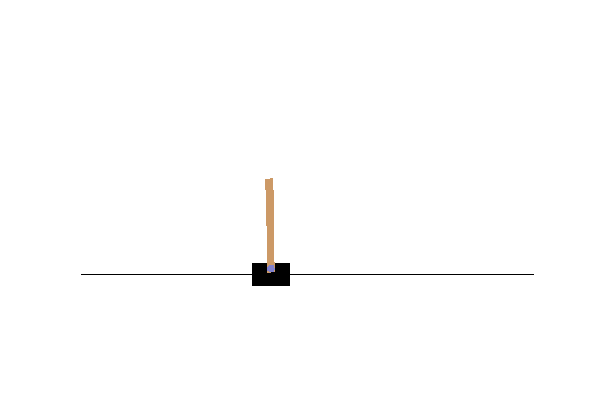
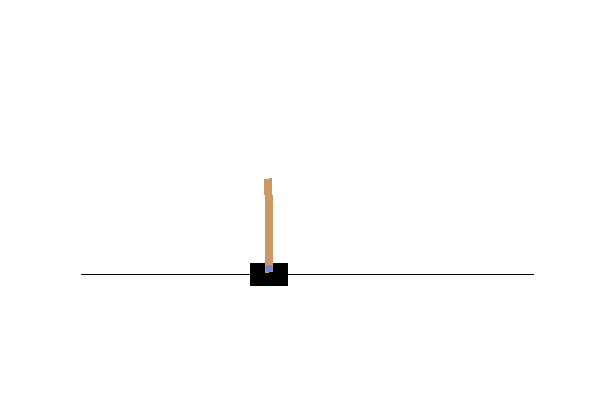
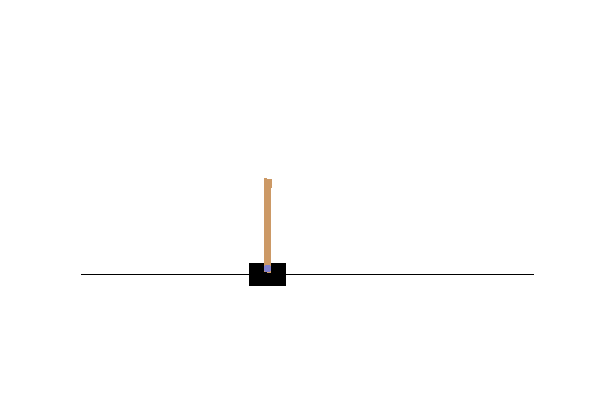
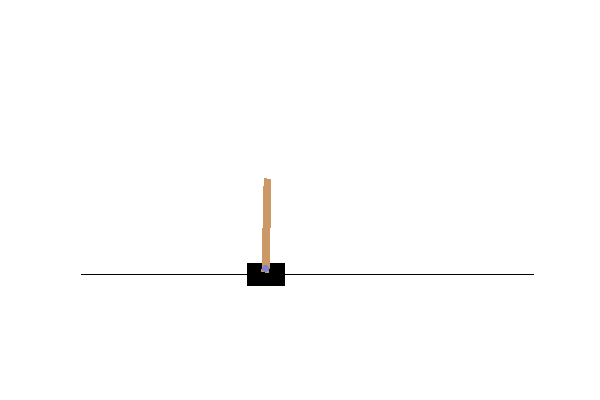
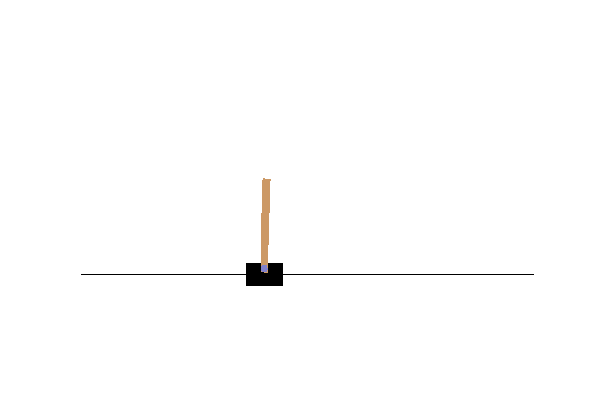
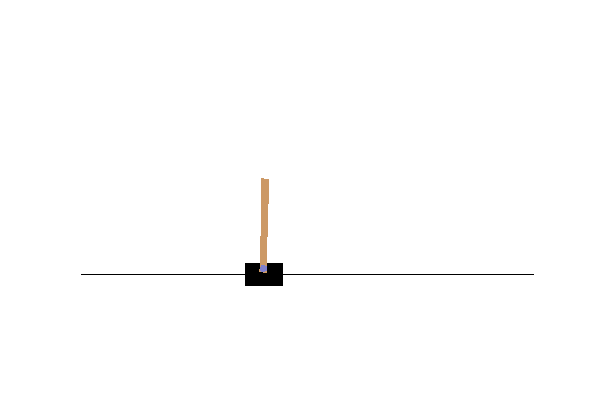
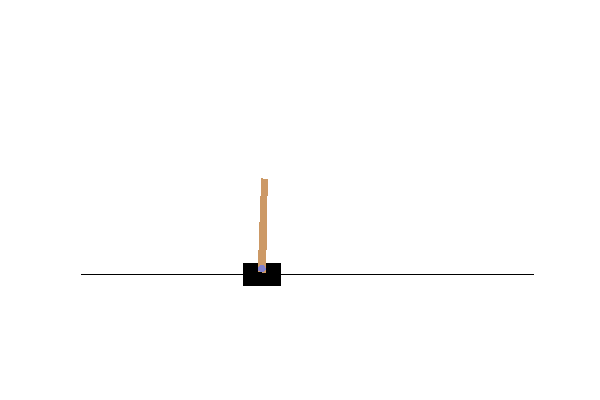
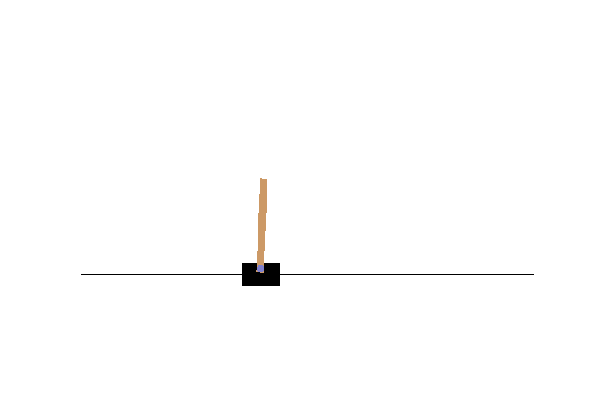
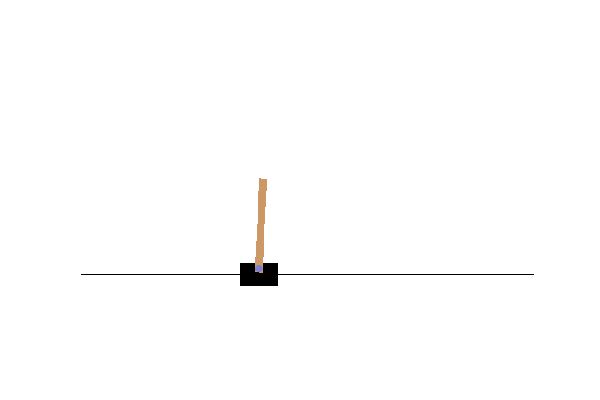
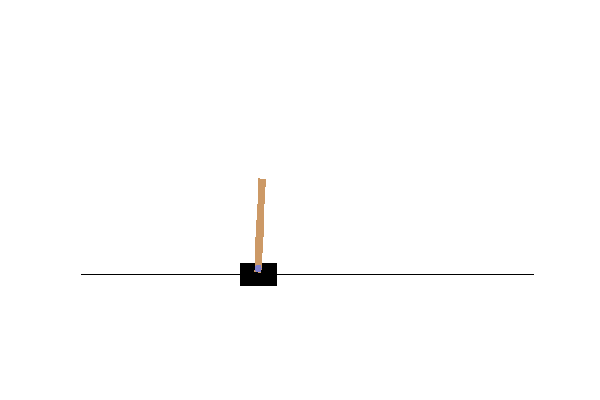
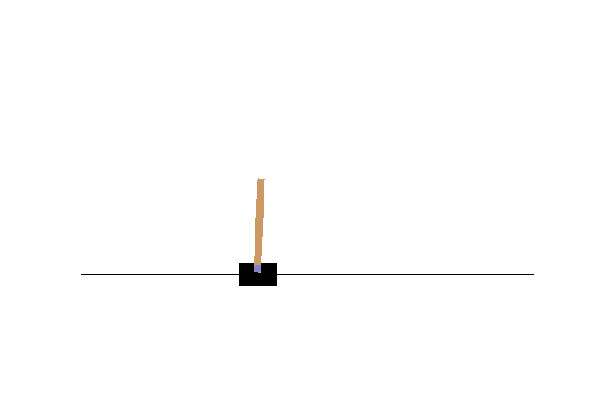
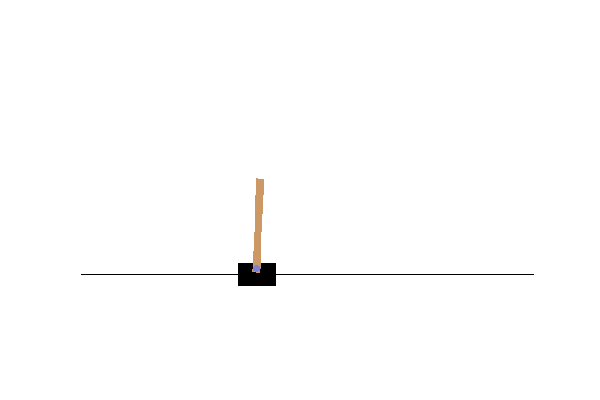
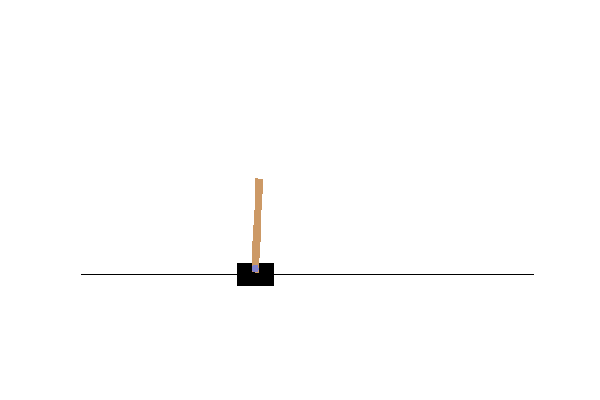
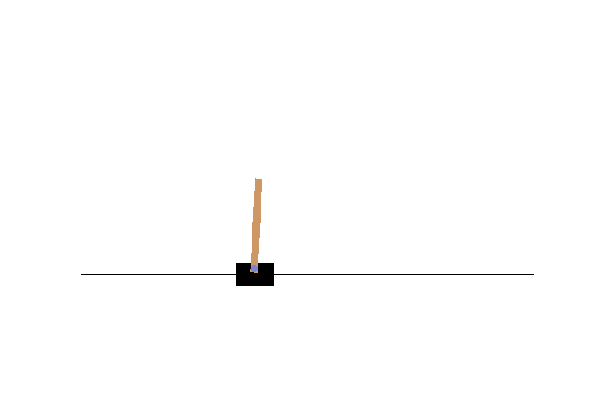
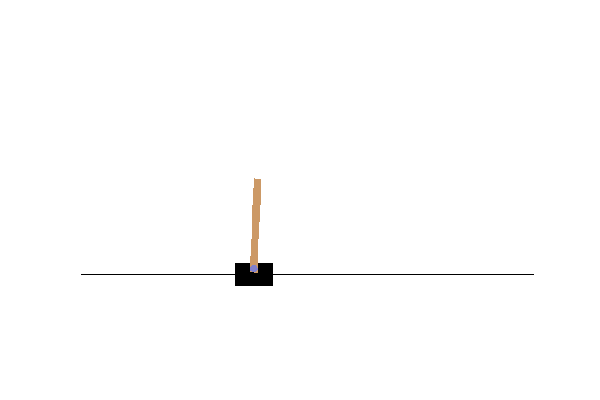
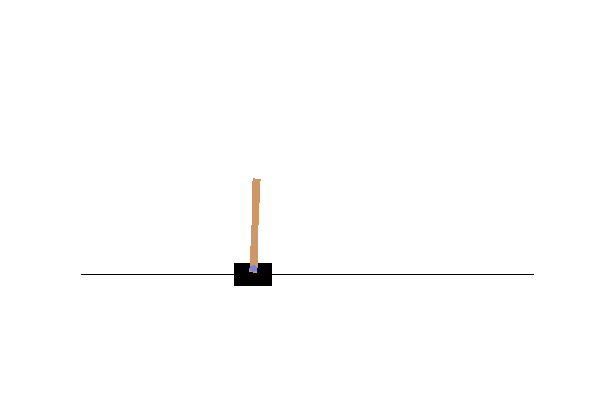
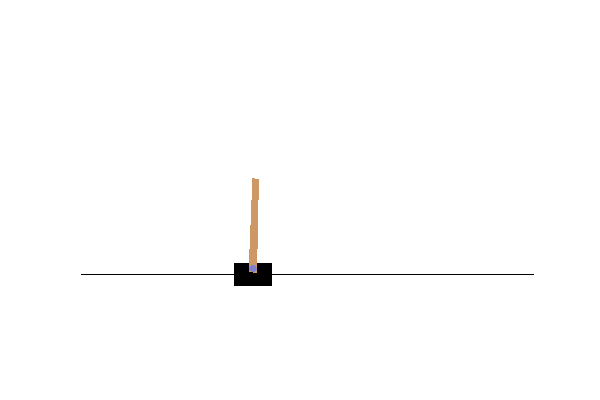
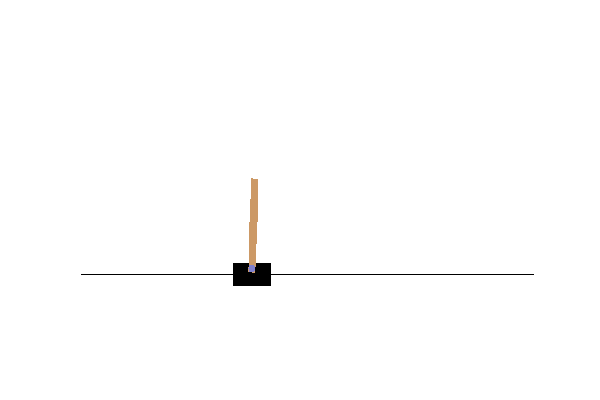
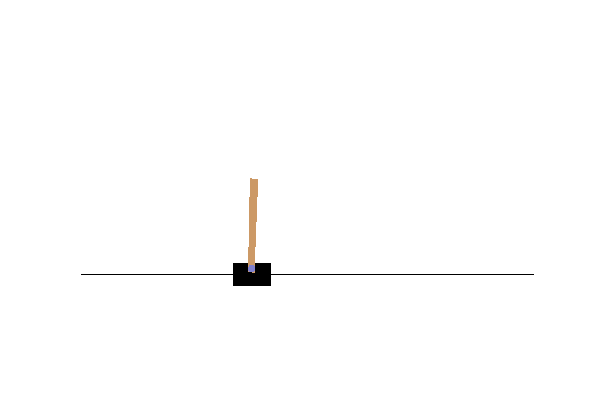
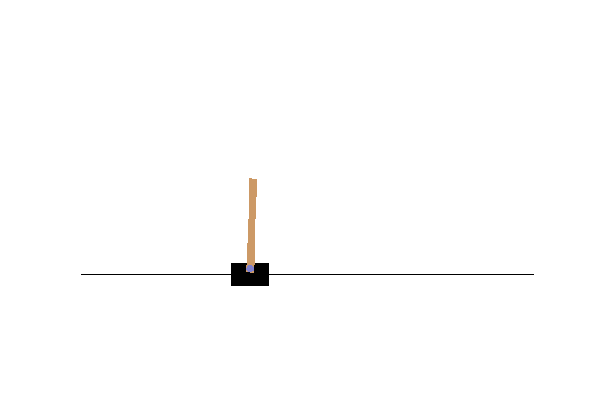
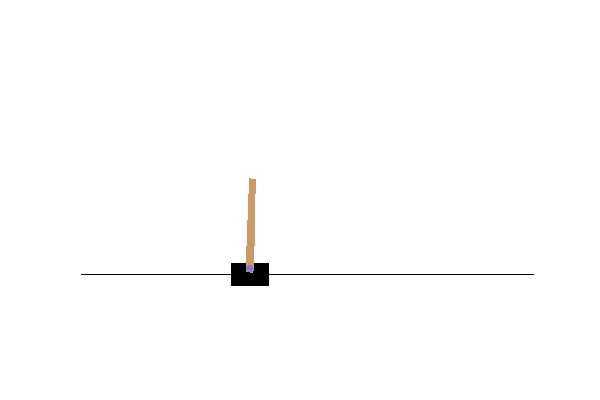
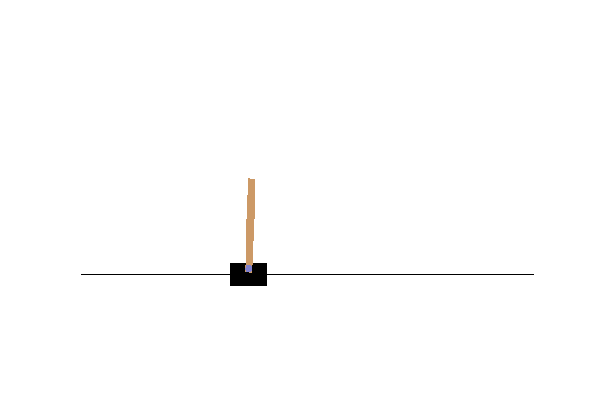
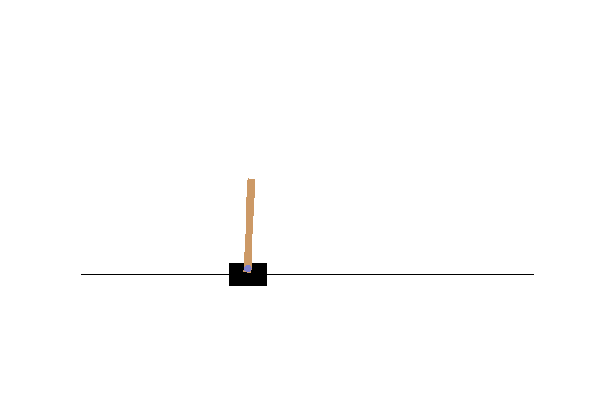
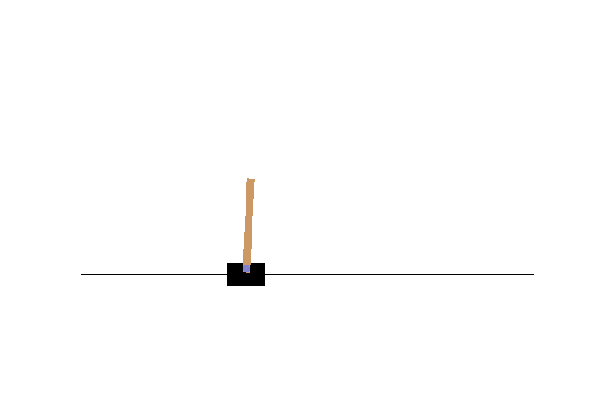
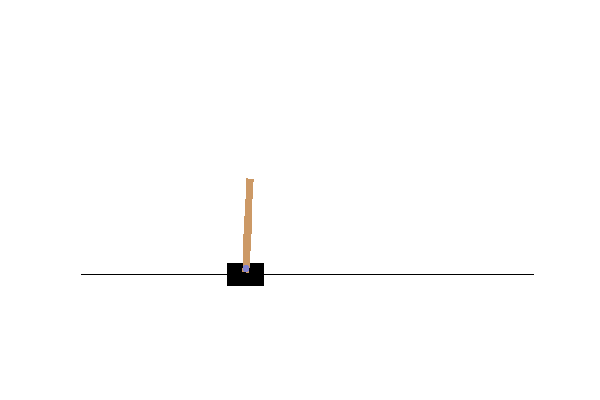
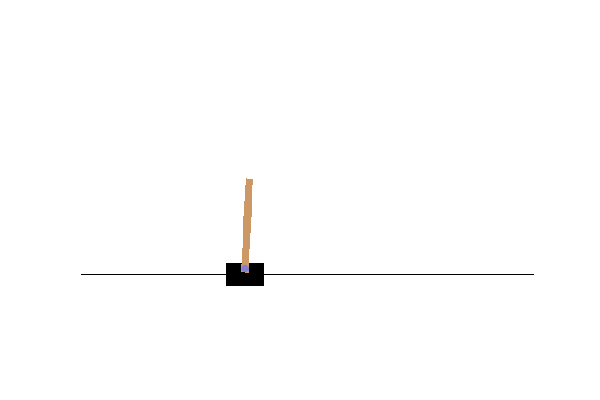
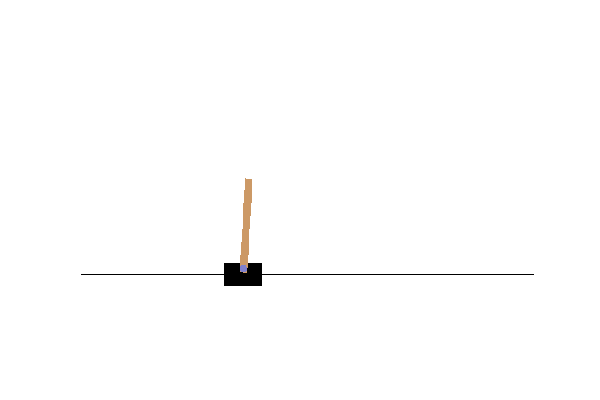
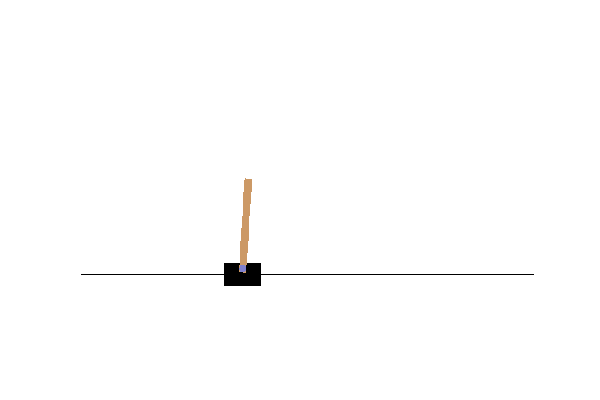
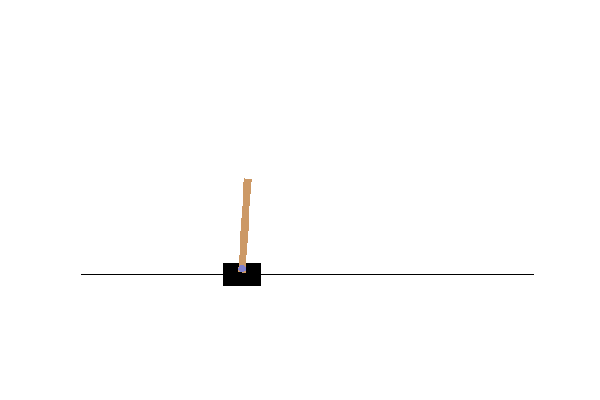
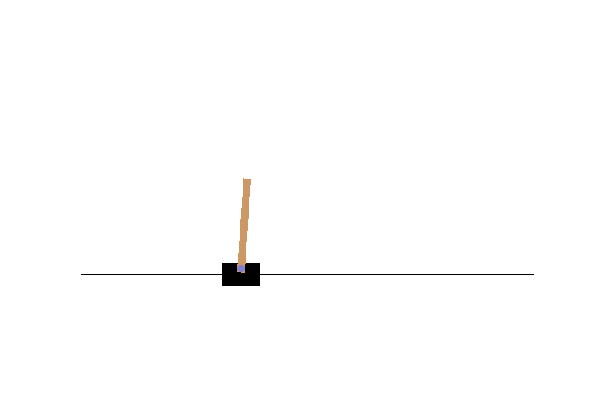
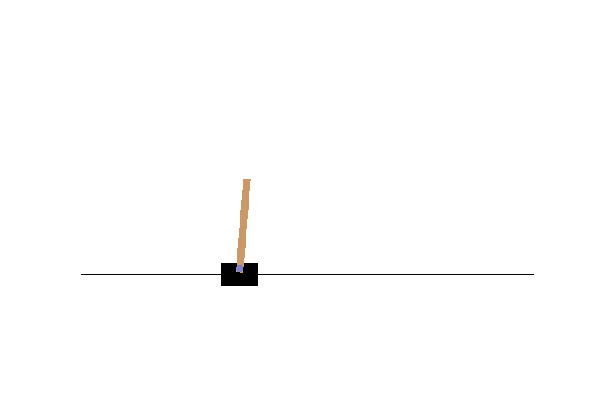
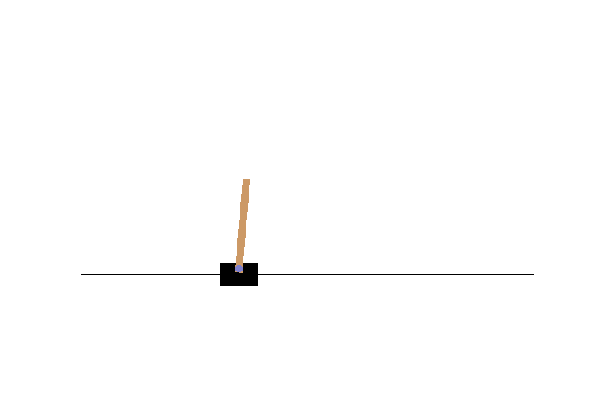
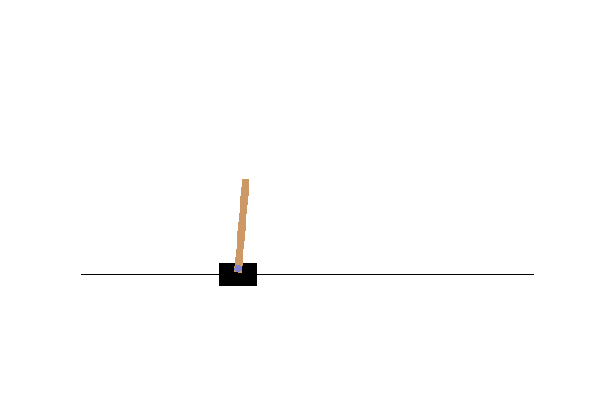
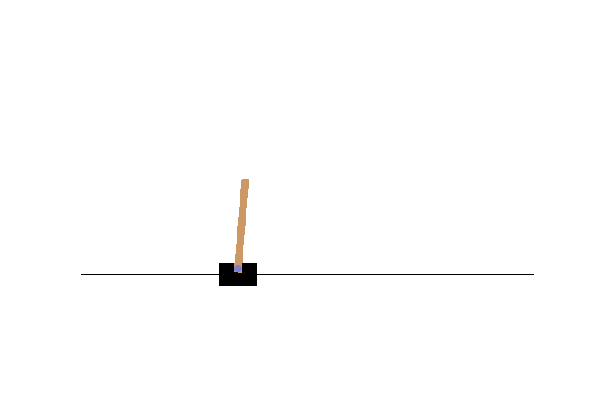
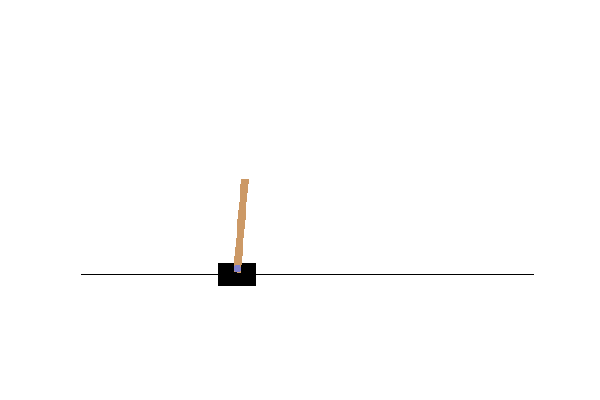
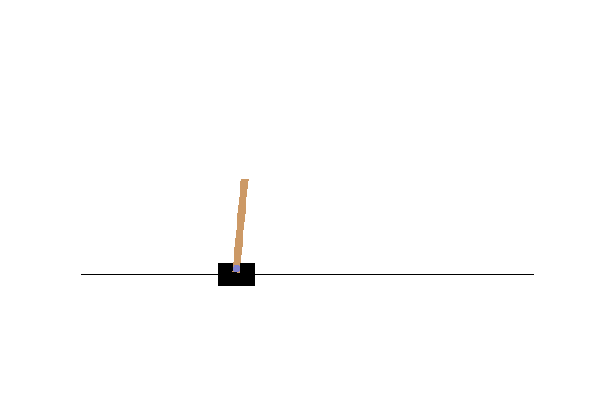
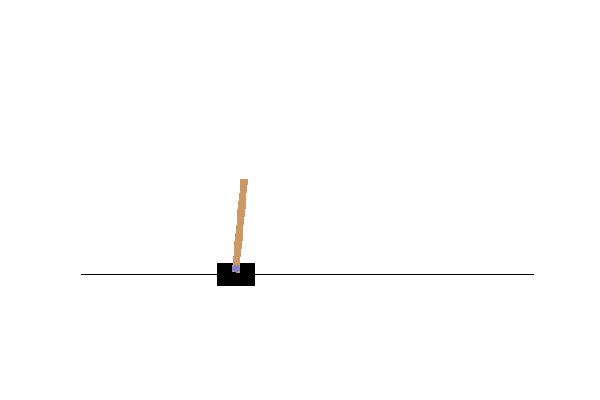
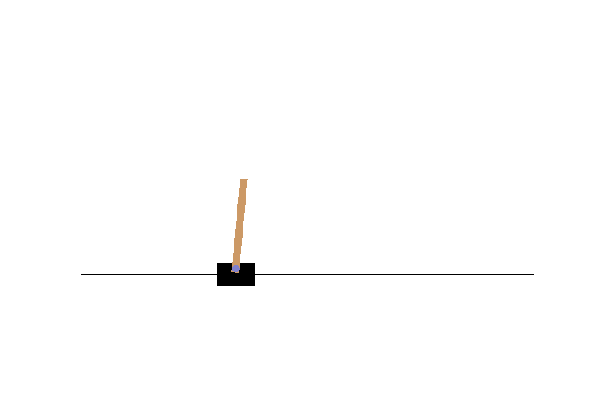
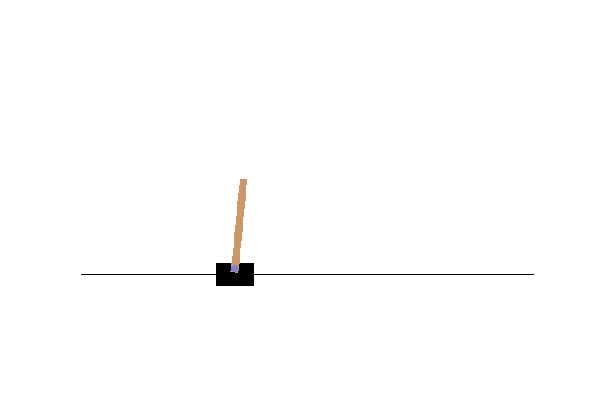
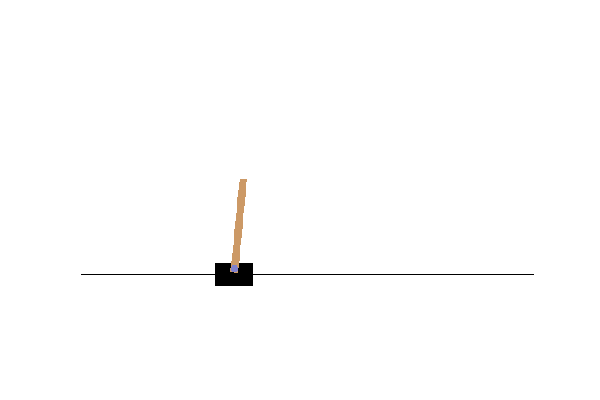
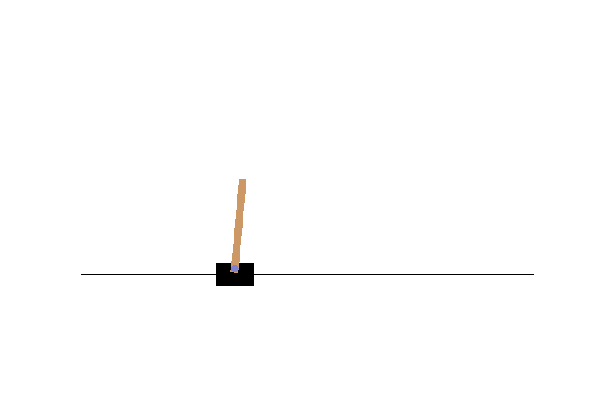
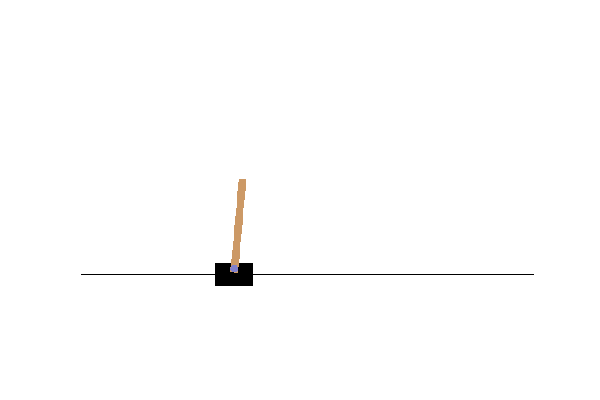
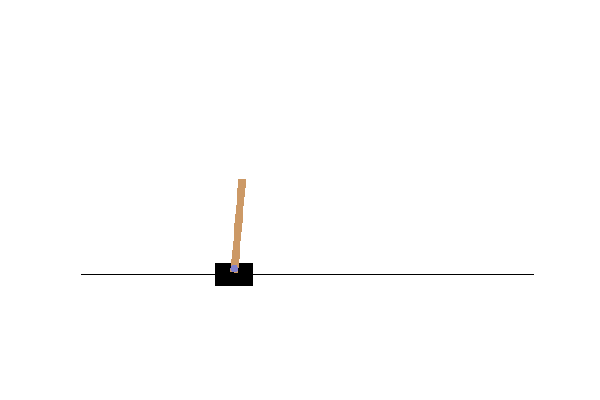
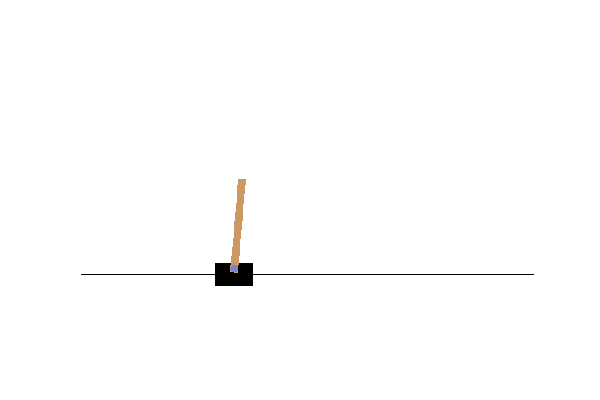
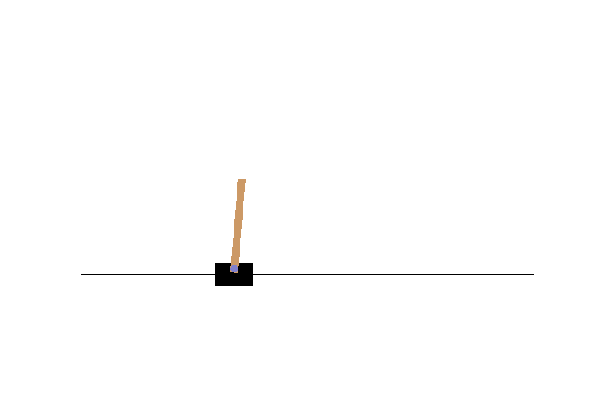
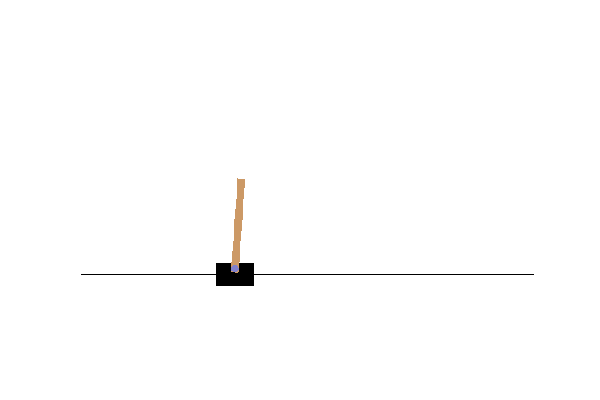
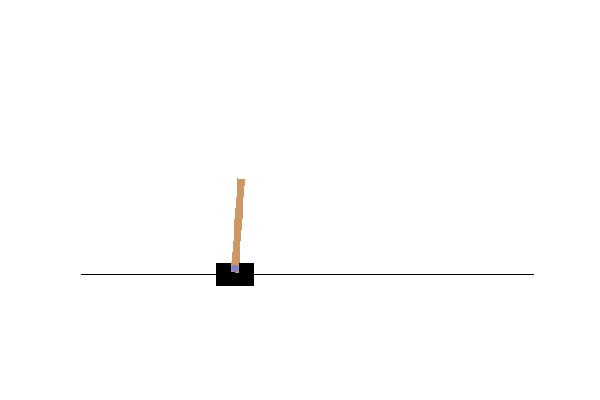
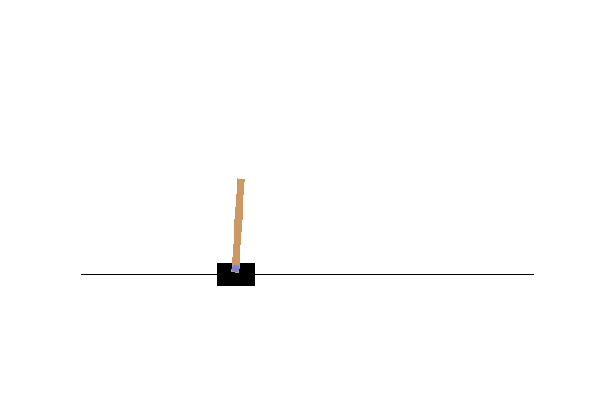
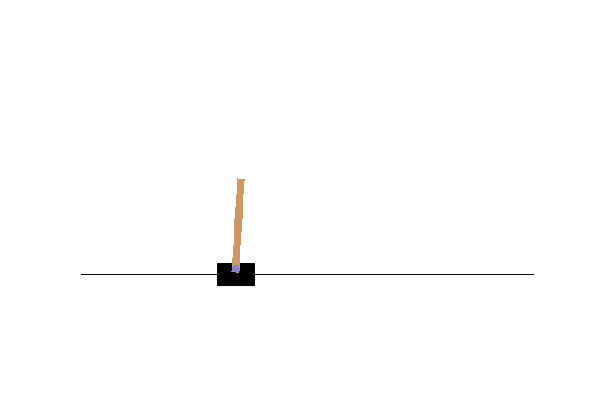
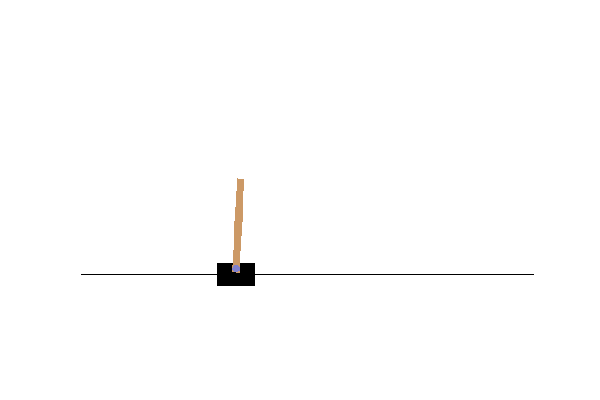
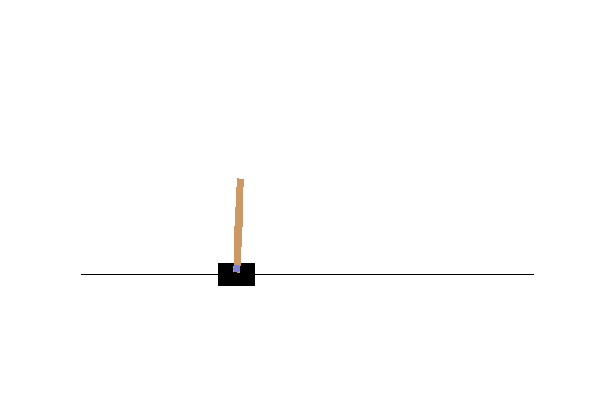
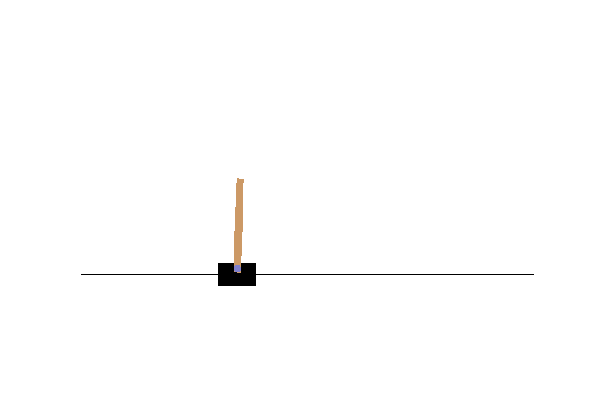
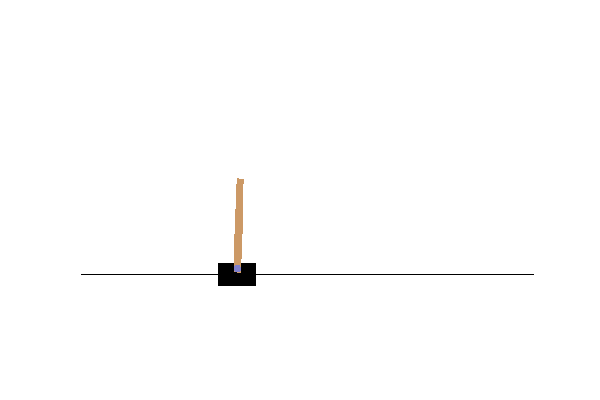
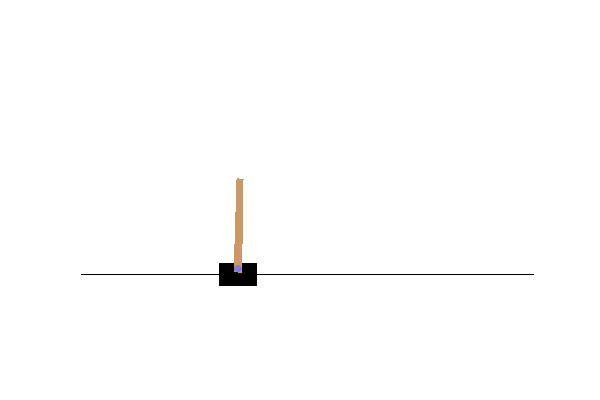
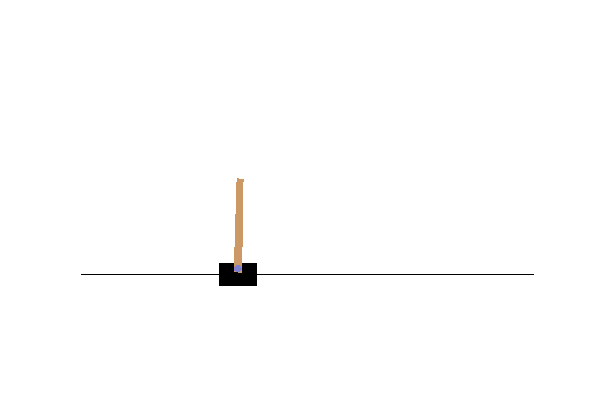
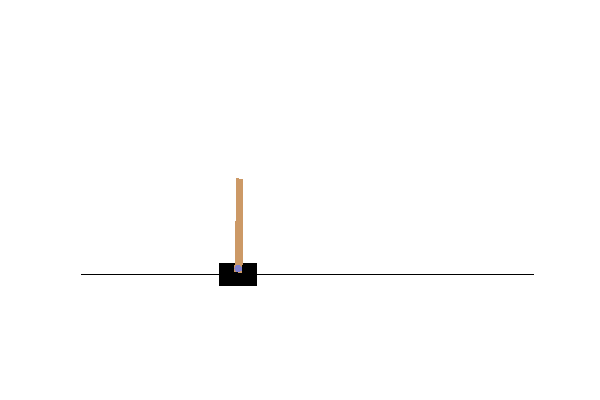
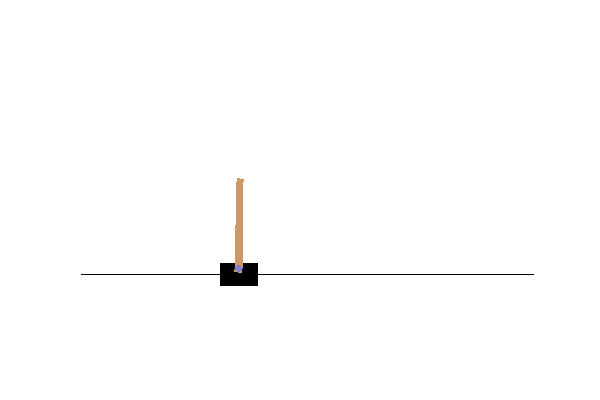
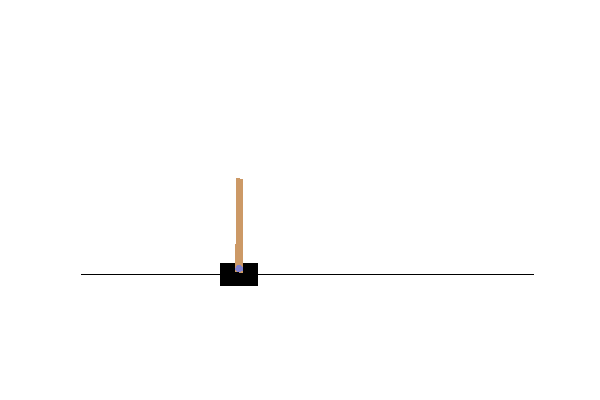
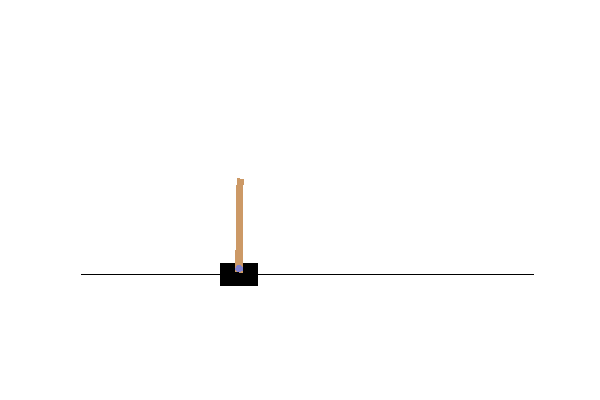
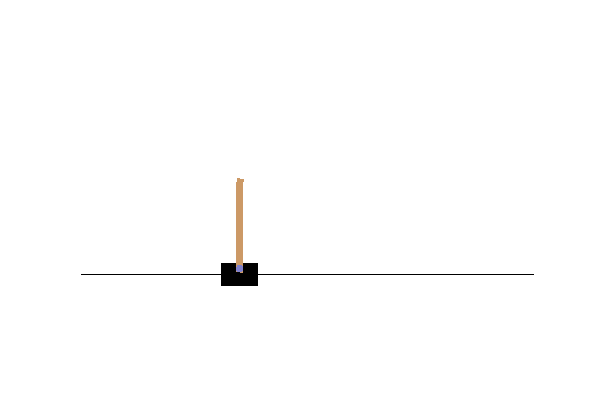
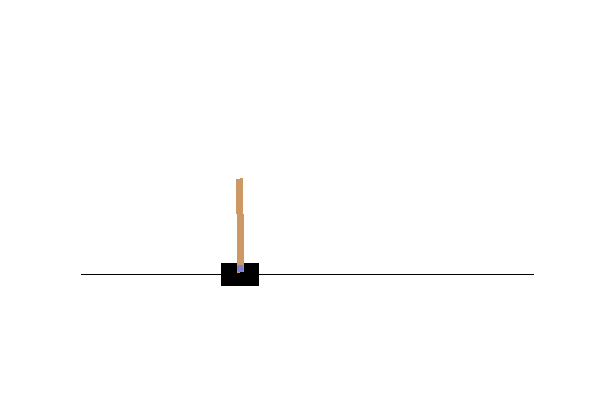
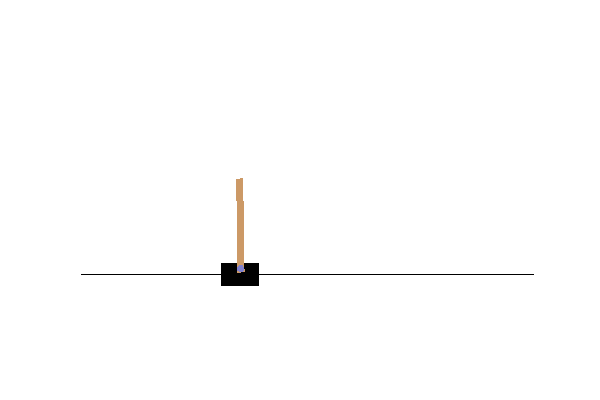
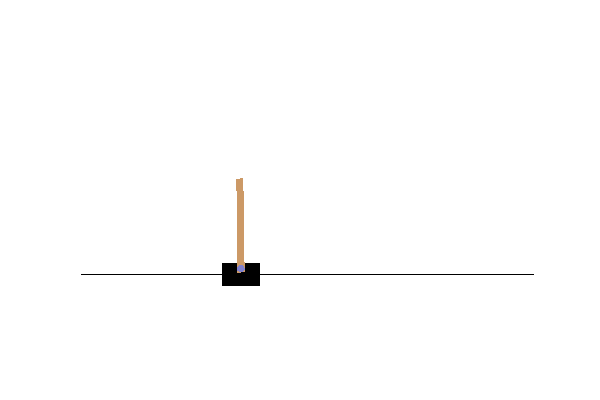
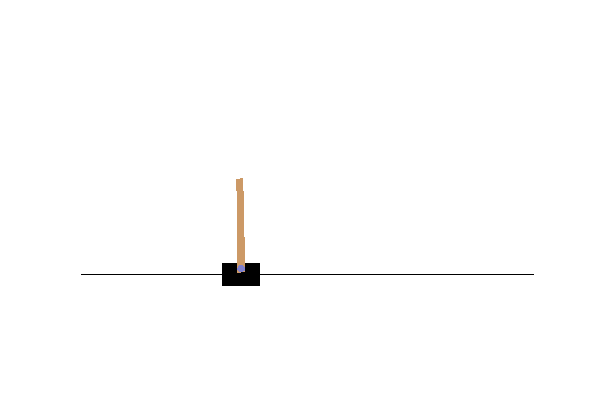
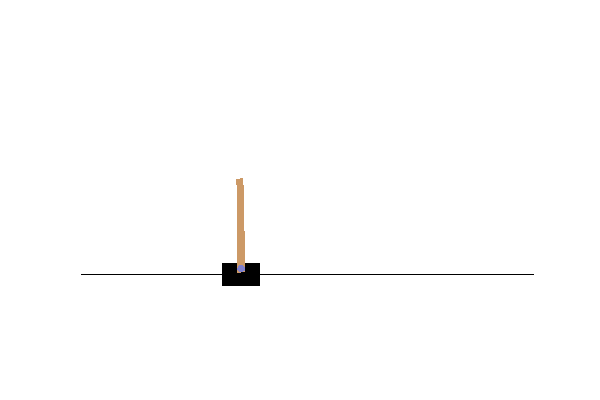
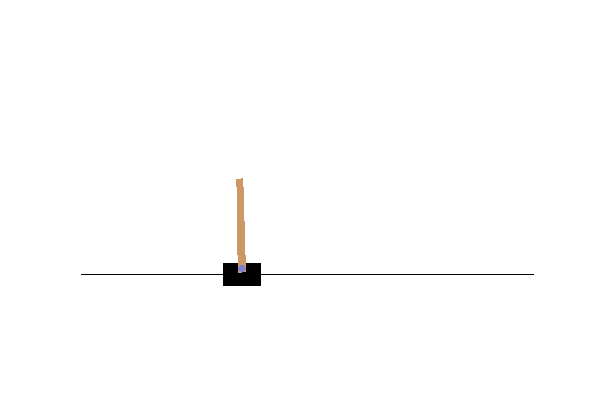
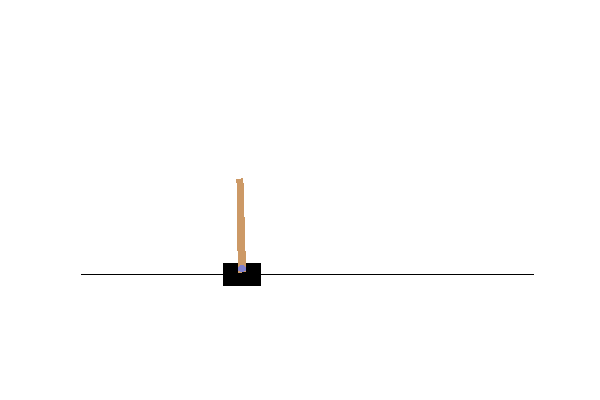
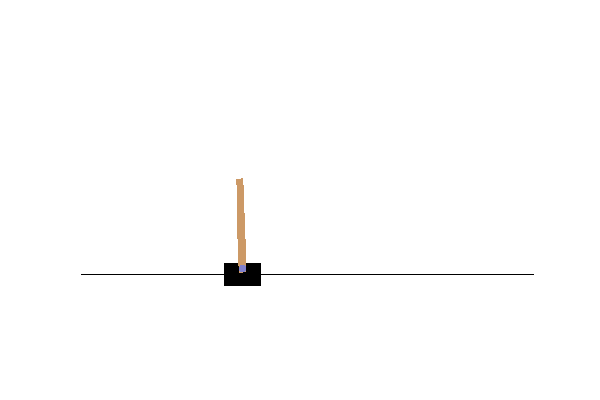
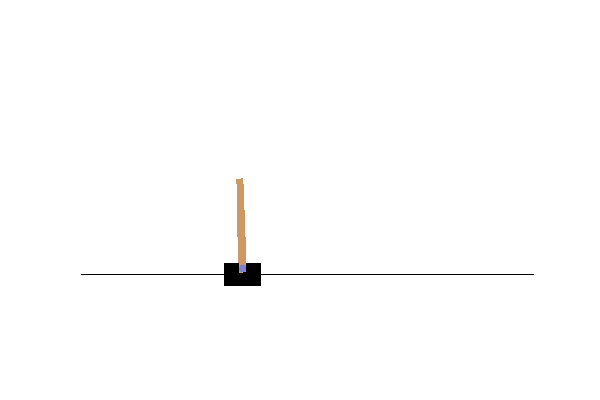
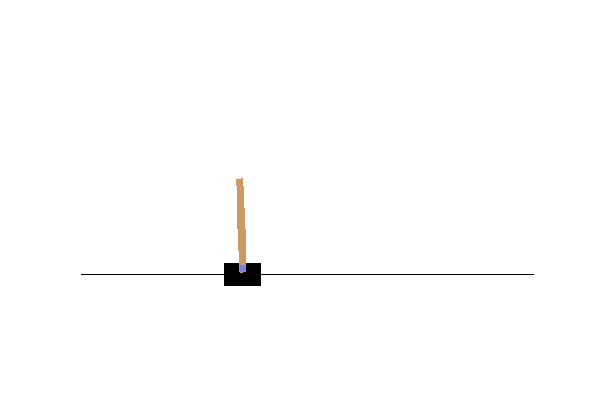
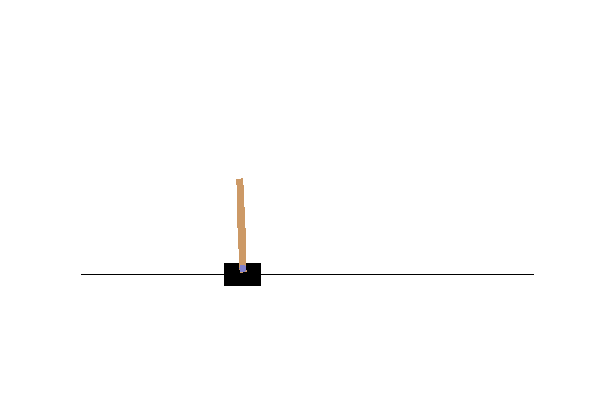
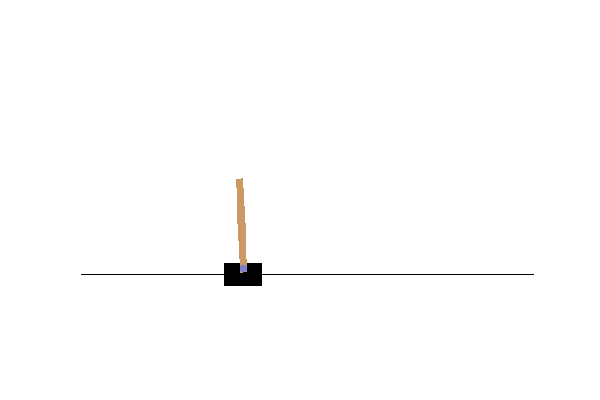
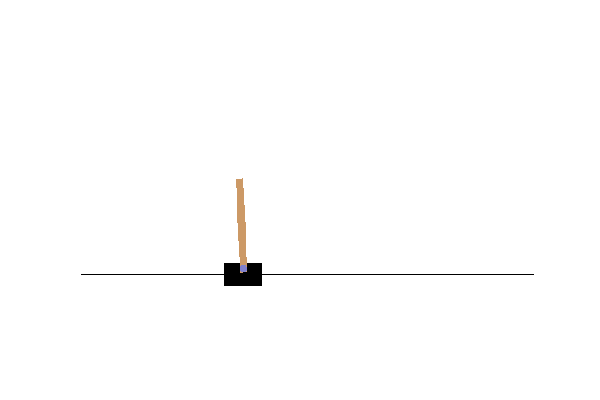
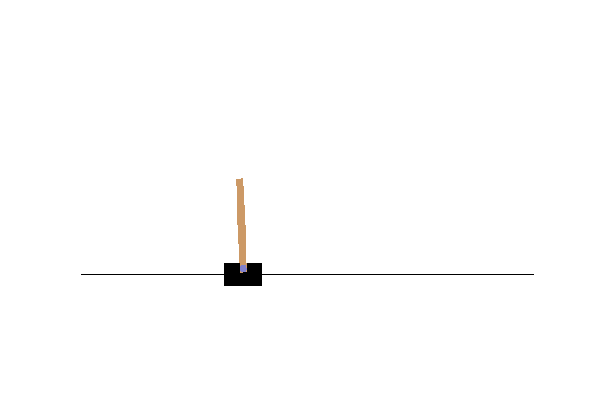
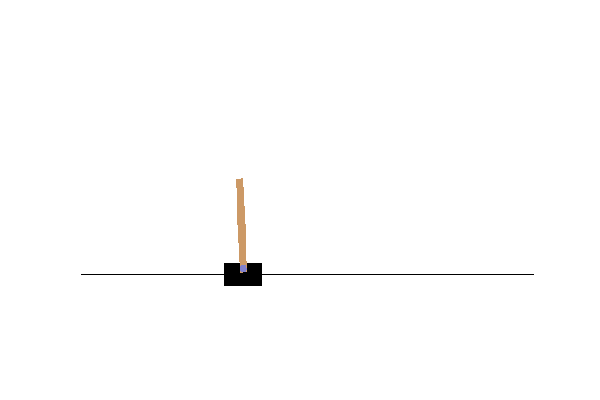
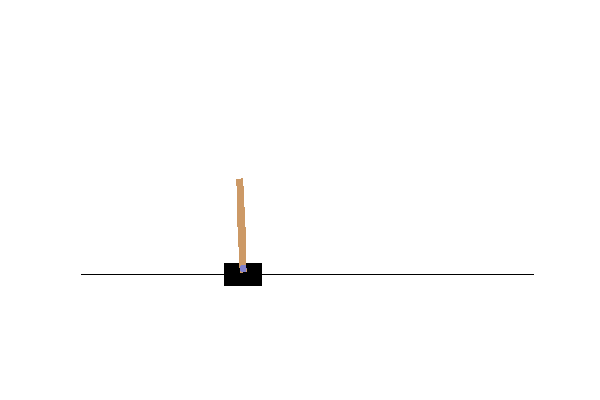
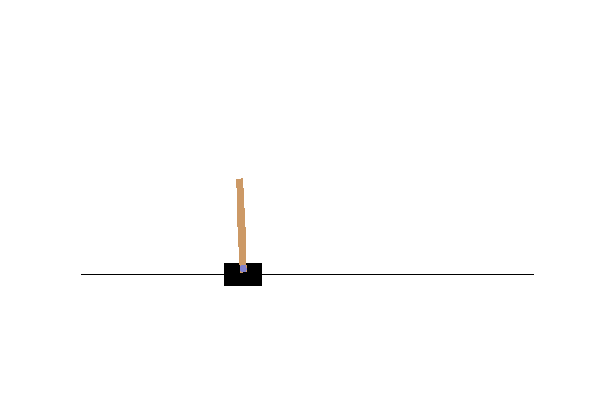
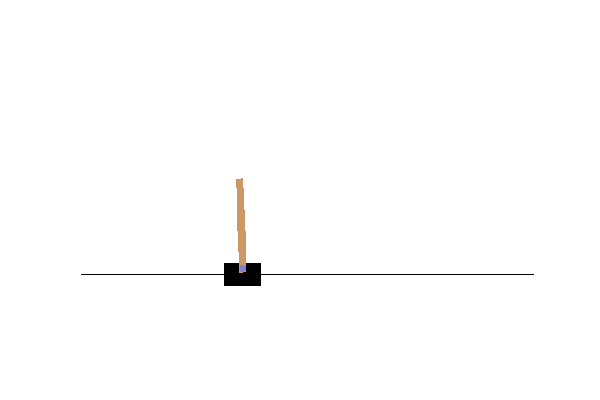
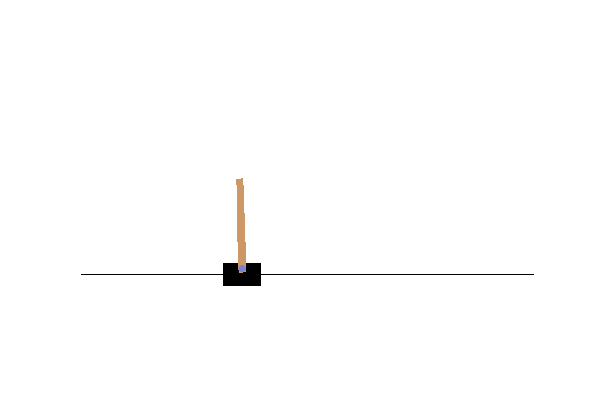
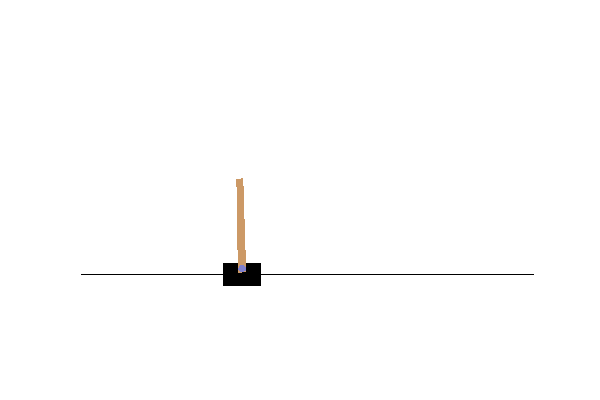
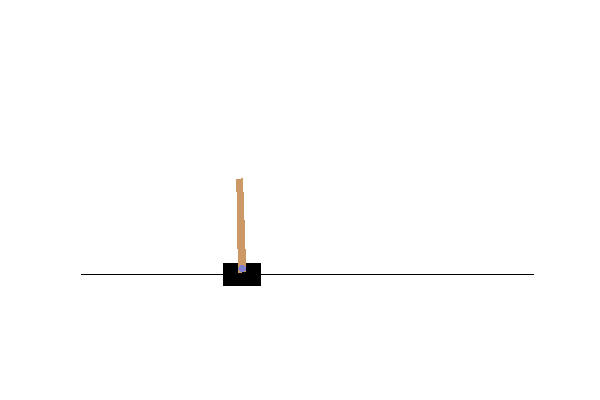
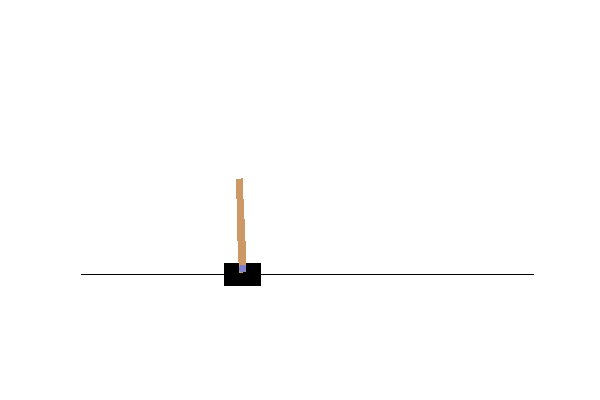
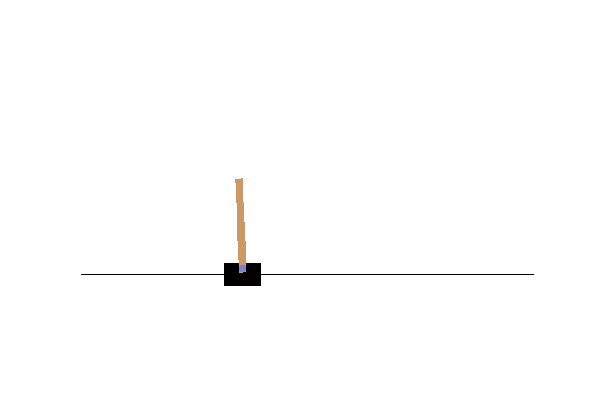
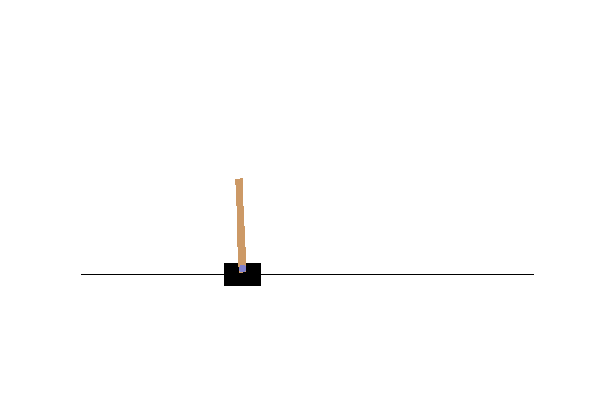
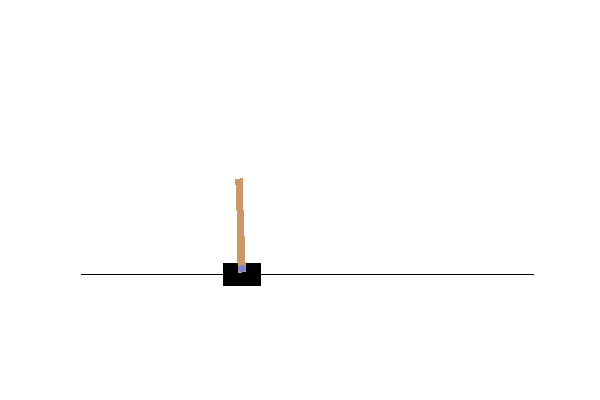
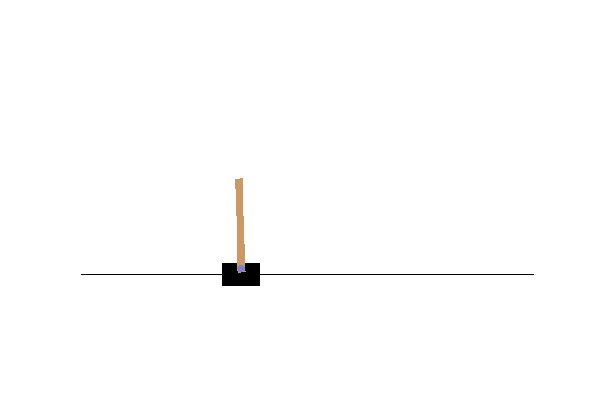
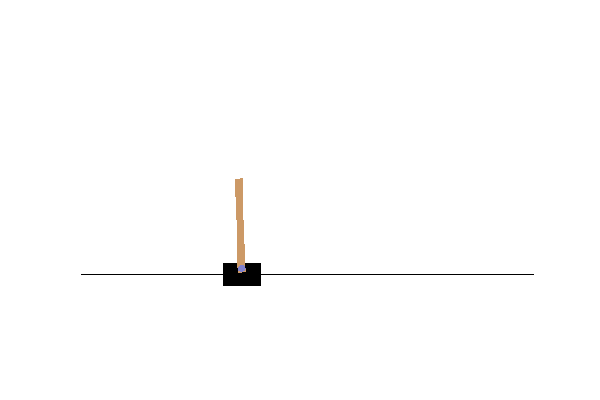
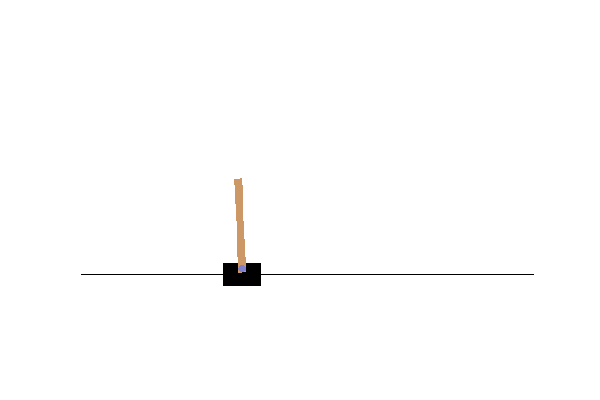
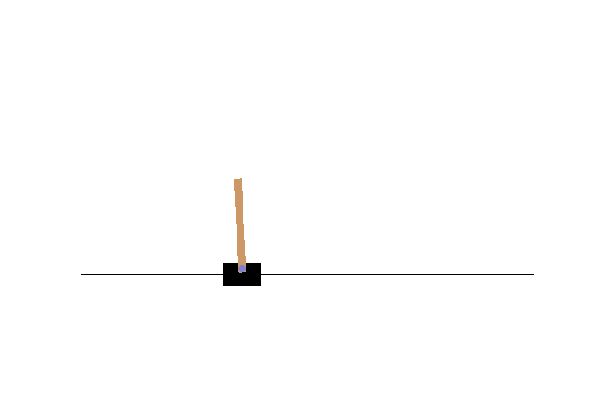
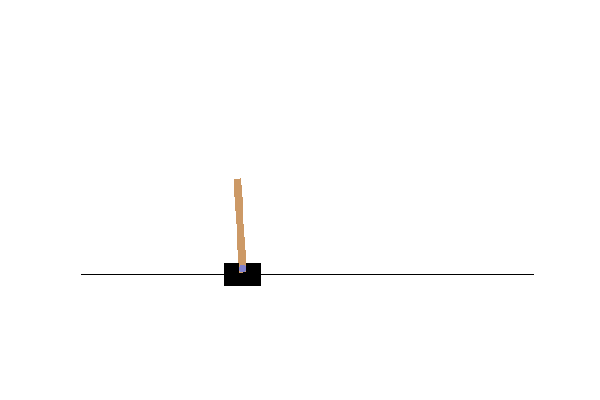
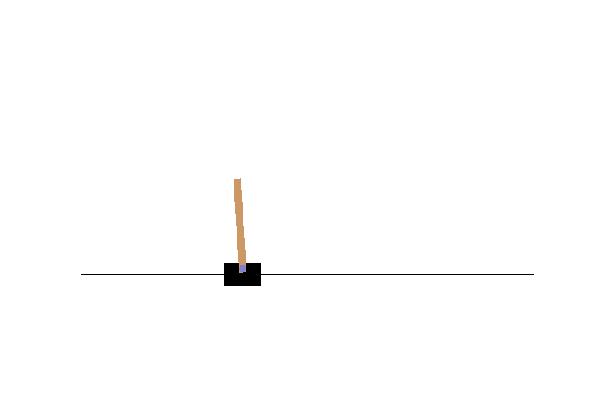
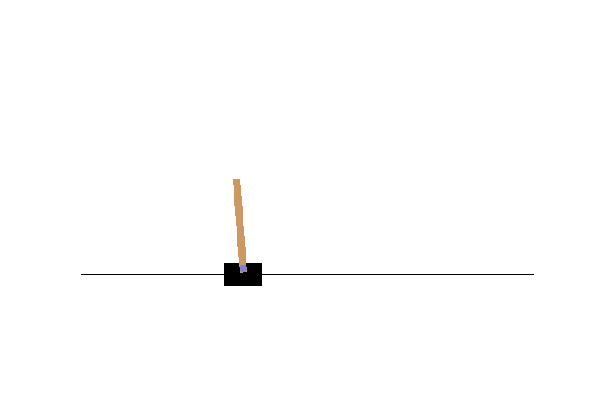
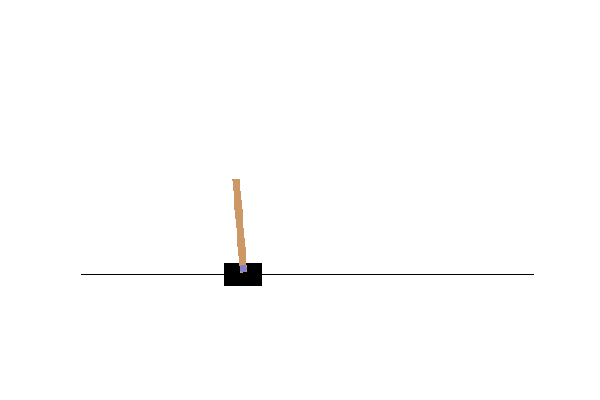
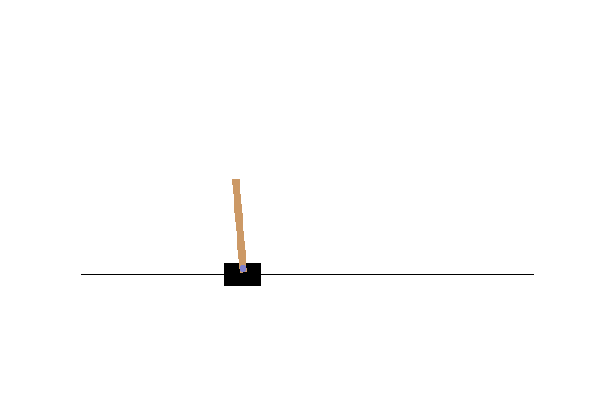
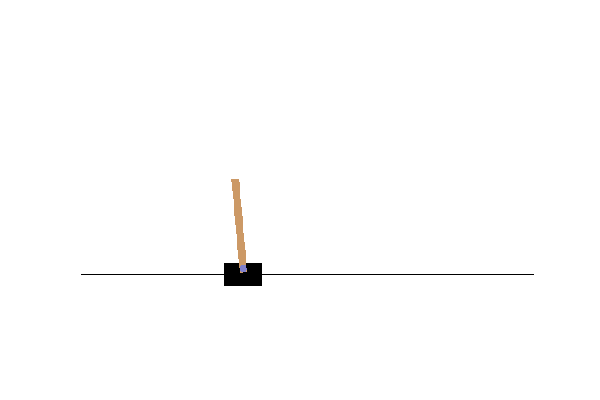
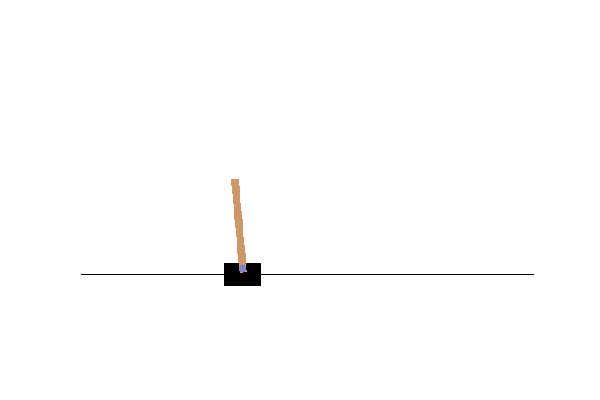
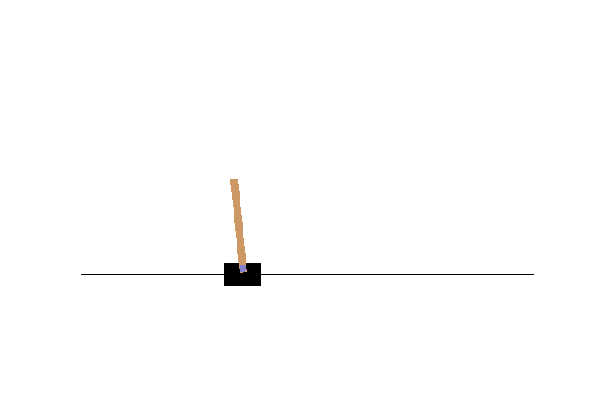
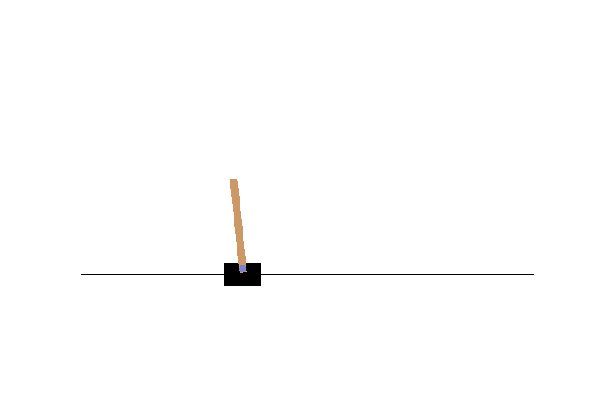
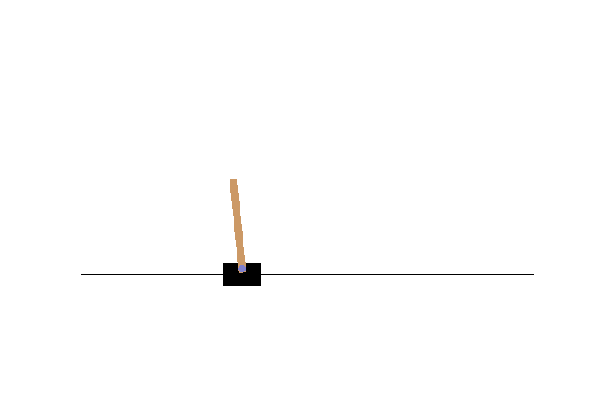
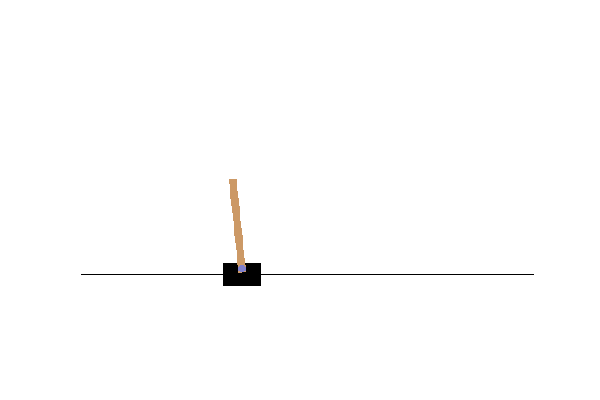
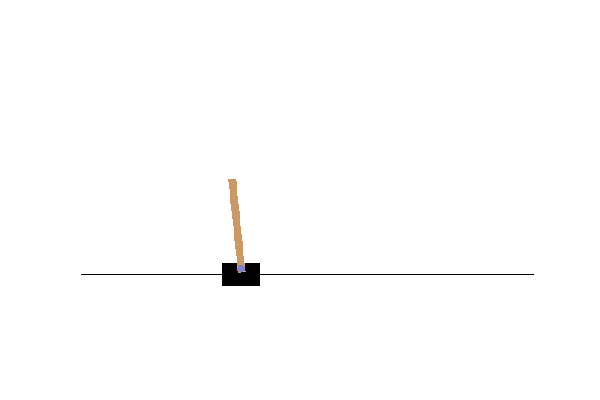
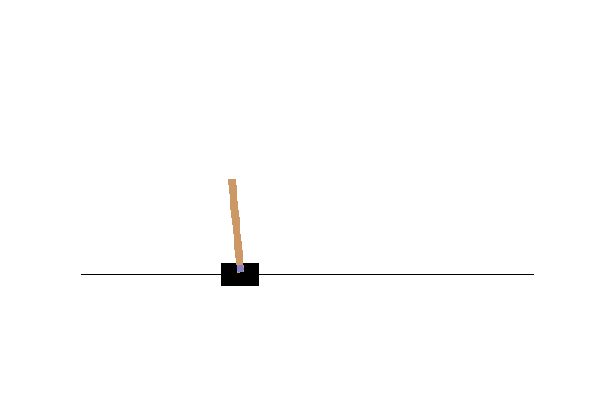
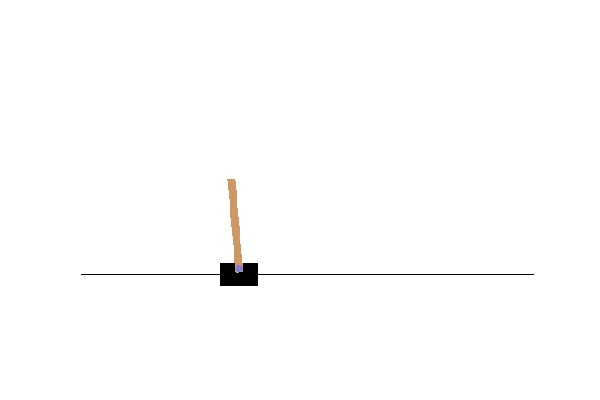
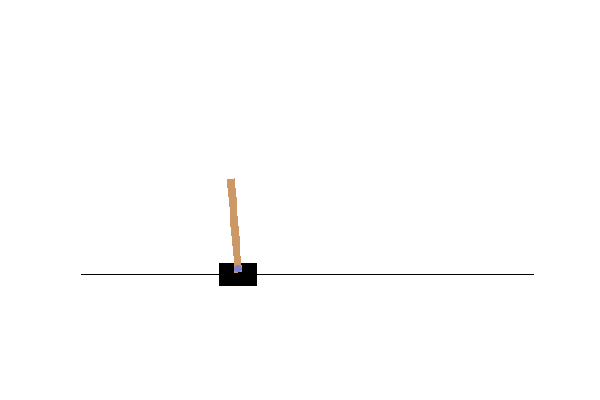
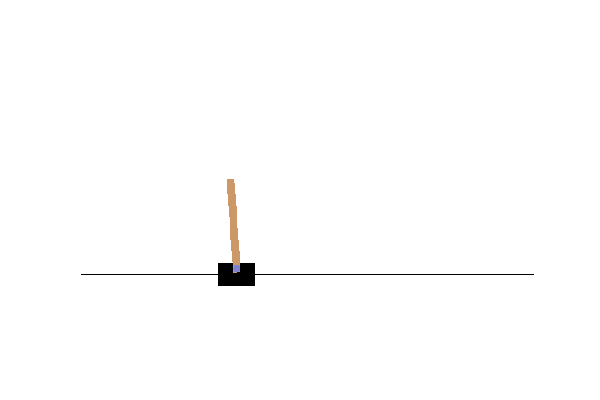
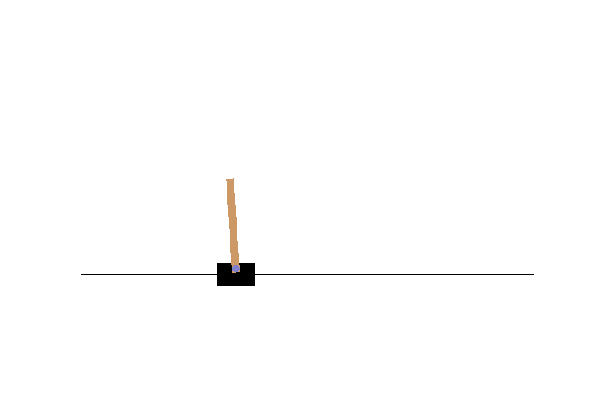
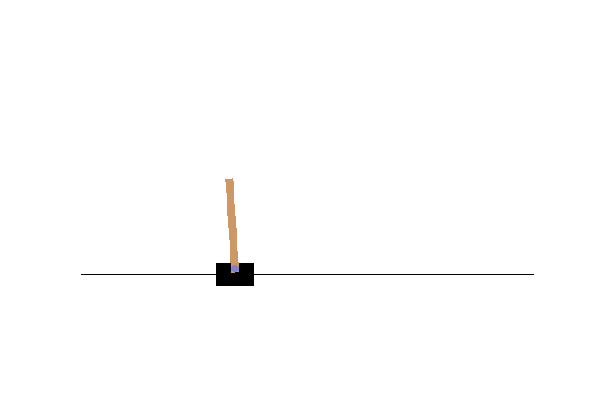
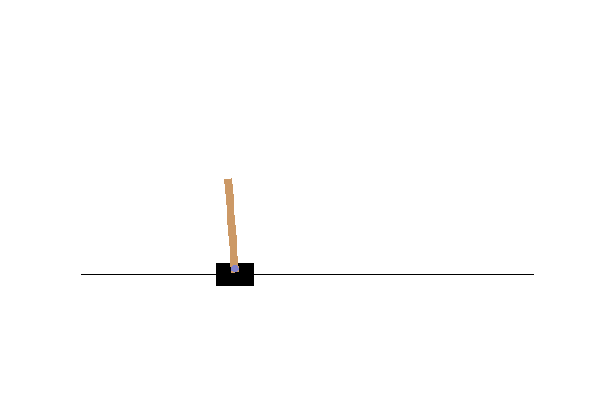
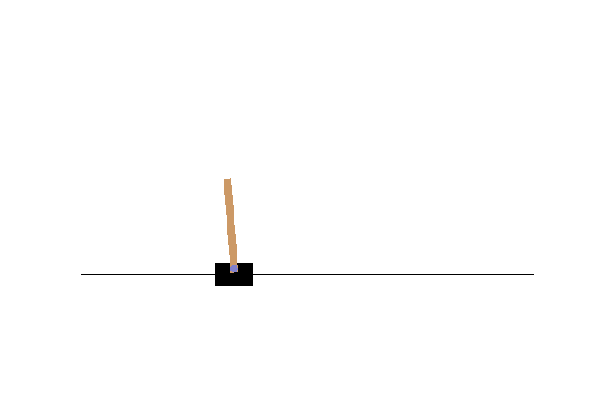
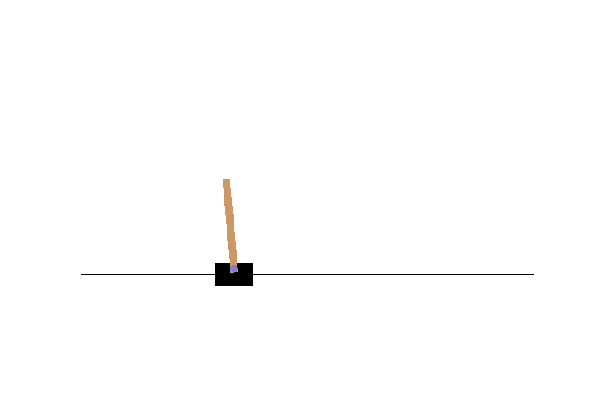
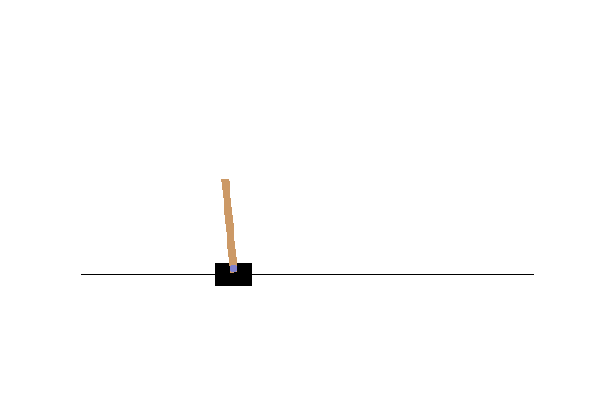
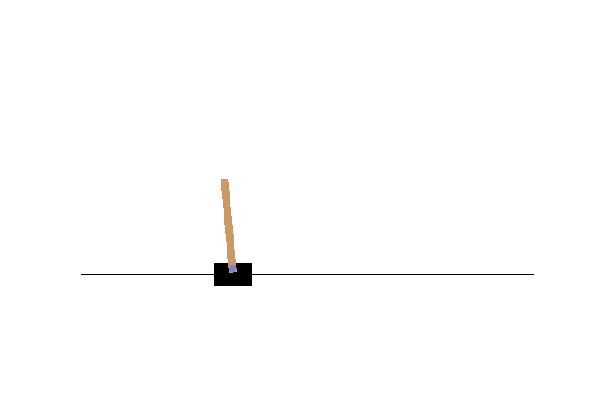
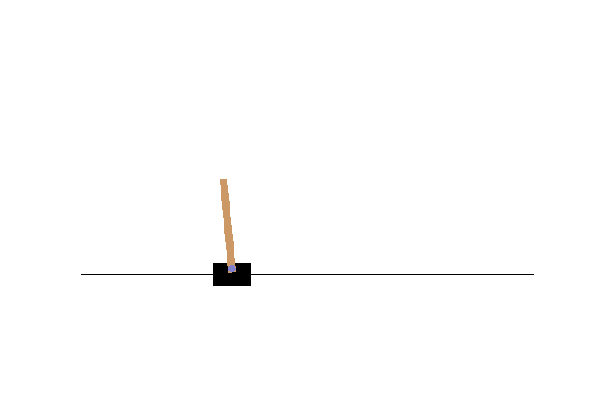
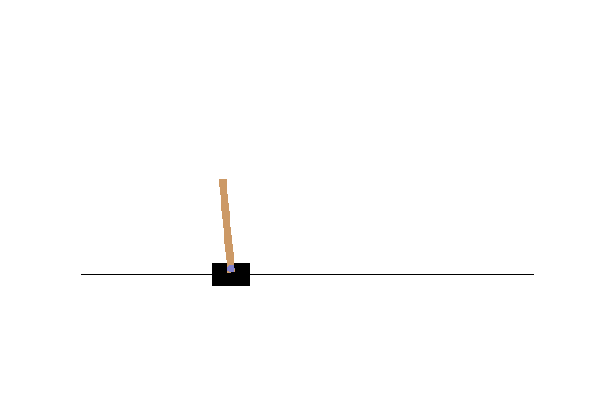
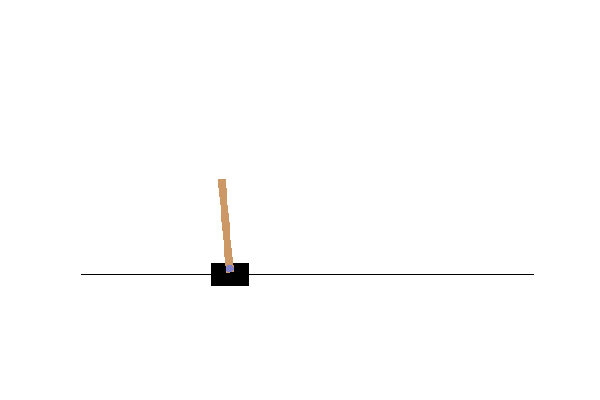
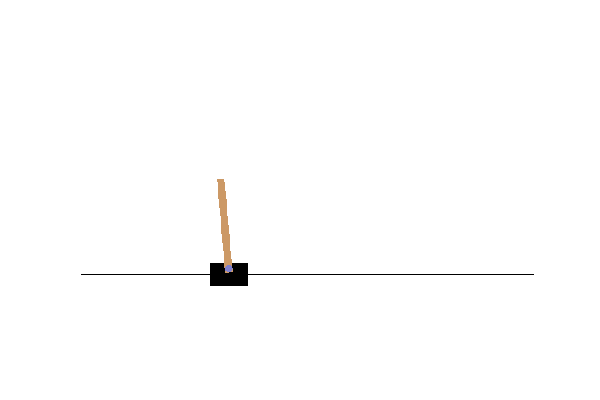
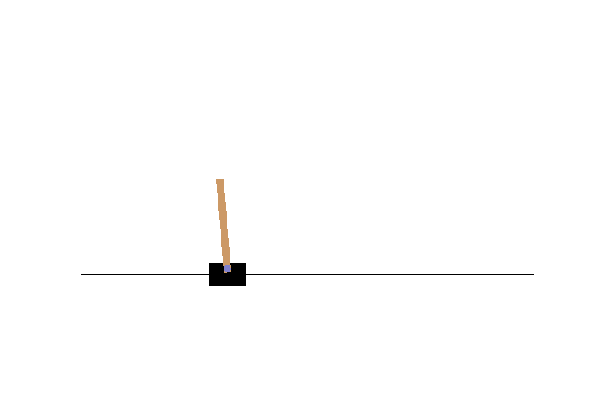
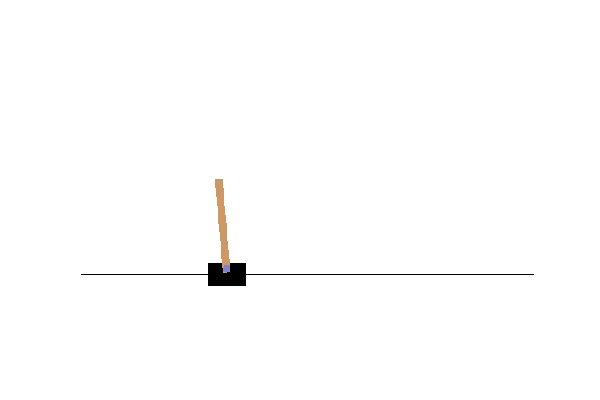
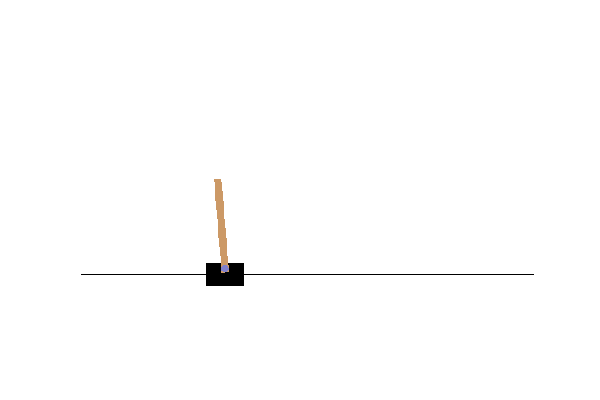
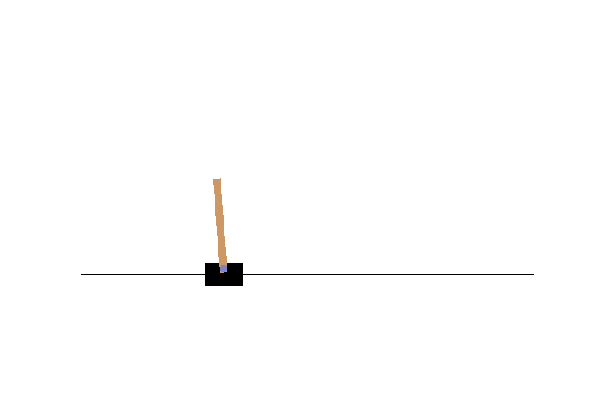
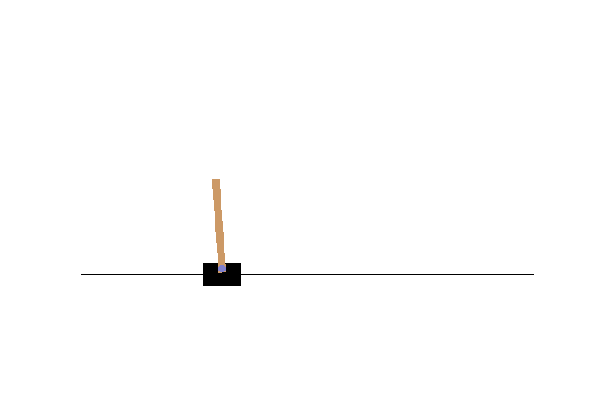
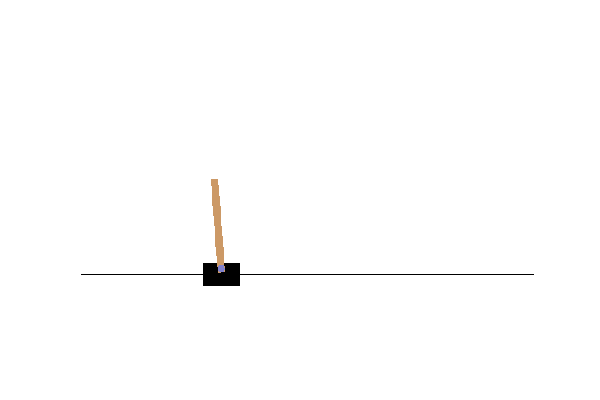
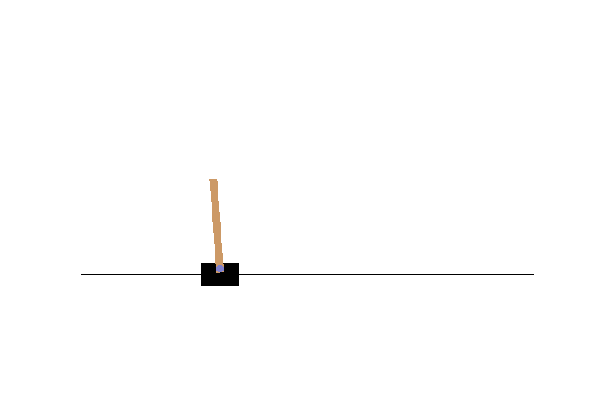
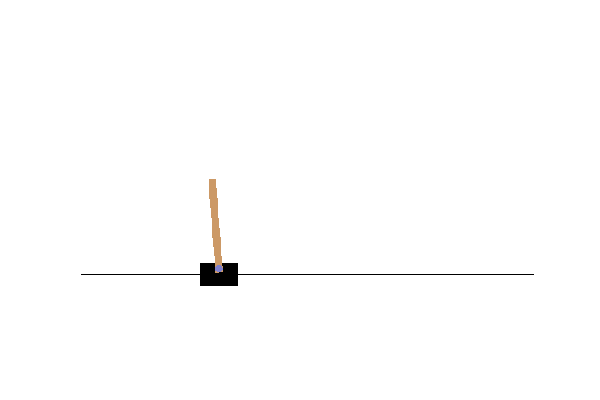
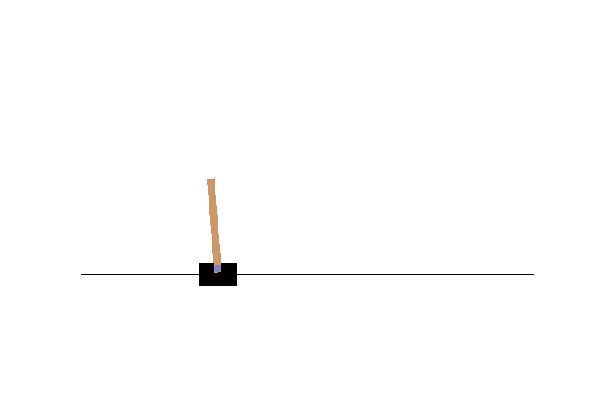
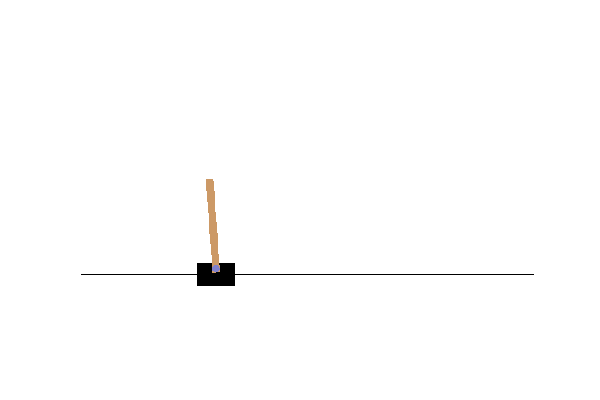
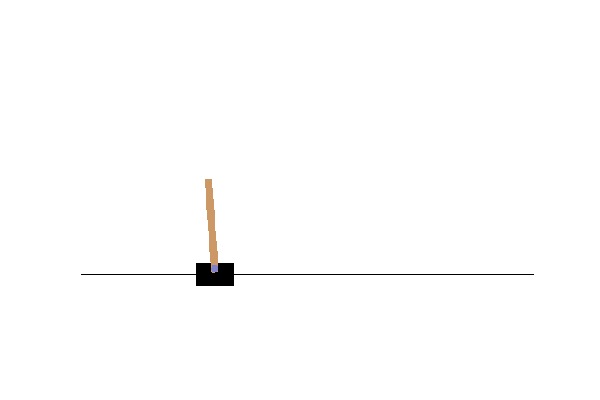
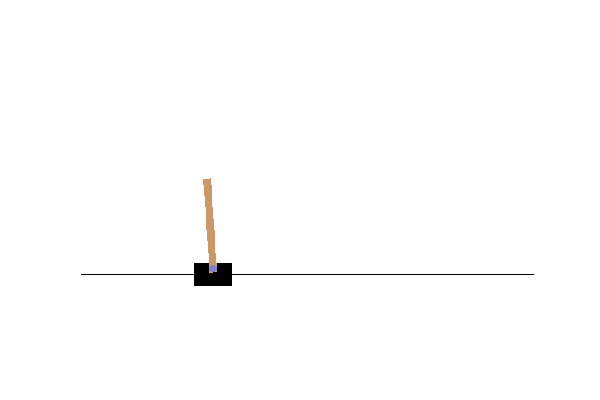
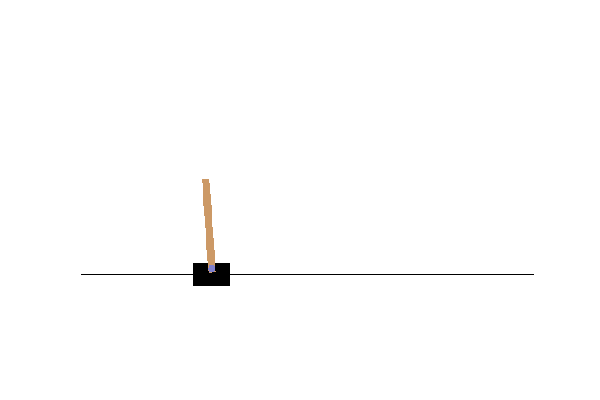
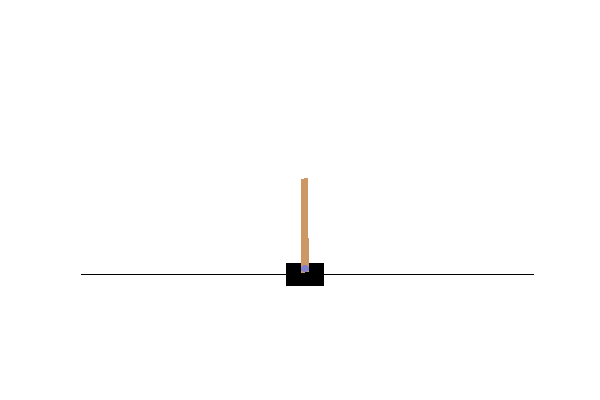
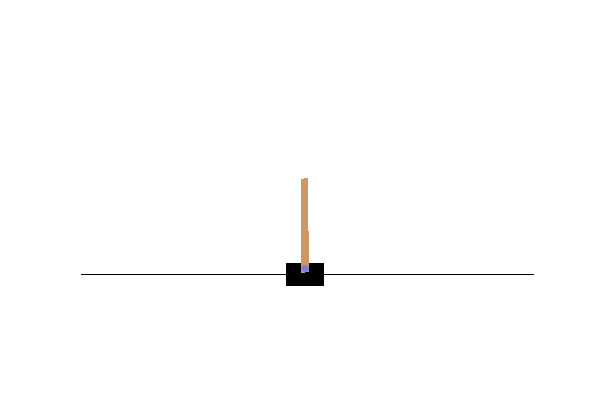
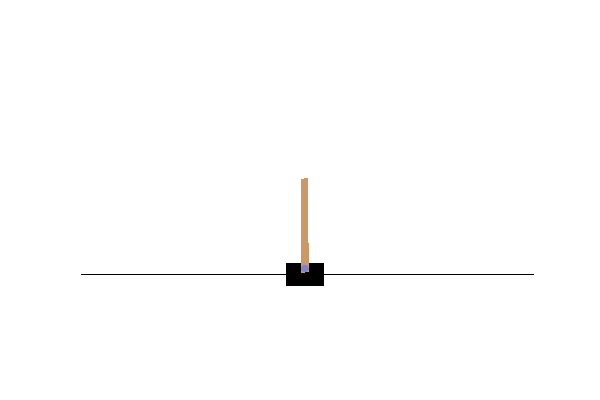
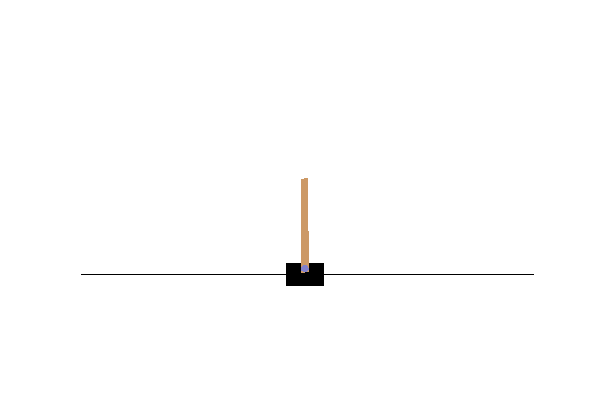
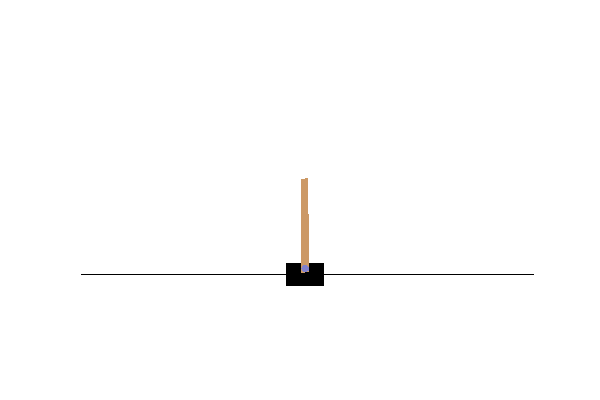
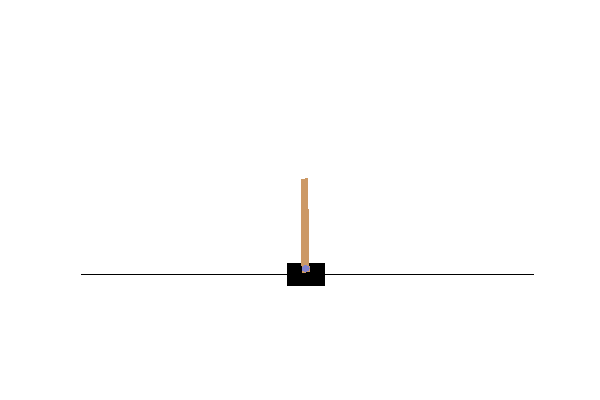
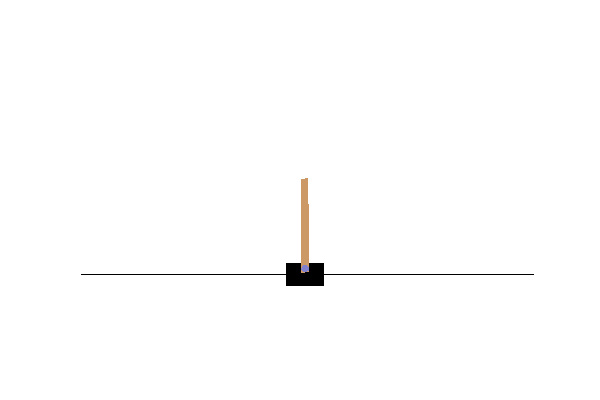
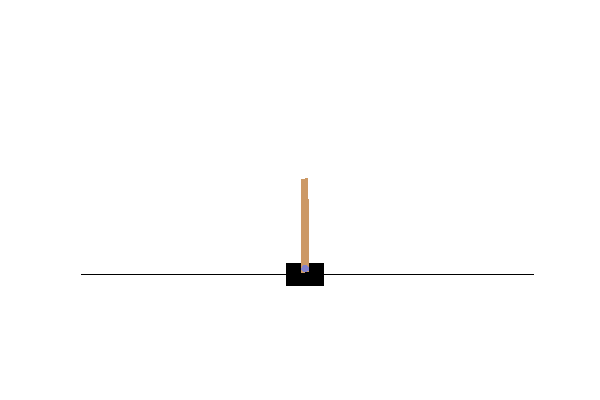
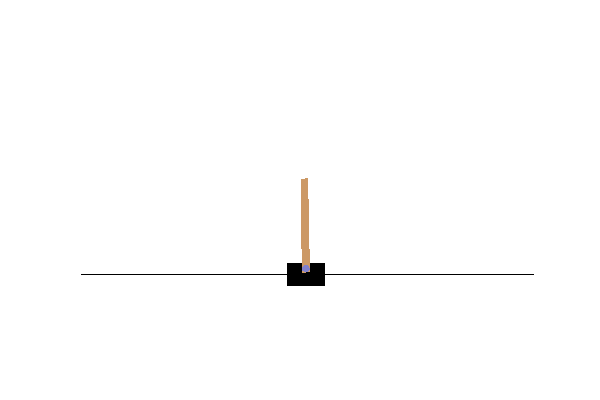
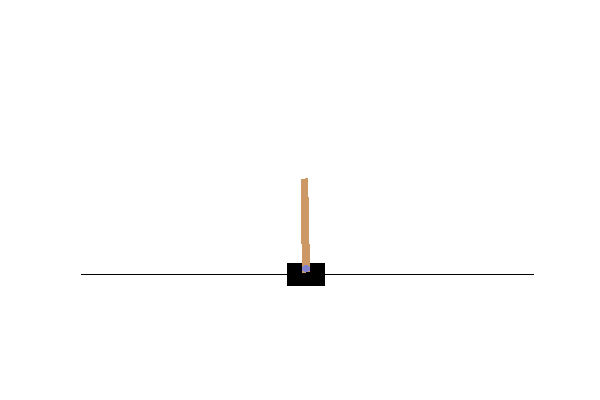
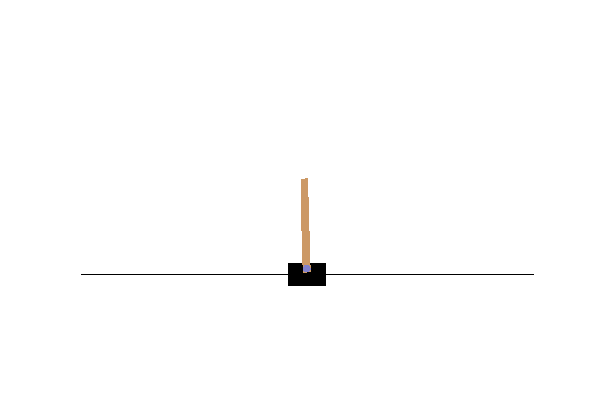
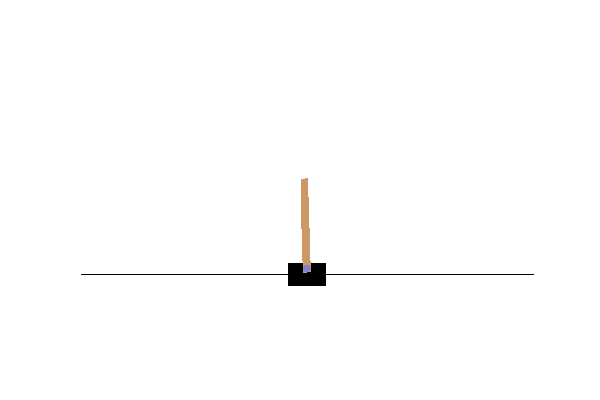
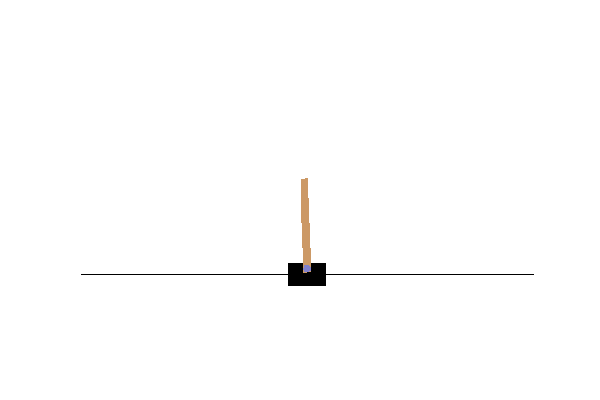
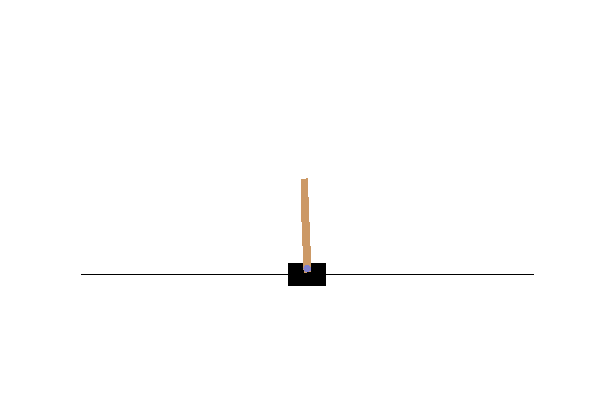
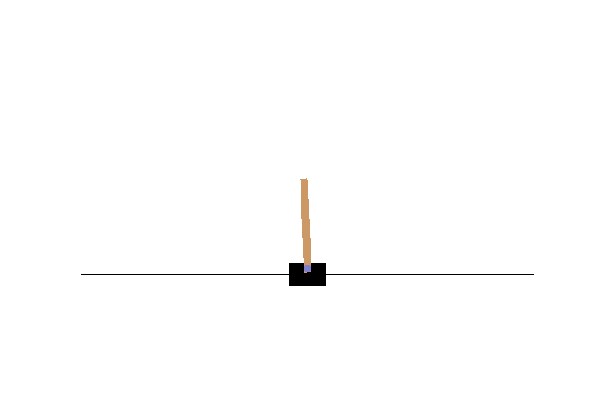
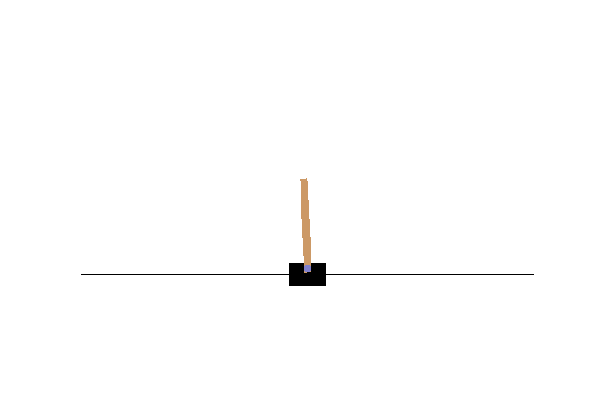
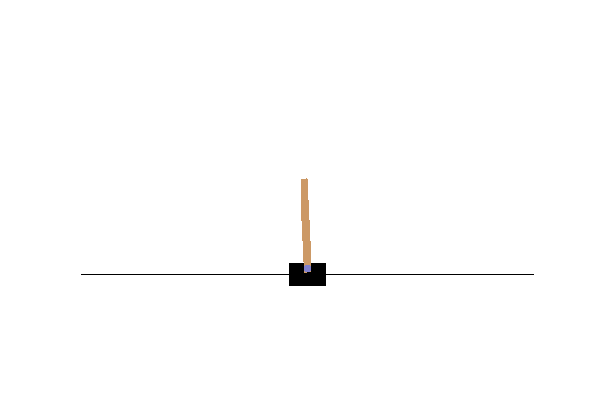
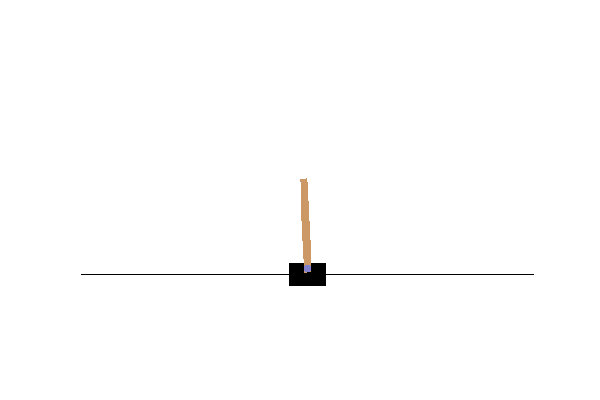
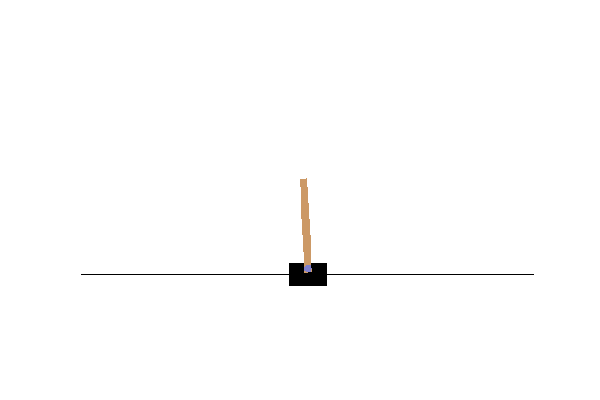
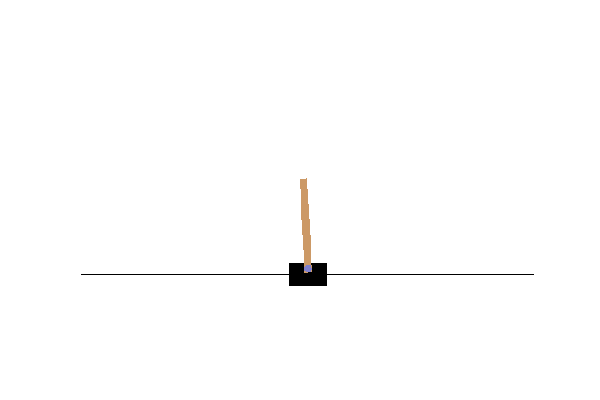
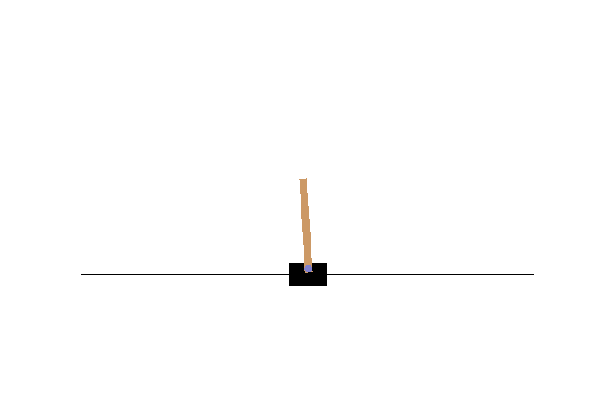
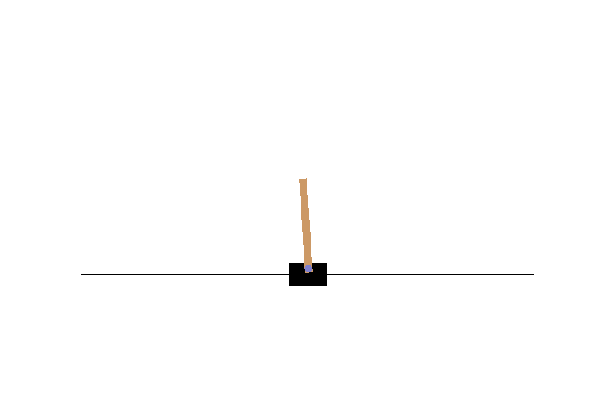
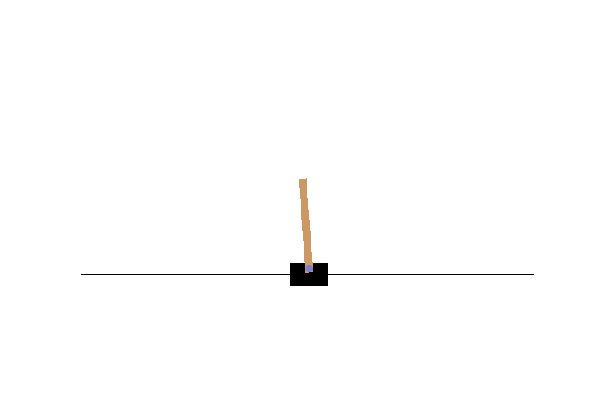
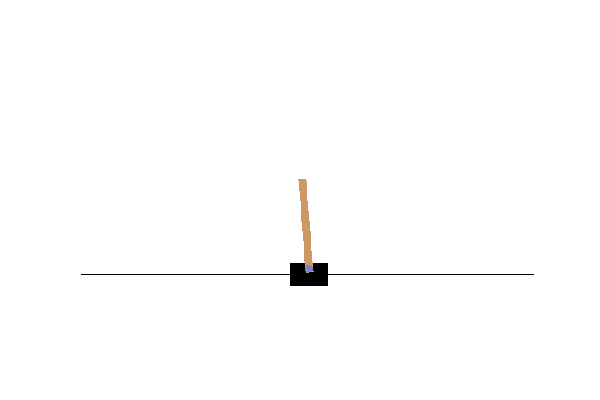
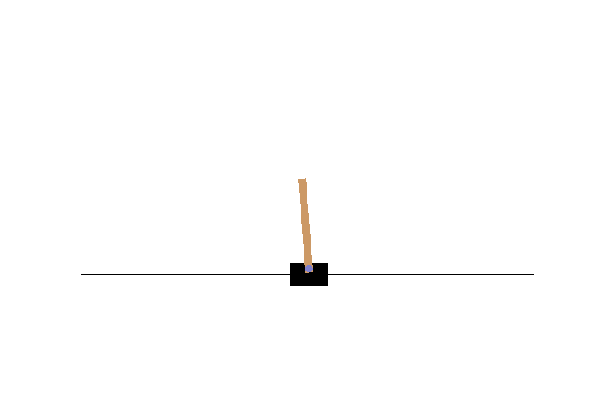
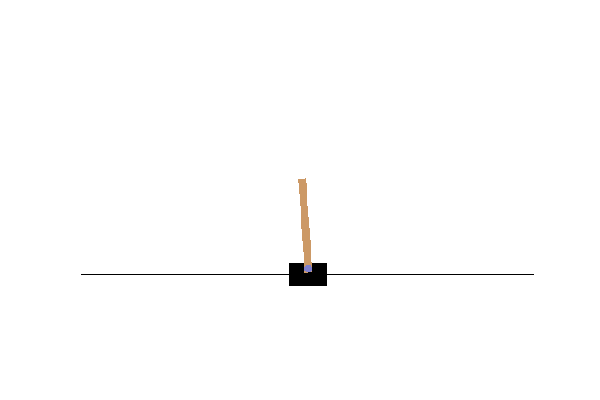
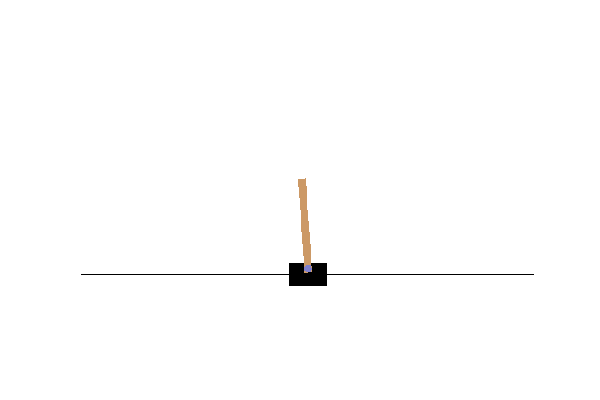
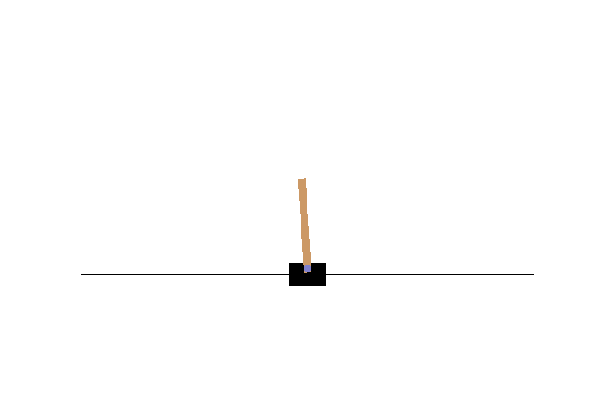
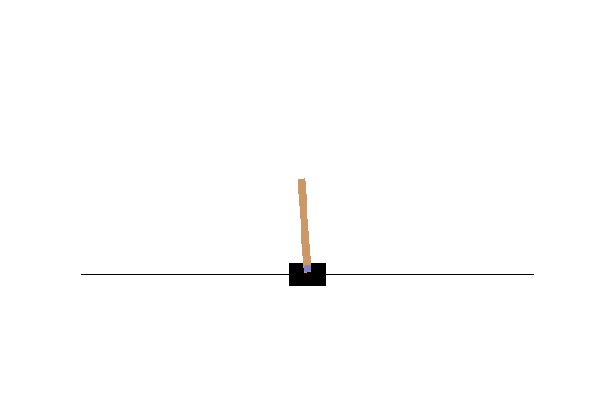
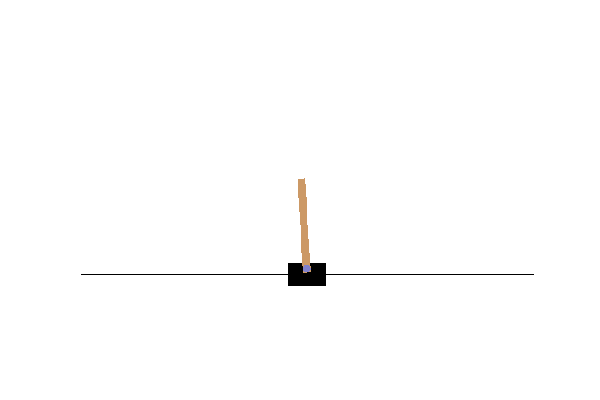
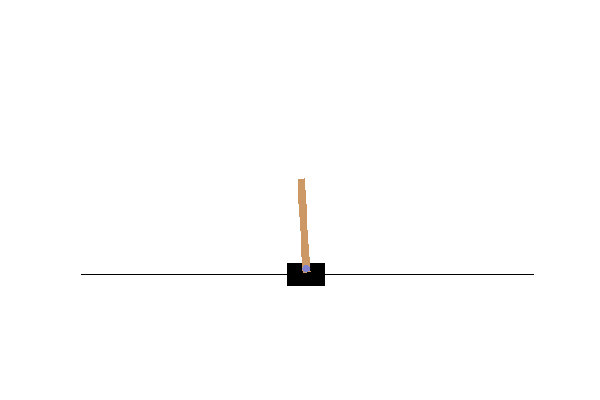
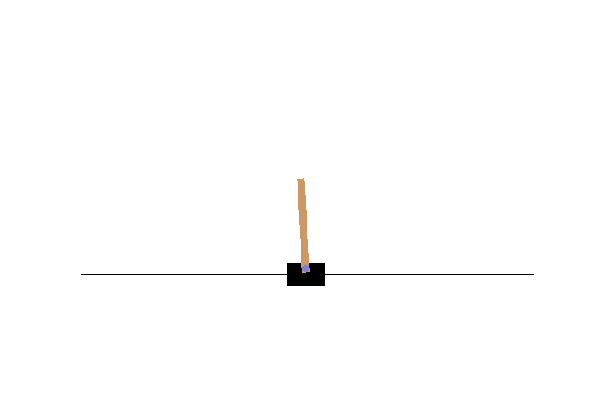
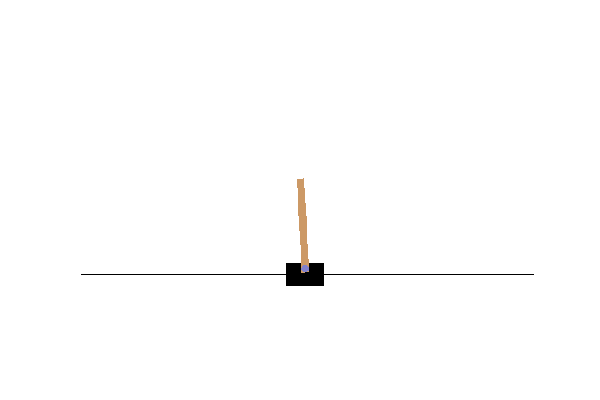
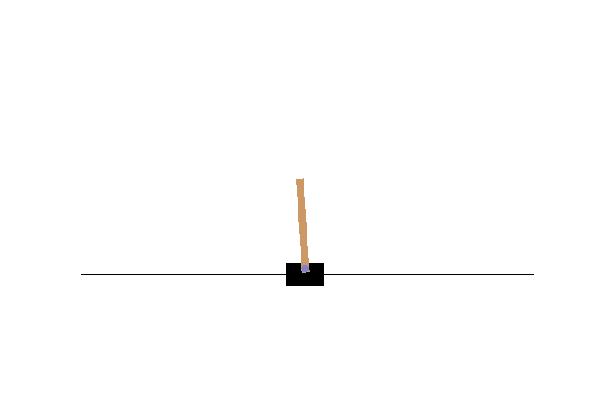
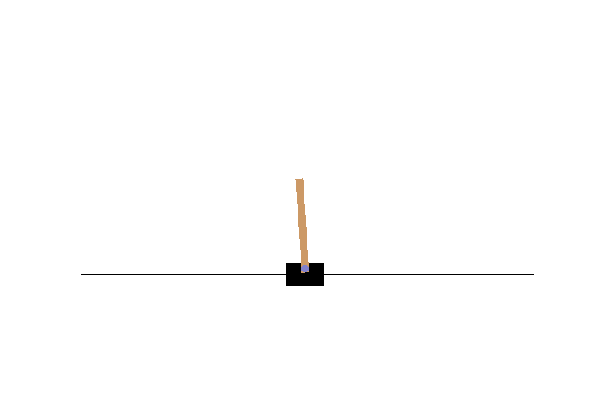
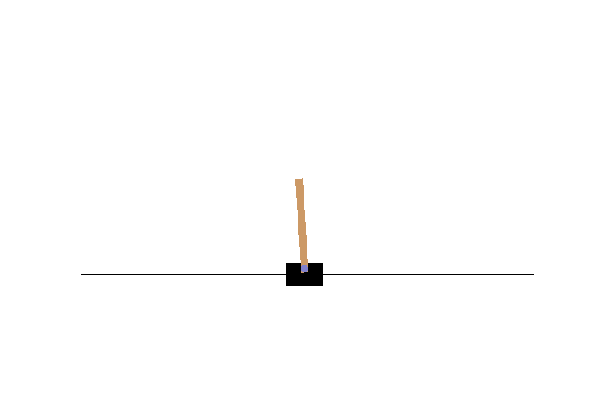
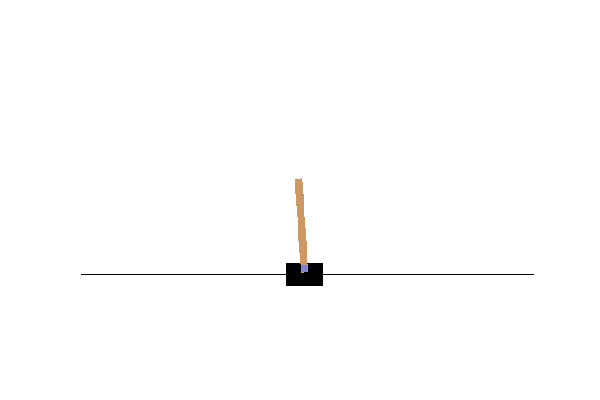
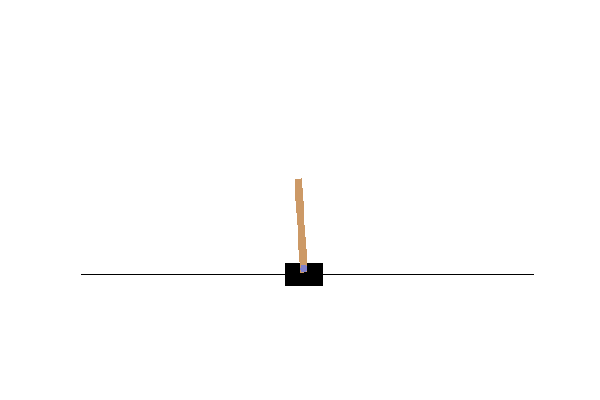
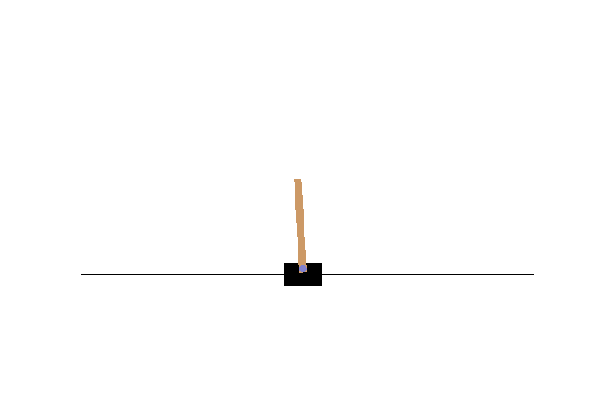
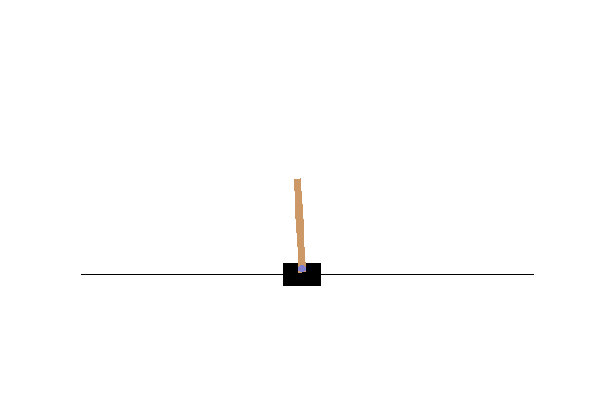
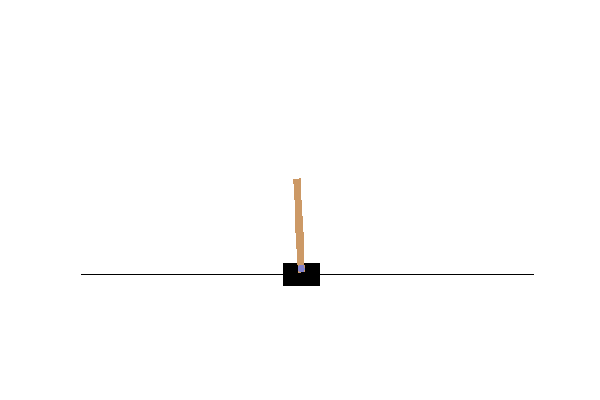
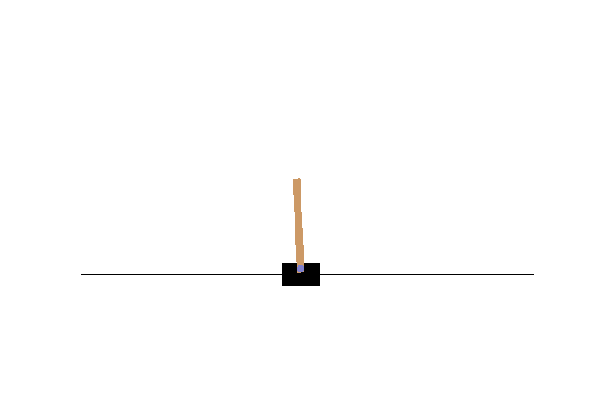
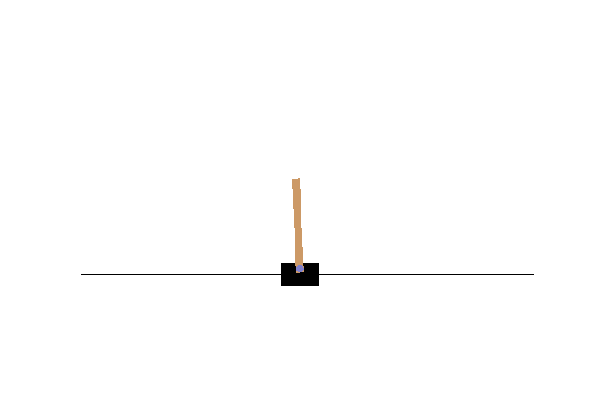
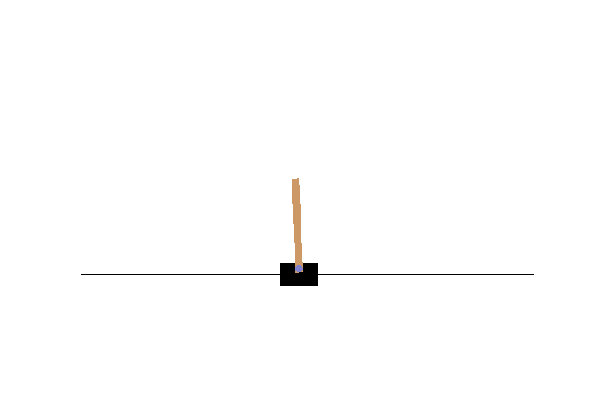
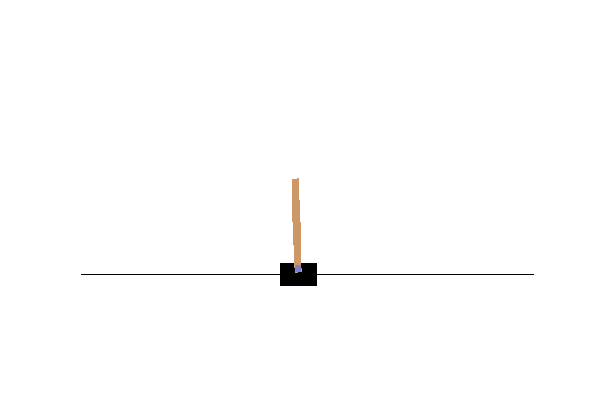
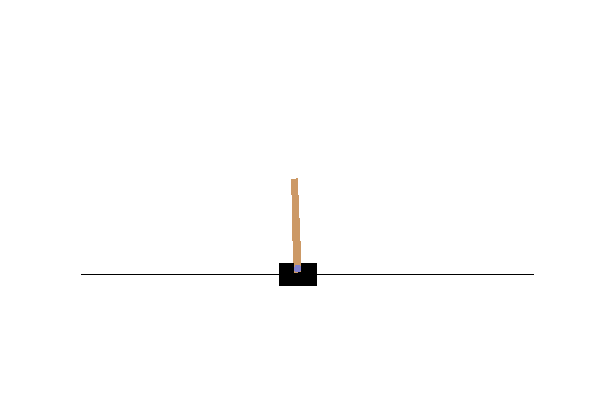
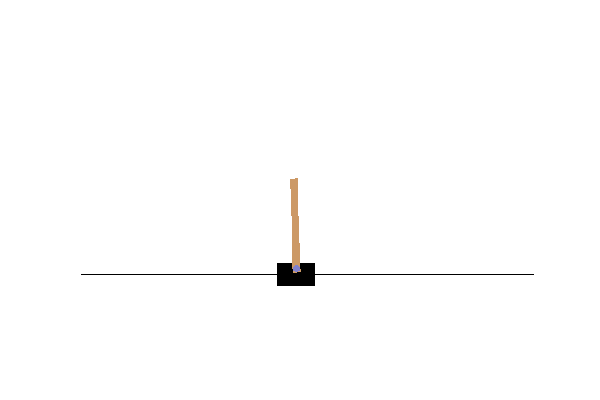
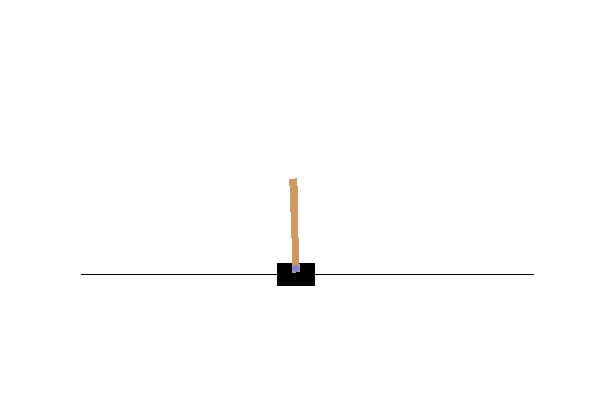
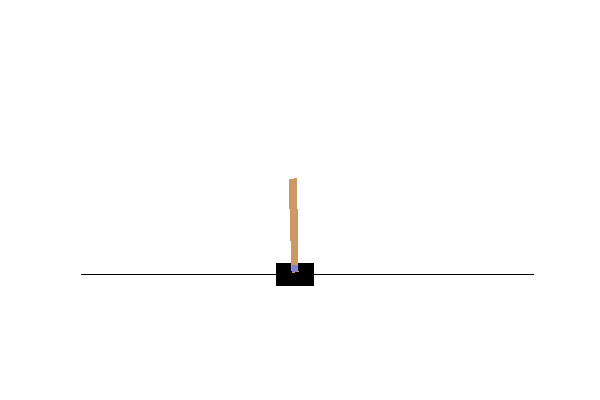
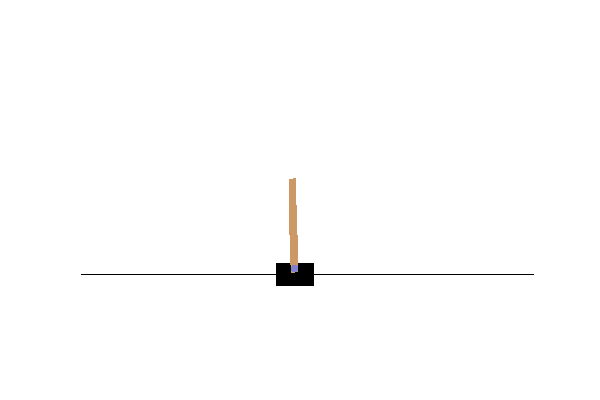
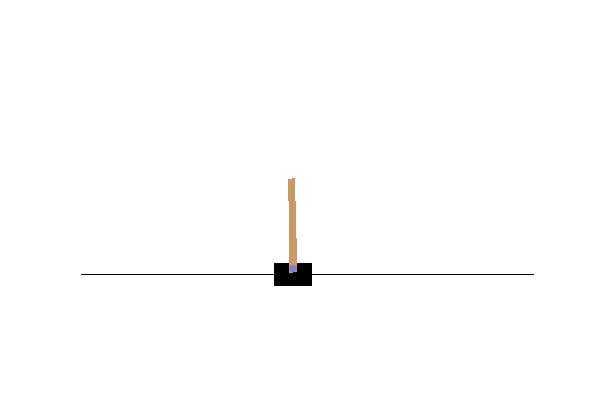
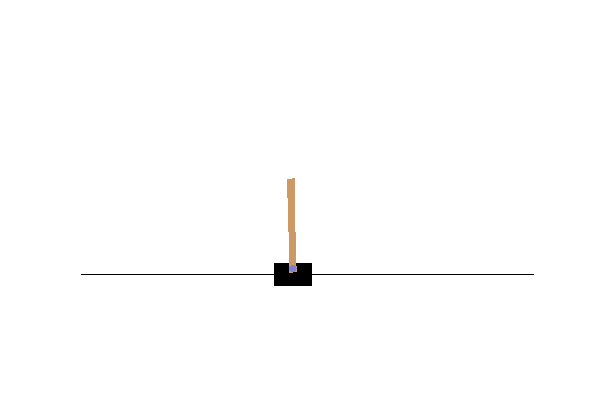
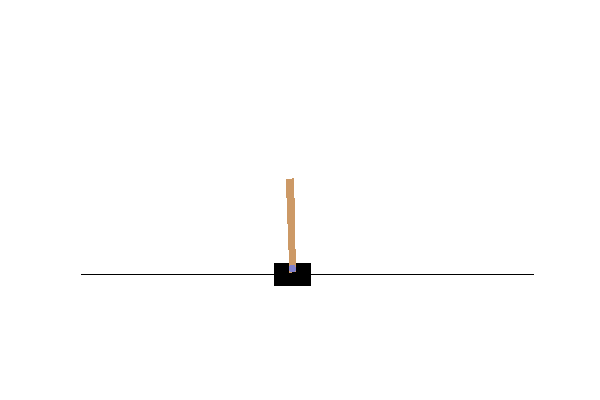
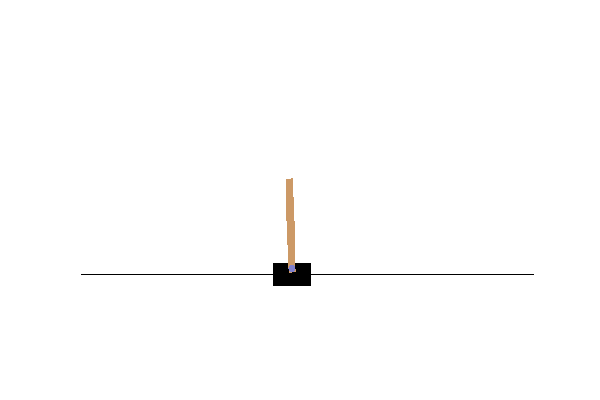
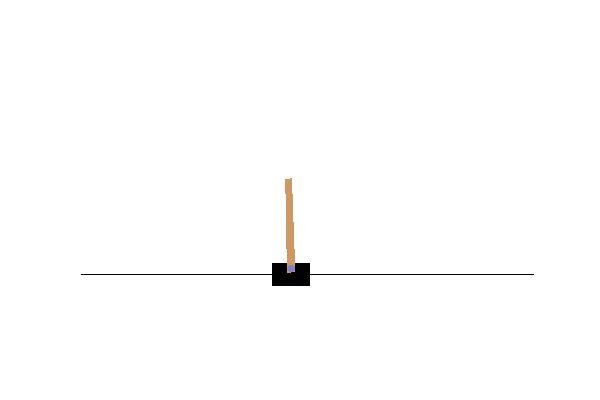
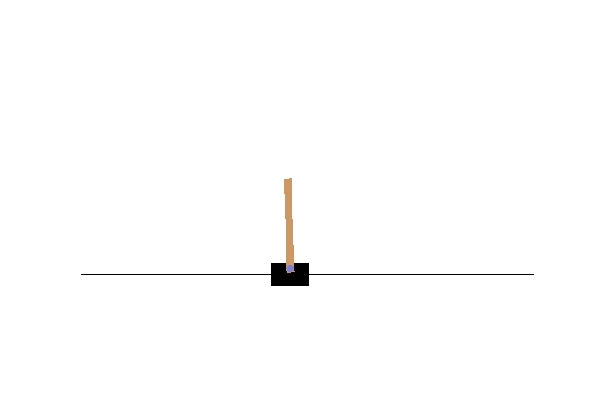
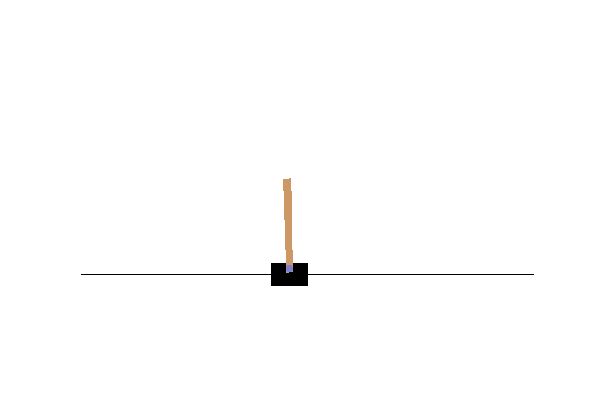
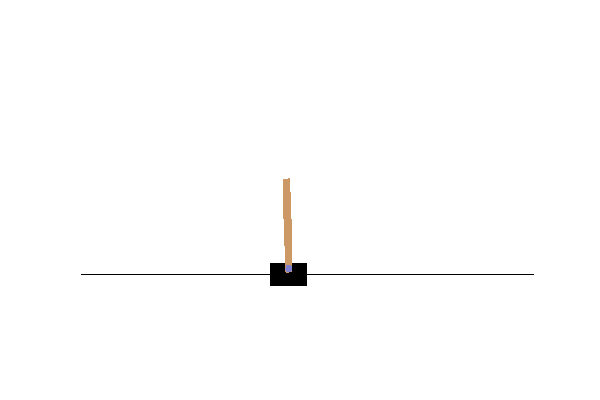
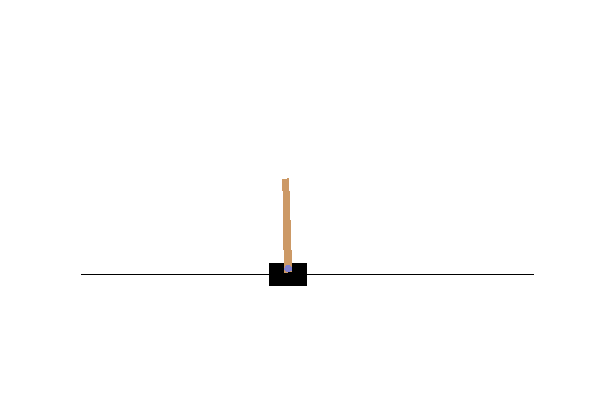
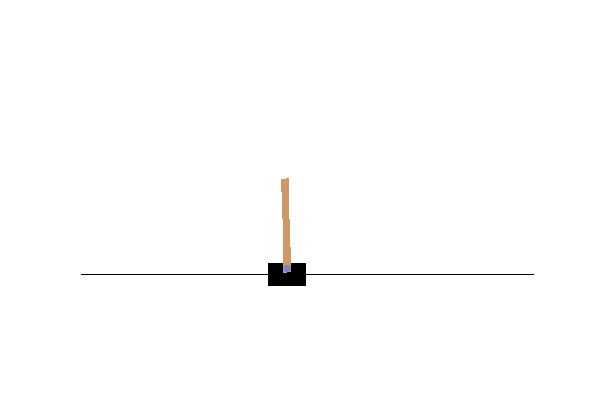
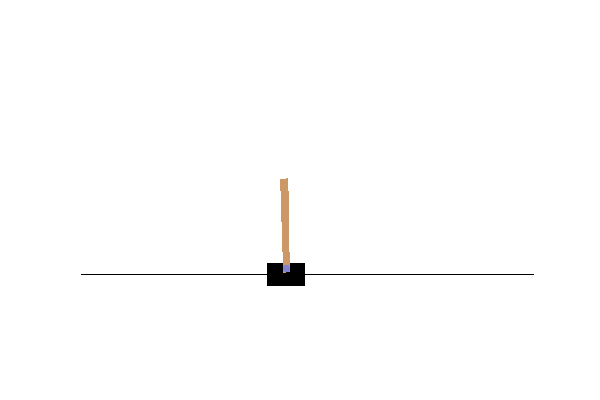
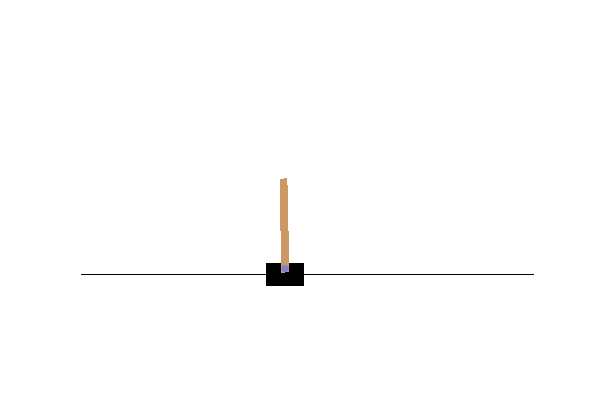
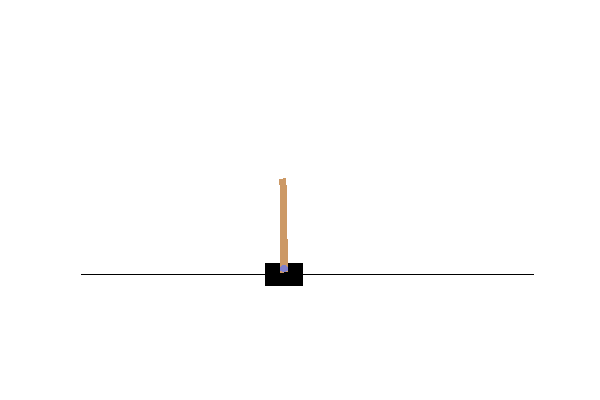
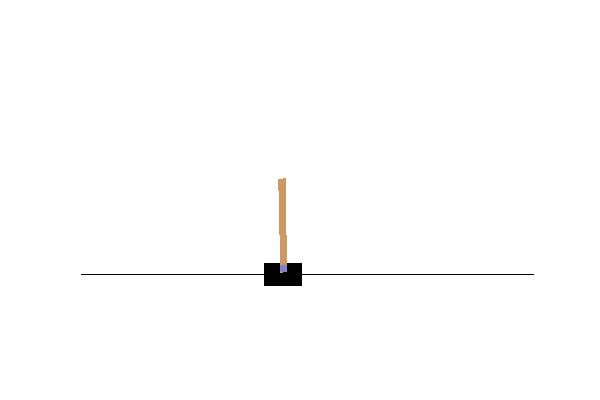
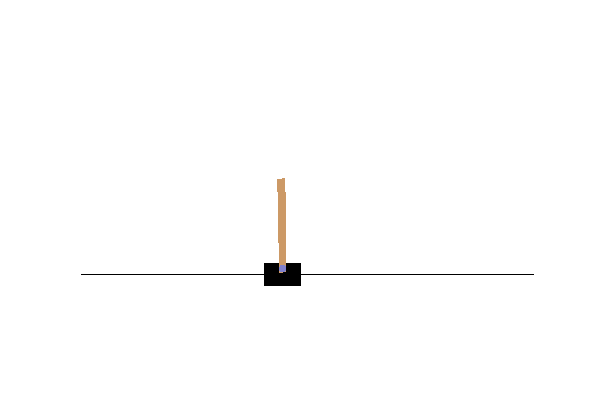
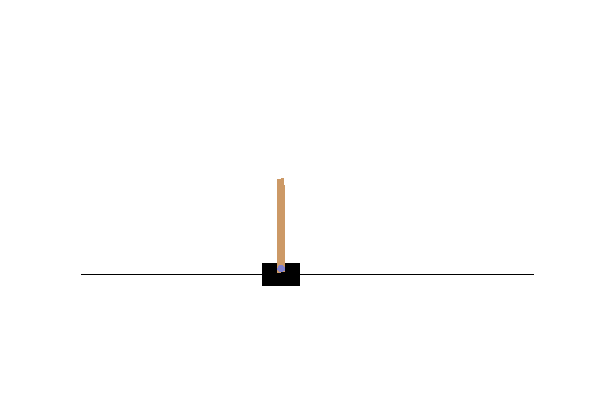
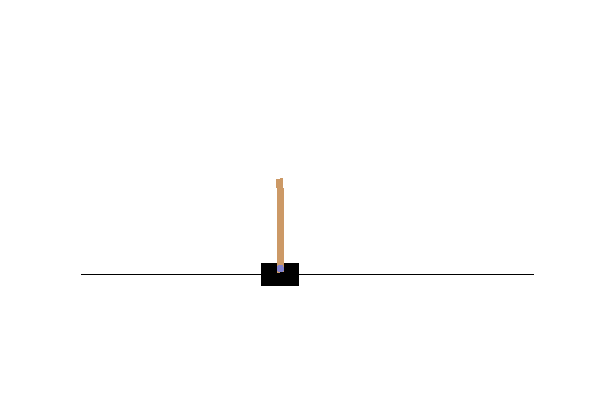
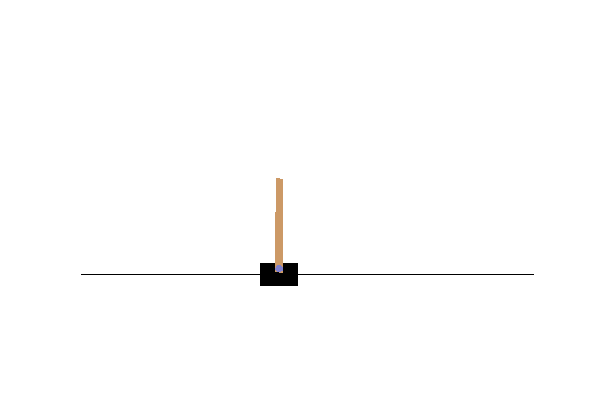
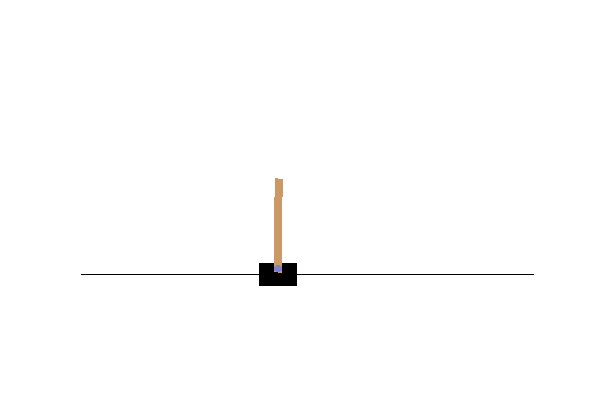
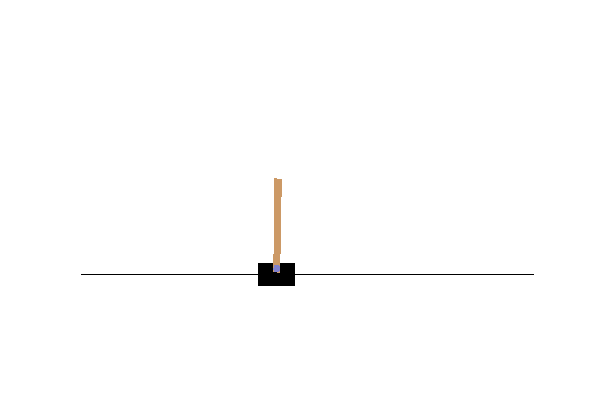
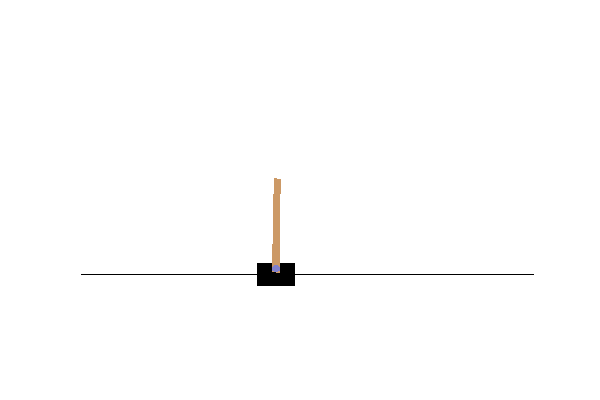
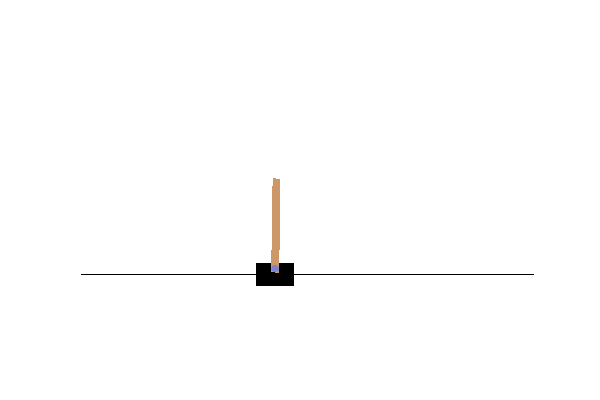
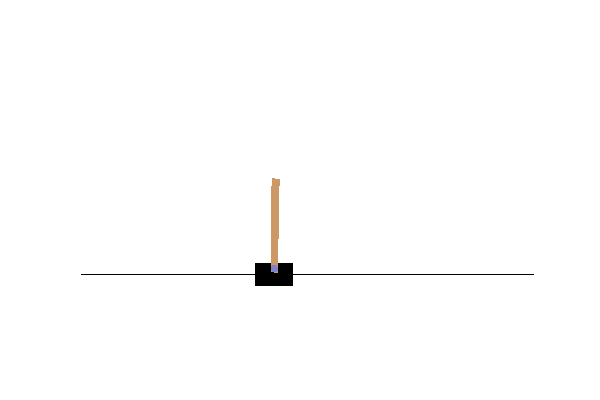
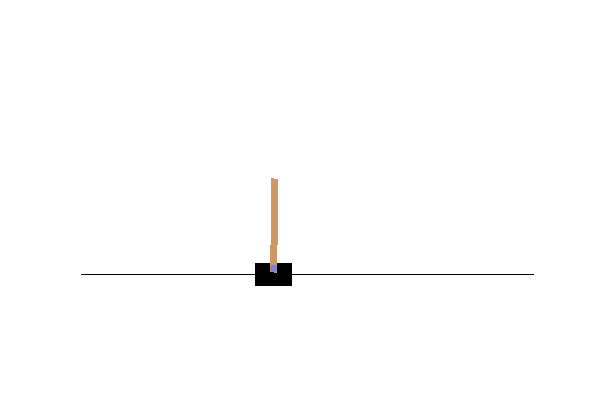
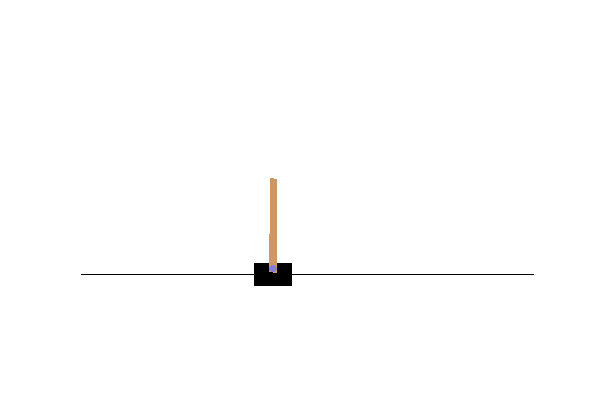
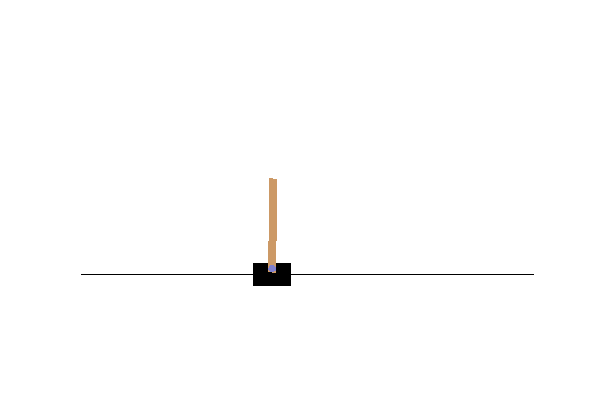
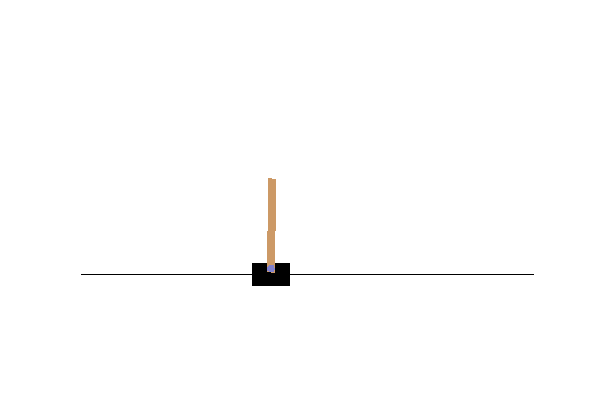
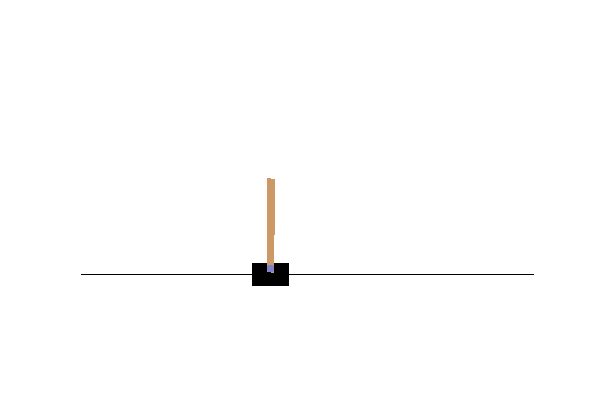
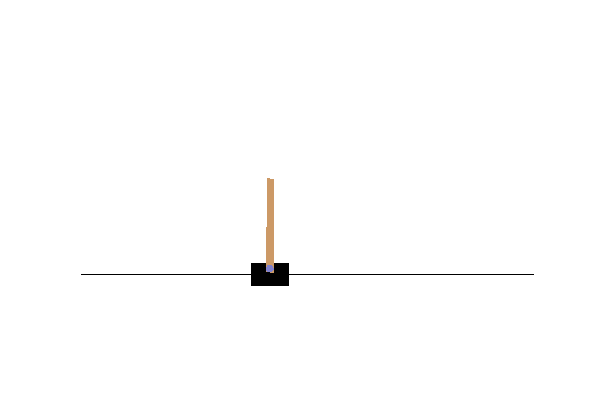
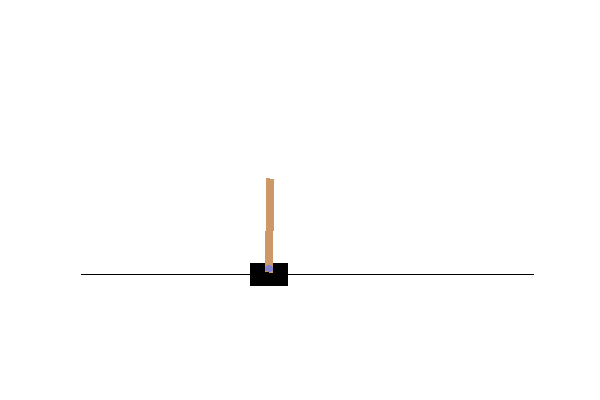
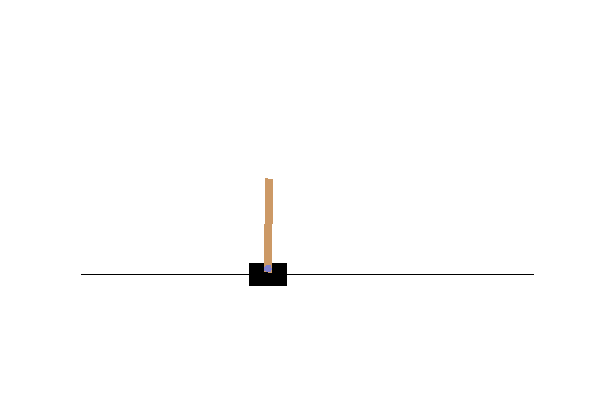
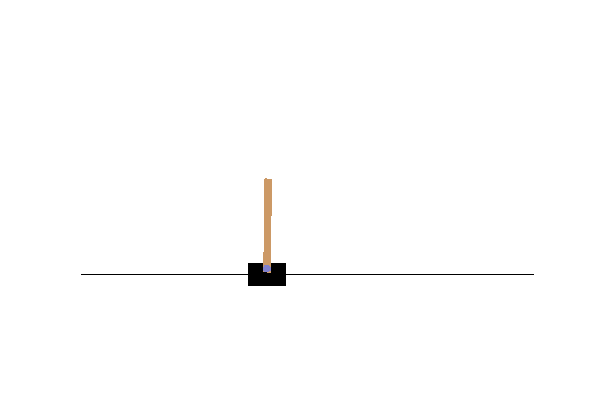
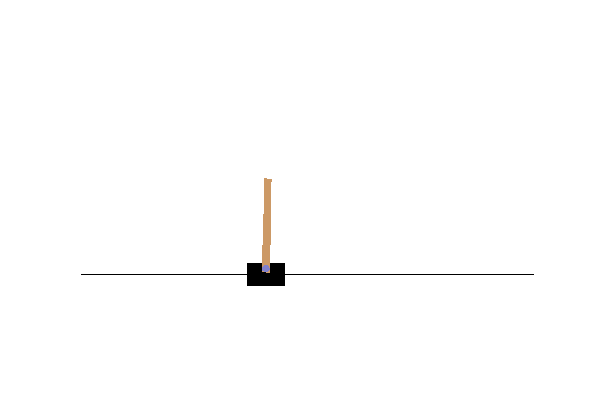
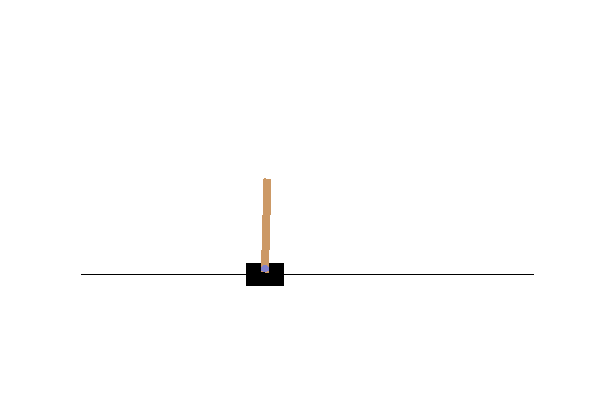
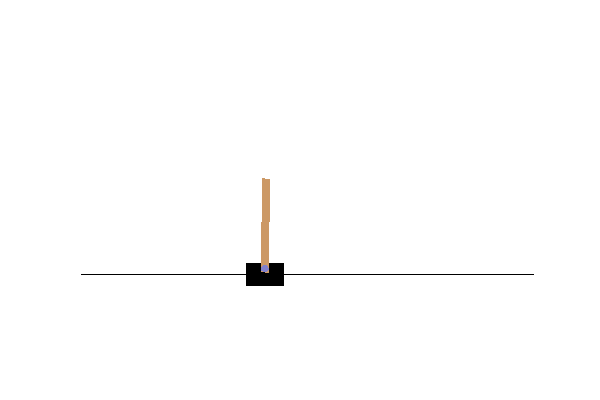
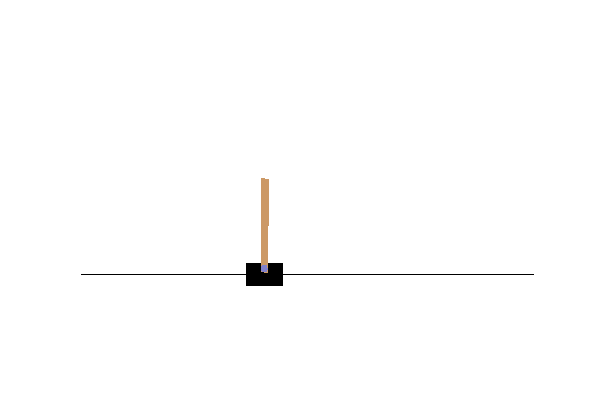
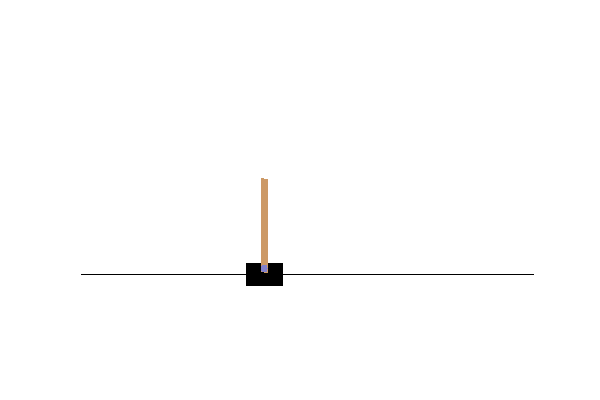
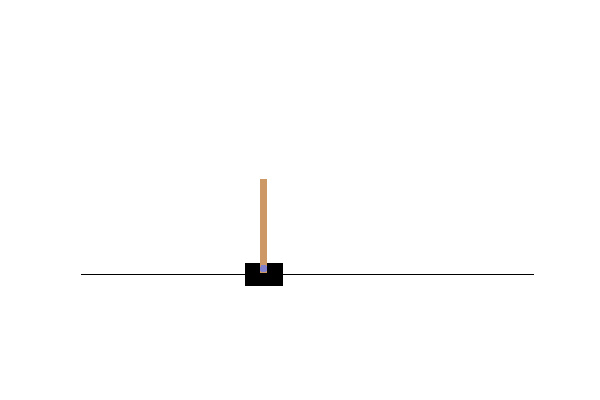
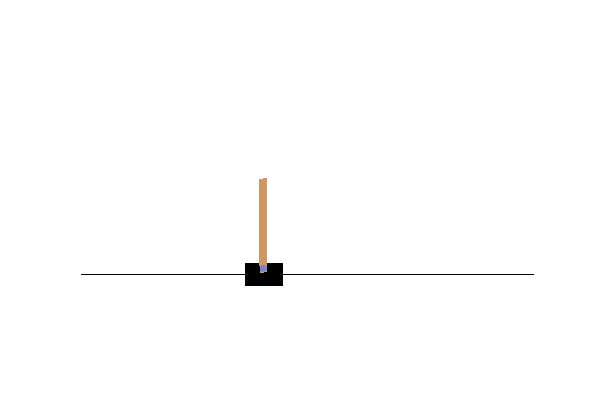
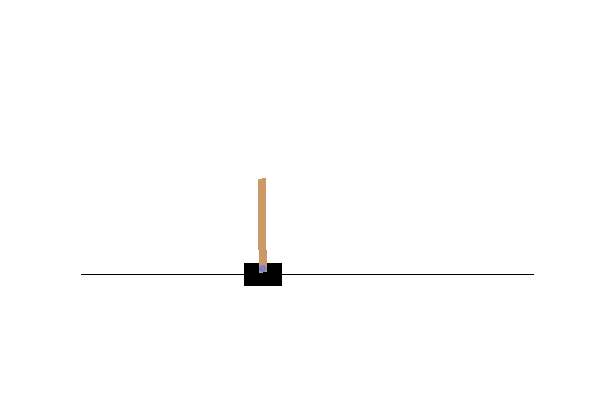
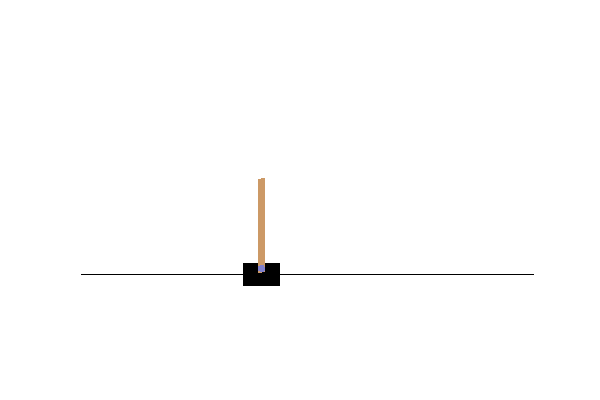
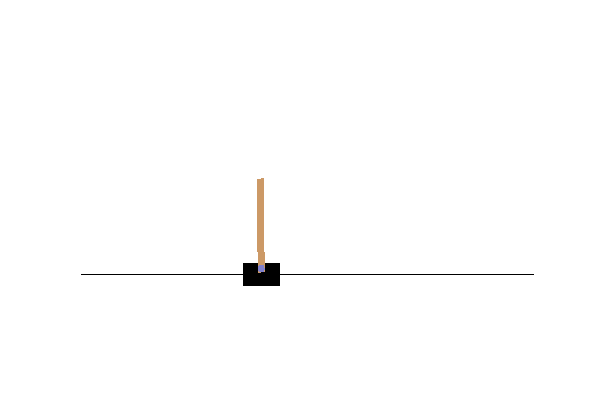
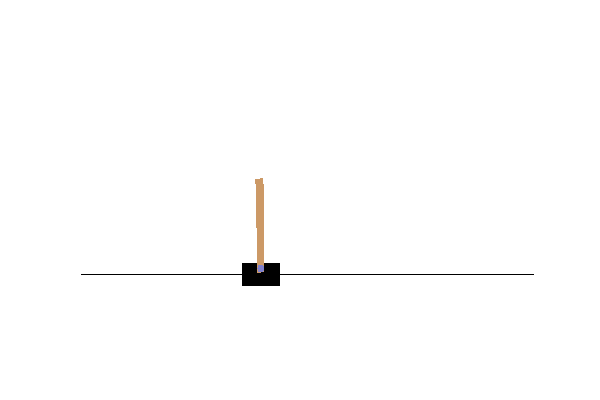
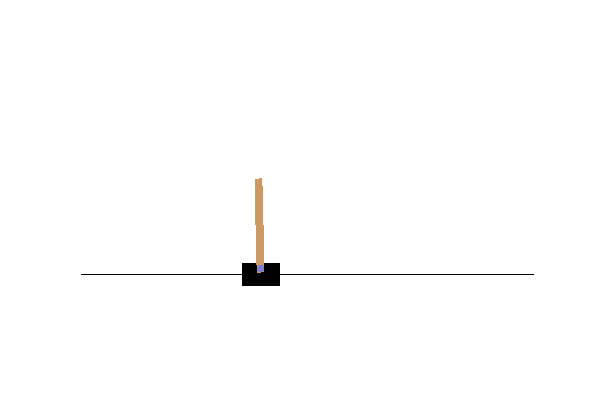
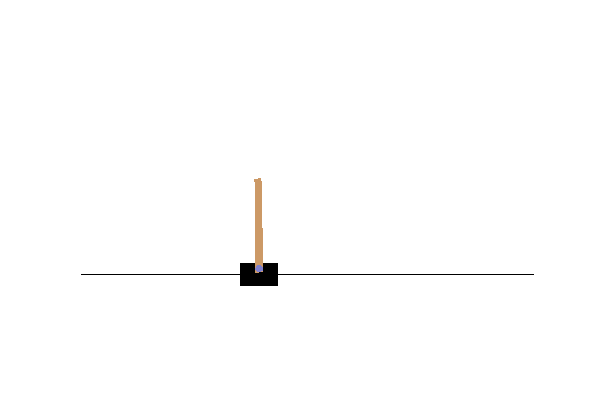
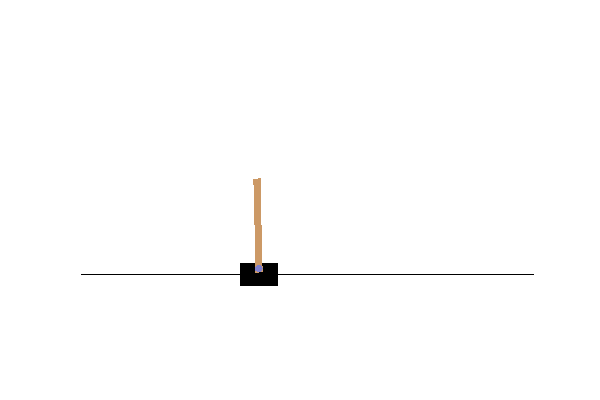
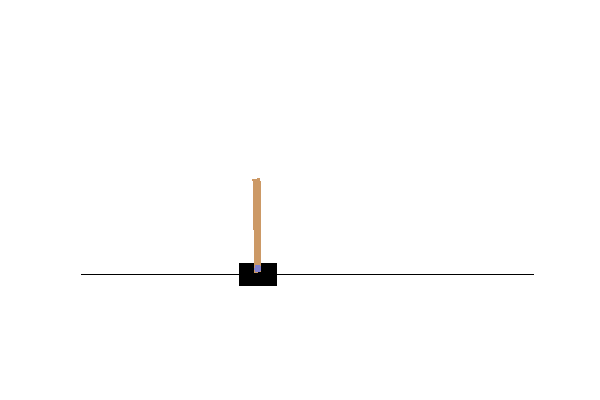
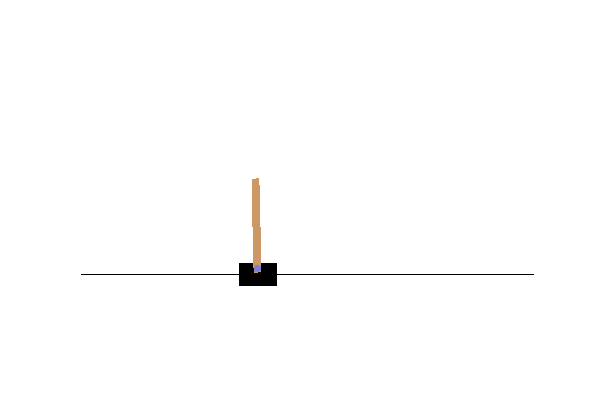
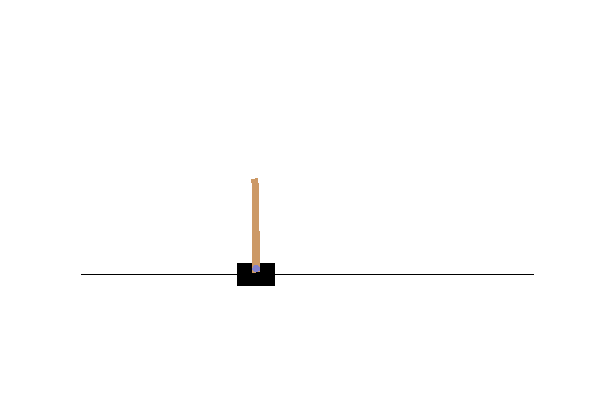
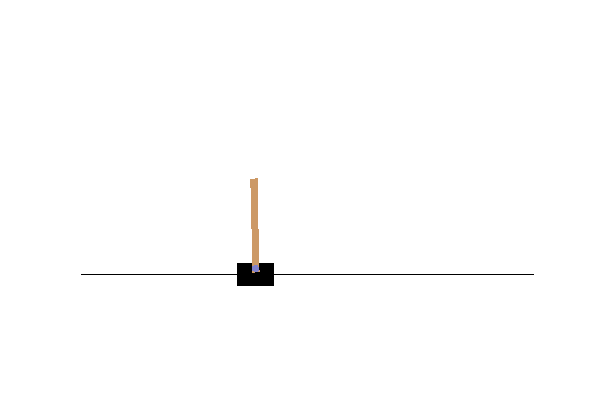
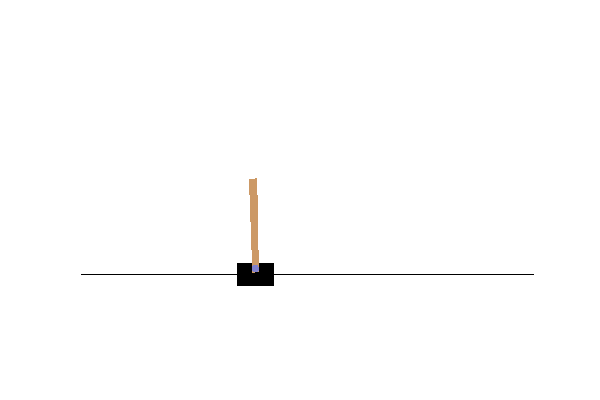
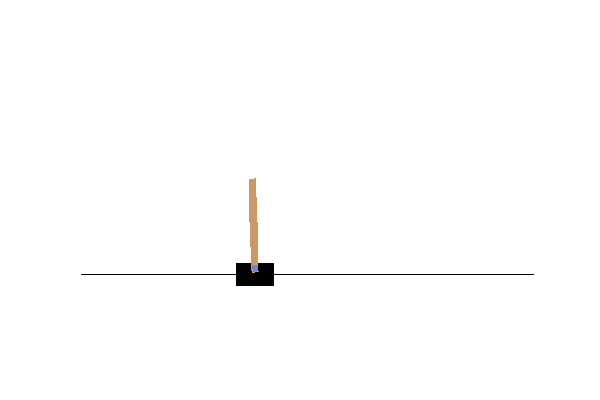
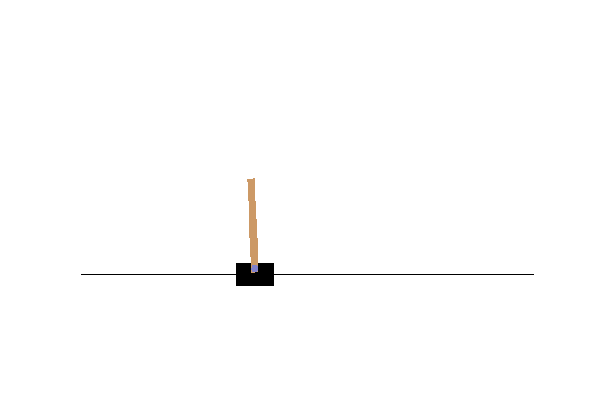
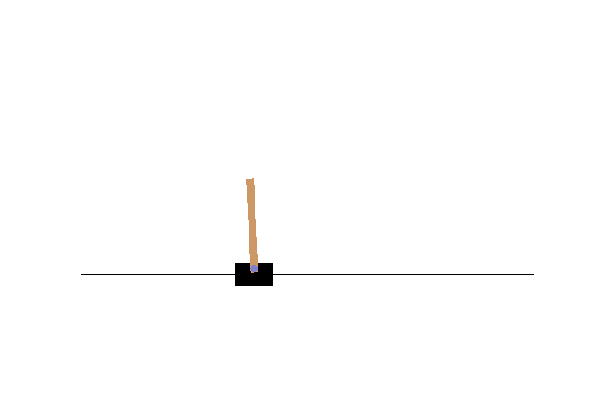
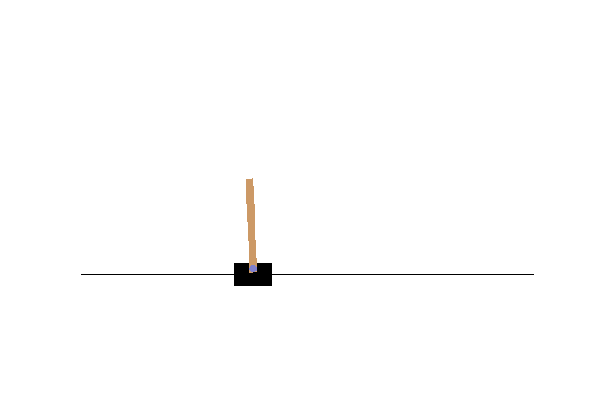
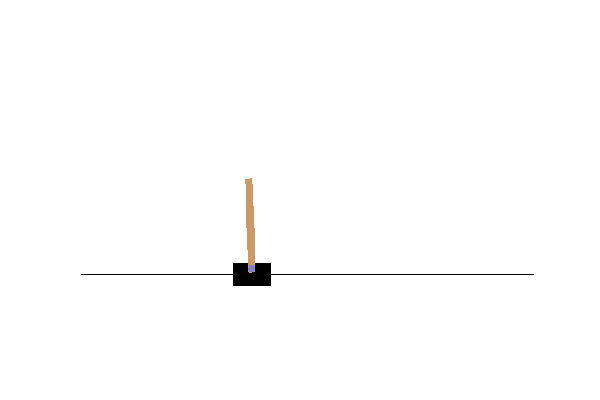
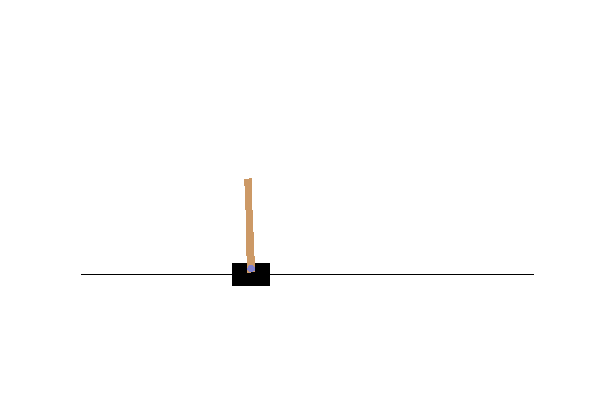
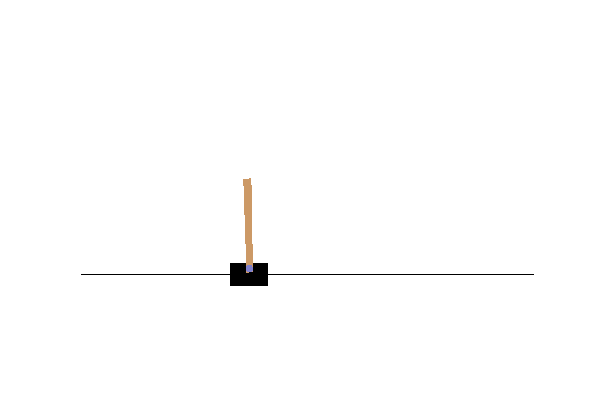
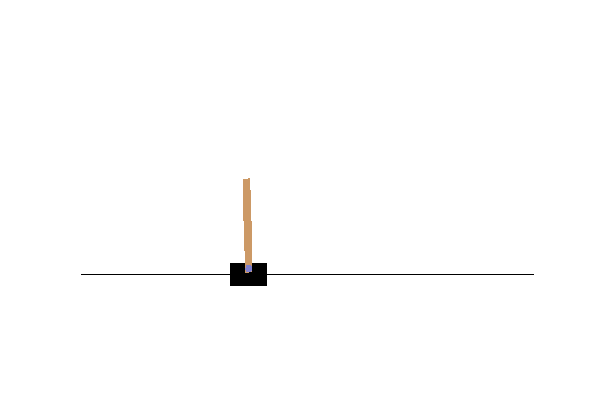
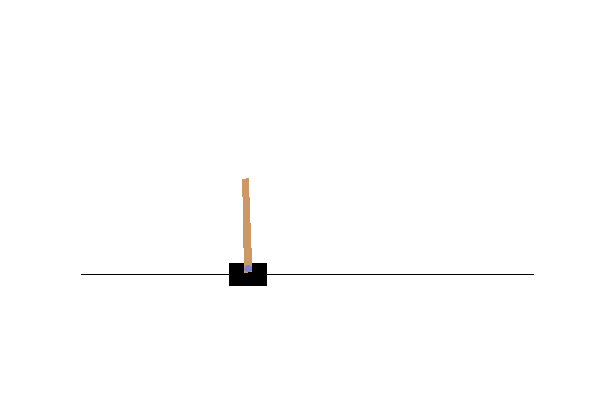
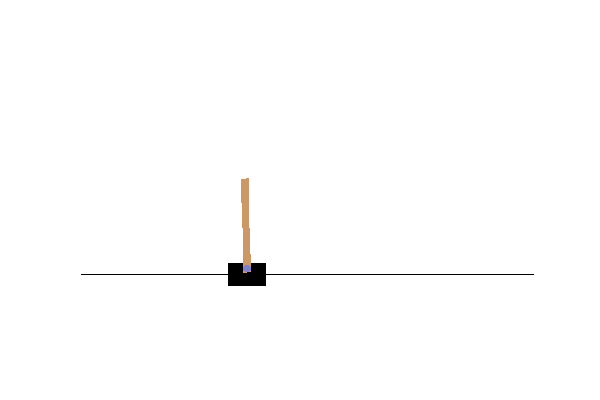
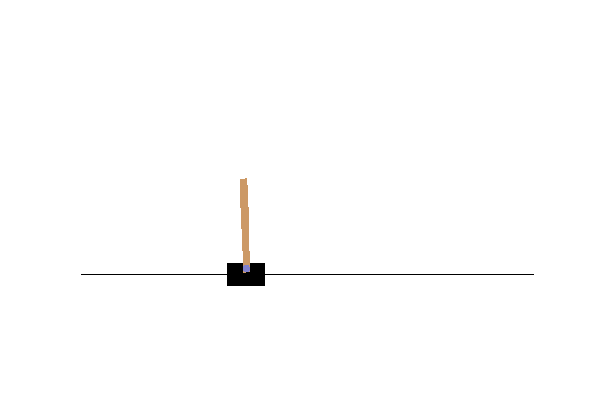
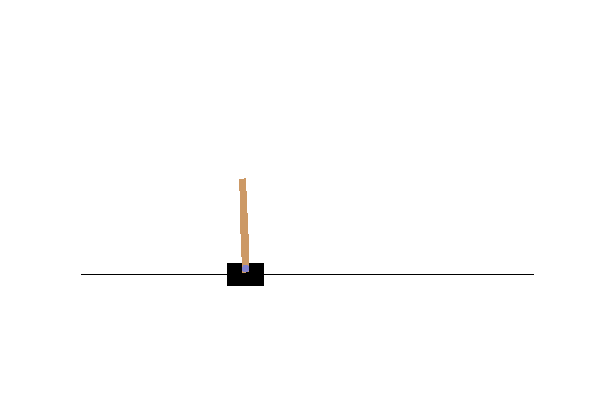
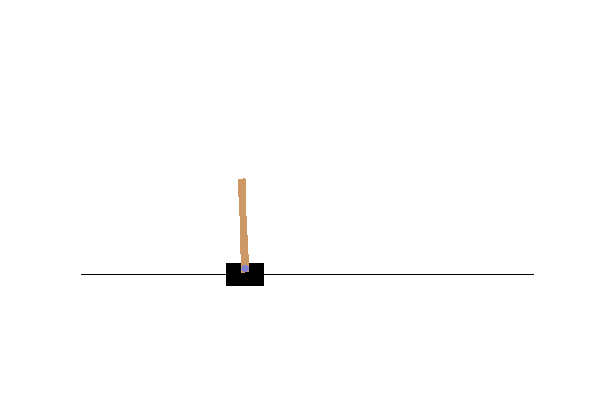
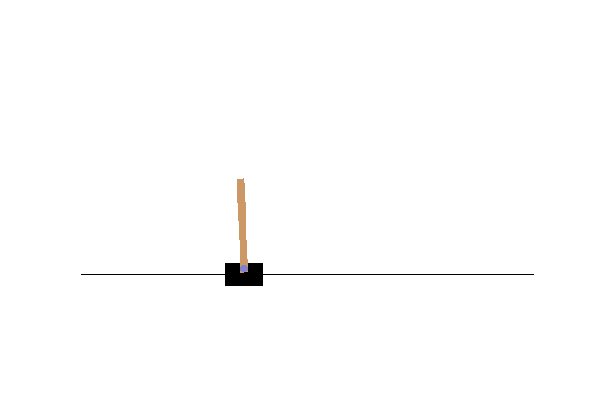
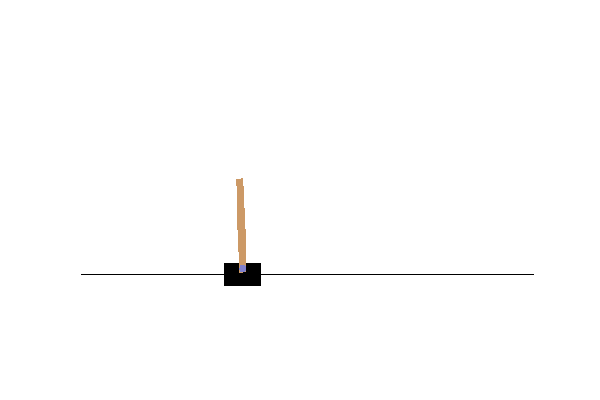
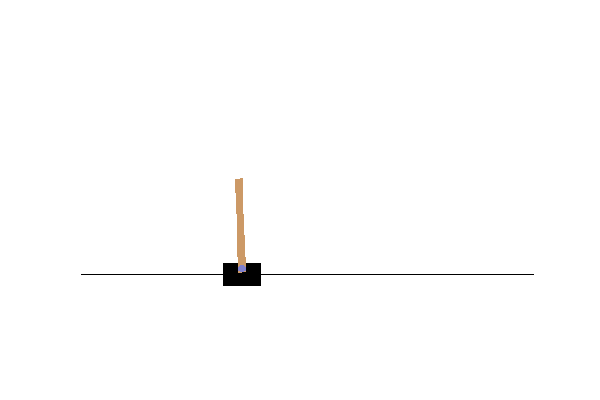
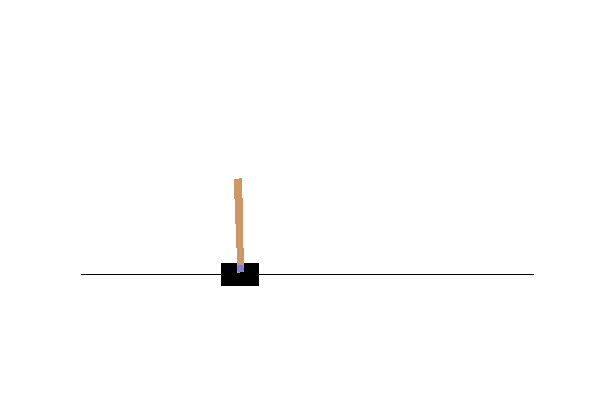
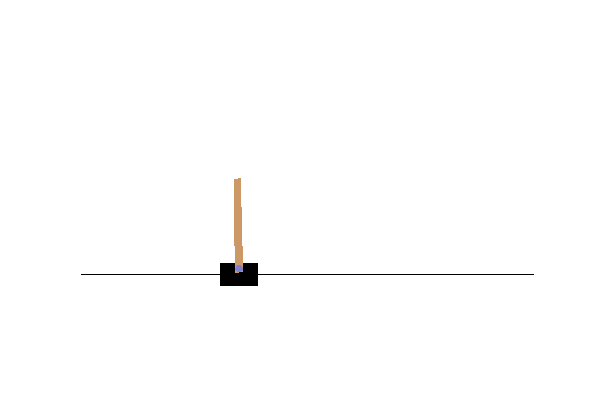
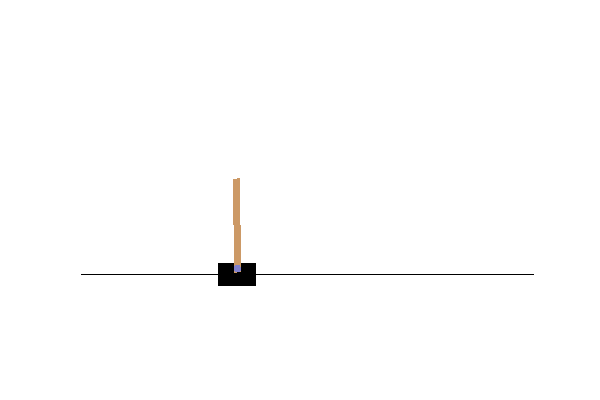
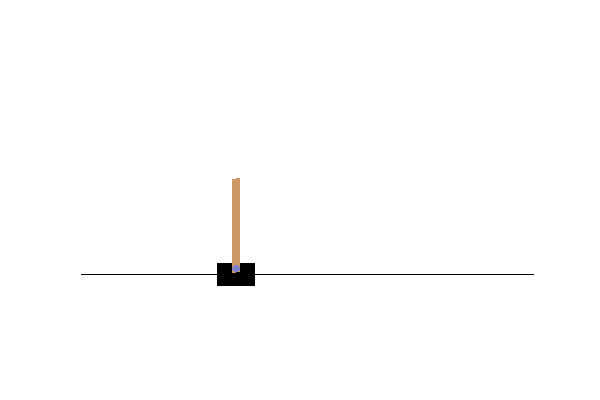
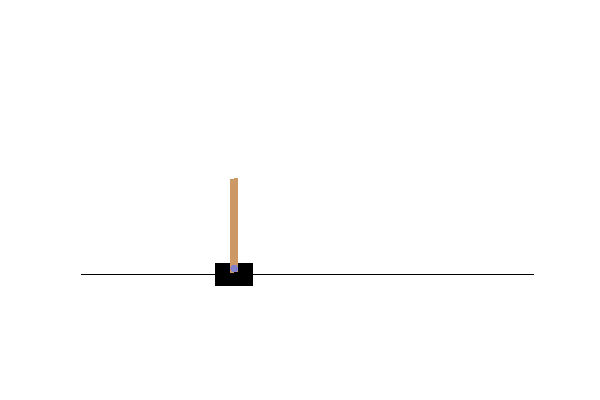
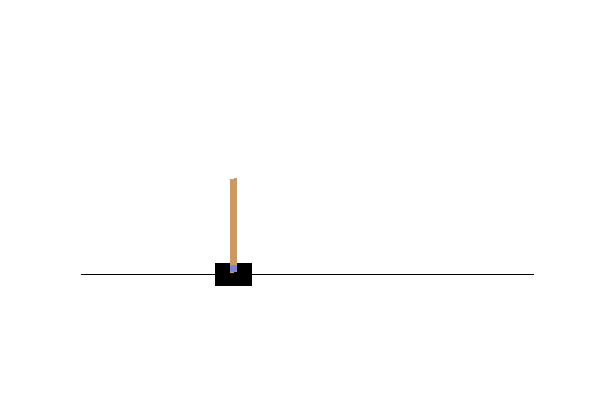
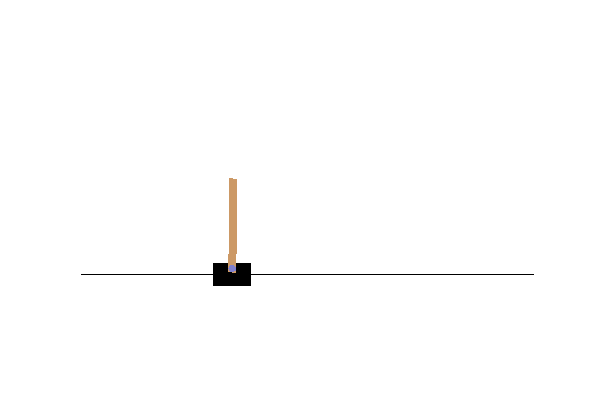
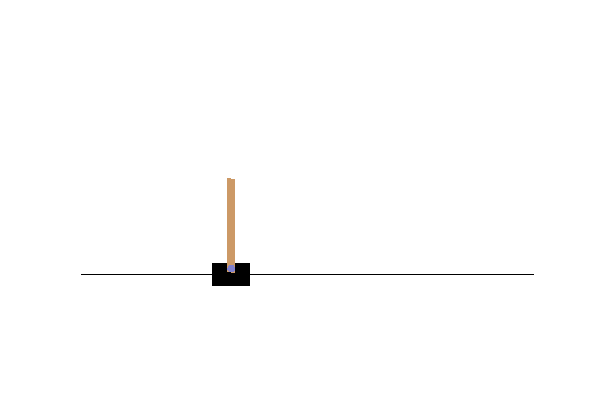
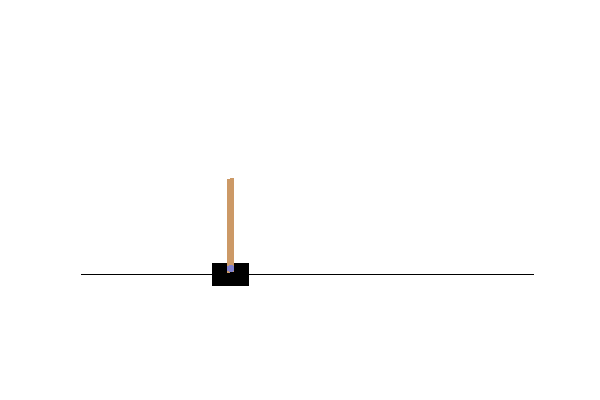
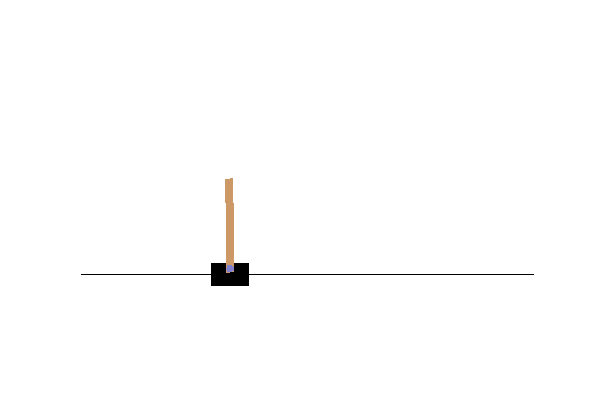
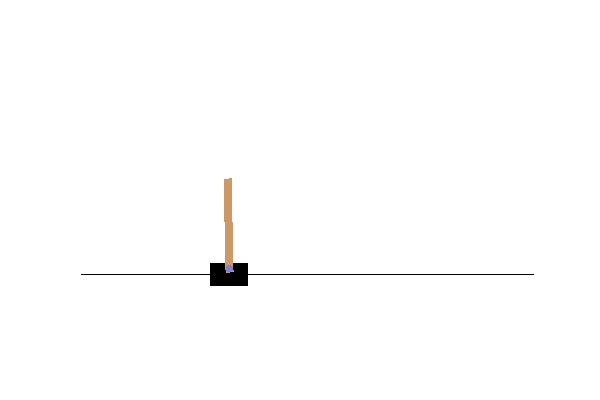
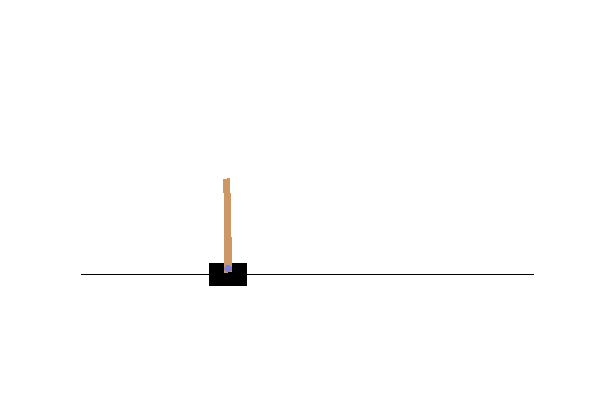
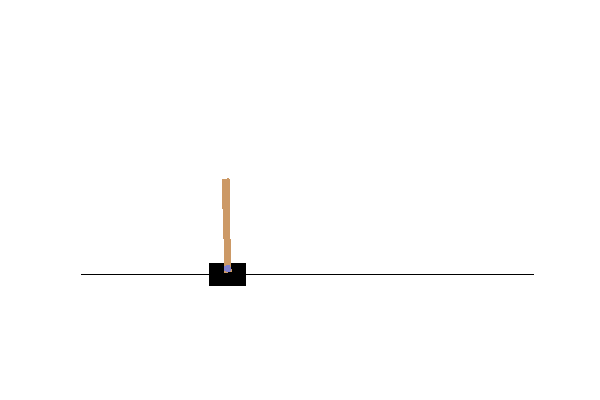
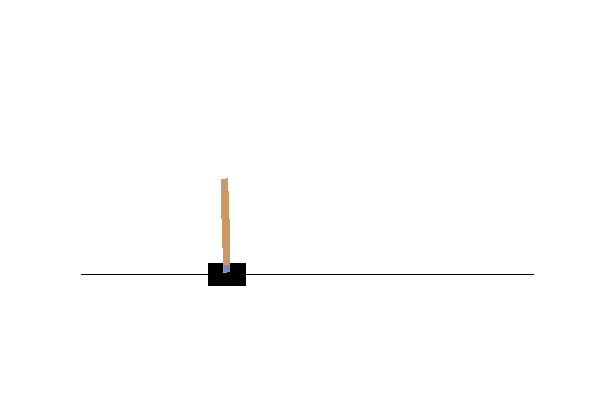
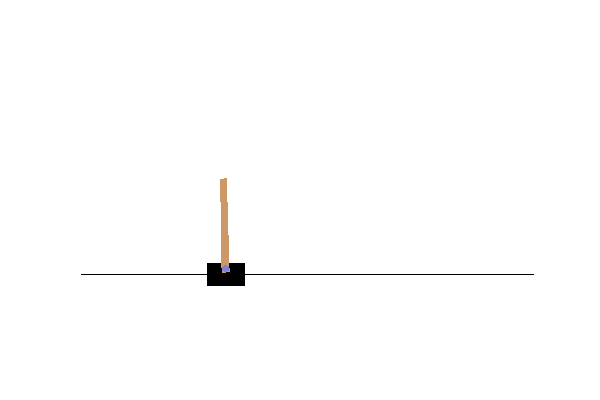
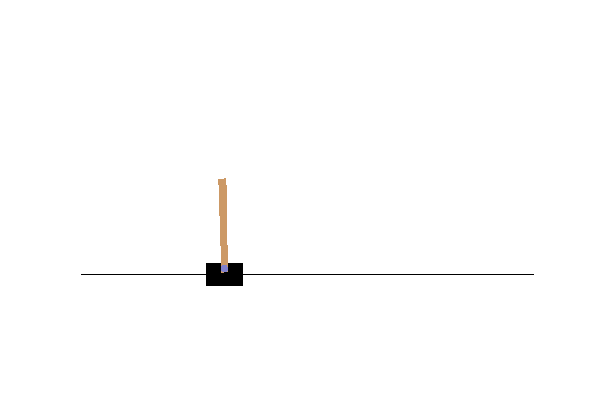
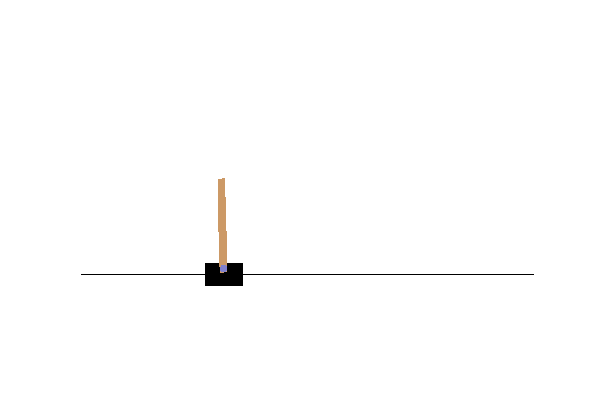
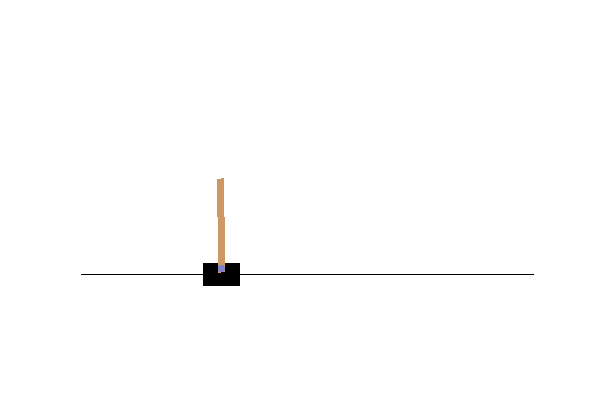
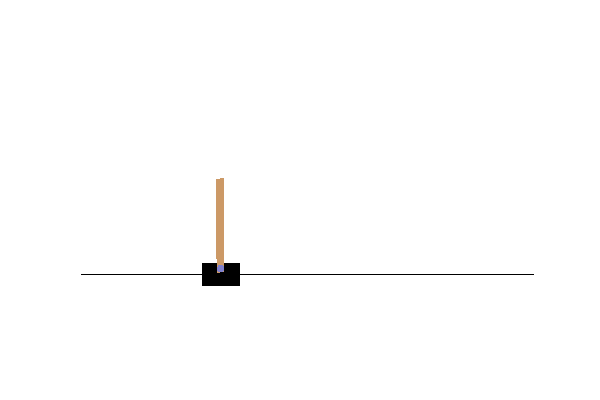
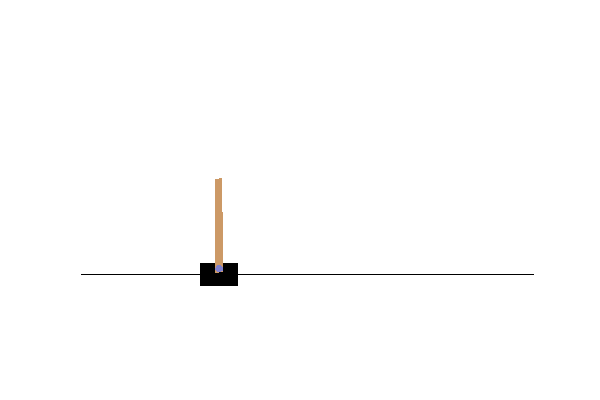
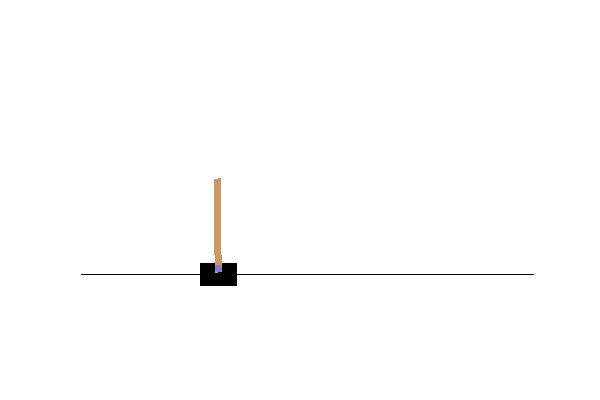
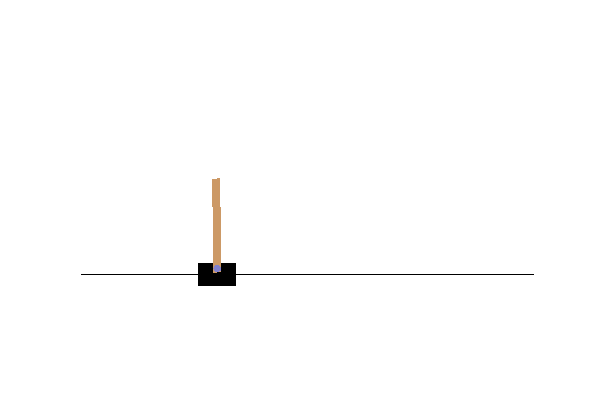
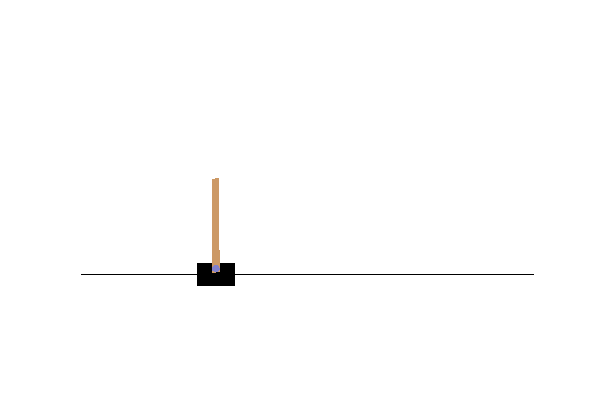
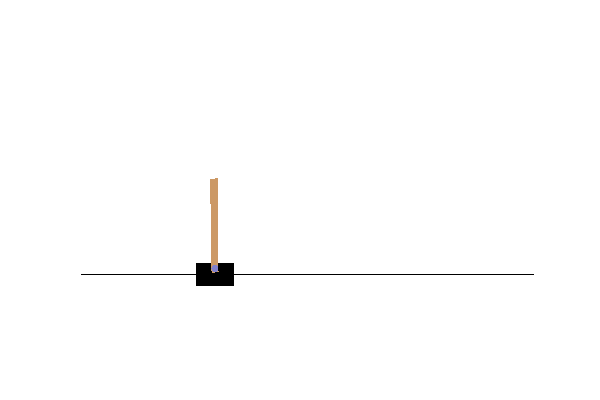
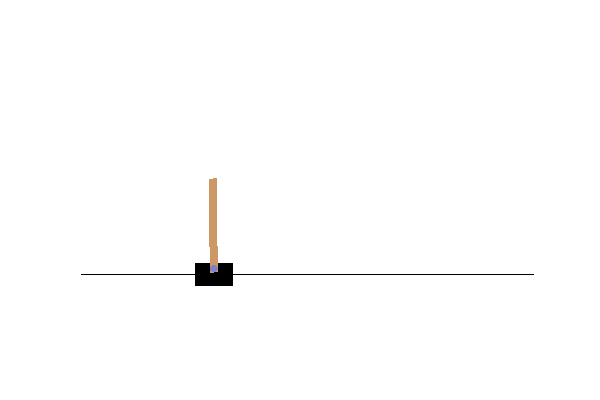
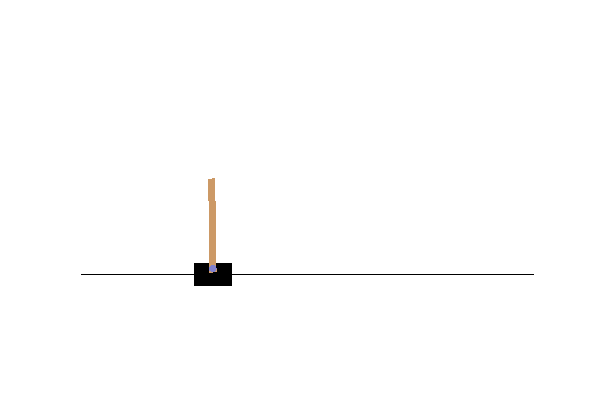
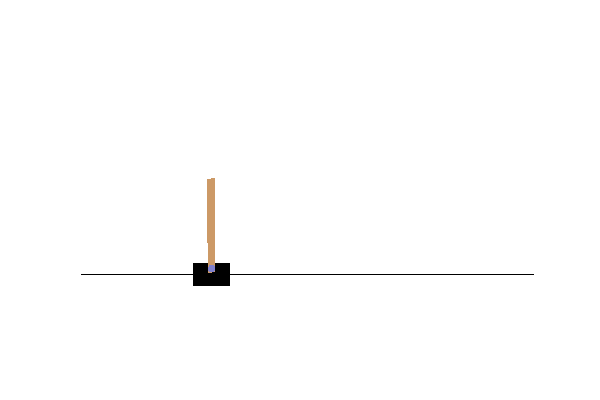
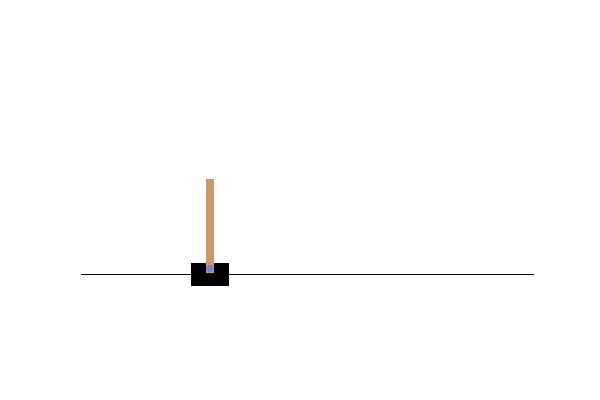
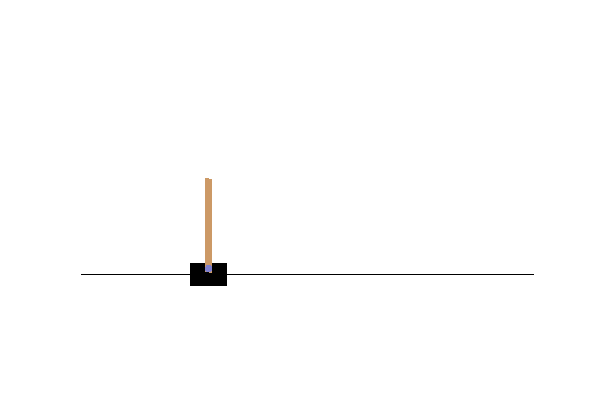
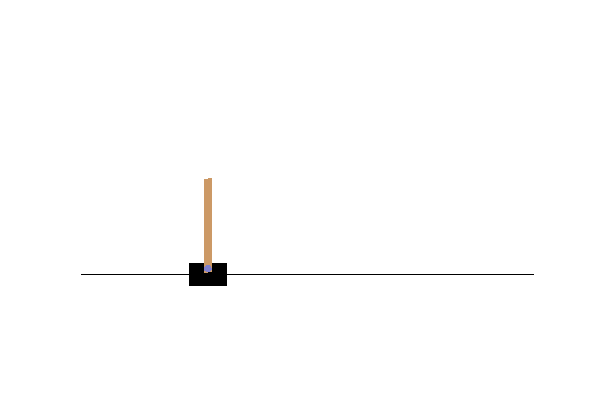
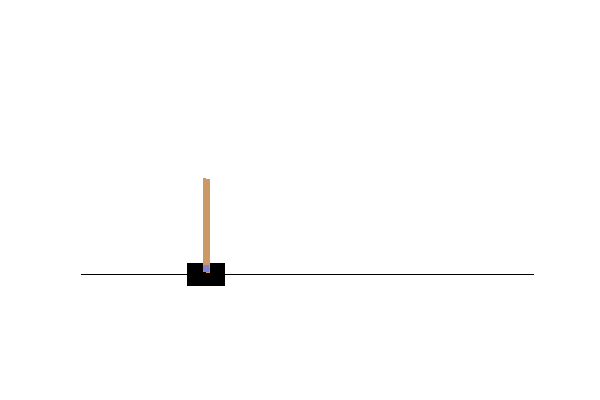
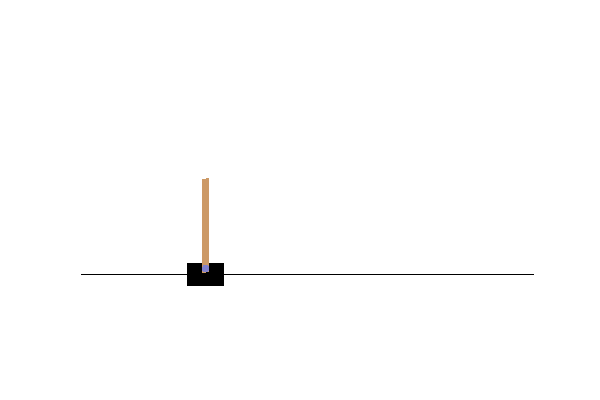
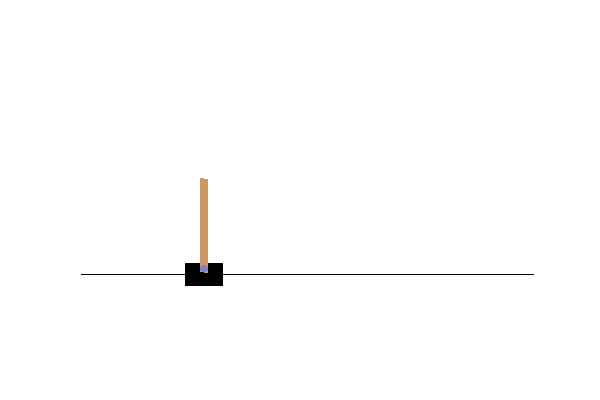
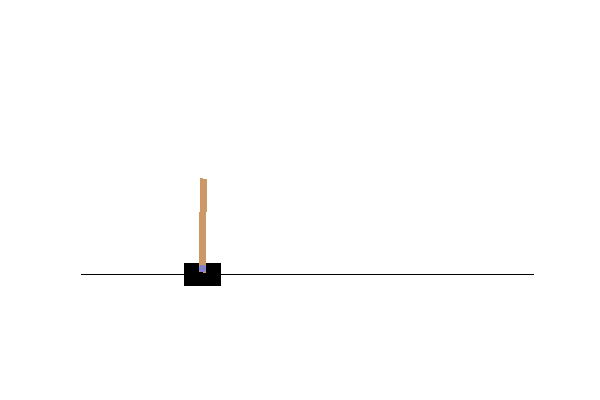
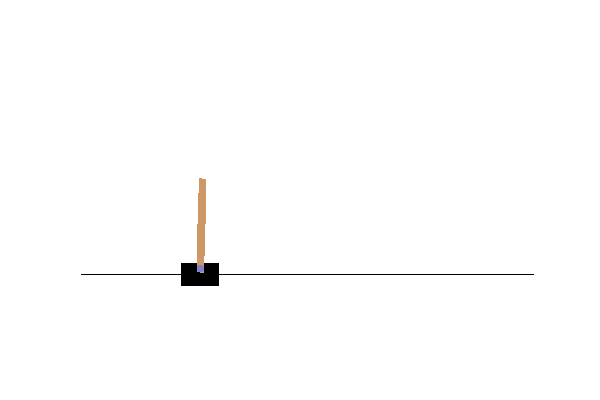
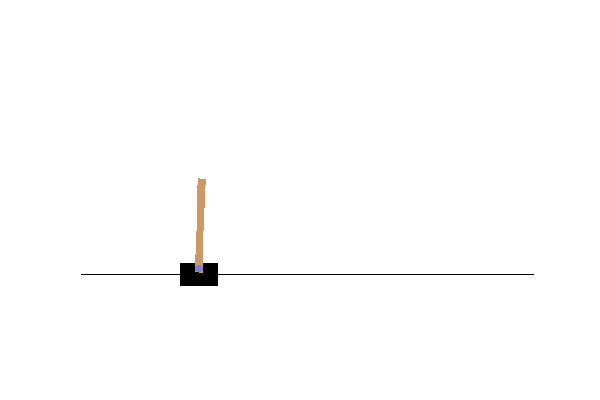
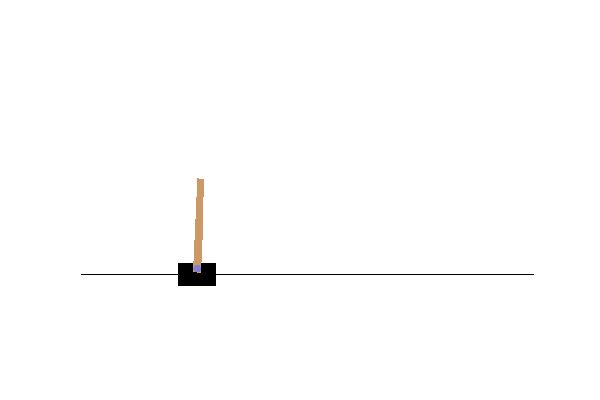
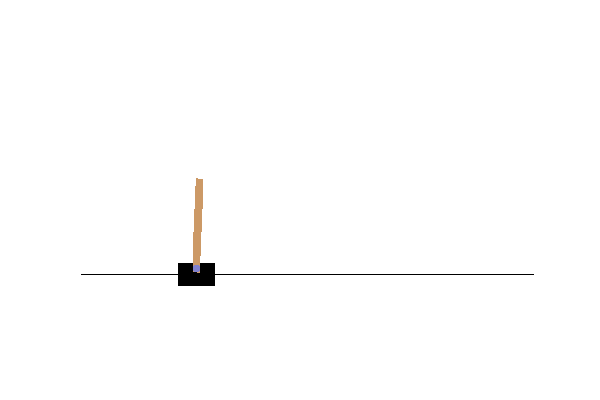
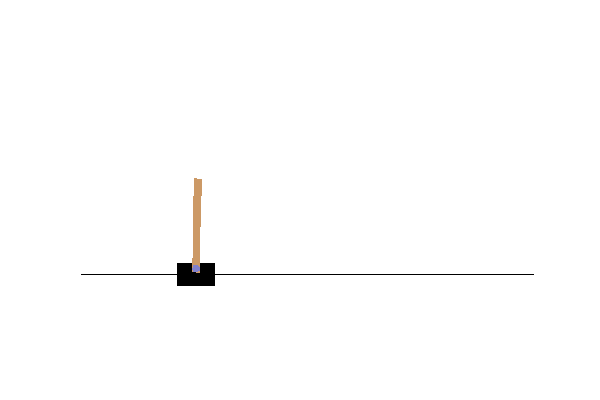
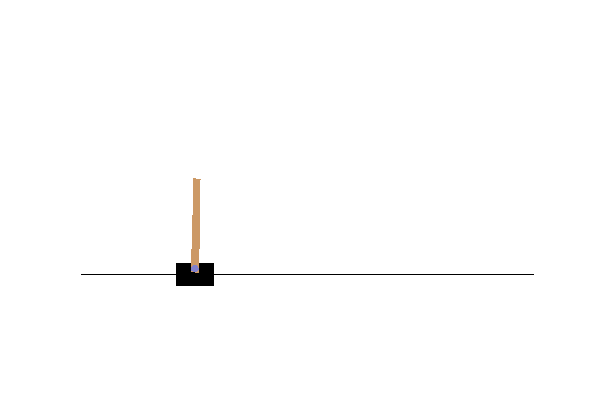
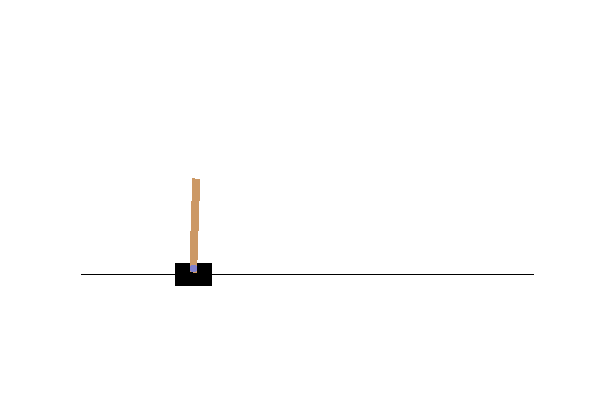
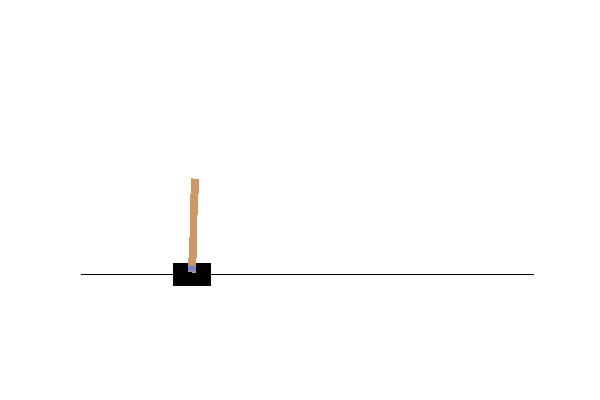
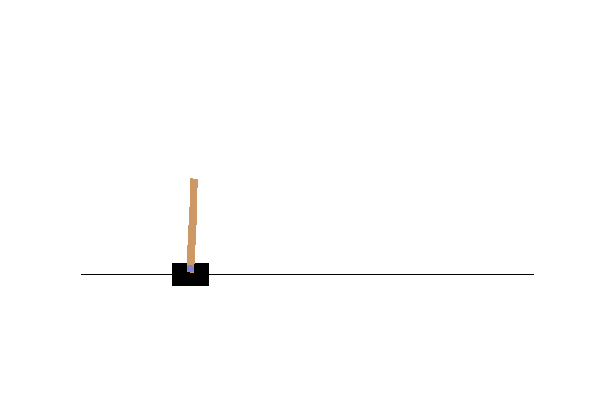
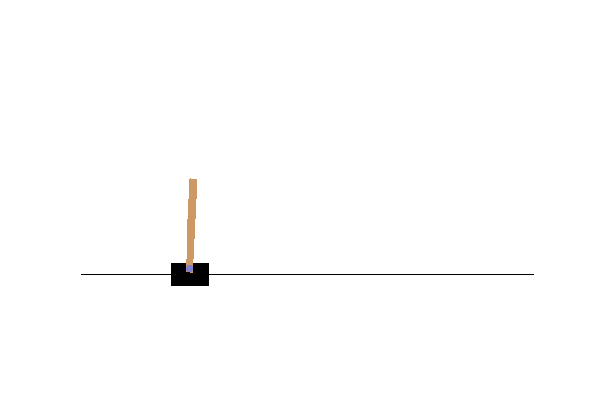
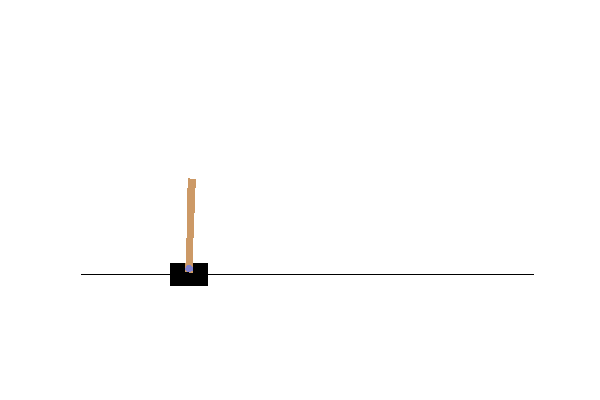
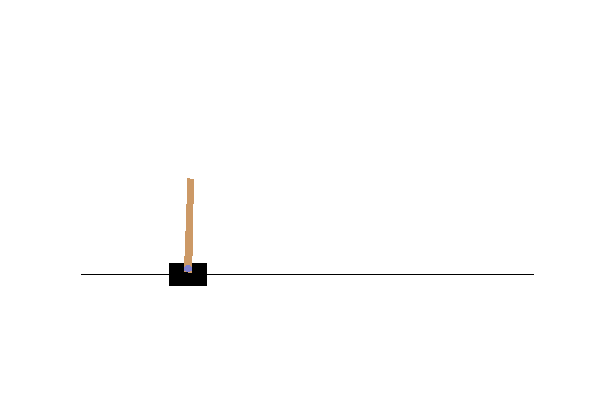
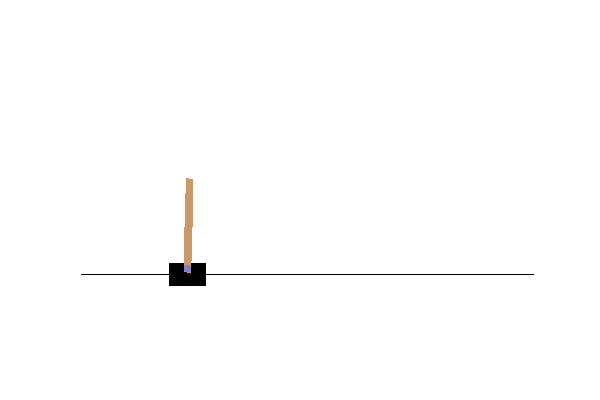
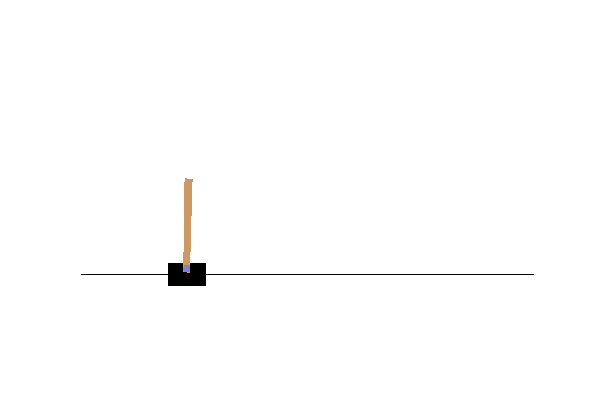
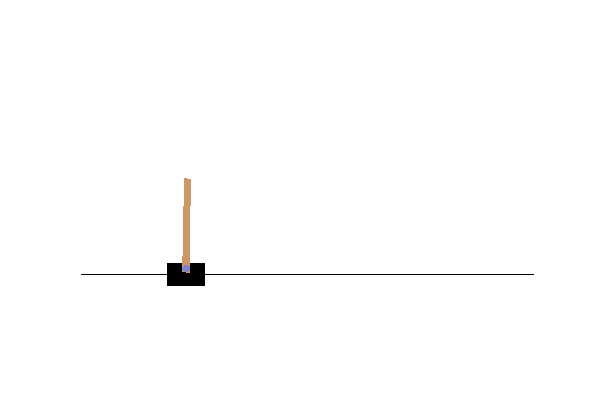
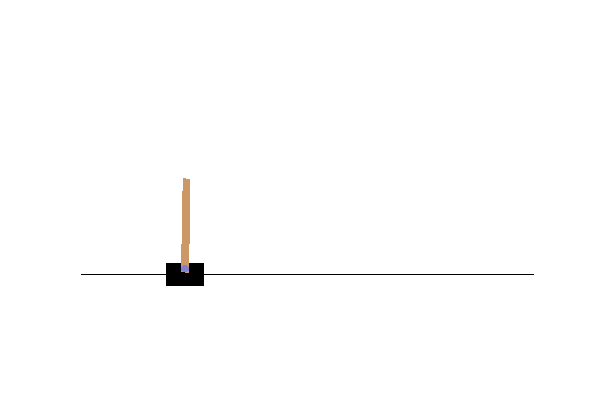
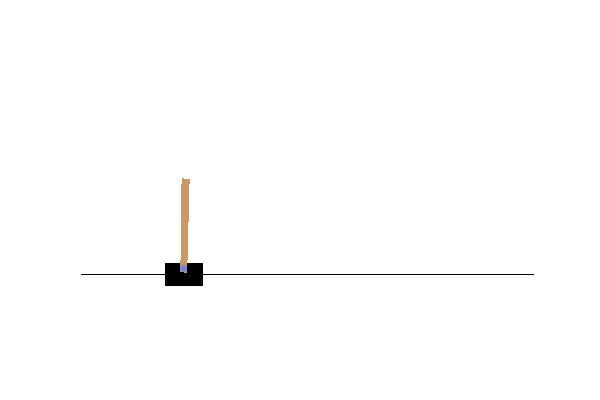
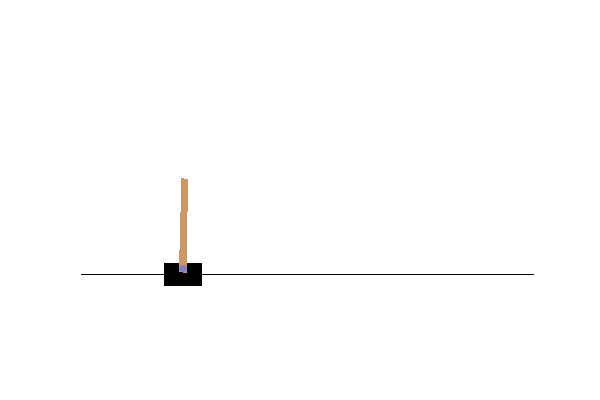
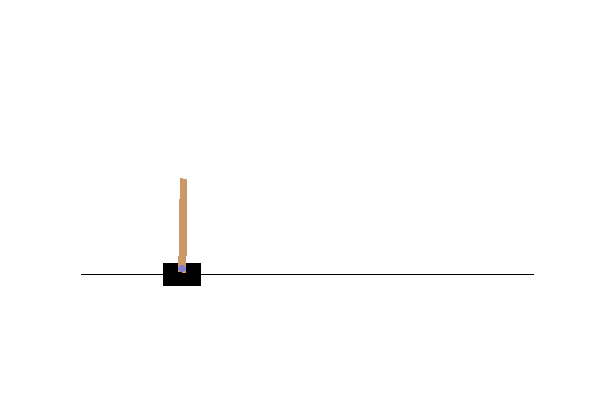
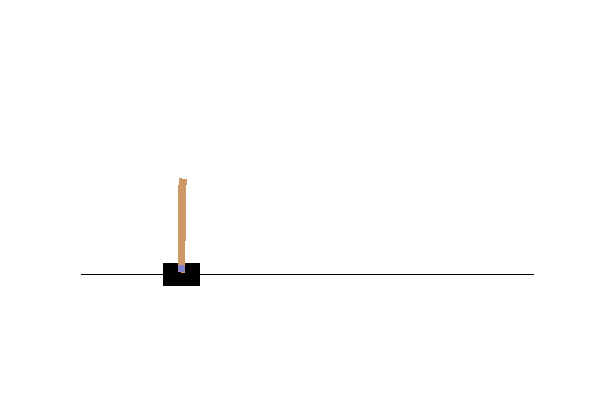
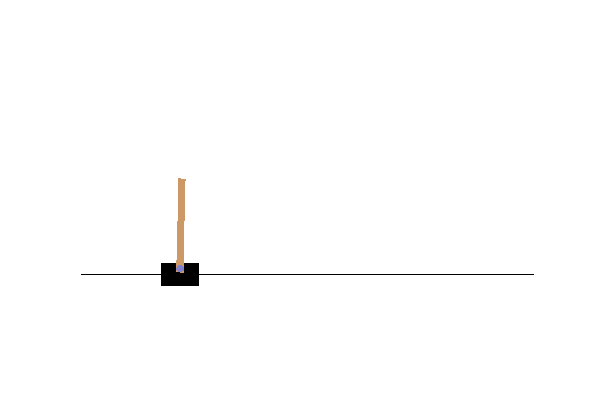
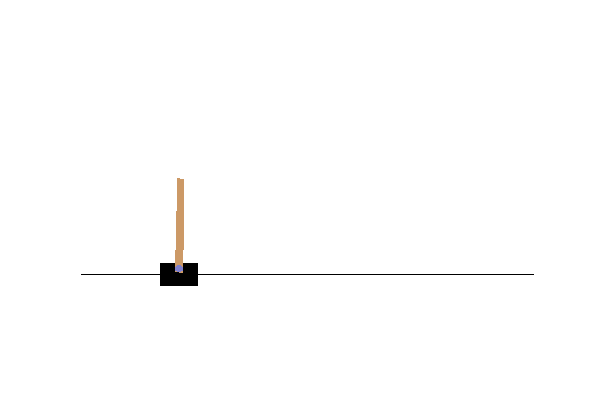
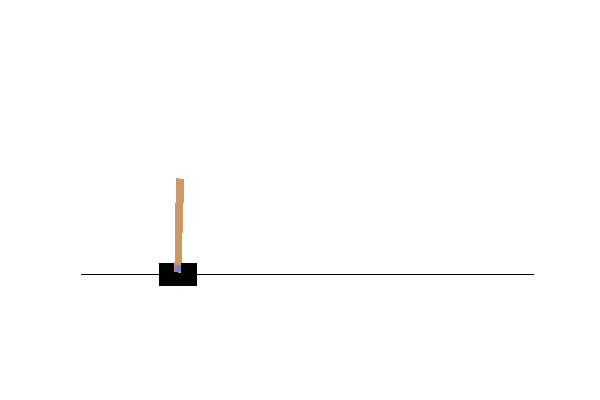
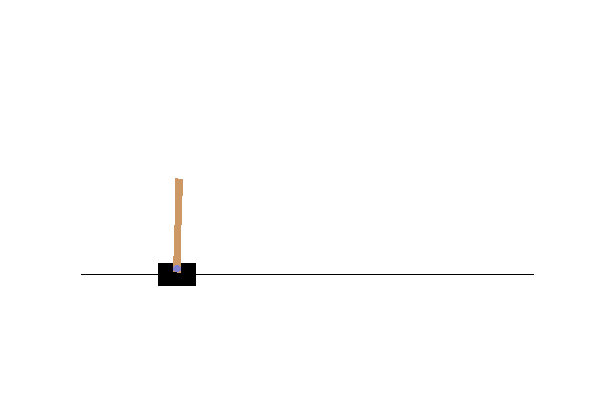
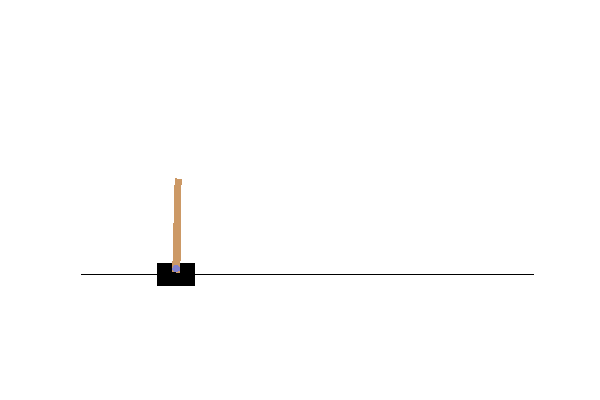
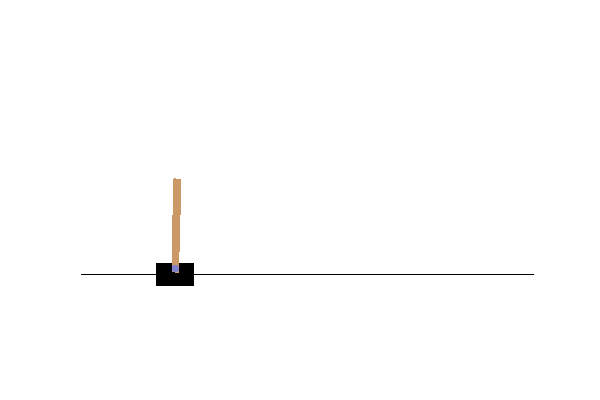
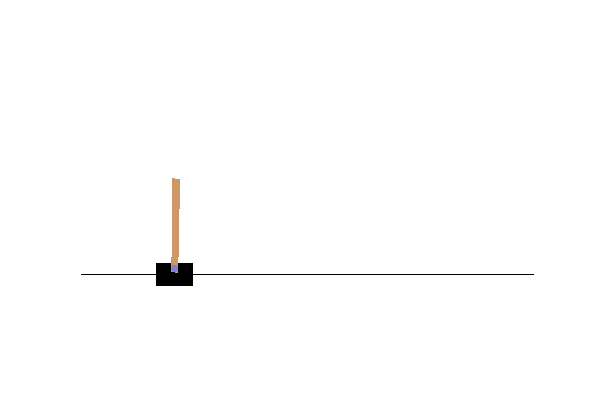
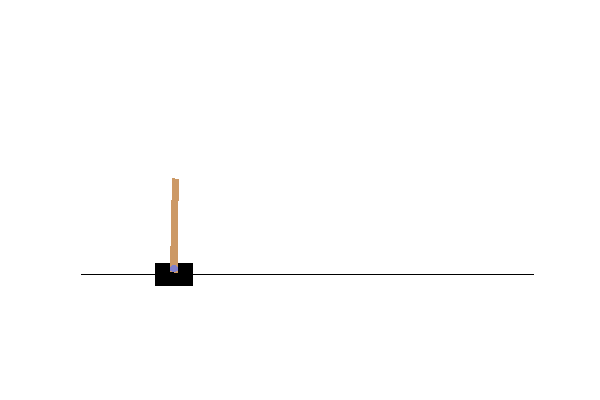
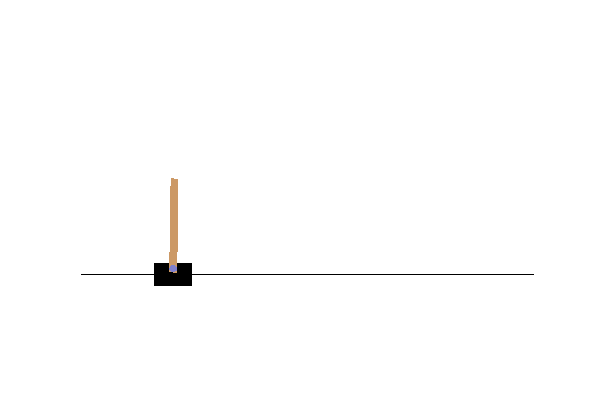
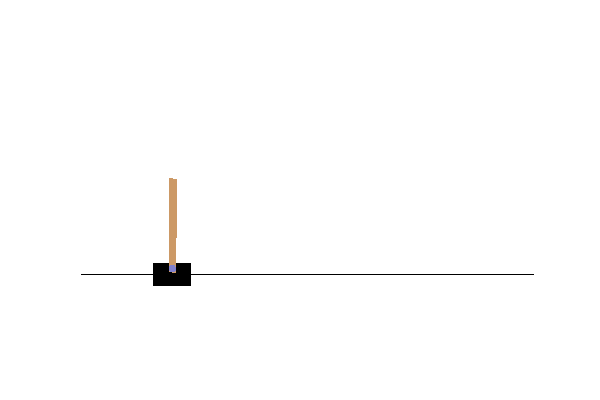
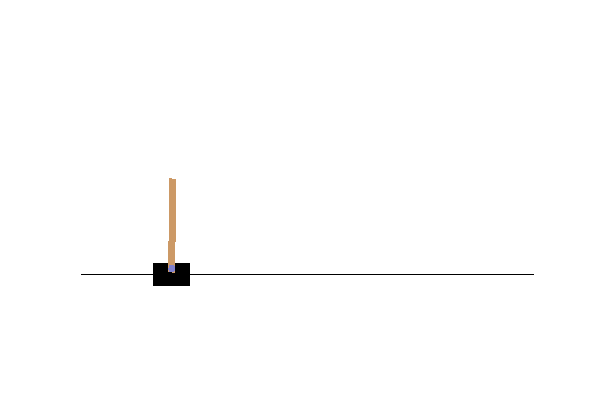
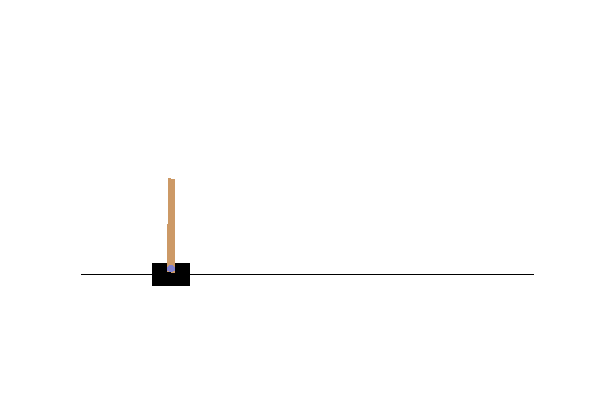
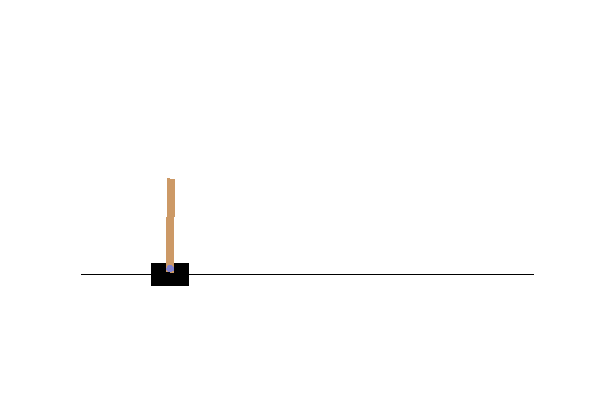
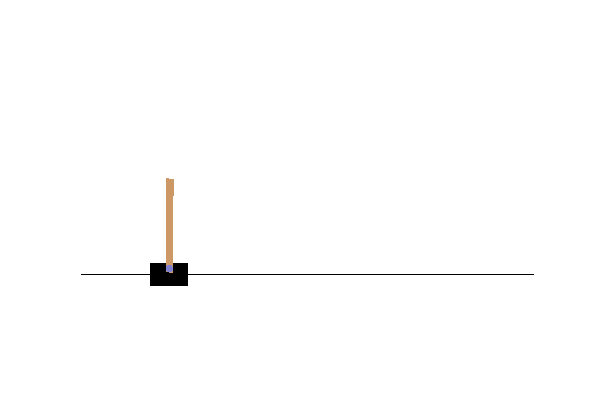
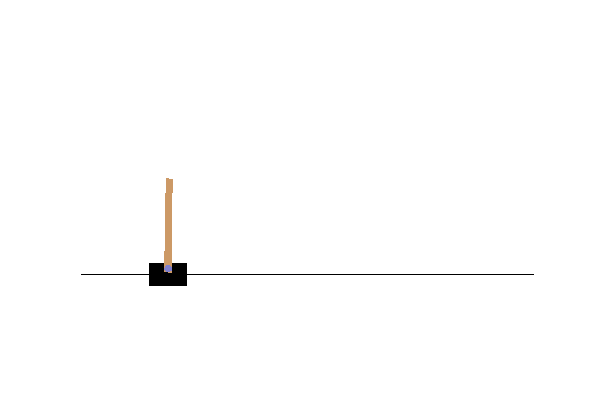
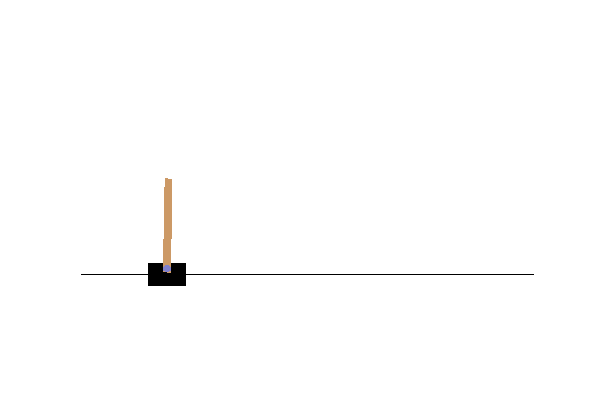
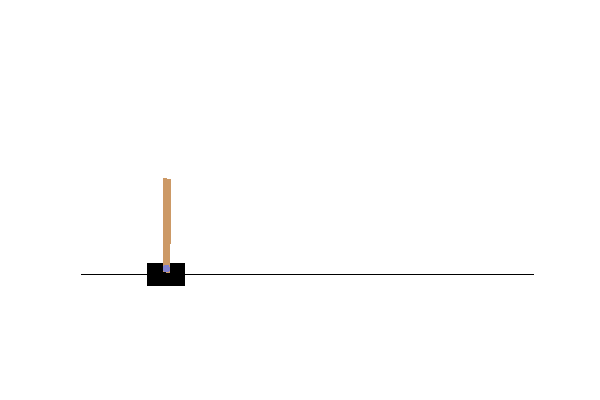
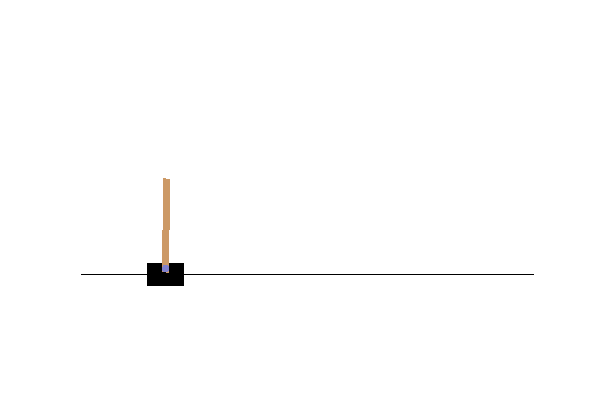
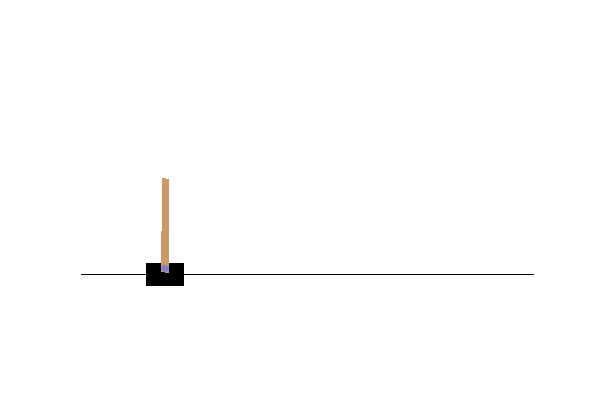
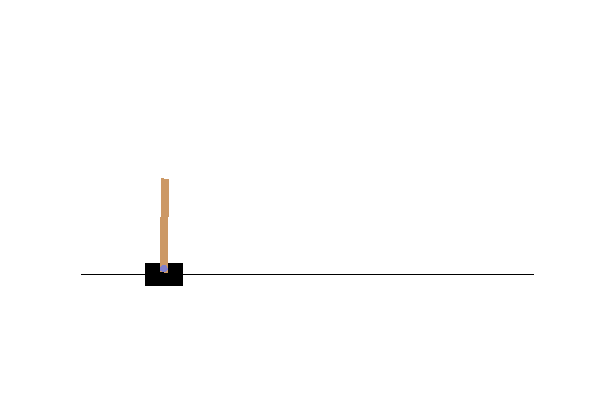
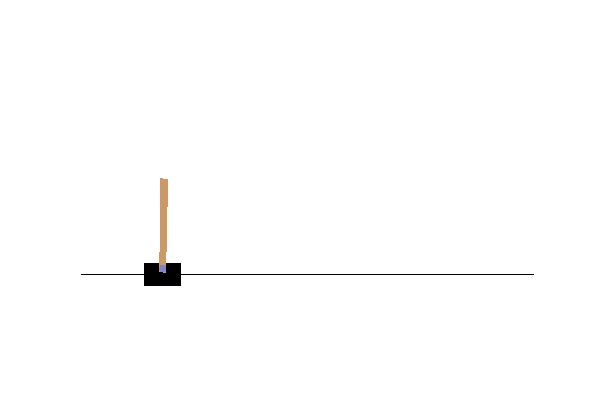
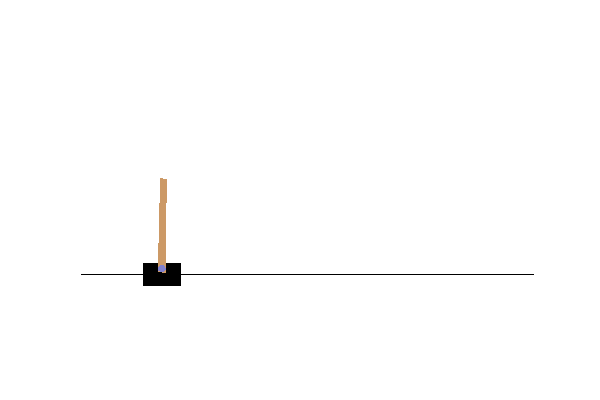
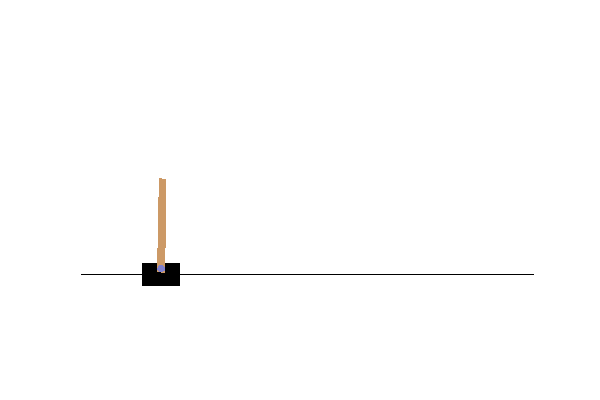
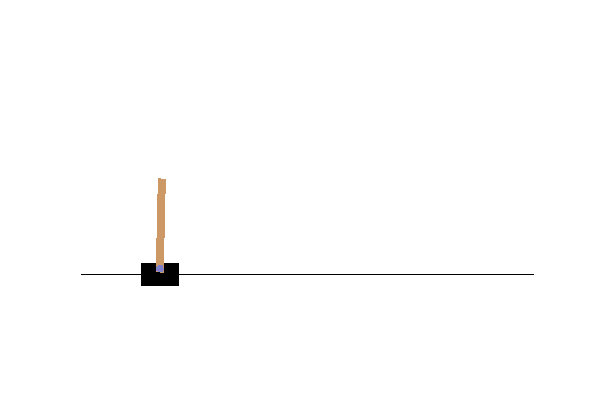
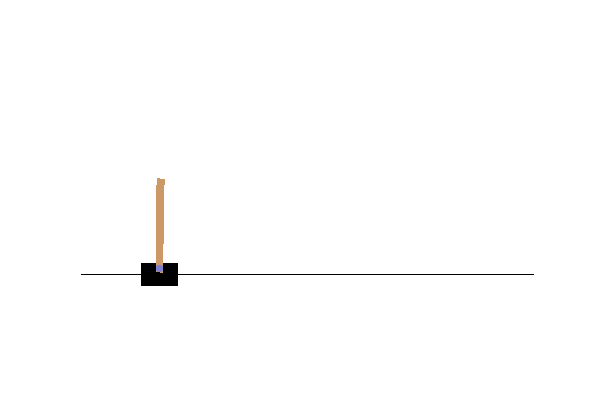
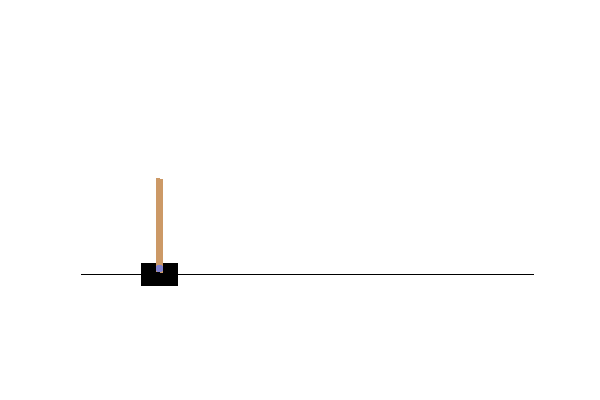
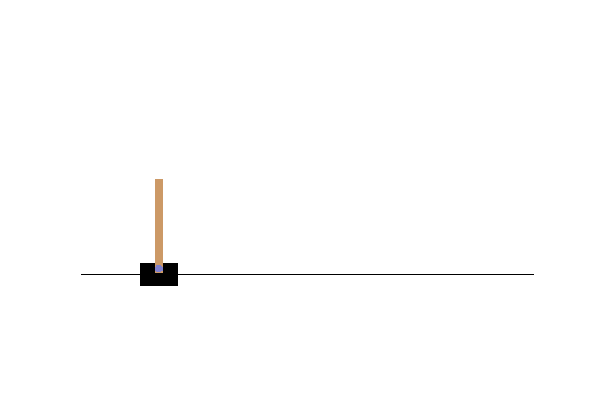
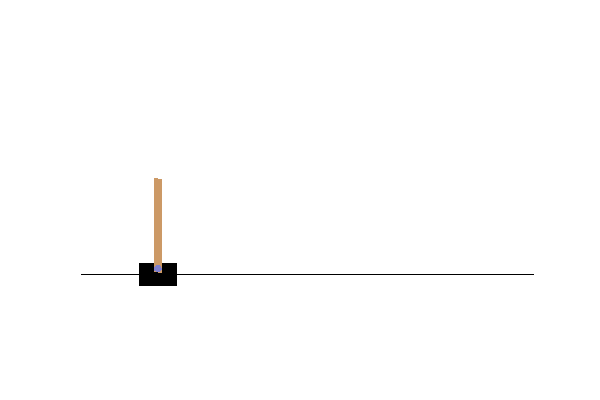
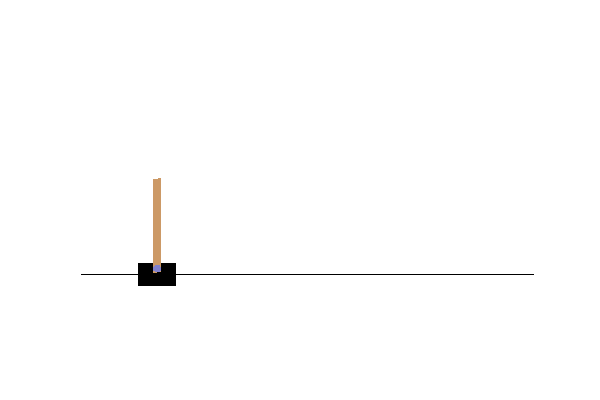
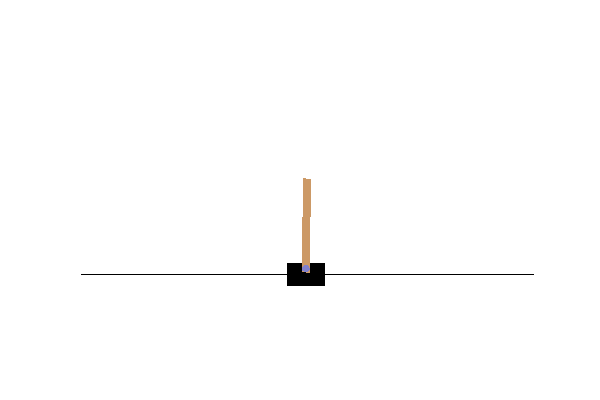
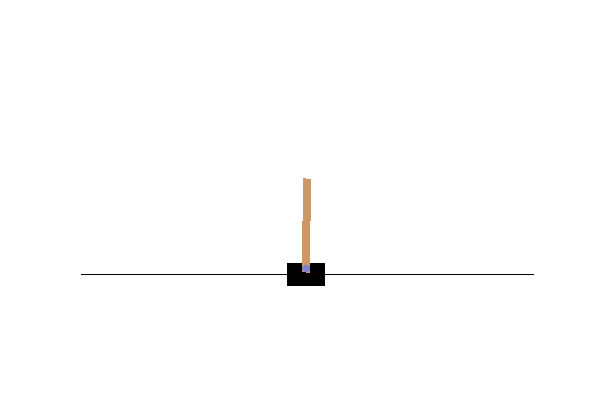
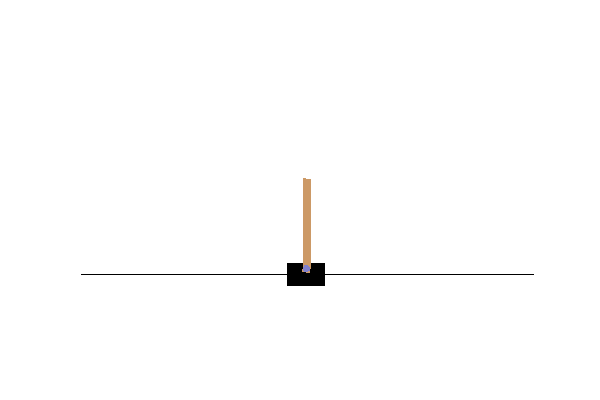
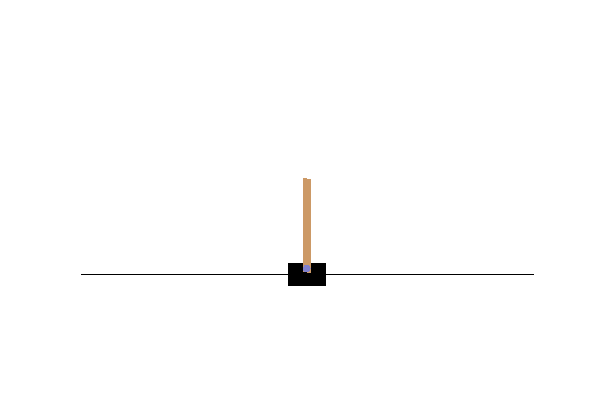
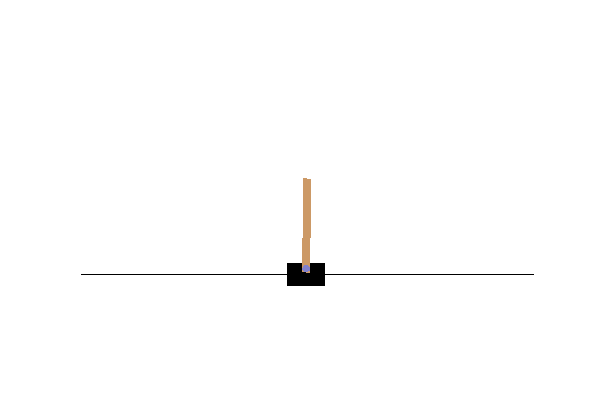
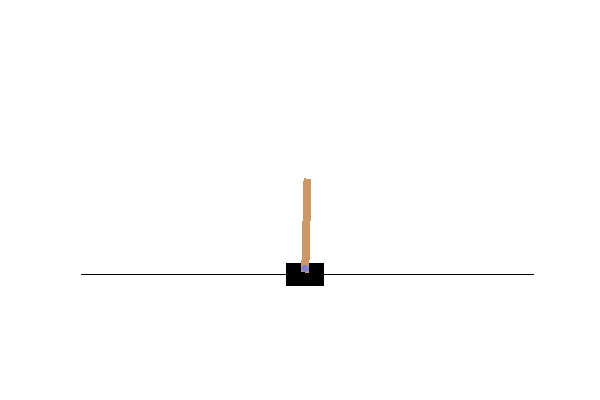
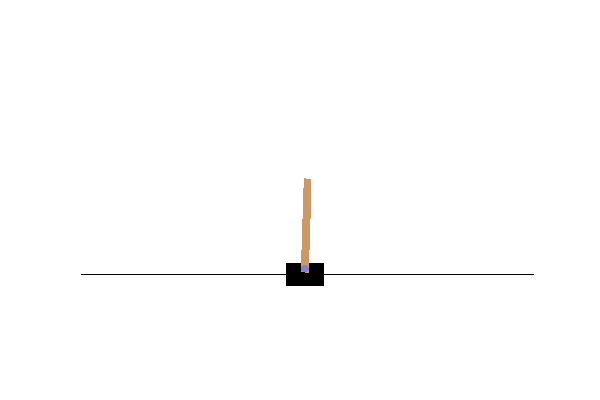
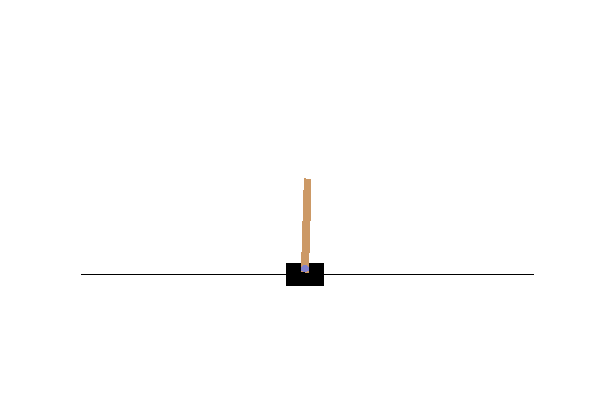
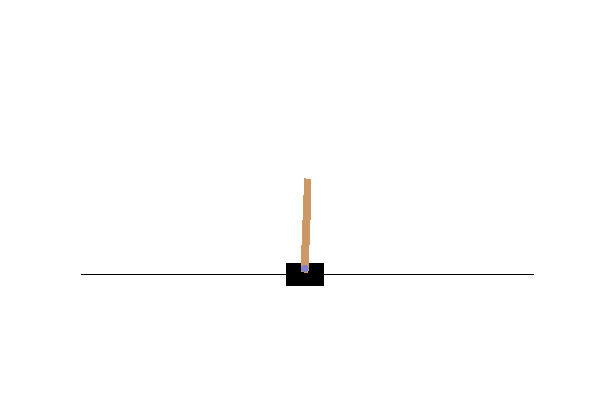
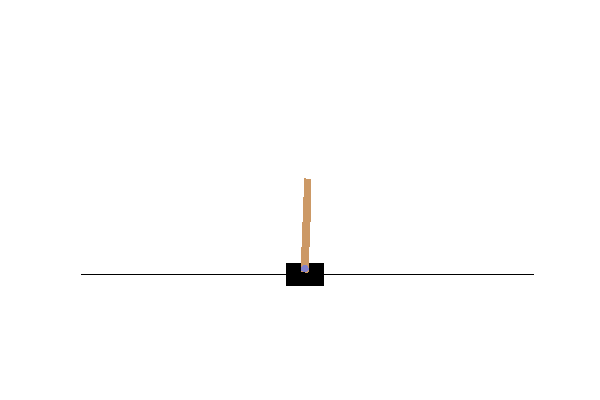
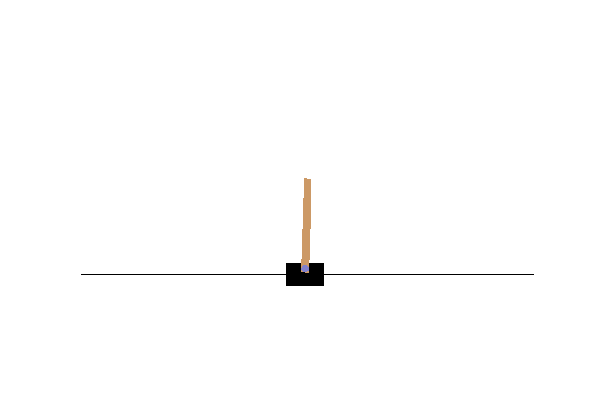
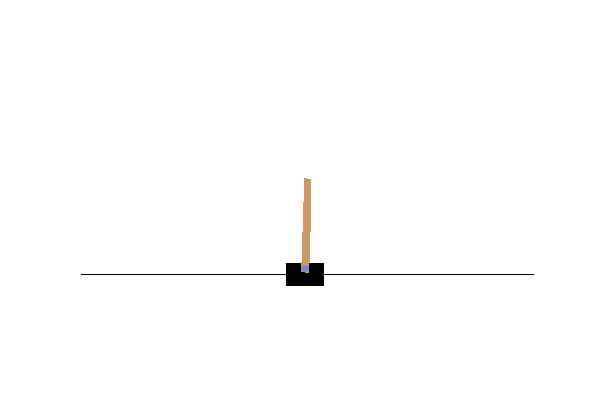
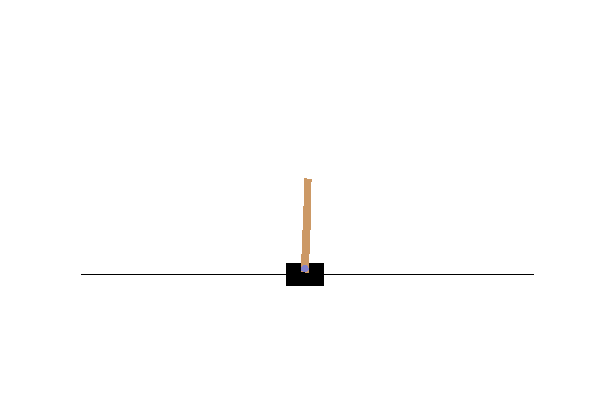
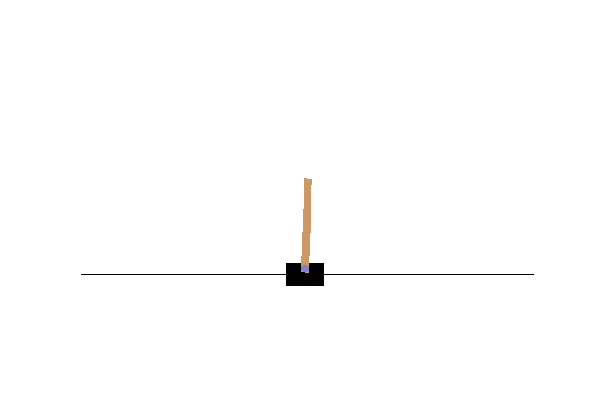
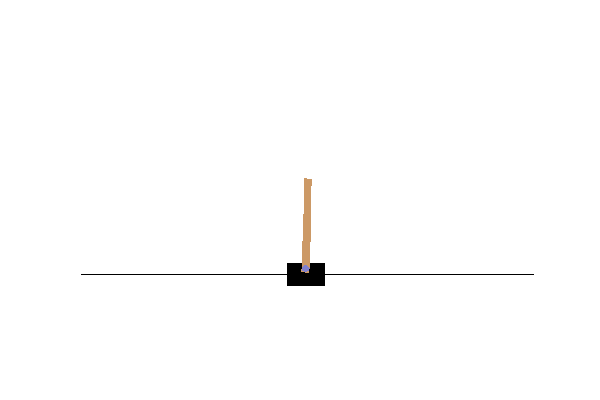
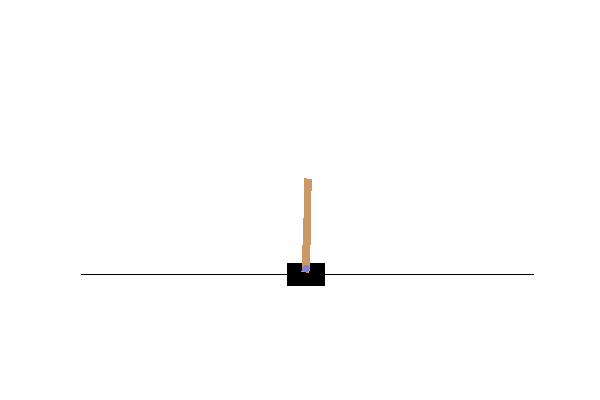
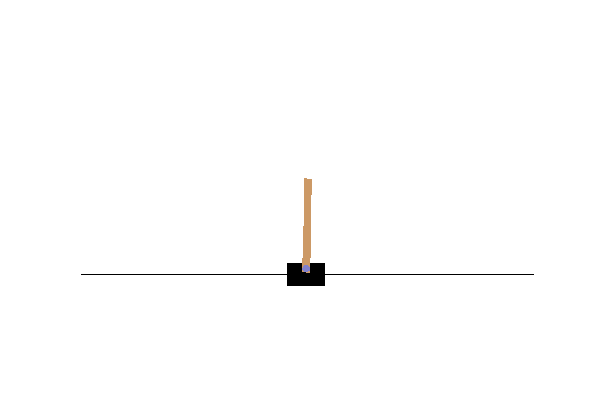
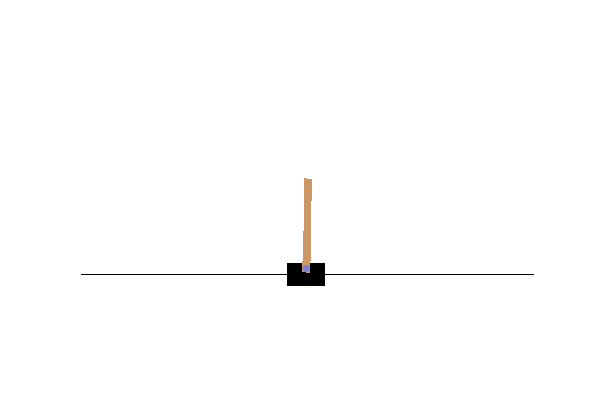
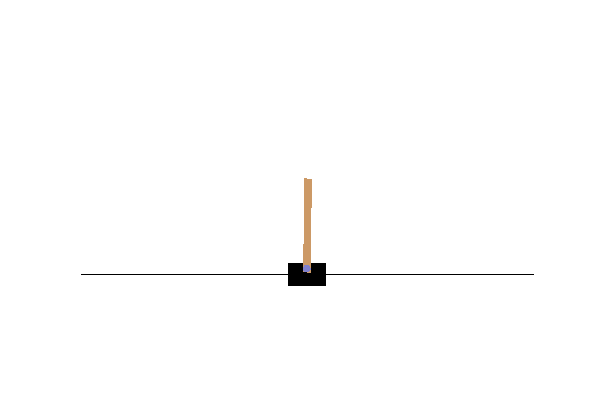
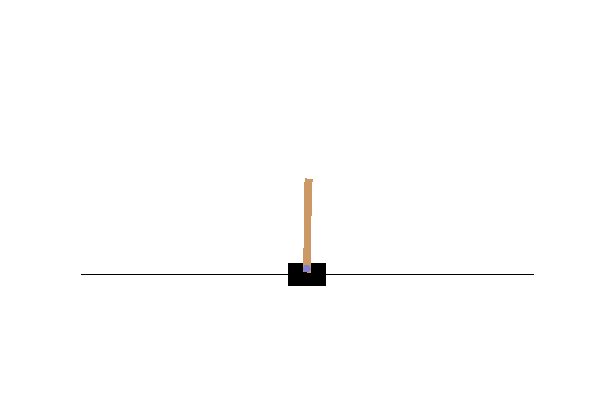
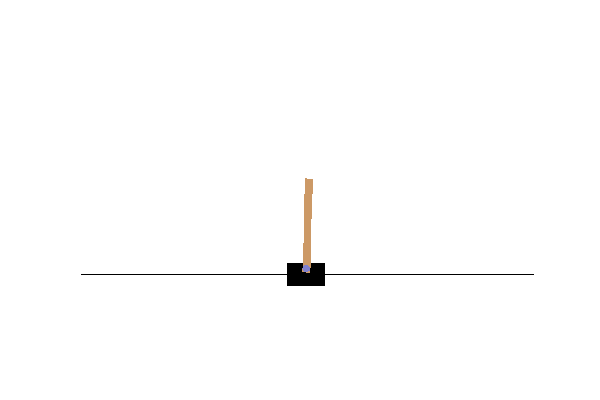
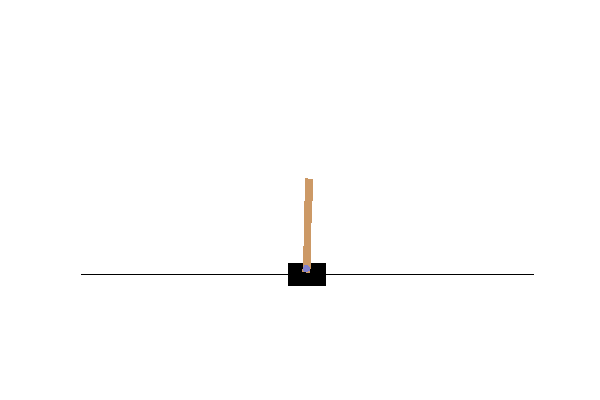
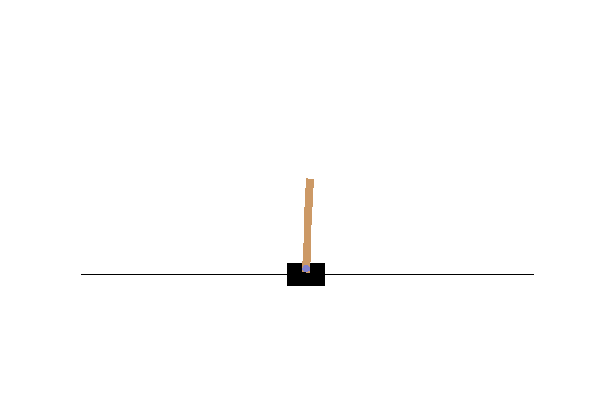
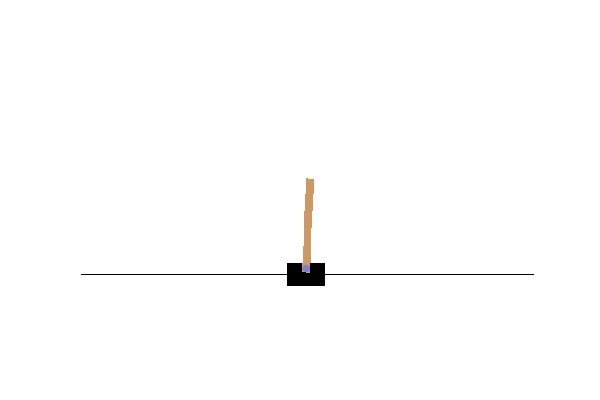
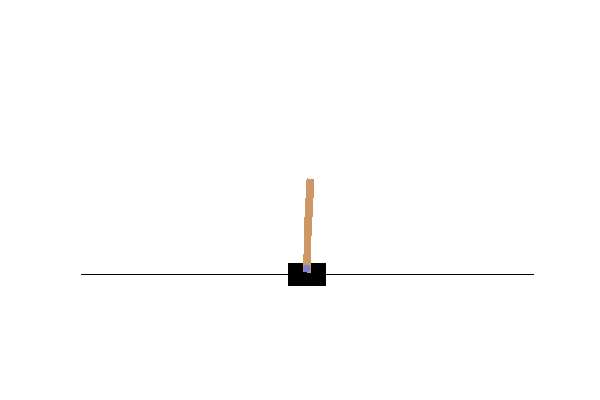
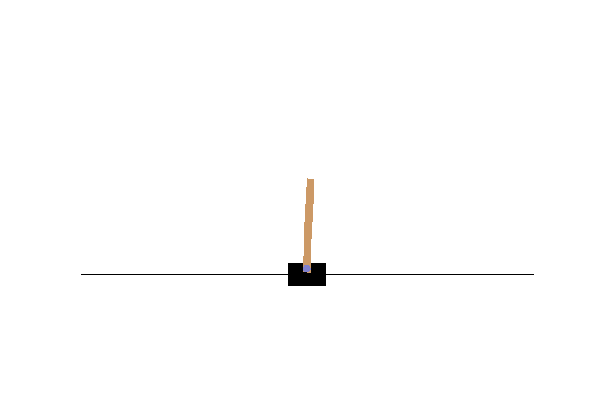
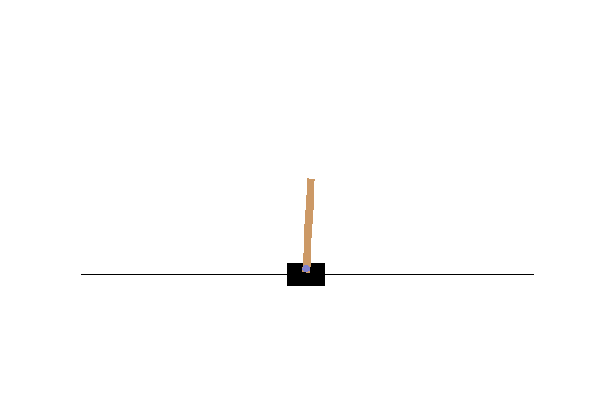
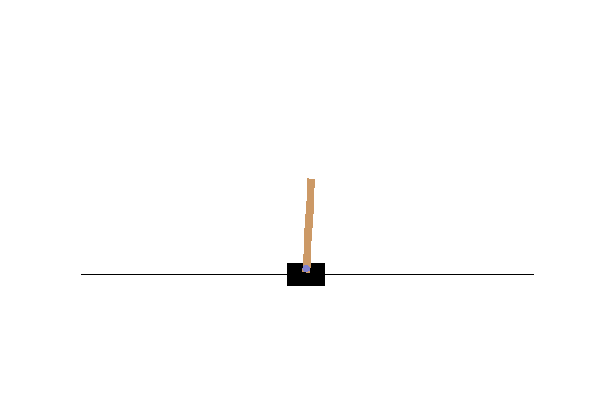
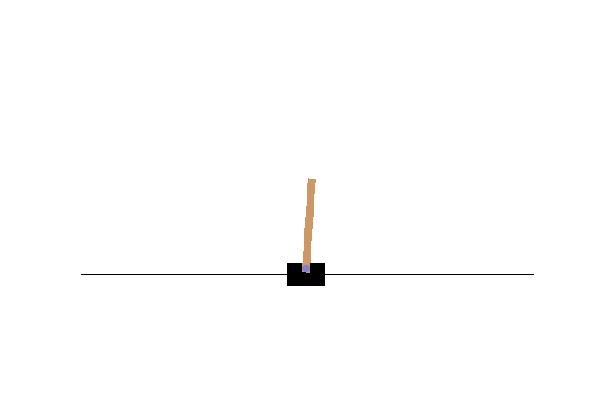
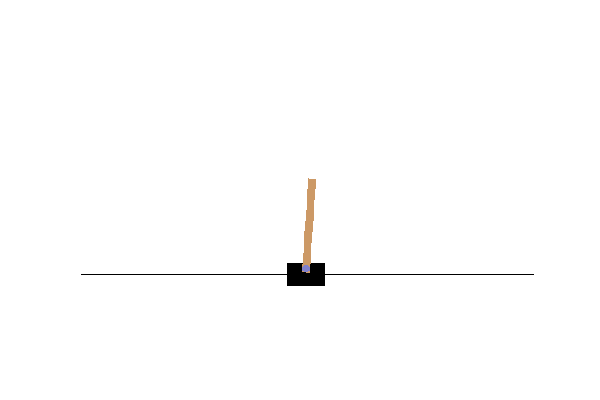
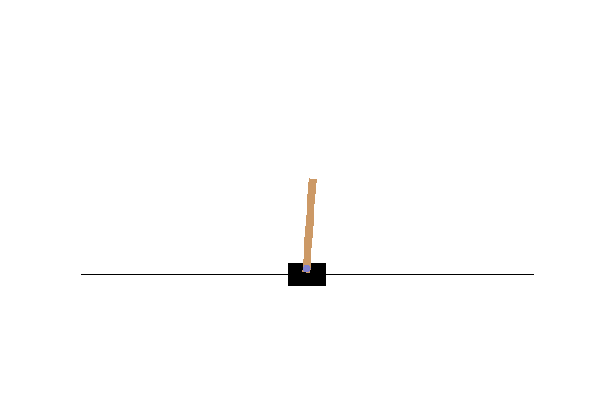
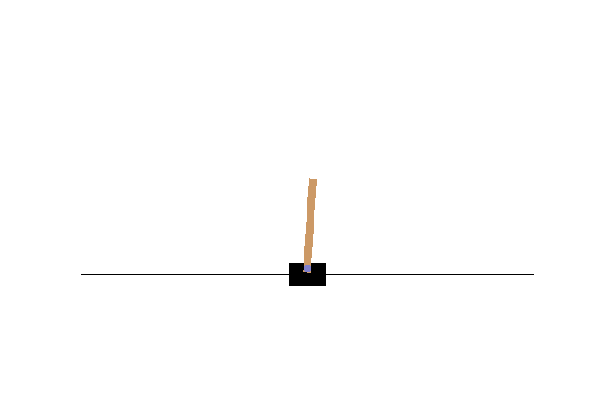
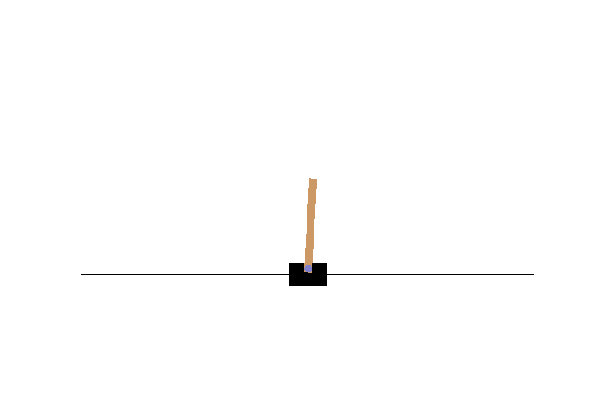
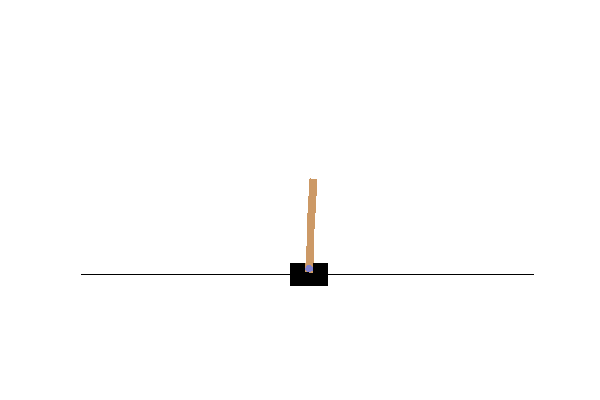
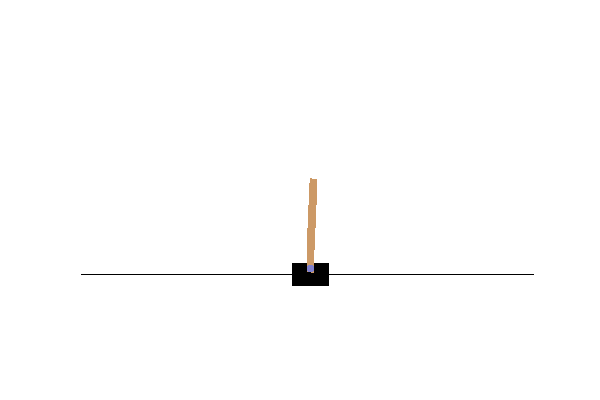
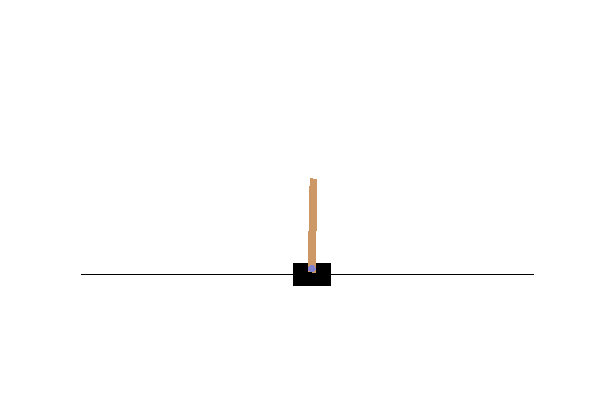
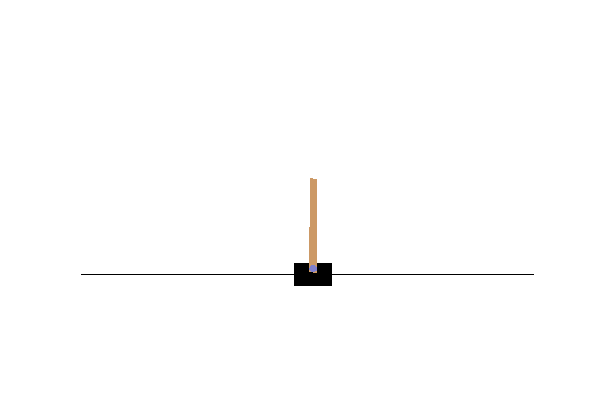
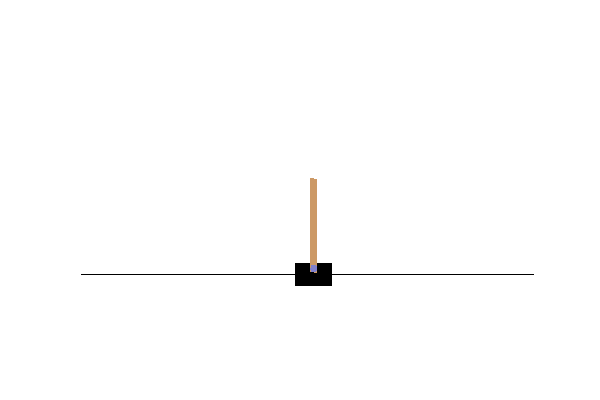
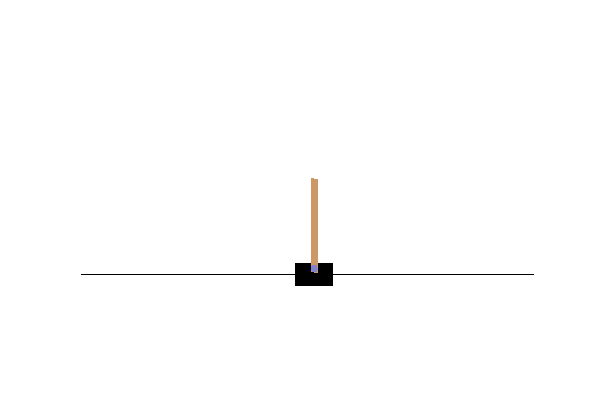
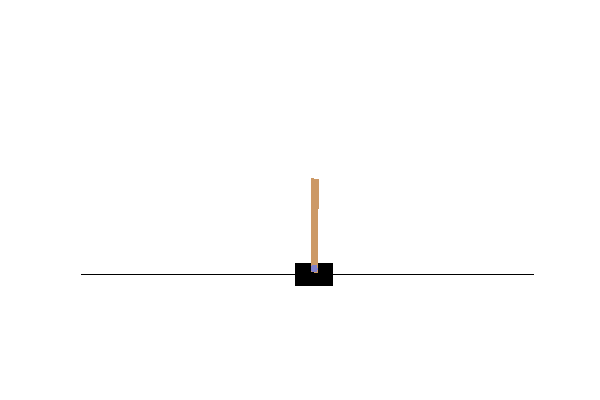
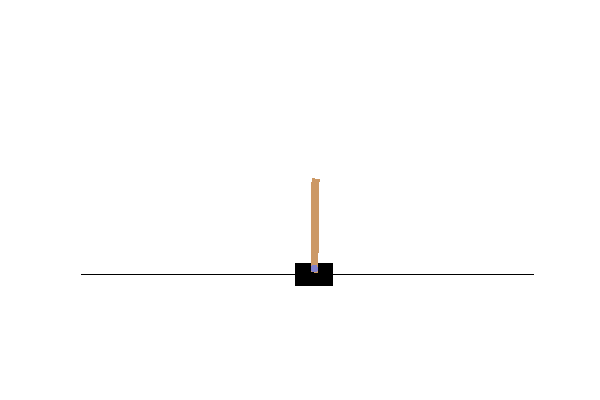
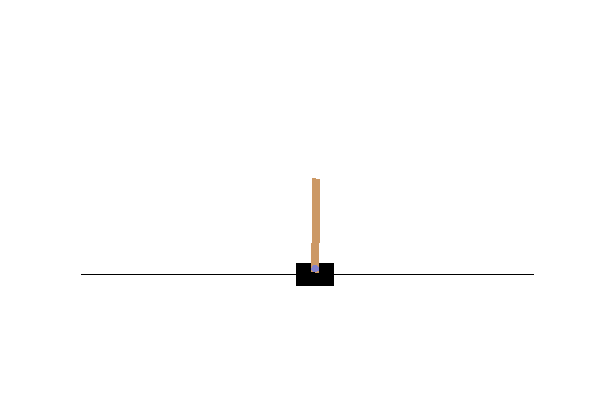
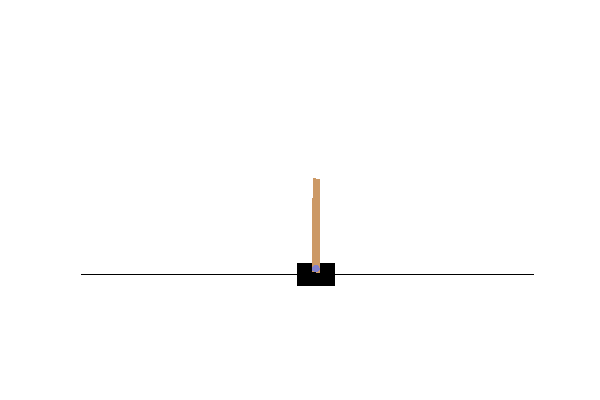
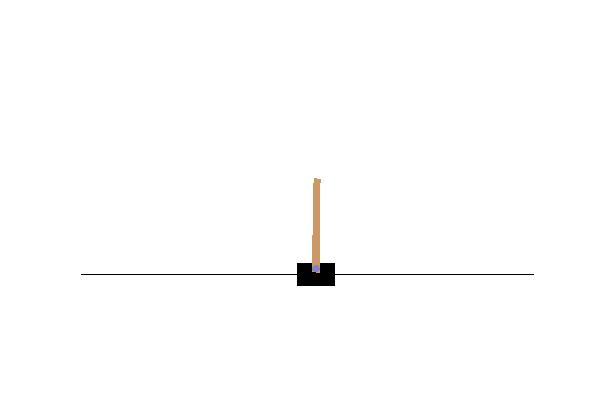
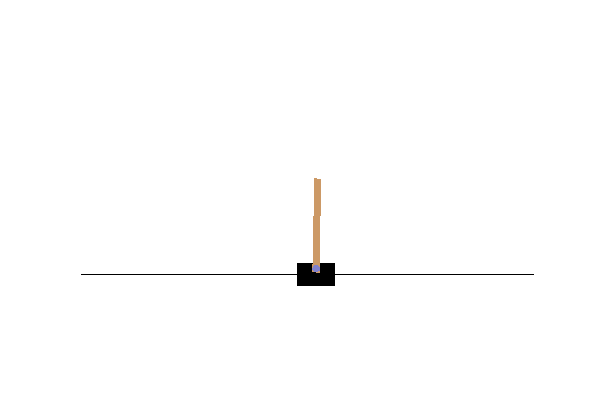
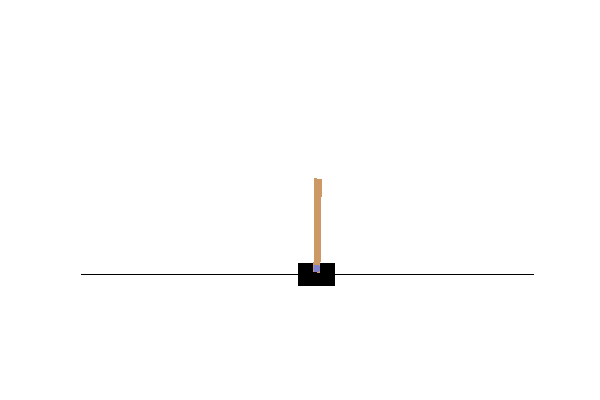
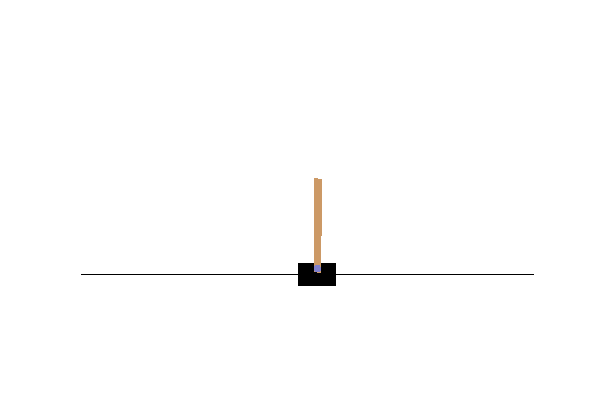
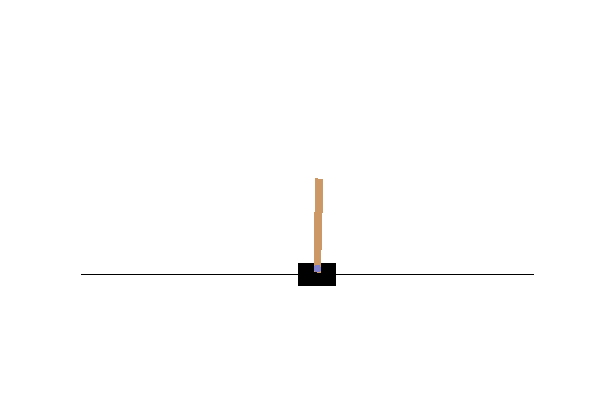
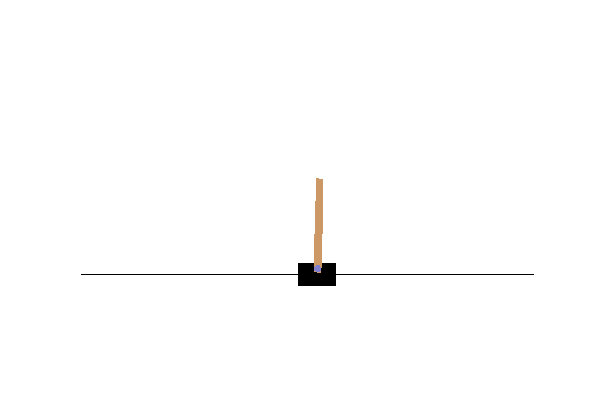
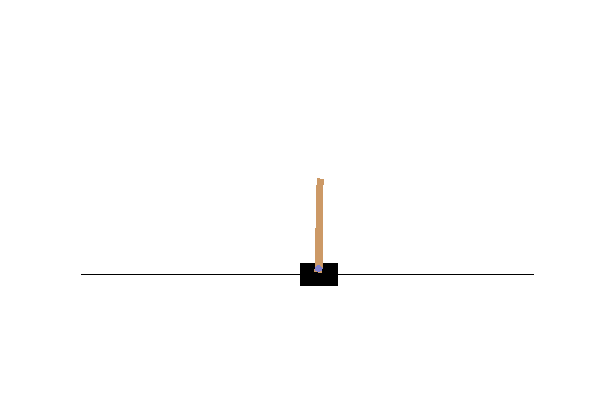
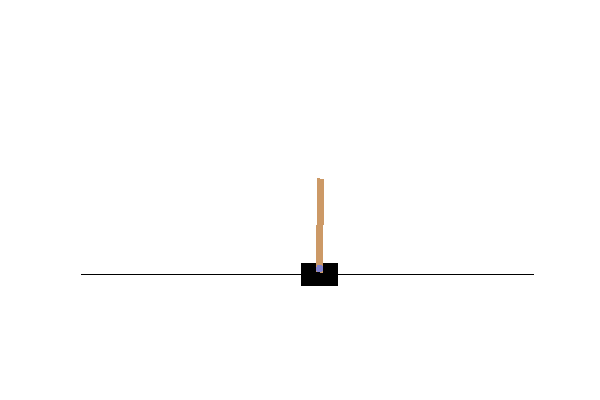
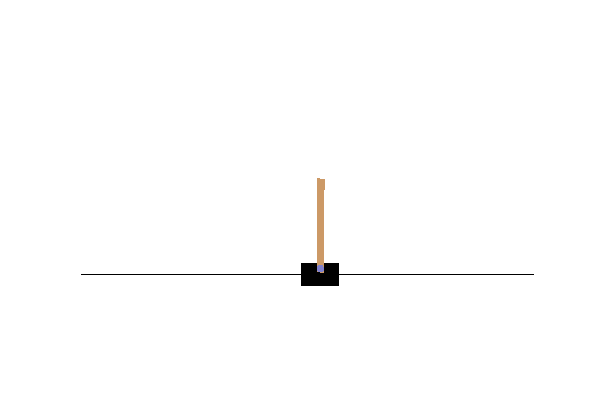
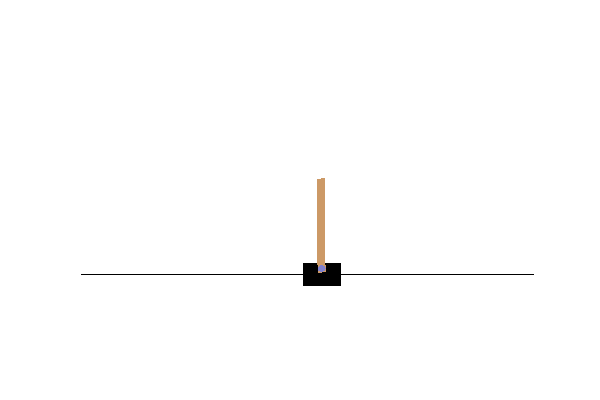
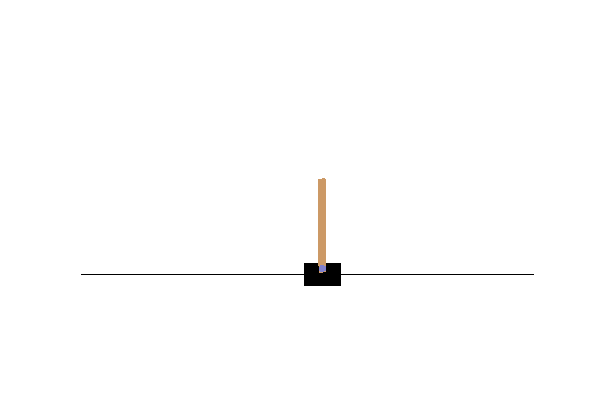
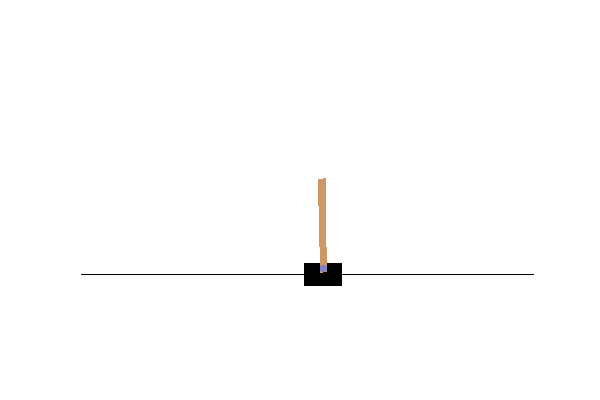
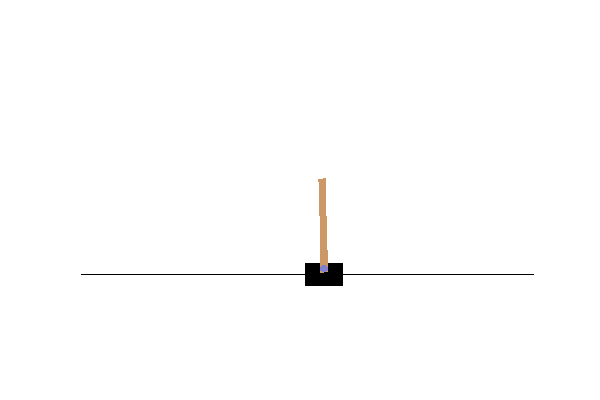
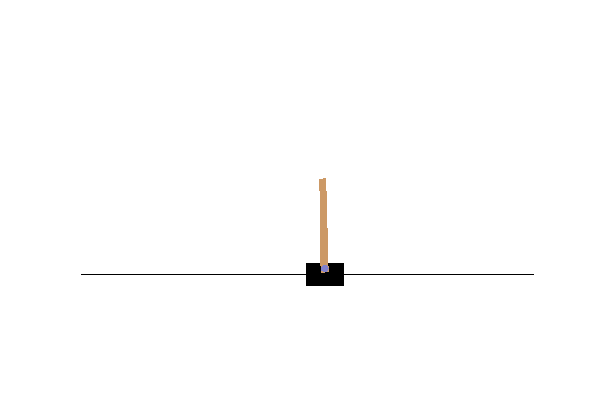
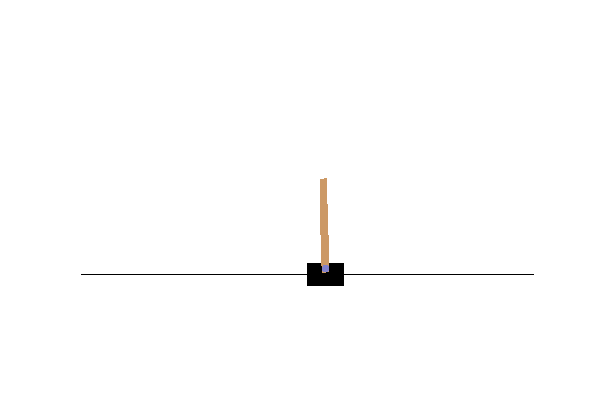
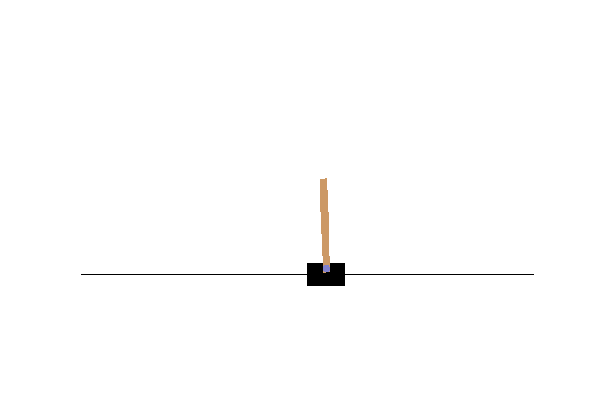
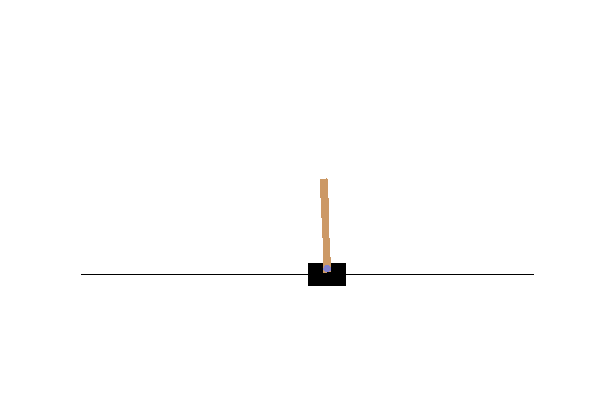
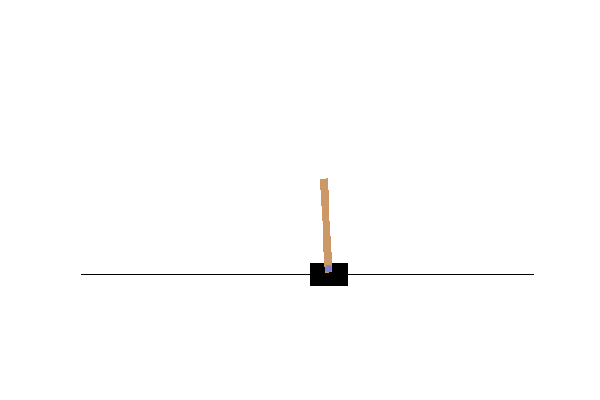
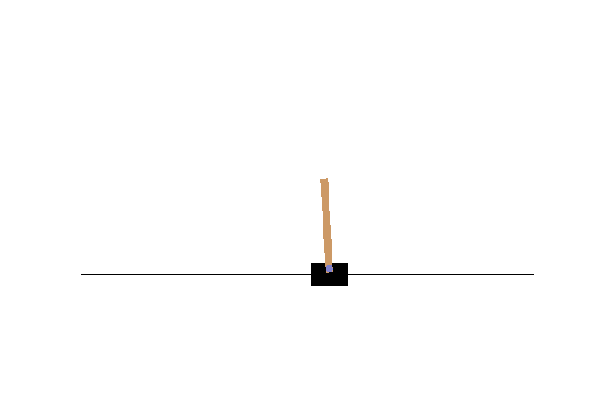
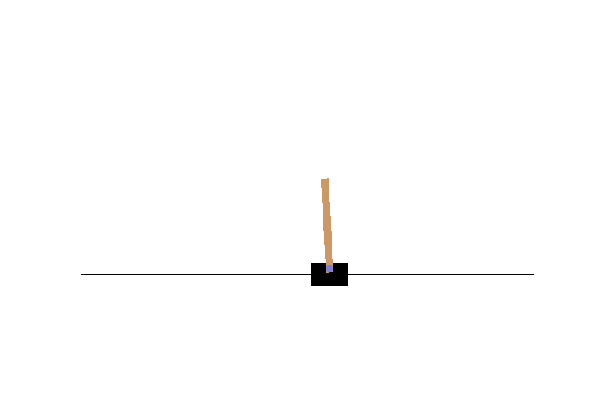
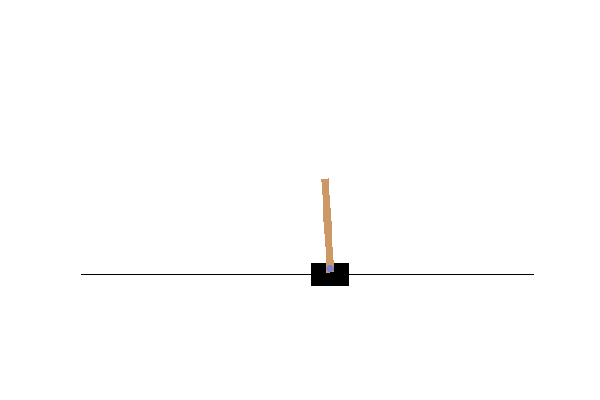
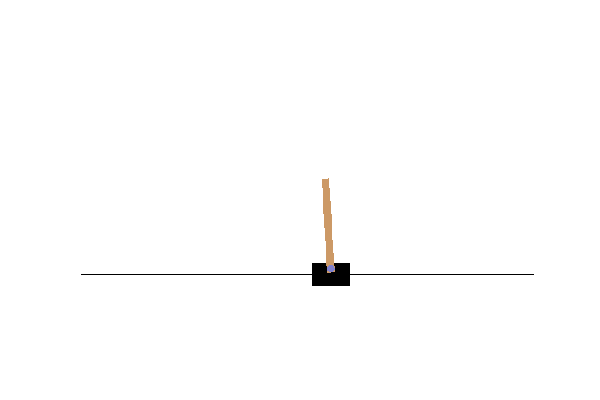
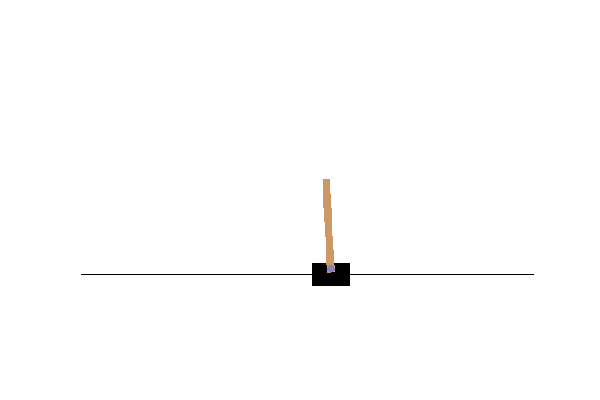
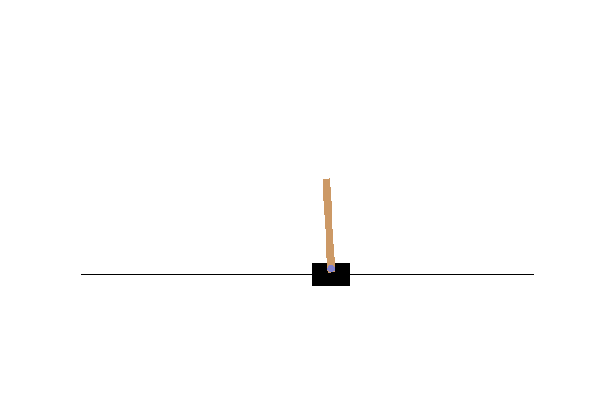
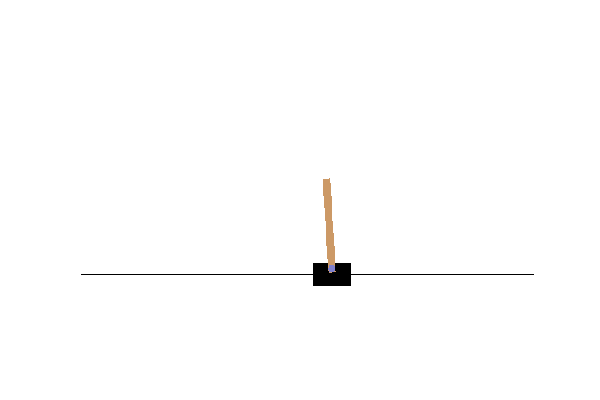
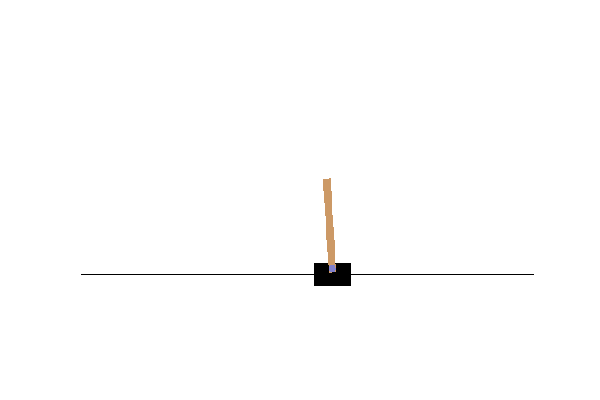
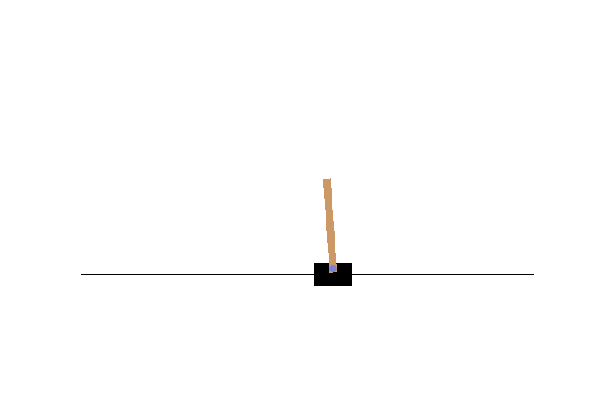
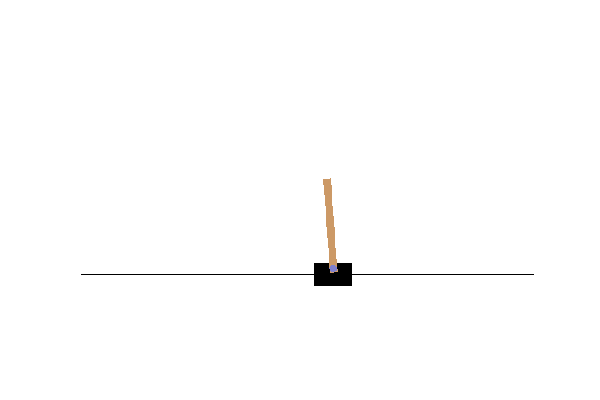
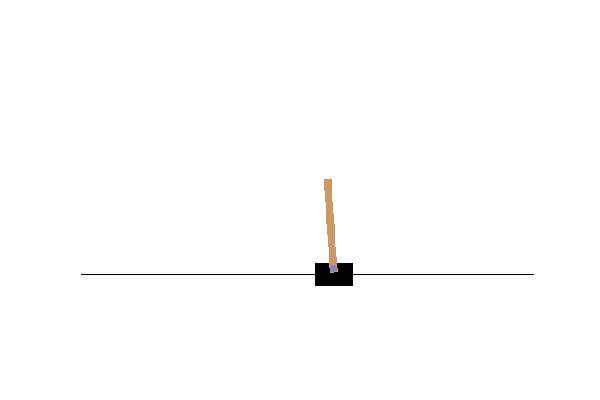
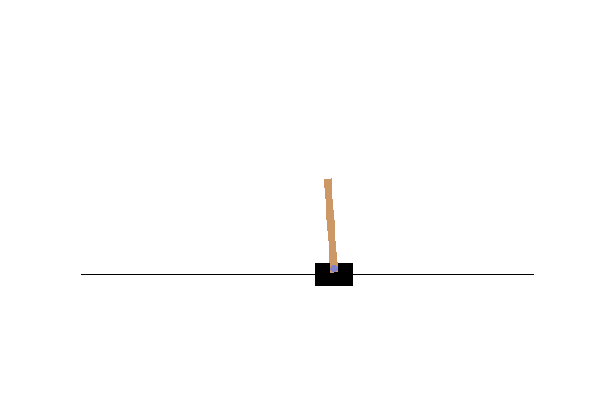
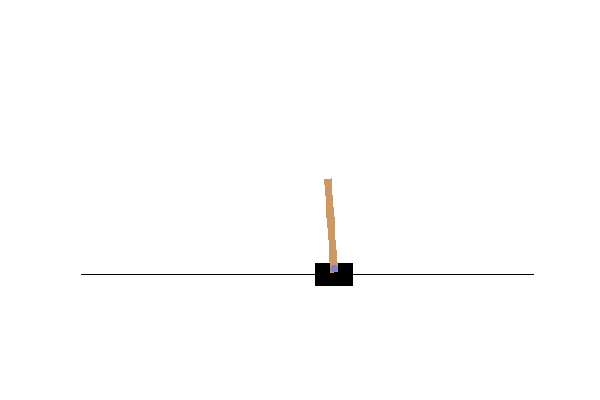
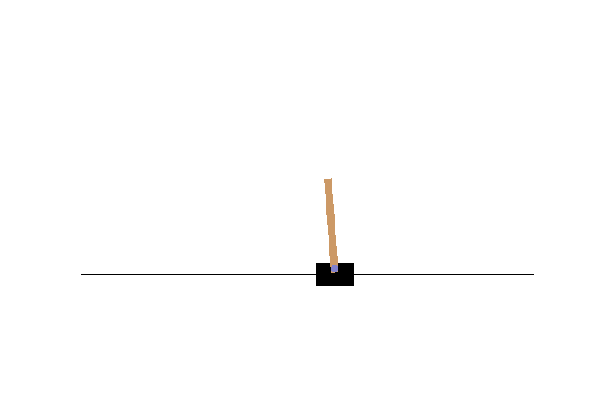
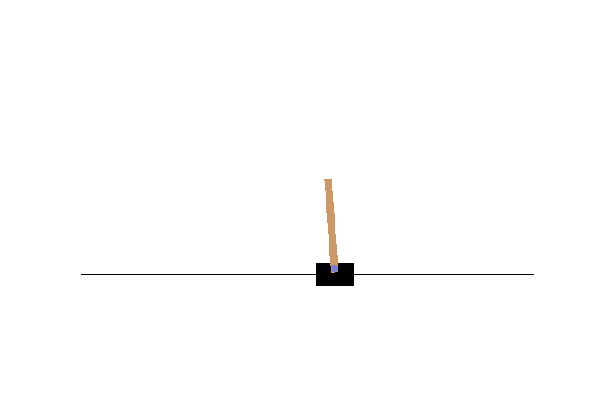
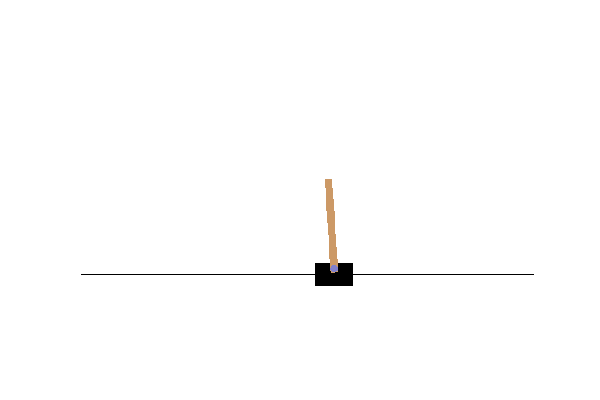
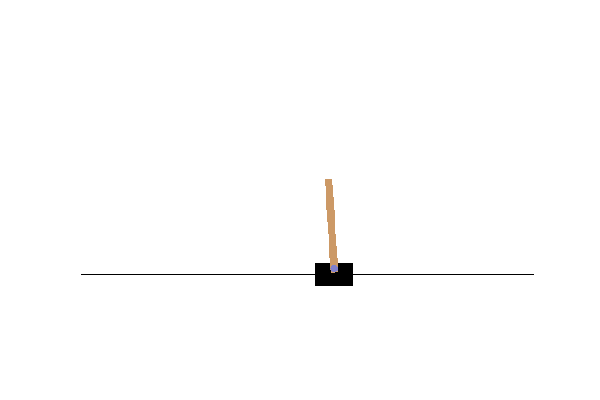
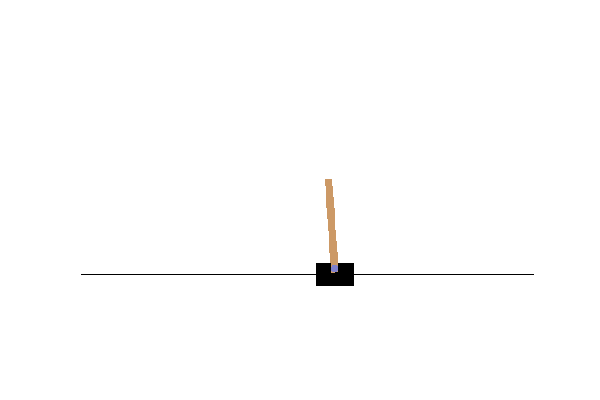
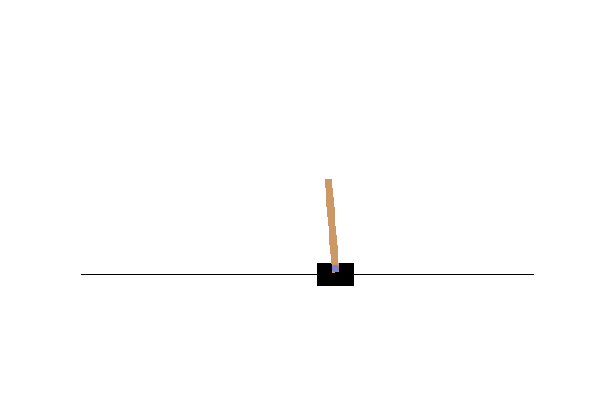
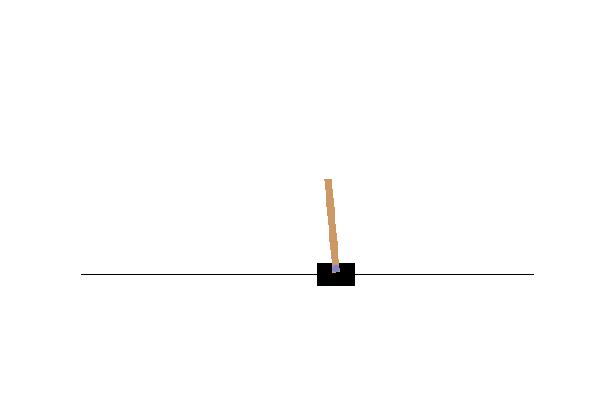
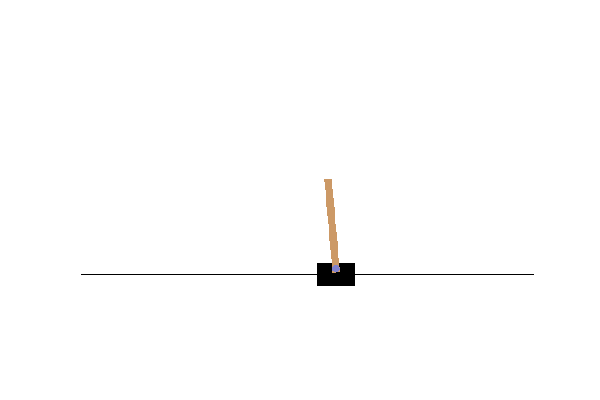
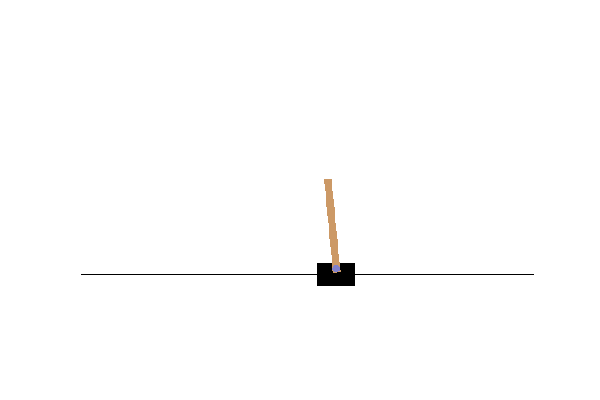
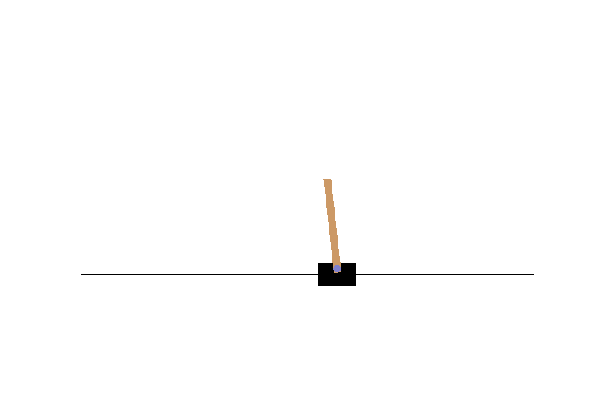
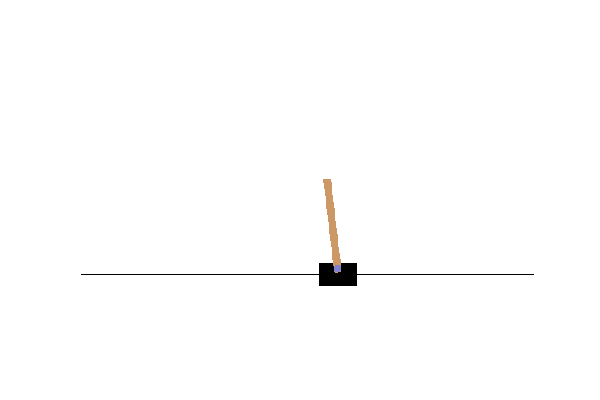
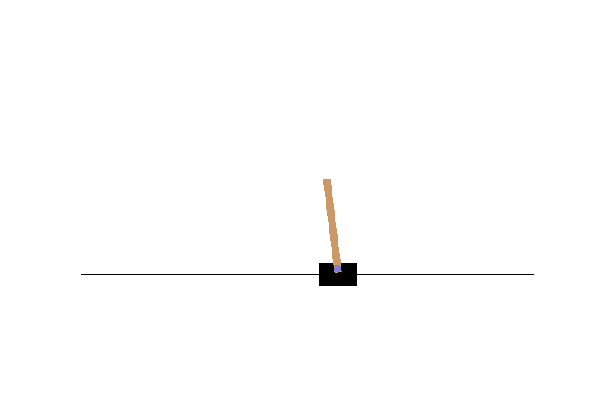
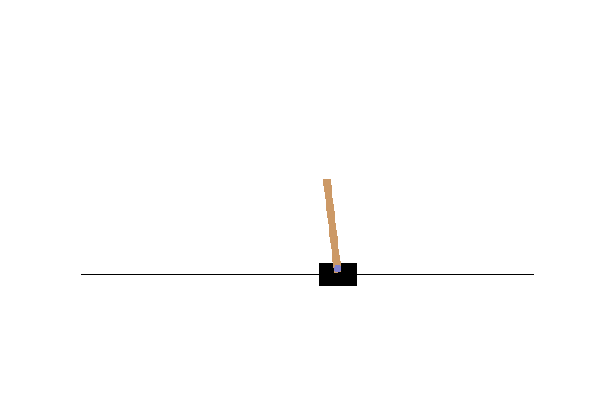
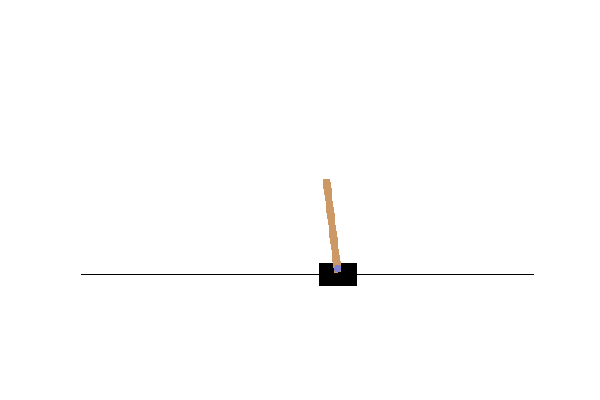
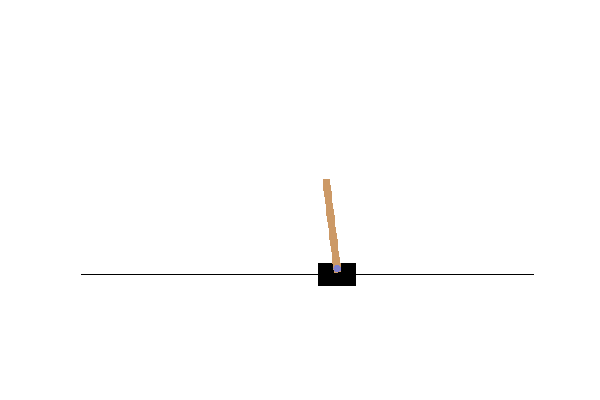
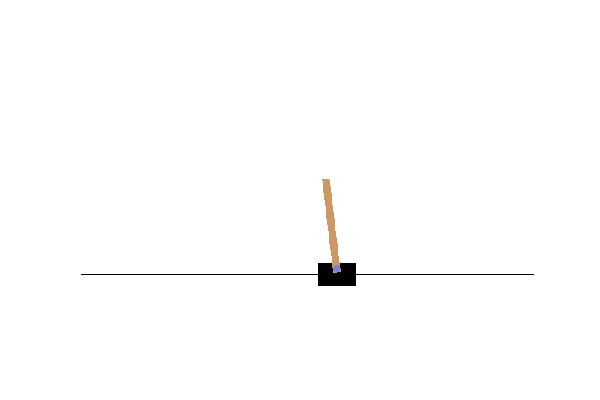
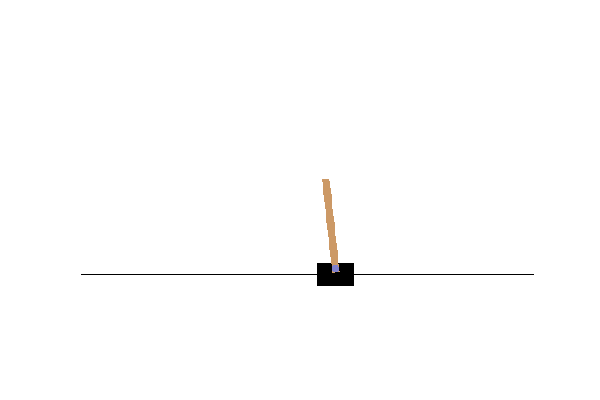
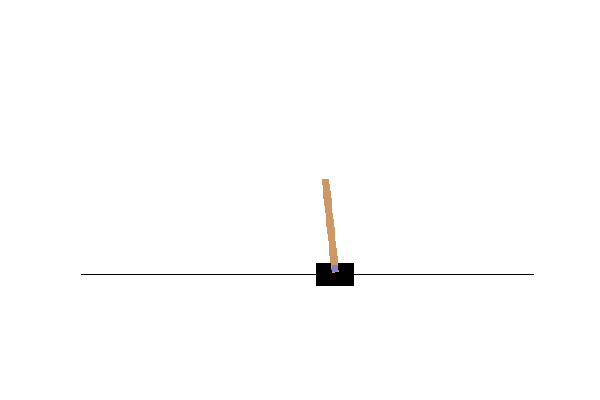
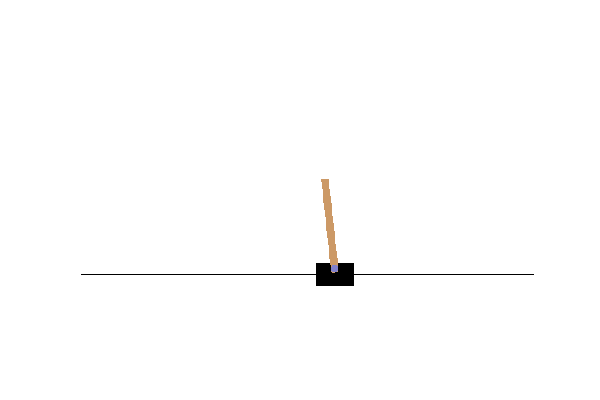
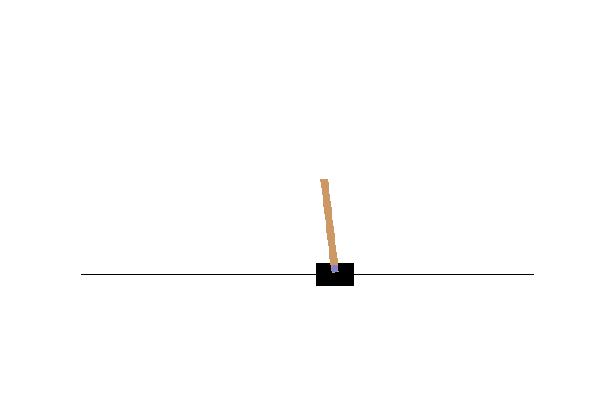
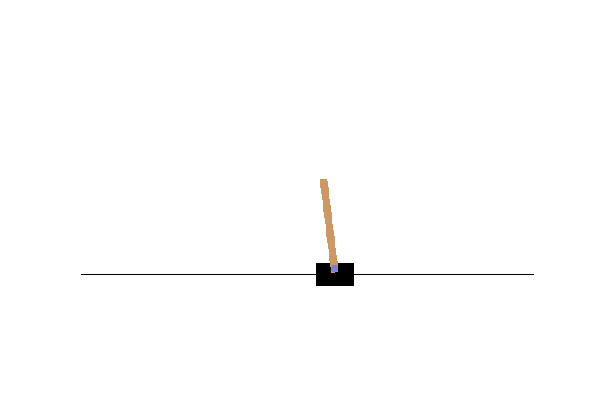
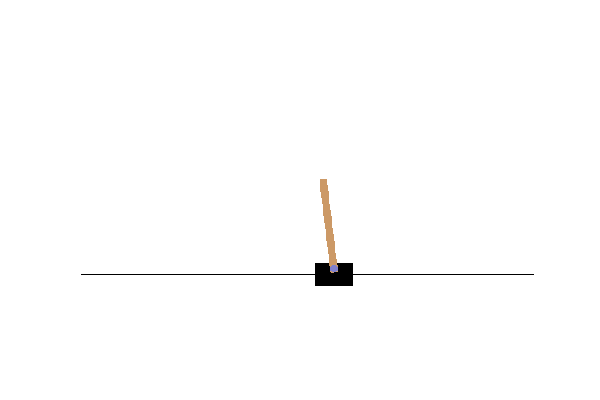
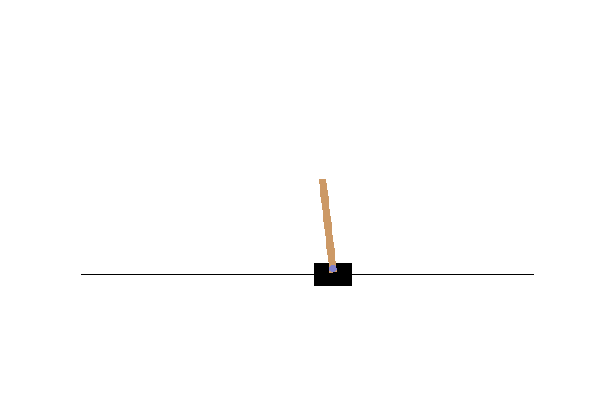
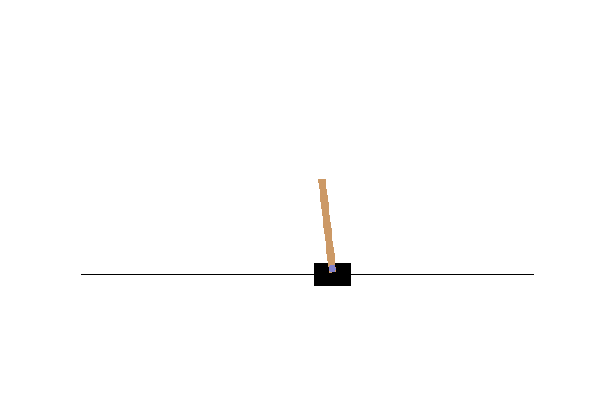
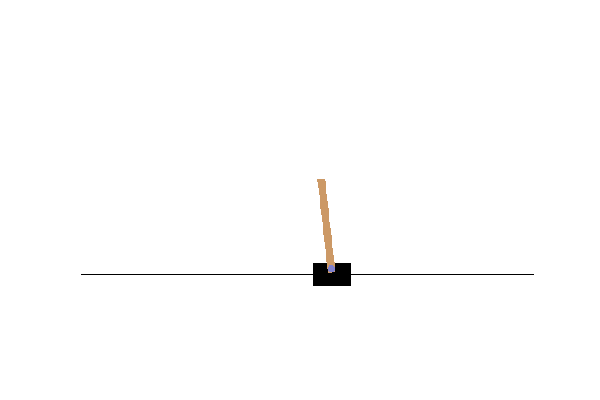
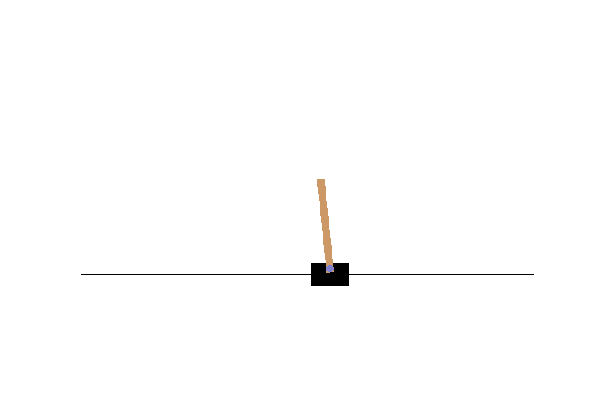
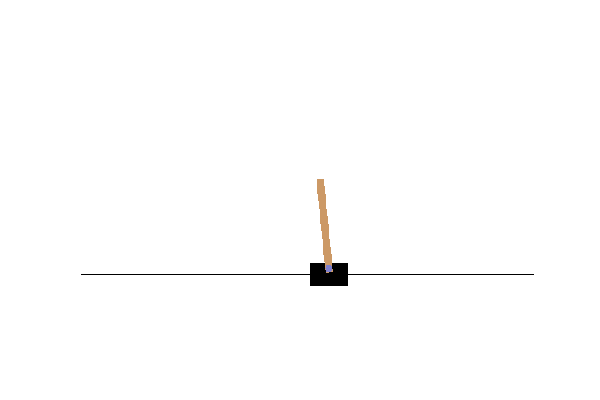
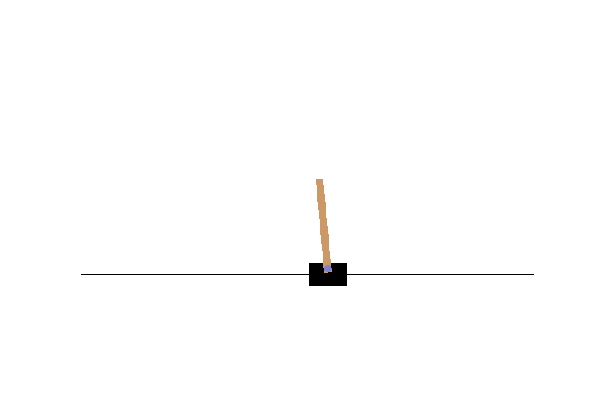
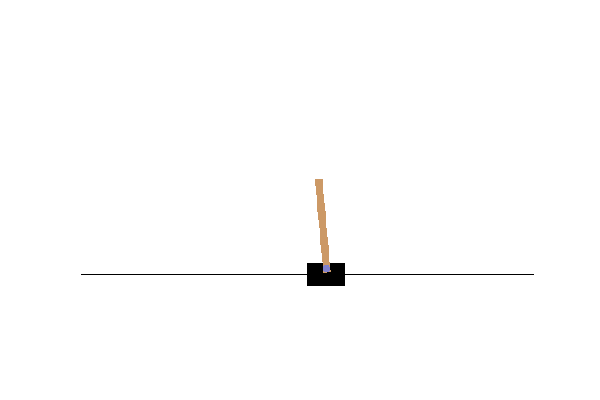
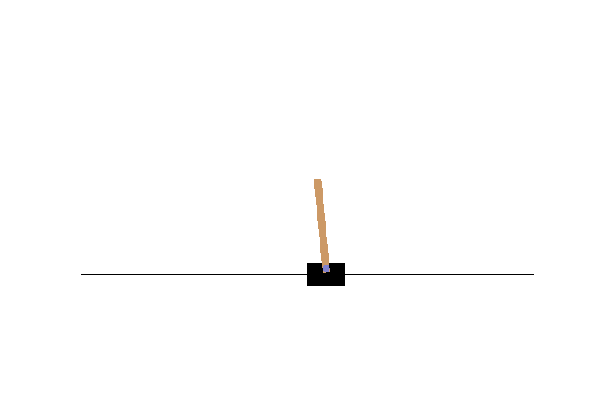
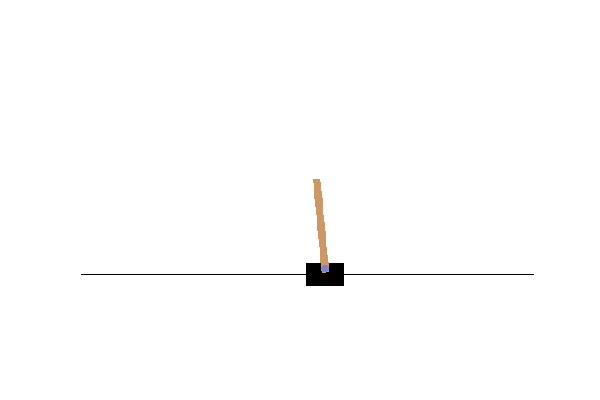
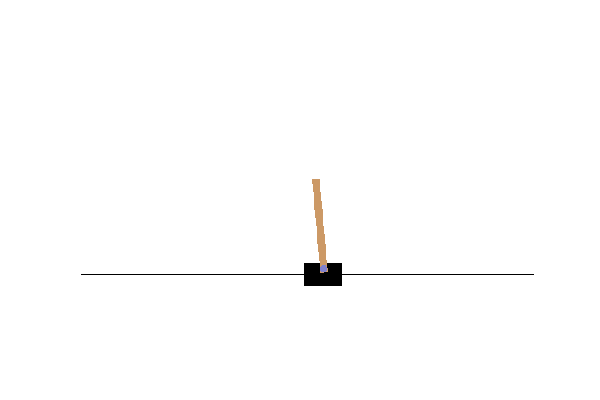
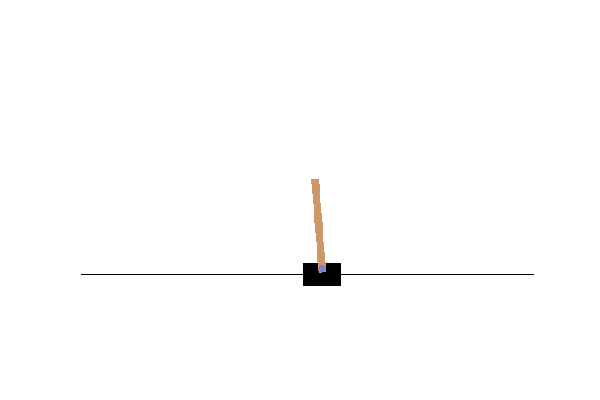
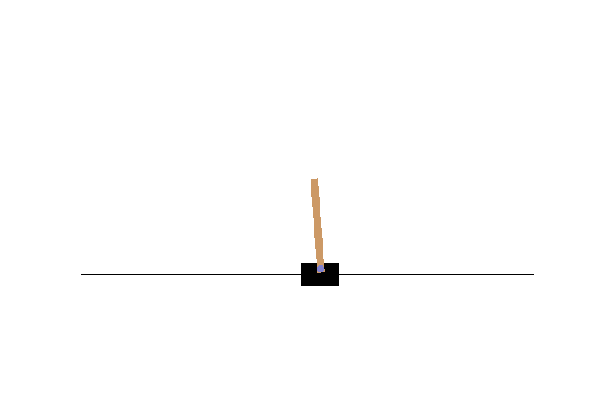
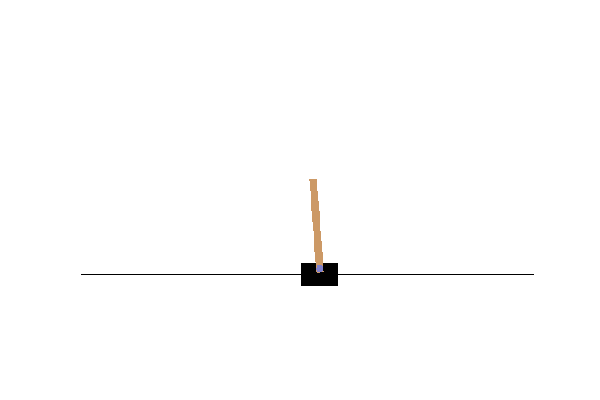
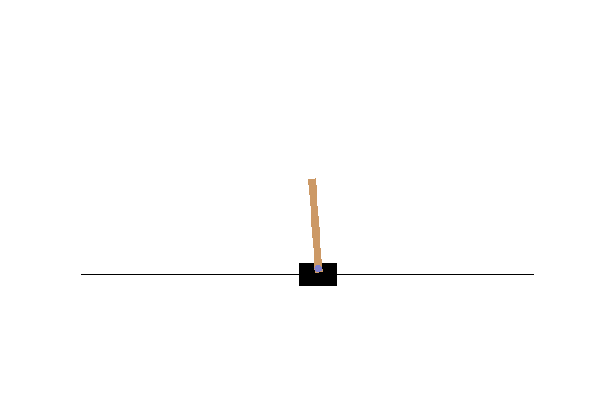
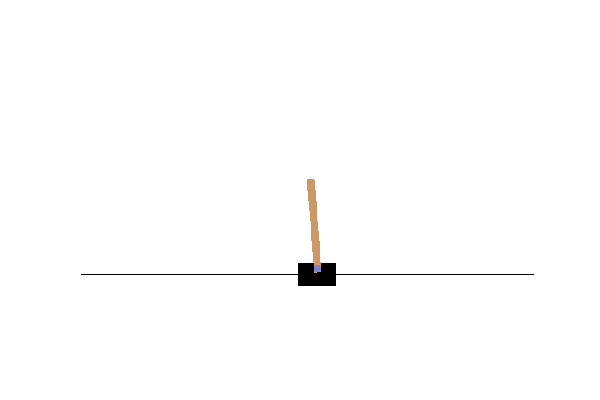
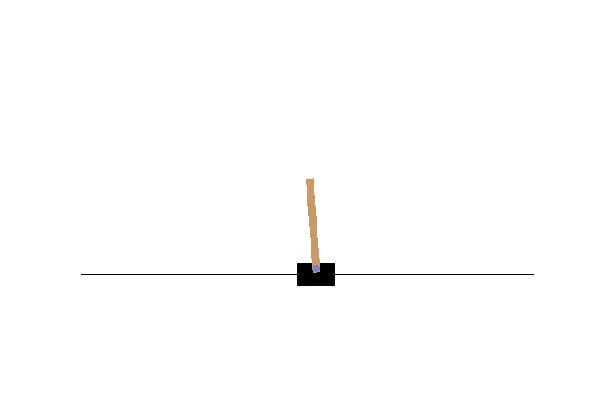
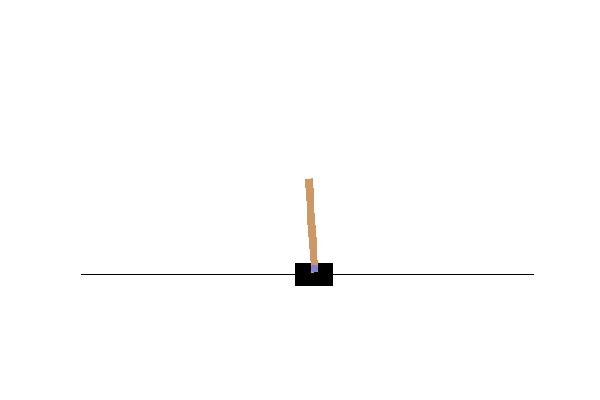
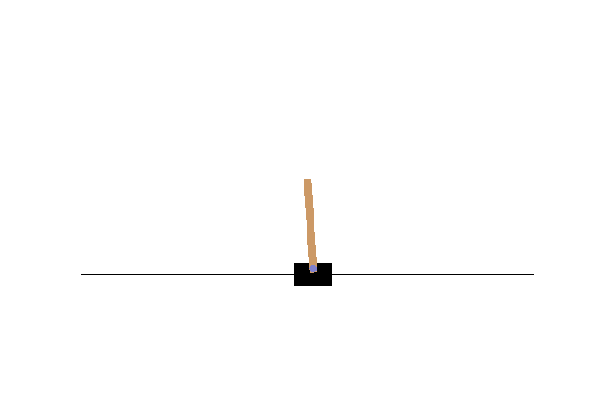
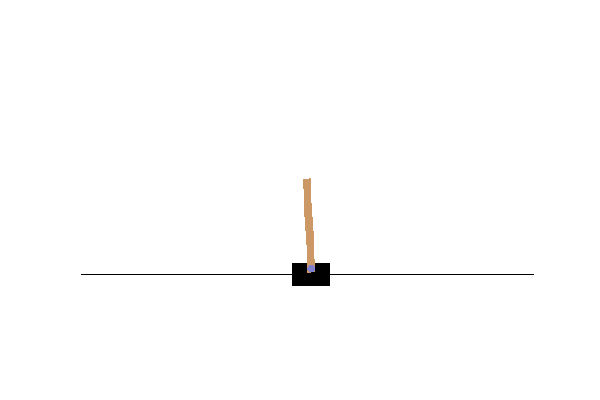
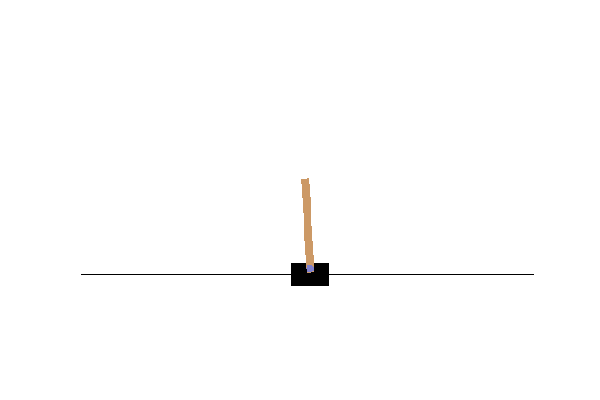
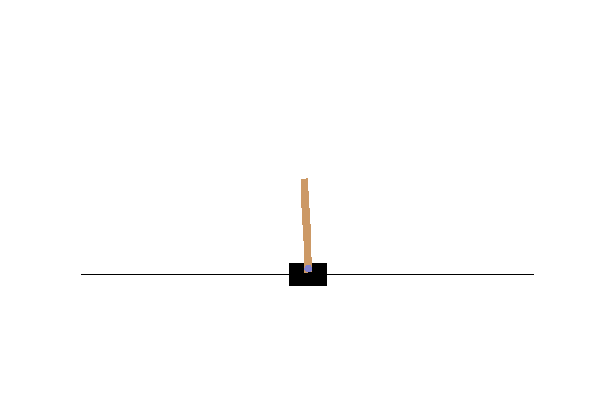
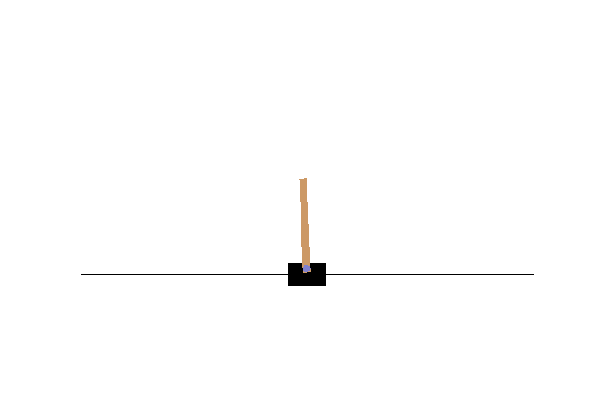
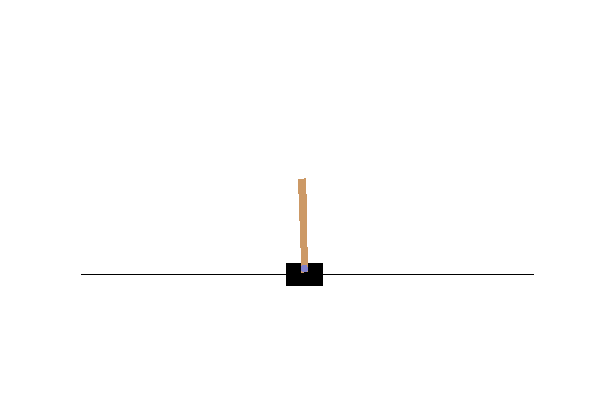
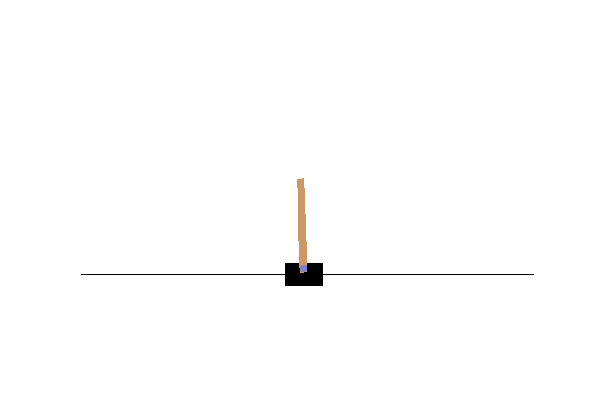
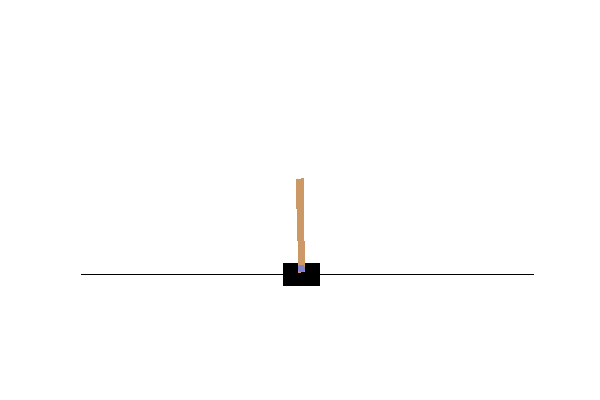
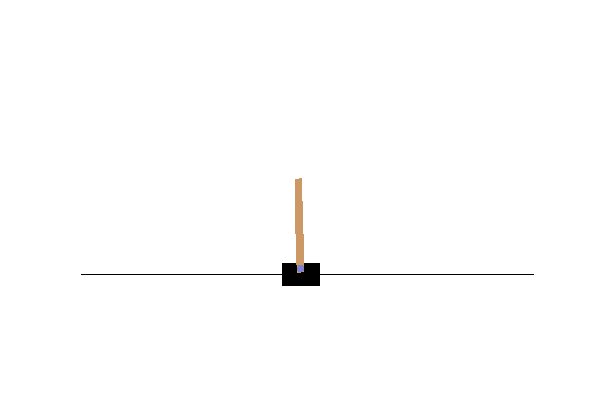
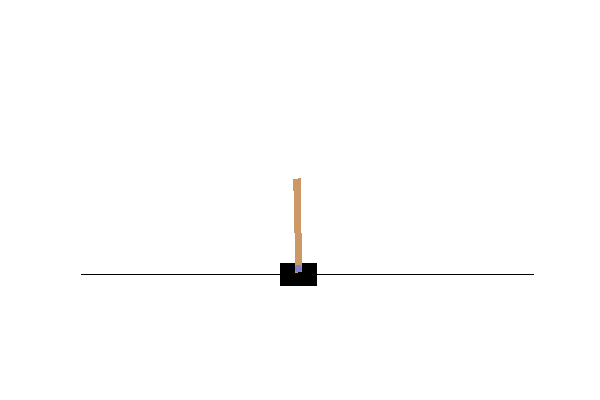
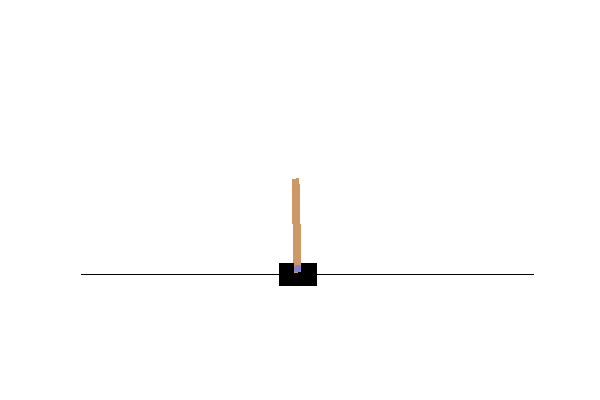
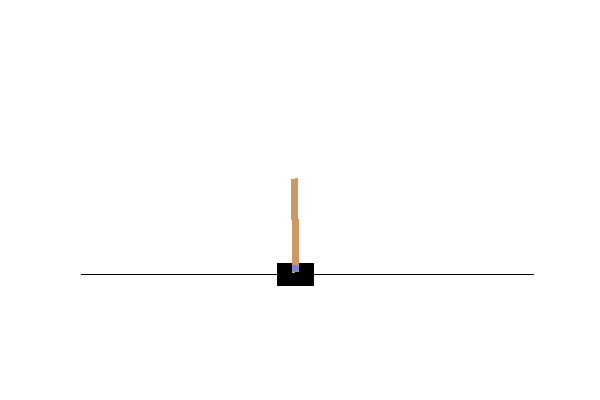
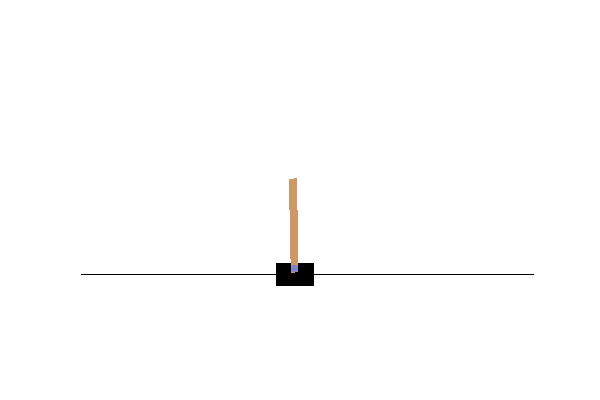
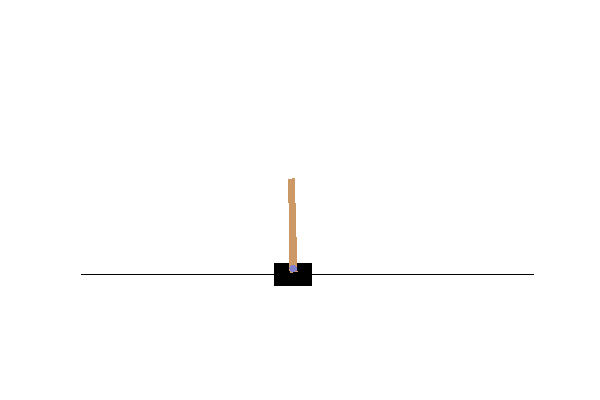
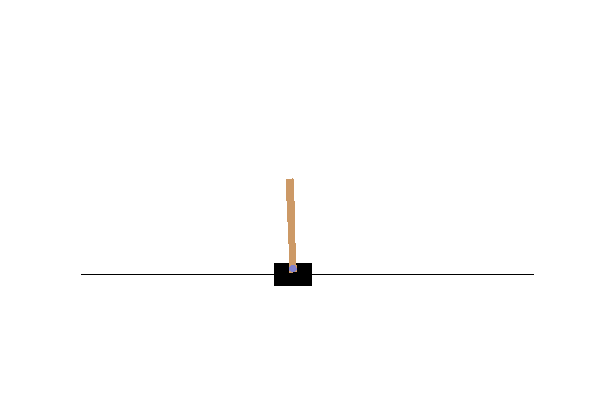
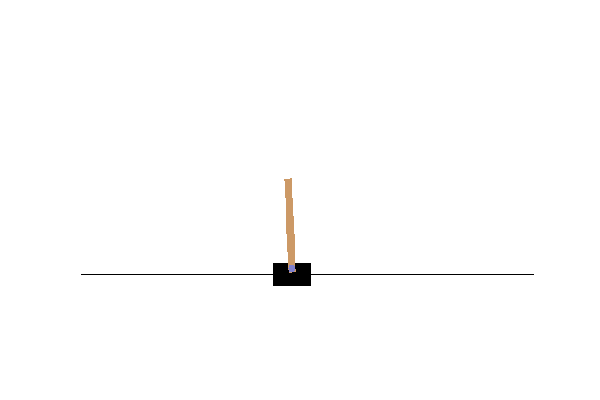
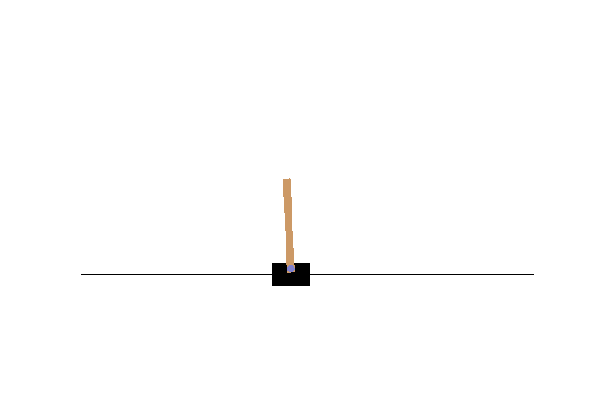
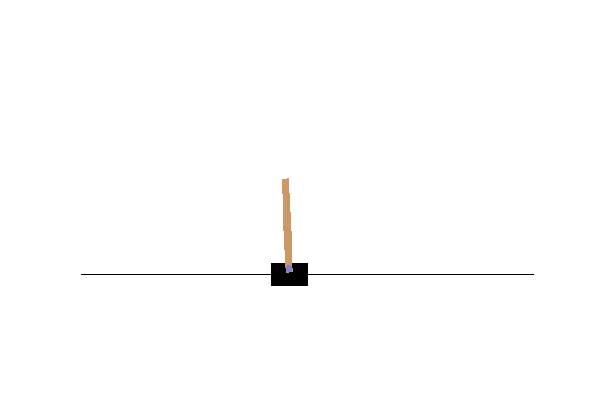
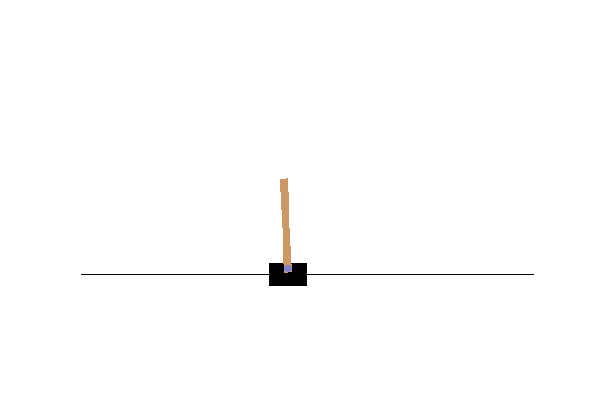
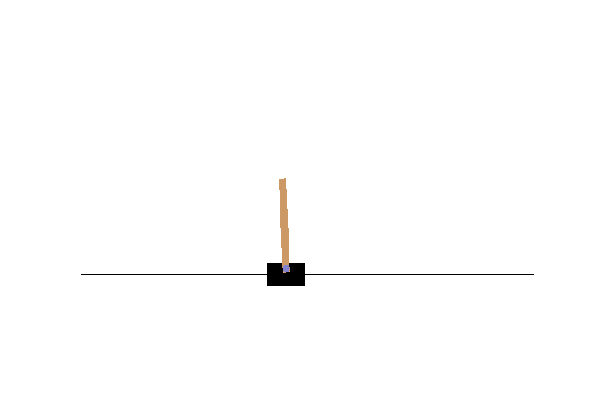
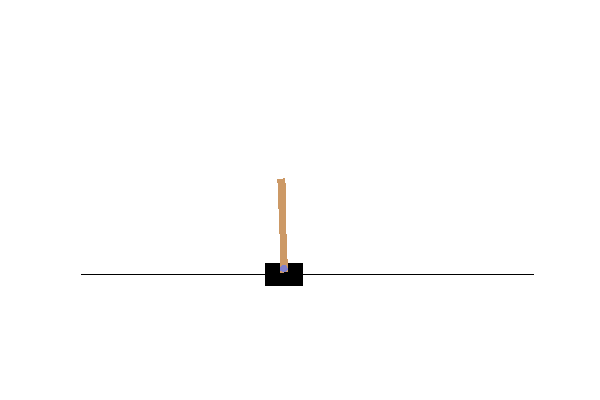
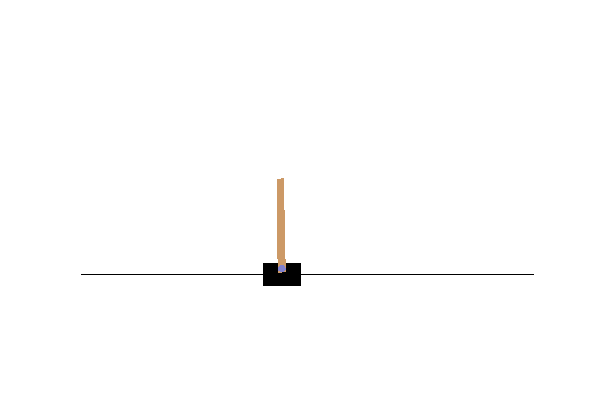
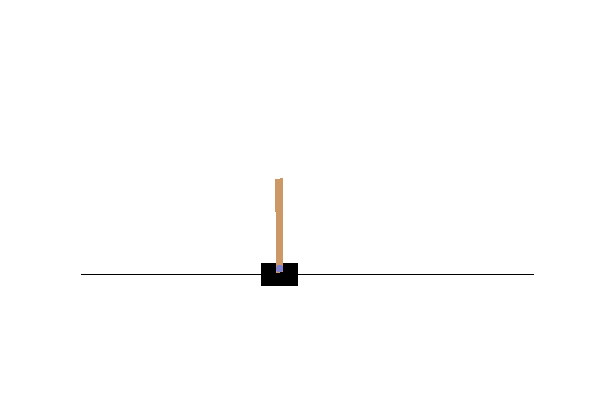
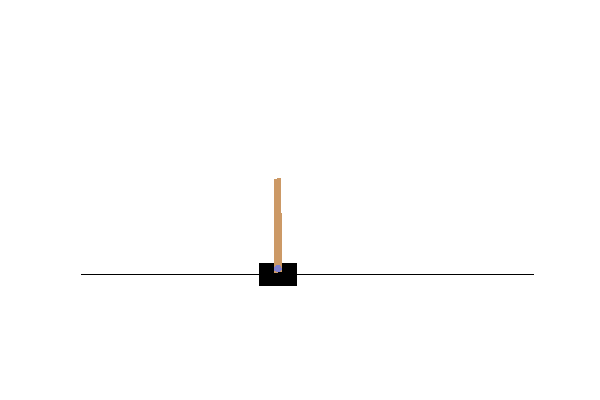
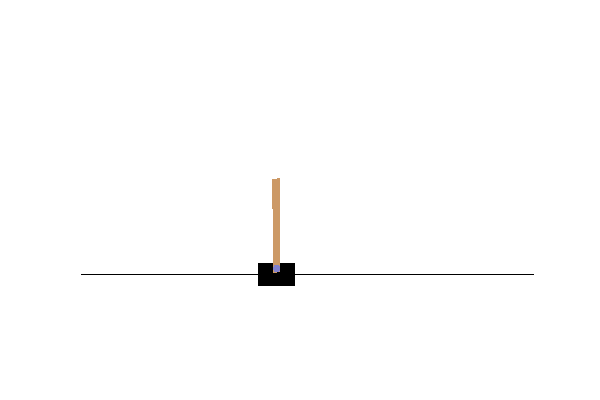
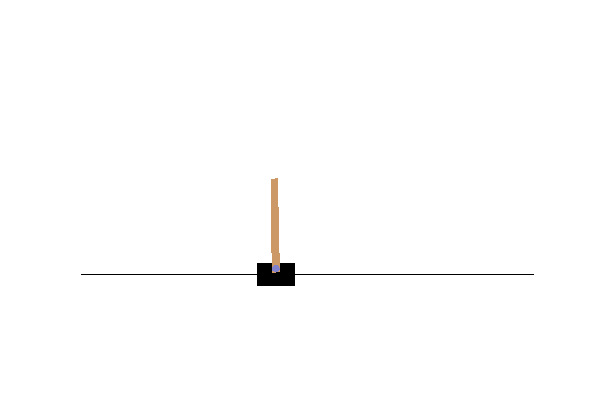
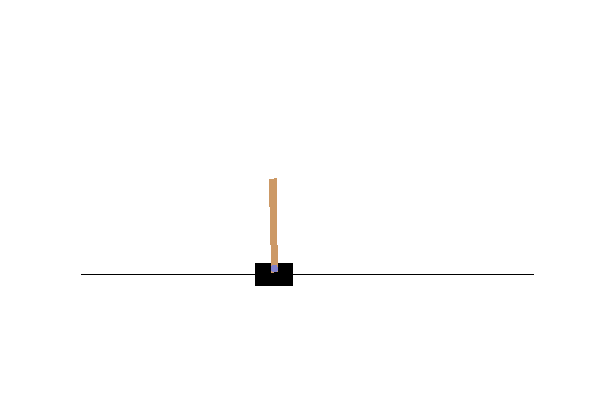
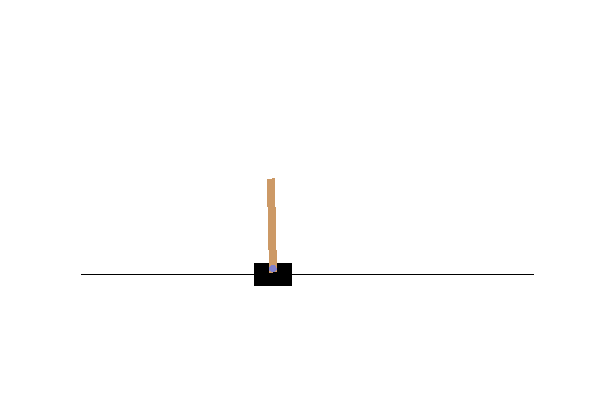
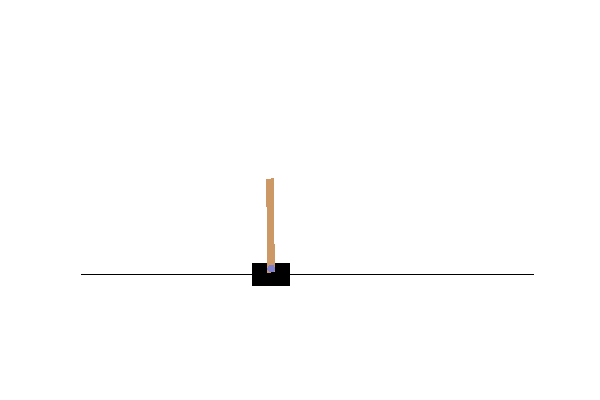
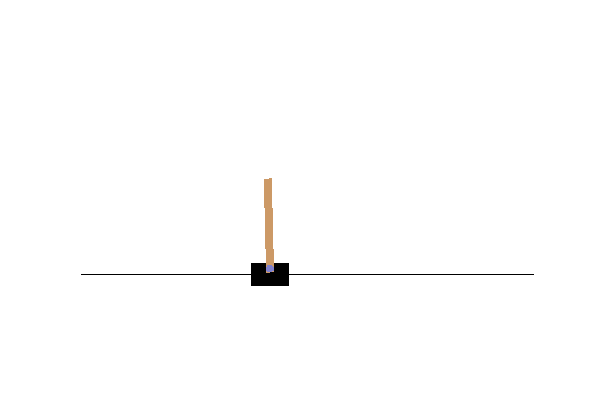
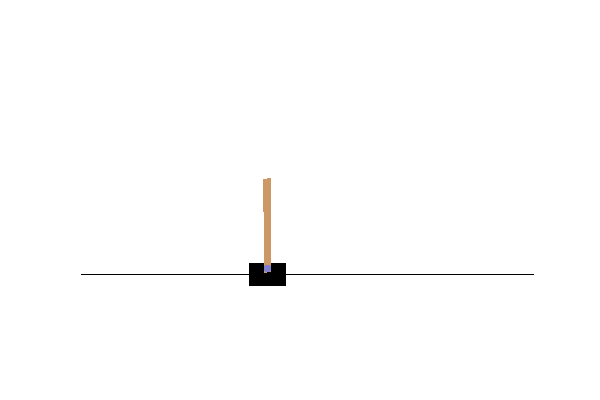
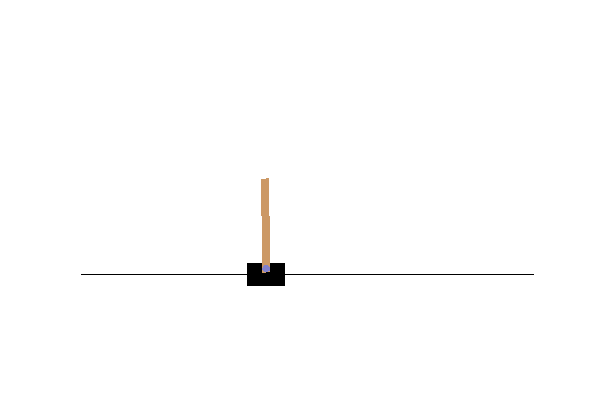
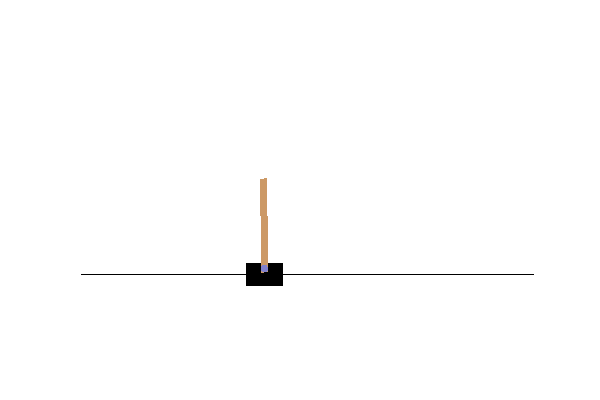
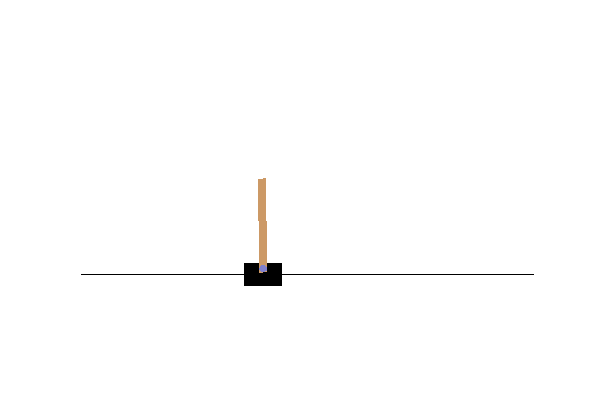
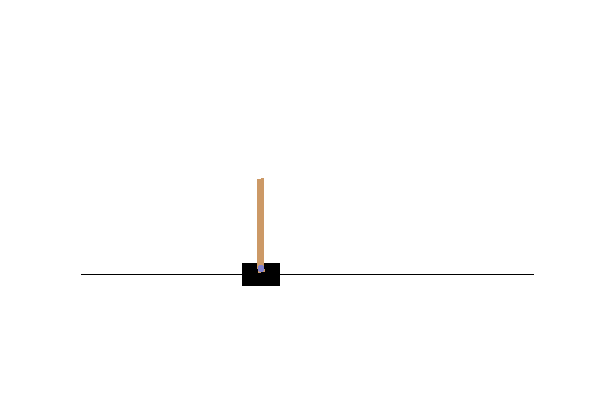
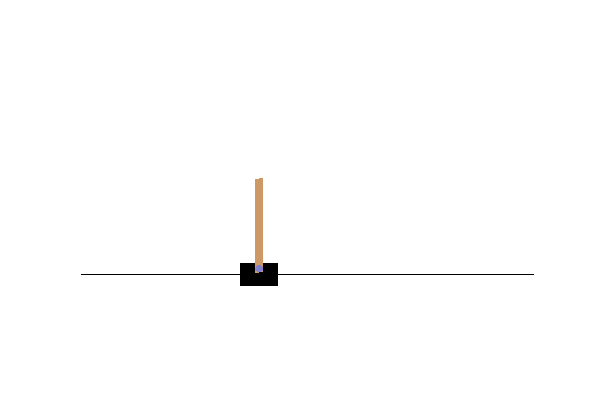
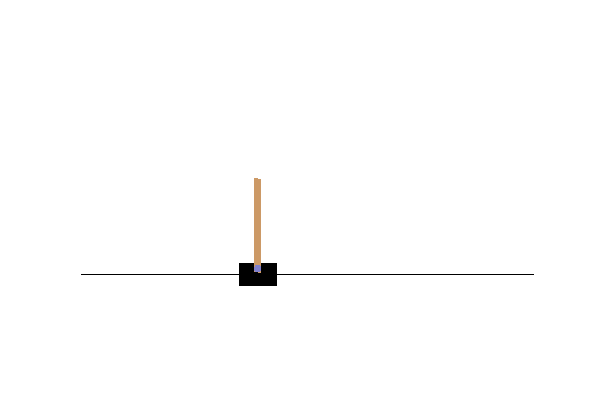
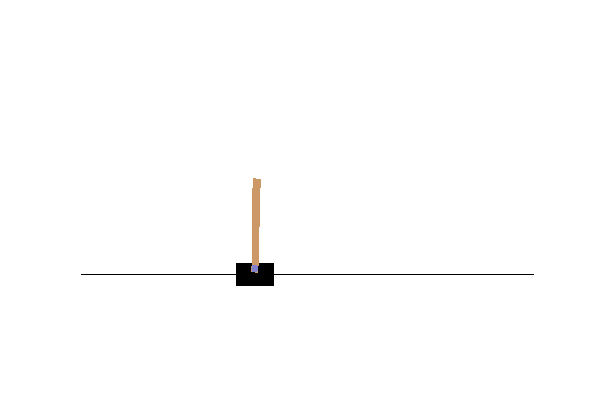
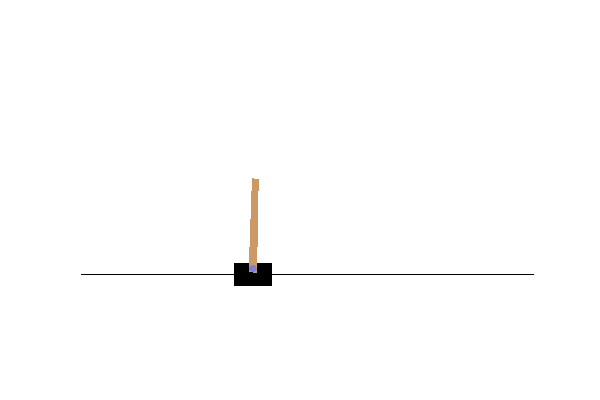
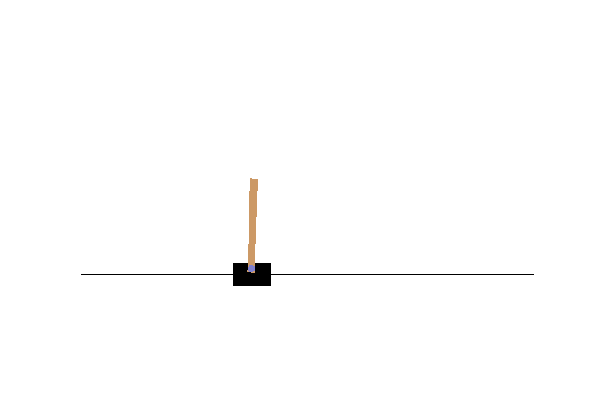
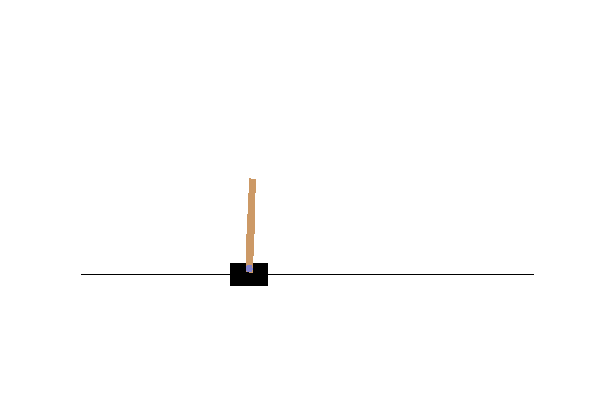
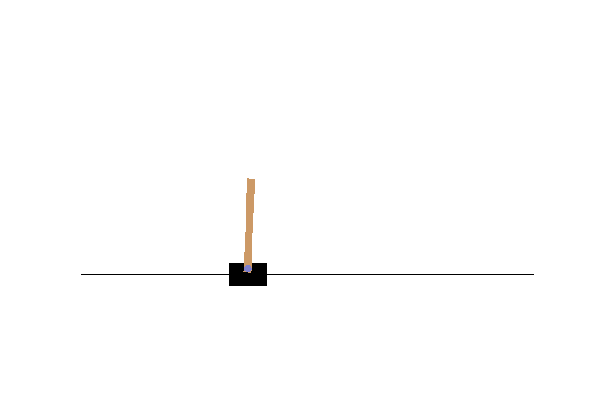
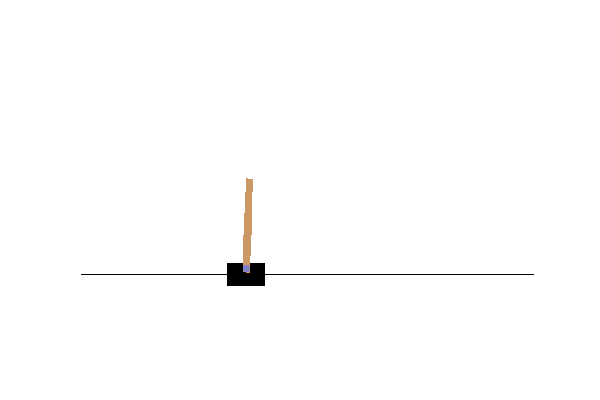
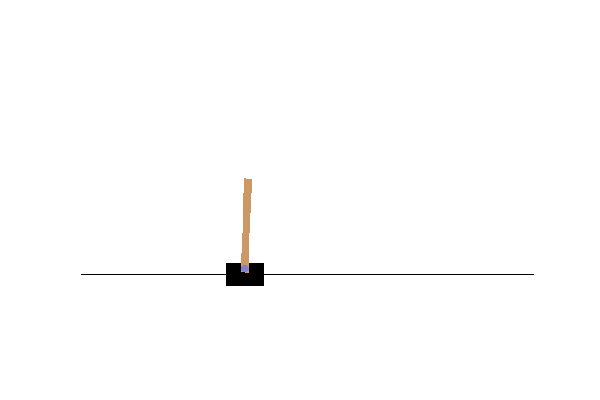
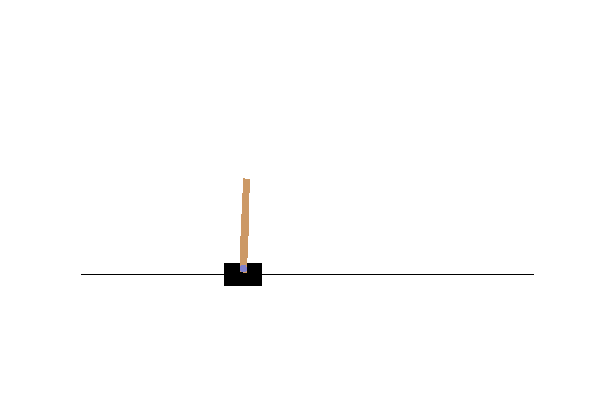
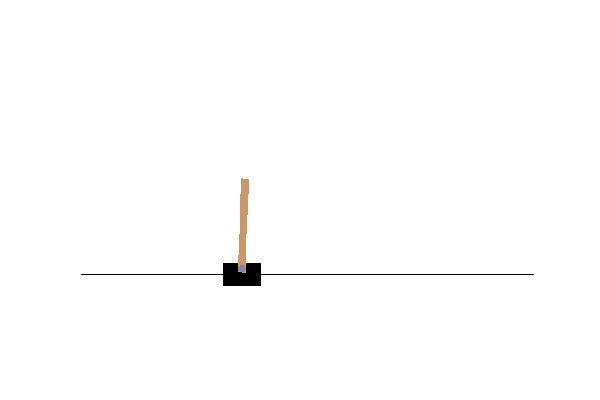
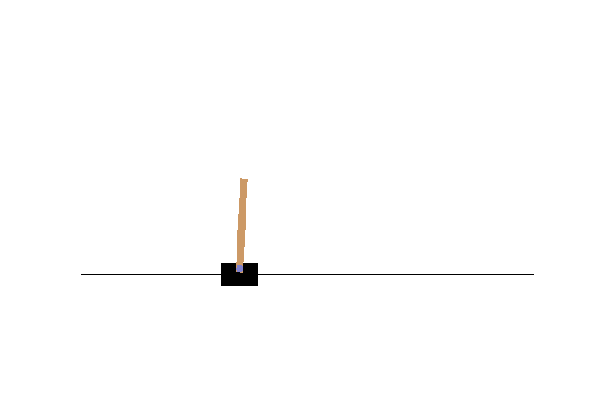
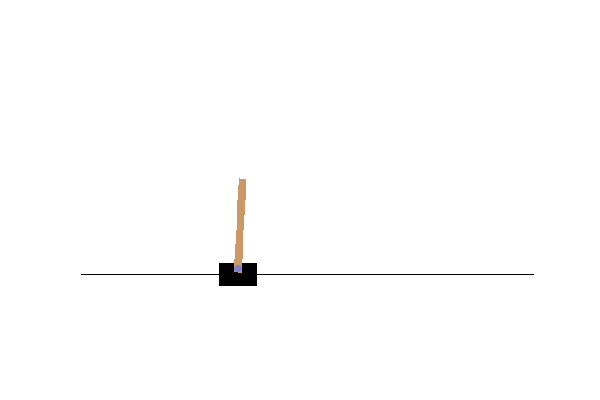
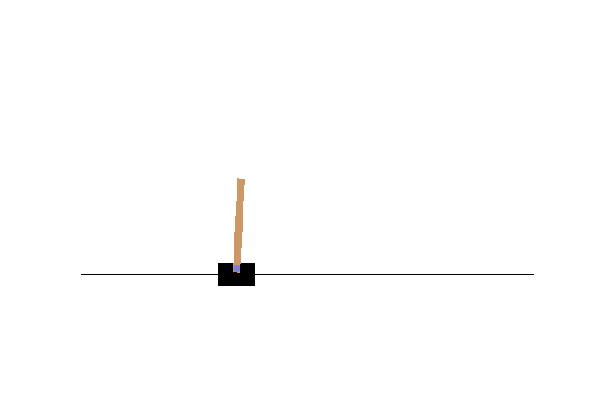
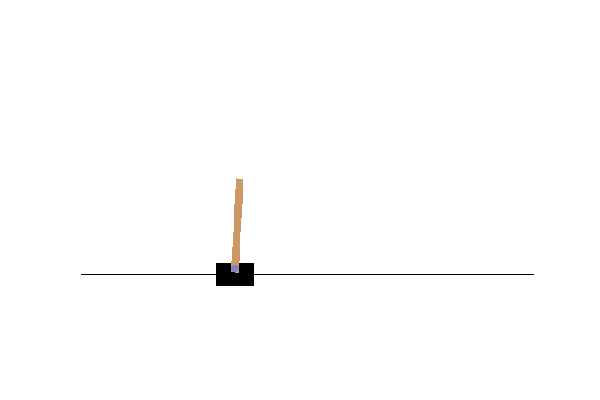
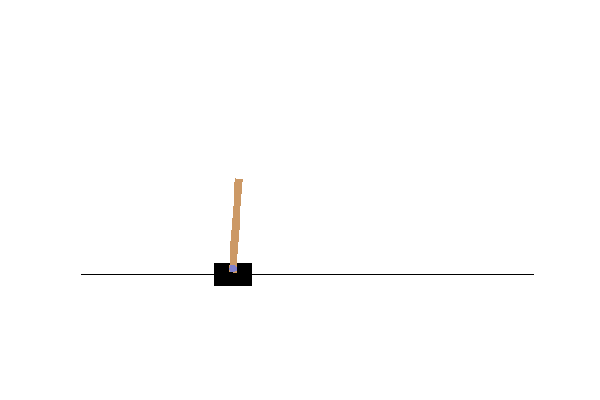
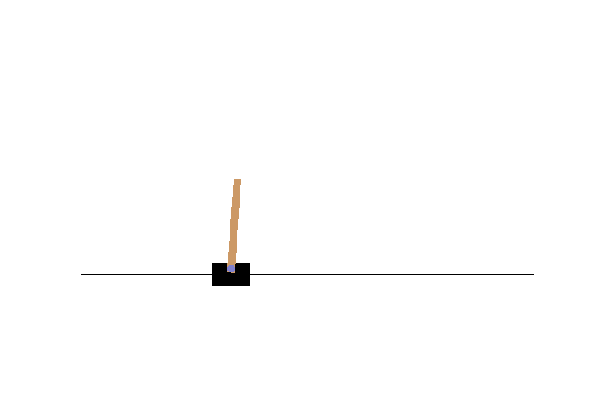
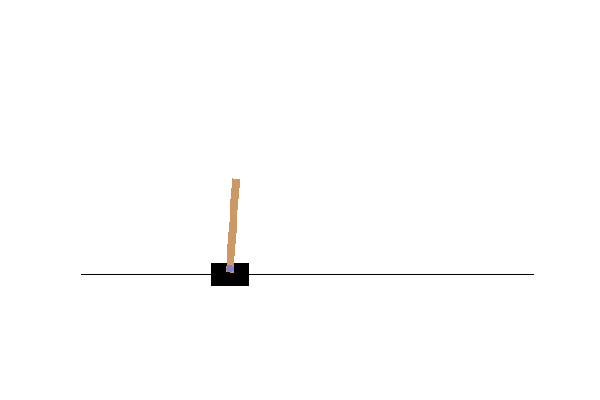
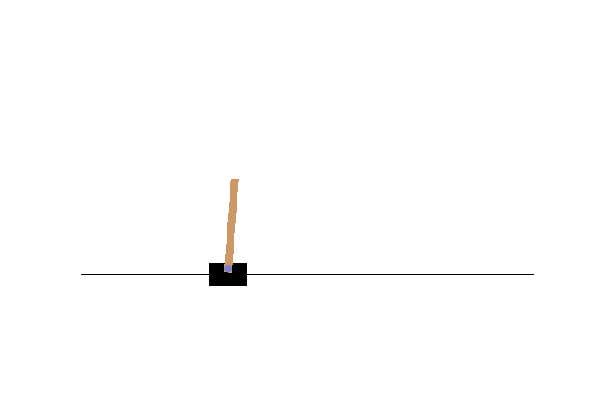
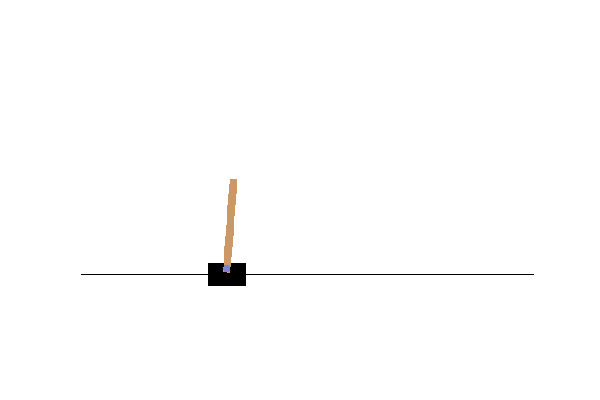
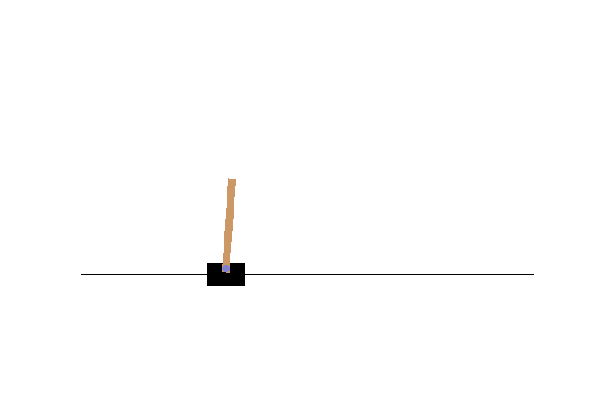
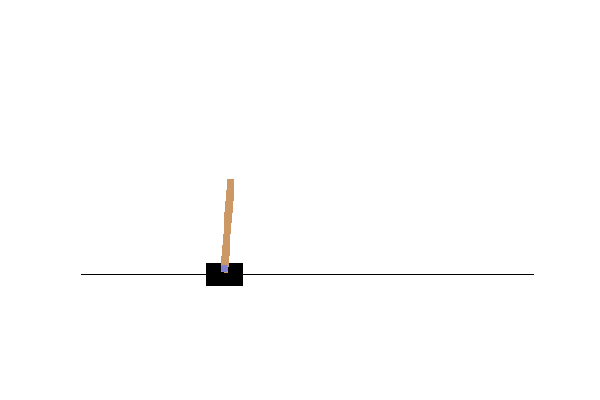
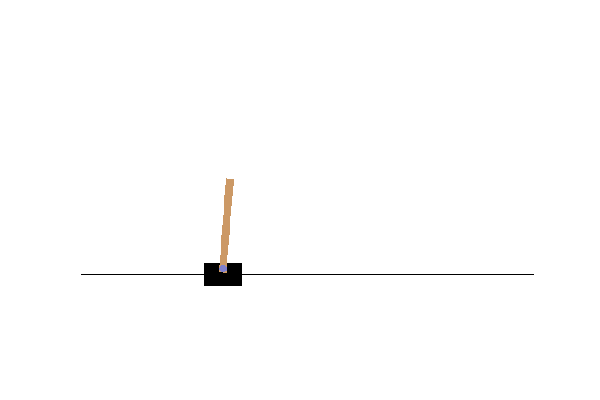
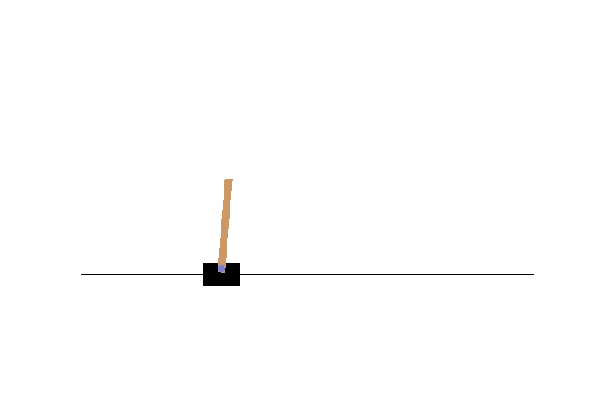
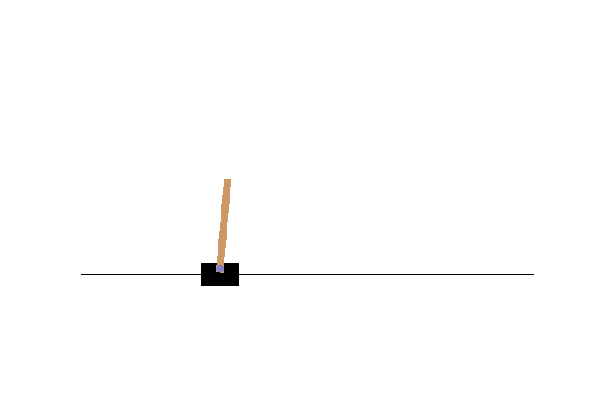
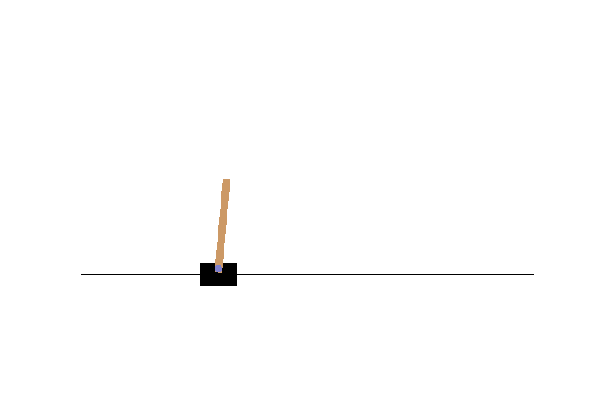
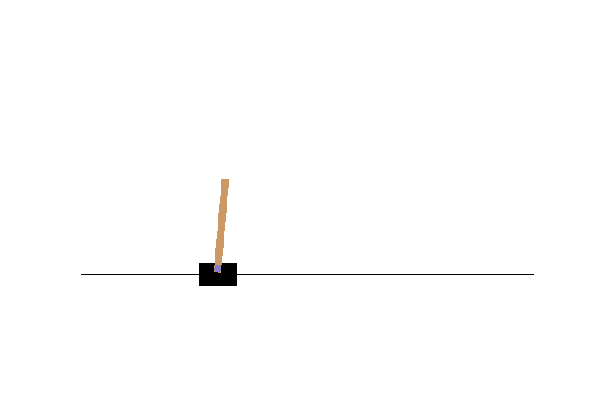
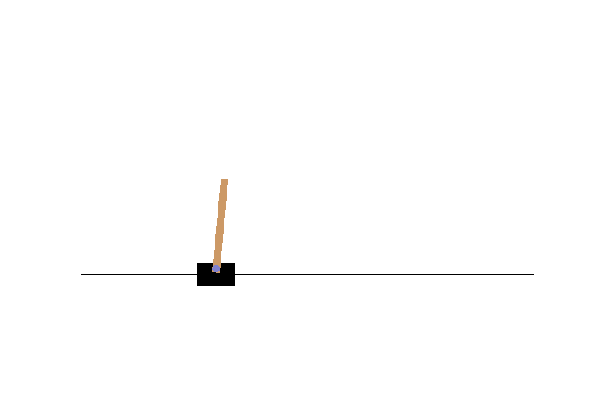
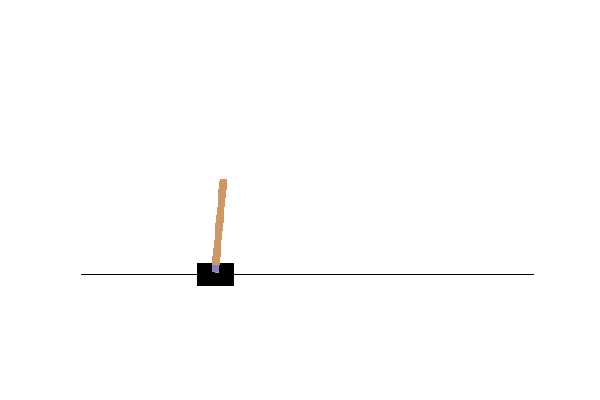
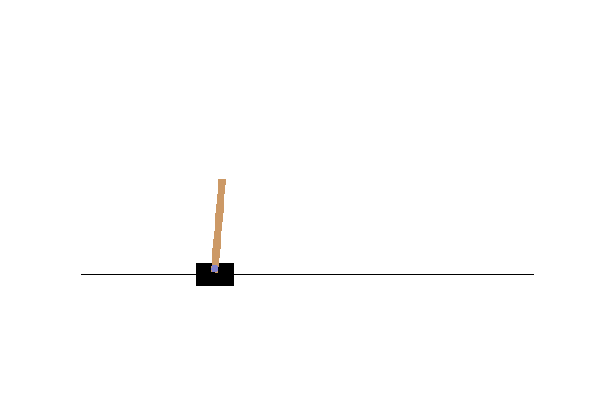
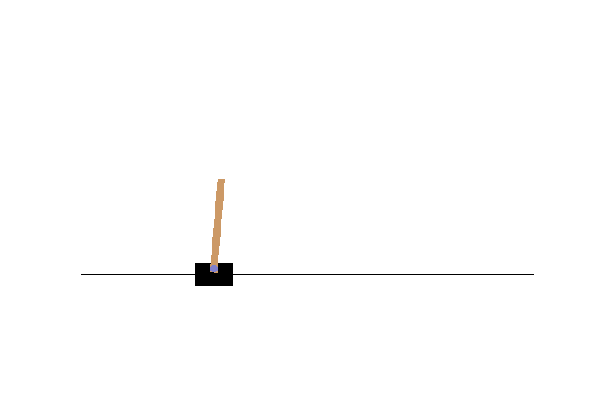
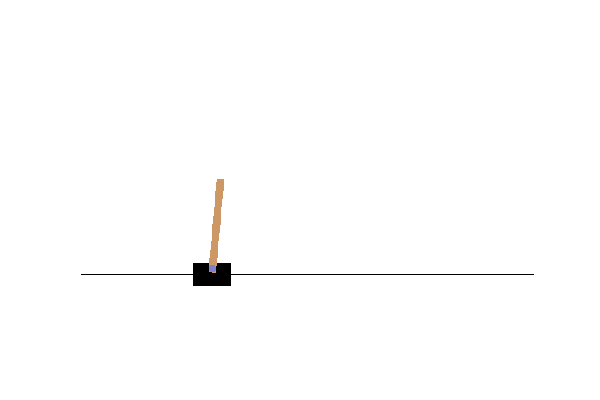
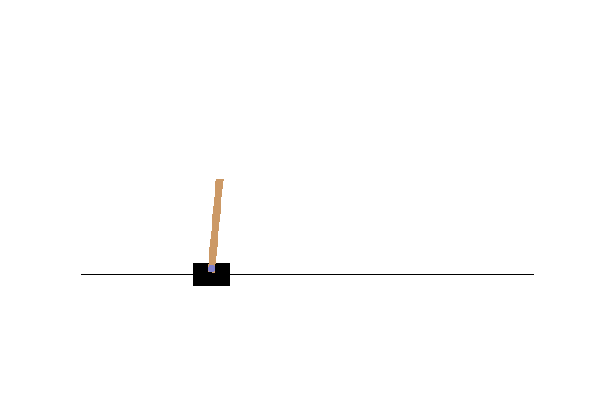
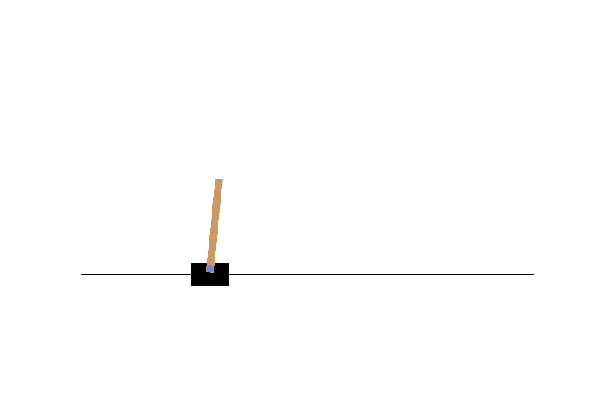
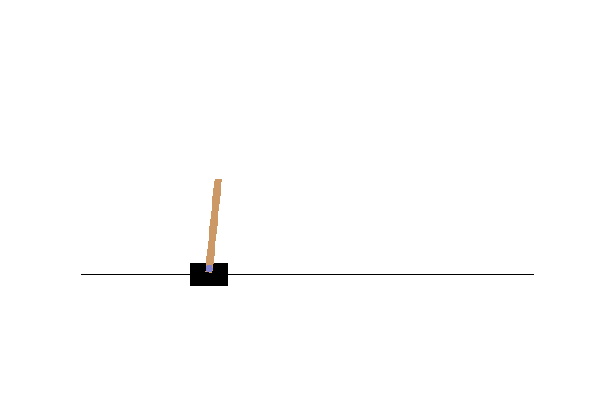
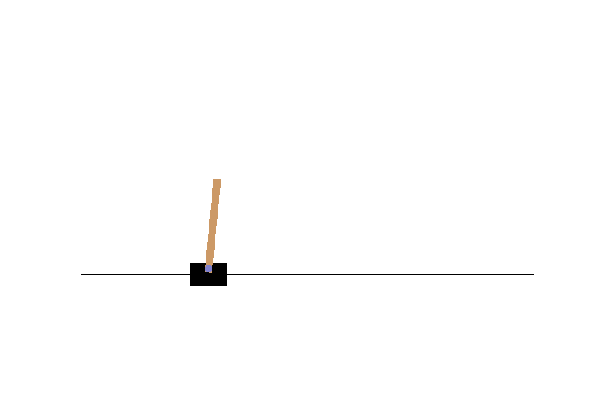
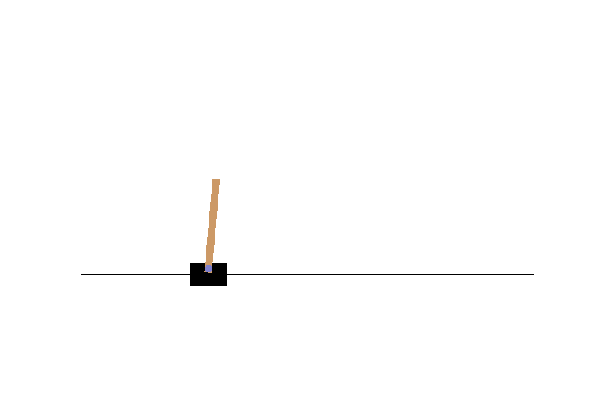
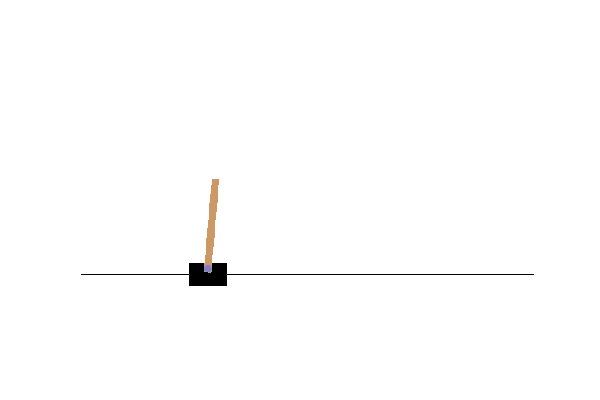
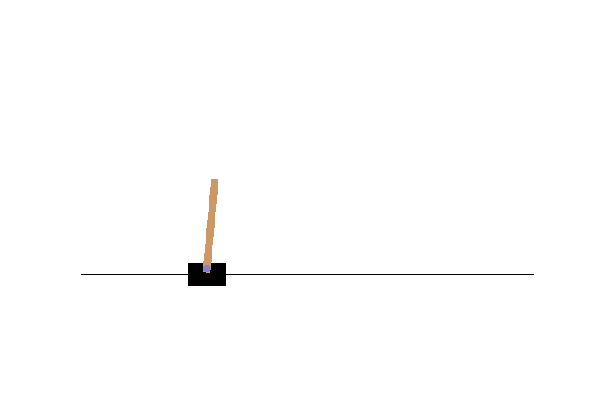
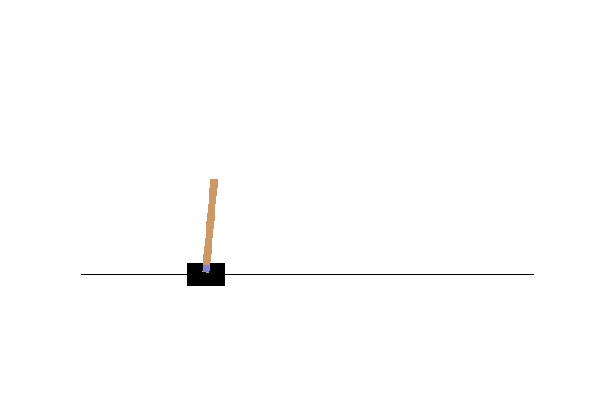
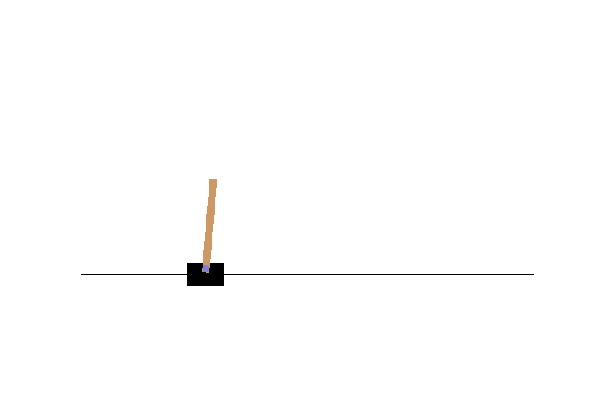
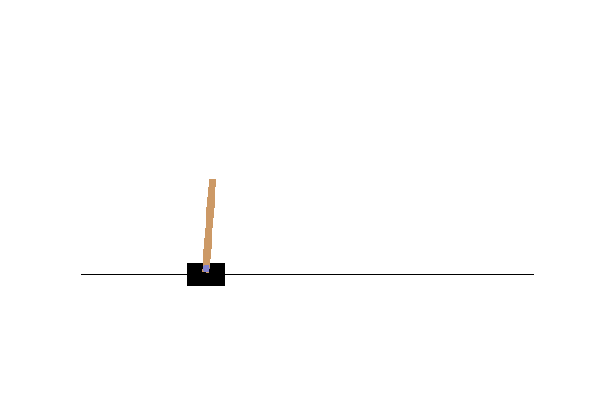
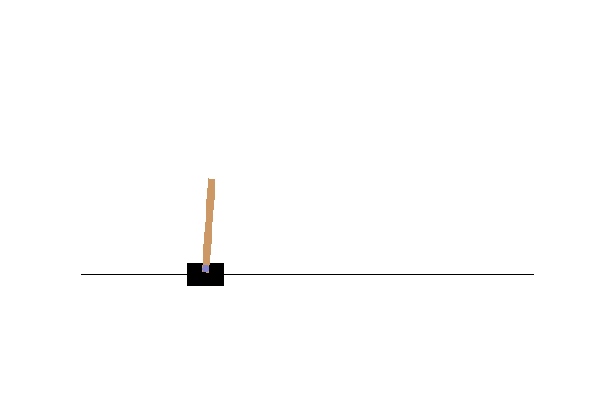
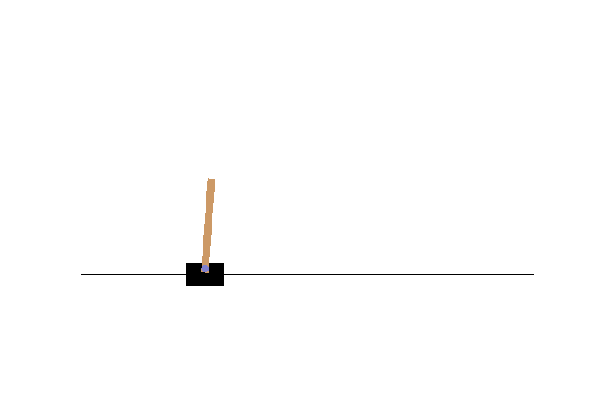
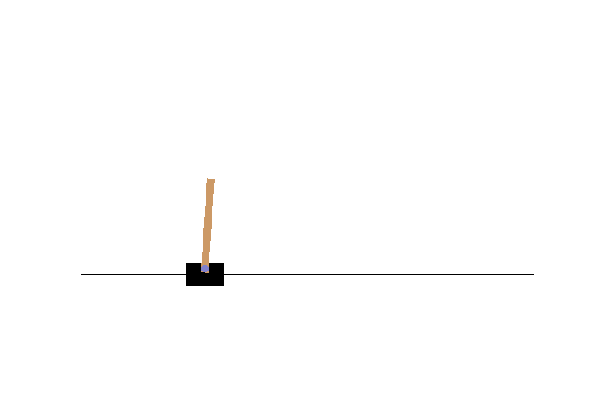
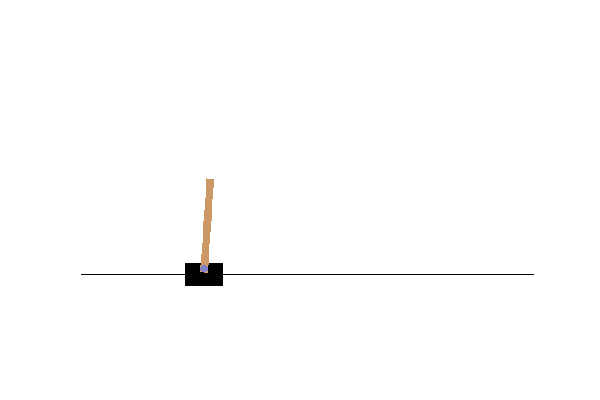
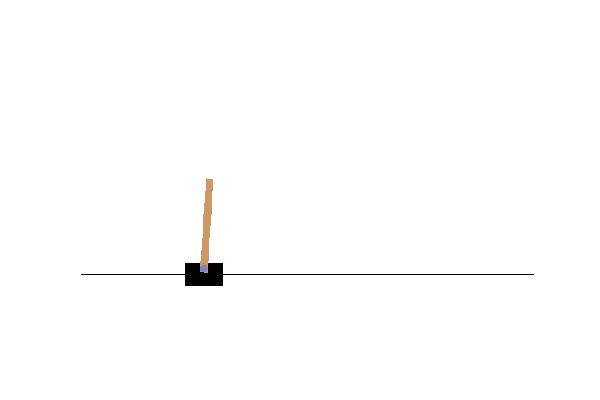
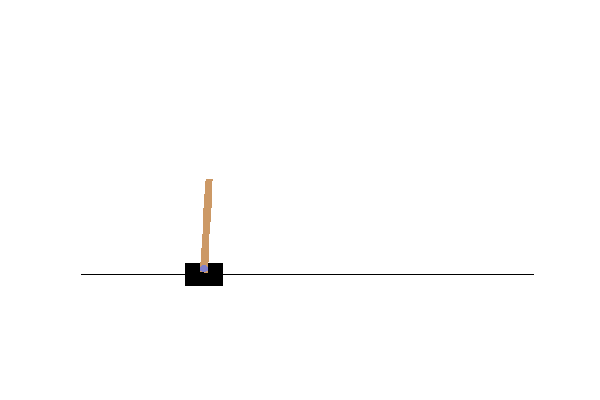
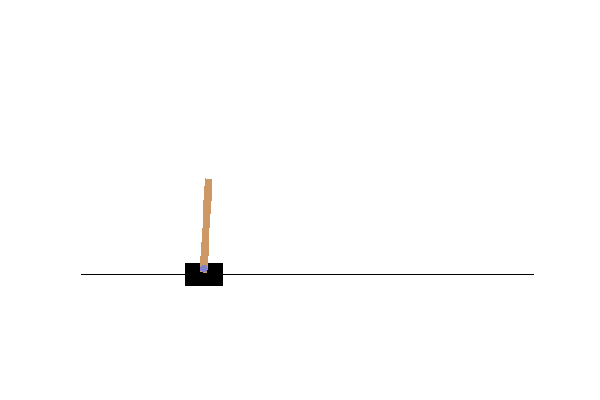
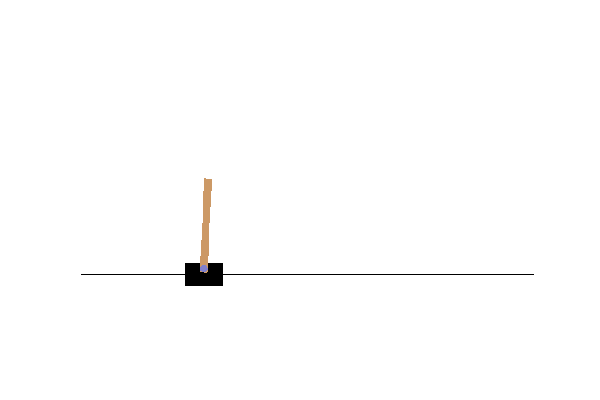
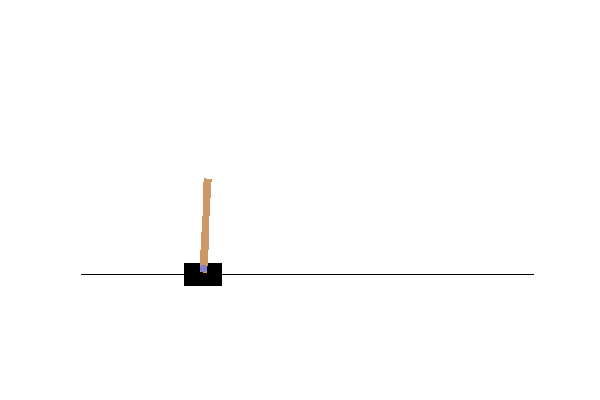
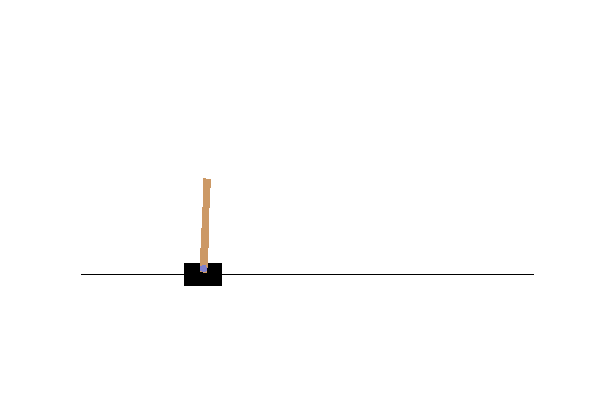

In [10]:
display_frames_as_gif(frames[4900:])

In [0]:
frames = []
train(env_name='MountainCar-v0',epochs = 200,render = True)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
2
3
200
epoch:   0 	 loss: -219.158 	 return: -200.000 	 ep_len: 200.000
epoch:   1 	 loss: -217.430 	 return: -200.000 	 ep_len: 200.000
epoch:   2 	 loss: -214.354 	 return: -200.000 	 ep_len: 200.000
epoch:   3 	 loss: -209.390 	 return: -200.000 	 ep_len: 200.000
epoch:   4 	 loss: -209.006 	 return: -200.000 	 ep_len: 200.000
epoch:   5 	 loss: -208.410 	 return: -200.000 	 ep_len: 200.000
epoch:   6 	 loss: -203.769 	 return: -200.000 	 ep_len: 200.000
epoch:   7 	 loss: -206.430 	 return: -200.000 	 ep_len: 200.000
epoch:   8 	 loss: -206.182 	 return: -200.000 	 ep_len: 200.000
epoch:   9 	 loss: -205.890 	 return: -200.000 	 ep_len: 200.000
epoch:  10 	 loss: -206.046 	 return: -200.000 	 ep_len: 200.000
epoch:  11 	 loss: -208.929 	 return: -200.000 	 ep_len: 200.000
epoch:  12 	 loss: -208.441 	 return: -200.000 	 ep_len: 200.000
epoch:  13 	 loss: -207.523 	 return: -200.000

In [0]:
display_frames_as_gif(frames[9700:])